<a href="https://colab.research.google.com/github/rsadaphule/jhu-cv/blob/main/JHU_CV_Mid_Term_SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/83tnWs_YBRQ

**This notebook walks you through the process of fine-tuning a Segment Anything Model (SAM) using custom data**.
<p>

**What is SAM?**
<br>
SAM is an image segmentation model developed by Meta AI. It was trained over 11 billion segmentation masks from millions of images. It is designed to take human prompts, in the form of points, bounding boxes or even a text prompt describing what should be segmented.
<p>

**What are the key features of SAM?**
<br>

* **Zero-shot generalization:** SAM can be used to segment objects that it has never seen before, without the need for additional training.

* **Flexible prompting:** SAM can be prompted with a variety of input, including points, boxes, and text descriptions.

* **Real-time mask computation:** SAM can generate masks for objects in real time. This makes SAM ideal for applications where it is necessary to segment objects quickly, such as autonomous driving and robotics.

* **Ambiguity awareness:** SAM is aware of the ambiguity of objects in images. This means that SAM can generate masks for objects even when they are partially occluded or overlapping with other objects.

<p>

**How does SAM work?**
<br>
SAM works by first encoding the image into a high-dimensional vector representation. The prompt is encoded into a separate vector representation. The two vector representations are then combined and passed to a mask decoder, which outputs a mask for the object specified by the prompt.
<p>
The image encoder is a vision transformer (ViT-H) model, which is a large language model that has been pre-trained on a massive dataset of images. The prompt encoder is a simple text encoder that converts the input prompt into a vector representation. The mask decoder is a lightweight transformer model that predicts the object mask from the image and prompt embeddings.
<p>

**SAM paper:** https://arxiv.org/pdf/2304.02643.pdf​
<p>

**Link to the dataset used in this demonstration:** https://www.epfl.ch/labs/cvlab/data/data-em/
<br>Courtesy: EPFL
<p>

This code has been heavily adapted from this notebook but modified to work with a truly custom dataset where we have a bunch of images and binary masks.
https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb



In [76]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ygcnzyr1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ygcnzyr1
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [77]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

In [78]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Load data into numpy arrays. Here we are importing a tiff stack containing 165 images of size 768x1024. You can use glob to import multiple images from a directory or any other method. The goal is to end up with a numpy array for images and an array for masks.

In [79]:
# Load tiff stack images and masks

#165 large images as tiff image stack
large_images = tifffile.imread("/content/drive/MyDrive/Colab Notebooks/data/sam/training.tif")
large_masks = tifffile.imread("/content/drive/MyDrive/Colab Notebooks/data/sam/training_groundtruth.tif")


In [80]:
large_images.shape

(165, 768, 1024)

In [81]:
large_masks.shape

(165, 768, 1024)

Now. let us divide these large images into smaller patches for training. We can use patchify or write custom code.

In [82]:
#Desired patch size for smaller images and step size.
patch_size = 256
step = 256

In [83]:
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

#Let us do the same for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

In [84]:
images.shape

(1980, 256, 256)

Now, let us delete empty masks as they may cause issues later on during training. If a batch contains empty masks then the loss function will throw an error as it may not know how to handle empty tensors.

In [85]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (1642, 256, 256)
Mask shape: (1642, 256, 256)


Let us create a 'dataset' that serves us input images and masks for the rest of our journey.

In [86]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [87]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 1642
})

Let us make sure out images and masks (labels) are loading appropriately

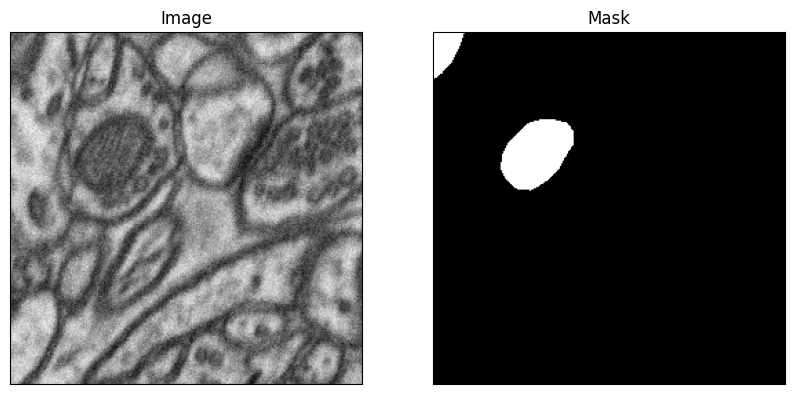

In [88]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

Get bounding boxes from masks. You can get here directly if you are working with coco style annotations where bounding boxes are captured in a JSON file.

In [89]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [119]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    #print(item)
    image = item["image"]
    print("Original mode:", image.mode)  # Should be 'L' for grayscale images

    ground_truth_mask = np.array(item["label"])

    # Add a channel dimension to the image
    #image = np.expand_dims(image, axis=0)  # Use axis=-1 if the channel-last format is expected
    # Check if the image is 2D (grayscale) and add a channel dimension
    #if image.ndim == 2:
    #  image = image[:, :, None]  # Add a channel dimension
    if image.mode == 'L':
      image = image.convert('RGB')



    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    print(image)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    print(inputs)

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [120]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [121]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [122]:
train_dataset.__getitem__(0)

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794C68433FA0>
{'pixel_values': tensor([[[[-0.3712, -0.3712, -0.3027,  ...,  0.6563,  0.6563,  0.6563],
          [-0.3712, -0.3712, -0.3027,  ...,  0.6563,  0.6563,  0.6563],
          [-0.3712, -0.3712, -0.3198,  ...,  0.6392,  0.6392,  0.6392],
          ...,
          [ 0.4679,  0.4679,  0.5193,  ..., -0.0116, -0.0116, -0.0116],
          [ 0.5022,  0.5022,  0.5536,  ..., -0.0116, -0.0116, -0.0116],
          [ 0.5022,  0.5022,  0.5536,  ..., -0.0116, -0.0116, -0.0116]],

         [[-0.2500, -0.2500, -0.1800,  ...,  0.8004,  0.8004,  0.8004],
          [-0.2500, -0.2500, -0.1800,  ...,  0.8004,  0.8004,  0.8004],
          [-0.2500, -0.2500, -0.1975,  ...,  0.7829,  0.7829,  0.7829],
          ...,
          [ 0.6078,  0.6078,  0.6604,  ...,  0.1176,  0.1176,  0.1176],
          [ 0.6429,  0.6429,  0.6954,  ...,  0.1176,  0.1176,  0.1176],
          [ 0.6429,  0.6429,  0.6954,  ...,  0.1176,  0.1176,  0.1176]],

    

{'pixel_values': tensor([[[-0.3712, -0.3712, -0.3027,  ...,  0.6563,  0.6563,  0.6563],
          [-0.3712, -0.3712, -0.3027,  ...,  0.6563,  0.6563,  0.6563],
          [-0.3712, -0.3712, -0.3198,  ...,  0.6392,  0.6392,  0.6392],
          ...,
          [ 0.4679,  0.4679,  0.5193,  ..., -0.0116, -0.0116, -0.0116],
          [ 0.5022,  0.5022,  0.5536,  ..., -0.0116, -0.0116, -0.0116],
          [ 0.5022,  0.5022,  0.5536,  ..., -0.0116, -0.0116, -0.0116]],
 
         [[-0.2500, -0.2500, -0.1800,  ...,  0.8004,  0.8004,  0.8004],
          [-0.2500, -0.2500, -0.1800,  ...,  0.8004,  0.8004,  0.8004],
          [-0.2500, -0.2500, -0.1975,  ...,  0.7829,  0.7829,  0.7829],
          ...,
          [ 0.6078,  0.6078,  0.6604,  ...,  0.1176,  0.1176,  0.1176],
          [ 0.6429,  0.6429,  0.6954,  ...,  0.1176,  0.1176,  0.1176],
          [ 0.6429,  0.6429,  0.6954,  ...,  0.1176,  0.1176,  0.1176]],
 
         [[-0.0267, -0.0267,  0.0431,  ...,  1.0191,  1.0191,  1.0191],
          [-

In [123]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)


Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794C683C26B0>
{'pixel_values': tensor([[[[-0.3712, -0.3712, -0.3027,  ...,  0.6563,  0.6563,  0.6563],
          [-0.3712, -0.3712, -0.3027,  ...,  0.6563,  0.6563,  0.6563],
          [-0.3712, -0.3712, -0.3198,  ...,  0.6392,  0.6392,  0.6392],
          ...,
          [ 0.4679,  0.4679,  0.5193,  ..., -0.0116, -0.0116, -0.0116],
          [ 0.5022,  0.5022,  0.5536,  ..., -0.0116, -0.0116, -0.0116],
          [ 0.5022,  0.5022,  0.5536,  ..., -0.0116, -0.0116, -0.0116]],

         [[-0.2500, -0.2500, -0.1800,  ...,  0.8004,  0.8004,  0.8004],
          [-0.2500, -0.2500, -0.1800,  ...,  0.8004,  0.8004,  0.8004],
          [-0.2500, -0.2500, -0.1975,  ...,  0.7829,  0.7829,  0.7829],
          ...,
          [ 0.6078,  0.6078,  0.6604,  ...,  0.1176,  0.1176,  0.1176],
          [ 0.6429,  0.6429,  0.6954,  ...,  0.1176,  0.1176,  0.1176],
          [ 0.6429,  0.6429,  0.6954,  ...,  0.1176,  0.1176,  0.1176]],

    

In [124]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [125]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794C6835BCA0>
{'pixel_values': tensor([[[[ 0.6906,  0.6906,  0.7077,  ..., -0.4397, -0.4397, -0.4397],
          [ 0.6906,  0.6906,  0.7077,  ..., -0.4397, -0.4397, -0.4397],
          [ 0.7248,  0.7248,  0.7248,  ..., -0.4054, -0.4054, -0.4054],
          ...,
          [ 0.0912,  0.0912,  0.0569,  ...,  0.1254,  0.1597,  0.1597],
          [ 0.1083,  0.1083,  0.0741,  ...,  0.0912,  0.1254,  0.1254],
          [ 0.1083,  0.1083,  0.0741,  ...,  0.0912,  0.1254,  0.1254]],

         [[ 0.8354,  0.8354,  0.8529,  ..., -0.3200, -0.3200, -0.3200],
          [ 0.8354,  0.8354,  0.8529,  ..., -0.3200, -0.3200, -0.3200],
          [ 0.8704,  0.8704,  0.8704,  ..., -0.2850, -0.2850, -0.2850],
          ...,
          [ 0.2227,  0.2227,  0.1877,  ...,  0.2577,  0.2927,  0.2927],
          [ 0.2402,  0.2402,  0.2052,  ...,  0.2227,  0.2577,  0.2577],
          [ 0.2402,  0.2402,  0.2052,  ...,  0.2227,  0.2577,  0.2577]],

    

In [126]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [127]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [128]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [129]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

  0%|          | 0/821 [00:00<?, ?it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0F9BD0>
{'pixel_values': tensor([[[[ 0.6563,  0.6563,  0.6563,  ...,  0.4851,  0.4851,  0.4851],
          [ 0.6563,  0.6563,  0.6563,  ...,  0.4851,  0.4851,  0.4851],
          [ 0.6221,  0.6221,  0.6221,  ...,  0.4851,  0.4851,  0.4851],
          ...,
          [ 1.3755,  1.3755,  1.3413,  ..., -0.1314, -0.1143, -0.1143],
          [ 1.3755,  1.3755,  1.3413,  ..., -0.1657, -0.1657, -0.1657],
          [ 1.3755,  1.3755,  1.3413,  ..., -0.1657, -0.1657, -0.1657]],

         [[ 0.8004,  0.8004,  0.8004,  ...,  0.6254,  0.6254,  0.6254],
          [ 0.8004,  0.8004,  0.8004,  ...,  0.6254,  0.6254,  0.6254],
          [ 0.7654,  0.7654,  0.7654,  ...,  0.6254,  0.6254,  0.6254],
          ...,
          [ 1.5357,  1.5357,  1.5007,  ..., -0.0049,  0.0126,  0.0126],
          [ 1.5357,  1.5357,  1.5007,  ..., -0.0399, -0.0399, -0.0399],
          [ 1.5357,  1.5357,  1.5007,  ..., -0.0399, -0.0399, -0.0399]],

    

  0%|          | 1/821 [00:01<20:27,  1.50s/it]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FAA40>
{'pixel_values': tensor([[[[1.1700, 1.1700, 1.1529,  ..., 0.2111, 0.2453, 0.2453],
          [1.1700, 1.1700, 1.1529,  ..., 0.2111, 0.2453, 0.2453],
          [1.1529, 1.1529, 1.1358,  ..., 0.1768, 0.2111, 0.2111],
          ...,
          [0.8447, 0.8447, 0.8618,  ..., 0.2624, 0.2453, 0.2453],
          [0.8104, 0.8104, 0.8447,  ..., 0.2453, 0.2111, 0.2111],
          [0.8104, 0.8104, 0.8447,  ..., 0.2453, 0.2111, 0.2111]],

         [[1.3256, 1.3256, 1.3081,  ..., 0.3452, 0.3803, 0.3803],
          [1.3256, 1.3256, 1.3081,  ..., 0.3452, 0.3803, 0.3803],
          [1.3081, 1.3081, 1.2906,  ..., 0.3102, 0.3452, 0.3452],
          ...,
          [0.9930, 0.9930, 1.0105,  ..., 0.3978, 0.3803, 0.3803],
          [0.9580, 0.9580, 0.9930,  ..., 0.3803, 0.3452, 0.3452],
          [0.9580, 0.9580, 0.9930,  ..., 0.3803, 0.3452, 0.3452]],

         [[1.5420, 1.5420, 1.5245,  ..., 0.5659, 0.6008, 0.6008],
          

  0%|          | 2/821 [00:01<11:00,  1.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FAA40>
{'pixel_values': tensor([[[[ 1.2043,  1.2043,  1.1529,  ...,  1.2899,  1.2728,  1.2728],
          [ 1.2043,  1.2043,  1.1529,  ...,  1.2899,  1.2728,  1.2728],
          [ 1.1700,  1.1700,  1.1358,  ...,  1.2728,  1.2557,  1.2557],
          ...,
          [-0.0116, -0.0116, -0.0287,  ...,  0.7591,  0.7762,  0.7762],
          [-0.0458, -0.0458, -0.0458,  ...,  0.7419,  0.7591,  0.7591],
          [-0.0458, -0.0458, -0.0458,  ...,  0.7419,  0.7591,  0.7591]],

         [[ 1.3606,  1.3606,  1.3081,  ...,  1.4482,  1.4307,  1.4307],
          [ 1.3606,  1.3606,  1.3081,  ...,  1.4482,  1.4307,  1.4307],
          [ 1.3256,  1.3256,  1.2906,  ...,  1.4307,  1.4132,  1.4132],
          ...,
          [ 0.1176,  0.1176,  0.1001,  ...,  0.9055,  0.9230,  0.9230],
          [ 0.0826,  0.0826,  0.0826,  ...,  0.8880,  0.9055,  0.9055],
          [ 0.0826,  0.0826,  0.0826,  ...,  0.8880,  0.9055,  0.9055]],

    

  0%|          | 3/821 [00:02<07:54,  1.72it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FAAD0>
{'pixel_values': tensor([[[[ 0.5536,  0.5536,  0.5707,  ...,  0.2624,  0.3309,  0.3309],
          [ 0.5536,  0.5536,  0.5707,  ...,  0.2624,  0.3309,  0.3309],
          [ 0.5707,  0.5707,  0.5878,  ...,  0.1768,  0.2282,  0.2282],
          ...,
          [ 0.8276,  0.8276,  0.8447,  ..., -0.6794, -0.6623, -0.6623],
          [ 0.8104,  0.8104,  0.8276,  ..., -0.6623, -0.6281, -0.6281],
          [ 0.8104,  0.8104,  0.8276,  ..., -0.6623, -0.6281, -0.6281]],

         [[ 0.6954,  0.6954,  0.7129,  ...,  0.3978,  0.4678,  0.4678],
          [ 0.6954,  0.6954,  0.7129,  ...,  0.3978,  0.4678,  0.4678],
          [ 0.7129,  0.7129,  0.7304,  ...,  0.3102,  0.3627,  0.3627],
          ...,
          [ 0.9755,  0.9755,  0.9930,  ..., -0.5651, -0.5476, -0.5476],
          [ 0.9580,  0.9580,  0.9755,  ..., -0.5476, -0.5126, -0.5126],
          [ 0.9580,  0.9580,  0.9755,  ..., -0.5476, -0.5126, -0.5126]],

    

  0%|          | 4/821 [00:02<06:25,  2.12it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FAA10>
{'pixel_values': tensor([[[[-0.1828, -0.1828, -0.1828,  ...,  0.6221,  0.5878,  0.5878],
          [-0.1828, -0.1828, -0.1828,  ...,  0.6221,  0.5878,  0.5878],
          [-0.2171, -0.2171, -0.1999,  ...,  0.6734,  0.6392,  0.6392],
          ...,
          [ 0.2282,  0.2282,  0.1939,  ..., -0.0801, -0.0629, -0.0629],
          [ 0.1939,  0.1939,  0.1597,  ..., -0.0458, -0.0287, -0.0287],
          [ 0.1939,  0.1939,  0.1597,  ..., -0.0458, -0.0287, -0.0287]],

         [[-0.0574, -0.0574, -0.0574,  ...,  0.7654,  0.7304,  0.7304],
          [-0.0574, -0.0574, -0.0574,  ...,  0.7654,  0.7304,  0.7304],
          [-0.0924, -0.0924, -0.0749,  ...,  0.8179,  0.7829,  0.7829],
          ...,
          [ 0.3627,  0.3627,  0.3277,  ...,  0.0476,  0.0651,  0.0651],
          [ 0.3277,  0.3277,  0.2927,  ...,  0.0826,  0.1001,  0.1001],
          [ 0.3277,  0.3277,  0.2927,  ...,  0.0826,  0.1001,  0.1001]],

    

  1%|          | 5/821 [00:02<05:37,  2.42it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FAB30>
{'pixel_values': tensor([[[[ 0.3481,  0.3481,  0.3481,  ..., -0.0116,  0.0056,  0.0056],
          [ 0.3481,  0.3481,  0.3481,  ..., -0.0116,  0.0056,  0.0056],
          [ 0.2453,  0.2453,  0.2453,  ..., -0.0287, -0.0116, -0.0116],
          ...,
          [ 0.7248,  0.7248,  0.6906,  ..., -0.5253, -0.5596, -0.5596],
          [ 0.6734,  0.6734,  0.6392,  ..., -0.5082, -0.5596, -0.5596],
          [ 0.6734,  0.6734,  0.6392,  ..., -0.5082, -0.5596, -0.5596]],

         [[ 0.4853,  0.4853,  0.4853,  ...,  0.1176,  0.1352,  0.1352],
          [ 0.4853,  0.4853,  0.4853,  ...,  0.1176,  0.1352,  0.1352],
          [ 0.3803,  0.3803,  0.3803,  ...,  0.1001,  0.1176,  0.1176],
          ...,
          [ 0.8704,  0.8704,  0.8354,  ..., -0.4076, -0.4426, -0.4426],
          [ 0.8179,  0.8179,  0.7829,  ..., -0.3901, -0.4426, -0.4426],
          [ 0.8179,  0.8179,  0.7829,  ..., -0.3901, -0.4426, -0.4426]],

    

  1%|          | 6/821 [00:03<05:08,  2.64it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FA830>
{'pixel_values': tensor([[[[-0.0972, -0.0972, -0.1314,  ...,  0.6906,  0.6392,  0.6392],
          [-0.0972, -0.0972, -0.1314,  ...,  0.6906,  0.6392,  0.6392],
          [-0.0801, -0.0801, -0.1143,  ...,  0.7248,  0.6906,  0.6906],
          ...,
          [ 0.1426,  0.1426,  0.1254,  ...,  0.0569,  0.0741,  0.0741],
          [ 0.1597,  0.1597,  0.1426,  ...,  0.0912,  0.1254,  0.1254],
          [ 0.1597,  0.1597,  0.1426,  ...,  0.0912,  0.1254,  0.1254]],

         [[ 0.0301,  0.0301, -0.0049,  ...,  0.8354,  0.7829,  0.7829],
          [ 0.0301,  0.0301, -0.0049,  ...,  0.8354,  0.7829,  0.7829],
          [ 0.0476,  0.0476,  0.0126,  ...,  0.8704,  0.8354,  0.8354],
          ...,
          [ 0.2752,  0.2752,  0.2577,  ...,  0.1877,  0.2052,  0.2052],
          [ 0.2927,  0.2927,  0.2752,  ...,  0.2227,  0.2577,  0.2577],
          [ 0.2927,  0.2927,  0.2752,  ...,  0.2227,  0.2577,  0.2577]],

    

  1%|          | 7/821 [00:03<04:50,  2.80it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0F8DF0>
{'pixel_values': tensor([[[[ 1.2214,  1.2214,  1.2214,  ...,  0.9817,  1.0159,  1.0159],
          [ 1.2214,  1.2214,  1.2214,  ...,  0.9817,  1.0159,  1.0159],
          [ 1.2043,  1.2043,  1.2043,  ...,  0.9646,  0.9988,  0.9988],
          ...,
          [-0.2856, -0.2856, -0.3198,  ..., -0.6452, -0.6623, -0.6623],
          [-0.2856, -0.2856, -0.3198,  ..., -0.6623, -0.6794, -0.6794],
          [-0.2856, -0.2856, -0.3198,  ..., -0.6623, -0.6794, -0.6794]],

         [[ 1.3782,  1.3782,  1.3782,  ...,  1.1331,  1.1681,  1.1681],
          [ 1.3782,  1.3782,  1.3782,  ...,  1.1331,  1.1681,  1.1681],
          [ 1.3606,  1.3606,  1.3606,  ...,  1.1155,  1.1506,  1.1506],
          ...,
          [-0.1625, -0.1625, -0.1975,  ..., -0.5301, -0.5476, -0.5476],
          [-0.1625, -0.1625, -0.1975,  ..., -0.5476, -0.5651, -0.5651],
          [-0.1625, -0.1625, -0.1975,  ..., -0.5476, -0.5651, -0.5651]],

    

  1%|          | 8/821 [00:03<04:40,  2.90it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FAAA0>
{'pixel_values': tensor([[[[ 0.3652,  0.3652,  0.4166,  ..., -0.0972, -0.1143, -0.1143],
          [ 0.3652,  0.3652,  0.4166,  ..., -0.0972, -0.1143, -0.1143],
          [ 0.3652,  0.3652,  0.4166,  ..., -0.1143, -0.1314, -0.1314],
          ...,
          [-0.2684, -0.2684, -0.2856,  ...,  0.9474,  0.9646,  0.9646],
          [-0.3369, -0.3369, -0.3541,  ...,  0.9817,  0.9988,  0.9988],
          [-0.3369, -0.3369, -0.3541,  ...,  0.9817,  0.9988,  0.9988]],

         [[ 0.5028,  0.5028,  0.5553,  ...,  0.0301,  0.0126,  0.0126],
          [ 0.5028,  0.5028,  0.5553,  ...,  0.0301,  0.0126,  0.0126],
          [ 0.5028,  0.5028,  0.5553,  ...,  0.0126, -0.0049, -0.0049],
          ...,
          [-0.1450, -0.1450, -0.1625,  ...,  1.0980,  1.1155,  1.1155],
          [-0.2150, -0.2150, -0.2325,  ...,  1.1331,  1.1506,  1.1506],
          [-0.2150, -0.2150, -0.2325,  ...,  1.1331,  1.1506,  1.1506]],

    

  1%|          | 9/821 [00:04<04:33,  2.97it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FA4D0>
{'pixel_values': tensor([[[[ 0.6563,  0.6563,  0.6221,  ...,  0.3994,  0.3994,  0.3994],
          [ 0.6563,  0.6563,  0.6221,  ...,  0.3994,  0.3994,  0.3994],
          [ 0.6563,  0.6563,  0.6221,  ...,  0.4337,  0.4337,  0.4337],
          ...,
          [-0.0801, -0.0801,  0.0227,  ..., -0.2513, -0.2684, -0.2684],
          [-0.1486, -0.1486, -0.0458,  ..., -0.2684, -0.2856, -0.2856],
          [-0.1486, -0.1486, -0.0458,  ..., -0.2684, -0.2856, -0.2856]],

         [[ 0.8004,  0.8004,  0.7654,  ...,  0.5378,  0.5378,  0.5378],
          [ 0.8004,  0.8004,  0.7654,  ...,  0.5378,  0.5378,  0.5378],
          [ 0.8004,  0.8004,  0.7654,  ...,  0.5728,  0.5728,  0.5728],
          ...,
          [ 0.0476,  0.0476,  0.1527,  ..., -0.1275, -0.1450, -0.1450],
          [-0.0224, -0.0224,  0.0826,  ..., -0.1450, -0.1625, -0.1625],
          [-0.0224, -0.0224,  0.0826,  ..., -0.1450, -0.1625, -0.1625]],

    

  1%|          | 10/821 [00:04<04:26,  3.04it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0F8DC0>
{'pixel_values': tensor([[[[ 0.3309,  0.3309,  0.2967,  ...,  0.4508,  0.4508,  0.4508],
          [ 0.3309,  0.3309,  0.2967,  ...,  0.4508,  0.4508,  0.4508],
          [ 0.2967,  0.2967,  0.2796,  ...,  0.5022,  0.5022,  0.5022],
          ...,
          [ 0.8618,  0.8618,  0.8618,  ..., -0.5596, -0.5938, -0.5938],
          [ 0.8961,  0.8961,  0.8961,  ..., -0.5596, -0.5938, -0.5938],
          [ 0.8961,  0.8961,  0.8961,  ..., -0.5596, -0.5938, -0.5938]],

         [[ 0.4678,  0.4678,  0.4328,  ...,  0.5903,  0.5903,  0.5903],
          [ 0.4678,  0.4678,  0.4328,  ...,  0.5903,  0.5903,  0.5903],
          [ 0.4328,  0.4328,  0.4153,  ...,  0.6429,  0.6429,  0.6429],
          ...,
          [ 1.0105,  1.0105,  1.0105,  ..., -0.4426, -0.4776, -0.4776],
          [ 1.0455,  1.0455,  1.0455,  ..., -0.4426, -0.4776, -0.4776],
          [ 1.0455,  1.0455,  1.0455,  ..., -0.4426, -0.4776, -0.4776]],

    

  1%|▏         | 11/821 [00:04<04:21,  3.10it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0F8B80>
{'pixel_values': tensor([[[[ 0.7248,  0.7248,  0.7591,  ...,  0.8961,  0.9474,  0.9474],
          [ 0.7248,  0.7248,  0.7591,  ...,  0.8961,  0.9474,  0.9474],
          [ 0.7591,  0.7591,  0.7933,  ...,  0.9132,  0.9474,  0.9474],
          ...,
          [-0.2171, -0.2171, -0.2513,  ...,  0.4508,  0.4851,  0.4851],
          [-0.2342, -0.2342, -0.2684,  ...,  0.4166,  0.4508,  0.4508],
          [-0.2342, -0.2342, -0.2684,  ...,  0.4166,  0.4508,  0.4508]],

         [[ 0.8704,  0.8704,  0.9055,  ...,  1.0455,  1.0980,  1.0980],
          [ 0.8704,  0.8704,  0.9055,  ...,  1.0455,  1.0980,  1.0980],
          [ 0.9055,  0.9055,  0.9405,  ...,  1.0630,  1.0980,  1.0980],
          ...,
          [-0.0924, -0.0924, -0.1275,  ...,  0.5903,  0.6254,  0.6254],
          [-0.1099, -0.1099, -0.1450,  ...,  0.5553,  0.5903,  0.5903],
          [-0.1099, -0.1099, -0.1450,  ...,  0.5553,  0.5903,  0.5903]],

    

  1%|▏         | 12/821 [00:04<04:18,  3.13it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FAA10>
{'pixel_values': tensor([[[[ 1.2557,  1.2557,  1.2385,  ..., -0.5767, -0.6109, -0.6109],
          [ 1.2557,  1.2557,  1.2385,  ..., -0.5767, -0.6109, -0.6109],
          [ 1.2557,  1.2557,  1.2385,  ..., -0.5424, -0.5596, -0.5596],
          ...,
          [ 0.3823,  0.3823,  0.3994,  ...,  0.5878,  0.6221,  0.6221],
          [ 0.3138,  0.3138,  0.3481,  ...,  0.6221,  0.6563,  0.6563],
          [ 0.3138,  0.3138,  0.3481,  ...,  0.6221,  0.6563,  0.6563]],

         [[ 1.4132,  1.4132,  1.3957,  ..., -0.4601, -0.4951, -0.4951],
          [ 1.4132,  1.4132,  1.3957,  ..., -0.4601, -0.4951, -0.4951],
          [ 1.4132,  1.4132,  1.3957,  ..., -0.4251, -0.4426, -0.4426],
          ...,
          [ 0.5203,  0.5203,  0.5378,  ...,  0.7304,  0.7654,  0.7654],
          [ 0.4503,  0.4503,  0.4853,  ...,  0.7654,  0.8004,  0.8004],
          [ 0.4503,  0.4503,  0.4853,  ...,  0.7654,  0.8004,  0.8004]],

    

  2%|▏         | 13/821 [00:05<04:16,  3.15it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FAA10>
{'pixel_values': tensor([[[[ 0.4851,  0.4851,  0.4851,  ...,  1.1529,  1.1358,  1.1358],
          [ 0.4851,  0.4851,  0.4851,  ...,  1.1529,  1.1358,  1.1358],
          [ 0.4851,  0.4851,  0.4851,  ...,  1.1358,  1.1187,  1.1187],
          ...,
          [ 0.7591,  0.7591,  0.7933,  ..., -0.4739, -0.4739, -0.4739],
          [ 0.7591,  0.7591,  0.7933,  ..., -0.4911, -0.4911, -0.4911],
          [ 0.7591,  0.7591,  0.7933,  ..., -0.4911, -0.4911, -0.4911]],

         [[ 0.6254,  0.6254,  0.6254,  ...,  1.3081,  1.2906,  1.2906],
          [ 0.6254,  0.6254,  0.6254,  ...,  1.3081,  1.2906,  1.2906],
          [ 0.6254,  0.6254,  0.6254,  ...,  1.2906,  1.2731,  1.2731],
          ...,
          [ 0.9055,  0.9055,  0.9405,  ..., -0.3550, -0.3550, -0.3550],
          [ 0.9055,  0.9055,  0.9405,  ..., -0.3725, -0.3725, -0.3725],
          [ 0.9055,  0.9055,  0.9405,  ..., -0.3725, -0.3725, -0.3725]],

    

  2%|▏         | 14/821 [00:05<04:13,  3.18it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FAF50>
{'pixel_values': tensor([[[[ 0.6392,  0.6392,  0.6563,  ...,  0.4337,  0.4166,  0.4166],
          [ 0.6392,  0.6392,  0.6563,  ...,  0.4337,  0.4166,  0.4166],
          [ 0.6563,  0.6563,  0.6734,  ...,  0.4508,  0.4337,  0.4337],
          ...,
          [ 0.0056,  0.0056,  0.0056,  ..., -0.1999, -0.2342, -0.2342],
          [ 0.0398,  0.0398,  0.0398,  ..., -0.2171, -0.2513, -0.2513],
          [ 0.0398,  0.0398,  0.0398,  ..., -0.2171, -0.2513, -0.2513]],

         [[ 0.7829,  0.7829,  0.8004,  ...,  0.5728,  0.5553,  0.5553],
          [ 0.7829,  0.7829,  0.8004,  ...,  0.5728,  0.5553,  0.5553],
          [ 0.8004,  0.8004,  0.8179,  ...,  0.5903,  0.5728,  0.5728],
          ...,
          [ 0.1352,  0.1352,  0.1352,  ..., -0.0749, -0.1099, -0.1099],
          [ 0.1702,  0.1702,  0.1702,  ..., -0.0924, -0.1275, -0.1275],
          [ 0.1702,  0.1702,  0.1702,  ..., -0.0924, -0.1275, -0.1275]],

    

  2%|▏         | 15/821 [00:05<04:11,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FB0D0>
{'pixel_values': tensor([[[[-0.0116, -0.0116, -0.0458,  ..., -0.0972, -0.1657, -0.1657],
          [-0.0116, -0.0116, -0.0458,  ..., -0.0972, -0.1657, -0.1657],
          [-0.0287, -0.0287, -0.0458,  ..., -0.0458, -0.1143, -0.1143],
          ...,
          [-0.4226, -0.4226, -0.4054,  ...,  0.5707,  0.5364,  0.5364],
          [-0.3883, -0.3883, -0.3883,  ...,  0.5707,  0.5364,  0.5364],
          [-0.3883, -0.3883, -0.3883,  ...,  0.5707,  0.5364,  0.5364]],

         [[ 0.1176,  0.1176,  0.0826,  ...,  0.0301, -0.0399, -0.0399],
          [ 0.1176,  0.1176,  0.0826,  ...,  0.0301, -0.0399, -0.0399],
          [ 0.1001,  0.1001,  0.0826,  ...,  0.0826,  0.0126,  0.0126],
          ...,
          [-0.3025, -0.3025, -0.2850,  ...,  0.7129,  0.6779,  0.6779],
          [-0.2675, -0.2675, -0.2675,  ...,  0.7129,  0.6779,  0.6779],
          [-0.2675, -0.2675, -0.2675,  ...,  0.7129,  0.6779,  0.6779]],

    

  2%|▏         | 16/821 [00:06<04:10,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0F8B80>
{'pixel_values': tensor([[[[-0.2856, -0.2856, -0.3198,  ...,  0.3138,  0.3138,  0.3138],
          [-0.2856, -0.2856, -0.3198,  ...,  0.3138,  0.3138,  0.3138],
          [-0.2513, -0.2513, -0.2856,  ...,  0.3823,  0.3823,  0.3823],
          ...,
          [ 0.2453,  0.2453,  0.2967,  ..., -0.1657, -0.1314, -0.1314],
          [ 0.2453,  0.2453,  0.2967,  ..., -0.1657, -0.1314, -0.1314],
          [ 0.2453,  0.2453,  0.2967,  ..., -0.1657, -0.1314, -0.1314]],

         [[-0.1625, -0.1625, -0.1975,  ...,  0.4503,  0.4503,  0.4503],
          [-0.1625, -0.1625, -0.1975,  ...,  0.4503,  0.4503,  0.4503],
          [-0.1275, -0.1275, -0.1625,  ...,  0.5203,  0.5203,  0.5203],
          ...,
          [ 0.3803,  0.3803,  0.4328,  ..., -0.0399, -0.0049, -0.0049],
          [ 0.3803,  0.3803,  0.4328,  ..., -0.0399, -0.0049, -0.0049],
          [ 0.3803,  0.3803,  0.4328,  ..., -0.0399, -0.0049, -0.0049]],

    

  2%|▏         | 17/821 [00:06<04:09,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0F8B80>
{'pixel_values': tensor([[[[0.8789, 0.8789, 0.8961,  ..., 0.5193, 0.5364, 0.5364],
          [0.8789, 0.8789, 0.8961,  ..., 0.5193, 0.5364, 0.5364],
          [0.8961, 0.8961, 0.9132,  ..., 0.5536, 0.5707, 0.5707],
          ...,
          [0.8789, 0.8789, 0.8961,  ..., 0.1939, 0.1939, 0.1939],
          [0.8961, 0.8961, 0.9132,  ..., 0.1426, 0.1426, 0.1426],
          [0.8961, 0.8961, 0.9132,  ..., 0.1426, 0.1426, 0.1426]],

         [[1.0280, 1.0280, 1.0455,  ..., 0.6604, 0.6779, 0.6779],
          [1.0280, 1.0280, 1.0455,  ..., 0.6604, 0.6779, 0.6779],
          [1.0455, 1.0455, 1.0630,  ..., 0.6954, 0.7129, 0.7129],
          ...,
          [1.0280, 1.0280, 1.0455,  ..., 0.3277, 0.3277, 0.3277],
          [1.0455, 1.0455, 1.0630,  ..., 0.2752, 0.2752, 0.2752],
          [1.0455, 1.0455, 1.0630,  ..., 0.2752, 0.2752, 0.2752]],

         [[1.2457, 1.2457, 1.2631,  ..., 0.8797, 0.8971, 0.8971],
          

  2%|▏         | 18/821 [00:06<04:09,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FAE60>
{'pixel_values': tensor([[[[ 0.7933,  0.7933,  0.7591,  ..., -0.4054, -0.4226, -0.4226],
          [ 0.7933,  0.7933,  0.7591,  ..., -0.4054, -0.4226, -0.4226],
          [ 0.7591,  0.7591,  0.7248,  ..., -0.4226, -0.4226, -0.4226],
          ...,
          [ 0.8618,  0.8618,  0.8618,  ..., -0.2684, -0.2513, -0.2513],
          [ 0.8789,  0.8789,  0.8789,  ..., -0.2342, -0.2171, -0.2171],
          [ 0.8789,  0.8789,  0.8789,  ..., -0.2342, -0.2171, -0.2171]],

         [[ 0.9405,  0.9405,  0.9055,  ..., -0.2850, -0.3025, -0.3025],
          [ 0.9405,  0.9405,  0.9055,  ..., -0.2850, -0.3025, -0.3025],
          [ 0.9055,  0.9055,  0.8704,  ..., -0.3025, -0.3025, -0.3025],
          ...,
          [ 1.0105,  1.0105,  1.0105,  ..., -0.1450, -0.1275, -0.1275],
          [ 1.0280,  1.0280,  1.0280,  ..., -0.1099, -0.0924, -0.0924],
          [ 1.0280,  1.0280,  1.0280,  ..., -0.1099, -0.0924, -0.0924]],

    

  2%|▏         | 19/821 [00:07<04:08,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FAC50>
{'pixel_values': tensor([[[[ 0.7419,  0.7419,  0.7077,  ..., -0.3027, -0.2856, -0.2856],
          [ 0.7419,  0.7419,  0.7077,  ..., -0.3027, -0.2856, -0.2856],
          [ 0.6221,  0.6221,  0.5878,  ..., -0.3198, -0.3027, -0.3027],
          ...,
          [-0.3027, -0.3027, -0.2513,  ..., -0.3198, -0.3369, -0.3369],
          [-0.3198, -0.3198, -0.2684,  ..., -0.3027, -0.3198, -0.3198],
          [-0.3198, -0.3198, -0.2684,  ..., -0.3027, -0.3198, -0.3198]],

         [[ 0.8880,  0.8880,  0.8529,  ..., -0.1800, -0.1625, -0.1625],
          [ 0.8880,  0.8880,  0.8529,  ..., -0.1800, -0.1625, -0.1625],
          [ 0.7654,  0.7654,  0.7304,  ..., -0.1975, -0.1800, -0.1800],
          ...,
          [-0.1800, -0.1800, -0.1275,  ..., -0.1975, -0.2150, -0.2150],
          [-0.1975, -0.1975, -0.1450,  ..., -0.1800, -0.1975, -0.1975],
          [-0.1975, -0.1975, -0.1450,  ..., -0.1800, -0.1975, -0.1975]],

    

  2%|▏         | 20/821 [00:07<04:07,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FB0A0>
{'pixel_values': tensor([[[[ 0.3138,  0.3138,  0.3138,  ..., -0.4568, -0.4568, -0.4568],
          [ 0.3138,  0.3138,  0.3138,  ..., -0.4568, -0.4568, -0.4568],
          [ 0.3481,  0.3481,  0.3481,  ..., -0.4397, -0.4397, -0.4397],
          ...,
          [ 0.7248,  0.7248,  0.7419,  ...,  0.2967,  0.3481,  0.3481],
          [ 0.7248,  0.7248,  0.7419,  ...,  0.3138,  0.3823,  0.3823],
          [ 0.7248,  0.7248,  0.7419,  ...,  0.3138,  0.3823,  0.3823]],

         [[ 0.4503,  0.4503,  0.4503,  ..., -0.3375, -0.3375, -0.3375],
          [ 0.4503,  0.4503,  0.4503,  ..., -0.3375, -0.3375, -0.3375],
          [ 0.4853,  0.4853,  0.4853,  ..., -0.3200, -0.3200, -0.3200],
          ...,
          [ 0.8704,  0.8704,  0.8880,  ...,  0.4328,  0.4853,  0.4853],
          [ 0.8704,  0.8704,  0.8880,  ...,  0.4503,  0.5203,  0.5203],
          [ 0.8704,  0.8704,  0.8880,  ...,  0.4503,  0.5203,  0.5203]],

    

  3%|▎         | 21/821 [00:07<04:06,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FAC50>
{'pixel_values': tensor([[[[-0.1828, -0.1828, -0.1657,  ...,  0.6221,  0.6734,  0.6734],
          [-0.1828, -0.1828, -0.1657,  ...,  0.6221,  0.6734,  0.6734],
          [-0.1999, -0.1999, -0.1828,  ...,  0.6563,  0.7077,  0.7077],
          ...,
          [-0.0629, -0.0629, -0.0458,  ...,  0.3138,  0.3138,  0.3138],
          [-0.0801, -0.0801, -0.0629,  ...,  0.2796,  0.2796,  0.2796],
          [-0.0801, -0.0801, -0.0629,  ...,  0.2796,  0.2796,  0.2796]],

         [[-0.0574, -0.0574, -0.0399,  ...,  0.7654,  0.8179,  0.8179],
          [-0.0574, -0.0574, -0.0399,  ...,  0.7654,  0.8179,  0.8179],
          [-0.0749, -0.0749, -0.0574,  ...,  0.8004,  0.8529,  0.8529],
          ...,
          [ 0.0651,  0.0651,  0.0826,  ...,  0.4503,  0.4503,  0.4503],
          [ 0.0476,  0.0476,  0.0651,  ...,  0.4153,  0.4153,  0.4153],
          [ 0.0476,  0.0476,  0.0651,  ...,  0.4153,  0.4153,  0.4153]],

    

  3%|▎         | 22/821 [00:08<04:07,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FAF20>
{'pixel_values': tensor([[[[0.1939, 0.1939, 0.2282,  ..., 0.3823, 0.3481, 0.3481],
          [0.1939, 0.1939, 0.2282,  ..., 0.3823, 0.3481, 0.3481],
          [0.2453, 0.2453, 0.2796,  ..., 0.3994, 0.3823, 0.3823],
          ...,
          [0.1597, 0.1597, 0.1254,  ..., 0.2967, 0.3481, 0.3481],
          [0.1254, 0.1254, 0.1083,  ..., 0.2967, 0.3481, 0.3481],
          [0.1254, 0.1254, 0.1083,  ..., 0.2967, 0.3481, 0.3481]],

         [[0.3277, 0.3277, 0.3627,  ..., 0.5203, 0.4853, 0.4853],
          [0.3277, 0.3277, 0.3627,  ..., 0.5203, 0.4853, 0.4853],
          [0.3803, 0.3803, 0.4153,  ..., 0.5378, 0.5203, 0.5203],
          ...,
          [0.2927, 0.2927, 0.2577,  ..., 0.4328, 0.4853, 0.4853],
          [0.2577, 0.2577, 0.2402,  ..., 0.4328, 0.4853, 0.4853],
          [0.2577, 0.2577, 0.2402,  ..., 0.4328, 0.4853, 0.4853]],

         [[0.5485, 0.5485, 0.5834,  ..., 0.7402, 0.7054, 0.7054],
          

  3%|▎         | 23/821 [00:08<04:06,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FAC20>
{'pixel_values': tensor([[[[ 0.2796,  0.2796,  0.3138,  ...,  0.1083,  0.0741,  0.0741],
          [ 0.2796,  0.2796,  0.3138,  ...,  0.1083,  0.0741,  0.0741],
          [ 0.2282,  0.2282,  0.2624,  ...,  0.1768,  0.1426,  0.1426],
          ...,
          [ 0.7419,  0.7419,  0.7419,  ..., -0.0801, -0.1314, -0.1314],
          [ 0.7419,  0.7419,  0.7248,  ..., -0.1143, -0.1828, -0.1828],
          [ 0.7419,  0.7419,  0.7248,  ..., -0.1143, -0.1828, -0.1828]],

         [[ 0.4153,  0.4153,  0.4503,  ...,  0.2402,  0.2052,  0.2052],
          [ 0.4153,  0.4153,  0.4503,  ...,  0.2402,  0.2052,  0.2052],
          [ 0.3627,  0.3627,  0.3978,  ...,  0.3102,  0.2752,  0.2752],
          ...,
          [ 0.8880,  0.8880,  0.8880,  ...,  0.0476, -0.0049, -0.0049],
          [ 0.8880,  0.8880,  0.8704,  ...,  0.0126, -0.0574, -0.0574],
          [ 0.8880,  0.8880,  0.8704,  ...,  0.0126, -0.0574, -0.0574]],

    

  3%|▎         | 24/821 [00:08<04:05,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FAF50>
{'pixel_values': tensor([[[[ 1.2385,  1.2385,  1.1187,  ...,  0.3652,  0.4166,  0.4166],
          [ 1.2385,  1.2385,  1.1187,  ...,  0.3652,  0.4166,  0.4166],
          [ 1.2728,  1.2728,  1.1529,  ...,  0.2796,  0.3309,  0.3309],
          ...,
          [-0.3541, -0.3541, -0.3198,  ...,  0.2796,  0.1939,  0.1939],
          [-0.3541, -0.3541, -0.3198,  ...,  0.1426,  0.0398,  0.0398],
          [-0.3541, -0.3541, -0.3198,  ...,  0.1426,  0.0398,  0.0398]],

         [[ 1.3957,  1.3957,  1.2731,  ...,  0.5028,  0.5553,  0.5553],
          [ 1.3957,  1.3957,  1.2731,  ...,  0.5028,  0.5553,  0.5553],
          [ 1.4307,  1.4307,  1.3081,  ...,  0.4153,  0.4678,  0.4678],
          ...,
          [-0.2325, -0.2325, -0.1975,  ...,  0.4153,  0.3277,  0.3277],
          [-0.2325, -0.2325, -0.1975,  ...,  0.2752,  0.1702,  0.1702],
          [-0.2325, -0.2325, -0.1975,  ...,  0.2752,  0.1702,  0.1702]],

    

  3%|▎         | 25/821 [00:08<04:07,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FAF50>
{'pixel_values': tensor([[[[ 0.1083,  0.1083,  0.0912,  ...,  0.3138,  0.2624,  0.2624],
          [ 0.1083,  0.1083,  0.0912,  ...,  0.3138,  0.2624,  0.2624],
          [ 0.1254,  0.1254,  0.1083,  ...,  0.2967,  0.2453,  0.2453],
          ...,
          [-0.3027, -0.3027, -0.3369,  ...,  0.2796,  0.2967,  0.2967],
          [-0.3027, -0.3027, -0.3369,  ...,  0.2967,  0.2967,  0.2967],
          [-0.3027, -0.3027, -0.3369,  ...,  0.2967,  0.2967,  0.2967]],

         [[ 0.2402,  0.2402,  0.2227,  ...,  0.4503,  0.3978,  0.3978],
          [ 0.2402,  0.2402,  0.2227,  ...,  0.4503,  0.3978,  0.3978],
          [ 0.2577,  0.2577,  0.2402,  ...,  0.4328,  0.3803,  0.3803],
          ...,
          [-0.1800, -0.1800, -0.2150,  ...,  0.4153,  0.4328,  0.4328],
          [-0.1800, -0.1800, -0.2150,  ...,  0.4328,  0.4328,  0.4328],
          [-0.1800, -0.1800, -0.2150,  ...,  0.4328,  0.4328,  0.4328]],

    

  3%|▎         | 26/821 [00:09<04:06,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FA4D0>
{'pixel_values': tensor([[[[0.3994, 0.3994, 0.4337,  ..., 0.9303, 0.9646, 0.9646],
          [0.3994, 0.3994, 0.4337,  ..., 0.9303, 0.9646, 0.9646],
          [0.4337, 0.4337, 0.4508,  ..., 0.8961, 0.9303, 0.9303],
          ...,
          [0.8789, 0.8789, 0.9132,  ..., 0.1768, 0.1426, 0.1426],
          [0.8618, 0.8618, 0.8961,  ..., 0.1768, 0.1597, 0.1597],
          [0.8618, 0.8618, 0.8961,  ..., 0.1768, 0.1597, 0.1597]],

         [[0.5378, 0.5378, 0.5728,  ..., 1.0805, 1.1155, 1.1155],
          [0.5378, 0.5378, 0.5728,  ..., 1.0805, 1.1155, 1.1155],
          [0.5728, 0.5728, 0.5903,  ..., 1.0455, 1.0805, 1.0805],
          ...,
          [1.0280, 1.0280, 1.0630,  ..., 0.3102, 0.2752, 0.2752],
          [1.0105, 1.0105, 1.0455,  ..., 0.3102, 0.2927, 0.2927],
          [1.0105, 1.0105, 1.0455,  ..., 0.3102, 0.2927, 0.2927]],

         [[0.7576, 0.7576, 0.7925,  ..., 1.2980, 1.3328, 1.3328],
          

  3%|▎         | 27/821 [00:09<04:05,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FB790>
{'pixel_values': tensor([[[[ 1.1358,  1.1358,  1.0844,  ..., -0.2684, -0.1999, -0.1999],
          [ 1.1358,  1.1358,  1.0844,  ..., -0.2684, -0.1999, -0.1999],
          [ 1.1187,  1.1187,  1.0673,  ..., -0.3027, -0.2513, -0.2513],
          ...,
          [ 0.3994,  0.3994,  0.4337,  ..., -0.2684, -0.3027, -0.3027],
          [ 0.3652,  0.3652,  0.4166,  ..., -0.3198, -0.3541, -0.3541],
          [ 0.3652,  0.3652,  0.4166,  ..., -0.3198, -0.3541, -0.3541]],

         [[ 1.2906,  1.2906,  1.2381,  ..., -0.1450, -0.0749, -0.0749],
          [ 1.2906,  1.2906,  1.2381,  ..., -0.1450, -0.0749, -0.0749],
          [ 1.2731,  1.2731,  1.2206,  ..., -0.1800, -0.1275, -0.1275],
          ...,
          [ 0.5378,  0.5378,  0.5728,  ..., -0.1450, -0.1800, -0.1800],
          [ 0.5028,  0.5028,  0.5553,  ..., -0.1975, -0.2325, -0.2325],
          [ 0.5028,  0.5028,  0.5553,  ..., -0.1975, -0.2325, -0.2325]],

    

  3%|▎         | 28/821 [00:09<04:04,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FB820>
{'pixel_values': tensor([[[[-0.2342, -0.2342, -0.1828,  ...,  0.6392,  0.6392,  0.6392],
          [-0.2342, -0.2342, -0.1828,  ...,  0.6392,  0.6392,  0.6392],
          [-0.1657, -0.1657, -0.1314,  ...,  0.6049,  0.6049,  0.6049],
          ...,
          [-0.1143, -0.1143, -0.0801,  ...,  0.0056,  0.0227,  0.0227],
          [-0.1486, -0.1486, -0.0972,  ...,  0.0056,  0.0227,  0.0227],
          [-0.1486, -0.1486, -0.0972,  ...,  0.0056,  0.0227,  0.0227]],

         [[-0.1099, -0.1099, -0.0574,  ...,  0.7829,  0.7829,  0.7829],
          [-0.1099, -0.1099, -0.0574,  ...,  0.7829,  0.7829,  0.7829],
          [-0.0399, -0.0399, -0.0049,  ...,  0.7479,  0.7479,  0.7479],
          ...,
          [ 0.0126,  0.0126,  0.0476,  ...,  0.1352,  0.1527,  0.1527],
          [-0.0224, -0.0224,  0.0301,  ...,  0.1352,  0.1527,  0.1527],
          [-0.0224, -0.0224,  0.0301,  ...,  0.1352,  0.1527,  0.1527]],

    

  4%|▎         | 29/821 [00:10<04:04,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FAFB0>
{'pixel_values': tensor([[[[-0.1828, -0.1828, -0.1486,  ...,  1.3242,  1.3242,  1.3242],
          [-0.1828, -0.1828, -0.1486,  ...,  1.3242,  1.3242,  1.3242],
          [-0.1828, -0.1828, -0.1486,  ...,  1.2899,  1.2899,  1.2899],
          ...,
          [ 0.8961,  0.8961,  0.9132,  ...,  0.6906,  0.6734,  0.6734],
          [ 0.8789,  0.8789,  0.8961,  ...,  0.6563,  0.6392,  0.6392],
          [ 0.8789,  0.8789,  0.8961,  ...,  0.6563,  0.6392,  0.6392]],

         [[-0.0574, -0.0574, -0.0224,  ...,  1.4832,  1.4832,  1.4832],
          [-0.0574, -0.0574, -0.0224,  ...,  1.4832,  1.4832,  1.4832],
          [-0.0574, -0.0574, -0.0224,  ...,  1.4482,  1.4482,  1.4482],
          ...,
          [ 1.0455,  1.0455,  1.0630,  ...,  0.8354,  0.8179,  0.8179],
          [ 1.0280,  1.0280,  1.0455,  ...,  0.8004,  0.7829,  0.7829],
          [ 1.0280,  1.0280,  1.0455,  ...,  0.8004,  0.7829,  0.7829]],

    

  4%|▎         | 30/821 [00:10<04:04,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FB820>
{'pixel_values': tensor([[[[-0.3541, -0.3541, -0.3198,  ..., -0.4226, -0.4568, -0.4568],
          [-0.3541, -0.3541, -0.3198,  ..., -0.4226, -0.4568, -0.4568],
          [-0.2856, -0.2856, -0.2684,  ..., -0.3883, -0.4054, -0.4054],
          ...,
          [ 0.3309,  0.3309,  0.3309,  ...,  0.4166,  0.3994,  0.3994],
          [ 0.3652,  0.3652,  0.3652,  ...,  0.3994,  0.3823,  0.3823],
          [ 0.3652,  0.3652,  0.3652,  ...,  0.3994,  0.3823,  0.3823]],

         [[-0.2325, -0.2325, -0.1975,  ..., -0.3025, -0.3375, -0.3375],
          [-0.2325, -0.2325, -0.1975,  ..., -0.3025, -0.3375, -0.3375],
          [-0.1625, -0.1625, -0.1450,  ..., -0.2675, -0.2850, -0.2850],
          ...,
          [ 0.4678,  0.4678,  0.4678,  ...,  0.5553,  0.5378,  0.5378],
          [ 0.5028,  0.5028,  0.5028,  ...,  0.5378,  0.5203,  0.5203],
          [ 0.5028,  0.5028,  0.5028,  ...,  0.5378,  0.5203,  0.5203]],

    

  4%|▍         | 31/821 [00:10<04:03,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FB9D0>
{'pixel_values': tensor([[[[1.1529, 1.1529, 1.1358,  ..., 0.3823, 0.3481, 0.3481],
          [1.1529, 1.1529, 1.1358,  ..., 0.3823, 0.3481, 0.3481],
          [1.1358, 1.1358, 1.1187,  ..., 0.4166, 0.3823, 0.3823],
          ...,
          [0.8789, 0.8789, 0.8618,  ..., 0.2282, 0.2453, 0.2453],
          [0.8447, 0.8447, 0.8276,  ..., 0.2282, 0.2282, 0.2282],
          [0.8447, 0.8447, 0.8276,  ..., 0.2282, 0.2282, 0.2282]],

         [[1.3081, 1.3081, 1.2906,  ..., 0.5203, 0.4853, 0.4853],
          [1.3081, 1.3081, 1.2906,  ..., 0.5203, 0.4853, 0.4853],
          [1.2906, 1.2906, 1.2731,  ..., 0.5553, 0.5203, 0.5203],
          ...,
          [1.0280, 1.0280, 1.0105,  ..., 0.3627, 0.3803, 0.3803],
          [0.9930, 0.9930, 0.9755,  ..., 0.3627, 0.3627, 0.3627],
          [0.9930, 0.9930, 0.9755,  ..., 0.3627, 0.3627, 0.3627]],

         [[1.5245, 1.5245, 1.5071,  ..., 0.7402, 0.7054, 0.7054],
          

  4%|▍         | 32/821 [00:11<04:02,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FAAA0>
{'pixel_values': tensor([[[[-0.0629, -0.0629, -0.0116,  ...,  0.4679,  0.5022,  0.5022],
          [-0.0629, -0.0629, -0.0116,  ...,  0.4679,  0.5022,  0.5022],
          [-0.0629, -0.0629, -0.0116,  ...,  0.4508,  0.4851,  0.4851],
          ...,
          [ 0.8104,  0.8104,  0.7762,  ..., -0.6109, -0.6623, -0.6623],
          [ 0.7933,  0.7933,  0.7591,  ..., -0.6452, -0.6965, -0.6965],
          [ 0.7933,  0.7933,  0.7591,  ..., -0.6452, -0.6965, -0.6965]],

         [[ 0.0651,  0.0651,  0.1176,  ...,  0.6078,  0.6429,  0.6429],
          [ 0.0651,  0.0651,  0.1176,  ...,  0.6078,  0.6429,  0.6429],
          [ 0.0651,  0.0651,  0.1176,  ...,  0.5903,  0.6254,  0.6254],
          ...,
          [ 0.9580,  0.9580,  0.9230,  ..., -0.4951, -0.5476, -0.5476],
          [ 0.9405,  0.9405,  0.9055,  ..., -0.5301, -0.5826, -0.5826],
          [ 0.9405,  0.9405,  0.9055,  ..., -0.5301, -0.5826, -0.5826]],

    

  4%|▍         | 33/821 [00:11<04:01,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FB700>
{'pixel_values': tensor([[[[ 0.1939,  0.1939,  0.1939,  ..., -0.4226, -0.3883, -0.3883],
          [ 0.1939,  0.1939,  0.1939,  ..., -0.4226, -0.3883, -0.3883],
          [ 0.1768,  0.1768,  0.1768,  ..., -0.4054, -0.3712, -0.3712],
          ...,
          [ 0.5364,  0.5364,  0.5022,  ..., -0.1828, -0.1999, -0.1999],
          [ 0.5022,  0.5022,  0.4679,  ..., -0.1999, -0.2171, -0.2171],
          [ 0.5022,  0.5022,  0.4679,  ..., -0.1999, -0.2171, -0.2171]],

         [[ 0.3277,  0.3277,  0.3277,  ..., -0.3025, -0.2675, -0.2675],
          [ 0.3277,  0.3277,  0.3277,  ..., -0.3025, -0.2675, -0.2675],
          [ 0.3102,  0.3102,  0.3102,  ..., -0.2850, -0.2500, -0.2500],
          ...,
          [ 0.6779,  0.6779,  0.6429,  ..., -0.0574, -0.0749, -0.0749],
          [ 0.6429,  0.6429,  0.6078,  ..., -0.0749, -0.0924, -0.0924],
          [ 0.6429,  0.6429,  0.6078,  ..., -0.0749, -0.0924, -0.0924]],

    

  4%|▍         | 34/821 [00:11<04:01,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794DA865BC10>
{'pixel_values': tensor([[[[ 0.8789,  0.8789,  0.8789,  ..., -0.0801, -0.1314, -0.1314],
          [ 0.8789,  0.8789,  0.8789,  ..., -0.0801, -0.1314, -0.1314],
          [ 0.8618,  0.8618,  0.8618,  ..., -0.0287, -0.0629, -0.0629],
          ...,
          [-0.4226, -0.4226, -0.4568,  ...,  0.5536,  0.5364,  0.5364],
          [-0.4054, -0.4054, -0.4568,  ...,  0.5193,  0.5022,  0.5022],
          [-0.4054, -0.4054, -0.4568,  ...,  0.5193,  0.5022,  0.5022]],

         [[ 1.0280,  1.0280,  1.0280,  ...,  0.0476, -0.0049, -0.0049],
          [ 1.0280,  1.0280,  1.0280,  ...,  0.0476, -0.0049, -0.0049],
          [ 1.0105,  1.0105,  1.0105,  ...,  0.1001,  0.0651,  0.0651],
          ...,
          [-0.3025, -0.3025, -0.3375,  ...,  0.6954,  0.6779,  0.6779],
          [-0.2850, -0.2850, -0.3375,  ...,  0.6604,  0.6429,  0.6429],
          [-0.2850, -0.2850, -0.3375,  ...,  0.6604,  0.6429,  0.6429]],

    

  4%|▍         | 35/821 [00:12<04:04,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FAE60>
{'pixel_values': tensor([[[[ 0.2282,  0.2282,  0.2796,  ..., -0.5253, -0.5082, -0.5082],
          [ 0.2282,  0.2282,  0.2796,  ..., -0.5253, -0.5082, -0.5082],
          [ 0.2282,  0.2282,  0.2796,  ..., -0.5253, -0.5082, -0.5082],
          ...,
          [ 1.3584,  1.3584,  1.3242,  ..., -0.6794, -0.6623, -0.6623],
          [ 1.3755,  1.3755,  1.3413,  ..., -0.7308, -0.7137, -0.7137],
          [ 1.3755,  1.3755,  1.3413,  ..., -0.7308, -0.7137, -0.7137]],

         [[ 0.3627,  0.3627,  0.4153,  ..., -0.4076, -0.3901, -0.3901],
          [ 0.3627,  0.3627,  0.4153,  ..., -0.4076, -0.3901, -0.3901],
          [ 0.3627,  0.3627,  0.4153,  ..., -0.4076, -0.3901, -0.3901],
          ...,
          [ 1.5182,  1.5182,  1.4832,  ..., -0.5651, -0.5476, -0.5476],
          [ 1.5357,  1.5357,  1.5007,  ..., -0.6176, -0.6001, -0.6001],
          [ 1.5357,  1.5357,  1.5007,  ..., -0.6176, -0.6001, -0.6001]],

    

  4%|▍         | 36/821 [00:12<04:02,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FB2B0>
{'pixel_values': tensor([[[[-0.0287, -0.0287, -0.0629,  ...,  1.1529,  1.1358,  1.1358],
          [-0.0287, -0.0287, -0.0629,  ...,  1.1529,  1.1358,  1.1358],
          [-0.0458, -0.0458, -0.0801,  ...,  1.1358,  1.1187,  1.1187],
          ...,
          [ 0.2282,  0.2282,  0.1939,  ..., -0.5424, -0.5596, -0.5596],
          [ 0.2282,  0.2282,  0.1939,  ..., -0.5938, -0.6109, -0.6109],
          [ 0.2282,  0.2282,  0.1939,  ..., -0.5938, -0.6109, -0.6109]],

         [[ 0.1001,  0.1001,  0.0651,  ...,  1.3081,  1.2906,  1.2906],
          [ 0.1001,  0.1001,  0.0651,  ...,  1.3081,  1.2906,  1.2906],
          [ 0.0826,  0.0826,  0.0476,  ...,  1.2906,  1.2731,  1.2731],
          ...,
          [ 0.3627,  0.3627,  0.3277,  ..., -0.4251, -0.4426, -0.4426],
          [ 0.3627,  0.3627,  0.3277,  ..., -0.4776, -0.4951, -0.4951],
          [ 0.3627,  0.3627,  0.3277,  ..., -0.4776, -0.4951, -0.4951]],

    

  5%|▍         | 37/821 [00:12<04:01,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FB9A0>
{'pixel_values': tensor([[[[0.0569, 0.0569, 0.0398,  ..., 0.9303, 0.8961, 0.8961],
          [0.0569, 0.0569, 0.0398,  ..., 0.9303, 0.8961, 0.8961],
          [0.0398, 0.0398, 0.0227,  ..., 0.9303, 0.8961, 0.8961],
          ...,
          [1.3242, 1.3242, 1.3242,  ..., 0.7933, 0.7077, 0.7077],
          [1.3413, 1.3413, 1.3413,  ..., 0.8104, 0.7248, 0.7248],
          [1.3413, 1.3413, 1.3413,  ..., 0.8104, 0.7248, 0.7248]],

         [[0.1877, 0.1877, 0.1702,  ..., 1.0805, 1.0455, 1.0455],
          [0.1877, 0.1877, 0.1702,  ..., 1.0805, 1.0455, 1.0455],
          [0.1702, 0.1702, 0.1527,  ..., 1.0805, 1.0455, 1.0455],
          ...,
          [1.4832, 1.4832, 1.4832,  ..., 0.9405, 0.8529, 0.8529],
          [1.5007, 1.5007, 1.5007,  ..., 0.9580, 0.8704, 0.8704],
          [1.5007, 1.5007, 1.5007,  ..., 0.9580, 0.8704, 0.8704]],

         [[0.4091, 0.4091, 0.3916,  ..., 1.2980, 1.2631, 1.2631],
          

  5%|▍         | 38/821 [00:12<04:02,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0F95D0>
{'pixel_values': tensor([[[[ 0.4337,  0.4337,  0.4337,  ...,  0.6734,  0.6392,  0.6392],
          [ 0.4337,  0.4337,  0.4337,  ...,  0.6734,  0.6392,  0.6392],
          [ 0.4508,  0.4508,  0.4337,  ...,  0.6906,  0.6563,  0.6563],
          ...,
          [ 0.0398,  0.0398,  0.0569,  ..., -0.2171, -0.1999, -0.1999],
          [ 0.0056,  0.0056,  0.0227,  ..., -0.2171, -0.1999, -0.1999],
          [ 0.0056,  0.0056,  0.0227,  ..., -0.2171, -0.1999, -0.1999]],

         [[ 0.5728,  0.5728,  0.5728,  ...,  0.8179,  0.7829,  0.7829],
          [ 0.5728,  0.5728,  0.5728,  ...,  0.8179,  0.7829,  0.7829],
          [ 0.5903,  0.5903,  0.5728,  ...,  0.8354,  0.8004,  0.8004],
          ...,
          [ 0.1702,  0.1702,  0.1877,  ..., -0.0924, -0.0749, -0.0749],
          [ 0.1352,  0.1352,  0.1527,  ..., -0.0924, -0.0749, -0.0749],
          [ 0.1352,  0.1352,  0.1527,  ..., -0.0924, -0.0749, -0.0749]],

    

  5%|▍         | 39/821 [00:13<04:01,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0F95D0>
{'pixel_values': tensor([[[[-0.1999, -0.1999, -0.1828,  ..., -0.4568, -0.4739, -0.4739],
          [-0.1999, -0.1999, -0.1828,  ..., -0.4568, -0.4739, -0.4739],
          [-0.1999, -0.1999, -0.1828,  ..., -0.4568, -0.4739, -0.4739],
          ...,
          [ 1.1700,  1.1700,  1.1529,  ...,  1.1529,  1.1529,  1.1529],
          [ 1.2557,  1.2557,  1.2214,  ...,  1.1700,  1.1700,  1.1700],
          [ 1.2557,  1.2557,  1.2214,  ...,  1.1700,  1.1700,  1.1700]],

         [[-0.0749, -0.0749, -0.0574,  ..., -0.3375, -0.3550, -0.3550],
          [-0.0749, -0.0749, -0.0574,  ..., -0.3375, -0.3550, -0.3550],
          [-0.0749, -0.0749, -0.0574,  ..., -0.3375, -0.3550, -0.3550],
          ...,
          [ 1.3256,  1.3256,  1.3081,  ...,  1.3081,  1.3081,  1.3081],
          [ 1.4132,  1.4132,  1.3782,  ...,  1.3256,  1.3256,  1.3256],
          [ 1.4132,  1.4132,  1.3782,  ...,  1.3256,  1.3256,  1.3256]],

    

  5%|▍         | 40/821 [00:13<04:01,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0F95D0>
{'pixel_values': tensor([[[[ 0.4851,  0.4851,  0.4851,  ..., -0.5424, -0.5596, -0.5596],
          [ 0.4851,  0.4851,  0.4851,  ..., -0.5424, -0.5596, -0.5596],
          [ 0.5022,  0.5022,  0.4851,  ..., -0.5253, -0.5424, -0.5424],
          ...,
          [ 0.7419,  0.7419,  0.7248,  ...,  0.2624,  0.3138,  0.3138],
          [ 0.7419,  0.7419,  0.7248,  ...,  0.2796,  0.3309,  0.3309],
          [ 0.7419,  0.7419,  0.7248,  ...,  0.2796,  0.3309,  0.3309]],

         [[ 0.6254,  0.6254,  0.6254,  ..., -0.4251, -0.4426, -0.4426],
          [ 0.6254,  0.6254,  0.6254,  ..., -0.4251, -0.4426, -0.4426],
          [ 0.6429,  0.6429,  0.6254,  ..., -0.4076, -0.4251, -0.4251],
          ...,
          [ 0.8880,  0.8880,  0.8704,  ...,  0.3978,  0.4503,  0.4503],
          [ 0.8880,  0.8880,  0.8704,  ...,  0.4153,  0.4678,  0.4678],
          [ 0.8880,  0.8880,  0.8704,  ...,  0.4153,  0.4678,  0.4678]],

    

  5%|▍         | 41/821 [00:13<04:01,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FBBE0>
{'pixel_values': tensor([[[[-0.2171, -0.2171, -0.1828,  ...,  0.8276,  0.8618,  0.8618],
          [-0.2171, -0.2171, -0.1828,  ...,  0.8276,  0.8618,  0.8618],
          [-0.2342, -0.2342, -0.1999,  ...,  0.7419,  0.7762,  0.7762],
          ...,
          [ 0.8276,  0.8276,  0.8447,  ...,  0.7419,  0.7419,  0.7419],
          [ 0.8447,  0.8447,  0.8618,  ...,  0.7591,  0.7591,  0.7591],
          [ 0.8447,  0.8447,  0.8618,  ...,  0.7591,  0.7591,  0.7591]],

         [[-0.0924, -0.0924, -0.0574,  ...,  0.9755,  1.0105,  1.0105],
          [-0.0924, -0.0924, -0.0574,  ...,  0.9755,  1.0105,  1.0105],
          [-0.1099, -0.1099, -0.0749,  ...,  0.8880,  0.9230,  0.9230],
          ...,
          [ 0.9755,  0.9755,  0.9930,  ...,  0.8880,  0.8880,  0.8880],
          [ 0.9930,  0.9930,  1.0105,  ...,  0.9055,  0.9055,  0.9055],
          [ 0.9930,  0.9930,  1.0105,  ...,  0.9055,  0.9055,  0.9055]],

    

  5%|▌         | 42/821 [00:14<04:00,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FB2E0>
{'pixel_values': tensor([[[[ 0.9646,  0.9646,  0.9303,  ...,  1.2043,  1.2043,  1.2043],
          [ 0.9646,  0.9646,  0.9303,  ...,  1.2043,  1.2043,  1.2043],
          [ 0.9474,  0.9474,  0.9132,  ...,  1.2043,  1.2043,  1.2043],
          ...,
          [ 0.2282,  0.2282,  0.2624,  ..., -0.5596, -0.5767, -0.5767],
          [ 0.2282,  0.2282,  0.2624,  ..., -0.5424, -0.5596, -0.5596],
          [ 0.2282,  0.2282,  0.2624,  ..., -0.5424, -0.5596, -0.5596]],

         [[ 1.1155,  1.1155,  1.0805,  ...,  1.3606,  1.3606,  1.3606],
          [ 1.1155,  1.1155,  1.0805,  ...,  1.3606,  1.3606,  1.3606],
          [ 1.0980,  1.0980,  1.0630,  ...,  1.3606,  1.3606,  1.3606],
          ...,
          [ 0.3627,  0.3627,  0.3978,  ..., -0.4426, -0.4601, -0.4601],
          [ 0.3627,  0.3627,  0.3978,  ..., -0.4251, -0.4426, -0.4426],
          [ 0.3627,  0.3627,  0.3978,  ..., -0.4251, -0.4426, -0.4426]],

    

  5%|▌         | 43/821 [00:14<03:59,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FBE80>
{'pixel_values': tensor([[[[ 0.7762,  0.7762,  0.7933,  ..., -0.2342, -0.1828, -0.1828],
          [ 0.7762,  0.7762,  0.7933,  ..., -0.2342, -0.1828, -0.1828],
          [ 0.7591,  0.7591,  0.7762,  ..., -0.2856, -0.2342, -0.2342],
          ...,
          [ 0.9132,  0.9132,  0.8789,  ...,  0.1939,  0.1768,  0.1768],
          [ 0.9132,  0.9132,  0.8789,  ...,  0.2111,  0.1939,  0.1939],
          [ 0.9132,  0.9132,  0.8789,  ...,  0.2111,  0.1939,  0.1939]],

         [[ 0.9230,  0.9230,  0.9405,  ..., -0.1099, -0.0574, -0.0574],
          [ 0.9230,  0.9230,  0.9405,  ..., -0.1099, -0.0574, -0.0574],
          [ 0.9055,  0.9055,  0.9230,  ..., -0.1625, -0.1099, -0.1099],
          ...,
          [ 1.0630,  1.0630,  1.0280,  ...,  0.3277,  0.3102,  0.3102],
          [ 1.0630,  1.0630,  1.0280,  ...,  0.3452,  0.3277,  0.3277],
          [ 1.0630,  1.0630,  1.0280,  ...,  0.3452,  0.3277,  0.3277]],

    

  5%|▌         | 44/821 [00:14<03:59,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FBFA0>
{'pixel_values': tensor([[[[-0.3198, -0.3198, -0.3198,  ...,  0.2796,  0.3309,  0.3309],
          [-0.3198, -0.3198, -0.3198,  ...,  0.2796,  0.3309,  0.3309],
          [-0.3198, -0.3198, -0.3027,  ...,  0.3138,  0.3652,  0.3652],
          ...,
          [ 0.0056,  0.0056, -0.0116,  ...,  0.6906,  0.6563,  0.6563],
          [ 0.0227,  0.0227,  0.0056,  ...,  0.6734,  0.6563,  0.6563],
          [ 0.0227,  0.0227,  0.0056,  ...,  0.6734,  0.6563,  0.6563]],

         [[-0.1975, -0.1975, -0.1975,  ...,  0.4153,  0.4678,  0.4678],
          [-0.1975, -0.1975, -0.1975,  ...,  0.4153,  0.4678,  0.4678],
          [-0.1975, -0.1975, -0.1800,  ...,  0.4503,  0.5028,  0.5028],
          ...,
          [ 0.1352,  0.1352,  0.1176,  ...,  0.8354,  0.8004,  0.8004],
          [ 0.1527,  0.1527,  0.1352,  ...,  0.8179,  0.8004,  0.8004],
          [ 0.1527,  0.1527,  0.1352,  ...,  0.8179,  0.8004,  0.8004]],

    

  5%|▌         | 45/821 [00:15<04:00,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FBEE0>
{'pixel_values': tensor([[[[ 0.1939,  0.1939,  0.1426,  ...,  0.5022,  0.5364,  0.5364],
          [ 0.1939,  0.1939,  0.1426,  ...,  0.5022,  0.5364,  0.5364],
          [ 0.2282,  0.2282,  0.1768,  ...,  0.4508,  0.4851,  0.4851],
          ...,
          [ 0.8789,  0.8789,  0.8618,  ..., -0.0287, -0.0116, -0.0116],
          [ 0.8961,  0.8961,  0.8789,  ..., -0.0458, -0.0287, -0.0287],
          [ 0.8961,  0.8961,  0.8789,  ..., -0.0458, -0.0287, -0.0287]],

         [[ 0.3277,  0.3277,  0.2752,  ...,  0.6429,  0.6779,  0.6779],
          [ 0.3277,  0.3277,  0.2752,  ...,  0.6429,  0.6779,  0.6779],
          [ 0.3627,  0.3627,  0.3102,  ...,  0.5903,  0.6254,  0.6254],
          ...,
          [ 1.0280,  1.0280,  1.0105,  ...,  0.1001,  0.1176,  0.1176],
          [ 1.0455,  1.0455,  1.0280,  ...,  0.0826,  0.1001,  0.1001],
          [ 1.0455,  1.0455,  1.0280,  ...,  0.0826,  0.1001,  0.1001]],

    

  6%|▌         | 46/821 [00:15<04:00,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FB2B0>
{'pixel_values': tensor([[[[-0.0458, -0.0458, -0.0801,  ...,  0.8789,  0.8961,  0.8961],
          [-0.0458, -0.0458, -0.0801,  ...,  0.8789,  0.8961,  0.8961],
          [-0.0116, -0.0116, -0.0458,  ...,  0.9132,  0.9303,  0.9303],
          ...,
          [ 0.4851,  0.4851,  0.4679,  ...,  0.6049,  0.6221,  0.6221],
          [ 0.4679,  0.4679,  0.4508,  ...,  0.6049,  0.6221,  0.6221],
          [ 0.4679,  0.4679,  0.4508,  ...,  0.6049,  0.6221,  0.6221]],

         [[ 0.0826,  0.0826,  0.0476,  ...,  1.0280,  1.0455,  1.0455],
          [ 0.0826,  0.0826,  0.0476,  ...,  1.0280,  1.0455,  1.0455],
          [ 0.1176,  0.1176,  0.0826,  ...,  1.0630,  1.0805,  1.0805],
          ...,
          [ 0.6254,  0.6254,  0.6078,  ...,  0.7479,  0.7654,  0.7654],
          [ 0.6078,  0.6078,  0.5903,  ...,  0.7479,  0.7654,  0.7654],
          [ 0.6078,  0.6078,  0.5903,  ...,  0.7479,  0.7654,  0.7654]],

    

  6%|▌         | 47/821 [00:15<04:01,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FBFA0>
{'pixel_values': tensor([[[[ 0.8447,  0.8447,  0.8104,  ...,  0.8789,  0.8447,  0.8447],
          [ 0.8447,  0.8447,  0.8104,  ...,  0.8789,  0.8447,  0.8447],
          [ 0.8618,  0.8618,  0.8276,  ...,  0.8961,  0.8618,  0.8618],
          ...,
          [-0.1314, -0.1314, -0.1657,  ...,  0.2624,  0.2624,  0.2624],
          [-0.1143, -0.1143, -0.1486,  ...,  0.2453,  0.2453,  0.2453],
          [-0.1143, -0.1143, -0.1486,  ...,  0.2453,  0.2453,  0.2453]],

         [[ 0.9930,  0.9930,  0.9580,  ...,  1.0280,  0.9930,  0.9930],
          [ 0.9930,  0.9930,  0.9580,  ...,  1.0280,  0.9930,  0.9930],
          [ 1.0105,  1.0105,  0.9755,  ...,  1.0455,  1.0105,  1.0105],
          ...,
          [-0.0049, -0.0049, -0.0399,  ...,  0.3978,  0.3978,  0.3978],
          [ 0.0126,  0.0126, -0.0224,  ...,  0.3803,  0.3803,  0.3803],
          [ 0.0126,  0.0126, -0.0224,  ...,  0.3803,  0.3803,  0.3803]],

    

  6%|▌         | 48/821 [00:16<04:04,  3.16it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FBFA0>
{'pixel_values': tensor([[[[ 1.1358,  1.1358,  1.1187,  ...,  1.1015,  1.1015,  1.1015],
          [ 1.1358,  1.1358,  1.1187,  ...,  1.1015,  1.1015,  1.1015],
          [ 1.1700,  1.1700,  1.1529,  ...,  1.0844,  1.0844,  1.0844],
          ...,
          [-0.3369, -0.3369, -0.3369,  ..., -0.2513, -0.2684, -0.2684],
          [-0.3712, -0.3712, -0.3712,  ..., -0.2684, -0.2856, -0.2856],
          [-0.3712, -0.3712, -0.3712,  ..., -0.2684, -0.2856, -0.2856]],

         [[ 1.2906,  1.2906,  1.2731,  ...,  1.2556,  1.2556,  1.2556],
          [ 1.2906,  1.2906,  1.2731,  ...,  1.2556,  1.2556,  1.2556],
          [ 1.3256,  1.3256,  1.3081,  ...,  1.2381,  1.2381,  1.2381],
          ...,
          [-0.2150, -0.2150, -0.2150,  ..., -0.1275, -0.1450, -0.1450],
          [-0.2500, -0.2500, -0.2500,  ..., -0.1450, -0.1625, -0.1625],
          [-0.2500, -0.2500, -0.2500,  ..., -0.1450, -0.1625, -0.1625]],

    

  6%|▌         | 49/821 [00:16<04:07,  3.12it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF144130>
{'pixel_values': tensor([[[[0.9132, 0.9132, 0.9303,  ..., 0.0912, 0.0741, 0.0741],
          [0.9132, 0.9132, 0.9303,  ..., 0.0912, 0.0741, 0.0741],
          [0.9303, 0.9303, 0.9474,  ..., 0.0912, 0.0741, 0.0741],
          ...,
          [0.2967, 0.2967, 0.2967,  ..., 0.4508, 0.4166, 0.4166],
          [0.3481, 0.3481, 0.3309,  ..., 0.4337, 0.3823, 0.3823],
          [0.3481, 0.3481, 0.3309,  ..., 0.4337, 0.3823, 0.3823]],

         [[1.0630, 1.0630, 1.0805,  ..., 0.2227, 0.2052, 0.2052],
          [1.0630, 1.0630, 1.0805,  ..., 0.2227, 0.2052, 0.2052],
          [1.0805, 1.0805, 1.0980,  ..., 0.2227, 0.2052, 0.2052],
          ...,
          [0.4328, 0.4328, 0.4328,  ..., 0.5903, 0.5553, 0.5553],
          [0.4853, 0.4853, 0.4678,  ..., 0.5728, 0.5203, 0.5203],
          [0.4853, 0.4853, 0.4678,  ..., 0.5728, 0.5203, 0.5203]],

         [[1.2805, 1.2805, 1.2980,  ..., 0.4439, 0.4265, 0.4265],
          

  6%|▌         | 50/821 [00:16<04:09,  3.09it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FBBE0>
{'pixel_values': tensor([[[[1.0159, 1.0159, 0.9817,  ..., 0.1768, 0.1768, 0.1768],
          [1.0159, 1.0159, 0.9817,  ..., 0.1768, 0.1768, 0.1768],
          [1.0159, 1.0159, 0.9817,  ..., 0.1254, 0.1254, 0.1254],
          ...,
          [0.5022, 0.5022, 0.4508,  ..., 0.8618, 0.8789, 0.8789],
          [0.5707, 0.5707, 0.5193,  ..., 0.8961, 0.9132, 0.9132],
          [0.5707, 0.5707, 0.5193,  ..., 0.8961, 0.9132, 0.9132]],

         [[1.1681, 1.1681, 1.1331,  ..., 0.3102, 0.3102, 0.3102],
          [1.1681, 1.1681, 1.1331,  ..., 0.3102, 0.3102, 0.3102],
          [1.1681, 1.1681, 1.1331,  ..., 0.2577, 0.2577, 0.2577],
          ...,
          [0.6429, 0.6429, 0.5903,  ..., 1.0105, 1.0280, 1.0280],
          [0.7129, 0.7129, 0.6604,  ..., 1.0455, 1.0630, 1.0630],
          [0.7129, 0.7129, 0.6604,  ..., 1.0455, 1.0630, 1.0630]],

         [[1.3851, 1.3851, 1.3502,  ..., 0.5311, 0.5311, 0.5311],
          

  6%|▌         | 51/821 [00:17<04:11,  3.06it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1402E0>
{'pixel_values': tensor([[[[ 0.0569,  0.0569,  0.0569,  ...,  0.9303,  0.9474,  0.9474],
          [ 0.0569,  0.0569,  0.0569,  ...,  0.9303,  0.9474,  0.9474],
          [ 0.0056,  0.0056,  0.0056,  ...,  0.9474,  0.9646,  0.9646],
          ...,
          [ 0.6049,  0.6049,  0.6221,  ..., -0.4911, -0.5082, -0.5082],
          [ 0.6049,  0.6049,  0.6221,  ..., -0.4911, -0.4911, -0.4911],
          [ 0.6049,  0.6049,  0.6221,  ..., -0.4911, -0.4911, -0.4911]],

         [[ 0.1877,  0.1877,  0.1877,  ...,  1.0805,  1.0980,  1.0980],
          [ 0.1877,  0.1877,  0.1877,  ...,  1.0805,  1.0980,  1.0980],
          [ 0.1352,  0.1352,  0.1352,  ...,  1.0980,  1.1155,  1.1155],
          ...,
          [ 0.7479,  0.7479,  0.7654,  ..., -0.3725, -0.3901, -0.3901],
          [ 0.7479,  0.7479,  0.7654,  ..., -0.3725, -0.3725, -0.3725],
          [ 0.7479,  0.7479,  0.7654,  ..., -0.3725, -0.3725, -0.3725]],

    

  6%|▋         | 52/821 [00:17<04:08,  3.10it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FBC40>
{'pixel_values': tensor([[[[0.9817, 0.9817, 0.9817,  ..., 0.8618, 0.9132, 0.9132],
          [0.9817, 0.9817, 0.9817,  ..., 0.8618, 0.9132, 0.9132],
          [0.9646, 0.9646, 0.9646,  ..., 0.8276, 0.8618, 0.8618],
          ...,
          [0.5878, 0.5878, 0.5707,  ..., 0.2624, 0.2111, 0.2111],
          [0.5536, 0.5536, 0.5364,  ..., 0.1939, 0.1426, 0.1426],
          [0.5536, 0.5536, 0.5364,  ..., 0.1939, 0.1426, 0.1426]],

         [[1.1331, 1.1331, 1.1331,  ..., 1.0105, 1.0630, 1.0630],
          [1.1331, 1.1331, 1.1331,  ..., 1.0105, 1.0630, 1.0630],
          [1.1155, 1.1155, 1.1155,  ..., 0.9755, 1.0105, 1.0105],
          ...,
          [0.7304, 0.7304, 0.7129,  ..., 0.3978, 0.3452, 0.3452],
          [0.6954, 0.6954, 0.6779,  ..., 0.3277, 0.2752, 0.2752],
          [0.6954, 0.6954, 0.6779,  ..., 0.3277, 0.2752, 0.2752]],

         [[1.3502, 1.3502, 1.3502,  ..., 1.2282, 1.2805, 1.2805],
          

  6%|▋         | 53/821 [00:17<04:05,  3.13it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FBBE0>
{'pixel_values': tensor([[[[ 0.0741,  0.0741,  0.0741,  ..., -0.4568, -0.4739, -0.4739],
          [ 0.0741,  0.0741,  0.0741,  ..., -0.4568, -0.4739, -0.4739],
          [ 0.0569,  0.0569,  0.0569,  ..., -0.4568, -0.4739, -0.4739],
          ...,
          [ 0.5364,  0.5364,  0.5364,  ..., -0.2856, -0.2856, -0.2856],
          [ 0.5364,  0.5364,  0.5193,  ..., -0.2856, -0.2856, -0.2856],
          [ 0.5364,  0.5364,  0.5193,  ..., -0.2856, -0.2856, -0.2856]],

         [[ 0.2052,  0.2052,  0.2052,  ..., -0.3375, -0.3550, -0.3550],
          [ 0.2052,  0.2052,  0.2052,  ..., -0.3375, -0.3550, -0.3550],
          [ 0.1877,  0.1877,  0.1877,  ..., -0.3375, -0.3550, -0.3550],
          ...,
          [ 0.6779,  0.6779,  0.6779,  ..., -0.1625, -0.1625, -0.1625],
          [ 0.6779,  0.6779,  0.6604,  ..., -0.1625, -0.1625, -0.1625],
          [ 0.6779,  0.6779,  0.6604,  ..., -0.1625, -0.1625, -0.1625]],

    

  7%|▋         | 54/821 [00:18<04:03,  3.15it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FBFA0>
{'pixel_values': tensor([[[[-0.3027, -0.3027, -0.2684,  ...,  0.0912,  0.0741,  0.0741],
          [-0.3027, -0.3027, -0.2684,  ...,  0.0912,  0.0741,  0.0741],
          [-0.2856, -0.2856, -0.2342,  ...,  0.0912,  0.0741,  0.0741],
          ...,
          [-0.0116, -0.0116, -0.0287,  ..., -0.0116,  0.0569,  0.0569],
          [ 0.0056,  0.0056, -0.0116,  ..., -0.0116,  0.0569,  0.0569],
          [ 0.0056,  0.0056, -0.0116,  ..., -0.0116,  0.0569,  0.0569]],

         [[-0.1800, -0.1800, -0.1450,  ...,  0.2227,  0.2052,  0.2052],
          [-0.1800, -0.1800, -0.1450,  ...,  0.2227,  0.2052,  0.2052],
          [-0.1625, -0.1625, -0.1099,  ...,  0.2227,  0.2052,  0.2052],
          ...,
          [ 0.1176,  0.1176,  0.1001,  ...,  0.1176,  0.1877,  0.1877],
          [ 0.1352,  0.1352,  0.1176,  ...,  0.1176,  0.1877,  0.1877],
          [ 0.1352,  0.1352,  0.1176,  ...,  0.1176,  0.1877,  0.1877]],

    

  7%|▋         | 55/821 [00:18<04:01,  3.17it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF140790>
{'pixel_values': tensor([[[[-0.0629, -0.0629, -0.0287,  ...,  0.9646,  1.0331,  1.0331],
          [-0.0629, -0.0629, -0.0287,  ...,  0.9646,  1.0331,  1.0331],
          [-0.0801, -0.0801, -0.0458,  ...,  0.9303,  0.9817,  0.9817],
          ...,
          [ 0.2282,  0.2282,  0.1939,  ...,  0.2967,  0.3138,  0.3138],
          [ 0.2796,  0.2796,  0.2282,  ...,  0.2624,  0.2796,  0.2796],
          [ 0.2796,  0.2796,  0.2282,  ...,  0.2624,  0.2796,  0.2796]],

         [[ 0.0651,  0.0651,  0.1001,  ...,  1.1155,  1.1856,  1.1856],
          [ 0.0651,  0.0651,  0.1001,  ...,  1.1155,  1.1856,  1.1856],
          [ 0.0476,  0.0476,  0.0826,  ...,  1.0805,  1.1331,  1.1331],
          ...,
          [ 0.3627,  0.3627,  0.3277,  ...,  0.4328,  0.4503,  0.4503],
          [ 0.4153,  0.4153,  0.3627,  ...,  0.3978,  0.4153,  0.4153],
          [ 0.4153,  0.4153,  0.3627,  ...,  0.3978,  0.4153,  0.4153]],

    

  7%|▋         | 56/821 [00:18<03:59,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF140880>
{'pixel_values': tensor([[[[1.4440, 1.4440, 1.4269,  ..., 0.8104, 0.8104, 0.8104],
          [1.4440, 1.4440, 1.4269,  ..., 0.8104, 0.8104, 0.8104],
          [1.4098, 1.4098, 1.4098,  ..., 0.8276, 0.8276, 0.8276],
          ...,
          [0.6221, 0.6221, 0.6392,  ..., 0.0398, 0.0569, 0.0569],
          [0.6392, 0.6392, 0.6563,  ..., 0.0398, 0.0569, 0.0569],
          [0.6392, 0.6392, 0.6563,  ..., 0.0398, 0.0569, 0.0569]],

         [[1.6057, 1.6057, 1.5882,  ..., 0.9580, 0.9580, 0.9580],
          [1.6057, 1.6057, 1.5882,  ..., 0.9580, 0.9580, 0.9580],
          [1.5707, 1.5707, 1.5707,  ..., 0.9755, 0.9755, 0.9755],
          ...,
          [0.7654, 0.7654, 0.7829,  ..., 0.1702, 0.1877, 0.1877],
          [0.7829, 0.7829, 0.8004,  ..., 0.1702, 0.1877, 0.1877],
          [0.7829, 0.7829, 0.8004,  ..., 0.1702, 0.1877, 0.1877]],

         [[1.8208, 1.8208, 1.8034,  ..., 1.1759, 1.1759, 1.1759],
          

  7%|▋         | 57/821 [00:18<04:00,  3.18it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794E0317A440>
{'pixel_values': tensor([[[[-0.0972, -0.0972, -0.1314,  ..., -0.1657, -0.1657, -0.1657],
          [-0.0972, -0.0972, -0.1314,  ..., -0.1657, -0.1657, -0.1657],
          [-0.0972, -0.0972, -0.1314,  ..., -0.1999, -0.1999, -0.1999],
          ...,
          [ 1.0673,  1.0673,  1.0673,  ...,  1.1015,  1.1015,  1.1015],
          [ 1.0502,  1.0502,  1.0502,  ...,  1.1015,  1.0844,  1.0844],
          [ 1.0502,  1.0502,  1.0502,  ...,  1.1015,  1.0844,  1.0844]],

         [[ 0.0301,  0.0301, -0.0049,  ..., -0.0399, -0.0399, -0.0399],
          [ 0.0301,  0.0301, -0.0049,  ..., -0.0399, -0.0399, -0.0399],
          [ 0.0301,  0.0301, -0.0049,  ..., -0.0749, -0.0749, -0.0749],
          ...,
          [ 1.2206,  1.2206,  1.2206,  ...,  1.2556,  1.2556,  1.2556],
          [ 1.2031,  1.2031,  1.2031,  ...,  1.2556,  1.2381,  1.2381],
          [ 1.2031,  1.2031,  1.2031,  ...,  1.2556,  1.2381,  1.2381]],

    

  7%|▋         | 58/821 [00:19<03:59,  3.18it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794E0317A440>
{'pixel_values': tensor([[[[ 1.1358,  1.1358,  1.1700,  ..., -0.4911, -0.5082, -0.5082],
          [ 1.1358,  1.1358,  1.1700,  ..., -0.4911, -0.5082, -0.5082],
          [ 1.1187,  1.1187,  1.1529,  ..., -0.4911, -0.5253, -0.5253],
          ...,
          [-0.2856, -0.2856, -0.3027,  ..., -0.6109, -0.6281, -0.6281],
          [-0.3712, -0.3712, -0.3712,  ..., -0.6281, -0.6281, -0.6281],
          [-0.3712, -0.3712, -0.3712,  ..., -0.6281, -0.6281, -0.6281]],

         [[ 1.2906,  1.2906,  1.3256,  ..., -0.3725, -0.3901, -0.3901],
          [ 1.2906,  1.2906,  1.3256,  ..., -0.3725, -0.3901, -0.3901],
          [ 1.2731,  1.2731,  1.3081,  ..., -0.3725, -0.4076, -0.4076],
          ...,
          [-0.1625, -0.1625, -0.1800,  ..., -0.4951, -0.5126, -0.5126],
          [-0.2500, -0.2500, -0.2500,  ..., -0.5126, -0.5126, -0.5126],
          [-0.2500, -0.2500, -0.2500,  ..., -0.5126, -0.5126, -0.5126]],

    

  7%|▋         | 59/821 [00:19<03:58,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794E0317A440>
{'pixel_values': tensor([[[[ 0.0056,  0.0056, -0.0116,  ...,  0.9817,  0.9646,  0.9646],
          [ 0.0056,  0.0056, -0.0116,  ...,  0.9817,  0.9646,  0.9646],
          [-0.0116, -0.0116, -0.0287,  ...,  0.9988,  0.9817,  0.9817],
          ...,
          [ 0.8789,  0.8789,  0.9303,  ..., -0.4568, -0.4739, -0.4739],
          [ 0.8789,  0.8789,  0.9303,  ..., -0.5082, -0.5253, -0.5253],
          [ 0.8789,  0.8789,  0.9303,  ..., -0.5082, -0.5253, -0.5253]],

         [[ 0.1352,  0.1352,  0.1176,  ...,  1.1331,  1.1155,  1.1155],
          [ 0.1352,  0.1352,  0.1176,  ...,  1.1331,  1.1155,  1.1155],
          [ 0.1176,  0.1176,  0.1001,  ...,  1.1506,  1.1331,  1.1331],
          ...,
          [ 1.0280,  1.0280,  1.0805,  ..., -0.3375, -0.3550, -0.3550],
          [ 1.0280,  1.0280,  1.0805,  ..., -0.3901, -0.4076, -0.4076],
          [ 1.0280,  1.0280,  1.0805,  ..., -0.3901, -0.4076, -0.4076]],

    

  7%|▋         | 60/821 [00:19<03:58,  3.18it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794E0317A440>
{'pixel_values': tensor([[[[ 0.3652,  0.3652,  0.3994,  ..., -0.3027, -0.3541, -0.3541],
          [ 0.3652,  0.3652,  0.3994,  ..., -0.3027, -0.3541, -0.3541],
          [ 0.3823,  0.3823,  0.3994,  ..., -0.3027, -0.3541, -0.3541],
          ...,
          [-0.3712, -0.3712, -0.3712,  ...,  0.6392,  0.6221,  0.6221],
          [-0.3541, -0.3541, -0.3541,  ...,  0.5878,  0.5707,  0.5707],
          [-0.3541, -0.3541, -0.3541,  ...,  0.5878,  0.5707,  0.5707]],

         [[ 0.5028,  0.5028,  0.5378,  ..., -0.1800, -0.2325, -0.2325],
          [ 0.5028,  0.5028,  0.5378,  ..., -0.1800, -0.2325, -0.2325],
          [ 0.5203,  0.5203,  0.5378,  ..., -0.1800, -0.2325, -0.2325],
          ...,
          [-0.2500, -0.2500, -0.2500,  ...,  0.7829,  0.7654,  0.7654],
          [-0.2325, -0.2325, -0.2325,  ...,  0.7304,  0.7129,  0.7129],
          [-0.2325, -0.2325, -0.2325,  ...,  0.7304,  0.7129,  0.7129]],

    

  7%|▋         | 61/821 [00:20<03:58,  3.18it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794E0317A440>
{'pixel_values': tensor([[[[0.1083, 0.1083, 0.1254,  ..., 0.9817, 1.0331, 1.0331],
          [0.1083, 0.1083, 0.1254,  ..., 0.9817, 1.0331, 1.0331],
          [0.0912, 0.0912, 0.1083,  ..., 0.9132, 0.9646, 0.9646],
          ...,
          [0.7933, 0.7933, 0.8276,  ..., 0.8618, 0.8961, 0.8961],
          [0.7933, 0.7933, 0.8276,  ..., 0.8789, 0.9132, 0.9132],
          [0.7933, 0.7933, 0.8276,  ..., 0.8789, 0.9132, 0.9132]],

         [[0.2402, 0.2402, 0.2577,  ..., 1.1331, 1.1856, 1.1856],
          [0.2402, 0.2402, 0.2577,  ..., 1.1331, 1.1856, 1.1856],
          [0.2227, 0.2227, 0.2402,  ..., 1.0630, 1.1155, 1.1155],
          ...,
          [0.9405, 0.9405, 0.9755,  ..., 1.0105, 1.0455, 1.0455],
          [0.9405, 0.9405, 0.9755,  ..., 1.0280, 1.0630, 1.0630],
          [0.9405, 0.9405, 0.9755,  ..., 1.0280, 1.0630, 1.0630]],

         [[0.4614, 0.4614, 0.4788,  ..., 1.3502, 1.4025, 1.4025],
          

  8%|▊         | 62/821 [00:20<03:58,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FAAA0>
{'pixel_values': tensor([[[[-0.2856, -0.2856, -0.2513,  ...,  0.6221,  0.6906,  0.6906],
          [-0.2856, -0.2856, -0.2513,  ...,  0.6221,  0.6906,  0.6906],
          [-0.3027, -0.3027, -0.2684,  ...,  0.5536,  0.6221,  0.6221],
          ...,
          [ 0.5707,  0.5707,  0.5878,  ...,  0.5707,  0.5878,  0.5878],
          [ 0.6049,  0.6049,  0.6221,  ...,  0.5536,  0.5707,  0.5707],
          [ 0.6049,  0.6049,  0.6221,  ...,  0.5536,  0.5707,  0.5707]],

         [[-0.1625, -0.1625, -0.1275,  ...,  0.7654,  0.8354,  0.8354],
          [-0.1625, -0.1625, -0.1275,  ...,  0.7654,  0.8354,  0.8354],
          [-0.1800, -0.1800, -0.1450,  ...,  0.6954,  0.7654,  0.7654],
          ...,
          [ 0.7129,  0.7129,  0.7304,  ...,  0.7129,  0.7304,  0.7304],
          [ 0.7479,  0.7479,  0.7654,  ...,  0.6954,  0.7129,  0.7129],
          [ 0.7479,  0.7479,  0.7654,  ...,  0.6954,  0.7129,  0.7129]],

    

  8%|▊         | 63/821 [00:20<03:56,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF0FAAA0>
{'pixel_values': tensor([[[[ 0.9303,  0.9303,  0.8789,  ...,  0.0056, -0.0287, -0.0287],
          [ 0.9303,  0.9303,  0.8789,  ...,  0.0056, -0.0287, -0.0287],
          [ 0.8789,  0.8789,  0.8276,  ...,  0.0569,  0.0227,  0.0227],
          ...,
          [ 1.1015,  1.1015,  1.0844,  ...,  1.0844,  1.1358,  1.1358],
          [ 1.1187,  1.1187,  1.1015,  ...,  1.0673,  1.1187,  1.1187],
          [ 1.1187,  1.1187,  1.1015,  ...,  1.0673,  1.1187,  1.1187]],

         [[ 1.0805,  1.0805,  1.0280,  ...,  0.1352,  0.1001,  0.1001],
          [ 1.0805,  1.0805,  1.0280,  ...,  0.1352,  0.1001,  0.1001],
          [ 1.0280,  1.0280,  0.9755,  ...,  0.1877,  0.1527,  0.1527],
          ...,
          [ 1.2556,  1.2556,  1.2381,  ...,  1.2381,  1.2906,  1.2906],
          [ 1.2731,  1.2731,  1.2556,  ...,  1.2206,  1.2731,  1.2731],
          [ 1.2731,  1.2731,  1.2556,  ...,  1.2206,  1.2731,  1.2731]],

    

  8%|▊         | 64/821 [00:21<03:55,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF140CD0>
{'pixel_values': tensor([[[[0.9817, 0.9817, 0.9474,  ..., 0.8789, 0.8447, 0.8447],
          [0.9817, 0.9817, 0.9474,  ..., 0.8789, 0.8447, 0.8447],
          [0.9817, 0.9817, 0.9474,  ..., 0.8961, 0.8618, 0.8618],
          ...,
          [0.8961, 0.8961, 0.8618,  ..., 1.1187, 1.1358, 1.1358],
          [0.9303, 0.9303, 0.8789,  ..., 1.1187, 1.1358, 1.1358],
          [0.9303, 0.9303, 0.8789,  ..., 1.1187, 1.1358, 1.1358]],

         [[1.1331, 1.1331, 1.0980,  ..., 1.0280, 0.9930, 0.9930],
          [1.1331, 1.1331, 1.0980,  ..., 1.0280, 0.9930, 0.9930],
          [1.1331, 1.1331, 1.0980,  ..., 1.0455, 1.0105, 1.0105],
          ...,
          [1.0455, 1.0455, 1.0105,  ..., 1.2731, 1.2906, 1.2906],
          [1.0805, 1.0805, 1.0280,  ..., 1.2731, 1.2906, 1.2906],
          [1.0805, 1.0805, 1.0280,  ..., 1.2731, 1.2906, 1.2906]],

         [[1.3502, 1.3502, 1.3154,  ..., 1.2457, 1.2108, 1.2108],
          

  8%|▊         | 65/821 [00:21<03:54,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF140DC0>
{'pixel_values': tensor([[[[-0.2171, -0.2171, -0.1486,  ...,  1.1187,  1.1358,  1.1358],
          [-0.2171, -0.2171, -0.1486,  ...,  1.1187,  1.1358,  1.1358],
          [-0.2171, -0.2171, -0.1486,  ...,  1.1187,  1.1358,  1.1358],
          ...,
          [ 0.6734,  0.6734,  0.6392,  ..., -0.4397, -0.4226, -0.4226],
          [ 0.6221,  0.6221,  0.5878,  ..., -0.4226, -0.4054, -0.4054],
          [ 0.6221,  0.6221,  0.5878,  ..., -0.4226, -0.4054, -0.4054]],

         [[-0.0924, -0.0924, -0.0224,  ...,  1.2731,  1.2906,  1.2906],
          [-0.0924, -0.0924, -0.0224,  ...,  1.2731,  1.2906,  1.2906],
          [-0.0924, -0.0924, -0.0224,  ...,  1.2731,  1.2906,  1.2906],
          ...,
          [ 0.8179,  0.8179,  0.7829,  ..., -0.3200, -0.3025, -0.3025],
          [ 0.7654,  0.7654,  0.7304,  ..., -0.3025, -0.2850, -0.2850],
          [ 0.7654,  0.7654,  0.7304,  ..., -0.3025, -0.2850, -0.2850]],

    

  8%|▊         | 66/821 [00:21<03:57,  3.18it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1406D0>
{'pixel_values': tensor([[[[ 0.0227,  0.0227,  0.0912,  ..., -0.0458, -0.0629, -0.0629],
          [ 0.0227,  0.0227,  0.0912,  ..., -0.0458, -0.0629, -0.0629],
          [ 0.0741,  0.0741,  0.1254,  ..., -0.0629, -0.0629, -0.0629],
          ...,
          [ 0.3138,  0.3138,  0.2624,  ...,  0.8447,  0.8618,  0.8618],
          [ 0.2967,  0.2967,  0.2453,  ...,  0.8447,  0.8618,  0.8618],
          [ 0.2967,  0.2967,  0.2453,  ...,  0.8447,  0.8618,  0.8618]],

         [[ 0.1527,  0.1527,  0.2227,  ...,  0.0826,  0.0651,  0.0651],
          [ 0.1527,  0.1527,  0.2227,  ...,  0.0826,  0.0651,  0.0651],
          [ 0.2052,  0.2052,  0.2577,  ...,  0.0651,  0.0651,  0.0651],
          ...,
          [ 0.4503,  0.4503,  0.3978,  ...,  0.9930,  1.0105,  1.0105],
          [ 0.4328,  0.4328,  0.3803,  ...,  0.9930,  1.0105,  1.0105],
          [ 0.4328,  0.4328,  0.3803,  ...,  0.9930,  1.0105,  1.0105]],

    

  8%|▊         | 67/821 [00:22<03:59,  3.15it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1408B0>
{'pixel_values': tensor([[[[ 0.4337,  0.4337,  0.5022,  ...,  0.1083,  0.1083,  0.1083],
          [ 0.4337,  0.4337,  0.5022,  ...,  0.1083,  0.1083,  0.1083],
          [ 0.4851,  0.4851,  0.5536,  ...,  0.1083,  0.1083,  0.1083],
          ...,
          [ 0.9132,  0.9132,  0.9474,  ..., -0.3369, -0.4054, -0.4054],
          [ 0.8961,  0.8961,  0.9303,  ..., -0.3712, -0.4568, -0.4568],
          [ 0.8961,  0.8961,  0.9303,  ..., -0.3712, -0.4568, -0.4568]],

         [[ 0.5728,  0.5728,  0.6429,  ...,  0.2402,  0.2402,  0.2402],
          [ 0.5728,  0.5728,  0.6429,  ...,  0.2402,  0.2402,  0.2402],
          [ 0.6254,  0.6254,  0.6954,  ...,  0.2402,  0.2402,  0.2402],
          ...,
          [ 1.0630,  1.0630,  1.0980,  ..., -0.2150, -0.2850, -0.2850],
          [ 1.0455,  1.0455,  1.0805,  ..., -0.2500, -0.3375, -0.3375],
          [ 1.0455,  1.0455,  1.0805,  ..., -0.2500, -0.3375, -0.3375]],

    

  8%|▊         | 68/821 [00:22<03:57,  3.18it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF140CD0>
{'pixel_values': tensor([[[[ 0.8618,  0.8618,  0.8618,  ...,  1.1700,  1.2043,  1.2043],
          [ 0.8618,  0.8618,  0.8618,  ...,  1.1700,  1.2043,  1.2043],
          [ 0.8276,  0.8276,  0.8276,  ...,  1.1187,  1.1529,  1.1529],
          ...,
          [-0.3712, -0.3712, -0.3369,  ...,  0.4851,  0.4851,  0.4851],
          [-0.3712, -0.3712, -0.3369,  ...,  0.4508,  0.4508,  0.4508],
          [-0.3712, -0.3712, -0.3369,  ...,  0.4508,  0.4508,  0.4508]],

         [[ 1.0105,  1.0105,  1.0105,  ...,  1.3256,  1.3606,  1.3606],
          [ 1.0105,  1.0105,  1.0105,  ...,  1.3256,  1.3606,  1.3606],
          [ 0.9755,  0.9755,  0.9755,  ...,  1.2731,  1.3081,  1.3081],
          ...,
          [-0.2500, -0.2500, -0.2150,  ...,  0.6254,  0.6254,  0.6254],
          [-0.2500, -0.2500, -0.2150,  ...,  0.5903,  0.5903,  0.5903],
          [-0.2500, -0.2500, -0.2150,  ...,  0.5903,  0.5903,  0.5903]],

    

  8%|▊         | 69/821 [00:22<03:58,  3.15it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF140DC0>
{'pixel_values': tensor([[[[ 0.4851,  0.4851,  0.4337,  ...,  0.1768,  0.1768,  0.1768],
          [ 0.4851,  0.4851,  0.4337,  ...,  0.1768,  0.1768,  0.1768],
          [ 0.4508,  0.4508,  0.3994,  ...,  0.2453,  0.2624,  0.2624],
          ...,
          [ 0.6734,  0.6734,  0.6906,  ..., -0.3883, -0.4397, -0.4397],
          [ 0.6734,  0.6734,  0.6906,  ..., -0.4054, -0.4568, -0.4568],
          [ 0.6734,  0.6734,  0.6906,  ..., -0.4054, -0.4568, -0.4568]],

         [[ 0.6254,  0.6254,  0.5728,  ...,  0.3102,  0.3102,  0.3102],
          [ 0.6254,  0.6254,  0.5728,  ...,  0.3102,  0.3102,  0.3102],
          [ 0.5903,  0.5903,  0.5378,  ...,  0.3803,  0.3978,  0.3978],
          ...,
          [ 0.8179,  0.8179,  0.8354,  ..., -0.2675, -0.3200, -0.3200],
          [ 0.8179,  0.8179,  0.8354,  ..., -0.2850, -0.3375, -0.3375],
          [ 0.8179,  0.8179,  0.8354,  ..., -0.2850, -0.3375, -0.3375]],

    

  9%|▊         | 70/821 [00:23<04:01,  3.10it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF140DF0>
{'pixel_values': tensor([[[[ 1.0844,  1.0844,  1.0844,  ..., -0.2684, -0.3198, -0.3198],
          [ 1.0844,  1.0844,  1.0844,  ..., -0.2684, -0.3198, -0.3198],
          [ 1.0844,  1.0844,  1.0844,  ..., -0.2684, -0.3198, -0.3198],
          ...,
          [-0.3883, -0.3883, -0.3883,  ...,  0.9646,  0.9303,  0.9303],
          [-0.3712, -0.3712, -0.3712,  ...,  0.9303,  0.8961,  0.8961],
          [-0.3712, -0.3712, -0.3712,  ...,  0.9303,  0.8961,  0.8961]],

         [[ 1.2381,  1.2381,  1.2381,  ..., -0.1450, -0.1975, -0.1975],
          [ 1.2381,  1.2381,  1.2381,  ..., -0.1450, -0.1975, -0.1975],
          [ 1.2381,  1.2381,  1.2381,  ..., -0.1450, -0.1975, -0.1975],
          ...,
          [-0.2675, -0.2675, -0.2675,  ...,  1.1155,  1.0805,  1.0805],
          [-0.2500, -0.2500, -0.2500,  ...,  1.0805,  1.0455,  1.0455],
          [-0.2500, -0.2500, -0.2500,  ...,  1.0805,  1.0455,  1.0455]],

    

  9%|▊         | 71/821 [00:23<03:59,  3.13it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1410C0>
{'pixel_values': tensor([[[[ 0.9303,  0.9303,  0.8789,  ...,  0.9132,  0.8618,  0.8618],
          [ 0.9303,  0.9303,  0.8789,  ...,  0.9132,  0.8618,  0.8618],
          [ 0.8618,  0.8618,  0.8276,  ...,  0.9474,  0.8961,  0.8961],
          ...,
          [-0.4226, -0.4226, -0.4568,  ...,  0.7419,  0.7591,  0.7591],
          [-0.4226, -0.4226, -0.4568,  ...,  0.7762,  0.8104,  0.8104],
          [-0.4226, -0.4226, -0.4568,  ...,  0.7762,  0.8104,  0.8104]],

         [[ 1.0805,  1.0805,  1.0280,  ...,  1.0630,  1.0105,  1.0105],
          [ 1.0805,  1.0805,  1.0280,  ...,  1.0630,  1.0105,  1.0105],
          [ 1.0105,  1.0105,  0.9755,  ...,  1.0980,  1.0455,  1.0455],
          ...,
          [-0.3025, -0.3025, -0.3375,  ...,  0.8880,  0.9055,  0.9055],
          [-0.3025, -0.3025, -0.3375,  ...,  0.9230,  0.9580,  0.9580],
          [-0.3025, -0.3025, -0.3375,  ...,  0.9230,  0.9580,  0.9580]],

    

  9%|▉         | 72/821 [00:23<03:57,  3.16it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF141120>
{'pixel_values': tensor([[[[ 1.0331,  1.0331,  0.9817,  ..., -0.7479, -0.7650, -0.7650],
          [ 1.0331,  1.0331,  0.9817,  ..., -0.7479, -0.7650, -0.7650],
          [ 0.9646,  0.9646,  0.9303,  ..., -0.7479, -0.7650, -0.7650],
          ...,
          [ 0.9817,  0.9817,  0.9474,  ...,  0.7933,  0.7762,  0.7762],
          [ 0.9817,  0.9817,  0.9474,  ...,  0.7933,  0.7762,  0.7762],
          [ 0.9817,  0.9817,  0.9474,  ...,  0.7933,  0.7762,  0.7762]],

         [[ 1.1856,  1.1856,  1.1331,  ..., -0.6352, -0.6527, -0.6527],
          [ 1.1856,  1.1856,  1.1331,  ..., -0.6352, -0.6527, -0.6527],
          [ 1.1155,  1.1155,  1.0805,  ..., -0.6352, -0.6527, -0.6527],
          ...,
          [ 1.1331,  1.1331,  1.0980,  ...,  0.9405,  0.9230,  0.9230],
          [ 1.1331,  1.1331,  1.0980,  ...,  0.9405,  0.9230,  0.9230],
          [ 1.1331,  1.1331,  1.0980,  ...,  0.9405,  0.9230,  0.9230]],

    

  9%|▉         | 73/821 [00:23<03:55,  3.18it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF140100>
{'pixel_values': tensor([[[[ 0.4679,  0.4679,  0.4679,  ...,  0.9474,  0.9474,  0.9474],
          [ 0.4679,  0.4679,  0.4679,  ...,  0.9474,  0.9474,  0.9474],
          [ 0.4679,  0.4679,  0.4679,  ...,  0.9132,  0.9132,  0.9132],
          ...,
          [-0.1999, -0.1999, -0.1657,  ..., -0.0972, -0.1143, -0.1143],
          [-0.2171, -0.2171, -0.1828,  ..., -0.0972, -0.1143, -0.1143],
          [-0.2171, -0.2171, -0.1828,  ..., -0.0972, -0.1143, -0.1143]],

         [[ 0.6078,  0.6078,  0.6078,  ...,  1.0980,  1.0980,  1.0980],
          [ 0.6078,  0.6078,  0.6078,  ...,  1.0980,  1.0980,  1.0980],
          [ 0.6078,  0.6078,  0.6078,  ...,  1.0630,  1.0630,  1.0630],
          ...,
          [-0.0749, -0.0749, -0.0399,  ...,  0.0301,  0.0126,  0.0126],
          [-0.0924, -0.0924, -0.0574,  ...,  0.0301,  0.0126,  0.0126],
          [-0.0924, -0.0924, -0.0574,  ...,  0.0301,  0.0126,  0.0126]],

    

  9%|▉         | 74/821 [00:24<03:54,  3.18it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF141210>
{'pixel_values': tensor([[[[ 0.9646,  0.9646,  0.9817,  ...,  0.9988,  0.9988,  0.9988],
          [ 0.9646,  0.9646,  0.9817,  ...,  0.9988,  0.9988,  0.9988],
          [ 0.9474,  0.9474,  0.9646,  ...,  0.9646,  0.9646,  0.9646],
          ...,
          [ 0.9646,  0.9646,  0.9474,  ..., -0.5767, -0.5596, -0.5596],
          [ 0.9474,  0.9474,  0.9474,  ..., -0.6281, -0.6281, -0.6281],
          [ 0.9474,  0.9474,  0.9474,  ..., -0.6281, -0.6281, -0.6281]],

         [[ 1.1155,  1.1155,  1.1331,  ...,  1.1506,  1.1506,  1.1506],
          [ 1.1155,  1.1155,  1.1331,  ...,  1.1506,  1.1506,  1.1506],
          [ 1.0980,  1.0980,  1.1155,  ...,  1.1155,  1.1155,  1.1155],
          ...,
          [ 1.1155,  1.1155,  1.0980,  ..., -0.4601, -0.4426, -0.4426],
          [ 1.0980,  1.0980,  1.0980,  ..., -0.5126, -0.5126, -0.5126],
          [ 1.0980,  1.0980,  1.0980,  ..., -0.5126, -0.5126, -0.5126]],

    

  9%|▉         | 75/821 [00:24<03:53,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1402E0>
{'pixel_values': tensor([[[[-0.5596, -0.5596, -0.5424,  ...,  1.0844,  1.0844,  1.0844],
          [-0.5596, -0.5596, -0.5424,  ...,  1.0844,  1.0844,  1.0844],
          [-0.4911, -0.4911, -0.4911,  ...,  1.1015,  1.1015,  1.1015],
          ...,
          [ 0.4851,  0.4851,  0.5022,  ..., -0.1314, -0.1657, -0.1657],
          [ 0.5022,  0.5022,  0.5193,  ..., -0.1143, -0.1486, -0.1486],
          [ 0.5022,  0.5022,  0.5193,  ..., -0.1143, -0.1486, -0.1486]],

         [[-0.4426, -0.4426, -0.4251,  ...,  1.2381,  1.2381,  1.2381],
          [-0.4426, -0.4426, -0.4251,  ...,  1.2381,  1.2381,  1.2381],
          [-0.3725, -0.3725, -0.3725,  ...,  1.2556,  1.2556,  1.2556],
          ...,
          [ 0.6254,  0.6254,  0.6429,  ..., -0.0049, -0.0399, -0.0399],
          [ 0.6429,  0.6429,  0.6604,  ...,  0.0126, -0.0224, -0.0224],
          [ 0.6429,  0.6429,  0.6604,  ...,  0.0126, -0.0224, -0.0224]],

    

  9%|▉         | 76/821 [00:24<03:53,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF140100>
{'pixel_values': tensor([[[[ 0.4166,  0.4166,  0.4337,  ...,  1.0159,  1.0159,  1.0159],
          [ 0.4166,  0.4166,  0.4337,  ...,  1.0159,  1.0159,  1.0159],
          [ 0.3994,  0.3994,  0.4166,  ...,  1.0331,  1.0331,  1.0331],
          ...,
          [ 0.6563,  0.6563,  0.6563,  ..., -0.0287,  0.0056,  0.0056],
          [ 0.6563,  0.6563,  0.6734,  ...,  0.0056,  0.0569,  0.0569],
          [ 0.6563,  0.6563,  0.6734,  ...,  0.0056,  0.0569,  0.0569]],

         [[ 0.5553,  0.5553,  0.5728,  ...,  1.1681,  1.1681,  1.1681],
          [ 0.5553,  0.5553,  0.5728,  ...,  1.1681,  1.1681,  1.1681],
          [ 0.5378,  0.5378,  0.5553,  ...,  1.1856,  1.1856,  1.1856],
          ...,
          [ 0.8004,  0.8004,  0.8004,  ...,  0.1001,  0.1352,  0.1352],
          [ 0.8004,  0.8004,  0.8179,  ...,  0.1352,  0.1877,  0.1877],
          [ 0.8004,  0.8004,  0.8179,  ...,  0.1352,  0.1877,  0.1877]],

    

  9%|▉         | 77/821 [00:25<03:54,  3.17it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF140940>
{'pixel_values': tensor([[[[ 1.1358,  1.1358,  1.1529,  ...,  1.0844,  1.1187,  1.1187],
          [ 1.1358,  1.1358,  1.1529,  ...,  1.0844,  1.1187,  1.1187],
          [ 1.1529,  1.1529,  1.1700,  ...,  1.0844,  1.1015,  1.1015],
          ...,
          [ 1.0673,  1.0673,  1.0502,  ..., -0.0972, -0.1486, -0.1486],
          [ 1.1187,  1.1187,  1.0844,  ..., -0.1314, -0.1828, -0.1828],
          [ 1.1187,  1.1187,  1.0844,  ..., -0.1314, -0.1828, -0.1828]],

         [[ 1.2906,  1.2906,  1.3081,  ...,  1.2381,  1.2731,  1.2731],
          [ 1.2906,  1.2906,  1.3081,  ...,  1.2381,  1.2731,  1.2731],
          [ 1.3081,  1.3081,  1.3256,  ...,  1.2381,  1.2556,  1.2556],
          ...,
          [ 1.2206,  1.2206,  1.2031,  ...,  0.0301, -0.0224, -0.0224],
          [ 1.2731,  1.2731,  1.2381,  ..., -0.0049, -0.0574, -0.0574],
          [ 1.2731,  1.2731,  1.2381,  ..., -0.0049, -0.0574, -0.0574]],

    

 10%|▉         | 78/821 [00:25<03:55,  3.16it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF140C10>
{'pixel_values': tensor([[[[ 0.4337,  0.4337,  0.4851,  ...,  0.8276,  0.8447,  0.8447],
          [ 0.4337,  0.4337,  0.4851,  ...,  0.8276,  0.8447,  0.8447],
          [ 0.4679,  0.4679,  0.5022,  ...,  0.8104,  0.8276,  0.8276],
          ...,
          [-0.3883, -0.3883, -0.4054,  ...,  0.4508,  0.4679,  0.4679],
          [-0.4397, -0.4397, -0.4568,  ...,  0.4337,  0.4508,  0.4508],
          [-0.4397, -0.4397, -0.4568,  ...,  0.4337,  0.4508,  0.4508]],

         [[ 0.5728,  0.5728,  0.6254,  ...,  0.9755,  0.9930,  0.9930],
          [ 0.5728,  0.5728,  0.6254,  ...,  0.9755,  0.9930,  0.9930],
          [ 0.6078,  0.6078,  0.6429,  ...,  0.9580,  0.9755,  0.9755],
          ...,
          [-0.2675, -0.2675, -0.2850,  ...,  0.5903,  0.6078,  0.6078],
          [-0.3200, -0.3200, -0.3375,  ...,  0.5728,  0.5903,  0.5903],
          [-0.3200, -0.3200, -0.3375,  ...,  0.5728,  0.5903,  0.5903]],

    

 10%|▉         | 79/821 [00:25<03:56,  3.14it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1415D0>
{'pixel_values': tensor([[[[0.2967, 0.2967, 0.3138,  ..., 0.7077, 0.6563, 0.6563],
          [0.2967, 0.2967, 0.3138,  ..., 0.7077, 0.6563, 0.6563],
          [0.3138, 0.3138, 0.3309,  ..., 0.7248, 0.6734, 0.6734],
          ...,
          [1.2899, 1.2899, 1.2728,  ..., 0.2453, 0.2453, 0.2453],
          [1.3242, 1.3242, 1.3070,  ..., 0.2282, 0.2282, 0.2282],
          [1.3242, 1.3242, 1.3070,  ..., 0.2282, 0.2282, 0.2282]],

         [[0.4328, 0.4328, 0.4503,  ..., 0.8529, 0.8004, 0.8004],
          [0.4328, 0.4328, 0.4503,  ..., 0.8529, 0.8004, 0.8004],
          [0.4503, 0.4503, 0.4678,  ..., 0.8704, 0.8179, 0.8179],
          ...,
          [1.4482, 1.4482, 1.4307,  ..., 0.3803, 0.3803, 0.3803],
          [1.4832, 1.4832, 1.4657,  ..., 0.3627, 0.3627, 0.3627],
          [1.4832, 1.4832, 1.4657,  ..., 0.3627, 0.3627, 0.3627]],

         [[0.6531, 0.6531, 0.6705,  ..., 1.0714, 1.0191, 1.0191],
          

 10%|▉         | 80/821 [00:26<03:53,  3.18it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF141450>
{'pixel_values': tensor([[[[ 1.1015,  1.1015,  1.1015,  ..., -0.1828, -0.1999, -0.1999],
          [ 1.1015,  1.1015,  1.1015,  ..., -0.1828, -0.1999, -0.1999],
          [ 1.1015,  1.1015,  1.1015,  ..., -0.1999, -0.1999, -0.1999],
          ...,
          [ 0.9474,  0.9474,  0.9646,  ..., -0.2856, -0.2856, -0.2856],
          [ 0.9474,  0.9474,  0.9646,  ..., -0.2684, -0.2684, -0.2684],
          [ 0.9474,  0.9474,  0.9646,  ..., -0.2684, -0.2684, -0.2684]],

         [[ 1.2556,  1.2556,  1.2556,  ..., -0.0574, -0.0749, -0.0749],
          [ 1.2556,  1.2556,  1.2556,  ..., -0.0574, -0.0749, -0.0749],
          [ 1.2556,  1.2556,  1.2556,  ..., -0.0749, -0.0749, -0.0749],
          ...,
          [ 1.0980,  1.0980,  1.1155,  ..., -0.1625, -0.1625, -0.1625],
          [ 1.0980,  1.0980,  1.1155,  ..., -0.1450, -0.1450, -0.1450],
          [ 1.0980,  1.0980,  1.1155,  ..., -0.1450, -0.1450, -0.1450]],

    

 10%|▉         | 81/821 [00:26<03:51,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF141330>
{'pixel_values': tensor([[[[-0.5082, -0.5082, -0.4911,  ...,  0.4508,  0.4337,  0.4337],
          [-0.5082, -0.5082, -0.4911,  ...,  0.4508,  0.4337,  0.4337],
          [-0.5082, -0.5082, -0.4911,  ...,  0.4508,  0.4166,  0.4166],
          ...,
          [ 1.0673,  1.0673,  1.0159,  ..., -0.1999, -0.1828, -0.1828],
          [ 1.1015,  1.1015,  1.0502,  ..., -0.1486, -0.1314, -0.1314],
          [ 1.1015,  1.1015,  1.0502,  ..., -0.1486, -0.1314, -0.1314]],

         [[-0.3901, -0.3901, -0.3725,  ...,  0.5903,  0.5728,  0.5728],
          [-0.3901, -0.3901, -0.3725,  ...,  0.5903,  0.5728,  0.5728],
          [-0.3901, -0.3901, -0.3725,  ...,  0.5903,  0.5553,  0.5553],
          ...,
          [ 1.2206,  1.2206,  1.1681,  ..., -0.0749, -0.0574, -0.0574],
          [ 1.2556,  1.2556,  1.2031,  ..., -0.0224, -0.0049, -0.0049],
          [ 1.2556,  1.2556,  1.2031,  ..., -0.0224, -0.0049, -0.0049]],

    

 10%|▉         | 82/821 [00:26<03:50,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1410C0>
{'pixel_values': tensor([[[[ 0.8961,  0.8961,  0.8789,  ..., -0.5596, -0.5767, -0.5767],
          [ 0.8961,  0.8961,  0.8789,  ..., -0.5596, -0.5767, -0.5767],
          [ 0.8618,  0.8618,  0.8447,  ..., -0.5424, -0.5596, -0.5596],
          ...,
          [ 0.4851,  0.4851,  0.4679,  ..., -0.4739, -0.4739, -0.4739],
          [ 0.4679,  0.4679,  0.4508,  ..., -0.5082, -0.5082, -0.5082],
          [ 0.4679,  0.4679,  0.4508,  ..., -0.5082, -0.5082, -0.5082]],

         [[ 1.0455,  1.0455,  1.0280,  ..., -0.4426, -0.4601, -0.4601],
          [ 1.0455,  1.0455,  1.0280,  ..., -0.4426, -0.4601, -0.4601],
          [ 1.0105,  1.0105,  0.9930,  ..., -0.4251, -0.4426, -0.4426],
          ...,
          [ 0.6254,  0.6254,  0.6078,  ..., -0.3550, -0.3550, -0.3550],
          [ 0.6078,  0.6078,  0.5903,  ..., -0.3901, -0.3901, -0.3901],
          [ 0.6078,  0.6078,  0.5903,  ..., -0.3901, -0.3901, -0.3901]],

    

 10%|█         | 83/821 [00:27<03:49,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1414B0>
{'pixel_values': tensor([[[[ 1.1015,  1.1015,  1.0331,  ...,  0.1768,  0.1768,  0.1768],
          [ 1.1015,  1.1015,  1.0331,  ...,  0.1768,  0.1768,  0.1768],
          [ 1.0844,  1.0844,  1.0159,  ...,  0.2111,  0.2111,  0.2111],
          ...,
          [-0.1828, -0.1828, -0.2171,  ...,  0.2282,  0.2453,  0.2453],
          [-0.1999, -0.1999, -0.2342,  ...,  0.2111,  0.2282,  0.2282],
          [-0.1999, -0.1999, -0.2342,  ...,  0.2111,  0.2282,  0.2282]],

         [[ 1.2556,  1.2556,  1.1856,  ...,  0.3102,  0.3102,  0.3102],
          [ 1.2556,  1.2556,  1.1856,  ...,  0.3102,  0.3102,  0.3102],
          [ 1.2381,  1.2381,  1.1681,  ...,  0.3452,  0.3452,  0.3452],
          ...,
          [-0.0574, -0.0574, -0.0924,  ...,  0.3627,  0.3803,  0.3803],
          [-0.0749, -0.0749, -0.1099,  ...,  0.3452,  0.3627,  0.3627],
          [-0.0749, -0.0749, -0.1099,  ...,  0.3452,  0.3627,  0.3627]],

    

 10%|█         | 84/821 [00:27<03:49,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF141810>
{'pixel_values': tensor([[[[ 0.2967,  0.2967,  0.2967,  ...,  0.8618,  0.8276,  0.8276],
          [ 0.2967,  0.2967,  0.2967,  ...,  0.8618,  0.8276,  0.8276],
          [ 0.2111,  0.2111,  0.2282,  ...,  0.8276,  0.7933,  0.7933],
          ...,
          [ 0.6563,  0.6563,  0.6734,  ..., -0.0458, -0.0116, -0.0116],
          [ 0.6563,  0.6563,  0.6906,  ..., -0.0629, -0.0458, -0.0458],
          [ 0.6563,  0.6563,  0.6906,  ..., -0.0629, -0.0458, -0.0458]],

         [[ 0.4328,  0.4328,  0.4328,  ...,  1.0105,  0.9755,  0.9755],
          [ 0.4328,  0.4328,  0.4328,  ...,  1.0105,  0.9755,  0.9755],
          [ 0.3452,  0.3452,  0.3627,  ...,  0.9755,  0.9405,  0.9405],
          ...,
          [ 0.8004,  0.8004,  0.8179,  ...,  0.0826,  0.1176,  0.1176],
          [ 0.8004,  0.8004,  0.8354,  ...,  0.0651,  0.0826,  0.0826],
          [ 0.8004,  0.8004,  0.8354,  ...,  0.0651,  0.0826,  0.0826]],

    

 10%|█         | 85/821 [00:27<03:47,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1414E0>
{'pixel_values': tensor([[[[ 0.7077,  0.7077,  0.6734,  ..., -0.3027, -0.3027, -0.3027],
          [ 0.7077,  0.7077,  0.6734,  ..., -0.3027, -0.3027, -0.3027],
          [ 0.6906,  0.6906,  0.6563,  ..., -0.2513, -0.2513, -0.2513],
          ...,
          [ 0.1768,  0.1768,  0.2111,  ...,  0.5193,  0.5536,  0.5536],
          [ 0.1426,  0.1426,  0.1768,  ...,  0.5536,  0.5878,  0.5878],
          [ 0.1426,  0.1426,  0.1768,  ...,  0.5536,  0.5878,  0.5878]],

         [[ 0.8529,  0.8529,  0.8179,  ..., -0.1800, -0.1800, -0.1800],
          [ 0.8529,  0.8529,  0.8179,  ..., -0.1800, -0.1800, -0.1800],
          [ 0.8354,  0.8354,  0.8004,  ..., -0.1275, -0.1275, -0.1275],
          ...,
          [ 0.3102,  0.3102,  0.3452,  ...,  0.6604,  0.6954,  0.6954],
          [ 0.2752,  0.2752,  0.3102,  ...,  0.6954,  0.7304,  0.7304],
          [ 0.2752,  0.2752,  0.3102,  ...,  0.6954,  0.7304,  0.7304]],

    

 10%|█         | 86/821 [00:28<03:47,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF141900>
{'pixel_values': tensor([[[[-0.2684, -0.2684, -0.1999,  ..., -0.0287, -0.0458, -0.0458],
          [-0.2684, -0.2684, -0.1999,  ..., -0.0287, -0.0458, -0.0458],
          [-0.2856, -0.2856, -0.2171,  ..., -0.0287, -0.0458, -0.0458],
          ...,
          [-0.4568, -0.4568, -0.4568,  ...,  0.8447,  0.8618,  0.8618],
          [-0.4911, -0.4911, -0.4911,  ...,  0.8276,  0.8276,  0.8276],
          [-0.4911, -0.4911, -0.4911,  ...,  0.8276,  0.8276,  0.8276]],

         [[-0.1450, -0.1450, -0.0749,  ...,  0.1001,  0.0826,  0.0826],
          [-0.1450, -0.1450, -0.0749,  ...,  0.1001,  0.0826,  0.0826],
          [-0.1625, -0.1625, -0.0924,  ...,  0.1001,  0.0826,  0.0826],
          ...,
          [-0.3375, -0.3375, -0.3375,  ...,  0.9930,  1.0105,  1.0105],
          [-0.3725, -0.3725, -0.3725,  ...,  0.9755,  0.9755,  0.9755],
          [-0.3725, -0.3725, -0.3725,  ...,  0.9755,  0.9755,  0.9755]],

    

 11%|█         | 87/821 [00:28<03:47,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1410C0>
{'pixel_values': tensor([[[[ 0.1939,  0.1939,  0.1939,  ..., -0.6281, -0.6452, -0.6452],
          [ 0.1939,  0.1939,  0.1939,  ..., -0.6281, -0.6452, -0.6452],
          [ 0.1597,  0.1597,  0.1597,  ..., -0.5424, -0.5424, -0.5424],
          ...,
          [ 0.2111,  0.2111,  0.2453,  ...,  0.2282,  0.2453,  0.2453],
          [ 0.1254,  0.1254,  0.1768,  ...,  0.2111,  0.2282,  0.2282],
          [ 0.1254,  0.1254,  0.1768,  ...,  0.2111,  0.2282,  0.2282]],

         [[ 0.3277,  0.3277,  0.3277,  ..., -0.5126, -0.5301, -0.5301],
          [ 0.3277,  0.3277,  0.3277,  ..., -0.5126, -0.5301, -0.5301],
          [ 0.2927,  0.2927,  0.2927,  ..., -0.4251, -0.4251, -0.4251],
          ...,
          [ 0.3452,  0.3452,  0.3803,  ...,  0.3627,  0.3803,  0.3803],
          [ 0.2577,  0.2577,  0.3102,  ...,  0.3452,  0.3627,  0.3627],
          [ 0.2577,  0.2577,  0.3102,  ...,  0.3452,  0.3627,  0.3627]],

    

 11%|█         | 88/821 [00:28<03:46,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF141690>
{'pixel_values': tensor([[[[-0.4054, -0.4054, -0.3541,  ..., -0.8335, -0.9020, -0.9020],
          [-0.4054, -0.4054, -0.3541,  ..., -0.8335, -0.9020, -0.9020],
          [-0.3712, -0.3712, -0.3198,  ..., -0.8164, -0.8849, -0.8849],
          ...,
          [ 0.7077,  0.7077,  0.7591,  ...,  0.3994,  0.3652,  0.3652],
          [ 0.7248,  0.7248,  0.7762,  ...,  0.3994,  0.3823,  0.3823],
          [ 0.7248,  0.7248,  0.7762,  ...,  0.3994,  0.3823,  0.3823]],

         [[-0.2850, -0.2850, -0.2325,  ..., -0.7227, -0.7927, -0.7927],
          [-0.2850, -0.2850, -0.2325,  ..., -0.7227, -0.7927, -0.7927],
          [-0.2500, -0.2500, -0.1975,  ..., -0.7052, -0.7752, -0.7752],
          ...,
          [ 0.8529,  0.8529,  0.9055,  ...,  0.5378,  0.5028,  0.5028],
          [ 0.8704,  0.8704,  0.9230,  ...,  0.5378,  0.5203,  0.5203],
          [ 0.8704,  0.8704,  0.9230,  ...,  0.5378,  0.5203,  0.5203]],

    

 11%|█         | 89/821 [00:28<03:47,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1417E0>
{'pixel_values': tensor([[[[ 0.7077,  0.7077,  0.7248,  ..., -0.6452, -0.6623, -0.6623],
          [ 0.7077,  0.7077,  0.7248,  ..., -0.6452, -0.6623, -0.6623],
          [ 0.6906,  0.6906,  0.7077,  ..., -0.6452, -0.6623, -0.6623],
          ...,
          [ 0.9817,  0.9817,  0.9474,  ..., -0.3712, -0.3541, -0.3541],
          [ 0.9988,  0.9988,  0.9646,  ..., -0.3883, -0.3712, -0.3712],
          [ 0.9988,  0.9988,  0.9646,  ..., -0.3883, -0.3712, -0.3712]],

         [[ 0.8529,  0.8529,  0.8704,  ..., -0.5301, -0.5476, -0.5476],
          [ 0.8529,  0.8529,  0.8704,  ..., -0.5301, -0.5476, -0.5476],
          [ 0.8354,  0.8354,  0.8529,  ..., -0.5301, -0.5476, -0.5476],
          ...,
          [ 1.1331,  1.1331,  1.0980,  ..., -0.2500, -0.2325, -0.2325],
          [ 1.1506,  1.1506,  1.1155,  ..., -0.2675, -0.2500, -0.2500],
          [ 1.1506,  1.1506,  1.1155,  ..., -0.2675, -0.2500, -0.2500]],

    

 11%|█         | 90/821 [00:29<03:47,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF141C30>
{'pixel_values': tensor([[[[ 0.4166,  0.4166,  0.4337,  ..., -0.0116, -0.0287, -0.0287],
          [ 0.4166,  0.4166,  0.4337,  ..., -0.0116, -0.0287, -0.0287],
          [ 0.3481,  0.3481,  0.3652,  ..., -0.0116, -0.0116, -0.0116],
          ...,
          [ 0.9988,  0.9988,  1.0159,  ..., -0.6109, -0.6109, -0.6109],
          [ 1.0159,  1.0159,  1.0331,  ..., -0.6623, -0.6794, -0.6794],
          [ 1.0159,  1.0159,  1.0331,  ..., -0.6623, -0.6794, -0.6794]],

         [[ 0.5553,  0.5553,  0.5728,  ...,  0.1176,  0.1001,  0.1001],
          [ 0.5553,  0.5553,  0.5728,  ...,  0.1176,  0.1001,  0.1001],
          [ 0.4853,  0.4853,  0.5028,  ...,  0.1176,  0.1176,  0.1176],
          ...,
          [ 1.1506,  1.1506,  1.1681,  ..., -0.4951, -0.4951, -0.4951],
          [ 1.1681,  1.1681,  1.1856,  ..., -0.5476, -0.5651, -0.5651],
          [ 1.1681,  1.1681,  1.1856,  ..., -0.5476, -0.5651, -0.5651]],

    

 11%|█         | 91/821 [00:29<03:46,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF141C00>
{'pixel_values': tensor([[[[ 0.5364,  0.5364,  0.5536,  ..., -0.0801, -0.0629, -0.0629],
          [ 0.5364,  0.5364,  0.5536,  ..., -0.0801, -0.0629, -0.0629],
          [ 0.5536,  0.5536,  0.5536,  ..., -0.1143, -0.0972, -0.0972],
          ...,
          [ 0.7419,  0.7419,  0.7419,  ...,  0.5193,  0.4679,  0.4679],
          [ 0.7419,  0.7419,  0.7419,  ...,  0.5193,  0.4679,  0.4679],
          [ 0.7419,  0.7419,  0.7419,  ...,  0.5193,  0.4679,  0.4679]],

         [[ 0.6779,  0.6779,  0.6954,  ...,  0.0476,  0.0651,  0.0651],
          [ 0.6779,  0.6779,  0.6954,  ...,  0.0476,  0.0651,  0.0651],
          [ 0.6954,  0.6954,  0.6954,  ...,  0.0126,  0.0301,  0.0301],
          ...,
          [ 0.8880,  0.8880,  0.8880,  ...,  0.6604,  0.6078,  0.6078],
          [ 0.8880,  0.8880,  0.8880,  ...,  0.6604,  0.6078,  0.6078],
          [ 0.8880,  0.8880,  0.8880,  ...,  0.6604,  0.6078,  0.6078]],

    

 11%|█         | 92/821 [00:29<03:46,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF266500>
{'pixel_values': tensor([[[[ 0.0912,  0.0912,  0.0569,  ..., -0.5938, -0.6281, -0.6281],
          [ 0.0912,  0.0912,  0.0569,  ..., -0.5938, -0.6281, -0.6281],
          [ 0.0741,  0.0741,  0.0398,  ..., -0.5767, -0.6109, -0.6109],
          ...,
          [ 0.2796,  0.2796,  0.2453,  ..., -0.1657, -0.1486, -0.1486],
          [ 0.2624,  0.2624,  0.2282,  ..., -0.1486, -0.1314, -0.1314],
          [ 0.2624,  0.2624,  0.2282,  ..., -0.1486, -0.1314, -0.1314]],

         [[ 0.2227,  0.2227,  0.1877,  ..., -0.4776, -0.5126, -0.5126],
          [ 0.2227,  0.2227,  0.1877,  ..., -0.4776, -0.5126, -0.5126],
          [ 0.2052,  0.2052,  0.1702,  ..., -0.4601, -0.4951, -0.4951],
          ...,
          [ 0.4153,  0.4153,  0.3803,  ..., -0.0399, -0.0224, -0.0224],
          [ 0.3978,  0.3978,  0.3627,  ..., -0.0224, -0.0049, -0.0049],
          [ 0.3978,  0.3978,  0.3627,  ..., -0.0224, -0.0049, -0.0049]],

    

 11%|█▏        | 93/821 [00:30<03:45,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF266170>
{'pixel_values': tensor([[[[0.8618, 0.8618, 0.8961,  ..., 0.2624, 0.2796, 0.2796],
          [0.8618, 0.8618, 0.8961,  ..., 0.2624, 0.2796, 0.2796],
          [0.8789, 0.8789, 0.9132,  ..., 0.2111, 0.2282, 0.2282],
          ...,
          [0.3138, 0.3138, 0.3138,  ..., 0.7077, 0.6906, 0.6906],
          [0.2967, 0.2967, 0.3138,  ..., 0.6906, 0.6734, 0.6734],
          [0.2967, 0.2967, 0.3138,  ..., 0.6906, 0.6734, 0.6734]],

         [[1.0105, 1.0105, 1.0455,  ..., 0.3978, 0.4153, 0.4153],
          [1.0105, 1.0105, 1.0455,  ..., 0.3978, 0.4153, 0.4153],
          [1.0280, 1.0280, 1.0630,  ..., 0.3452, 0.3627, 0.3627],
          ...,
          [0.4503, 0.4503, 0.4503,  ..., 0.8529, 0.8354, 0.8354],
          [0.4328, 0.4328, 0.4503,  ..., 0.8354, 0.8179, 0.8179],
          [0.4328, 0.4328, 0.4503,  ..., 0.8354, 0.8179, 0.8179]],

         [[1.2282, 1.2282, 1.2631,  ..., 0.6182, 0.6356, 0.6356],
          

 11%|█▏        | 94/821 [00:30<03:43,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF266170>
{'pixel_values': tensor([[[[ 0.3138,  0.3138,  0.3138,  ..., -0.1143, -0.0801, -0.0801],
          [ 0.3138,  0.3138,  0.3138,  ..., -0.1143, -0.0801, -0.0801],
          [ 0.2624,  0.2624,  0.2796,  ..., -0.0972, -0.0801, -0.0801],
          ...,
          [ 0.9132,  0.9132,  0.9132,  ...,  0.0912,  0.1083,  0.1083],
          [ 0.9474,  0.9474,  0.9474,  ...,  0.1254,  0.1426,  0.1426],
          [ 0.9474,  0.9474,  0.9474,  ...,  0.1254,  0.1426,  0.1426]],

         [[ 0.4503,  0.4503,  0.4503,  ...,  0.0126,  0.0476,  0.0476],
          [ 0.4503,  0.4503,  0.4503,  ...,  0.0126,  0.0476,  0.0476],
          [ 0.3978,  0.3978,  0.4153,  ...,  0.0301,  0.0476,  0.0476],
          ...,
          [ 1.0630,  1.0630,  1.0630,  ...,  0.2227,  0.2402,  0.2402],
          [ 1.0980,  1.0980,  1.0980,  ...,  0.2577,  0.2752,  0.2752],
          [ 1.0980,  1.0980,  1.0980,  ...,  0.2577,  0.2752,  0.2752]],

    

 12%|█▏        | 95/821 [00:30<03:43,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF266170>
{'pixel_values': tensor([[[[-0.2513, -0.2513, -0.2171,  ...,  0.7591,  0.7419,  0.7419],
          [-0.2513, -0.2513, -0.2171,  ...,  0.7591,  0.7419,  0.7419],
          [-0.2513, -0.2513, -0.2342,  ...,  0.7419,  0.7248,  0.7248],
          ...,
          [ 1.1015,  1.1015,  1.0673,  ...,  0.7419,  0.7762,  0.7762],
          [ 1.1015,  1.1015,  1.0673,  ...,  0.7419,  0.7762,  0.7762],
          [ 1.1015,  1.1015,  1.0673,  ...,  0.7419,  0.7762,  0.7762]],

         [[-0.1275, -0.1275, -0.0924,  ...,  0.9055,  0.8880,  0.8880],
          [-0.1275, -0.1275, -0.0924,  ...,  0.9055,  0.8880,  0.8880],
          [-0.1275, -0.1275, -0.1099,  ...,  0.8880,  0.8704,  0.8704],
          ...,
          [ 1.2556,  1.2556,  1.2206,  ...,  0.8880,  0.9230,  0.9230],
          [ 1.2556,  1.2556,  1.2206,  ...,  0.8880,  0.9230,  0.9230],
          [ 1.2556,  1.2556,  1.2206,  ...,  0.8880,  0.9230,  0.9230]],

    

 12%|█▏        | 96/821 [00:31<03:42,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF264A90>
{'pixel_values': tensor([[[[-0.4226, -0.4226, -0.3712,  ...,  0.1426,  0.1254,  0.1254],
          [-0.4226, -0.4226, -0.3712,  ...,  0.1426,  0.1254,  0.1254],
          [-0.3541, -0.3541, -0.3027,  ...,  0.1426,  0.1254,  0.1254],
          ...,
          [ 0.2453,  0.2453,  0.2796,  ..., -0.0629, -0.0801, -0.0801],
          [ 0.2111,  0.2111,  0.2453,  ..., -0.0629, -0.0801, -0.0801],
          [ 0.2111,  0.2111,  0.2453,  ..., -0.0629, -0.0801, -0.0801]],

         [[-0.3025, -0.3025, -0.2500,  ...,  0.2752,  0.2577,  0.2577],
          [-0.3025, -0.3025, -0.2500,  ...,  0.2752,  0.2577,  0.2577],
          [-0.2325, -0.2325, -0.1800,  ...,  0.2752,  0.2577,  0.2577],
          ...,
          [ 0.3803,  0.3803,  0.4153,  ...,  0.0651,  0.0476,  0.0476],
          [ 0.3452,  0.3452,  0.3803,  ...,  0.0651,  0.0476,  0.0476],
          [ 0.3452,  0.3452,  0.3803,  ...,  0.0651,  0.0476,  0.0476]],

    

 12%|█▏        | 97/821 [00:31<03:42,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF264C40>
{'pixel_values': tensor([[[[-0.5938, -0.5938, -0.5424,  ...,  0.2624,  0.2796,  0.2796],
          [-0.5938, -0.5938, -0.5424,  ...,  0.2624,  0.2796,  0.2796],
          [-0.5424, -0.5424, -0.4911,  ...,  0.2624,  0.2624,  0.2624],
          ...,
          [ 0.5536,  0.5536,  0.5707,  ...,  0.8447,  0.8618,  0.8618],
          [ 0.5707,  0.5707,  0.5878,  ...,  0.8961,  0.9303,  0.9303],
          [ 0.5707,  0.5707,  0.5878,  ...,  0.8961,  0.9303,  0.9303]],

         [[-0.4776, -0.4776, -0.4251,  ...,  0.3978,  0.4153,  0.4153],
          [-0.4776, -0.4776, -0.4251,  ...,  0.3978,  0.4153,  0.4153],
          [-0.4251, -0.4251, -0.3725,  ...,  0.3978,  0.3978,  0.3978],
          ...,
          [ 0.6954,  0.6954,  0.7129,  ...,  0.9930,  1.0105,  1.0105],
          [ 0.7129,  0.7129,  0.7304,  ...,  1.0455,  1.0805,  1.0805],
          [ 0.7129,  0.7129,  0.7304,  ...,  1.0455,  1.0805,  1.0805]],

    

 12%|█▏        | 98/821 [00:31<03:41,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF264BE0>
{'pixel_values': tensor([[[[ 0.6049,  0.6049,  0.6049,  ..., -0.0629, -0.0801, -0.0801],
          [ 0.6049,  0.6049,  0.6049,  ..., -0.0629, -0.0801, -0.0801],
          [ 0.5878,  0.5878,  0.5878,  ..., -0.0801, -0.0801, -0.0801],
          ...,
          [ 0.0056,  0.0056, -0.0458,  ...,  0.8276,  0.7933,  0.7933],
          [ 0.0227,  0.0227, -0.0287,  ...,  0.7762,  0.7419,  0.7419],
          [ 0.0227,  0.0227, -0.0287,  ...,  0.7762,  0.7419,  0.7419]],

         [[ 0.7479,  0.7479,  0.7479,  ...,  0.0651,  0.0476,  0.0476],
          [ 0.7479,  0.7479,  0.7479,  ...,  0.0651,  0.0476,  0.0476],
          [ 0.7304,  0.7304,  0.7304,  ...,  0.0476,  0.0476,  0.0476],
          ...,
          [ 0.1352,  0.1352,  0.0826,  ...,  0.9755,  0.9405,  0.9405],
          [ 0.1527,  0.1527,  0.1001,  ...,  0.9230,  0.8880,  0.8880],
          [ 0.1527,  0.1527,  0.1001,  ...,  0.9230,  0.8880,  0.8880]],

    

 12%|█▏        | 99/821 [00:32<03:41,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF266710>
{'pixel_values': tensor([[[[ 1.2557,  1.2557,  1.2043,  ...,  0.0741,  0.0569,  0.0569],
          [ 1.2557,  1.2557,  1.2043,  ...,  0.0741,  0.0569,  0.0569],
          [ 1.2214,  1.2214,  1.1872,  ...,  0.0398,  0.0398,  0.0398],
          ...,
          [-0.3541, -0.3541, -0.3541,  ...,  0.9132,  0.8789,  0.8789],
          [-0.3541, -0.3541, -0.3712,  ...,  0.8961,  0.8618,  0.8618],
          [-0.3541, -0.3541, -0.3712,  ...,  0.8961,  0.8618,  0.8618]],

         [[ 1.4132,  1.4132,  1.3606,  ...,  0.2052,  0.1877,  0.1877],
          [ 1.4132,  1.4132,  1.3606,  ...,  0.2052,  0.1877,  0.1877],
          [ 1.3782,  1.3782,  1.3431,  ...,  0.1702,  0.1702,  0.1702],
          ...,
          [-0.2325, -0.2325, -0.2325,  ...,  1.0630,  1.0280,  1.0280],
          [-0.2325, -0.2325, -0.2500,  ...,  1.0455,  1.0105,  1.0105],
          [-0.2325, -0.2325, -0.2500,  ...,  1.0455,  1.0105,  1.0105]],

    

 12%|█▏        | 100/821 [00:32<03:41,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF264C40>
{'pixel_values': tensor([[[[-0.8335, -0.8335, -0.7822,  ..., -0.1999, -0.1999, -0.1999],
          [-0.8335, -0.8335, -0.7822,  ..., -0.1999, -0.1999, -0.1999],
          [-0.7993, -0.7993, -0.7479,  ..., -0.1999, -0.1999, -0.1999],
          ...,
          [-0.2342, -0.2342, -0.2171,  ...,  0.3138,  0.3652,  0.3652],
          [-0.2856, -0.2856, -0.2684,  ...,  0.3481,  0.4166,  0.4166],
          [-0.2856, -0.2856, -0.2684,  ...,  0.3481,  0.4166,  0.4166]],

         [[-0.7227, -0.7227, -0.6702,  ..., -0.0749, -0.0749, -0.0749],
          [-0.7227, -0.7227, -0.6702,  ..., -0.0749, -0.0749, -0.0749],
          [-0.6877, -0.6877, -0.6352,  ..., -0.0749, -0.0749, -0.0749],
          ...,
          [-0.1099, -0.1099, -0.0924,  ...,  0.4503,  0.5028,  0.5028],
          [-0.1625, -0.1625, -0.1450,  ...,  0.4853,  0.5553,  0.5553],
          [-0.1625, -0.1625, -0.1450,  ...,  0.4853,  0.5553,  0.5553]],

    

 12%|█▏        | 101/821 [00:32<03:40,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF2662C0>
{'pixel_values': tensor([[[[-0.2171, -0.2171, -0.2342,  ..., -0.3712, -0.4397, -0.4397],
          [-0.2171, -0.2171, -0.2342,  ..., -0.3712, -0.4397, -0.4397],
          [-0.2171, -0.2171, -0.2342,  ..., -0.3541, -0.4054, -0.4054],
          ...,
          [ 0.0398,  0.0398,  0.0227,  ..., -0.0801, -0.0801, -0.0801],
          [ 0.0227,  0.0227,  0.0056,  ..., -0.0801, -0.0972, -0.0972],
          [ 0.0227,  0.0227,  0.0056,  ..., -0.0801, -0.0972, -0.0972]],

         [[-0.0924, -0.0924, -0.1099,  ..., -0.2500, -0.3200, -0.3200],
          [-0.0924, -0.0924, -0.1099,  ..., -0.2500, -0.3200, -0.3200],
          [-0.0924, -0.0924, -0.1099,  ..., -0.2325, -0.2850, -0.2850],
          ...,
          [ 0.1702,  0.1702,  0.1527,  ...,  0.0476,  0.0476,  0.0476],
          [ 0.1527,  0.1527,  0.1352,  ...,  0.0476,  0.0301,  0.0301],
          [ 0.1527,  0.1527,  0.1352,  ...,  0.0476,  0.0301,  0.0301]],

    

 12%|█▏        | 102/821 [00:32<03:39,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF265D20>
{'pixel_values': tensor([[[[0.4337, 0.4337, 0.4508,  ..., 0.0741, 0.0569, 0.0569],
          [0.4337, 0.4337, 0.4508,  ..., 0.0741, 0.0569, 0.0569],
          [0.4508, 0.4508, 0.4679,  ..., 0.0227, 0.0227, 0.0227],
          ...,
          [0.6563, 0.6563, 0.6563,  ..., 1.1187, 1.1529, 1.1529],
          [0.6221, 0.6221, 0.6221,  ..., 1.1187, 1.1529, 1.1529],
          [0.6221, 0.6221, 0.6221,  ..., 1.1187, 1.1529, 1.1529]],

         [[0.5728, 0.5728, 0.5903,  ..., 0.2052, 0.1877, 0.1877],
          [0.5728, 0.5728, 0.5903,  ..., 0.2052, 0.1877, 0.1877],
          [0.5903, 0.5903, 0.6078,  ..., 0.1527, 0.1527, 0.1527],
          ...,
          [0.8004, 0.8004, 0.8004,  ..., 1.2731, 1.3081, 1.3081],
          [0.7654, 0.7654, 0.7654,  ..., 1.2731, 1.3081, 1.3081],
          [0.7654, 0.7654, 0.7654,  ..., 1.2731, 1.3081, 1.3081]],

         [[0.7925, 0.7925, 0.8099,  ..., 0.4265, 0.4091, 0.4091],
          

 13%|█▎        | 103/821 [00:33<03:39,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF265DB0>
{'pixel_values': tensor([[[[ 0.5707,  0.5707,  0.5536,  ..., -0.2856, -0.2342, -0.2342],
          [ 0.5707,  0.5707,  0.5536,  ..., -0.2856, -0.2342, -0.2342],
          [ 0.5878,  0.5878,  0.5707,  ..., -0.2856, -0.2513, -0.2513],
          ...,
          [ 0.1426,  0.1426,  0.1426,  ...,  0.3309,  0.3481,  0.3481],
          [ 0.1768,  0.1768,  0.1768,  ...,  0.2967,  0.3309,  0.3309],
          [ 0.1768,  0.1768,  0.1768,  ...,  0.2967,  0.3309,  0.3309]],

         [[ 0.7129,  0.7129,  0.6954,  ..., -0.1625, -0.1099, -0.1099],
          [ 0.7129,  0.7129,  0.6954,  ..., -0.1625, -0.1099, -0.1099],
          [ 0.7304,  0.7304,  0.7129,  ..., -0.1625, -0.1275, -0.1275],
          ...,
          [ 0.2752,  0.2752,  0.2752,  ...,  0.4678,  0.4853,  0.4853],
          [ 0.3102,  0.3102,  0.3102,  ...,  0.4328,  0.4678,  0.4678],
          [ 0.3102,  0.3102,  0.3102,  ...,  0.4328,  0.4678,  0.4678]],

    

 13%|█▎        | 104/821 [00:33<03:42,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794E0317A440>
{'pixel_values': tensor([[[[ 0.3994,  0.3994,  0.4508,  ...,  0.9132,  0.9646,  0.9646],
          [ 0.3994,  0.3994,  0.4508,  ...,  0.9132,  0.9646,  0.9646],
          [ 0.3994,  0.3994,  0.4337,  ...,  0.8789,  0.9303,  0.9303],
          ...,
          [ 1.0502,  1.0502,  1.0502,  ..., -0.2856, -0.3369, -0.3369],
          [ 1.0673,  1.0673,  1.0673,  ..., -0.3198, -0.3712, -0.3712],
          [ 1.0673,  1.0673,  1.0673,  ..., -0.3198, -0.3712, -0.3712]],

         [[ 0.5378,  0.5378,  0.5903,  ...,  1.0630,  1.1155,  1.1155],
          [ 0.5378,  0.5378,  0.5903,  ...,  1.0630,  1.1155,  1.1155],
          [ 0.5378,  0.5378,  0.5728,  ...,  1.0280,  1.0805,  1.0805],
          ...,
          [ 1.2031,  1.2031,  1.2031,  ..., -0.1625, -0.2150, -0.2150],
          [ 1.2206,  1.2206,  1.2206,  ..., -0.1975, -0.2500, -0.2500],
          [ 1.2206,  1.2206,  1.2206,  ..., -0.1975, -0.2500, -0.2500]],

    

 13%|█▎        | 105/821 [00:33<03:40,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF266500>
{'pixel_values': tensor([[[[ 0.1254,  0.1254,  0.1426,  ...,  0.5878,  0.6049,  0.6049],
          [ 0.1254,  0.1254,  0.1426,  ...,  0.5878,  0.6049,  0.6049],
          [ 0.1426,  0.1426,  0.1597,  ...,  0.5878,  0.6049,  0.6049],
          ...,
          [-0.2856, -0.2856, -0.2684,  ..., -0.0116, -0.0116, -0.0116],
          [-0.3027, -0.3027, -0.2856,  ..., -0.0287, -0.0287, -0.0287],
          [-0.3027, -0.3027, -0.2856,  ..., -0.0287, -0.0287, -0.0287]],

         [[ 0.2577,  0.2577,  0.2752,  ...,  0.7304,  0.7479,  0.7479],
          [ 0.2577,  0.2577,  0.2752,  ...,  0.7304,  0.7479,  0.7479],
          [ 0.2752,  0.2752,  0.2927,  ...,  0.7304,  0.7479,  0.7479],
          ...,
          [-0.1625, -0.1625, -0.1450,  ...,  0.1176,  0.1176,  0.1176],
          [-0.1800, -0.1800, -0.1625,  ...,  0.1001,  0.1001,  0.1001],
          [-0.1800, -0.1800, -0.1625,  ...,  0.1001,  0.1001,  0.1001]],

    

 13%|█▎        | 106/821 [00:34<03:39,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF265090>
{'pixel_values': tensor([[[[ 1.2043,  1.2043,  1.1700,  ...,  0.7248,  0.6734,  0.6734],
          [ 1.2043,  1.2043,  1.1700,  ...,  0.7248,  0.6734,  0.6734],
          [ 1.1872,  1.1872,  1.1529,  ...,  0.6734,  0.6049,  0.6049],
          ...,
          [-0.3541, -0.3541, -0.3712,  ..., -0.5767, -0.5767, -0.5767],
          [-0.3883, -0.3883, -0.3883,  ..., -0.6109, -0.5938, -0.5938],
          [-0.3883, -0.3883, -0.3883,  ..., -0.6109, -0.5938, -0.5938]],

         [[ 1.3606,  1.3606,  1.3256,  ...,  0.8704,  0.8179,  0.8179],
          [ 1.3606,  1.3606,  1.3256,  ...,  0.8704,  0.8179,  0.8179],
          [ 1.3431,  1.3431,  1.3081,  ...,  0.8179,  0.7479,  0.7479],
          ...,
          [-0.2325, -0.2325, -0.2500,  ..., -0.4601, -0.4601, -0.4601],
          [-0.2675, -0.2675, -0.2675,  ..., -0.4951, -0.4776, -0.4776],
          [-0.2675, -0.2675, -0.2675,  ..., -0.4951, -0.4776, -0.4776]],

    

 13%|█▎        | 107/821 [00:34<03:39,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794E0317A440>
{'pixel_values': tensor([[[[ 0.1939,  0.1939,  0.1597,  ...,  0.2111,  0.2111,  0.2111],
          [ 0.1939,  0.1939,  0.1597,  ...,  0.2111,  0.2111,  0.2111],
          [ 0.1597,  0.1597,  0.1426,  ...,  0.1939,  0.1939,  0.1939],
          ...,
          [ 0.6906,  0.6906,  0.6563,  ..., -0.0629, -0.0458, -0.0458],
          [ 0.7248,  0.7248,  0.6734,  ..., -0.0287,  0.0056,  0.0056],
          [ 0.7248,  0.7248,  0.6734,  ..., -0.0287,  0.0056,  0.0056]],

         [[ 0.3277,  0.3277,  0.2927,  ...,  0.3452,  0.3452,  0.3452],
          [ 0.3277,  0.3277,  0.2927,  ...,  0.3452,  0.3452,  0.3452],
          [ 0.2927,  0.2927,  0.2752,  ...,  0.3277,  0.3277,  0.3277],
          ...,
          [ 0.8354,  0.8354,  0.8004,  ...,  0.0651,  0.0826,  0.0826],
          [ 0.8704,  0.8704,  0.8179,  ...,  0.1001,  0.1352,  0.1352],
          [ 0.8704,  0.8704,  0.8179,  ...,  0.1001,  0.1352,  0.1352]],

    

 13%|█▎        | 108/821 [00:34<03:38,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF265090>
{'pixel_values': tensor([[[[ 0.1426,  0.1426,  0.1426,  ...,  0.8961,  0.8961,  0.8961],
          [ 0.1426,  0.1426,  0.1426,  ...,  0.8961,  0.8961,  0.8961],
          [ 0.0912,  0.0912,  0.0912,  ...,  0.8789,  0.8789,  0.8789],
          ...,
          [ 0.9646,  0.9646,  0.9646,  ..., -0.1486, -0.1657, -0.1657],
          [ 0.9646,  0.9646,  0.9646,  ..., -0.1828, -0.1999, -0.1999],
          [ 0.9646,  0.9646,  0.9646,  ..., -0.1828, -0.1999, -0.1999]],

         [[ 0.2752,  0.2752,  0.2752,  ...,  1.0455,  1.0455,  1.0455],
          [ 0.2752,  0.2752,  0.2752,  ...,  1.0455,  1.0455,  1.0455],
          [ 0.2227,  0.2227,  0.2227,  ...,  1.0280,  1.0280,  1.0280],
          ...,
          [ 1.1155,  1.1155,  1.1155,  ..., -0.0224, -0.0399, -0.0399],
          [ 1.1155,  1.1155,  1.1155,  ..., -0.0574, -0.0749, -0.0749],
          [ 1.1155,  1.1155,  1.1155,  ..., -0.0574, -0.0749, -0.0749]],

    

 13%|█▎        | 109/821 [00:35<03:38,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF265090>
{'pixel_values': tensor([[[[0.9474, 0.9474, 0.9132,  ..., 0.2624, 0.2111, 0.2111],
          [0.9474, 0.9474, 0.9132,  ..., 0.2624, 0.2111, 0.2111],
          [0.9303, 0.9303, 0.8961,  ..., 0.2967, 0.2453, 0.2453],
          ...,
          [0.8618, 0.8618, 0.8618,  ..., 0.2624, 0.2453, 0.2453],
          [0.8447, 0.8447, 0.8447,  ..., 0.2624, 0.2453, 0.2453],
          [0.8447, 0.8447, 0.8447,  ..., 0.2624, 0.2453, 0.2453]],

         [[1.0980, 1.0980, 1.0630,  ..., 0.3978, 0.3452, 0.3452],
          [1.0980, 1.0980, 1.0630,  ..., 0.3978, 0.3452, 0.3452],
          [1.0805, 1.0805, 1.0455,  ..., 0.4328, 0.3803, 0.3803],
          ...,
          [1.0105, 1.0105, 1.0105,  ..., 0.3978, 0.3803, 0.3803],
          [0.9930, 0.9930, 0.9930,  ..., 0.3978, 0.3803, 0.3803],
          [0.9930, 0.9930, 0.9930,  ..., 0.3978, 0.3803, 0.3803]],

         [[1.3154, 1.3154, 1.2805,  ..., 0.6182, 0.5659, 0.5659],
          

 13%|█▎        | 110/821 [00:35<03:40,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF2663E0>
{'pixel_values': tensor([[[[-0.4911, -0.4911, -0.4911,  ..., -0.3198, -0.3369, -0.3369],
          [-0.4911, -0.4911, -0.4911,  ..., -0.3198, -0.3369, -0.3369],
          [-0.4739, -0.4739, -0.4739,  ..., -0.3027, -0.3198, -0.3198],
          ...,
          [-0.3198, -0.3198, -0.2684,  ...,  0.6221,  0.6392,  0.6392],
          [-0.3027, -0.3027, -0.2513,  ...,  0.6221,  0.6392,  0.6392],
          [-0.3027, -0.3027, -0.2513,  ...,  0.6221,  0.6392,  0.6392]],

         [[-0.3725, -0.3725, -0.3725,  ..., -0.1975, -0.2150, -0.2150],
          [-0.3725, -0.3725, -0.3725,  ..., -0.1975, -0.2150, -0.2150],
          [-0.3550, -0.3550, -0.3550,  ..., -0.1800, -0.1975, -0.1975],
          ...,
          [-0.1975, -0.1975, -0.1450,  ...,  0.7654,  0.7829,  0.7829],
          [-0.1800, -0.1800, -0.1275,  ...,  0.7654,  0.7829,  0.7829],
          [-0.1800, -0.1800, -0.1275,  ...,  0.7654,  0.7829,  0.7829]],

    

 14%|█▎        | 111/821 [00:35<03:38,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1412A0>
{'pixel_values': tensor([[[[ 0.8961,  0.8961,  0.8447,  ..., -0.6452, -0.6623, -0.6623],
          [ 0.8961,  0.8961,  0.8447,  ..., -0.6452, -0.6623, -0.6623],
          [ 0.8276,  0.8276,  0.7762,  ..., -0.6281, -0.6452, -0.6452],
          ...,
          [ 0.2111,  0.2111,  0.2453,  ..., -0.3369, -0.2856, -0.2856],
          [ 0.1768,  0.1768,  0.2111,  ..., -0.3883, -0.3369, -0.3369],
          [ 0.1768,  0.1768,  0.2111,  ..., -0.3883, -0.3369, -0.3369]],

         [[ 1.0455,  1.0455,  0.9930,  ..., -0.5301, -0.5476, -0.5476],
          [ 1.0455,  1.0455,  0.9930,  ..., -0.5301, -0.5476, -0.5476],
          [ 0.9755,  0.9755,  0.9230,  ..., -0.5126, -0.5301, -0.5301],
          ...,
          [ 0.3452,  0.3452,  0.3803,  ..., -0.2150, -0.1625, -0.1625],
          [ 0.3102,  0.3102,  0.3452,  ..., -0.2675, -0.2150, -0.2150],
          [ 0.3102,  0.3102,  0.3452,  ..., -0.2675, -0.2150, -0.2150]],

    

 14%|█▎        | 112/821 [00:36<03:37,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF141C60>
{'pixel_values': tensor([[[[ 0.6221,  0.6221,  0.6392,  ...,  1.0844,  1.1015,  1.1015],
          [ 0.6221,  0.6221,  0.6392,  ...,  1.0844,  1.1015,  1.1015],
          [ 0.6392,  0.6392,  0.6563,  ...,  1.1015,  1.1187,  1.1187],
          ...,
          [ 0.1768,  0.1768,  0.1426,  ..., -0.1999, -0.2171, -0.2171],
          [ 0.2111,  0.2111,  0.1768,  ..., -0.1828, -0.1828, -0.1828],
          [ 0.2111,  0.2111,  0.1768,  ..., -0.1828, -0.1828, -0.1828]],

         [[ 0.7654,  0.7654,  0.7829,  ...,  1.2381,  1.2556,  1.2556],
          [ 0.7654,  0.7654,  0.7829,  ...,  1.2381,  1.2556,  1.2556],
          [ 0.7829,  0.7829,  0.8004,  ...,  1.2556,  1.2731,  1.2731],
          ...,
          [ 0.3102,  0.3102,  0.2752,  ..., -0.0749, -0.0924, -0.0924],
          [ 0.3452,  0.3452,  0.3102,  ..., -0.0574, -0.0574, -0.0574],
          [ 0.3452,  0.3452,  0.3102,  ..., -0.0574, -0.0574, -0.0574]],

    

 14%|█▍        | 113/821 [00:36<03:35,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF266200>
{'pixel_values': tensor([[[[ 0.9817,  0.9817,  0.9474,  ...,  0.9988,  1.0331,  1.0331],
          [ 0.9817,  0.9817,  0.9474,  ...,  0.9988,  1.0331,  1.0331],
          [ 0.9303,  0.9303,  0.9132,  ...,  0.9646,  0.9988,  0.9988],
          ...,
          [-0.1828, -0.1828, -0.1828,  ..., -0.1999, -0.2513, -0.2513],
          [-0.1486, -0.1486, -0.1486,  ..., -0.2513, -0.2856, -0.2856],
          [-0.1486, -0.1486, -0.1486,  ..., -0.2513, -0.2856, -0.2856]],

         [[ 1.1331,  1.1331,  1.0980,  ...,  1.1506,  1.1856,  1.1856],
          [ 1.1331,  1.1331,  1.0980,  ...,  1.1506,  1.1856,  1.1856],
          [ 1.0805,  1.0805,  1.0630,  ...,  1.1155,  1.1506,  1.1506],
          ...,
          [-0.0574, -0.0574, -0.0574,  ..., -0.0749, -0.1275, -0.1275],
          [-0.0224, -0.0224, -0.0224,  ..., -0.1275, -0.1625, -0.1625],
          [-0.0224, -0.0224, -0.0224,  ..., -0.1275, -0.1625, -0.1625]],

    

 14%|█▍        | 114/821 [00:36<03:35,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF266200>
{'pixel_values': tensor([[[[ 1.0331,  1.0331,  1.0502,  ..., -0.5082, -0.5082, -0.5082],
          [ 1.0331,  1.0331,  1.0502,  ..., -0.5082, -0.5082, -0.5082],
          [ 1.0502,  1.0502,  1.0673,  ..., -0.4739, -0.4568, -0.4568],
          ...,
          [-0.1657, -0.1657, -0.1828,  ...,  0.5536,  0.6221,  0.6221],
          [-0.1314, -0.1314, -0.1486,  ...,  0.5707,  0.6392,  0.6392],
          [-0.1314, -0.1314, -0.1486,  ...,  0.5707,  0.6392,  0.6392]],

         [[ 1.1856,  1.1856,  1.2031,  ..., -0.3901, -0.3901, -0.3901],
          [ 1.1856,  1.1856,  1.2031,  ..., -0.3901, -0.3901, -0.3901],
          [ 1.2031,  1.2031,  1.2206,  ..., -0.3550, -0.3375, -0.3375],
          ...,
          [-0.0399, -0.0399, -0.0574,  ...,  0.6954,  0.7654,  0.7654],
          [-0.0049, -0.0049, -0.0224,  ...,  0.7129,  0.7829,  0.7829],
          [-0.0049, -0.0049, -0.0224,  ...,  0.7129,  0.7829,  0.7829]],

    

 14%|█▍        | 115/821 [00:36<03:34,  3.29it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF266200>
{'pixel_values': tensor([[[[ 0.8276,  0.8276,  0.8618,  ..., -0.5082, -0.4911, -0.4911],
          [ 0.8276,  0.8276,  0.8618,  ..., -0.5082, -0.4911, -0.4911],
          [ 0.8276,  0.8276,  0.8618,  ..., -0.5082, -0.4911, -0.4911],
          ...,
          [ 0.7419,  0.7419,  0.7591,  ..., -0.2171, -0.2171, -0.2171],
          [ 0.7762,  0.7762,  0.7762,  ..., -0.2171, -0.2342, -0.2342],
          [ 0.7762,  0.7762,  0.7762,  ..., -0.2171, -0.2342, -0.2342]],

         [[ 0.9755,  0.9755,  1.0105,  ..., -0.3901, -0.3725, -0.3725],
          [ 0.9755,  0.9755,  1.0105,  ..., -0.3901, -0.3725, -0.3725],
          [ 0.9755,  0.9755,  1.0105,  ..., -0.3901, -0.3725, -0.3725],
          ...,
          [ 0.8880,  0.8880,  0.9055,  ..., -0.0924, -0.0924, -0.0924],
          [ 0.9230,  0.9230,  0.9230,  ..., -0.0924, -0.1099, -0.1099],
          [ 0.9230,  0.9230,  0.9230,  ..., -0.0924, -0.1099, -0.1099]],

    

 14%|█▍        | 116/821 [00:37<03:34,  3.29it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF266200>
{'pixel_values': tensor([[[[ 0.3138,  0.3138,  0.2967,  ..., -0.3541, -0.3712, -0.3712],
          [ 0.3138,  0.3138,  0.2967,  ..., -0.3541, -0.3712, -0.3712],
          [ 0.2796,  0.2796,  0.2796,  ..., -0.3712, -0.3883, -0.3883],
          ...,
          [-0.1486, -0.1486, -0.1486,  ...,  0.5193,  0.5878,  0.5878],
          [-0.1657, -0.1657, -0.1657,  ...,  0.4851,  0.5707,  0.5707],
          [-0.1657, -0.1657, -0.1657,  ...,  0.4851,  0.5707,  0.5707]],

         [[ 0.4503,  0.4503,  0.4328,  ..., -0.2325, -0.2500, -0.2500],
          [ 0.4503,  0.4503,  0.4328,  ..., -0.2325, -0.2500, -0.2500],
          [ 0.4153,  0.4153,  0.4153,  ..., -0.2500, -0.2675, -0.2675],
          ...,
          [-0.0224, -0.0224, -0.0224,  ...,  0.6604,  0.7304,  0.7304],
          [-0.0399, -0.0399, -0.0399,  ...,  0.6254,  0.7129,  0.7129],
          [-0.0399, -0.0399, -0.0399,  ...,  0.6254,  0.7129,  0.7129]],

    

 14%|█▍        | 117/821 [00:37<03:34,  3.29it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF141F60>
{'pixel_values': tensor([[[[ 0.7248,  0.7248,  0.7248,  ..., -0.3369, -0.3369, -0.3369],
          [ 0.7248,  0.7248,  0.7248,  ..., -0.3369, -0.3369, -0.3369],
          [ 0.7248,  0.7248,  0.7248,  ..., -0.2684, -0.2684, -0.2684],
          ...,
          [ 0.8104,  0.8104,  0.7933,  ...,  0.1254,  0.1426,  0.1426],
          [ 0.8447,  0.8447,  0.8104,  ...,  0.1768,  0.1939,  0.1939],
          [ 0.8447,  0.8447,  0.8104,  ...,  0.1768,  0.1939,  0.1939]],

         [[ 0.8704,  0.8704,  0.8704,  ..., -0.2150, -0.2150, -0.2150],
          [ 0.8704,  0.8704,  0.8704,  ..., -0.2150, -0.2150, -0.2150],
          [ 0.8704,  0.8704,  0.8704,  ..., -0.1450, -0.1450, -0.1450],
          ...,
          [ 0.9580,  0.9580,  0.9405,  ...,  0.2577,  0.2752,  0.2752],
          [ 0.9930,  0.9930,  0.9580,  ...,  0.3102,  0.3277,  0.3277],
          [ 0.9930,  0.9930,  0.9580,  ...,  0.3102,  0.3277,  0.3277]],

    

 14%|█▍        | 118/821 [00:37<03:33,  3.29it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF141A50>
{'pixel_values': tensor([[[[-0.6109, -0.6109, -0.5767,  ...,  0.9303,  0.9303,  0.9303],
          [-0.6109, -0.6109, -0.5767,  ...,  0.9303,  0.9303,  0.9303],
          [-0.5767, -0.5767, -0.5424,  ...,  0.9303,  0.9474,  0.9474],
          ...,
          [-0.0116, -0.0116, -0.0116,  ..., -0.0287,  0.0398,  0.0398],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116,  0.0569,  0.0569],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116,  0.0569,  0.0569]],

         [[-0.4951, -0.4951, -0.4601,  ...,  1.0805,  1.0805,  1.0805],
          [-0.4951, -0.4951, -0.4601,  ...,  1.0805,  1.0805,  1.0805],
          [-0.4601, -0.4601, -0.4251,  ...,  1.0805,  1.0980,  1.0980],
          ...,
          [ 0.1176,  0.1176,  0.1176,  ...,  0.1001,  0.1702,  0.1702],
          [ 0.1176,  0.1176,  0.1176,  ...,  0.1176,  0.1877,  0.1877],
          [ 0.1176,  0.1176,  0.1176,  ...,  0.1176,  0.1877,  0.1877]],

    

 14%|█▍        | 119/821 [00:38<03:32,  3.30it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF141420>
{'pixel_values': tensor([[[[ 0.7419,  0.7419,  0.7591,  ...,  0.1254,  0.1083,  0.1083],
          [ 0.7419,  0.7419,  0.7591,  ...,  0.1254,  0.1083,  0.1083],
          [ 0.7077,  0.7077,  0.7248,  ...,  0.1939,  0.1939,  0.1939],
          ...,
          [ 1.2385,  1.2385,  1.2214,  ..., -0.0629, -0.0972, -0.0972],
          [ 1.2043,  1.2043,  1.2043,  ..., -0.0458, -0.0629, -0.0629],
          [ 1.2043,  1.2043,  1.2043,  ..., -0.0458, -0.0629, -0.0629]],

         [[ 0.8880,  0.8880,  0.9055,  ...,  0.2577,  0.2402,  0.2402],
          [ 0.8880,  0.8880,  0.9055,  ...,  0.2577,  0.2402,  0.2402],
          [ 0.8529,  0.8529,  0.8704,  ...,  0.3277,  0.3277,  0.3277],
          ...,
          [ 1.3957,  1.3957,  1.3782,  ...,  0.0651,  0.0301,  0.0301],
          [ 1.3606,  1.3606,  1.3606,  ...,  0.0826,  0.0651,  0.0651],
          [ 1.3606,  1.3606,  1.3606,  ...,  0.0826,  0.0651,  0.0651]],

    

 15%|█▍        | 120/821 [00:38<03:33,  3.29it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF141E70>
{'pixel_values': tensor([[[[0.5536, 0.5536, 0.5022,  ..., 0.4851, 0.4166, 0.4166],
          [0.5536, 0.5536, 0.5022,  ..., 0.4851, 0.4166, 0.4166],
          [0.5364, 0.5364, 0.4851,  ..., 0.5022, 0.4508, 0.4508],
          ...,
          [0.0056, 0.0056, 0.0056,  ..., 0.7077, 0.7248, 0.7248],
          [0.0056, 0.0056, 0.0056,  ..., 0.7077, 0.7248, 0.7248],
          [0.0056, 0.0056, 0.0056,  ..., 0.7077, 0.7248, 0.7248]],

         [[0.6954, 0.6954, 0.6429,  ..., 0.6254, 0.5553, 0.5553],
          [0.6954, 0.6954, 0.6429,  ..., 0.6254, 0.5553, 0.5553],
          [0.6779, 0.6779, 0.6254,  ..., 0.6429, 0.5903, 0.5903],
          ...,
          [0.1352, 0.1352, 0.1352,  ..., 0.8529, 0.8704, 0.8704],
          [0.1352, 0.1352, 0.1352,  ..., 0.8529, 0.8704, 0.8704],
          [0.1352, 0.1352, 0.1352,  ..., 0.8529, 0.8704, 0.8704]],

         [[0.9145, 0.9145, 0.8622,  ..., 0.8448, 0.7751, 0.7751],
          

 15%|█▍        | 121/821 [00:38<03:33,  3.29it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF141810>
{'pixel_values': tensor([[[[ 0.4851,  0.4851,  0.4679,  ..., -0.4568, -0.5424, -0.5424],
          [ 0.4851,  0.4851,  0.4679,  ..., -0.4568, -0.5424, -0.5424],
          [ 0.4851,  0.4851,  0.4679,  ..., -0.4054, -0.4739, -0.4739],
          ...,
          [ 0.6734,  0.6734,  0.6906,  ...,  0.0912,  0.1254,  0.1254],
          [ 0.7248,  0.7248,  0.7419,  ...,  0.1254,  0.1597,  0.1597],
          [ 0.7248,  0.7248,  0.7419,  ...,  0.1254,  0.1597,  0.1597]],

         [[ 0.6254,  0.6254,  0.6078,  ..., -0.3375, -0.4251, -0.4251],
          [ 0.6254,  0.6254,  0.6078,  ..., -0.3375, -0.4251, -0.4251],
          [ 0.6254,  0.6254,  0.6078,  ..., -0.2850, -0.3550, -0.3550],
          ...,
          [ 0.8179,  0.8179,  0.8354,  ...,  0.2227,  0.2577,  0.2577],
          [ 0.8704,  0.8704,  0.8880,  ...,  0.2577,  0.2927,  0.2927],
          [ 0.8704,  0.8704,  0.8880,  ...,  0.2577,  0.2927,  0.2927]],

    

 15%|█▍        | 122/821 [00:39<03:31,  3.30it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF142230>
{'pixel_values': tensor([[[[ 0.7248,  0.7248,  0.6906,  ...,  0.1768,  0.1597,  0.1597],
          [ 0.7248,  0.7248,  0.6906,  ...,  0.1768,  0.1597,  0.1597],
          [ 0.6906,  0.6906,  0.6563,  ...,  0.1768,  0.1597,  0.1597],
          ...,
          [-0.3027, -0.3027, -0.3369,  ...,  1.2899,  1.3070,  1.3070],
          [-0.3198, -0.3198, -0.3541,  ...,  1.3070,  1.3242,  1.3242],
          [-0.3198, -0.3198, -0.3541,  ...,  1.3070,  1.3242,  1.3242]],

         [[ 0.8704,  0.8704,  0.8354,  ...,  0.3102,  0.2927,  0.2927],
          [ 0.8704,  0.8704,  0.8354,  ...,  0.3102,  0.2927,  0.2927],
          [ 0.8354,  0.8354,  0.8004,  ...,  0.3102,  0.2927,  0.2927],
          ...,
          [-0.1800, -0.1800, -0.2150,  ...,  1.4482,  1.4657,  1.4657],
          [-0.1975, -0.1975, -0.2325,  ...,  1.4657,  1.4832,  1.4832],
          [-0.1975, -0.1975, -0.2325,  ...,  1.4657,  1.4832,  1.4832]],

    

 15%|█▍        | 123/821 [00:39<03:32,  3.29it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF142080>
{'pixel_values': tensor([[[[-0.3027, -0.3027, -0.3027,  ...,  0.6049,  0.5707,  0.5707],
          [-0.3027, -0.3027, -0.3027,  ...,  0.6049,  0.5707,  0.5707],
          [-0.2684, -0.2684, -0.2684,  ...,  0.6392,  0.6049,  0.6049],
          ...,
          [ 1.0502,  1.0502,  1.0159,  ..., -0.0116,  0.0056,  0.0056],
          [ 1.0502,  1.0502,  1.0159,  ..., -0.0458, -0.0287, -0.0287],
          [ 1.0502,  1.0502,  1.0159,  ..., -0.0458, -0.0287, -0.0287]],

         [[-0.1800, -0.1800, -0.1800,  ...,  0.7479,  0.7129,  0.7129],
          [-0.1800, -0.1800, -0.1800,  ...,  0.7479,  0.7129,  0.7129],
          [-0.1450, -0.1450, -0.1450,  ...,  0.7829,  0.7479,  0.7479],
          ...,
          [ 1.2031,  1.2031,  1.1681,  ...,  0.1176,  0.1352,  0.1352],
          [ 1.2031,  1.2031,  1.1681,  ...,  0.0826,  0.1001,  0.1001],
          [ 1.2031,  1.2031,  1.1681,  ...,  0.0826,  0.1001,  0.1001]],

    

 15%|█▌        | 124/821 [00:39<03:33,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1421D0>
{'pixel_values': tensor([[[[0.9132, 0.9132, 0.8961,  ..., 0.1426, 0.1426, 0.1426],
          [0.9132, 0.9132, 0.8961,  ..., 0.1426, 0.1426, 0.1426],
          [0.8961, 0.8961, 0.8789,  ..., 0.1083, 0.1083, 0.1083],
          ...,
          [0.5022, 0.5022, 0.4851,  ..., 0.0912, 0.0569, 0.0569],
          [0.4851, 0.4851, 0.4679,  ..., 0.0569, 0.0227, 0.0227],
          [0.4851, 0.4851, 0.4679,  ..., 0.0569, 0.0227, 0.0227]],

         [[1.0630, 1.0630, 1.0455,  ..., 0.2752, 0.2752, 0.2752],
          [1.0630, 1.0630, 1.0455,  ..., 0.2752, 0.2752, 0.2752],
          [1.0455, 1.0455, 1.0280,  ..., 0.2402, 0.2402, 0.2402],
          ...,
          [0.6429, 0.6429, 0.6254,  ..., 0.2227, 0.1877, 0.1877],
          [0.6254, 0.6254, 0.6078,  ..., 0.1877, 0.1527, 0.1527],
          [0.6254, 0.6254, 0.6078,  ..., 0.1877, 0.1527, 0.1527]],

         [[1.2805, 1.2805, 1.2631,  ..., 0.4962, 0.4962, 0.4962],
          

 15%|█▌        | 125/821 [00:40<03:34,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1421A0>
{'pixel_values': tensor([[[[-0.1486, -0.1486, -0.0972,  ..., -0.1999, -0.1828, -0.1828],
          [-0.1486, -0.1486, -0.0972,  ..., -0.1999, -0.1828, -0.1828],
          [-0.1314, -0.1314, -0.0801,  ..., -0.1828, -0.1828, -0.1828],
          ...,
          [ 0.3652,  0.3652,  0.3481,  ...,  0.5707,  0.5022,  0.5022],
          [ 0.3823,  0.3823,  0.3652,  ...,  0.5878,  0.5193,  0.5193],
          [ 0.3823,  0.3823,  0.3652,  ...,  0.5878,  0.5193,  0.5193]],

         [[-0.0224, -0.0224,  0.0301,  ..., -0.0749, -0.0574, -0.0574],
          [-0.0224, -0.0224,  0.0301,  ..., -0.0749, -0.0574, -0.0574],
          [-0.0049, -0.0049,  0.0476,  ..., -0.0574, -0.0574, -0.0574],
          ...,
          [ 0.5028,  0.5028,  0.4853,  ...,  0.7129,  0.6429,  0.6429],
          [ 0.5203,  0.5203,  0.5028,  ...,  0.7304,  0.6604,  0.6604],
          [ 0.5203,  0.5203,  0.5028,  ...,  0.7304,  0.6604,  0.6604]],

    

 15%|█▌        | 126/821 [00:40<03:33,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF142230>
{'pixel_values': tensor([[[[ 1.1700,  1.1700,  1.1700,  ..., -0.0287, -0.0458, -0.0458],
          [ 1.1700,  1.1700,  1.1700,  ..., -0.0287, -0.0458, -0.0458],
          [ 1.1529,  1.1529,  1.1529,  ..., -0.0458, -0.0629, -0.0629],
          ...,
          [-0.7137, -0.7137, -0.6794,  ...,  0.1597,  0.1254,  0.1254],
          [-0.7308, -0.7308, -0.6794,  ...,  0.1083,  0.0741,  0.0741],
          [-0.7308, -0.7308, -0.6794,  ...,  0.1083,  0.0741,  0.0741]],

         [[ 1.3256,  1.3256,  1.3256,  ...,  0.1001,  0.0826,  0.0826],
          [ 1.3256,  1.3256,  1.3256,  ...,  0.1001,  0.0826,  0.0826],
          [ 1.3081,  1.3081,  1.3081,  ...,  0.0826,  0.0651,  0.0651],
          ...,
          [-0.6001, -0.6001, -0.5651,  ...,  0.2927,  0.2577,  0.2577],
          [-0.6176, -0.6176, -0.5651,  ...,  0.2402,  0.2052,  0.2052],
          [-0.6176, -0.6176, -0.5651,  ...,  0.2402,  0.2052,  0.2052]],

    

 15%|█▌        | 127/821 [00:40<03:32,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF141BA0>
{'pixel_values': tensor([[[[ 1.0502,  1.0502,  0.9988,  ..., -0.0972, -0.0458, -0.0458],
          [ 1.0502,  1.0502,  0.9988,  ..., -0.0972, -0.0458, -0.0458],
          [ 1.0502,  1.0502,  0.9988,  ..., -0.1314, -0.0801, -0.0801],
          ...,
          [ 0.9817,  0.9817,  0.9988,  ...,  0.0227,  0.0227,  0.0227],
          [ 1.0159,  1.0159,  1.0159,  ...,  0.0056,  0.0056,  0.0056],
          [ 1.0159,  1.0159,  1.0159,  ...,  0.0056,  0.0056,  0.0056]],

         [[ 1.2031,  1.2031,  1.1506,  ...,  0.0301,  0.0826,  0.0826],
          [ 1.2031,  1.2031,  1.1506,  ...,  0.0301,  0.0826,  0.0826],
          [ 1.2031,  1.2031,  1.1506,  ..., -0.0049,  0.0476,  0.0476],
          ...,
          [ 1.1331,  1.1331,  1.1506,  ...,  0.1527,  0.1527,  0.1527],
          [ 1.1681,  1.1681,  1.1681,  ...,  0.1352,  0.1352,  0.1352],
          [ 1.1681,  1.1681,  1.1681,  ...,  0.1352,  0.1352,  0.1352]],

    

 16%|█▌        | 128/821 [00:40<03:33,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF142560>
{'pixel_values': tensor([[[[ 0.7248,  0.7248,  0.7077,  ..., -0.4397, -0.4568, -0.4568],
          [ 0.7248,  0.7248,  0.7077,  ..., -0.4397, -0.4568, -0.4568],
          [ 0.7419,  0.7419,  0.7419,  ..., -0.4397, -0.4568, -0.4568],
          ...,
          [ 0.5193,  0.5193,  0.5193,  ..., -0.0801, -0.0801, -0.0801],
          [ 0.5707,  0.5707,  0.5707,  ..., -0.1314, -0.1314, -0.1314],
          [ 0.5707,  0.5707,  0.5707,  ..., -0.1314, -0.1314, -0.1314]],

         [[ 0.8704,  0.8704,  0.8529,  ..., -0.3200, -0.3375, -0.3375],
          [ 0.8704,  0.8704,  0.8529,  ..., -0.3200, -0.3375, -0.3375],
          [ 0.8880,  0.8880,  0.8880,  ..., -0.3200, -0.3375, -0.3375],
          ...,
          [ 0.6604,  0.6604,  0.6604,  ...,  0.0476,  0.0476,  0.0476],
          [ 0.7129,  0.7129,  0.7129,  ..., -0.0049, -0.0049, -0.0049],
          [ 0.7129,  0.7129,  0.7129,  ..., -0.0049, -0.0049, -0.0049]],

    

 16%|█▌        | 129/821 [00:41<03:33,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF142080>
{'pixel_values': tensor([[[[-0.2856, -0.2856, -0.3027,  ..., -0.3712, -0.4054, -0.4054],
          [-0.2856, -0.2856, -0.3027,  ..., -0.3712, -0.4054, -0.4054],
          [-0.2684, -0.2684, -0.2856,  ..., -0.3541, -0.3883, -0.3883],
          ...,
          [ 0.6049,  0.6049,  0.5707,  ..., -0.0801, -0.0972, -0.0972],
          [ 0.6221,  0.6221,  0.5878,  ..., -0.0972, -0.1314, -0.1314],
          [ 0.6221,  0.6221,  0.5878,  ..., -0.0972, -0.1314, -0.1314]],

         [[-0.1625, -0.1625, -0.1800,  ..., -0.2500, -0.2850, -0.2850],
          [-0.1625, -0.1625, -0.1800,  ..., -0.2500, -0.2850, -0.2850],
          [-0.1450, -0.1450, -0.1625,  ..., -0.2325, -0.2675, -0.2675],
          ...,
          [ 0.7479,  0.7479,  0.7129,  ...,  0.0476,  0.0301,  0.0301],
          [ 0.7654,  0.7654,  0.7304,  ...,  0.0301, -0.0049, -0.0049],
          [ 0.7654,  0.7654,  0.7304,  ...,  0.0301, -0.0049, -0.0049]],

    

 16%|█▌        | 130/821 [00:41<03:33,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF142320>
{'pixel_values': tensor([[[[ 0.8276,  0.8276,  0.7933,  ...,  1.0502,  1.0331,  1.0331],
          [ 0.8276,  0.8276,  0.7933,  ...,  1.0502,  1.0331,  1.0331],
          [ 0.7762,  0.7762,  0.7591,  ...,  1.0673,  1.0502,  1.0502],
          ...,
          [-0.3369, -0.3369, -0.3027,  ..., -0.1657, -0.1143, -0.1143],
          [-0.3369, -0.3369, -0.3027,  ..., -0.1657, -0.1143, -0.1143],
          [-0.3369, -0.3369, -0.3027,  ..., -0.1657, -0.1143, -0.1143]],

         [[ 0.9755,  0.9755,  0.9405,  ...,  1.2031,  1.1856,  1.1856],
          [ 0.9755,  0.9755,  0.9405,  ...,  1.2031,  1.1856,  1.1856],
          [ 0.9230,  0.9230,  0.9055,  ...,  1.2206,  1.2031,  1.2031],
          ...,
          [-0.2150, -0.2150, -0.1800,  ..., -0.0399,  0.0126,  0.0126],
          [-0.2150, -0.2150, -0.1800,  ..., -0.0399,  0.0126,  0.0126],
          [-0.2150, -0.2150, -0.1800,  ..., -0.0399,  0.0126,  0.0126]],

    

 16%|█▌        | 131/821 [00:41<03:32,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF142530>
{'pixel_values': tensor([[[[-0.2171, -0.2171, -0.2171,  ...,  0.7419,  0.6906,  0.6906],
          [-0.2171, -0.2171, -0.2171,  ...,  0.7419,  0.6906,  0.6906],
          [-0.1999, -0.1999, -0.2171,  ...,  0.7762,  0.7248,  0.7248],
          ...,
          [ 0.7591,  0.7591,  0.7591,  ..., -0.3883, -0.3883, -0.3883],
          [ 0.7419,  0.7419,  0.7419,  ..., -0.3541, -0.3541, -0.3541],
          [ 0.7419,  0.7419,  0.7419,  ..., -0.3541, -0.3541, -0.3541]],

         [[-0.0924, -0.0924, -0.0924,  ...,  0.8880,  0.8354,  0.8354],
          [-0.0924, -0.0924, -0.0924,  ...,  0.8880,  0.8354,  0.8354],
          [-0.0749, -0.0749, -0.0924,  ...,  0.9230,  0.8704,  0.8704],
          ...,
          [ 0.9055,  0.9055,  0.9055,  ..., -0.2675, -0.2675, -0.2675],
          [ 0.8880,  0.8880,  0.8880,  ..., -0.2325, -0.2325, -0.2325],
          [ 0.8880,  0.8880,  0.8880,  ..., -0.2325, -0.2325, -0.2325]],

    

 16%|█▌        | 132/821 [00:42<03:31,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF142830>
{'pixel_values': tensor([[[[-0.4568, -0.4568, -0.4397,  ...,  0.5364,  0.6049,  0.6049],
          [-0.4568, -0.4568, -0.4397,  ...,  0.5364,  0.6049,  0.6049],
          [-0.4397, -0.4397, -0.4397,  ...,  0.5022,  0.5536,  0.5536],
          ...,
          [-0.5253, -0.5253, -0.5253,  ...,  0.7419,  0.7248,  0.7248],
          [-0.5767, -0.5767, -0.5767,  ...,  0.7419,  0.7248,  0.7248],
          [-0.5767, -0.5767, -0.5767,  ...,  0.7419,  0.7248,  0.7248]],

         [[-0.3375, -0.3375, -0.3200,  ...,  0.6779,  0.7479,  0.7479],
          [-0.3375, -0.3375, -0.3200,  ...,  0.6779,  0.7479,  0.7479],
          [-0.3200, -0.3200, -0.3200,  ...,  0.6429,  0.6954,  0.6954],
          ...,
          [-0.4076, -0.4076, -0.4076,  ...,  0.8880,  0.8704,  0.8704],
          [-0.4601, -0.4601, -0.4601,  ...,  0.8880,  0.8704,  0.8704],
          [-0.4601, -0.4601, -0.4601,  ...,  0.8880,  0.8704,  0.8704]],

    

 16%|█▌        | 133/821 [00:42<03:30,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF142650>
{'pixel_values': tensor([[[[-0.2171, -0.2171, -0.2342,  ...,  0.3309,  0.2967,  0.2967],
          [-0.2171, -0.2171, -0.2342,  ...,  0.3309,  0.2967,  0.2967],
          [-0.2513, -0.2513, -0.2513,  ...,  0.3481,  0.3309,  0.3309],
          ...,
          [ 0.1939,  0.1939,  0.2111,  ...,  0.0227,  0.0398,  0.0398],
          [ 0.1939,  0.1939,  0.2111,  ..., -0.0287, -0.0287, -0.0287],
          [ 0.1939,  0.1939,  0.2111,  ..., -0.0287, -0.0287, -0.0287]],

         [[-0.0924, -0.0924, -0.1099,  ...,  0.4678,  0.4328,  0.4328],
          [-0.0924, -0.0924, -0.1099,  ...,  0.4678,  0.4328,  0.4328],
          [-0.1275, -0.1275, -0.1275,  ...,  0.4853,  0.4678,  0.4678],
          ...,
          [ 0.3277,  0.3277,  0.3452,  ...,  0.1527,  0.1702,  0.1702],
          [ 0.3277,  0.3277,  0.3452,  ...,  0.1001,  0.1001,  0.1001],
          [ 0.3277,  0.3277,  0.3452,  ...,  0.1001,  0.1001,  0.1001]],

    

 16%|█▋        | 134/821 [00:42<03:30,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1429B0>
{'pixel_values': tensor([[[[ 0.8447,  0.8447,  0.8618,  ..., -0.3027, -0.3198, -0.3198],
          [ 0.8447,  0.8447,  0.8618,  ..., -0.3027, -0.3198, -0.3198],
          [ 0.8789,  0.8789,  0.8789,  ..., -0.3369, -0.3541, -0.3541],
          ...,
          [-0.7650, -0.7650, -0.7308,  ...,  0.1597,  0.1426,  0.1426],
          [-0.7650, -0.7650, -0.7479,  ...,  0.1426,  0.1254,  0.1254],
          [-0.7650, -0.7650, -0.7479,  ...,  0.1426,  0.1254,  0.1254]],

         [[ 0.9930,  0.9930,  1.0105,  ..., -0.1800, -0.1975, -0.1975],
          [ 0.9930,  0.9930,  1.0105,  ..., -0.1800, -0.1975, -0.1975],
          [ 1.0280,  1.0280,  1.0280,  ..., -0.2150, -0.2325, -0.2325],
          ...,
          [-0.6527, -0.6527, -0.6176,  ...,  0.2927,  0.2752,  0.2752],
          [-0.6527, -0.6527, -0.6352,  ...,  0.2752,  0.2577,  0.2577],
          [-0.6527, -0.6527, -0.6352,  ...,  0.2752,  0.2577,  0.2577]],

    

 16%|█▋        | 135/821 [00:43<03:30,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF142500>
{'pixel_values': tensor([[[[ 1.1700,  1.1700,  1.1187,  ...,  1.2728,  1.2899,  1.2899],
          [ 1.1700,  1.1700,  1.1187,  ...,  1.2728,  1.2899,  1.2899],
          [ 1.1700,  1.1700,  1.1187,  ...,  1.2557,  1.2728,  1.2728],
          ...,
          [-0.1999, -0.1999, -0.1657,  ...,  0.2453,  0.1939,  0.1939],
          [-0.1828, -0.1828, -0.1486,  ...,  0.2453,  0.2111,  0.2111],
          [-0.1828, -0.1828, -0.1486,  ...,  0.2453,  0.2111,  0.2111]],

         [[ 1.3256,  1.3256,  1.2731,  ...,  1.4307,  1.4482,  1.4482],
          [ 1.3256,  1.3256,  1.2731,  ...,  1.4307,  1.4482,  1.4482],
          [ 1.3256,  1.3256,  1.2731,  ...,  1.4132,  1.4307,  1.4307],
          ...,
          [-0.0749, -0.0749, -0.0399,  ...,  0.3803,  0.3277,  0.3277],
          [-0.0574, -0.0574, -0.0224,  ...,  0.3803,  0.3452,  0.3452],
          [-0.0574, -0.0574, -0.0224,  ...,  0.3803,  0.3452,  0.3452]],

    

 17%|█▋        | 136/821 [00:43<03:30,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF142620>
{'pixel_values': tensor([[[[-0.1999, -0.1999, -0.1999,  ..., -0.1486, -0.1828, -0.1828],
          [-0.1999, -0.1999, -0.1999,  ..., -0.1486, -0.1828, -0.1828],
          [-0.2342, -0.2342, -0.2171,  ..., -0.1143, -0.1314, -0.1314],
          ...,
          [ 0.6734,  0.6734,  0.7077,  ...,  0.7248,  0.7419,  0.7419],
          [ 0.6563,  0.6563,  0.7077,  ...,  0.7077,  0.7248,  0.7248],
          [ 0.6563,  0.6563,  0.7077,  ...,  0.7077,  0.7248,  0.7248]],

         [[-0.0749, -0.0749, -0.0749,  ..., -0.0224, -0.0574, -0.0574],
          [-0.0749, -0.0749, -0.0749,  ..., -0.0224, -0.0574, -0.0574],
          [-0.1099, -0.1099, -0.0924,  ...,  0.0126, -0.0049, -0.0049],
          ...,
          [ 0.8179,  0.8179,  0.8529,  ...,  0.8704,  0.8880,  0.8880],
          [ 0.8004,  0.8004,  0.8529,  ...,  0.8529,  0.8704,  0.8704],
          [ 0.8004,  0.8004,  0.8529,  ...,  0.8529,  0.8704,  0.8704]],

    

 17%|█▋        | 137/821 [00:43<03:29,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1428C0>
{'pixel_values': tensor([[[[-0.3027, -0.3027, -0.2513,  ...,  0.4508,  0.4679,  0.4679],
          [-0.3027, -0.3027, -0.2513,  ...,  0.4508,  0.4679,  0.4679],
          [-0.3198, -0.3198, -0.2856,  ...,  0.4337,  0.4508,  0.4508],
          ...,
          [ 0.5022,  0.5022,  0.4679,  ...,  0.0912,  0.1083,  0.1083],
          [ 0.4851,  0.4851,  0.4508,  ...,  0.0912,  0.1083,  0.1083],
          [ 0.4851,  0.4851,  0.4508,  ...,  0.0912,  0.1083,  0.1083]],

         [[-0.1800, -0.1800, -0.1275,  ...,  0.5903,  0.6078,  0.6078],
          [-0.1800, -0.1800, -0.1275,  ...,  0.5903,  0.6078,  0.6078],
          [-0.1975, -0.1975, -0.1625,  ...,  0.5728,  0.5903,  0.5903],
          ...,
          [ 0.6429,  0.6429,  0.6078,  ...,  0.2227,  0.2402,  0.2402],
          [ 0.6254,  0.6254,  0.5903,  ...,  0.2227,  0.2402,  0.2402],
          [ 0.6254,  0.6254,  0.5903,  ...,  0.2227,  0.2402,  0.2402]],

    

 17%|█▋        | 138/821 [00:44<03:29,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF142140>
{'pixel_values': tensor([[[[ 0.9817,  0.9817,  0.9817,  ...,  0.7248,  0.7419,  0.7419],
          [ 0.9817,  0.9817,  0.9817,  ...,  0.7248,  0.7419,  0.7419],
          [ 0.9474,  0.9474,  0.9474,  ...,  0.6734,  0.6734,  0.6734],
          ...,
          [ 0.9988,  0.9988,  0.9988,  ..., -0.0458, -0.0287, -0.0287],
          [ 0.9988,  0.9988,  0.9988,  ..., -0.0629, -0.0629, -0.0629],
          [ 0.9988,  0.9988,  0.9988,  ..., -0.0629, -0.0629, -0.0629]],

         [[ 1.1331,  1.1331,  1.1331,  ...,  0.8704,  0.8880,  0.8880],
          [ 1.1331,  1.1331,  1.1331,  ...,  0.8704,  0.8880,  0.8880],
          [ 1.0980,  1.0980,  1.0980,  ...,  0.8179,  0.8179,  0.8179],
          ...,
          [ 1.1506,  1.1506,  1.1506,  ...,  0.0826,  0.1001,  0.1001],
          [ 1.1506,  1.1506,  1.1506,  ...,  0.0651,  0.0651,  0.0651],
          [ 1.1506,  1.1506,  1.1506,  ...,  0.0651,  0.0651,  0.0651]],

    

 17%|█▋        | 139/821 [00:44<03:30,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF142C80>
{'pixel_values': tensor([[[[ 0.4851,  0.4851,  0.4679,  ...,  0.8104,  0.8276,  0.8276],
          [ 0.4851,  0.4851,  0.4679,  ...,  0.8104,  0.8276,  0.8276],
          [ 0.4166,  0.4166,  0.4166,  ...,  0.8104,  0.8276,  0.8276],
          ...,
          [ 0.7762,  0.7762,  0.8104,  ..., -0.2856, -0.3027, -0.3027],
          [ 0.7077,  0.7077,  0.7591,  ..., -0.3027, -0.3198, -0.3198],
          [ 0.7077,  0.7077,  0.7591,  ..., -0.3027, -0.3198, -0.3198]],

         [[ 0.6254,  0.6254,  0.6078,  ...,  0.9580,  0.9755,  0.9755],
          [ 0.6254,  0.6254,  0.6078,  ...,  0.9580,  0.9755,  0.9755],
          [ 0.5553,  0.5553,  0.5553,  ...,  0.9580,  0.9755,  0.9755],
          ...,
          [ 0.9230,  0.9230,  0.9580,  ..., -0.1625, -0.1800, -0.1800],
          [ 0.8529,  0.8529,  0.9055,  ..., -0.1800, -0.1975, -0.1975],
          [ 0.8529,  0.8529,  0.9055,  ..., -0.1800, -0.1975, -0.1975]],

    

 17%|█▋        | 140/821 [00:44<03:30,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF141AB0>
{'pixel_values': tensor([[[[ 0.6734,  0.6734,  0.7077,  ..., -0.3541, -0.3883, -0.3883],
          [ 0.6734,  0.6734,  0.7077,  ..., -0.3541, -0.3883, -0.3883],
          [ 0.7077,  0.7077,  0.7419,  ..., -0.3198, -0.3541, -0.3541],
          ...,
          [-0.5424, -0.5424, -0.5253,  ..., -0.0116, -0.0116, -0.0116],
          [-0.5082, -0.5082, -0.4911,  ..., -0.0287, -0.0458, -0.0458],
          [-0.5082, -0.5082, -0.4911,  ..., -0.0287, -0.0458, -0.0458]],

         [[ 0.8179,  0.8179,  0.8529,  ..., -0.2325, -0.2675, -0.2675],
          [ 0.8179,  0.8179,  0.8529,  ..., -0.2325, -0.2675, -0.2675],
          [ 0.8529,  0.8529,  0.8880,  ..., -0.1975, -0.2325, -0.2325],
          ...,
          [-0.4251, -0.4251, -0.4076,  ...,  0.1176,  0.1176,  0.1176],
          [-0.3901, -0.3901, -0.3725,  ...,  0.1001,  0.0826,  0.0826],
          [-0.3901, -0.3901, -0.3725,  ...,  0.1001,  0.0826,  0.0826]],

    

 17%|█▋        | 141/821 [00:44<03:29,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF142CE0>
{'pixel_values': tensor([[[[1.0159, 1.0159, 1.0159,  ..., 0.2453, 0.2453, 0.2453],
          [1.0159, 1.0159, 1.0159,  ..., 0.2453, 0.2453, 0.2453],
          [0.9988, 0.9988, 0.9988,  ..., 0.2796, 0.2796, 0.2796],
          ...,
          [1.2043, 1.2043, 1.1700,  ..., 0.1597, 0.1083, 0.1083],
          [1.2385, 1.2385, 1.1872,  ..., 0.1426, 0.0912, 0.0912],
          [1.2385, 1.2385, 1.1872,  ..., 0.1426, 0.0912, 0.0912]],

         [[1.1681, 1.1681, 1.1681,  ..., 0.3803, 0.3803, 0.3803],
          [1.1681, 1.1681, 1.1681,  ..., 0.3803, 0.3803, 0.3803],
          [1.1506, 1.1506, 1.1506,  ..., 0.4153, 0.4153, 0.4153],
          ...,
          [1.3606, 1.3606, 1.3256,  ..., 0.2927, 0.2402, 0.2402],
          [1.3957, 1.3957, 1.3431,  ..., 0.2752, 0.2227, 0.2227],
          [1.3957, 1.3957, 1.3431,  ..., 0.2752, 0.2227, 0.2227]],

         [[1.3851, 1.3851, 1.3851,  ..., 0.6008, 0.6008, 0.6008],
          

 17%|█▋        | 142/821 [00:45<03:30,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF141BA0>
{'pixel_values': tensor([[[[ 0.8789,  0.8789,  0.8961,  ...,  0.8104,  0.7933,  0.7933],
          [ 0.8789,  0.8789,  0.8961,  ...,  0.8104,  0.7933,  0.7933],
          [ 0.9303,  0.9303,  0.9303,  ...,  0.8104,  0.7933,  0.7933],
          ...,
          [ 1.1872,  1.1872,  1.1700,  ..., -0.4226, -0.4054, -0.4054],
          [ 1.2043,  1.2043,  1.1872,  ..., -0.4568, -0.4397, -0.4397],
          [ 1.2043,  1.2043,  1.1872,  ..., -0.4568, -0.4397, -0.4397]],

         [[ 1.0280,  1.0280,  1.0455,  ...,  0.9580,  0.9405,  0.9405],
          [ 1.0280,  1.0280,  1.0455,  ...,  0.9580,  0.9405,  0.9405],
          [ 1.0805,  1.0805,  1.0805,  ...,  0.9580,  0.9405,  0.9405],
          ...,
          [ 1.3431,  1.3431,  1.3256,  ..., -0.3025, -0.2850, -0.2850],
          [ 1.3606,  1.3606,  1.3431,  ..., -0.3375, -0.3200, -0.3200],
          [ 1.3606,  1.3606,  1.3431,  ..., -0.3375, -0.3200, -0.3200]],

    

 17%|█▋        | 143/821 [00:45<03:29,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF142D40>
{'pixel_values': tensor([[[[ 1.3242,  1.3242,  1.3070,  ...,  0.1426,  0.1939,  0.1939],
          [ 1.3242,  1.3242,  1.3070,  ...,  0.1426,  0.1939,  0.1939],
          [ 1.3242,  1.3242,  1.3070,  ...,  0.1768,  0.2282,  0.2282],
          ...,
          [ 0.0227,  0.0227,  0.0741,  ..., -0.1657, -0.1486, -0.1486],
          [ 0.0227,  0.0227,  0.0741,  ..., -0.1314, -0.0972, -0.0972],
          [ 0.0227,  0.0227,  0.0741,  ..., -0.1314, -0.0972, -0.0972]],

         [[ 1.4832,  1.4832,  1.4657,  ...,  0.2752,  0.3277,  0.3277],
          [ 1.4832,  1.4832,  1.4657,  ...,  0.2752,  0.3277,  0.3277],
          [ 1.4832,  1.4832,  1.4657,  ...,  0.3102,  0.3627,  0.3627],
          ...,
          [ 0.1527,  0.1527,  0.2052,  ..., -0.0399, -0.0224, -0.0224],
          [ 0.1527,  0.1527,  0.2052,  ..., -0.0049,  0.0301,  0.0301],
          [ 0.1527,  0.1527,  0.2052,  ..., -0.0049,  0.0301,  0.0301]],

    

 18%|█▊        | 144/821 [00:45<03:29,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF142830>
{'pixel_values': tensor([[[[ 0.9988,  0.9988,  0.9474,  ...,  0.0227,  0.0056,  0.0056],
          [ 0.9988,  0.9988,  0.9474,  ...,  0.0227,  0.0056,  0.0056],
          [ 0.9303,  0.9303,  0.8961,  ..., -0.0458, -0.0629, -0.0629],
          ...,
          [-0.3198, -0.3198, -0.2684,  ..., -0.4054, -0.4226, -0.4226],
          [-0.3712, -0.3712, -0.3198,  ..., -0.4397, -0.4568, -0.4568],
          [-0.3712, -0.3712, -0.3198,  ..., -0.4397, -0.4568, -0.4568]],

         [[ 1.1506,  1.1506,  1.0980,  ...,  0.1527,  0.1352,  0.1352],
          [ 1.1506,  1.1506,  1.0980,  ...,  0.1527,  0.1352,  0.1352],
          [ 1.0805,  1.0805,  1.0455,  ...,  0.0826,  0.0651,  0.0651],
          ...,
          [-0.1975, -0.1975, -0.1450,  ..., -0.2850, -0.3025, -0.3025],
          [-0.2500, -0.2500, -0.1975,  ..., -0.3200, -0.3375, -0.3375],
          [-0.2500, -0.2500, -0.1975,  ..., -0.3200, -0.3375, -0.3375]],

    

 18%|█▊        | 145/821 [00:46<03:29,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF142E60>
{'pixel_values': tensor([[[[ 0.3138,  0.3138,  0.2282,  ..., -0.7137, -0.7650, -0.7650],
          [ 0.3138,  0.3138,  0.2282,  ..., -0.7137, -0.7650, -0.7650],
          [ 0.2967,  0.2967,  0.2111,  ..., -0.7137, -0.7650, -0.7650],
          ...,
          [ 0.3652,  0.3652,  0.3652,  ..., -0.3712, -0.3541, -0.3541],
          [ 0.3652,  0.3652,  0.3652,  ..., -0.4226, -0.3883, -0.3883],
          [ 0.3652,  0.3652,  0.3652,  ..., -0.4226, -0.3883, -0.3883]],

         [[ 0.4503,  0.4503,  0.3627,  ..., -0.6001, -0.6527, -0.6527],
          [ 0.4503,  0.4503,  0.3627,  ..., -0.6001, -0.6527, -0.6527],
          [ 0.4328,  0.4328,  0.3452,  ..., -0.6001, -0.6527, -0.6527],
          ...,
          [ 0.5028,  0.5028,  0.5028,  ..., -0.2500, -0.2325, -0.2325],
          [ 0.5028,  0.5028,  0.5028,  ..., -0.3025, -0.2675, -0.2675],
          [ 0.5028,  0.5028,  0.5028,  ..., -0.3025, -0.2675, -0.2675]],

    

 18%|█▊        | 146/821 [00:46<03:28,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF142D70>
{'pixel_values': tensor([[[[ 0.8618,  0.8618,  0.8276,  ...,  0.9474,  0.9646,  0.9646],
          [ 0.8618,  0.8618,  0.8276,  ...,  0.9474,  0.9646,  0.9646],
          [ 0.8618,  0.8618,  0.8276,  ...,  0.9646,  0.9817,  0.9817],
          ...,
          [-0.0629, -0.0629, -0.0972,  ...,  0.6221,  0.6049,  0.6049],
          [-0.0801, -0.0801, -0.1314,  ...,  0.6049,  0.5878,  0.5878],
          [-0.0801, -0.0801, -0.1314,  ...,  0.6049,  0.5878,  0.5878]],

         [[ 1.0105,  1.0105,  0.9755,  ...,  1.0980,  1.1155,  1.1155],
          [ 1.0105,  1.0105,  0.9755,  ...,  1.0980,  1.1155,  1.1155],
          [ 1.0105,  1.0105,  0.9755,  ...,  1.1155,  1.1331,  1.1331],
          ...,
          [ 0.0651,  0.0651,  0.0301,  ...,  0.7654,  0.7479,  0.7479],
          [ 0.0476,  0.0476, -0.0049,  ...,  0.7479,  0.7304,  0.7304],
          [ 0.0476,  0.0476, -0.0049,  ...,  0.7479,  0.7304,  0.7304]],

    

 18%|█▊        | 147/821 [00:46<03:29,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF142B30>
{'pixel_values': tensor([[[[ 0.9132,  0.9132,  0.8961,  ...,  0.8447,  0.8447,  0.8447],
          [ 0.9132,  0.9132,  0.8961,  ...,  0.8447,  0.8447,  0.8447],
          [ 0.8618,  0.8618,  0.8618,  ...,  0.8104,  0.8104,  0.8104],
          ...,
          [ 0.1768,  0.1768,  0.2282,  ..., -0.2171, -0.2342, -0.2342],
          [ 0.1426,  0.1426,  0.1939,  ..., -0.2342, -0.2513, -0.2513],
          [ 0.1426,  0.1426,  0.1939,  ..., -0.2342, -0.2513, -0.2513]],

         [[ 1.0630,  1.0630,  1.0455,  ...,  0.9930,  0.9930,  0.9930],
          [ 1.0630,  1.0630,  1.0455,  ...,  0.9930,  0.9930,  0.9930],
          [ 1.0105,  1.0105,  1.0105,  ...,  0.9580,  0.9580,  0.9580],
          ...,
          [ 0.3102,  0.3102,  0.3627,  ..., -0.0924, -0.1099, -0.1099],
          [ 0.2752,  0.2752,  0.3277,  ..., -0.1099, -0.1275, -0.1275],
          [ 0.2752,  0.2752,  0.3277,  ..., -0.1099, -0.1275, -0.1275]],

    

 18%|█▊        | 148/821 [00:47<03:28,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1427A0>
{'pixel_values': tensor([[[[ 0.0912,  0.0912,  0.0741,  ...,  0.9817,  0.9817,  0.9817],
          [ 0.0912,  0.0912,  0.0741,  ...,  0.9817,  0.9817,  0.9817],
          [ 0.0912,  0.0912,  0.0741,  ...,  0.9646,  0.9646,  0.9646],
          ...,
          [ 0.6563,  0.6563,  0.6563,  ..., -0.0458, -0.0629, -0.0629],
          [ 0.6563,  0.6563,  0.6563,  ..., -0.0458, -0.0458, -0.0458],
          [ 0.6563,  0.6563,  0.6563,  ..., -0.0458, -0.0458, -0.0458]],

         [[ 0.2227,  0.2227,  0.2052,  ...,  1.1331,  1.1331,  1.1331],
          [ 0.2227,  0.2227,  0.2052,  ...,  1.1331,  1.1331,  1.1331],
          [ 0.2227,  0.2227,  0.2052,  ...,  1.1155,  1.1155,  1.1155],
          ...,
          [ 0.8004,  0.8004,  0.8004,  ...,  0.0826,  0.0651,  0.0651],
          [ 0.8004,  0.8004,  0.8004,  ...,  0.0826,  0.0826,  0.0826],
          [ 0.8004,  0.8004,  0.8004,  ...,  0.0826,  0.0826,  0.0826]],

    

 18%|█▊        | 149/821 [00:47<03:27,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF142FB0>
{'pixel_values': tensor([[[[ 0.7933,  0.7933,  0.8276,  ...,  0.0056,  0.0227,  0.0227],
          [ 0.7933,  0.7933,  0.8276,  ...,  0.0056,  0.0227,  0.0227],
          [ 0.8276,  0.8276,  0.8618,  ..., -0.0458, -0.0458, -0.0458],
          ...,
          [-0.3712, -0.3712, -0.3712,  ...,  1.0844,  1.0844,  1.0844],
          [-0.4054, -0.4054, -0.4054,  ...,  1.1187,  1.1358,  1.1358],
          [-0.4054, -0.4054, -0.4054,  ...,  1.1187,  1.1358,  1.1358]],

         [[ 0.9405,  0.9405,  0.9755,  ...,  0.1352,  0.1527,  0.1527],
          [ 0.9405,  0.9405,  0.9755,  ...,  0.1352,  0.1527,  0.1527],
          [ 0.9755,  0.9755,  1.0105,  ...,  0.0826,  0.0826,  0.0826],
          ...,
          [-0.2500, -0.2500, -0.2500,  ...,  1.2381,  1.2381,  1.2381],
          [-0.2850, -0.2850, -0.2850,  ...,  1.2731,  1.2906,  1.2906],
          [-0.2850, -0.2850, -0.2850,  ...,  1.2731,  1.2906,  1.2906]],

    

 18%|█▊        | 150/821 [00:47<03:26,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF142FB0>
{'pixel_values': tensor([[[[ 0.6563,  0.6563,  0.6563,  ...,  0.4679,  0.4679,  0.4679],
          [ 0.6563,  0.6563,  0.6563,  ...,  0.4679,  0.4679,  0.4679],
          [ 0.6563,  0.6563,  0.6734,  ...,  0.4679,  0.4508,  0.4508],
          ...,
          [ 0.1426,  0.1426,  0.1426,  ..., -0.5767, -0.5767, -0.5767],
          [ 0.1597,  0.1597,  0.1597,  ..., -0.5767, -0.5767, -0.5767],
          [ 0.1597,  0.1597,  0.1597,  ..., -0.5767, -0.5767, -0.5767]],

         [[ 0.8004,  0.8004,  0.8004,  ...,  0.6078,  0.6078,  0.6078],
          [ 0.8004,  0.8004,  0.8004,  ...,  0.6078,  0.6078,  0.6078],
          [ 0.8004,  0.8004,  0.8179,  ...,  0.6078,  0.5903,  0.5903],
          ...,
          [ 0.2752,  0.2752,  0.2752,  ..., -0.4601, -0.4601, -0.4601],
          [ 0.2927,  0.2927,  0.2927,  ..., -0.4601, -0.4601, -0.4601],
          [ 0.2927,  0.2927,  0.2927,  ..., -0.4601, -0.4601, -0.4601]],

    

 18%|█▊        | 151/821 [00:48<03:26,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF143370>
{'pixel_values': tensor([[[[1.0844, 1.0844, 1.0331,  ..., 0.5364, 0.5536, 0.5536],
          [1.0844, 1.0844, 1.0331,  ..., 0.5364, 0.5536, 0.5536],
          [1.0331, 1.0331, 0.9988,  ..., 0.5193, 0.5364, 0.5364],
          ...,
          [0.4337, 0.4337, 0.4337,  ..., 0.6734, 0.6734, 0.6734],
          [0.4679, 0.4679, 0.4679,  ..., 0.6906, 0.6906, 0.6906],
          [0.4679, 0.4679, 0.4679,  ..., 0.6906, 0.6906, 0.6906]],

         [[1.2381, 1.2381, 1.1856,  ..., 0.6779, 0.6954, 0.6954],
          [1.2381, 1.2381, 1.1856,  ..., 0.6779, 0.6954, 0.6954],
          [1.1856, 1.1856, 1.1506,  ..., 0.6604, 0.6779, 0.6779],
          ...,
          [0.5728, 0.5728, 0.5728,  ..., 0.8179, 0.8179, 0.8179],
          [0.6078, 0.6078, 0.6078,  ..., 0.8354, 0.8354, 0.8354],
          [0.6078, 0.6078, 0.6078,  ..., 0.8354, 0.8354, 0.8354]],

         [[1.4548, 1.4548, 1.4025,  ..., 0.8971, 0.9145, 0.9145],
          

 19%|█▊        | 152/821 [00:48<03:26,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF143310>
{'pixel_values': tensor([[[[-0.3883, -0.3883, -0.3883,  ..., -0.6109, -0.6281, -0.6281],
          [-0.3883, -0.3883, -0.3883,  ..., -0.6109, -0.6281, -0.6281],
          [-0.3369, -0.3369, -0.3369,  ..., -0.5938, -0.6109, -0.6109],
          ...,
          [ 0.6906,  0.6906,  0.7248,  ...,  0.3652,  0.3481,  0.3481],
          [ 0.7077,  0.7077,  0.7419,  ...,  0.3138,  0.2967,  0.2967],
          [ 0.7077,  0.7077,  0.7419,  ...,  0.3138,  0.2967,  0.2967]],

         [[-0.2675, -0.2675, -0.2675,  ..., -0.4951, -0.5126, -0.5126],
          [-0.2675, -0.2675, -0.2675,  ..., -0.4951, -0.5126, -0.5126],
          [-0.2150, -0.2150, -0.2150,  ..., -0.4776, -0.4951, -0.4951],
          ...,
          [ 0.8354,  0.8354,  0.8704,  ...,  0.5028,  0.4853,  0.4853],
          [ 0.8529,  0.8529,  0.8880,  ...,  0.4503,  0.4328,  0.4328],
          [ 0.8529,  0.8529,  0.8880,  ...,  0.4503,  0.4328,  0.4328]],

    

 19%|█▊        | 153/821 [00:48<03:25,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF143310>
{'pixel_values': tensor([[[[ 1.2043,  1.2043,  1.2043,  ...,  0.9817,  0.9988,  0.9988],
          [ 1.2043,  1.2043,  1.2043,  ...,  0.9817,  0.9988,  0.9988],
          [ 1.1872,  1.1872,  1.1872,  ...,  0.9646,  0.9988,  0.9988],
          ...,
          [ 0.5193,  0.5193,  0.5193,  ..., -0.1143, -0.1486, -0.1486],
          [ 0.5536,  0.5536,  0.5536,  ..., -0.1486, -0.1999, -0.1999],
          [ 0.5536,  0.5536,  0.5536,  ..., -0.1486, -0.1999, -0.1999]],

         [[ 1.3606,  1.3606,  1.3606,  ...,  1.1331,  1.1506,  1.1506],
          [ 1.3606,  1.3606,  1.3606,  ...,  1.1331,  1.1506,  1.1506],
          [ 1.3431,  1.3431,  1.3431,  ...,  1.1155,  1.1506,  1.1506],
          ...,
          [ 0.6604,  0.6604,  0.6604,  ...,  0.0126, -0.0224, -0.0224],
          [ 0.6954,  0.6954,  0.6954,  ..., -0.0224, -0.0749, -0.0749],
          [ 0.6954,  0.6954,  0.6954,  ..., -0.0224, -0.0749, -0.0749]],

    

 19%|█▉        | 154/821 [00:48<03:24,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF143400>
{'pixel_values': tensor([[[[-0.3369, -0.3369, -0.3027,  ...,  0.0912,  0.1254,  0.1254],
          [-0.3369, -0.3369, -0.3027,  ...,  0.0912,  0.1254,  0.1254],
          [-0.3369, -0.3369, -0.3027,  ...,  0.1426,  0.1768,  0.1768],
          ...,
          [ 0.0398,  0.0398,  0.0398,  ...,  0.1939,  0.2282,  0.2282],
          [ 0.0227,  0.0227,  0.0227,  ...,  0.1597,  0.1939,  0.1939],
          [ 0.0227,  0.0227,  0.0227,  ...,  0.1597,  0.1939,  0.1939]],

         [[-0.2150, -0.2150, -0.1800,  ...,  0.2227,  0.2577,  0.2577],
          [-0.2150, -0.2150, -0.1800,  ...,  0.2227,  0.2577,  0.2577],
          [-0.2150, -0.2150, -0.1800,  ...,  0.2752,  0.3102,  0.3102],
          ...,
          [ 0.1702,  0.1702,  0.1702,  ...,  0.3277,  0.3627,  0.3627],
          [ 0.1527,  0.1527,  0.1527,  ...,  0.2927,  0.3277,  0.3277],
          [ 0.1527,  0.1527,  0.1527,  ...,  0.2927,  0.3277,  0.3277]],

    

 19%|█▉        | 155/821 [00:49<03:23,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF142EC0>
{'pixel_values': tensor([[[[ 0.5193,  0.5193,  0.5193,  ...,  1.1700,  1.2214,  1.2214],
          [ 0.5193,  0.5193,  0.5193,  ...,  1.1700,  1.2214,  1.2214],
          [ 0.5022,  0.5022,  0.5193,  ...,  1.1529,  1.2043,  1.2043],
          ...,
          [ 0.1254,  0.1254,  0.1426,  ..., -0.4568, -0.4911, -0.4911],
          [ 0.1597,  0.1597,  0.1768,  ..., -0.4739, -0.5082, -0.5082],
          [ 0.1597,  0.1597,  0.1768,  ..., -0.4739, -0.5082, -0.5082]],

         [[ 0.6604,  0.6604,  0.6604,  ...,  1.3256,  1.3782,  1.3782],
          [ 0.6604,  0.6604,  0.6604,  ...,  1.3256,  1.3782,  1.3782],
          [ 0.6429,  0.6429,  0.6604,  ...,  1.3081,  1.3606,  1.3606],
          ...,
          [ 0.2577,  0.2577,  0.2752,  ..., -0.3375, -0.3725, -0.3725],
          [ 0.2927,  0.2927,  0.3102,  ..., -0.3550, -0.3901, -0.3901],
          [ 0.2927,  0.2927,  0.3102,  ..., -0.3550, -0.3901, -0.3901]],

    

 19%|█▉        | 156/821 [00:49<03:23,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF143640>
{'pixel_values': tensor([[[[-0.4568, -0.4568, -0.4568,  ...,  0.2967,  0.3481,  0.3481],
          [-0.4568, -0.4568, -0.4568,  ...,  0.2967,  0.3481,  0.3481],
          [-0.4397, -0.4397, -0.4568,  ...,  0.3309,  0.3823,  0.3823],
          ...,
          [-0.6109, -0.6109, -0.5938,  ..., -0.1143, -0.0801, -0.0801],
          [-0.6281, -0.6281, -0.6109,  ..., -0.1314, -0.0801, -0.0801],
          [-0.6281, -0.6281, -0.6109,  ..., -0.1314, -0.0801, -0.0801]],

         [[-0.3375, -0.3375, -0.3375,  ...,  0.4328,  0.4853,  0.4853],
          [-0.3375, -0.3375, -0.3375,  ...,  0.4328,  0.4853,  0.4853],
          [-0.3200, -0.3200, -0.3375,  ...,  0.4678,  0.5203,  0.5203],
          ...,
          [-0.4951, -0.4951, -0.4776,  ...,  0.0126,  0.0476,  0.0476],
          [-0.5126, -0.5126, -0.4951,  ..., -0.0049,  0.0476,  0.0476],
          [-0.5126, -0.5126, -0.4951,  ..., -0.0049,  0.0476,  0.0476]],

    

 19%|█▉        | 157/821 [00:49<03:22,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF142FB0>
{'pixel_values': tensor([[[[ 0.7591,  0.7591,  0.7933,  ..., -0.3369, -0.3198, -0.3198],
          [ 0.7591,  0.7591,  0.7933,  ..., -0.3369, -0.3198, -0.3198],
          [ 0.7077,  0.7077,  0.7419,  ..., -0.3027, -0.2856, -0.2856],
          ...,
          [-0.4054, -0.4054, -0.4054,  ...,  1.1015,  1.1358,  1.1358],
          [-0.3883, -0.3883, -0.3883,  ...,  1.1529,  1.1872,  1.1872],
          [-0.3883, -0.3883, -0.3883,  ...,  1.1529,  1.1872,  1.1872]],

         [[ 0.9055,  0.9055,  0.9405,  ..., -0.2150, -0.1975, -0.1975],
          [ 0.9055,  0.9055,  0.9405,  ..., -0.2150, -0.1975, -0.1975],
          [ 0.8529,  0.8529,  0.8880,  ..., -0.1800, -0.1625, -0.1625],
          ...,
          [-0.2850, -0.2850, -0.2850,  ...,  1.2556,  1.2906,  1.2906],
          [-0.2675, -0.2675, -0.2675,  ...,  1.3081,  1.3431,  1.3431],
          [-0.2675, -0.2675, -0.2675,  ...,  1.3081,  1.3431,  1.3431]],

    

 19%|█▉        | 158/821 [00:50<03:22,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF143220>
{'pixel_values': tensor([[[[ 0.2967,  0.2967,  0.3138,  ...,  0.8789,  0.8961,  0.8961],
          [ 0.2967,  0.2967,  0.3138,  ...,  0.8789,  0.8961,  0.8961],
          [ 0.3138,  0.3138,  0.3309,  ...,  0.9132,  0.9303,  0.9303],
          ...,
          [ 0.9132,  0.9132,  0.8789,  ..., -0.5082, -0.5596, -0.5596],
          [ 0.8961,  0.8961,  0.8618,  ..., -0.5424, -0.5938, -0.5938],
          [ 0.8961,  0.8961,  0.8618,  ..., -0.5424, -0.5938, -0.5938]],

         [[ 0.4328,  0.4328,  0.4503,  ...,  1.0280,  1.0455,  1.0455],
          [ 0.4328,  0.4328,  0.4503,  ...,  1.0280,  1.0455,  1.0455],
          [ 0.4503,  0.4503,  0.4678,  ...,  1.0630,  1.0805,  1.0805],
          ...,
          [ 1.0630,  1.0630,  1.0280,  ..., -0.3901, -0.4426, -0.4426],
          [ 1.0455,  1.0455,  1.0105,  ..., -0.4251, -0.4776, -0.4776],
          [ 1.0455,  1.0455,  1.0105,  ..., -0.4251, -0.4776, -0.4776]],

    

 19%|█▉        | 159/821 [00:50<03:24,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF142920>
{'pixel_values': tensor([[[[ 0.2624,  0.2624,  0.2453,  ..., -0.1486, -0.1828, -0.1828],
          [ 0.2624,  0.2624,  0.2453,  ..., -0.1486, -0.1828, -0.1828],
          [ 0.1939,  0.1939,  0.1939,  ..., -0.1486, -0.1828, -0.1828],
          ...,
          [ 0.3309,  0.3309,  0.3138,  ...,  0.5193,  0.5536,  0.5536],
          [ 0.3481,  0.3481,  0.3309,  ...,  0.5022,  0.5364,  0.5364],
          [ 0.3481,  0.3481,  0.3309,  ...,  0.5022,  0.5364,  0.5364]],

         [[ 0.3978,  0.3978,  0.3803,  ..., -0.0224, -0.0574, -0.0574],
          [ 0.3978,  0.3978,  0.3803,  ..., -0.0224, -0.0574, -0.0574],
          [ 0.3277,  0.3277,  0.3277,  ..., -0.0224, -0.0574, -0.0574],
          ...,
          [ 0.4678,  0.4678,  0.4503,  ...,  0.6604,  0.6954,  0.6954],
          [ 0.4853,  0.4853,  0.4678,  ...,  0.6429,  0.6779,  0.6779],
          [ 0.4853,  0.4853,  0.4678,  ...,  0.6429,  0.6779,  0.6779]],

    

 19%|█▉        | 160/821 [00:50<03:24,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF142920>
{'pixel_values': tensor([[[[ 0.3652,  0.3652,  0.3823,  ..., -0.2684, -0.3027, -0.3027],
          [ 0.3652,  0.3652,  0.3823,  ..., -0.2684, -0.3027, -0.3027],
          [ 0.3994,  0.3994,  0.4166,  ..., -0.2513, -0.2856, -0.2856],
          ...,
          [ 0.6906,  0.6906,  0.7248,  ..., -0.2684, -0.3198, -0.3198],
          [ 0.7077,  0.7077,  0.7248,  ..., -0.3198, -0.3712, -0.3712],
          [ 0.7077,  0.7077,  0.7248,  ..., -0.3198, -0.3712, -0.3712]],

         [[ 0.5028,  0.5028,  0.5203,  ..., -0.1450, -0.1800, -0.1800],
          [ 0.5028,  0.5028,  0.5203,  ..., -0.1450, -0.1800, -0.1800],
          [ 0.5378,  0.5378,  0.5553,  ..., -0.1275, -0.1625, -0.1625],
          ...,
          [ 0.8354,  0.8354,  0.8704,  ..., -0.1450, -0.1975, -0.1975],
          [ 0.8529,  0.8529,  0.8704,  ..., -0.1975, -0.2500, -0.2500],
          [ 0.8529,  0.8529,  0.8704,  ..., -0.1975, -0.2500, -0.2500]],

    

 20%|█▉        | 161/821 [00:51<03:23,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF142E60>
{'pixel_values': tensor([[[[ 0.0569,  0.0569,  0.0569,  ...,  0.5193,  0.5364,  0.5364],
          [ 0.0569,  0.0569,  0.0569,  ...,  0.5193,  0.5364,  0.5364],
          [ 0.0741,  0.0741,  0.0741,  ...,  0.5364,  0.5536,  0.5536],
          ...,
          [-0.3541, -0.3541, -0.3369,  ..., -0.3369, -0.3369, -0.3369],
          [-0.3369, -0.3369, -0.3198,  ..., -0.3541, -0.3541, -0.3541],
          [-0.3369, -0.3369, -0.3198,  ..., -0.3541, -0.3541, -0.3541]],

         [[ 0.1877,  0.1877,  0.1877,  ...,  0.6604,  0.6779,  0.6779],
          [ 0.1877,  0.1877,  0.1877,  ...,  0.6604,  0.6779,  0.6779],
          [ 0.2052,  0.2052,  0.2052,  ...,  0.6779,  0.6954,  0.6954],
          ...,
          [-0.2325, -0.2325, -0.2150,  ..., -0.2150, -0.2150, -0.2150],
          [-0.2150, -0.2150, -0.1975,  ..., -0.2325, -0.2325, -0.2325],
          [-0.2150, -0.2150, -0.1975,  ..., -0.2325, -0.2325, -0.2325]],

    

 20%|█▉        | 162/821 [00:51<03:23,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF142E60>
{'pixel_values': tensor([[[[ 1.1015,  1.1015,  1.0502,  ...,  0.0912,  0.0569,  0.0569],
          [ 1.1015,  1.1015,  1.0502,  ...,  0.0912,  0.0569,  0.0569],
          [ 1.1015,  1.1015,  1.0673,  ...,  0.0569,  0.0227,  0.0227],
          ...,
          [-0.0116, -0.0116,  0.0227,  ...,  0.1254,  0.1083,  0.1083],
          [-0.0458, -0.0458,  0.0056,  ...,  0.0741,  0.0569,  0.0569],
          [-0.0458, -0.0458,  0.0056,  ...,  0.0741,  0.0569,  0.0569]],

         [[ 1.2556,  1.2556,  1.2031,  ...,  0.2227,  0.1877,  0.1877],
          [ 1.2556,  1.2556,  1.2031,  ...,  0.2227,  0.1877,  0.1877],
          [ 1.2556,  1.2556,  1.2206,  ...,  0.1877,  0.1527,  0.1527],
          ...,
          [ 0.1176,  0.1176,  0.1527,  ...,  0.2577,  0.2402,  0.2402],
          [ 0.0826,  0.0826,  0.1352,  ...,  0.2052,  0.1877,  0.1877],
          [ 0.0826,  0.0826,  0.1352,  ...,  0.2052,  0.1877,  0.1877]],

    

 20%|█▉        | 163/821 [00:51<03:22,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1430A0>
{'pixel_values': tensor([[[[ 0.3994,  0.3994,  0.4337,  ..., -0.2856, -0.3027, -0.3027],
          [ 0.3994,  0.3994,  0.4337,  ..., -0.2856, -0.3027, -0.3027],
          [ 0.3994,  0.3994,  0.4166,  ..., -0.2513, -0.2513, -0.2513],
          ...,
          [ 0.0398,  0.0398,  0.0569,  ...,  0.0741,  0.0912,  0.0912],
          [ 0.0398,  0.0398,  0.0569,  ...,  0.0741,  0.0912,  0.0912],
          [ 0.0398,  0.0398,  0.0569,  ...,  0.0741,  0.0912,  0.0912]],

         [[ 0.5378,  0.5378,  0.5728,  ..., -0.1625, -0.1800, -0.1800],
          [ 0.5378,  0.5378,  0.5728,  ..., -0.1625, -0.1800, -0.1800],
          [ 0.5378,  0.5378,  0.5553,  ..., -0.1275, -0.1275, -0.1275],
          ...,
          [ 0.1702,  0.1702,  0.1877,  ...,  0.2052,  0.2227,  0.2227],
          [ 0.1702,  0.1702,  0.1877,  ...,  0.2052,  0.2227,  0.2227],
          [ 0.1702,  0.1702,  0.1877,  ...,  0.2052,  0.2227,  0.2227]],

    

 20%|█▉        | 164/821 [00:52<03:23,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1435B0>
{'pixel_values': tensor([[[[-0.0287, -0.0287, -0.0287,  ...,  0.0912,  0.0569,  0.0569],
          [-0.0287, -0.0287, -0.0287,  ...,  0.0912,  0.0569,  0.0569],
          [ 0.0056,  0.0056, -0.0116,  ...,  0.0912,  0.0569,  0.0569],
          ...,
          [ 1.1187,  1.1187,  1.1358,  ...,  0.9817,  0.9988,  0.9988],
          [ 1.1700,  1.1700,  1.1700,  ...,  0.9646,  0.9817,  0.9817],
          [ 1.1700,  1.1700,  1.1700,  ...,  0.9646,  0.9817,  0.9817]],

         [[ 0.1001,  0.1001,  0.1001,  ...,  0.2227,  0.1877,  0.1877],
          [ 0.1001,  0.1001,  0.1001,  ...,  0.2227,  0.1877,  0.1877],
          [ 0.1352,  0.1352,  0.1176,  ...,  0.2227,  0.1877,  0.1877],
          ...,
          [ 1.2731,  1.2731,  1.2906,  ...,  1.1331,  1.1506,  1.1506],
          [ 1.3256,  1.3256,  1.3256,  ...,  1.1155,  1.1331,  1.1331],
          [ 1.3256,  1.3256,  1.3256,  ...,  1.1155,  1.1331,  1.1331]],

    

 20%|██        | 165/821 [00:52<03:22,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF143CD0>
{'pixel_values': tensor([[[[ 1.0331,  1.0331,  1.0502,  ...,  0.7591,  0.7248,  0.7248],
          [ 1.0331,  1.0331,  1.0502,  ...,  0.7591,  0.7248,  0.7248],
          [ 0.9988,  0.9988,  1.0159,  ...,  0.7419,  0.7077,  0.7077],
          ...,
          [-0.4226, -0.4226, -0.4568,  ...,  0.4851,  0.4851,  0.4851],
          [-0.3883, -0.3883, -0.4226,  ...,  0.4851,  0.4851,  0.4851],
          [-0.3883, -0.3883, -0.4226,  ...,  0.4851,  0.4851,  0.4851]],

         [[ 1.1856,  1.1856,  1.2031,  ...,  0.9055,  0.8704,  0.8704],
          [ 1.1856,  1.1856,  1.2031,  ...,  0.9055,  0.8704,  0.8704],
          [ 1.1506,  1.1506,  1.1681,  ...,  0.8880,  0.8529,  0.8529],
          ...,
          [-0.3025, -0.3025, -0.3375,  ...,  0.6254,  0.6254,  0.6254],
          [-0.2675, -0.2675, -0.3025,  ...,  0.6254,  0.6254,  0.6254],
          [-0.2675, -0.2675, -0.3025,  ...,  0.6254,  0.6254,  0.6254]],

    

 20%|██        | 166/821 [00:52<03:21,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF143CD0>
{'pixel_values': tensor([[[[ 0.2282,  0.2282,  0.1768,  ...,  0.8618,  0.8789,  0.8789],
          [ 0.2282,  0.2282,  0.1768,  ...,  0.8618,  0.8789,  0.8789],
          [ 0.1597,  0.1597,  0.1083,  ...,  0.8447,  0.8447,  0.8447],
          ...,
          [ 0.5536,  0.5536,  0.5364,  ..., -0.4397, -0.4226, -0.4226],
          [ 0.5536,  0.5536,  0.5364,  ..., -0.4397, -0.4226, -0.4226],
          [ 0.5536,  0.5536,  0.5364,  ..., -0.4397, -0.4226, -0.4226]],

         [[ 0.3627,  0.3627,  0.3102,  ...,  1.0105,  1.0280,  1.0280],
          [ 0.3627,  0.3627,  0.3102,  ...,  1.0105,  1.0280,  1.0280],
          [ 0.2927,  0.2927,  0.2402,  ...,  0.9930,  0.9930,  0.9930],
          ...,
          [ 0.6954,  0.6954,  0.6779,  ..., -0.3200, -0.3025, -0.3025],
          [ 0.6954,  0.6954,  0.6779,  ..., -0.3200, -0.3025, -0.3025],
          [ 0.6954,  0.6954,  0.6779,  ..., -0.3200, -0.3025, -0.3025]],

    

 20%|██        | 167/821 [00:52<03:21,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF143C70>
{'pixel_values': tensor([[[[0.5022, 0.5022, 0.4851,  ..., 0.3309, 0.3138, 0.3138],
          [0.5022, 0.5022, 0.4851,  ..., 0.3309, 0.3138, 0.3138],
          [0.5022, 0.5022, 0.5022,  ..., 0.3481, 0.3309, 0.3309],
          ...,
          [1.1529, 1.1529, 1.1700,  ..., 0.5193, 0.5193, 0.5193],
          [1.1529, 1.1529, 1.1700,  ..., 0.5364, 0.5364, 0.5364],
          [1.1529, 1.1529, 1.1700,  ..., 0.5364, 0.5364, 0.5364]],

         [[0.6429, 0.6429, 0.6254,  ..., 0.4678, 0.4503, 0.4503],
          [0.6429, 0.6429, 0.6254,  ..., 0.4678, 0.4503, 0.4503],
          [0.6429, 0.6429, 0.6429,  ..., 0.4853, 0.4678, 0.4678],
          ...,
          [1.3081, 1.3081, 1.3256,  ..., 0.6604, 0.6604, 0.6604],
          [1.3081, 1.3081, 1.3256,  ..., 0.6779, 0.6779, 0.6779],
          [1.3081, 1.3081, 1.3256,  ..., 0.6779, 0.6779, 0.6779]],

         [[0.8622, 0.8622, 0.8448,  ..., 0.6879, 0.6705, 0.6705],
          

 20%|██        | 168/821 [00:53<03:20,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF143C70>
{'pixel_values': tensor([[[[ 0.8447,  0.8447,  0.8104,  ..., -0.1486, -0.1314, -0.1314],
          [ 0.8447,  0.8447,  0.8104,  ..., -0.1486, -0.1314, -0.1314],
          [ 0.8276,  0.8276,  0.7933,  ..., -0.1828, -0.1657, -0.1657],
          ...,
          [ 0.9474,  0.9474,  0.9303,  ..., -0.0629, -0.0629, -0.0629],
          [ 0.9817,  0.9817,  0.9646,  ..., -0.0458, -0.0458, -0.0458],
          [ 0.9817,  0.9817,  0.9646,  ..., -0.0458, -0.0458, -0.0458]],

         [[ 0.9930,  0.9930,  0.9580,  ..., -0.0224, -0.0049, -0.0049],
          [ 0.9930,  0.9930,  0.9580,  ..., -0.0224, -0.0049, -0.0049],
          [ 0.9755,  0.9755,  0.9405,  ..., -0.0574, -0.0399, -0.0399],
          ...,
          [ 1.0980,  1.0980,  1.0805,  ...,  0.0651,  0.0651,  0.0651],
          [ 1.1331,  1.1331,  1.1155,  ...,  0.0826,  0.0826,  0.0826],
          [ 1.1331,  1.1331,  1.1155,  ...,  0.0826,  0.0826,  0.0826]],

    

 21%|██        | 169/821 [00:53<03:19,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF143310>
{'pixel_values': tensor([[[[ 0.0741,  0.0741,  0.1597,  ..., -0.4739, -0.5253, -0.5253],
          [ 0.0741,  0.0741,  0.1597,  ..., -0.4739, -0.5253, -0.5253],
          [ 0.0912,  0.0912,  0.1768,  ..., -0.4397, -0.4911, -0.4911],
          ...,
          [-0.4911, -0.4911, -0.4911,  ...,  0.6049,  0.6049,  0.6049],
          [-0.5253, -0.5253, -0.5253,  ...,  0.6049,  0.6049,  0.6049],
          [-0.5253, -0.5253, -0.5253,  ...,  0.6049,  0.6049,  0.6049]],

         [[ 0.2052,  0.2052,  0.2927,  ..., -0.3550, -0.4076, -0.4076],
          [ 0.2052,  0.2052,  0.2927,  ..., -0.3550, -0.4076, -0.4076],
          [ 0.2227,  0.2227,  0.3102,  ..., -0.3200, -0.3725, -0.3725],
          ...,
          [-0.3725, -0.3725, -0.3725,  ...,  0.7479,  0.7479,  0.7479],
          [-0.4076, -0.4076, -0.4076,  ...,  0.7479,  0.7479,  0.7479],
          [-0.4076, -0.4076, -0.4076,  ...,  0.7479,  0.7479,  0.7479]],

    

 21%|██        | 170/821 [00:53<03:18,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1439A0>
{'pixel_values': tensor([[[[-0.4397, -0.4397, -0.4739,  ..., -0.2684, -0.2684, -0.2684],
          [-0.4397, -0.4397, -0.4739,  ..., -0.2684, -0.2684, -0.2684],
          [-0.4397, -0.4397, -0.4739,  ..., -0.2171, -0.2171, -0.2171],
          ...,
          [ 0.2967,  0.2967,  0.2796,  ...,  0.6563,  0.6392,  0.6392],
          [ 0.3138,  0.3138,  0.2967,  ...,  0.6221,  0.6049,  0.6049],
          [ 0.3138,  0.3138,  0.2967,  ...,  0.6221,  0.6049,  0.6049]],

         [[-0.3200, -0.3200, -0.3550,  ..., -0.1450, -0.1450, -0.1450],
          [-0.3200, -0.3200, -0.3550,  ..., -0.1450, -0.1450, -0.1450],
          [-0.3200, -0.3200, -0.3550,  ..., -0.0924, -0.0924, -0.0924],
          ...,
          [ 0.4328,  0.4328,  0.4153,  ...,  0.8004,  0.7829,  0.7829],
          [ 0.4503,  0.4503,  0.4328,  ...,  0.7654,  0.7479,  0.7479],
          [ 0.4503,  0.4503,  0.4328,  ...,  0.7654,  0.7479,  0.7479]],

    

 21%|██        | 171/821 [00:54<03:18,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF143910>
{'pixel_values': tensor([[[[ 1.1358,  1.1358,  1.1187,  ...,  1.3070,  1.3584,  1.3584],
          [ 1.1358,  1.1358,  1.1187,  ...,  1.3070,  1.3584,  1.3584],
          [ 1.1187,  1.1187,  1.1187,  ...,  1.2899,  1.3242,  1.3242],
          ...,
          [ 0.2111,  0.2111,  0.2624,  ..., -0.2342, -0.1828, -0.1828],
          [ 0.1768,  0.1768,  0.2453,  ..., -0.1999, -0.1314, -0.1314],
          [ 0.1768,  0.1768,  0.2453,  ..., -0.1999, -0.1314, -0.1314]],

         [[ 1.2906,  1.2906,  1.2731,  ...,  1.4657,  1.5182,  1.5182],
          [ 1.2906,  1.2906,  1.2731,  ...,  1.4657,  1.5182,  1.5182],
          [ 1.2731,  1.2731,  1.2731,  ...,  1.4482,  1.4832,  1.4832],
          ...,
          [ 0.3452,  0.3452,  0.3978,  ..., -0.1099, -0.0574, -0.0574],
          [ 0.3102,  0.3102,  0.3803,  ..., -0.0749, -0.0049, -0.0049],
          [ 0.3102,  0.3102,  0.3803,  ..., -0.0749, -0.0049, -0.0049]],

    

 21%|██        | 172/821 [00:54<03:17,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF2663E0>
{'pixel_values': tensor([[[[-0.2171, -0.2171, -0.3027,  ...,  0.6906,  0.7077,  0.7077],
          [-0.2171, -0.2171, -0.3027,  ...,  0.6906,  0.7077,  0.7077],
          [-0.2684, -0.2684, -0.3541,  ...,  0.6906,  0.7077,  0.7077],
          ...,
          [ 0.0741,  0.0741,  0.0569,  ...,  0.1939,  0.2111,  0.2111],
          [ 0.0569,  0.0569,  0.0398,  ...,  0.1254,  0.1426,  0.1426],
          [ 0.0569,  0.0569,  0.0398,  ...,  0.1254,  0.1426,  0.1426]],

         [[-0.0924, -0.0924, -0.1800,  ...,  0.8354,  0.8529,  0.8529],
          [-0.0924, -0.0924, -0.1800,  ...,  0.8354,  0.8529,  0.8529],
          [-0.1450, -0.1450, -0.2325,  ...,  0.8354,  0.8529,  0.8529],
          ...,
          [ 0.2052,  0.2052,  0.1877,  ...,  0.3277,  0.3452,  0.3452],
          [ 0.1877,  0.1877,  0.1702,  ...,  0.2577,  0.2752,  0.2752],
          [ 0.1877,  0.1877,  0.1702,  ...,  0.2577,  0.2752,  0.2752]],

    

 21%|██        | 173/821 [00:54<03:17,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF143850>
{'pixel_values': tensor([[[[-0.3198, -0.3198, -0.3198,  ..., -0.1314, -0.1828, -0.1828],
          [-0.3198, -0.3198, -0.3198,  ..., -0.1314, -0.1828, -0.1828],
          [-0.2856, -0.2856, -0.2856,  ..., -0.0972, -0.1314, -0.1314],
          ...,
          [-0.3712, -0.3712, -0.3712,  ..., -0.3027, -0.3198, -0.3198],
          [-0.3883, -0.3883, -0.3883,  ..., -0.2856, -0.3027, -0.3027],
          [-0.3883, -0.3883, -0.3883,  ..., -0.2856, -0.3027, -0.3027]],

         [[-0.1975, -0.1975, -0.1975,  ..., -0.0049, -0.0574, -0.0574],
          [-0.1975, -0.1975, -0.1975,  ..., -0.0049, -0.0574, -0.0574],
          [-0.1625, -0.1625, -0.1625,  ...,  0.0301, -0.0049, -0.0049],
          ...,
          [-0.2500, -0.2500, -0.2500,  ..., -0.1800, -0.1975, -0.1975],
          [-0.2675, -0.2675, -0.2675,  ..., -0.1625, -0.1800, -0.1800],
          [-0.2675, -0.2675, -0.2675,  ..., -0.1625, -0.1800, -0.1800]],

    

 21%|██        | 174/821 [00:55<03:17,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF143CA0>
{'pixel_values': tensor([[[[1.1015, 1.1015, 1.0502,  ..., 0.9988, 1.0331, 1.0331],
          [1.1015, 1.1015, 1.0502,  ..., 0.9988, 1.0331, 1.0331],
          [1.0673, 1.0673, 1.0331,  ..., 0.9988, 1.0331, 1.0331],
          ...,
          [1.2385, 1.2385, 1.2557,  ..., 0.6221, 0.6221, 0.6221],
          [1.2728, 1.2728, 1.2899,  ..., 0.6392, 0.6392, 0.6392],
          [1.2728, 1.2728, 1.2899,  ..., 0.6392, 0.6392, 0.6392]],

         [[1.2556, 1.2556, 1.2031,  ..., 1.1506, 1.1856, 1.1856],
          [1.2556, 1.2556, 1.2031,  ..., 1.1506, 1.1856, 1.1856],
          [1.2206, 1.2206, 1.1856,  ..., 1.1506, 1.1856, 1.1856],
          ...,
          [1.3957, 1.3957, 1.4132,  ..., 0.7654, 0.7654, 0.7654],
          [1.4307, 1.4307, 1.4482,  ..., 0.7829, 0.7829, 0.7829],
          [1.4307, 1.4307, 1.4482,  ..., 0.7829, 0.7829, 0.7829]],

         [[1.4722, 1.4722, 1.4200,  ..., 1.3677, 1.4025, 1.4025],
          

 21%|██▏       | 175/821 [00:55<03:17,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF143F70>
{'pixel_values': tensor([[[[-0.2856, -0.2856, -0.2684,  ...,  0.0569,  0.0741,  0.0741],
          [-0.2856, -0.2856, -0.2684,  ...,  0.0569,  0.0741,  0.0741],
          [-0.2342, -0.2342, -0.2342,  ...,  0.0741,  0.0912,  0.0912],
          ...,
          [-0.5253, -0.5253, -0.5253,  ..., -0.2171, -0.2342, -0.2342],
          [-0.5596, -0.5596, -0.5596,  ..., -0.2171, -0.2342, -0.2342],
          [-0.5596, -0.5596, -0.5596,  ..., -0.2171, -0.2342, -0.2342]],

         [[-0.1625, -0.1625, -0.1450,  ...,  0.1877,  0.2052,  0.2052],
          [-0.1625, -0.1625, -0.1450,  ...,  0.1877,  0.2052,  0.2052],
          [-0.1099, -0.1099, -0.1099,  ...,  0.2052,  0.2227,  0.2227],
          ...,
          [-0.4076, -0.4076, -0.4076,  ..., -0.0924, -0.1099, -0.1099],
          [-0.4426, -0.4426, -0.4426,  ..., -0.0924, -0.1099, -0.1099],
          [-0.4426, -0.4426, -0.4426,  ..., -0.0924, -0.1099, -0.1099]],

    

 21%|██▏       | 176/821 [00:55<03:18,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF143C70>
{'pixel_values': tensor([[[[ 0.1254,  0.1254,  0.1254,  ..., -0.1486, -0.1486, -0.1486],
          [ 0.1254,  0.1254,  0.1254,  ..., -0.1486, -0.1486, -0.1486],
          [ 0.1426,  0.1426,  0.1426,  ..., -0.1486, -0.1314, -0.1314],
          ...,
          [-0.5082, -0.5082, -0.4739,  ...,  0.5707,  0.5707,  0.5707],
          [-0.5596, -0.5596, -0.5082,  ...,  0.5878,  0.6049,  0.6049],
          [-0.5596, -0.5596, -0.5082,  ...,  0.5878,  0.6049,  0.6049]],

         [[ 0.2577,  0.2577,  0.2577,  ..., -0.0224, -0.0224, -0.0224],
          [ 0.2577,  0.2577,  0.2577,  ..., -0.0224, -0.0224, -0.0224],
          [ 0.2752,  0.2752,  0.2752,  ..., -0.0224, -0.0049, -0.0049],
          ...,
          [-0.3901, -0.3901, -0.3550,  ...,  0.7129,  0.7129,  0.7129],
          [-0.4426, -0.4426, -0.3901,  ...,  0.7304,  0.7479,  0.7479],
          [-0.4426, -0.4426, -0.3901,  ...,  0.7304,  0.7479,  0.7479]],

    

 22%|██▏       | 177/821 [00:56<03:17,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF143DF0>
{'pixel_values': tensor([[[[-0.1314, -0.1314, -0.0972,  ...,  1.1872,  1.1700,  1.1700],
          [-0.1314, -0.1314, -0.0972,  ...,  1.1872,  1.1700,  1.1700],
          [-0.0801, -0.0801, -0.0458,  ...,  1.1700,  1.1700,  1.1700],
          ...,
          [ 0.9817,  0.9817,  0.9474,  ...,  0.9132,  0.9303,  0.9303],
          [ 1.0159,  1.0159,  0.9817,  ...,  0.9303,  0.9474,  0.9474],
          [ 1.0159,  1.0159,  0.9817,  ...,  0.9303,  0.9474,  0.9474]],

         [[-0.0049, -0.0049,  0.0301,  ...,  1.3431,  1.3256,  1.3256],
          [-0.0049, -0.0049,  0.0301,  ...,  1.3431,  1.3256,  1.3256],
          [ 0.0476,  0.0476,  0.0826,  ...,  1.3256,  1.3256,  1.3256],
          ...,
          [ 1.1331,  1.1331,  1.0980,  ...,  1.0630,  1.0805,  1.0805],
          [ 1.1681,  1.1681,  1.1331,  ...,  1.0805,  1.0980,  1.0980],
          [ 1.1681,  1.1681,  1.1331,  ...,  1.0805,  1.0980,  1.0980]],

    

 22%|██▏       | 178/821 [00:56<03:16,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF143CA0>
{'pixel_values': tensor([[[[ 0.2624,  0.2624,  0.2624,  ...,  0.2111,  0.2453,  0.2453],
          [ 0.2624,  0.2624,  0.2624,  ...,  0.2111,  0.2453,  0.2453],
          [ 0.2796,  0.2796,  0.2796,  ...,  0.1597,  0.1939,  0.1939],
          ...,
          [-0.0801, -0.0801, -0.0972,  ..., -0.2856, -0.2342, -0.2342],
          [-0.0287, -0.0287, -0.0629,  ..., -0.3198, -0.2684, -0.2684],
          [-0.0287, -0.0287, -0.0629,  ..., -0.3198, -0.2684, -0.2684]],

         [[ 0.3978,  0.3978,  0.3978,  ...,  0.3452,  0.3803,  0.3803],
          [ 0.3978,  0.3978,  0.3978,  ...,  0.3452,  0.3803,  0.3803],
          [ 0.4153,  0.4153,  0.4153,  ...,  0.2927,  0.3277,  0.3277],
          ...,
          [ 0.0476,  0.0476,  0.0301,  ..., -0.1625, -0.1099, -0.1099],
          [ 0.1001,  0.1001,  0.0651,  ..., -0.1975, -0.1450, -0.1450],
          [ 0.1001,  0.1001,  0.0651,  ..., -0.1975, -0.1450, -0.1450]],

    

 22%|██▏       | 179/821 [00:56<03:16,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF143100>
{'pixel_values': tensor([[[[ 0.5193,  0.5193,  0.5536,  ..., -0.2856, -0.3369, -0.3369],
          [ 0.5193,  0.5193,  0.5536,  ..., -0.2856, -0.3369, -0.3369],
          [ 0.5536,  0.5536,  0.5878,  ..., -0.2856, -0.3369, -0.3369],
          ...,
          [ 0.6392,  0.6392,  0.6734,  ...,  0.0912,  0.0569,  0.0569],
          [ 0.6049,  0.6049,  0.6392,  ...,  0.0741,  0.0227,  0.0227],
          [ 0.6049,  0.6049,  0.6392,  ...,  0.0741,  0.0227,  0.0227]],

         [[ 0.6604,  0.6604,  0.6954,  ..., -0.1625, -0.2150, -0.2150],
          [ 0.6604,  0.6604,  0.6954,  ..., -0.1625, -0.2150, -0.2150],
          [ 0.6954,  0.6954,  0.7304,  ..., -0.1625, -0.2150, -0.2150],
          ...,
          [ 0.7829,  0.7829,  0.8179,  ...,  0.2227,  0.1877,  0.1877],
          [ 0.7479,  0.7479,  0.7829,  ...,  0.2052,  0.1527,  0.1527],
          [ 0.7479,  0.7479,  0.7829,  ...,  0.2052,  0.1527,  0.1527]],

    

 22%|██▏       | 180/821 [00:56<03:16,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF143100>
{'pixel_values': tensor([[[[ 0.8789,  0.8789,  0.8789,  ..., -0.1657, -0.1657, -0.1657],
          [ 0.8789,  0.8789,  0.8789,  ..., -0.1657, -0.1657, -0.1657],
          [ 0.8961,  0.8961,  0.8961,  ..., -0.1486, -0.1314, -0.1314],
          ...,
          [ 0.2111,  0.2111,  0.1768,  ...,  0.8961,  0.8961,  0.8961],
          [ 0.2111,  0.2111,  0.1939,  ...,  0.9303,  0.9303,  0.9303],
          [ 0.2111,  0.2111,  0.1939,  ...,  0.9303,  0.9303,  0.9303]],

         [[ 1.0280,  1.0280,  1.0280,  ..., -0.0399, -0.0399, -0.0399],
          [ 1.0280,  1.0280,  1.0280,  ..., -0.0399, -0.0399, -0.0399],
          [ 1.0455,  1.0455,  1.0455,  ..., -0.0224, -0.0049, -0.0049],
          ...,
          [ 0.3452,  0.3452,  0.3102,  ...,  1.0455,  1.0455,  1.0455],
          [ 0.3452,  0.3452,  0.3277,  ...,  1.0805,  1.0805,  1.0805],
          [ 0.3452,  0.3452,  0.3277,  ...,  1.0805,  1.0805,  1.0805]],

    

 22%|██▏       | 181/821 [00:57<03:16,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF143DF0>
{'pixel_values': tensor([[[[0.6049, 0.6049, 0.5707,  ..., 0.7762, 0.7762, 0.7762],
          [0.6049, 0.6049, 0.5707,  ..., 0.7762, 0.7762, 0.7762],
          [0.6221, 0.6221, 0.5707,  ..., 0.7933, 0.7933, 0.7933],
          ...,
          [0.2796, 0.2796, 0.2967,  ..., 0.3823, 0.4166, 0.4166],
          [0.2967, 0.2967, 0.3138,  ..., 0.4508, 0.4851, 0.4851],
          [0.2967, 0.2967, 0.3138,  ..., 0.4508, 0.4851, 0.4851]],

         [[0.7479, 0.7479, 0.7129,  ..., 0.9230, 0.9230, 0.9230],
          [0.7479, 0.7479, 0.7129,  ..., 0.9230, 0.9230, 0.9230],
          [0.7654, 0.7654, 0.7129,  ..., 0.9405, 0.9405, 0.9405],
          ...,
          [0.4153, 0.4153, 0.4328,  ..., 0.5203, 0.5553, 0.5553],
          [0.4328, 0.4328, 0.4503,  ..., 0.5903, 0.6254, 0.6254],
          [0.4328, 0.4328, 0.4503,  ..., 0.5903, 0.6254, 0.6254]],

         [[0.9668, 0.9668, 0.9319,  ..., 1.1411, 1.1411, 1.1411],
          

 22%|██▏       | 182/821 [00:57<03:15,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF164460>
{'pixel_values': tensor([[[[ 1.3070,  1.3070,  1.3242,  ...,  0.1083,  0.0912,  0.0912],
          [ 1.3070,  1.3070,  1.3242,  ...,  0.1083,  0.0912,  0.0912],
          [ 1.3070,  1.3070,  1.3242,  ...,  0.1597,  0.1426,  0.1426],
          ...,
          [-0.0458, -0.0458, -0.0629,  ..., -0.6794, -0.7137, -0.7137],
          [-0.0629, -0.0629, -0.0801,  ..., -0.6965, -0.7479, -0.7479],
          [-0.0629, -0.0629, -0.0801,  ..., -0.6965, -0.7479, -0.7479]],

         [[ 1.4657,  1.4657,  1.4832,  ...,  0.2402,  0.2227,  0.2227],
          [ 1.4657,  1.4657,  1.4832,  ...,  0.2402,  0.2227,  0.2227],
          [ 1.4657,  1.4657,  1.4832,  ...,  0.2927,  0.2752,  0.2752],
          ...,
          [ 0.0826,  0.0826,  0.0651,  ..., -0.5651, -0.6001, -0.6001],
          [ 0.0651,  0.0651,  0.0476,  ..., -0.5826, -0.6352, -0.6352],
          [ 0.0651,  0.0651,  0.0476,  ..., -0.5826, -0.6352, -0.6352]],

    

 22%|██▏       | 183/821 [00:57<03:15,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1642E0>
{'pixel_values': tensor([[[[ 0.8447,  0.8447,  0.8276,  ..., -0.5767, -0.5938, -0.5938],
          [ 0.8447,  0.8447,  0.8276,  ..., -0.5767, -0.5938, -0.5938],
          [ 0.8276,  0.8276,  0.8104,  ..., -0.5253, -0.5424, -0.5424],
          ...,
          [ 0.3652,  0.3652,  0.3138,  ...,  1.0673,  1.0502,  1.0502],
          [ 0.3652,  0.3652,  0.3309,  ...,  1.0673,  1.0673,  1.0673],
          [ 0.3652,  0.3652,  0.3309,  ...,  1.0673,  1.0673,  1.0673]],

         [[ 0.9930,  0.9930,  0.9755,  ..., -0.4601, -0.4776, -0.4776],
          [ 0.9930,  0.9930,  0.9755,  ..., -0.4601, -0.4776, -0.4776],
          [ 0.9755,  0.9755,  0.9580,  ..., -0.4076, -0.4251, -0.4251],
          ...,
          [ 0.5028,  0.5028,  0.4503,  ...,  1.2206,  1.2031,  1.2031],
          [ 0.5028,  0.5028,  0.4678,  ...,  1.2206,  1.2206,  1.2206],
          [ 0.5028,  0.5028,  0.4678,  ...,  1.2206,  1.2206,  1.2206]],

    

 22%|██▏       | 184/821 [00:58<03:15,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF143310>
{'pixel_values': tensor([[[[ 1.1015,  1.1015,  1.0502,  ...,  0.3994,  0.3994,  0.3994],
          [ 1.1015,  1.1015,  1.0502,  ...,  0.3994,  0.3994,  0.3994],
          [ 1.0502,  1.0502,  0.9988,  ...,  0.3994,  0.3994,  0.3994],
          ...,
          [ 0.3823,  0.3823,  0.3481,  ..., -0.4054, -0.3883, -0.3883],
          [ 0.3652,  0.3652,  0.3309,  ..., -0.4226, -0.4054, -0.4054],
          [ 0.3652,  0.3652,  0.3309,  ..., -0.4226, -0.4054, -0.4054]],

         [[ 1.2556,  1.2556,  1.2031,  ...,  0.5378,  0.5378,  0.5378],
          [ 1.2556,  1.2556,  1.2031,  ...,  0.5378,  0.5378,  0.5378],
          [ 1.2031,  1.2031,  1.1506,  ...,  0.5378,  0.5378,  0.5378],
          ...,
          [ 0.5203,  0.5203,  0.4853,  ..., -0.2850, -0.2675, -0.2675],
          [ 0.5028,  0.5028,  0.4678,  ..., -0.3025, -0.2850, -0.2850],
          [ 0.5028,  0.5028,  0.4678,  ..., -0.3025, -0.2850, -0.2850]],

    

 23%|██▎       | 185/821 [00:58<03:14,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF143100>
{'pixel_values': tensor([[[[ 0.5878,  0.5878,  0.5364,  ..., -0.3712, -0.3883, -0.3883],
          [ 0.5878,  0.5878,  0.5364,  ..., -0.3712, -0.3883, -0.3883],
          [ 0.5536,  0.5536,  0.5022,  ..., -0.3712, -0.3883, -0.3883],
          ...,
          [-0.2684, -0.2684, -0.2513,  ...,  0.3481,  0.4166,  0.4166],
          [-0.3198, -0.3198, -0.2856,  ...,  0.2967,  0.3652,  0.3652],
          [-0.3198, -0.3198, -0.2856,  ...,  0.2967,  0.3652,  0.3652]],

         [[ 0.7304,  0.7304,  0.6779,  ..., -0.2500, -0.2675, -0.2675],
          [ 0.7304,  0.7304,  0.6779,  ..., -0.2500, -0.2675, -0.2675],
          [ 0.6954,  0.6954,  0.6429,  ..., -0.2500, -0.2675, -0.2675],
          ...,
          [-0.1450, -0.1450, -0.1275,  ...,  0.4853,  0.5553,  0.5553],
          [-0.1975, -0.1975, -0.1625,  ...,  0.4328,  0.5028,  0.5028],
          [-0.1975, -0.1975, -0.1625,  ...,  0.4328,  0.5028,  0.5028]],

    

 23%|██▎       | 186/821 [00:58<03:14,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF143DF0>
{'pixel_values': tensor([[[[ 0.1426,  0.1426,  0.1426,  ...,  0.8789,  0.8961,  0.8961],
          [ 0.1426,  0.1426,  0.1426,  ...,  0.8789,  0.8961,  0.8961],
          [ 0.1083,  0.1083,  0.1083,  ...,  0.8618,  0.8961,  0.8961],
          ...,
          [ 0.6906,  0.6906,  0.6563,  ..., -0.5938, -0.5938, -0.5938],
          [ 0.6906,  0.6906,  0.6563,  ..., -0.6109, -0.6281, -0.6281],
          [ 0.6906,  0.6906,  0.6563,  ..., -0.6109, -0.6281, -0.6281]],

         [[ 0.2752,  0.2752,  0.2752,  ...,  1.0280,  1.0455,  1.0455],
          [ 0.2752,  0.2752,  0.2752,  ...,  1.0280,  1.0455,  1.0455],
          [ 0.2402,  0.2402,  0.2402,  ...,  1.0105,  1.0455,  1.0455],
          ...,
          [ 0.8354,  0.8354,  0.8004,  ..., -0.4776, -0.4776, -0.4776],
          [ 0.8354,  0.8354,  0.8004,  ..., -0.4951, -0.5126, -0.5126],
          [ 0.8354,  0.8354,  0.8004,  ..., -0.4951, -0.5126, -0.5126]],

    

 23%|██▎       | 187/821 [00:59<03:13,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF143910>
{'pixel_values': tensor([[[[ 0.9474,  0.9474,  0.9303,  ...,  1.0159,  1.0159,  1.0159],
          [ 0.9474,  0.9474,  0.9303,  ...,  1.0159,  1.0159,  1.0159],
          [ 0.9303,  0.9303,  0.9132,  ...,  1.0159,  1.0159,  1.0159],
          ...,
          [ 1.2385,  1.2385,  1.1872,  ..., -0.7479, -0.7650, -0.7650],
          [ 1.2728,  1.2728,  1.2214,  ..., -0.7650, -0.7822, -0.7822],
          [ 1.2728,  1.2728,  1.2214,  ..., -0.7650, -0.7822, -0.7822]],

         [[ 1.0980,  1.0980,  1.0805,  ...,  1.1681,  1.1681,  1.1681],
          [ 1.0980,  1.0980,  1.0805,  ...,  1.1681,  1.1681,  1.1681],
          [ 1.0805,  1.0805,  1.0630,  ...,  1.1681,  1.1681,  1.1681],
          ...,
          [ 1.3957,  1.3957,  1.3431,  ..., -0.6352, -0.6527, -0.6527],
          [ 1.4307,  1.4307,  1.3782,  ..., -0.6527, -0.6702, -0.6702],
          [ 1.4307,  1.4307,  1.3782,  ..., -0.6527, -0.6702, -0.6702]],

    

 23%|██▎       | 188/821 [00:59<03:13,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1646A0>
{'pixel_values': tensor([[[[0.4508, 0.4508, 0.4337,  ..., 0.2624, 0.2624, 0.2624],
          [0.4508, 0.4508, 0.4337,  ..., 0.2624, 0.2624, 0.2624],
          [0.4337, 0.4337, 0.4166,  ..., 0.2282, 0.2282, 0.2282],
          ...,
          [0.3138, 0.3138, 0.3138,  ..., 0.6049, 0.6221, 0.6221],
          [0.3309, 0.3309, 0.3309,  ..., 0.6392, 0.6734, 0.6734],
          [0.3309, 0.3309, 0.3309,  ..., 0.6392, 0.6734, 0.6734]],

         [[0.5903, 0.5903, 0.5728,  ..., 0.3978, 0.3978, 0.3978],
          [0.5903, 0.5903, 0.5728,  ..., 0.3978, 0.3978, 0.3978],
          [0.5728, 0.5728, 0.5553,  ..., 0.3627, 0.3627, 0.3627],
          ...,
          [0.4503, 0.4503, 0.4503,  ..., 0.7479, 0.7654, 0.7654],
          [0.4678, 0.4678, 0.4678,  ..., 0.7829, 0.8179, 0.8179],
          [0.4678, 0.4678, 0.4678,  ..., 0.7829, 0.8179, 0.8179]],

         [[0.8099, 0.8099, 0.7925,  ..., 0.6182, 0.6182, 0.6182],
          

 23%|██▎       | 189/821 [00:59<03:13,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF164190>
{'pixel_values': tensor([[[[ 0.9132,  0.9132,  0.9303,  ..., -0.2171, -0.1657, -0.1657],
          [ 0.9132,  0.9132,  0.9303,  ..., -0.2171, -0.1657, -0.1657],
          [ 0.8961,  0.8961,  0.9132,  ..., -0.2513, -0.2171, -0.2171],
          ...,
          [ 0.2796,  0.2796,  0.3309,  ...,  0.6563,  0.6734,  0.6734],
          [ 0.2796,  0.2796,  0.3309,  ...,  0.6221,  0.6392,  0.6392],
          [ 0.2796,  0.2796,  0.3309,  ...,  0.6221,  0.6392,  0.6392]],

         [[ 1.0630,  1.0630,  1.0805,  ..., -0.0924, -0.0399, -0.0399],
          [ 1.0630,  1.0630,  1.0805,  ..., -0.0924, -0.0399, -0.0399],
          [ 1.0455,  1.0455,  1.0630,  ..., -0.1275, -0.0924, -0.0924],
          ...,
          [ 0.4153,  0.4153,  0.4678,  ...,  0.8004,  0.8179,  0.8179],
          [ 0.4153,  0.4153,  0.4678,  ...,  0.7654,  0.7829,  0.7829],
          [ 0.4153,  0.4153,  0.4678,  ...,  0.7654,  0.7829,  0.7829]],

    

 23%|██▎       | 190/821 [00:59<03:14,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1649D0>
{'pixel_values': tensor([[[[0.2624, 0.2624, 0.2796,  ..., 0.6221, 0.6734, 0.6734],
          [0.2624, 0.2624, 0.2796,  ..., 0.6221, 0.6734, 0.6734],
          [0.2624, 0.2624, 0.2796,  ..., 0.6221, 0.6734, 0.6734],
          ...,
          [0.3994, 0.3994, 0.4166,  ..., 0.1597, 0.1426, 0.1426],
          [0.3994, 0.3994, 0.4166,  ..., 0.1254, 0.1083, 0.1083],
          [0.3994, 0.3994, 0.4166,  ..., 0.1254, 0.1083, 0.1083]],

         [[0.3978, 0.3978, 0.4153,  ..., 0.7654, 0.8179, 0.8179],
          [0.3978, 0.3978, 0.4153,  ..., 0.7654, 0.8179, 0.8179],
          [0.3978, 0.3978, 0.4153,  ..., 0.7654, 0.8179, 0.8179],
          ...,
          [0.5378, 0.5378, 0.5553,  ..., 0.2927, 0.2752, 0.2752],
          [0.5378, 0.5378, 0.5553,  ..., 0.2577, 0.2402, 0.2402],
          [0.5378, 0.5378, 0.5553,  ..., 0.2577, 0.2402, 0.2402]],

         [[0.6182, 0.6182, 0.6356,  ..., 0.9842, 1.0365, 1.0365],
          

 23%|██▎       | 191/821 [01:00<03:14,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF164970>
{'pixel_values': tensor([[[[ 0.4508,  0.4508,  0.4851,  ...,  0.3138,  0.2967,  0.2967],
          [ 0.4508,  0.4508,  0.4851,  ...,  0.3138,  0.2967,  0.2967],
          [ 0.4337,  0.4337,  0.4679,  ...,  0.2796,  0.2796,  0.2796],
          ...,
          [ 1.0844,  1.0844,  1.0673,  ..., -0.1143, -0.1486, -0.1486],
          [ 1.0673,  1.0673,  1.0502,  ..., -0.1314, -0.1657, -0.1657],
          [ 1.0673,  1.0673,  1.0502,  ..., -0.1314, -0.1657, -0.1657]],

         [[ 0.5903,  0.5903,  0.6254,  ...,  0.4503,  0.4328,  0.4328],
          [ 0.5903,  0.5903,  0.6254,  ...,  0.4503,  0.4328,  0.4328],
          [ 0.5728,  0.5728,  0.6078,  ...,  0.4153,  0.4153,  0.4153],
          ...,
          [ 1.2381,  1.2381,  1.2206,  ...,  0.0126, -0.0224, -0.0224],
          [ 1.2206,  1.2206,  1.2031,  ..., -0.0049, -0.0399, -0.0399],
          [ 1.2206,  1.2206,  1.2031,  ..., -0.0049, -0.0399, -0.0399]],

    

 23%|██▎       | 192/821 [01:00<03:13,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1649D0>
{'pixel_values': tensor([[[[ 0.1597,  0.1597,  0.1939,  ...,  0.0227,  0.0056,  0.0056],
          [ 0.1597,  0.1597,  0.1939,  ...,  0.0227,  0.0056,  0.0056],
          [ 0.2111,  0.2111,  0.2282,  ...,  0.0227,  0.0056,  0.0056],
          ...,
          [-0.4226, -0.4226, -0.3883,  ...,  0.1768,  0.1768,  0.1768],
          [-0.4054, -0.4054, -0.3712,  ...,  0.1597,  0.1597,  0.1597],
          [-0.4054, -0.4054, -0.3712,  ...,  0.1597,  0.1597,  0.1597]],

         [[ 0.2927,  0.2927,  0.3277,  ...,  0.1527,  0.1352,  0.1352],
          [ 0.2927,  0.2927,  0.3277,  ...,  0.1527,  0.1352,  0.1352],
          [ 0.3452,  0.3452,  0.3627,  ...,  0.1527,  0.1352,  0.1352],
          ...,
          [-0.3025, -0.3025, -0.2675,  ...,  0.3102,  0.3102,  0.3102],
          [-0.2850, -0.2850, -0.2500,  ...,  0.2927,  0.2927,  0.2927],
          [-0.2850, -0.2850, -0.2500,  ...,  0.2927,  0.2927,  0.2927]],

    

 24%|██▎       | 193/821 [01:00<03:13,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1649D0>
{'pixel_values': tensor([[[[ 1.4098,  1.4098,  1.3755,  ..., -0.5938, -0.6281, -0.6281],
          [ 1.4098,  1.4098,  1.3755,  ..., -0.5938, -0.6281, -0.6281],
          [ 1.3413,  1.3413,  1.3242,  ..., -0.5596, -0.5938, -0.5938],
          ...,
          [-0.4054, -0.4054, -0.4397,  ..., -0.6794, -0.7137, -0.7137],
          [-0.4054, -0.4054, -0.4397,  ..., -0.6452, -0.6794, -0.6794],
          [-0.4054, -0.4054, -0.4397,  ..., -0.6452, -0.6794, -0.6794]],

         [[ 1.5707,  1.5707,  1.5357,  ..., -0.4776, -0.5126, -0.5126],
          [ 1.5707,  1.5707,  1.5357,  ..., -0.4776, -0.5126, -0.5126],
          [ 1.5007,  1.5007,  1.4832,  ..., -0.4426, -0.4776, -0.4776],
          ...,
          [-0.2850, -0.2850, -0.3200,  ..., -0.5651, -0.6001, -0.6001],
          [-0.2850, -0.2850, -0.3200,  ..., -0.5301, -0.5651, -0.5651],
          [-0.2850, -0.2850, -0.3200,  ..., -0.5301, -0.5651, -0.5651]],

    

 24%|██▎       | 194/821 [01:01<03:16,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1649D0>
{'pixel_values': tensor([[[[ 1.1872,  1.1872,  1.2214,  ...,  0.2111,  0.1939,  0.1939],
          [ 1.1872,  1.1872,  1.2214,  ...,  0.2111,  0.1939,  0.1939],
          [ 1.1872,  1.1872,  1.2043,  ...,  0.2624,  0.2624,  0.2624],
          ...,
          [-0.0458, -0.0458,  0.0056,  ..., -0.0458, -0.0458, -0.0458],
          [-0.0458, -0.0458,  0.0056,  ..., -0.0458, -0.0458, -0.0458],
          [-0.0458, -0.0458,  0.0056,  ..., -0.0458, -0.0458, -0.0458]],

         [[ 1.3431,  1.3431,  1.3782,  ...,  0.3452,  0.3277,  0.3277],
          [ 1.3431,  1.3431,  1.3782,  ...,  0.3452,  0.3277,  0.3277],
          [ 1.3431,  1.3431,  1.3606,  ...,  0.3978,  0.3978,  0.3978],
          ...,
          [ 0.0826,  0.0826,  0.1352,  ...,  0.0826,  0.0826,  0.0826],
          [ 0.0826,  0.0826,  0.1352,  ...,  0.0826,  0.0826,  0.0826],
          [ 0.0826,  0.0826,  0.1352,  ...,  0.0826,  0.0826,  0.0826]],

    

 24%|██▍       | 195/821 [01:01<03:14,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF164C70>
{'pixel_values': tensor([[[[ 0.9646,  0.9646,  0.9817,  ...,  1.0502,  1.1015,  1.1015],
          [ 0.9646,  0.9646,  0.9817,  ...,  1.0502,  1.1015,  1.1015],
          [ 0.9817,  0.9817,  0.9988,  ...,  1.0159,  1.0673,  1.0673],
          ...,
          [-0.3541, -0.3541, -0.3369,  ...,  0.3994,  0.4166,  0.4166],
          [-0.3883, -0.3883, -0.3712,  ...,  0.3652,  0.3823,  0.3823],
          [-0.3883, -0.3883, -0.3712,  ...,  0.3652,  0.3823,  0.3823]],

         [[ 1.1155,  1.1155,  1.1331,  ...,  1.2031,  1.2556,  1.2556],
          [ 1.1155,  1.1155,  1.1331,  ...,  1.2031,  1.2556,  1.2556],
          [ 1.1331,  1.1331,  1.1506,  ...,  1.1681,  1.2206,  1.2206],
          ...,
          [-0.2325, -0.2325, -0.2150,  ...,  0.5378,  0.5553,  0.5553],
          [-0.2675, -0.2675, -0.2500,  ...,  0.5028,  0.5203,  0.5203],
          [-0.2675, -0.2675, -0.2500,  ...,  0.5028,  0.5203,  0.5203]],

    

 24%|██▍       | 196/821 [01:01<03:15,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF164D30>
{'pixel_values': tensor([[[[ 0.3652,  0.3652,  0.3823,  ..., -0.0287, -0.0458, -0.0458],
          [ 0.3652,  0.3652,  0.3823,  ..., -0.0287, -0.0458, -0.0458],
          [ 0.3138,  0.3138,  0.3309,  ..., -0.0458, -0.0629, -0.0629],
          ...,
          [-0.2342, -0.2342, -0.2856,  ..., -0.0801, -0.0287, -0.0287],
          [-0.2856, -0.2856, -0.3369,  ..., -0.0629, -0.0116, -0.0116],
          [-0.2856, -0.2856, -0.3369,  ..., -0.0629, -0.0116, -0.0116]],

         [[ 0.5028,  0.5028,  0.5203,  ...,  0.1001,  0.0826,  0.0826],
          [ 0.5028,  0.5028,  0.5203,  ...,  0.1001,  0.0826,  0.0826],
          [ 0.4503,  0.4503,  0.4678,  ...,  0.0826,  0.0651,  0.0651],
          ...,
          [-0.1099, -0.1099, -0.1625,  ...,  0.0476,  0.1001,  0.1001],
          [-0.1625, -0.1625, -0.2150,  ...,  0.0651,  0.1176,  0.1176],
          [-0.1625, -0.1625, -0.2150,  ...,  0.0651,  0.1176,  0.1176]],

    

 24%|██▍       | 197/821 [01:02<03:14,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF164190>
{'pixel_values': tensor([[[[ 0.1939,  0.1939,  0.1597,  ...,  0.3309,  0.2967,  0.2967],
          [ 0.1939,  0.1939,  0.1597,  ...,  0.3309,  0.2967,  0.2967],
          [ 0.2111,  0.2111,  0.1768,  ...,  0.3309,  0.2967,  0.2967],
          ...,
          [ 0.7248,  0.7248,  0.7077,  ..., -0.3027, -0.3198, -0.3198],
          [ 0.7248,  0.7248,  0.7077,  ..., -0.3198, -0.3369, -0.3369],
          [ 0.7248,  0.7248,  0.7077,  ..., -0.3198, -0.3369, -0.3369]],

         [[ 0.3277,  0.3277,  0.2927,  ...,  0.4678,  0.4328,  0.4328],
          [ 0.3277,  0.3277,  0.2927,  ...,  0.4678,  0.4328,  0.4328],
          [ 0.3452,  0.3452,  0.3102,  ...,  0.4678,  0.4328,  0.4328],
          ...,
          [ 0.8704,  0.8704,  0.8529,  ..., -0.1800, -0.1975, -0.1975],
          [ 0.8704,  0.8704,  0.8529,  ..., -0.1975, -0.2150, -0.2150],
          [ 0.8704,  0.8704,  0.8529,  ..., -0.1975, -0.2150, -0.2150]],

    

 24%|██▍       | 198/821 [01:02<03:13,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF164190>
{'pixel_values': tensor([[[[ 0.9817,  0.9817,  0.9817,  ...,  0.5364,  0.5707,  0.5707],
          [ 0.9817,  0.9817,  0.9817,  ...,  0.5364,  0.5707,  0.5707],
          [ 0.9474,  0.9474,  0.9474,  ...,  0.5536,  0.5878,  0.5878],
          ...,
          [ 0.9988,  0.9988,  0.9646,  ..., -0.7479, -0.7993, -0.7993],
          [ 0.9988,  0.9988,  0.9646,  ..., -0.7650, -0.8164, -0.8164],
          [ 0.9988,  0.9988,  0.9646,  ..., -0.7650, -0.8164, -0.8164]],

         [[ 1.1331,  1.1331,  1.1331,  ...,  0.6779,  0.7129,  0.7129],
          [ 1.1331,  1.1331,  1.1331,  ...,  0.6779,  0.7129,  0.7129],
          [ 1.0980,  1.0980,  1.0980,  ...,  0.6954,  0.7304,  0.7304],
          ...,
          [ 1.1506,  1.1506,  1.1155,  ..., -0.6352, -0.6877, -0.6877],
          [ 1.1506,  1.1506,  1.1155,  ..., -0.6527, -0.7052, -0.7052],
          [ 1.1506,  1.1506,  1.1155,  ..., -0.6527, -0.7052, -0.7052]],

    

 24%|██▍       | 199/821 [01:02<03:13,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF164070>
{'pixel_values': tensor([[[[-0.0629, -0.0629,  0.0227,  ..., -0.5253, -0.5253, -0.5253],
          [-0.0629, -0.0629,  0.0227,  ..., -0.5253, -0.5253, -0.5253],
          [-0.0287, -0.0287,  0.0398,  ..., -0.5767, -0.5767, -0.5767],
          ...,
          [ 0.9474,  0.9474,  0.9303,  ...,  1.0159,  0.9988,  0.9988],
          [ 0.9646,  0.9646,  0.9474,  ...,  0.9988,  0.9817,  0.9817],
          [ 0.9646,  0.9646,  0.9474,  ...,  0.9988,  0.9817,  0.9817]],

         [[ 0.0651,  0.0651,  0.1527,  ..., -0.4076, -0.4076, -0.4076],
          [ 0.0651,  0.0651,  0.1527,  ..., -0.4076, -0.4076, -0.4076],
          [ 0.1001,  0.1001,  0.1702,  ..., -0.4601, -0.4601, -0.4601],
          ...,
          [ 1.0980,  1.0980,  1.0805,  ...,  1.1681,  1.1506,  1.1506],
          [ 1.1155,  1.1155,  1.0980,  ...,  1.1506,  1.1331,  1.1331],
          [ 1.1155,  1.1155,  1.0980,  ...,  1.1506,  1.1331,  1.1331]],

    

 24%|██▍       | 200/821 [01:03<03:13,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1641C0>
{'pixel_values': tensor([[[[ 0.4337,  0.4337,  0.3994,  ..., -0.3883, -0.3712, -0.3712],
          [ 0.4337,  0.4337,  0.3994,  ..., -0.3883, -0.3712, -0.3712],
          [ 0.3994,  0.3994,  0.3652,  ..., -0.4226, -0.4054, -0.4054],
          ...,
          [ 0.9817,  0.9817,  0.9646,  ..., -0.3198, -0.3369, -0.3369],
          [ 0.9474,  0.9474,  0.9474,  ..., -0.3369, -0.3541, -0.3541],
          [ 0.9474,  0.9474,  0.9474,  ..., -0.3369, -0.3541, -0.3541]],

         [[ 0.5728,  0.5728,  0.5378,  ..., -0.2675, -0.2500, -0.2500],
          [ 0.5728,  0.5728,  0.5378,  ..., -0.2675, -0.2500, -0.2500],
          [ 0.5378,  0.5378,  0.5028,  ..., -0.3025, -0.2850, -0.2850],
          ...,
          [ 1.1331,  1.1331,  1.1155,  ..., -0.1975, -0.2150, -0.2150],
          [ 1.0980,  1.0980,  1.0980,  ..., -0.2150, -0.2325, -0.2325],
          [ 1.0980,  1.0980,  1.0980,  ..., -0.2150, -0.2325, -0.2325]],

    

 24%|██▍       | 201/821 [01:03<03:13,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF164B80>
{'pixel_values': tensor([[[[-0.0972, -0.0972, -0.0801,  ...,  0.2796,  0.3481,  0.3481],
          [-0.0972, -0.0972, -0.0801,  ...,  0.2796,  0.3481,  0.3481],
          [-0.0972, -0.0972, -0.0629,  ...,  0.3309,  0.3823,  0.3823],
          ...,
          [ 0.0912,  0.0912,  0.0912,  ...,  0.5193,  0.5022,  0.5022],
          [ 0.1254,  0.1254,  0.1083,  ...,  0.4679,  0.4337,  0.4337],
          [ 0.1254,  0.1254,  0.1083,  ...,  0.4679,  0.4337,  0.4337]],

         [[ 0.0301,  0.0301,  0.0476,  ...,  0.4153,  0.4853,  0.4853],
          [ 0.0301,  0.0301,  0.0476,  ...,  0.4153,  0.4853,  0.4853],
          [ 0.0301,  0.0301,  0.0651,  ...,  0.4678,  0.5203,  0.5203],
          ...,
          [ 0.2227,  0.2227,  0.2227,  ...,  0.6604,  0.6429,  0.6429],
          [ 0.2577,  0.2577,  0.2402,  ...,  0.6078,  0.5728,  0.5728],
          [ 0.2577,  0.2577,  0.2402,  ...,  0.6078,  0.5728,  0.5728]],

    

 25%|██▍       | 202/821 [01:03<03:13,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF165090>
{'pixel_values': tensor([[[[ 0.6221,  0.6221,  0.6049,  ..., -0.0972, -0.0801, -0.0801],
          [ 0.6221,  0.6221,  0.6049,  ..., -0.0972, -0.0801, -0.0801],
          [ 0.5878,  0.5878,  0.5707,  ..., -0.0972, -0.0801, -0.0801],
          ...,
          [-0.3198, -0.3198, -0.3369,  ...,  0.9988,  0.9646,  0.9646],
          [-0.3369, -0.3369, -0.3541,  ...,  1.0159,  0.9817,  0.9817],
          [-0.3369, -0.3369, -0.3541,  ...,  1.0159,  0.9817,  0.9817]],

         [[ 0.7654,  0.7654,  0.7479,  ...,  0.0301,  0.0476,  0.0476],
          [ 0.7654,  0.7654,  0.7479,  ...,  0.0301,  0.0476,  0.0476],
          [ 0.7304,  0.7304,  0.7129,  ...,  0.0301,  0.0476,  0.0476],
          ...,
          [-0.1975, -0.1975, -0.2150,  ...,  1.1506,  1.1155,  1.1155],
          [-0.2150, -0.2150, -0.2325,  ...,  1.1681,  1.1331,  1.1331],
          [-0.2150, -0.2150, -0.2325,  ...,  1.1681,  1.1331,  1.1331]],

    

 25%|██▍       | 203/821 [01:04<03:12,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF164CD0>
{'pixel_values': tensor([[[[ 0.5022,  0.5022,  0.5364,  ..., -0.2342, -0.2856, -0.2856],
          [ 0.5022,  0.5022,  0.5364,  ..., -0.2342, -0.2856, -0.2856],
          [ 0.5193,  0.5193,  0.5536,  ..., -0.2513, -0.2856, -0.2856],
          ...,
          [-0.2513, -0.2513, -0.2342,  ...,  0.4851,  0.4851,  0.4851],
          [-0.2342, -0.2342, -0.2171,  ...,  0.4851,  0.4679,  0.4679],
          [-0.2342, -0.2342, -0.2171,  ...,  0.4851,  0.4679,  0.4679]],

         [[ 0.6429,  0.6429,  0.6779,  ..., -0.1099, -0.1625, -0.1625],
          [ 0.6429,  0.6429,  0.6779,  ..., -0.1099, -0.1625, -0.1625],
          [ 0.6604,  0.6604,  0.6954,  ..., -0.1275, -0.1625, -0.1625],
          ...,
          [-0.1275, -0.1275, -0.1099,  ...,  0.6254,  0.6254,  0.6254],
          [-0.1099, -0.1099, -0.0924,  ...,  0.6254,  0.6078,  0.6078],
          [-0.1099, -0.1099, -0.0924,  ...,  0.6254,  0.6078,  0.6078]],

    

 25%|██▍       | 204/821 [01:04<03:14,  3.17it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF164EB0>
{'pixel_values': tensor([[[[ 0.7419,  0.7419,  0.7933,  ...,  0.8618,  0.8447,  0.8447],
          [ 0.7419,  0.7419,  0.7933,  ...,  0.8618,  0.8447,  0.8447],
          [ 0.7419,  0.7419,  0.7762,  ...,  0.8789,  0.8618,  0.8618],
          ...,
          [ 0.1597,  0.1597,  0.1768,  ..., -0.5767, -0.5596, -0.5596],
          [ 0.1254,  0.1254,  0.1426,  ..., -0.6109, -0.5938, -0.5938],
          [ 0.1254,  0.1254,  0.1426,  ..., -0.6109, -0.5938, -0.5938]],

         [[ 0.8880,  0.8880,  0.9405,  ...,  1.0105,  0.9930,  0.9930],
          [ 0.8880,  0.8880,  0.9405,  ...,  1.0105,  0.9930,  0.9930],
          [ 0.8880,  0.8880,  0.9230,  ...,  1.0280,  1.0105,  1.0105],
          ...,
          [ 0.2927,  0.2927,  0.3102,  ..., -0.4601, -0.4426, -0.4426],
          [ 0.2577,  0.2577,  0.2752,  ..., -0.4951, -0.4776, -0.4776],
          [ 0.2577,  0.2577,  0.2752,  ..., -0.4951, -0.4776, -0.4776]],

    

 25%|██▍       | 205/821 [01:04<03:13,  3.18it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF164F40>
{'pixel_values': tensor([[[[0.9132, 0.9132, 0.8961,  ..., 0.2282, 0.2111, 0.2111],
          [0.9132, 0.9132, 0.8961,  ..., 0.2282, 0.2111, 0.2111],
          [0.8961, 0.8961, 0.8789,  ..., 0.2796, 0.2624, 0.2624],
          ...,
          [0.0398, 0.0398, 0.0741,  ..., 0.1083, 0.1426, 0.1426],
          [0.0056, 0.0056, 0.0398,  ..., 0.1426, 0.1768, 0.1768],
          [0.0056, 0.0056, 0.0398,  ..., 0.1426, 0.1768, 0.1768]],

         [[1.0630, 1.0630, 1.0455,  ..., 0.3627, 0.3452, 0.3452],
          [1.0630, 1.0630, 1.0455,  ..., 0.3627, 0.3452, 0.3452],
          [1.0455, 1.0455, 1.0280,  ..., 0.4153, 0.3978, 0.3978],
          ...,
          [0.1702, 0.1702, 0.2052,  ..., 0.2402, 0.2752, 0.2752],
          [0.1352, 0.1352, 0.1702,  ..., 0.2752, 0.3102, 0.3102],
          [0.1352, 0.1352, 0.1702,  ..., 0.2752, 0.3102, 0.3102]],

         [[1.2805, 1.2805, 1.2631,  ..., 0.5834, 0.5659, 0.5659],
          

 25%|██▌       | 206/821 [01:04<03:13,  3.18it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF165270>
{'pixel_values': tensor([[[[ 0.6734,  0.6734,  0.6734,  ...,  0.6392,  0.5878,  0.5878],
          [ 0.6734,  0.6734,  0.6734,  ...,  0.6392,  0.5878,  0.5878],
          [ 0.5878,  0.5878,  0.5878,  ...,  0.6392,  0.6049,  0.6049],
          ...,
          [-0.3027, -0.3027, -0.3712,  ..., -0.1999, -0.2171, -0.2171],
          [-0.3027, -0.3027, -0.3712,  ..., -0.1657, -0.1828, -0.1828],
          [-0.3027, -0.3027, -0.3712,  ..., -0.1657, -0.1828, -0.1828]],

         [[ 0.8179,  0.8179,  0.8179,  ...,  0.7829,  0.7304,  0.7304],
          [ 0.8179,  0.8179,  0.8179,  ...,  0.7829,  0.7304,  0.7304],
          [ 0.7304,  0.7304,  0.7304,  ...,  0.7829,  0.7479,  0.7479],
          ...,
          [-0.1800, -0.1800, -0.2500,  ..., -0.0749, -0.0924, -0.0924],
          [-0.1800, -0.1800, -0.2500,  ..., -0.0399, -0.0574, -0.0574],
          [-0.1800, -0.1800, -0.2500,  ..., -0.0399, -0.0574, -0.0574]],

    

 25%|██▌       | 207/821 [01:05<03:12,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF165270>
{'pixel_values': tensor([[[[ 0.9817,  0.9817,  0.9817,  ...,  0.8618,  0.8447,  0.8447],
          [ 0.9817,  0.9817,  0.9817,  ...,  0.8618,  0.8447,  0.8447],
          [ 1.0159,  1.0159,  1.0159,  ...,  0.8789,  0.8618,  0.8618],
          ...,
          [ 0.1083,  0.1083,  0.0912,  ..., -0.6623, -0.6965, -0.6965],
          [ 0.1254,  0.1254,  0.1083,  ..., -0.6794, -0.7137, -0.7137],
          [ 0.1254,  0.1254,  0.1083,  ..., -0.6794, -0.7137, -0.7137]],

         [[ 1.1331,  1.1331,  1.1331,  ...,  1.0105,  0.9930,  0.9930],
          [ 1.1331,  1.1331,  1.1331,  ...,  1.0105,  0.9930,  0.9930],
          [ 1.1681,  1.1681,  1.1681,  ...,  1.0280,  1.0105,  1.0105],
          ...,
          [ 0.2402,  0.2402,  0.2227,  ..., -0.5476, -0.5826, -0.5826],
          [ 0.2577,  0.2577,  0.2402,  ..., -0.5651, -0.6001, -0.6001],
          [ 0.2577,  0.2577,  0.2402,  ..., -0.5651, -0.6001, -0.6001]],

    

 25%|██▌       | 208/821 [01:05<03:12,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF165360>
{'pixel_values': tensor([[[[ 0.2453,  0.2453,  0.1768,  ...,  0.8447,  0.8789,  0.8789],
          [ 0.2453,  0.2453,  0.1768,  ...,  0.8447,  0.8789,  0.8789],
          [ 0.2453,  0.2453,  0.1768,  ...,  0.7933,  0.8276,  0.8276],
          ...,
          [-0.1657, -0.1657, -0.1657,  ...,  0.9474,  0.9817,  0.9817],
          [-0.1314, -0.1314, -0.1314,  ...,  0.9646,  0.9988,  0.9988],
          [-0.1314, -0.1314, -0.1314,  ...,  0.9646,  0.9988,  0.9988]],

         [[ 0.3803,  0.3803,  0.3102,  ...,  0.9930,  1.0280,  1.0280],
          [ 0.3803,  0.3803,  0.3102,  ...,  0.9930,  1.0280,  1.0280],
          [ 0.3803,  0.3803,  0.3102,  ...,  0.9405,  0.9755,  0.9755],
          ...,
          [-0.0399, -0.0399, -0.0399,  ...,  1.0980,  1.1331,  1.1331],
          [-0.0049, -0.0049, -0.0049,  ...,  1.1155,  1.1506,  1.1506],
          [-0.0049, -0.0049, -0.0049,  ...,  1.1155,  1.1506,  1.1506]],

    

 25%|██▌       | 209/821 [01:05<03:11,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF164EB0>
{'pixel_values': tensor([[[[0.6392, 0.6392, 0.6563,  ..., 0.7248, 0.7248, 0.7248],
          [0.6392, 0.6392, 0.6563,  ..., 0.7248, 0.7248, 0.7248],
          [0.6392, 0.6392, 0.6563,  ..., 0.6906, 0.6734, 0.6734],
          ...,
          [0.8789, 0.8789, 0.8961,  ..., 0.3481, 0.3823, 0.3823],
          [0.8447, 0.8447, 0.8789,  ..., 0.3481, 0.3823, 0.3823],
          [0.8447, 0.8447, 0.8789,  ..., 0.3481, 0.3823, 0.3823]],

         [[0.7829, 0.7829, 0.8004,  ..., 0.8704, 0.8704, 0.8704],
          [0.7829, 0.7829, 0.8004,  ..., 0.8704, 0.8704, 0.8704],
          [0.7829, 0.7829, 0.8004,  ..., 0.8354, 0.8179, 0.8179],
          ...,
          [1.0280, 1.0280, 1.0455,  ..., 0.4853, 0.5203, 0.5203],
          [0.9930, 0.9930, 1.0280,  ..., 0.4853, 0.5203, 0.5203],
          [0.9930, 0.9930, 1.0280,  ..., 0.4853, 0.5203, 0.5203]],

         [[1.0017, 1.0017, 1.0191,  ..., 1.0888, 1.0888, 1.0888],
          

 26%|██▌       | 210/821 [01:06<03:10,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF164E80>
{'pixel_values': tensor([[[[ 0.5536,  0.5536,  0.5193,  ...,  0.0912,  0.0912,  0.0912],
          [ 0.5536,  0.5536,  0.5193,  ...,  0.0912,  0.0912,  0.0912],
          [ 0.5193,  0.5193,  0.4851,  ...,  0.1083,  0.0912,  0.0912],
          ...,
          [ 0.8104,  0.8104,  0.8447,  ..., -0.5767, -0.5938, -0.5938],
          [ 0.8447,  0.8447,  0.8618,  ..., -0.5596, -0.5596, -0.5596],
          [ 0.8447,  0.8447,  0.8618,  ..., -0.5596, -0.5596, -0.5596]],

         [[ 0.6954,  0.6954,  0.6604,  ...,  0.2227,  0.2227,  0.2227],
          [ 0.6954,  0.6954,  0.6604,  ...,  0.2227,  0.2227,  0.2227],
          [ 0.6604,  0.6604,  0.6254,  ...,  0.2402,  0.2227,  0.2227],
          ...,
          [ 0.9580,  0.9580,  0.9930,  ..., -0.4601, -0.4776, -0.4776],
          [ 0.9930,  0.9930,  1.0105,  ..., -0.4426, -0.4426, -0.4426],
          [ 0.9930,  0.9930,  1.0105,  ..., -0.4426, -0.4426, -0.4426]],

    

 26%|██▌       | 211/821 [01:06<03:09,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF165120>
{'pixel_values': tensor([[[[-0.2856, -0.2856, -0.2342,  ...,  1.0673,  1.0502,  1.0502],
          [-0.2856, -0.2856, -0.2342,  ...,  1.0673,  1.0502,  1.0502],
          [-0.3027, -0.3027, -0.2513,  ...,  1.0844,  1.0673,  1.0673],
          ...,
          [ 0.7419,  0.7419,  0.7591,  ..., -0.8164, -0.8335, -0.8335],
          [ 0.7248,  0.7248,  0.7591,  ..., -0.8164, -0.8335, -0.8335],
          [ 0.7248,  0.7248,  0.7591,  ..., -0.8164, -0.8335, -0.8335]],

         [[-0.1625, -0.1625, -0.1099,  ...,  1.2206,  1.2031,  1.2031],
          [-0.1625, -0.1625, -0.1099,  ...,  1.2206,  1.2031,  1.2031],
          [-0.1800, -0.1800, -0.1275,  ...,  1.2381,  1.2206,  1.2206],
          ...,
          [ 0.8880,  0.8880,  0.9055,  ..., -0.7052, -0.7227, -0.7227],
          [ 0.8704,  0.8704,  0.9055,  ..., -0.7052, -0.7227, -0.7227],
          [ 0.8704,  0.8704,  0.9055,  ..., -0.7052, -0.7227, -0.7227]],

    

 26%|██▌       | 212/821 [01:06<03:09,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1653C0>
{'pixel_values': tensor([[[[ 0.3309,  0.3309,  0.3481,  ..., -0.4054, -0.4226, -0.4226],
          [ 0.3309,  0.3309,  0.3481,  ..., -0.4054, -0.4226, -0.4226],
          [ 0.3481,  0.3481,  0.3652,  ..., -0.3541, -0.3712, -0.3712],
          ...,
          [ 0.6221,  0.6221,  0.5878,  ...,  0.0227,  0.0056,  0.0056],
          [ 0.6392,  0.6392,  0.6049,  ...,  0.0056, -0.0116, -0.0116],
          [ 0.6392,  0.6392,  0.6049,  ...,  0.0056, -0.0116, -0.0116]],

         [[ 0.4678,  0.4678,  0.4853,  ..., -0.2850, -0.3025, -0.3025],
          [ 0.4678,  0.4678,  0.4853,  ..., -0.2850, -0.3025, -0.3025],
          [ 0.4853,  0.4853,  0.5028,  ..., -0.2325, -0.2500, -0.2500],
          ...,
          [ 0.7654,  0.7654,  0.7304,  ...,  0.1527,  0.1352,  0.1352],
          [ 0.7829,  0.7829,  0.7479,  ...,  0.1352,  0.1176,  0.1176],
          [ 0.7829,  0.7829,  0.7479,  ...,  0.1352,  0.1176,  0.1176]],

    

 26%|██▌       | 213/821 [01:07<03:10,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1648E0>
{'pixel_values': tensor([[[[-0.5596, -0.5596, -0.5767,  ...,  0.1939,  0.1768,  0.1768],
          [-0.5596, -0.5596, -0.5767,  ...,  0.1939,  0.1768,  0.1768],
          [-0.5082, -0.5082, -0.5253,  ...,  0.1597,  0.1426,  0.1426],
          ...,
          [-0.3541, -0.3541, -0.3541,  ...,  0.7248,  0.7077,  0.7077],
          [-0.3712, -0.3712, -0.3712,  ...,  0.7248,  0.7077,  0.7077],
          [-0.3712, -0.3712, -0.3712,  ...,  0.7248,  0.7077,  0.7077]],

         [[-0.4426, -0.4426, -0.4601,  ...,  0.3277,  0.3102,  0.3102],
          [-0.4426, -0.4426, -0.4601,  ...,  0.3277,  0.3102,  0.3102],
          [-0.3901, -0.3901, -0.4076,  ...,  0.2927,  0.2752,  0.2752],
          ...,
          [-0.2325, -0.2325, -0.2325,  ...,  0.8704,  0.8529,  0.8529],
          [-0.2500, -0.2500, -0.2500,  ...,  0.8704,  0.8529,  0.8529],
          [-0.2500, -0.2500, -0.2500,  ...,  0.8704,  0.8529,  0.8529]],

    

 26%|██▌       | 214/821 [01:07<03:09,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF143910>
{'pixel_values': tensor([[[[0.7077, 0.7077, 0.7248,  ..., 0.1939, 0.1939, 0.1939],
          [0.7077, 0.7077, 0.7248,  ..., 0.1939, 0.1939, 0.1939],
          [0.7077, 0.7077, 0.7248,  ..., 0.1768, 0.1768, 0.1768],
          ...,
          [0.3309, 0.3309, 0.3481,  ..., 0.6563, 0.6906, 0.6906],
          [0.3309, 0.3309, 0.3481,  ..., 0.6563, 0.6906, 0.6906],
          [0.3309, 0.3309, 0.3481,  ..., 0.6563, 0.6906, 0.6906]],

         [[0.8529, 0.8529, 0.8704,  ..., 0.3277, 0.3277, 0.3277],
          [0.8529, 0.8529, 0.8704,  ..., 0.3277, 0.3277, 0.3277],
          [0.8529, 0.8529, 0.8704,  ..., 0.3102, 0.3102, 0.3102],
          ...,
          [0.4678, 0.4678, 0.4853,  ..., 0.8004, 0.8354, 0.8354],
          [0.4678, 0.4678, 0.4853,  ..., 0.8004, 0.8354, 0.8354],
          [0.4678, 0.4678, 0.4853,  ..., 0.8004, 0.8354, 0.8354]],

         [[1.0714, 1.0714, 1.0888,  ..., 0.5485, 0.5485, 0.5485],
          

 26%|██▌       | 215/821 [01:07<03:09,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1652A0>
{'pixel_values': tensor([[[[-0.4397, -0.4397, -0.3712,  ...,  0.3138,  0.2796,  0.2796],
          [-0.4397, -0.4397, -0.3712,  ...,  0.3138,  0.2796,  0.2796],
          [-0.3883, -0.3883, -0.3198,  ...,  0.3652,  0.3309,  0.3309],
          ...,
          [ 0.0912,  0.0912,  0.0741,  ..., -0.1143, -0.1143, -0.1143],
          [ 0.1426,  0.1426,  0.1254,  ..., -0.0972, -0.0972, -0.0972],
          [ 0.1426,  0.1426,  0.1254,  ..., -0.0972, -0.0972, -0.0972]],

         [[-0.3200, -0.3200, -0.2500,  ...,  0.4503,  0.4153,  0.4153],
          [-0.3200, -0.3200, -0.2500,  ...,  0.4503,  0.4153,  0.4153],
          [-0.2675, -0.2675, -0.1975,  ...,  0.5028,  0.4678,  0.4678],
          ...,
          [ 0.2227,  0.2227,  0.2052,  ...,  0.0126,  0.0126,  0.0126],
          [ 0.2752,  0.2752,  0.2577,  ...,  0.0301,  0.0301,  0.0301],
          [ 0.2752,  0.2752,  0.2577,  ...,  0.0301,  0.0301,  0.0301]],

    

 26%|██▋       | 216/821 [01:08<03:10,  3.18it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF165240>
{'pixel_values': tensor([[[[0.3823, 0.3823, 0.3994,  ..., 0.5022, 0.4508, 0.4508],
          [0.3823, 0.3823, 0.3994,  ..., 0.5022, 0.4508, 0.4508],
          [0.4166, 0.4166, 0.4337,  ..., 0.5022, 0.4679, 0.4679],
          ...,
          [0.1254, 0.1254, 0.1254,  ..., 0.2796, 0.2796, 0.2796],
          [0.0741, 0.0741, 0.0741,  ..., 0.2453, 0.2453, 0.2453],
          [0.0741, 0.0741, 0.0741,  ..., 0.2453, 0.2453, 0.2453]],

         [[0.5203, 0.5203, 0.5378,  ..., 0.6429, 0.5903, 0.5903],
          [0.5203, 0.5203, 0.5378,  ..., 0.6429, 0.5903, 0.5903],
          [0.5553, 0.5553, 0.5728,  ..., 0.6429, 0.6078, 0.6078],
          ...,
          [0.2577, 0.2577, 0.2577,  ..., 0.4153, 0.4153, 0.4153],
          [0.2052, 0.2052, 0.2052,  ..., 0.3803, 0.3803, 0.3803],
          [0.2052, 0.2052, 0.2052,  ..., 0.3803, 0.3803, 0.3803]],

         [[0.7402, 0.7402, 0.7576,  ..., 0.8622, 0.8099, 0.8099],
          

 26%|██▋       | 217/821 [01:08<03:08,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF164E50>
{'pixel_values': tensor([[[[-0.0287, -0.0287, -0.0458,  ...,  0.6563,  0.6563,  0.6563],
          [-0.0287, -0.0287, -0.0458,  ...,  0.6563,  0.6563,  0.6563],
          [ 0.0227,  0.0227,  0.0056,  ...,  0.6734,  0.6734,  0.6734],
          ...,
          [ 0.9474,  0.9474,  0.9132,  ...,  0.8447,  0.8276,  0.8276],
          [ 0.9817,  0.9817,  0.9303,  ...,  0.8104,  0.7933,  0.7933],
          [ 0.9817,  0.9817,  0.9303,  ...,  0.8104,  0.7933,  0.7933]],

         [[ 0.1001,  0.1001,  0.0826,  ...,  0.8004,  0.8004,  0.8004],
          [ 0.1001,  0.1001,  0.0826,  ...,  0.8004,  0.8004,  0.8004],
          [ 0.1527,  0.1527,  0.1352,  ...,  0.8179,  0.8179,  0.8179],
          ...,
          [ 1.0980,  1.0980,  1.0630,  ...,  0.9930,  0.9755,  0.9755],
          [ 1.1331,  1.1331,  1.0805,  ...,  0.9580,  0.9405,  0.9405],
          [ 1.1331,  1.1331,  1.0805,  ...,  0.9580,  0.9405,  0.9405]],

    

 27%|██▋       | 218/821 [01:08<03:13,  3.12it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF165900>
{'pixel_values': tensor([[[[ 0.7248,  0.7248,  0.7248,  ...,  0.6734,  0.6563,  0.6563],
          [ 0.7248,  0.7248,  0.7248,  ...,  0.6734,  0.6563,  0.6563],
          [ 0.6734,  0.6734,  0.6734,  ...,  0.6392,  0.6221,  0.6221],
          ...,
          [ 0.9988,  0.9988,  0.9988,  ..., -0.0287, -0.0116, -0.0116],
          [ 1.0331,  1.0331,  1.0331,  ..., -0.0629, -0.0287, -0.0287],
          [ 1.0331,  1.0331,  1.0331,  ..., -0.0629, -0.0287, -0.0287]],

         [[ 0.8704,  0.8704,  0.8704,  ...,  0.8179,  0.8004,  0.8004],
          [ 0.8704,  0.8704,  0.8704,  ...,  0.8179,  0.8004,  0.8004],
          [ 0.8179,  0.8179,  0.8179,  ...,  0.7829,  0.7654,  0.7654],
          ...,
          [ 1.1506,  1.1506,  1.1506,  ...,  0.1001,  0.1176,  0.1176],
          [ 1.1856,  1.1856,  1.1856,  ...,  0.0651,  0.1001,  0.1001],
          [ 1.1856,  1.1856,  1.1856,  ...,  0.0651,  0.1001,  0.1001]],

    

 27%|██▋       | 219/821 [01:09<03:11,  3.15it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF165840>
{'pixel_values': tensor([[[[ 0.6734,  0.6734,  0.6392,  ..., -0.0801, -0.0629, -0.0629],
          [ 0.6734,  0.6734,  0.6392,  ..., -0.0801, -0.0629, -0.0629],
          [ 0.6392,  0.6392,  0.6049,  ..., -0.1143, -0.0801, -0.0801],
          ...,
          [ 0.1254,  0.1254,  0.1426,  ..., -0.3369, -0.3198, -0.3198],
          [ 0.1083,  0.1083,  0.1254,  ..., -0.3369, -0.3027, -0.3027],
          [ 0.1083,  0.1083,  0.1254,  ..., -0.3369, -0.3027, -0.3027]],

         [[ 0.8179,  0.8179,  0.7829,  ...,  0.0476,  0.0651,  0.0651],
          [ 0.8179,  0.8179,  0.7829,  ...,  0.0476,  0.0651,  0.0651],
          [ 0.7829,  0.7829,  0.7479,  ...,  0.0126,  0.0476,  0.0476],
          ...,
          [ 0.2577,  0.2577,  0.2752,  ..., -0.2150, -0.1975, -0.1975],
          [ 0.2402,  0.2402,  0.2577,  ..., -0.2150, -0.1800, -0.1800],
          [ 0.2402,  0.2402,  0.2577,  ..., -0.2150, -0.1800, -0.1800]],

    

 27%|██▋       | 220/821 [01:09<03:09,  3.17it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1655A0>
{'pixel_values': tensor([[[[0.6392, 0.6392, 0.6221,  ..., 0.5193, 0.5022, 0.5022],
          [0.6392, 0.6392, 0.6221,  ..., 0.5193, 0.5022, 0.5022],
          [0.6049, 0.6049, 0.5878,  ..., 0.5022, 0.4851, 0.4851],
          ...,
          [0.7591, 0.7591, 0.8447,  ..., 0.2624, 0.2111, 0.2111],
          [0.7248, 0.7248, 0.8104,  ..., 0.2282, 0.1597, 0.1597],
          [0.7248, 0.7248, 0.8104,  ..., 0.2282, 0.1597, 0.1597]],

         [[0.7829, 0.7829, 0.7654,  ..., 0.6604, 0.6429, 0.6429],
          [0.7829, 0.7829, 0.7654,  ..., 0.6604, 0.6429, 0.6429],
          [0.7479, 0.7479, 0.7304,  ..., 0.6429, 0.6254, 0.6254],
          ...,
          [0.9055, 0.9055, 0.9930,  ..., 0.3978, 0.3452, 0.3452],
          [0.8704, 0.8704, 0.9580,  ..., 0.3627, 0.2927, 0.2927],
          [0.8704, 0.8704, 0.9580,  ..., 0.3627, 0.2927, 0.2927]],

         [[1.0017, 1.0017, 0.9842,  ..., 0.8797, 0.8622, 0.8622],
          

 27%|██▋       | 221/821 [01:09<03:08,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1658D0>
{'pixel_values': tensor([[[[-0.3198, -0.3198, -0.3027,  ...,  0.1597,  0.1597,  0.1597],
          [-0.3198, -0.3198, -0.3027,  ...,  0.1597,  0.1597,  0.1597],
          [-0.3027, -0.3027, -0.2856,  ...,  0.2453,  0.2453,  0.2453],
          ...,
          [ 1.0331,  1.0331,  1.0502,  ...,  0.8447,  0.8618,  0.8618],
          [ 1.0159,  1.0159,  1.0331,  ...,  0.8447,  0.8447,  0.8447],
          [ 1.0159,  1.0159,  1.0331,  ...,  0.8447,  0.8447,  0.8447]],

         [[-0.1975, -0.1975, -0.1800,  ...,  0.2927,  0.2927,  0.2927],
          [-0.1975, -0.1975, -0.1800,  ...,  0.2927,  0.2927,  0.2927],
          [-0.1800, -0.1800, -0.1625,  ...,  0.3803,  0.3803,  0.3803],
          ...,
          [ 1.1856,  1.1856,  1.2031,  ...,  0.9930,  1.0105,  1.0105],
          [ 1.1681,  1.1681,  1.1856,  ...,  0.9930,  0.9930,  0.9930],
          [ 1.1681,  1.1681,  1.1856,  ...,  0.9930,  0.9930,  0.9930]],

    

 27%|██▋       | 222/821 [01:10<03:07,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1658A0>
{'pixel_values': tensor([[[[ 0.8447,  0.8447,  0.7933,  ..., -0.2856, -0.2684, -0.2684],
          [ 0.8447,  0.8447,  0.7933,  ..., -0.2856, -0.2684, -0.2684],
          [ 0.8104,  0.8104,  0.7762,  ..., -0.3198, -0.3027, -0.3027],
          ...,
          [-0.3883, -0.3883, -0.3883,  ...,  1.0159,  1.0159,  1.0159],
          [-0.4054, -0.4054, -0.3883,  ...,  1.0159,  1.0159,  1.0159],
          [-0.4054, -0.4054, -0.3883,  ...,  1.0159,  1.0159,  1.0159]],

         [[ 0.9930,  0.9930,  0.9405,  ..., -0.1625, -0.1450, -0.1450],
          [ 0.9930,  0.9930,  0.9405,  ..., -0.1625, -0.1450, -0.1450],
          [ 0.9580,  0.9580,  0.9230,  ..., -0.1975, -0.1800, -0.1800],
          ...,
          [-0.2675, -0.2675, -0.2675,  ...,  1.1681,  1.1681,  1.1681],
          [-0.2850, -0.2850, -0.2675,  ...,  1.1681,  1.1681,  1.1681],
          [-0.2850, -0.2850, -0.2675,  ...,  1.1681,  1.1681,  1.1681]],

    

 27%|██▋       | 223/821 [01:10<03:07,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF165B70>
{'pixel_values': tensor([[[[ 0.5364,  0.5364,  0.5022,  ...,  0.4851,  0.4679,  0.4679],
          [ 0.5364,  0.5364,  0.5022,  ...,  0.4851,  0.4679,  0.4679],
          [ 0.5022,  0.5022,  0.4851,  ...,  0.4337,  0.3994,  0.3994],
          ...,
          [ 0.8276,  0.8276,  0.7762,  ..., -0.3541, -0.3369, -0.3369],
          [ 0.8618,  0.8618,  0.8104,  ..., -0.3883, -0.3712, -0.3712],
          [ 0.8618,  0.8618,  0.8104,  ..., -0.3883, -0.3712, -0.3712]],

         [[ 0.6779,  0.6779,  0.6429,  ...,  0.6254,  0.6078,  0.6078],
          [ 0.6779,  0.6779,  0.6429,  ...,  0.6254,  0.6078,  0.6078],
          [ 0.6429,  0.6429,  0.6254,  ...,  0.5728,  0.5378,  0.5378],
          ...,
          [ 0.9755,  0.9755,  0.9230,  ..., -0.2325, -0.2150, -0.2150],
          [ 1.0105,  1.0105,  0.9580,  ..., -0.2675, -0.2500, -0.2500],
          [ 1.0105,  1.0105,  0.9580,  ..., -0.2675, -0.2500, -0.2500]],

    

 27%|██▋       | 224/821 [01:10<03:07,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF165A20>
{'pixel_values': tensor([[[[0.0741, 0.0741, 0.0741,  ..., 0.2967, 0.2624, 0.2624],
          [0.0741, 0.0741, 0.0741,  ..., 0.2967, 0.2624, 0.2624],
          [0.1597, 0.1597, 0.1597,  ..., 0.2796, 0.2453, 0.2453],
          ...,
          [1.0159, 1.0159, 1.0331,  ..., 0.6563, 0.6906, 0.6906],
          [1.0159, 1.0159, 1.0331,  ..., 0.6734, 0.7077, 0.7077],
          [1.0159, 1.0159, 1.0331,  ..., 0.6734, 0.7077, 0.7077]],

         [[0.2052, 0.2052, 0.2052,  ..., 0.4328, 0.3978, 0.3978],
          [0.2052, 0.2052, 0.2052,  ..., 0.4328, 0.3978, 0.3978],
          [0.2927, 0.2927, 0.2927,  ..., 0.4153, 0.3803, 0.3803],
          ...,
          [1.1681, 1.1681, 1.1856,  ..., 0.8004, 0.8354, 0.8354],
          [1.1681, 1.1681, 1.1856,  ..., 0.8179, 0.8529, 0.8529],
          [1.1681, 1.1681, 1.1856,  ..., 0.8179, 0.8529, 0.8529]],

         [[0.4265, 0.4265, 0.4265,  ..., 0.6531, 0.6182, 0.6182],
          

 27%|██▋       | 225/821 [01:10<03:06,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1655D0>
{'pixel_values': tensor([[[[ 0.1939,  0.1939,  0.2111,  ..., -0.1657, -0.1828, -0.1828],
          [ 0.1939,  0.1939,  0.2111,  ..., -0.1657, -0.1828, -0.1828],
          [ 0.1597,  0.1597,  0.1768,  ..., -0.1657, -0.1828, -0.1828],
          ...,
          [ 0.8104,  0.8104,  0.8447,  ...,  1.0502,  1.0331,  1.0331],
          [ 0.7933,  0.7933,  0.8276,  ...,  1.0502,  1.0502,  1.0502],
          [ 0.7933,  0.7933,  0.8276,  ...,  1.0502,  1.0502,  1.0502]],

         [[ 0.3277,  0.3277,  0.3452,  ..., -0.0399, -0.0574, -0.0574],
          [ 0.3277,  0.3277,  0.3452,  ..., -0.0399, -0.0574, -0.0574],
          [ 0.2927,  0.2927,  0.3102,  ..., -0.0399, -0.0574, -0.0574],
          ...,
          [ 0.9580,  0.9580,  0.9930,  ...,  1.2031,  1.1856,  1.1856],
          [ 0.9405,  0.9405,  0.9755,  ...,  1.2031,  1.2031,  1.2031],
          [ 0.9405,  0.9405,  0.9755,  ...,  1.2031,  1.2031,  1.2031]],

    

 28%|██▊       | 226/821 [01:11<03:05,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1654E0>
{'pixel_values': tensor([[[[0.4337, 0.4337, 0.4337,  ..., 0.7933, 0.8104, 0.8104],
          [0.4337, 0.4337, 0.4337,  ..., 0.7933, 0.8104, 0.8104],
          [0.3994, 0.3994, 0.3994,  ..., 0.8104, 0.8276, 0.8276],
          ...,
          [0.9303, 0.9303, 0.9474,  ..., 0.9646, 0.9646, 0.9646],
          [0.9474, 0.9474, 0.9474,  ..., 0.9303, 0.9303, 0.9303],
          [0.9474, 0.9474, 0.9474,  ..., 0.9303, 0.9303, 0.9303]],

         [[0.5728, 0.5728, 0.5728,  ..., 0.9405, 0.9580, 0.9580],
          [0.5728, 0.5728, 0.5728,  ..., 0.9405, 0.9580, 0.9580],
          [0.5378, 0.5378, 0.5378,  ..., 0.9580, 0.9755, 0.9755],
          ...,
          [1.0805, 1.0805, 1.0980,  ..., 1.1155, 1.1155, 1.1155],
          [1.0980, 1.0980, 1.0980,  ..., 1.0805, 1.0805, 1.0805],
          [1.0980, 1.0980, 1.0980,  ..., 1.0805, 1.0805, 1.0805]],

         [[0.7925, 0.7925, 0.7925,  ..., 1.1585, 1.1759, 1.1759],
          

 28%|██▊       | 227/821 [01:11<03:04,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF165C60>
{'pixel_values': tensor([[[[ 1.0159,  1.0159,  1.0331,  ...,  1.1187,  1.1187,  1.1187],
          [ 1.0159,  1.0159,  1.0331,  ...,  1.1187,  1.1187,  1.1187],
          [ 1.0331,  1.0331,  1.0502,  ...,  1.1358,  1.1358,  1.1358],
          ...,
          [-0.5253, -0.5253, -0.5424,  ..., -0.4397, -0.4226, -0.4226],
          [-0.5596, -0.5596, -0.5767,  ..., -0.4054, -0.3883, -0.3883],
          [-0.5596, -0.5596, -0.5767,  ..., -0.4054, -0.3883, -0.3883]],

         [[ 1.1681,  1.1681,  1.1856,  ...,  1.2731,  1.2731,  1.2731],
          [ 1.1681,  1.1681,  1.1856,  ...,  1.2731,  1.2731,  1.2731],
          [ 1.1856,  1.1856,  1.2031,  ...,  1.2906,  1.2906,  1.2906],
          ...,
          [-0.4076, -0.4076, -0.4251,  ..., -0.3200, -0.3025, -0.3025],
          [-0.4426, -0.4426, -0.4601,  ..., -0.2850, -0.2675, -0.2675],
          [-0.4426, -0.4426, -0.4601,  ..., -0.2850, -0.2675, -0.2675]],

    

 28%|██▊       | 228/821 [01:11<03:04,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF165960>
{'pixel_values': tensor([[[[ 0.0227,  0.0227,  0.0569,  ..., -0.1657, -0.1314, -0.1314],
          [ 0.0227,  0.0227,  0.0569,  ..., -0.1657, -0.1314, -0.1314],
          [ 0.0398,  0.0398,  0.0741,  ..., -0.1657, -0.1486, -0.1486],
          ...,
          [ 0.9817,  0.9817,  0.9988,  ..., -0.6109, -0.6623, -0.6623],
          [ 0.9474,  0.9474,  0.9646,  ..., -0.6452, -0.6965, -0.6965],
          [ 0.9474,  0.9474,  0.9646,  ..., -0.6452, -0.6965, -0.6965]],

         [[ 0.1527,  0.1527,  0.1877,  ..., -0.0399, -0.0049, -0.0049],
          [ 0.1527,  0.1527,  0.1877,  ..., -0.0399, -0.0049, -0.0049],
          [ 0.1702,  0.1702,  0.2052,  ..., -0.0399, -0.0224, -0.0224],
          ...,
          [ 1.1331,  1.1331,  1.1506,  ..., -0.4951, -0.5476, -0.5476],
          [ 1.0980,  1.0980,  1.1155,  ..., -0.5301, -0.5826, -0.5826],
          [ 1.0980,  1.0980,  1.1155,  ..., -0.5301, -0.5826, -0.5826]],

    

 28%|██▊       | 229/821 [01:12<03:03,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF165F60>
{'pixel_values': tensor([[[[0.7419, 0.7419, 0.7591,  ..., 0.4337, 0.4508, 0.4508],
          [0.7419, 0.7419, 0.7591,  ..., 0.4337, 0.4508, 0.4508],
          [0.7419, 0.7419, 0.7591,  ..., 0.3823, 0.3994, 0.3994],
          ...,
          [0.1083, 0.1083, 0.1083,  ..., 0.5022, 0.5193, 0.5193],
          [0.1083, 0.1083, 0.1083,  ..., 0.5022, 0.5193, 0.5193],
          [0.1083, 0.1083, 0.1083,  ..., 0.5022, 0.5193, 0.5193]],

         [[0.8880, 0.8880, 0.9055,  ..., 0.5728, 0.5903, 0.5903],
          [0.8880, 0.8880, 0.9055,  ..., 0.5728, 0.5903, 0.5903],
          [0.8880, 0.8880, 0.9055,  ..., 0.5203, 0.5378, 0.5378],
          ...,
          [0.2402, 0.2402, 0.2402,  ..., 0.6429, 0.6604, 0.6604],
          [0.2402, 0.2402, 0.2402,  ..., 0.6429, 0.6604, 0.6604],
          [0.2402, 0.2402, 0.2402,  ..., 0.6429, 0.6604, 0.6604]],

         [[1.1062, 1.1062, 1.1237,  ..., 0.7925, 0.8099, 0.8099],
          

 28%|██▊       | 230/821 [01:12<03:03,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF165F60>
{'pixel_values': tensor([[[[-0.5253, -0.5253, -0.5424,  ...,  0.7933,  0.7591,  0.7591],
          [-0.5253, -0.5253, -0.5424,  ...,  0.7933,  0.7591,  0.7591],
          [-0.5082, -0.5082, -0.5253,  ...,  0.7591,  0.7248,  0.7248],
          ...,
          [-0.3712, -0.3712, -0.3712,  ...,  0.7762,  0.7933,  0.7933],
          [-0.3883, -0.3883, -0.3712,  ...,  0.7591,  0.7933,  0.7933],
          [-0.3883, -0.3883, -0.3712,  ...,  0.7591,  0.7933,  0.7933]],

         [[-0.4076, -0.4076, -0.4251,  ...,  0.9405,  0.9055,  0.9055],
          [-0.4076, -0.4076, -0.4251,  ...,  0.9405,  0.9055,  0.9055],
          [-0.3901, -0.3901, -0.4076,  ...,  0.9055,  0.8704,  0.8704],
          ...,
          [-0.2500, -0.2500, -0.2500,  ...,  0.9230,  0.9405,  0.9405],
          [-0.2675, -0.2675, -0.2500,  ...,  0.9055,  0.9405,  0.9405],
          [-0.2675, -0.2675, -0.2500,  ...,  0.9055,  0.9405,  0.9405]],

    

 28%|██▊       | 231/821 [01:12<03:03,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF166080>
{'pixel_values': tensor([[[[ 1.1015,  1.1015,  1.1015,  ...,  0.5707,  0.5364,  0.5364],
          [ 1.1015,  1.1015,  1.1015,  ...,  0.5707,  0.5364,  0.5364],
          [ 1.1187,  1.1187,  1.1187,  ...,  0.5707,  0.5536,  0.5536],
          ...,
          [ 0.0569,  0.0569,  0.1083,  ..., -0.2513, -0.2513, -0.2513],
          [ 0.0398,  0.0398,  0.0912,  ..., -0.2684, -0.2684, -0.2684],
          [ 0.0398,  0.0398,  0.0912,  ..., -0.2684, -0.2684, -0.2684]],

         [[ 1.2556,  1.2556,  1.2556,  ...,  0.7129,  0.6779,  0.6779],
          [ 1.2556,  1.2556,  1.2556,  ...,  0.7129,  0.6779,  0.6779],
          [ 1.2731,  1.2731,  1.2731,  ...,  0.7129,  0.6954,  0.6954],
          ...,
          [ 0.1877,  0.1877,  0.2402,  ..., -0.1275, -0.1275, -0.1275],
          [ 0.1702,  0.1702,  0.2227,  ..., -0.1450, -0.1450, -0.1450],
          [ 0.1702,  0.1702,  0.2227,  ..., -0.1450, -0.1450, -0.1450]],

    

 28%|██▊       | 232/821 [01:13<03:02,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF165960>
{'pixel_values': tensor([[[[0.3481, 0.3481, 0.2967,  ..., 0.9474, 0.9646, 0.9646],
          [0.3481, 0.3481, 0.2967,  ..., 0.9474, 0.9646, 0.9646],
          [0.3138, 0.3138, 0.2624,  ..., 0.9303, 0.9474, 0.9474],
          ...,
          [0.8618, 0.8618, 0.8789,  ..., 0.1254, 0.0912, 0.0912],
          [0.8447, 0.8447, 0.8618,  ..., 0.0912, 0.0569, 0.0569],
          [0.8447, 0.8447, 0.8618,  ..., 0.0912, 0.0569, 0.0569]],

         [[0.4853, 0.4853, 0.4328,  ..., 1.0980, 1.1155, 1.1155],
          [0.4853, 0.4853, 0.4328,  ..., 1.0980, 1.1155, 1.1155],
          [0.4503, 0.4503, 0.3978,  ..., 1.0805, 1.0980, 1.0980],
          ...,
          [1.0105, 1.0105, 1.0280,  ..., 0.2577, 0.2227, 0.2227],
          [0.9930, 0.9930, 1.0105,  ..., 0.2227, 0.1877, 0.1877],
          [0.9930, 0.9930, 1.0105,  ..., 0.2227, 0.1877, 0.1877]],

         [[0.7054, 0.7054, 0.6531,  ..., 1.3154, 1.3328, 1.3328],
          

 28%|██▊       | 233/821 [01:13<03:01,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1655D0>
{'pixel_values': tensor([[[[ 0.4679,  0.4679,  0.4679,  ..., -0.4054, -0.3712, -0.3712],
          [ 0.4679,  0.4679,  0.4679,  ..., -0.4054, -0.3712, -0.3712],
          [ 0.4851,  0.4851,  0.4679,  ..., -0.3883, -0.3541, -0.3541],
          ...,
          [ 0.3138,  0.3138,  0.3309,  ..., -0.0801, -0.0801, -0.0801],
          [ 0.3309,  0.3309,  0.3481,  ..., -0.1314, -0.1314, -0.1314],
          [ 0.3309,  0.3309,  0.3481,  ..., -0.1314, -0.1314, -0.1314]],

         [[ 0.6078,  0.6078,  0.6078,  ..., -0.2850, -0.2500, -0.2500],
          [ 0.6078,  0.6078,  0.6078,  ..., -0.2850, -0.2500, -0.2500],
          [ 0.6254,  0.6254,  0.6078,  ..., -0.2675, -0.2325, -0.2325],
          ...,
          [ 0.4503,  0.4503,  0.4678,  ...,  0.0476,  0.0476,  0.0476],
          [ 0.4678,  0.4678,  0.4853,  ..., -0.0049, -0.0049, -0.0049],
          [ 0.4678,  0.4678,  0.4853,  ..., -0.0049, -0.0049, -0.0049]],

    

 29%|██▊       | 234/821 [01:13<03:01,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF165960>
{'pixel_values': tensor([[[[ 0.2111,  0.2111,  0.1939,  ..., -0.4226, -0.3883, -0.3883],
          [ 0.2111,  0.2111,  0.1939,  ..., -0.4226, -0.3883, -0.3883],
          [ 0.1768,  0.1768,  0.1768,  ..., -0.4397, -0.4054, -0.4054],
          ...,
          [-0.2856, -0.2856, -0.3369,  ...,  0.6734,  0.6392,  0.6392],
          [-0.2171, -0.2171, -0.2856,  ...,  0.6734,  0.6392,  0.6392],
          [-0.2171, -0.2171, -0.2856,  ...,  0.6734,  0.6392,  0.6392]],

         [[ 0.3452,  0.3452,  0.3277,  ..., -0.3025, -0.2675, -0.2675],
          [ 0.3452,  0.3452,  0.3277,  ..., -0.3025, -0.2675, -0.2675],
          [ 0.3102,  0.3102,  0.3102,  ..., -0.3200, -0.2850, -0.2850],
          ...,
          [-0.1625, -0.1625, -0.2150,  ...,  0.8179,  0.7829,  0.7829],
          [-0.0924, -0.0924, -0.1625,  ...,  0.8179,  0.7829,  0.7829],
          [-0.0924, -0.0924, -0.1625,  ...,  0.8179,  0.7829,  0.7829]],

    

 29%|██▊       | 235/821 [01:14<03:00,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF164E50>
{'pixel_values': tensor([[[[ 1.2557,  1.2557,  1.2385,  ...,  0.9646,  1.0159,  1.0159],
          [ 1.2557,  1.2557,  1.2385,  ...,  0.9646,  1.0159,  1.0159],
          [ 1.2385,  1.2385,  1.2214,  ...,  0.9303,  0.9817,  0.9817],
          ...,
          [-0.0629, -0.0629, -0.0629,  ...,  0.3138,  0.3481,  0.3481],
          [-0.0629, -0.0629, -0.0629,  ...,  0.2967,  0.3309,  0.3309],
          [-0.0629, -0.0629, -0.0629,  ...,  0.2967,  0.3309,  0.3309]],

         [[ 1.4132,  1.4132,  1.3957,  ...,  1.1155,  1.1681,  1.1681],
          [ 1.4132,  1.4132,  1.3957,  ...,  1.1155,  1.1681,  1.1681],
          [ 1.3957,  1.3957,  1.3782,  ...,  1.0805,  1.1331,  1.1331],
          ...,
          [ 0.0651,  0.0651,  0.0651,  ...,  0.4503,  0.4853,  0.4853],
          [ 0.0651,  0.0651,  0.0651,  ...,  0.4328,  0.4678,  0.4678],
          [ 0.0651,  0.0651,  0.0651,  ...,  0.4328,  0.4678,  0.4678]],

    

 29%|██▊       | 236/821 [01:14<02:59,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1652A0>
{'pixel_values': tensor([[[[ 0.6221,  0.6221,  0.6049,  ...,  0.2967,  0.3481,  0.3481],
          [ 0.6221,  0.6221,  0.6049,  ...,  0.2967,  0.3481,  0.3481],
          [ 0.5707,  0.5707,  0.5536,  ...,  0.2624,  0.2967,  0.2967],
          ...,
          [-0.1143, -0.1143, -0.1143,  ..., -0.3198, -0.3027, -0.3027],
          [-0.1486, -0.1486, -0.1486,  ..., -0.3027, -0.2856, -0.2856],
          [-0.1486, -0.1486, -0.1486,  ..., -0.3027, -0.2856, -0.2856]],

         [[ 0.7654,  0.7654,  0.7479,  ...,  0.4328,  0.4853,  0.4853],
          [ 0.7654,  0.7654,  0.7479,  ...,  0.4328,  0.4853,  0.4853],
          [ 0.7129,  0.7129,  0.6954,  ...,  0.3978,  0.4328,  0.4328],
          ...,
          [ 0.0126,  0.0126,  0.0126,  ..., -0.1975, -0.1800, -0.1800],
          [-0.0224, -0.0224, -0.0224,  ..., -0.1800, -0.1625, -0.1625],
          [-0.0224, -0.0224, -0.0224,  ..., -0.1800, -0.1625, -0.1625]],

    

 29%|██▉       | 237/821 [01:14<03:00,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1652A0>
{'pixel_values': tensor([[[[ 1.1700,  1.1700,  1.1358,  ...,  0.8789,  0.8789,  0.8789],
          [ 1.1700,  1.1700,  1.1358,  ...,  0.8789,  0.8789,  0.8789],
          [ 1.1700,  1.1700,  1.1358,  ...,  0.8104,  0.8104,  0.8104],
          ...,
          [-0.1999, -0.1999, -0.1828,  ..., -0.4739, -0.4568, -0.4568],
          [-0.1999, -0.1999, -0.1828,  ..., -0.4739, -0.4568, -0.4568],
          [-0.1999, -0.1999, -0.1828,  ..., -0.4739, -0.4568, -0.4568]],

         [[ 1.3256,  1.3256,  1.2906,  ...,  1.0280,  1.0280,  1.0280],
          [ 1.3256,  1.3256,  1.2906,  ...,  1.0280,  1.0280,  1.0280],
          [ 1.3256,  1.3256,  1.2906,  ...,  0.9580,  0.9580,  0.9580],
          ...,
          [-0.0749, -0.0749, -0.0574,  ..., -0.3550, -0.3375, -0.3375],
          [-0.0749, -0.0749, -0.0574,  ..., -0.3550, -0.3375, -0.3375],
          [-0.0749, -0.0749, -0.0574,  ..., -0.3550, -0.3375, -0.3375]],

    

 29%|██▉       | 238/821 [01:14<02:59,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1664A0>
{'pixel_values': tensor([[[[ 0.1083,  0.1083,  0.1426,  ..., -0.2513, -0.2513, -0.2513],
          [ 0.1083,  0.1083,  0.1426,  ..., -0.2513, -0.2513, -0.2513],
          [ 0.0912,  0.0912,  0.1254,  ..., -0.2513, -0.2513, -0.2513],
          ...,
          [-0.5082, -0.5082, -0.4568,  ..., -0.2684, -0.2342, -0.2342],
          [-0.5253, -0.5253, -0.4739,  ..., -0.2856, -0.2342, -0.2342],
          [-0.5253, -0.5253, -0.4739,  ..., -0.2856, -0.2342, -0.2342]],

         [[ 0.2402,  0.2402,  0.2752,  ..., -0.1275, -0.1275, -0.1275],
          [ 0.2402,  0.2402,  0.2752,  ..., -0.1275, -0.1275, -0.1275],
          [ 0.2227,  0.2227,  0.2577,  ..., -0.1275, -0.1275, -0.1275],
          ...,
          [-0.3901, -0.3901, -0.3375,  ..., -0.1450, -0.1099, -0.1099],
          [-0.4076, -0.4076, -0.3550,  ..., -0.1625, -0.1099, -0.1099],
          [-0.4076, -0.4076, -0.3550,  ..., -0.1625, -0.1099, -0.1099]],

    

 29%|██▉       | 239/821 [01:15<02:58,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF166560>
{'pixel_values': tensor([[[[ 0.9132,  0.9132,  0.9132,  ..., -0.1828, -0.1828, -0.1828],
          [ 0.9132,  0.9132,  0.9132,  ..., -0.1828, -0.1828, -0.1828],
          [ 0.9132,  0.9132,  0.9132,  ..., -0.1828, -0.1828, -0.1828],
          ...,
          [-0.3369, -0.3369, -0.3198,  ..., -0.7137, -0.7479, -0.7479],
          [-0.3541, -0.3541, -0.3369,  ..., -0.7137, -0.7479, -0.7479],
          [-0.3541, -0.3541, -0.3369,  ..., -0.7137, -0.7479, -0.7479]],

         [[ 1.0630,  1.0630,  1.0630,  ..., -0.0574, -0.0574, -0.0574],
          [ 1.0630,  1.0630,  1.0630,  ..., -0.0574, -0.0574, -0.0574],
          [ 1.0630,  1.0630,  1.0630,  ..., -0.0574, -0.0574, -0.0574],
          ...,
          [-0.2150, -0.2150, -0.1975,  ..., -0.6001, -0.6352, -0.6352],
          [-0.2325, -0.2325, -0.2150,  ..., -0.6001, -0.6352, -0.6352],
          [-0.2325, -0.2325, -0.2150,  ..., -0.6001, -0.6352, -0.6352]],

    

 29%|██▉       | 240/821 [01:15<02:59,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF166620>
{'pixel_values': tensor([[[[ 0.2111,  0.2111,  0.2111,  ...,  0.1426,  0.1768,  0.1768],
          [ 0.2111,  0.2111,  0.2111,  ...,  0.1426,  0.1768,  0.1768],
          [ 0.2111,  0.2111,  0.2111,  ...,  0.1426,  0.1768,  0.1768],
          ...,
          [-0.0629, -0.0629, -0.0801,  ...,  0.8104,  0.8276,  0.8276],
          [-0.0972, -0.0972, -0.1143,  ...,  0.7591,  0.7762,  0.7762],
          [-0.0972, -0.0972, -0.1143,  ...,  0.7591,  0.7762,  0.7762]],

         [[ 0.3452,  0.3452,  0.3452,  ...,  0.2752,  0.3102,  0.3102],
          [ 0.3452,  0.3452,  0.3452,  ...,  0.2752,  0.3102,  0.3102],
          [ 0.3452,  0.3452,  0.3452,  ...,  0.2752,  0.3102,  0.3102],
          ...,
          [ 0.0651,  0.0651,  0.0476,  ...,  0.9580,  0.9755,  0.9755],
          [ 0.0301,  0.0301,  0.0126,  ...,  0.9055,  0.9230,  0.9230],
          [ 0.0301,  0.0301,  0.0126,  ...,  0.9055,  0.9230,  0.9230]],

    

 29%|██▉       | 241/821 [01:15<02:58,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF166620>
{'pixel_values': tensor([[[[ 1.0502,  1.0502,  1.0673,  ...,  0.7591,  0.8104,  0.8104],
          [ 1.0502,  1.0502,  1.0673,  ...,  0.7591,  0.8104,  0.8104],
          [ 1.0844,  1.0844,  1.0844,  ...,  0.7248,  0.7591,  0.7591],
          ...,
          [-0.3712, -0.3712, -0.3541,  ...,  0.4851,  0.4851,  0.4851],
          [-0.4054, -0.4054, -0.3883,  ...,  0.4851,  0.4851,  0.4851],
          [-0.4054, -0.4054, -0.3883,  ...,  0.4851,  0.4851,  0.4851]],

         [[ 1.2031,  1.2031,  1.2206,  ...,  0.9055,  0.9580,  0.9580],
          [ 1.2031,  1.2031,  1.2206,  ...,  0.9055,  0.9580,  0.9580],
          [ 1.2381,  1.2381,  1.2381,  ...,  0.8704,  0.9055,  0.9055],
          ...,
          [-0.2500, -0.2500, -0.2325,  ...,  0.6254,  0.6254,  0.6254],
          [-0.2850, -0.2850, -0.2675,  ...,  0.6254,  0.6254,  0.6254],
          [-0.2850, -0.2850, -0.2675,  ...,  0.6254,  0.6254,  0.6254]],

    

 29%|██▉       | 242/821 [01:16<02:58,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF165E70>
{'pixel_values': tensor([[[[0.7591, 0.7591, 0.7419,  ..., 0.9132, 0.9132, 0.9132],
          [0.7591, 0.7591, 0.7419,  ..., 0.9132, 0.9132, 0.9132],
          [0.7762, 0.7762, 0.7591,  ..., 0.8789, 0.8789, 0.8789],
          ...,
          [0.9988, 0.9988, 1.0159,  ..., 0.1426, 0.0741, 0.0741],
          [0.9817, 0.9817, 1.0159,  ..., 0.1254, 0.0398, 0.0398],
          [0.9817, 0.9817, 1.0159,  ..., 0.1254, 0.0398, 0.0398]],

         [[0.9055, 0.9055, 0.8880,  ..., 1.0630, 1.0630, 1.0630],
          [0.9055, 0.9055, 0.8880,  ..., 1.0630, 1.0630, 1.0630],
          [0.9230, 0.9230, 0.9055,  ..., 1.0280, 1.0280, 1.0280],
          ...,
          [1.1506, 1.1506, 1.1681,  ..., 0.2752, 0.2052, 0.2052],
          [1.1331, 1.1331, 1.1681,  ..., 0.2577, 0.1702, 0.1702],
          [1.1331, 1.1331, 1.1681,  ..., 0.2577, 0.1702, 0.1702]],

         [[1.1237, 1.1237, 1.1062,  ..., 1.2805, 1.2805, 1.2805],
          

 30%|██▉       | 243/821 [01:16<02:57,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF165E70>
{'pixel_values': tensor([[[[ 1.0331,  1.0331,  0.9817,  ...,  0.9988,  1.0159,  1.0159],
          [ 1.0331,  1.0331,  0.9817,  ...,  0.9988,  1.0159,  1.0159],
          [ 0.9817,  0.9817,  0.9474,  ...,  0.9817,  0.9988,  0.9988],
          ...,
          [-0.0116, -0.0116, -0.0458,  ...,  0.5022,  0.4851,  0.4851],
          [-0.0629, -0.0629, -0.1143,  ...,  0.4851,  0.4679,  0.4679],
          [-0.0629, -0.0629, -0.1143,  ...,  0.4851,  0.4679,  0.4679]],

         [[ 1.1856,  1.1856,  1.1331,  ...,  1.1506,  1.1681,  1.1681],
          [ 1.1856,  1.1856,  1.1331,  ...,  1.1506,  1.1681,  1.1681],
          [ 1.1331,  1.1331,  1.0980,  ...,  1.1331,  1.1506,  1.1506],
          ...,
          [ 0.1176,  0.1176,  0.0826,  ...,  0.6429,  0.6254,  0.6254],
          [ 0.0651,  0.0651,  0.0126,  ...,  0.6254,  0.6078,  0.6078],
          [ 0.0651,  0.0651,  0.0126,  ...,  0.6254,  0.6078,  0.6078]],

    

 30%|██▉       | 244/821 [01:16<02:57,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF165E70>
{'pixel_values': tensor([[[[ 0.6734,  0.6734,  0.6563,  ...,  0.5707,  0.5364,  0.5364],
          [ 0.6734,  0.6734,  0.6563,  ...,  0.5707,  0.5364,  0.5364],
          [ 0.6392,  0.6392,  0.6221,  ...,  0.5707,  0.5364,  0.5364],
          ...,
          [ 0.0912,  0.0912,  0.1083,  ..., -0.4739, -0.4739, -0.4739],
          [ 0.0741,  0.0741,  0.0912,  ..., -0.4739, -0.4739, -0.4739],
          [ 0.0741,  0.0741,  0.0912,  ..., -0.4739, -0.4739, -0.4739]],

         [[ 0.8179,  0.8179,  0.8004,  ...,  0.7129,  0.6779,  0.6779],
          [ 0.8179,  0.8179,  0.8004,  ...,  0.7129,  0.6779,  0.6779],
          [ 0.7829,  0.7829,  0.7654,  ...,  0.7129,  0.6779,  0.6779],
          ...,
          [ 0.2227,  0.2227,  0.2402,  ..., -0.3550, -0.3550, -0.3550],
          [ 0.2052,  0.2052,  0.2227,  ..., -0.3550, -0.3550, -0.3550],
          [ 0.2052,  0.2052,  0.2227,  ..., -0.3550, -0.3550, -0.3550]],

    

 30%|██▉       | 245/821 [01:17<02:55,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF166920>
{'pixel_values': tensor([[[[ 0.8104,  0.8104,  0.7077,  ...,  0.5022,  0.5193,  0.5193],
          [ 0.8104,  0.8104,  0.7077,  ...,  0.5022,  0.5193,  0.5193],
          [ 0.8104,  0.8104,  0.7077,  ...,  0.4851,  0.5022,  0.5022],
          ...,
          [ 0.8789,  0.8789,  0.9132,  ..., -0.3883, -0.3712, -0.3712],
          [ 0.8618,  0.8618,  0.8961,  ..., -0.4226, -0.4054, -0.4054],
          [ 0.8618,  0.8618,  0.8961,  ..., -0.4226, -0.4054, -0.4054]],

         [[ 0.9580,  0.9580,  0.8529,  ...,  0.6429,  0.6604,  0.6604],
          [ 0.9580,  0.9580,  0.8529,  ...,  0.6429,  0.6604,  0.6604],
          [ 0.9580,  0.9580,  0.8529,  ...,  0.6254,  0.6429,  0.6429],
          ...,
          [ 1.0280,  1.0280,  1.0630,  ..., -0.2675, -0.2500, -0.2500],
          [ 1.0105,  1.0105,  1.0455,  ..., -0.3025, -0.2850, -0.2850],
          [ 1.0105,  1.0105,  1.0455,  ..., -0.3025, -0.2850, -0.2850]],

    

 30%|██▉       | 246/821 [01:17<02:55,  3.29it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF165E70>
{'pixel_values': tensor([[[[0.9988, 0.9988, 0.9988,  ..., 0.0227, 0.0398, 0.0398],
          [0.9988, 0.9988, 0.9988,  ..., 0.0227, 0.0398, 0.0398],
          [1.0159, 1.0159, 0.9988,  ..., 0.0398, 0.0569, 0.0569],
          ...,
          [0.2282, 0.2282, 0.2453,  ..., 0.4679, 0.4508, 0.4508],
          [0.2282, 0.2282, 0.2453,  ..., 0.4679, 0.4337, 0.4337],
          [0.2282, 0.2282, 0.2453,  ..., 0.4679, 0.4337, 0.4337]],

         [[1.1506, 1.1506, 1.1506,  ..., 0.1527, 0.1702, 0.1702],
          [1.1506, 1.1506, 1.1506,  ..., 0.1527, 0.1702, 0.1702],
          [1.1681, 1.1681, 1.1506,  ..., 0.1702, 0.1877, 0.1877],
          ...,
          [0.3627, 0.3627, 0.3803,  ..., 0.6078, 0.5903, 0.5903],
          [0.3627, 0.3627, 0.3803,  ..., 0.6078, 0.5728, 0.5728],
          [0.3627, 0.3627, 0.3803,  ..., 0.6078, 0.5728, 0.5728]],

         [[1.3677, 1.3677, 1.3677,  ..., 0.3742, 0.3916, 0.3916],
          

 30%|███       | 247/821 [01:17<02:54,  3.29it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF166A40>
{'pixel_values': tensor([[[[ 1.1529,  1.1529,  1.1529,  ...,  0.9988,  1.0331,  1.0331],
          [ 1.1529,  1.1529,  1.1529,  ...,  0.9988,  1.0331,  1.0331],
          [ 1.1187,  1.1187,  1.1187,  ...,  0.9817,  0.9988,  0.9988],
          ...,
          [ 1.1187,  1.1187,  1.1358,  ..., -0.3198, -0.3198, -0.3198],
          [ 1.1015,  1.1015,  1.1187,  ..., -0.3541, -0.3541, -0.3541],
          [ 1.1015,  1.1015,  1.1187,  ..., -0.3541, -0.3541, -0.3541]],

         [[ 1.3081,  1.3081,  1.3081,  ...,  1.1506,  1.1856,  1.1856],
          [ 1.3081,  1.3081,  1.3081,  ...,  1.1506,  1.1856,  1.1856],
          [ 1.2731,  1.2731,  1.2731,  ...,  1.1331,  1.1506,  1.1506],
          ...,
          [ 1.2731,  1.2731,  1.2906,  ..., -0.1975, -0.1975, -0.1975],
          [ 1.2556,  1.2556,  1.2731,  ..., -0.2325, -0.2325, -0.2325],
          [ 1.2556,  1.2556,  1.2731,  ..., -0.2325, -0.2325, -0.2325]],

    

 30%|███       | 248/821 [01:18<02:55,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1668C0>
{'pixel_values': tensor([[[[0.3823, 0.3823, 0.3994,  ..., 0.5707, 0.5536, 0.5536],
          [0.3823, 0.3823, 0.3994,  ..., 0.5707, 0.5536, 0.5536],
          [0.3823, 0.3823, 0.3994,  ..., 0.5536, 0.5364, 0.5364],
          ...,
          [0.2624, 0.2624, 0.2453,  ..., 0.0398, 0.0569, 0.0569],
          [0.1939, 0.1939, 0.1768,  ..., 0.0227, 0.0398, 0.0398],
          [0.1939, 0.1939, 0.1768,  ..., 0.0227, 0.0398, 0.0398]],

         [[0.5203, 0.5203, 0.5378,  ..., 0.7129, 0.6954, 0.6954],
          [0.5203, 0.5203, 0.5378,  ..., 0.7129, 0.6954, 0.6954],
          [0.5203, 0.5203, 0.5378,  ..., 0.6954, 0.6779, 0.6779],
          ...,
          [0.3978, 0.3978, 0.3803,  ..., 0.1702, 0.1877, 0.1877],
          [0.3277, 0.3277, 0.3102,  ..., 0.1527, 0.1702, 0.1702],
          [0.3277, 0.3277, 0.3102,  ..., 0.1527, 0.1702, 0.1702]],

         [[0.7402, 0.7402, 0.7576,  ..., 0.9319, 0.9145, 0.9145],
          

 30%|███       | 249/821 [01:18<02:56,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1668C0>
{'pixel_values': tensor([[[[ 0.4337,  0.4337,  0.4166,  ..., -0.3198, -0.2856, -0.2856],
          [ 0.4337,  0.4337,  0.4166,  ..., -0.3198, -0.2856, -0.2856],
          [ 0.3994,  0.3994,  0.3823,  ..., -0.3369, -0.3027, -0.3027],
          ...,
          [-0.1999, -0.1999, -0.1999,  ..., -0.1314, -0.1657, -0.1657],
          [-0.1999, -0.1999, -0.1828,  ..., -0.1486, -0.1828, -0.1828],
          [-0.1999, -0.1999, -0.1828,  ..., -0.1486, -0.1828, -0.1828]],

         [[ 0.5728,  0.5728,  0.5553,  ..., -0.1975, -0.1625, -0.1625],
          [ 0.5728,  0.5728,  0.5553,  ..., -0.1975, -0.1625, -0.1625],
          [ 0.5378,  0.5378,  0.5203,  ..., -0.2150, -0.1800, -0.1800],
          ...,
          [-0.0749, -0.0749, -0.0749,  ..., -0.0049, -0.0399, -0.0399],
          [-0.0749, -0.0749, -0.0574,  ..., -0.0224, -0.0574, -0.0574],
          [-0.0749, -0.0749, -0.0574,  ..., -0.0224, -0.0574, -0.0574]],

    

 30%|███       | 250/821 [01:18<02:55,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF166740>
{'pixel_values': tensor([[[[-0.6965, -0.6965, -0.6623,  ..., -0.3198, -0.3027, -0.3027],
          [-0.6965, -0.6965, -0.6623,  ..., -0.3198, -0.3027, -0.3027],
          [-0.6794, -0.6794, -0.6623,  ..., -0.3027, -0.2684, -0.2684],
          ...,
          [ 0.2967,  0.2967,  0.2967,  ...,  0.5193,  0.5022,  0.5022],
          [ 0.3138,  0.3138,  0.2967,  ...,  0.5022,  0.4851,  0.4851],
          [ 0.3138,  0.3138,  0.2967,  ...,  0.5022,  0.4851,  0.4851]],

         [[-0.5826, -0.5826, -0.5476,  ..., -0.1975, -0.1800, -0.1800],
          [-0.5826, -0.5826, -0.5476,  ..., -0.1975, -0.1800, -0.1800],
          [-0.5651, -0.5651, -0.5476,  ..., -0.1800, -0.1450, -0.1450],
          ...,
          [ 0.4328,  0.4328,  0.4328,  ...,  0.6604,  0.6429,  0.6429],
          [ 0.4503,  0.4503,  0.4328,  ...,  0.6429,  0.6254,  0.6254],
          [ 0.4503,  0.4503,  0.4328,  ...,  0.6429,  0.6254,  0.6254]],

    

 31%|███       | 251/821 [01:18<02:54,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1668C0>
{'pixel_values': tensor([[[[ 0.5022,  0.5022,  0.4679,  ..., -0.0972, -0.1828, -0.1828],
          [ 0.5022,  0.5022,  0.4679,  ..., -0.0972, -0.1828, -0.1828],
          [ 0.5193,  0.5193,  0.4851,  ..., -0.0458, -0.1143, -0.1143],
          ...,
          [ 0.5022,  0.5022,  0.5022,  ..., -0.4911, -0.4739, -0.4739],
          [ 0.5193,  0.5193,  0.5022,  ..., -0.4911, -0.4739, -0.4739],
          [ 0.5193,  0.5193,  0.5022,  ..., -0.4911, -0.4739, -0.4739]],

         [[ 0.6429,  0.6429,  0.6078,  ...,  0.0301, -0.0574, -0.0574],
          [ 0.6429,  0.6429,  0.6078,  ...,  0.0301, -0.0574, -0.0574],
          [ 0.6604,  0.6604,  0.6254,  ...,  0.0826,  0.0126,  0.0126],
          ...,
          [ 0.6429,  0.6429,  0.6429,  ..., -0.3725, -0.3550, -0.3550],
          [ 0.6604,  0.6604,  0.6429,  ..., -0.3725, -0.3550, -0.3550],
          [ 0.6604,  0.6604,  0.6429,  ..., -0.3725, -0.3550, -0.3550]],

    

 31%|███       | 252/821 [01:19<02:53,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF166890>
{'pixel_values': tensor([[[[-0.5596, -0.5596, -0.5424,  ...,  1.2385,  1.2728,  1.2728],
          [-0.5596, -0.5596, -0.5424,  ...,  1.2385,  1.2728,  1.2728],
          [-0.5253, -0.5253, -0.5082,  ...,  1.2557,  1.2899,  1.2899],
          ...,
          [ 0.2282,  0.2282,  0.2282,  ..., -0.5938, -0.6109, -0.6109],
          [ 0.2624,  0.2624,  0.2453,  ..., -0.5767, -0.5938, -0.5938],
          [ 0.2624,  0.2624,  0.2453,  ..., -0.5767, -0.5938, -0.5938]],

         [[-0.4426, -0.4426, -0.4251,  ...,  1.3957,  1.4307,  1.4307],
          [-0.4426, -0.4426, -0.4251,  ...,  1.3957,  1.4307,  1.4307],
          [-0.4076, -0.4076, -0.3901,  ...,  1.4132,  1.4482,  1.4482],
          ...,
          [ 0.3627,  0.3627,  0.3627,  ..., -0.4776, -0.4951, -0.4951],
          [ 0.3978,  0.3978,  0.3803,  ..., -0.4601, -0.4776, -0.4776],
          [ 0.3978,  0.3978,  0.3803,  ..., -0.4601, -0.4776, -0.4776]],

    

 31%|███       | 253/821 [01:19<02:53,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1658A0>
{'pixel_values': tensor([[[[-0.2684, -0.2684, -0.2856,  ...,  1.0331,  1.0331,  1.0331],
          [-0.2684, -0.2684, -0.2856,  ...,  1.0331,  1.0331,  1.0331],
          [-0.2684, -0.2684, -0.2856,  ...,  1.0331,  1.0331,  1.0331],
          ...,
          [ 0.9132,  0.9132,  0.8961,  ..., -0.4397, -0.4397, -0.4397],
          [ 0.9132,  0.9132,  0.8961,  ..., -0.4397, -0.4568, -0.4568],
          [ 0.9132,  0.9132,  0.8961,  ..., -0.4397, -0.4568, -0.4568]],

         [[-0.1450, -0.1450, -0.1625,  ...,  1.1856,  1.1856,  1.1856],
          [-0.1450, -0.1450, -0.1625,  ...,  1.1856,  1.1856,  1.1856],
          [-0.1450, -0.1450, -0.1625,  ...,  1.1856,  1.1856,  1.1856],
          ...,
          [ 1.0630,  1.0630,  1.0455,  ..., -0.3200, -0.3200, -0.3200],
          [ 1.0630,  1.0630,  1.0455,  ..., -0.3200, -0.3375, -0.3375],
          [ 1.0630,  1.0630,  1.0455,  ..., -0.3200, -0.3375, -0.3375]],

    

 31%|███       | 254/821 [01:19<02:52,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1658A0>
{'pixel_values': tensor([[[[ 0.4508,  0.4508,  0.5364,  ..., -0.3712, -0.3883, -0.3883],
          [ 0.4508,  0.4508,  0.5364,  ..., -0.3712, -0.3883, -0.3883],
          [ 0.4508,  0.4508,  0.5364,  ..., -0.3541, -0.3712, -0.3712],
          ...,
          [ 0.8104,  0.8104,  0.7933,  ...,  0.5707,  0.5878,  0.5878],
          [ 0.7933,  0.7933,  0.7762,  ...,  0.5707,  0.5878,  0.5878],
          [ 0.7933,  0.7933,  0.7762,  ...,  0.5707,  0.5878,  0.5878]],

         [[ 0.5903,  0.5903,  0.6779,  ..., -0.2500, -0.2675, -0.2675],
          [ 0.5903,  0.5903,  0.6779,  ..., -0.2500, -0.2675, -0.2675],
          [ 0.5903,  0.5903,  0.6779,  ..., -0.2325, -0.2500, -0.2500],
          ...,
          [ 0.9580,  0.9580,  0.9405,  ...,  0.7129,  0.7304,  0.7304],
          [ 0.9405,  0.9405,  0.9230,  ...,  0.7129,  0.7304,  0.7304],
          [ 0.9405,  0.9405,  0.9230,  ...,  0.7129,  0.7304,  0.7304]],

    

 31%|███       | 255/821 [01:20<02:52,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF166E90>
{'pixel_values': tensor([[[[0.6906, 0.6906, 0.6563,  ..., 0.7419, 0.7248, 0.7248],
          [0.6906, 0.6906, 0.6563,  ..., 0.7419, 0.7248, 0.7248],
          [0.6734, 0.6734, 0.6392,  ..., 0.7419, 0.7248, 0.7248],
          ...,
          [0.4851, 0.4851, 0.4851,  ..., 0.5536, 0.5878, 0.5878],
          [0.4851, 0.4851, 0.4851,  ..., 0.5707, 0.6049, 0.6049],
          [0.4851, 0.4851, 0.4851,  ..., 0.5707, 0.6049, 0.6049]],

         [[0.8354, 0.8354, 0.8004,  ..., 0.8880, 0.8704, 0.8704],
          [0.8354, 0.8354, 0.8004,  ..., 0.8880, 0.8704, 0.8704],
          [0.8179, 0.8179, 0.7829,  ..., 0.8880, 0.8704, 0.8704],
          ...,
          [0.6254, 0.6254, 0.6254,  ..., 0.6954, 0.7304, 0.7304],
          [0.6254, 0.6254, 0.6254,  ..., 0.7129, 0.7479, 0.7479],
          [0.6254, 0.6254, 0.6254,  ..., 0.7129, 0.7479, 0.7479]],

         [[1.0539, 1.0539, 1.0191,  ..., 1.1062, 1.0888, 1.0888],
          

 31%|███       | 256/821 [01:20<02:52,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF166170>
{'pixel_values': tensor([[[[ 0.5536,  0.5536,  0.4851,  ...,  0.4166,  0.3481,  0.3481],
          [ 0.5536,  0.5536,  0.4851,  ...,  0.4166,  0.3481,  0.3481],
          [ 0.5364,  0.5364,  0.4679,  ...,  0.4337,  0.3823,  0.3823],
          ...,
          [-0.3198, -0.3198, -0.3541,  ...,  0.6563,  0.6392,  0.6392],
          [-0.3369, -0.3369, -0.3712,  ...,  0.6049,  0.5878,  0.5878],
          [-0.3369, -0.3369, -0.3712,  ...,  0.6049,  0.5878,  0.5878]],

         [[ 0.6954,  0.6954,  0.6254,  ...,  0.5553,  0.4853,  0.4853],
          [ 0.6954,  0.6954,  0.6254,  ...,  0.5553,  0.4853,  0.4853],
          [ 0.6779,  0.6779,  0.6078,  ...,  0.5728,  0.5203,  0.5203],
          ...,
          [-0.1975, -0.1975, -0.2325,  ...,  0.8004,  0.7829,  0.7829],
          [-0.2150, -0.2150, -0.2500,  ...,  0.7479,  0.7304,  0.7304],
          [-0.2150, -0.2150, -0.2500,  ...,  0.7479,  0.7304,  0.7304]],

    

 31%|███▏      | 257/821 [01:20<02:52,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF166170>
{'pixel_values': tensor([[[[ 0.2796,  0.2796,  0.2967,  ..., -0.0801, -0.1143, -0.1143],
          [ 0.2796,  0.2796,  0.2967,  ..., -0.0801, -0.1143, -0.1143],
          [ 0.2282,  0.2282,  0.2453,  ..., -0.1143, -0.1486, -0.1486],
          ...,
          [ 1.0844,  1.0844,  1.0502,  ..., -0.5767, -0.6109, -0.6109],
          [ 1.1358,  1.1358,  1.1015,  ..., -0.5938, -0.6281, -0.6281],
          [ 1.1358,  1.1358,  1.1015,  ..., -0.5938, -0.6281, -0.6281]],

         [[ 0.4153,  0.4153,  0.4328,  ...,  0.0476,  0.0126,  0.0126],
          [ 0.4153,  0.4153,  0.4328,  ...,  0.0476,  0.0126,  0.0126],
          [ 0.3627,  0.3627,  0.3803,  ...,  0.0126, -0.0224, -0.0224],
          ...,
          [ 1.2381,  1.2381,  1.2031,  ..., -0.4601, -0.4951, -0.4951],
          [ 1.2906,  1.2906,  1.2556,  ..., -0.4776, -0.5126, -0.5126],
          [ 1.2906,  1.2906,  1.2556,  ..., -0.4776, -0.5126, -0.5126]],

    

 31%|███▏      | 258/821 [01:21<02:51,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF167070>
{'pixel_values': tensor([[[[-0.0801, -0.0801,  0.0056,  ..., -0.2342, -0.2684, -0.2684],
          [-0.0801, -0.0801,  0.0056,  ..., -0.2342, -0.2684, -0.2684],
          [-0.0116, -0.0116,  0.0569,  ..., -0.2342, -0.2684, -0.2684],
          ...,
          [ 0.5707,  0.5707,  0.5193,  ...,  0.4679,  0.4679,  0.4679],
          [ 0.5878,  0.5878,  0.5364,  ...,  0.4679,  0.4851,  0.4851],
          [ 0.5878,  0.5878,  0.5364,  ...,  0.4679,  0.4851,  0.4851]],

         [[ 0.0476,  0.0476,  0.1352,  ..., -0.1099, -0.1450, -0.1450],
          [ 0.0476,  0.0476,  0.1352,  ..., -0.1099, -0.1450, -0.1450],
          [ 0.1176,  0.1176,  0.1877,  ..., -0.1099, -0.1450, -0.1450],
          ...,
          [ 0.7129,  0.7129,  0.6604,  ...,  0.6078,  0.6078,  0.6078],
          [ 0.7304,  0.7304,  0.6779,  ...,  0.6078,  0.6254,  0.6254],
          [ 0.7304,  0.7304,  0.6779,  ...,  0.6078,  0.6254,  0.6254]],

    

 32%|███▏      | 259/821 [01:21<02:51,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF167130>
{'pixel_values': tensor([[[[0.9474, 0.9474, 0.9303,  ..., 0.6049, 0.5878, 0.5878],
          [0.9474, 0.9474, 0.9303,  ..., 0.6049, 0.5878, 0.5878],
          [0.9646, 0.9646, 0.9474,  ..., 0.6392, 0.6221, 0.6221],
          ...,
          [1.0331, 1.0331, 1.0159,  ..., 0.3481, 0.3138, 0.3138],
          [1.0502, 1.0502, 1.0331,  ..., 0.3481, 0.2967, 0.2967],
          [1.0502, 1.0502, 1.0331,  ..., 0.3481, 0.2967, 0.2967]],

         [[1.0980, 1.0980, 1.0805,  ..., 0.7479, 0.7304, 0.7304],
          [1.0980, 1.0980, 1.0805,  ..., 0.7479, 0.7304, 0.7304],
          [1.1155, 1.1155, 1.0980,  ..., 0.7829, 0.7654, 0.7654],
          ...,
          [1.1856, 1.1856, 1.1681,  ..., 0.4853, 0.4503, 0.4503],
          [1.2031, 1.2031, 1.1856,  ..., 0.4853, 0.4328, 0.4328],
          [1.2031, 1.2031, 1.1856,  ..., 0.4853, 0.4328, 0.4328]],

         [[1.3154, 1.3154, 1.2980,  ..., 0.9668, 0.9494, 0.9494],
          

 32%|███▏      | 260/821 [01:21<02:52,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF166860>
{'pixel_values': tensor([[[[ 1.1529,  1.1529,  1.1358,  ..., -0.1657, -0.1657, -0.1657],
          [ 1.1529,  1.1529,  1.1358,  ..., -0.1657, -0.1657, -0.1657],
          [ 1.1529,  1.1529,  1.1358,  ..., -0.1486, -0.1314, -0.1314],
          ...,
          [-0.6965, -0.6965, -0.6623,  ...,  0.1083,  0.0741,  0.0741],
          [-0.7137, -0.7137, -0.6794,  ...,  0.0912,  0.0569,  0.0569],
          [-0.7137, -0.7137, -0.6794,  ...,  0.0912,  0.0569,  0.0569]],

         [[ 1.3081,  1.3081,  1.2906,  ..., -0.0399, -0.0399, -0.0399],
          [ 1.3081,  1.3081,  1.2906,  ..., -0.0399, -0.0399, -0.0399],
          [ 1.3081,  1.3081,  1.2906,  ..., -0.0224, -0.0049, -0.0049],
          ...,
          [-0.5826, -0.5826, -0.5476,  ...,  0.2402,  0.2052,  0.2052],
          [-0.6001, -0.6001, -0.5651,  ...,  0.2227,  0.1877,  0.1877],
          [-0.6001, -0.6001, -0.5651,  ...,  0.2227,  0.1877,  0.1877]],

    

 32%|███▏      | 261/821 [01:22<02:51,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF166DA0>
{'pixel_values': tensor([[[[ 0.5878,  0.5878,  0.5878,  ...,  0.9817,  0.9646,  0.9646],
          [ 0.5878,  0.5878,  0.5878,  ...,  0.9817,  0.9646,  0.9646],
          [ 0.5536,  0.5536,  0.5536,  ...,  0.9817,  0.9646,  0.9646],
          ...,
          [ 0.2282,  0.2282,  0.2282,  ..., -0.3883, -0.4054, -0.4054],
          [ 0.2453,  0.2453,  0.2453,  ..., -0.3883, -0.3883, -0.3883],
          [ 0.2453,  0.2453,  0.2453,  ..., -0.3883, -0.3883, -0.3883]],

         [[ 0.7304,  0.7304,  0.7304,  ...,  1.1331,  1.1155,  1.1155],
          [ 0.7304,  0.7304,  0.7304,  ...,  1.1331,  1.1155,  1.1155],
          [ 0.6954,  0.6954,  0.6954,  ...,  1.1331,  1.1155,  1.1155],
          ...,
          [ 0.3627,  0.3627,  0.3627,  ..., -0.2675, -0.2850, -0.2850],
          [ 0.3803,  0.3803,  0.3803,  ..., -0.2675, -0.2675, -0.2675],
          [ 0.3803,  0.3803,  0.3803,  ..., -0.2675, -0.2675, -0.2675]],

    

 32%|███▏      | 262/821 [01:22<02:51,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF166DA0>
{'pixel_values': tensor([[[[ 0.5878,  0.5878,  0.6392,  ..., -0.5596, -0.5596, -0.5596],
          [ 0.5878,  0.5878,  0.6392,  ..., -0.5596, -0.5596, -0.5596],
          [ 0.6392,  0.6392,  0.6906,  ..., -0.5767, -0.5767, -0.5767],
          ...,
          [ 0.9646,  0.9646,  0.9817,  ..., -0.5253, -0.5253, -0.5253],
          [ 0.9646,  0.9646,  0.9817,  ..., -0.4911, -0.4739, -0.4739],
          [ 0.9646,  0.9646,  0.9817,  ..., -0.4911, -0.4739, -0.4739]],

         [[ 0.7304,  0.7304,  0.7829,  ..., -0.4426, -0.4426, -0.4426],
          [ 0.7304,  0.7304,  0.7829,  ..., -0.4426, -0.4426, -0.4426],
          [ 0.7829,  0.7829,  0.8354,  ..., -0.4601, -0.4601, -0.4601],
          ...,
          [ 1.1155,  1.1155,  1.1331,  ..., -0.4076, -0.4076, -0.4076],
          [ 1.1155,  1.1155,  1.1331,  ..., -0.3725, -0.3550, -0.3550],
          [ 1.1155,  1.1155,  1.1331,  ..., -0.3725, -0.3550, -0.3550]],

    

 32%|███▏      | 263/821 [01:22<02:51,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF167310>
{'pixel_values': tensor([[[[ 0.1254,  0.1254,  0.0741,  ...,  0.6221,  0.6049,  0.6049],
          [ 0.1254,  0.1254,  0.0741,  ...,  0.6221,  0.6049,  0.6049],
          [ 0.1768,  0.1768,  0.1254,  ...,  0.6392,  0.6221,  0.6221],
          ...,
          [-0.1143, -0.1143, -0.1486,  ..., -0.4054, -0.3712, -0.3712],
          [-0.0972, -0.0972, -0.1486,  ..., -0.4226, -0.3883, -0.3883],
          [-0.0972, -0.0972, -0.1486,  ..., -0.4226, -0.3883, -0.3883]],

         [[ 0.2577,  0.2577,  0.2052,  ...,  0.7654,  0.7479,  0.7479],
          [ 0.2577,  0.2577,  0.2052,  ...,  0.7654,  0.7479,  0.7479],
          [ 0.3102,  0.3102,  0.2577,  ...,  0.7829,  0.7654,  0.7654],
          ...,
          [ 0.0126,  0.0126, -0.0224,  ..., -0.2850, -0.2500, -0.2500],
          [ 0.0301,  0.0301, -0.0224,  ..., -0.3025, -0.2675, -0.2675],
          [ 0.0301,  0.0301, -0.0224,  ..., -0.3025, -0.2675, -0.2675]],

    

 32%|███▏      | 264/821 [01:22<02:51,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF167460>
{'pixel_values': tensor([[[[ 0.0912,  0.0912,  0.0569,  ...,  0.1426,  0.1083,  0.1083],
          [ 0.0912,  0.0912,  0.0569,  ...,  0.1426,  0.1083,  0.1083],
          [ 0.0741,  0.0741,  0.0398,  ...,  0.1426,  0.1083,  0.1083],
          ...,
          [ 0.7077,  0.7077,  0.6734,  ..., -0.1999, -0.2342, -0.2342],
          [ 0.7419,  0.7419,  0.7077,  ..., -0.1828, -0.2171, -0.2171],
          [ 0.7419,  0.7419,  0.7077,  ..., -0.1828, -0.2171, -0.2171]],

         [[ 0.2227,  0.2227,  0.1877,  ...,  0.2752,  0.2402,  0.2402],
          [ 0.2227,  0.2227,  0.1877,  ...,  0.2752,  0.2402,  0.2402],
          [ 0.2052,  0.2052,  0.1702,  ...,  0.2752,  0.2402,  0.2402],
          ...,
          [ 0.8529,  0.8529,  0.8179,  ..., -0.0749, -0.1099, -0.1099],
          [ 0.8880,  0.8880,  0.8529,  ..., -0.0574, -0.0924, -0.0924],
          [ 0.8880,  0.8880,  0.8529,  ..., -0.0574, -0.0924, -0.0924]],

    

 32%|███▏      | 265/821 [01:23<02:50,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF166590>
{'pixel_values': tensor([[[[ 0.9132,  0.9132,  0.8618,  ..., -0.0287, -0.0629, -0.0629],
          [ 0.9132,  0.9132,  0.8618,  ..., -0.0287, -0.0629, -0.0629],
          [ 0.9132,  0.9132,  0.8618,  ..., -0.0458, -0.0972, -0.0972],
          ...,
          [-0.0116, -0.0116,  0.0227,  ...,  1.1872,  1.1872,  1.1872],
          [ 0.0056,  0.0056,  0.0398,  ...,  1.2043,  1.2043,  1.2043],
          [ 0.0056,  0.0056,  0.0398,  ...,  1.2043,  1.2043,  1.2043]],

         [[ 1.0630,  1.0630,  1.0105,  ...,  0.1001,  0.0651,  0.0651],
          [ 1.0630,  1.0630,  1.0105,  ...,  0.1001,  0.0651,  0.0651],
          [ 1.0630,  1.0630,  1.0105,  ...,  0.0826,  0.0301,  0.0301],
          ...,
          [ 0.1176,  0.1176,  0.1527,  ...,  1.3431,  1.3431,  1.3431],
          [ 0.1352,  0.1352,  0.1702,  ...,  1.3606,  1.3606,  1.3606],
          [ 0.1352,  0.1352,  0.1702,  ...,  1.3606,  1.3606,  1.3606]],

    

 32%|███▏      | 266/821 [01:23<02:50,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF143910>
{'pixel_values': tensor([[[[1.0331, 1.0331, 1.0159,  ..., 0.8618, 0.8104, 0.8104],
          [1.0331, 1.0331, 1.0159,  ..., 0.8618, 0.8104, 0.8104],
          [1.0331, 1.0331, 1.0159,  ..., 0.8276, 0.7933, 0.7933],
          ...,
          [0.7419, 0.7419, 0.6906,  ..., 1.0502, 1.0844, 1.0844],
          [0.7762, 0.7762, 0.7248,  ..., 1.0844, 1.1358, 1.1358],
          [0.7762, 0.7762, 0.7248,  ..., 1.0844, 1.1358, 1.1358]],

         [[1.1856, 1.1856, 1.1681,  ..., 1.0105, 0.9580, 0.9580],
          [1.1856, 1.1856, 1.1681,  ..., 1.0105, 0.9580, 0.9580],
          [1.1856, 1.1856, 1.1681,  ..., 0.9755, 0.9405, 0.9405],
          ...,
          [0.8880, 0.8880, 0.8354,  ..., 1.2031, 1.2381, 1.2381],
          [0.9230, 0.9230, 0.8704,  ..., 1.2381, 1.2906, 1.2906],
          [0.9230, 0.9230, 0.8704,  ..., 1.2381, 1.2906, 1.2906]],

         [[1.4025, 1.4025, 1.3851,  ..., 1.2282, 1.1759, 1.1759],
          

 33%|███▎      | 267/821 [01:23<02:49,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF167580>
{'pixel_values': tensor([[[[ 0.9303,  0.9303,  0.8961,  ..., -0.4568, -0.4568, -0.4568],
          [ 0.9303,  0.9303,  0.8961,  ..., -0.4568, -0.4568, -0.4568],
          [ 0.9303,  0.9303,  0.8961,  ..., -0.4739, -0.4739, -0.4739],
          ...,
          [ 0.5022,  0.5022,  0.4679,  ..., -0.2684, -0.2684, -0.2684],
          [ 0.4851,  0.4851,  0.4337,  ..., -0.2342, -0.2342, -0.2342],
          [ 0.4851,  0.4851,  0.4337,  ..., -0.2342, -0.2342, -0.2342]],

         [[ 1.0805,  1.0805,  1.0455,  ..., -0.3375, -0.3375, -0.3375],
          [ 1.0805,  1.0805,  1.0455,  ..., -0.3375, -0.3375, -0.3375],
          [ 1.0805,  1.0805,  1.0455,  ..., -0.3550, -0.3550, -0.3550],
          ...,
          [ 0.6429,  0.6429,  0.6078,  ..., -0.1450, -0.1450, -0.1450],
          [ 0.6254,  0.6254,  0.5728,  ..., -0.1099, -0.1099, -0.1099],
          [ 0.6254,  0.6254,  0.5728,  ..., -0.1099, -0.1099, -0.1099]],

    

 33%|███▎      | 268/821 [01:24<02:49,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF167400>
{'pixel_values': tensor([[[[-0.0972, -0.0972, -0.0629,  ...,  0.7077,  0.6906,  0.6906],
          [-0.0972, -0.0972, -0.0629,  ...,  0.7077,  0.6906,  0.6906],
          [-0.0629, -0.0629, -0.0458,  ...,  0.7077,  0.6906,  0.6906],
          ...,
          [ 0.7248,  0.7248,  0.7077,  ..., -0.0287, -0.0116, -0.0116],
          [ 0.7248,  0.7248,  0.7077,  ..., -0.0116,  0.0056,  0.0056],
          [ 0.7248,  0.7248,  0.7077,  ..., -0.0116,  0.0056,  0.0056]],

         [[ 0.0301,  0.0301,  0.0651,  ...,  0.8529,  0.8354,  0.8354],
          [ 0.0301,  0.0301,  0.0651,  ...,  0.8529,  0.8354,  0.8354],
          [ 0.0651,  0.0651,  0.0826,  ...,  0.8529,  0.8354,  0.8354],
          ...,
          [ 0.8704,  0.8704,  0.8529,  ...,  0.1001,  0.1176,  0.1176],
          [ 0.8704,  0.8704,  0.8529,  ...,  0.1176,  0.1352,  0.1352],
          [ 0.8704,  0.8704,  0.8529,  ...,  0.1176,  0.1352,  0.1352]],

    

 33%|███▎      | 269/821 [01:24<02:49,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF167490>
{'pixel_values': tensor([[[[-0.0972, -0.0972, -0.0629,  ...,  0.2111,  0.2624,  0.2624],
          [-0.0972, -0.0972, -0.0629,  ...,  0.2111,  0.2624,  0.2624],
          [-0.0801, -0.0801, -0.0458,  ...,  0.2111,  0.2624,  0.2624],
          ...,
          [ 0.3994,  0.3994,  0.3652,  ...,  0.7419,  0.7419,  0.7419],
          [ 0.3823,  0.3823,  0.3481,  ...,  0.7248,  0.7248,  0.7248],
          [ 0.3823,  0.3823,  0.3481,  ...,  0.7248,  0.7248,  0.7248]],

         [[ 0.0301,  0.0301,  0.0651,  ...,  0.3452,  0.3978,  0.3978],
          [ 0.0301,  0.0301,  0.0651,  ...,  0.3452,  0.3978,  0.3978],
          [ 0.0476,  0.0476,  0.0826,  ...,  0.3452,  0.3978,  0.3978],
          ...,
          [ 0.5378,  0.5378,  0.5028,  ...,  0.8880,  0.8880,  0.8880],
          [ 0.5203,  0.5203,  0.4853,  ...,  0.8704,  0.8704,  0.8704],
          [ 0.5203,  0.5203,  0.4853,  ...,  0.8704,  0.8704,  0.8704]],

    

 33%|███▎      | 270/821 [01:24<02:48,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF167490>
{'pixel_values': tensor([[[[ 0.1597,  0.1597,  0.1597,  ...,  1.1529,  1.1872,  1.1872],
          [ 0.1597,  0.1597,  0.1597,  ...,  1.1529,  1.1872,  1.1872],
          [ 0.1939,  0.1939,  0.1939,  ...,  1.1015,  1.1358,  1.1358],
          ...,
          [ 0.5193,  0.5193,  0.4851,  ..., -0.1828, -0.1657, -0.1657],
          [ 0.5193,  0.5193,  0.4851,  ..., -0.1999, -0.1828, -0.1828],
          [ 0.5193,  0.5193,  0.4851,  ..., -0.1999, -0.1828, -0.1828]],

         [[ 0.2927,  0.2927,  0.2927,  ...,  1.3081,  1.3431,  1.3431],
          [ 0.2927,  0.2927,  0.2927,  ...,  1.3081,  1.3431,  1.3431],
          [ 0.3277,  0.3277,  0.3277,  ...,  1.2556,  1.2906,  1.2906],
          ...,
          [ 0.6604,  0.6604,  0.6254,  ..., -0.0574, -0.0399, -0.0399],
          [ 0.6604,  0.6604,  0.6254,  ..., -0.0749, -0.0574, -0.0574],
          [ 0.6604,  0.6604,  0.6254,  ..., -0.0749, -0.0574, -0.0574]],

    

 33%|███▎      | 271/821 [01:25<02:48,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF166680>
{'pixel_values': tensor([[[[-0.3541, -0.3541, -0.3027,  ...,  0.7762,  0.7933,  0.7933],
          [-0.3541, -0.3541, -0.3027,  ...,  0.7762,  0.7933,  0.7933],
          [-0.3369, -0.3369, -0.2856,  ...,  0.7762,  0.7762,  0.7762],
          ...,
          [ 0.4337,  0.4337,  0.4166,  ..., -0.1828, -0.1657, -0.1657],
          [ 0.3994,  0.3994,  0.3823,  ..., -0.1999, -0.1657, -0.1657],
          [ 0.3994,  0.3994,  0.3823,  ..., -0.1999, -0.1657, -0.1657]],

         [[-0.2325, -0.2325, -0.1800,  ...,  0.9230,  0.9405,  0.9405],
          [-0.2325, -0.2325, -0.1800,  ...,  0.9230,  0.9405,  0.9405],
          [-0.2150, -0.2150, -0.1625,  ...,  0.9230,  0.9230,  0.9230],
          ...,
          [ 0.5728,  0.5728,  0.5553,  ..., -0.0574, -0.0399, -0.0399],
          [ 0.5378,  0.5378,  0.5203,  ..., -0.0749, -0.0399, -0.0399],
          [ 0.5378,  0.5378,  0.5203,  ..., -0.0749, -0.0399, -0.0399]],

    

 33%|███▎      | 272/821 [01:25<02:47,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1674C0>
{'pixel_values': tensor([[[[ 0.0398,  0.0398,  0.0569,  ..., -0.2513, -0.2342, -0.2342],
          [ 0.0398,  0.0398,  0.0569,  ..., -0.2513, -0.2342, -0.2342],
          [ 0.0398,  0.0398,  0.0569,  ..., -0.2513, -0.2342, -0.2342],
          ...,
          [ 0.6734,  0.6734,  0.6734,  ..., -0.4226, -0.4226, -0.4226],
          [ 0.6563,  0.6563,  0.6563,  ..., -0.4397, -0.4226, -0.4226],
          [ 0.6563,  0.6563,  0.6563,  ..., -0.4397, -0.4226, -0.4226]],

         [[ 0.1702,  0.1702,  0.1877,  ..., -0.1275, -0.1099, -0.1099],
          [ 0.1702,  0.1702,  0.1877,  ..., -0.1275, -0.1099, -0.1099],
          [ 0.1702,  0.1702,  0.1877,  ..., -0.1275, -0.1099, -0.1099],
          ...,
          [ 0.8179,  0.8179,  0.8179,  ..., -0.3025, -0.3025, -0.3025],
          [ 0.8004,  0.8004,  0.8004,  ..., -0.3200, -0.3025, -0.3025],
          [ 0.8004,  0.8004,  0.8004,  ..., -0.3200, -0.3025, -0.3025]],

    

 33%|███▎      | 273/821 [01:25<02:47,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF167940>
{'pixel_values': tensor([[[[ 0.0569,  0.0569,  0.0056,  ..., -0.4054, -0.4568, -0.4568],
          [ 0.0569,  0.0569,  0.0056,  ..., -0.4054, -0.4568, -0.4568],
          [ 0.0398,  0.0398, -0.0116,  ..., -0.3883, -0.4226, -0.4226],
          ...,
          [ 0.8104,  0.8104,  0.7762,  ..., -0.2513, -0.2684, -0.2684],
          [ 0.8447,  0.8447,  0.8104,  ..., -0.2513, -0.2684, -0.2684],
          [ 0.8447,  0.8447,  0.8104,  ..., -0.2513, -0.2684, -0.2684]],

         [[ 0.1877,  0.1877,  0.1352,  ..., -0.2850, -0.3375, -0.3375],
          [ 0.1877,  0.1877,  0.1352,  ..., -0.2850, -0.3375, -0.3375],
          [ 0.1702,  0.1702,  0.1176,  ..., -0.2675, -0.3025, -0.3025],
          ...,
          [ 0.9580,  0.9580,  0.9230,  ..., -0.1275, -0.1450, -0.1450],
          [ 0.9930,  0.9930,  0.9580,  ..., -0.1275, -0.1450, -0.1450],
          [ 0.9930,  0.9930,  0.9580,  ..., -0.1275, -0.1450, -0.1450]],

    

 33%|███▎      | 274/821 [01:25<02:46,  3.29it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF167940>
{'pixel_values': tensor([[[[ 0.0741,  0.0741,  0.0227,  ...,  0.9988,  1.0673,  1.0673],
          [ 0.0741,  0.0741,  0.0227,  ...,  0.9988,  1.0673,  1.0673],
          [ 0.0741,  0.0741,  0.0227,  ...,  0.9817,  1.0331,  1.0331],
          ...,
          [ 1.1015,  1.1015,  1.0673,  ..., -0.0801, -0.0629, -0.0629],
          [ 1.1358,  1.1358,  1.1015,  ..., -0.1143, -0.0972, -0.0972],
          [ 1.1358,  1.1358,  1.1015,  ..., -0.1143, -0.0972, -0.0972]],

         [[ 0.2052,  0.2052,  0.1527,  ...,  1.1506,  1.2206,  1.2206],
          [ 0.2052,  0.2052,  0.1527,  ...,  1.1506,  1.2206,  1.2206],
          [ 0.2052,  0.2052,  0.1527,  ...,  1.1331,  1.1856,  1.1856],
          ...,
          [ 1.2556,  1.2556,  1.2206,  ...,  0.0476,  0.0651,  0.0651],
          [ 1.2906,  1.2906,  1.2556,  ...,  0.0126,  0.0301,  0.0301],
          [ 1.2906,  1.2906,  1.2556,  ...,  0.0126,  0.0301,  0.0301]],

    

 33%|███▎      | 275/821 [01:26<02:46,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF167340>
{'pixel_values': tensor([[[[ 0.2967,  0.2967,  0.2624,  ..., -0.4226, -0.3883, -0.3883],
          [ 0.2967,  0.2967,  0.2624,  ..., -0.4226, -0.3883, -0.3883],
          [ 0.2967,  0.2967,  0.2624,  ..., -0.4054, -0.3712, -0.3712],
          ...,
          [ 0.1597,  0.1597,  0.2111,  ..., -0.3198, -0.3369, -0.3369],
          [ 0.1254,  0.1254,  0.1768,  ..., -0.3712, -0.4054, -0.4054],
          [ 0.1254,  0.1254,  0.1768,  ..., -0.3712, -0.4054, -0.4054]],

         [[ 0.4328,  0.4328,  0.3978,  ..., -0.3025, -0.2675, -0.2675],
          [ 0.4328,  0.4328,  0.3978,  ..., -0.3025, -0.2675, -0.2675],
          [ 0.4328,  0.4328,  0.3978,  ..., -0.2850, -0.2500, -0.2500],
          ...,
          [ 0.2927,  0.2927,  0.3452,  ..., -0.1975, -0.2150, -0.2150],
          [ 0.2577,  0.2577,  0.3102,  ..., -0.2500, -0.2850, -0.2850],
          [ 0.2577,  0.2577,  0.3102,  ..., -0.2500, -0.2850, -0.2850]],

    

 34%|███▎      | 276/821 [01:26<02:50,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF166DA0>
{'pixel_values': tensor([[[[ 0.9474,  0.9474,  0.9132,  ...,  0.4337,  0.4337,  0.4337],
          [ 0.9474,  0.9474,  0.9132,  ...,  0.4337,  0.4337,  0.4337],
          [ 0.9132,  0.9132,  0.8961,  ...,  0.3994,  0.3994,  0.3994],
          ...,
          [ 0.8618,  0.8618,  0.8618,  ..., -0.2171, -0.2513, -0.2513],
          [ 0.8447,  0.8447,  0.8447,  ..., -0.1999, -0.2342, -0.2342],
          [ 0.8447,  0.8447,  0.8447,  ..., -0.1999, -0.2342, -0.2342]],

         [[ 1.0980,  1.0980,  1.0630,  ...,  0.5728,  0.5728,  0.5728],
          [ 1.0980,  1.0980,  1.0630,  ...,  0.5728,  0.5728,  0.5728],
          [ 1.0630,  1.0630,  1.0455,  ...,  0.5378,  0.5378,  0.5378],
          ...,
          [ 1.0105,  1.0105,  1.0105,  ..., -0.0924, -0.1275, -0.1275],
          [ 0.9930,  0.9930,  0.9930,  ..., -0.0749, -0.1099, -0.1099],
          [ 0.9930,  0.9930,  0.9930,  ..., -0.0749, -0.1099, -0.1099]],

    

 34%|███▎      | 277/821 [01:26<02:50,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF166DA0>
{'pixel_values': tensor([[[[ 0.6221,  0.6221,  0.6221,  ...,  0.2796,  0.3138,  0.3138],
          [ 0.6221,  0.6221,  0.6221,  ...,  0.2796,  0.3138,  0.3138],
          [ 0.6392,  0.6392,  0.6392,  ...,  0.2796,  0.3138,  0.3138],
          ...,
          [-0.5596, -0.5596, -0.5424,  ...,  0.8447,  0.8789,  0.8789],
          [-0.5767, -0.5767, -0.5596,  ...,  0.8104,  0.8447,  0.8447],
          [-0.5767, -0.5767, -0.5596,  ...,  0.8104,  0.8447,  0.8447]],

         [[ 0.7654,  0.7654,  0.7654,  ...,  0.4153,  0.4503,  0.4503],
          [ 0.7654,  0.7654,  0.7654,  ...,  0.4153,  0.4503,  0.4503],
          [ 0.7829,  0.7829,  0.7829,  ...,  0.4153,  0.4503,  0.4503],
          ...,
          [-0.4426, -0.4426, -0.4251,  ...,  0.9930,  1.0280,  1.0280],
          [-0.4601, -0.4601, -0.4426,  ...,  0.9580,  0.9930,  0.9930],
          [-0.4601, -0.4601, -0.4426,  ...,  0.9580,  0.9930,  0.9930]],

    

 34%|███▍      | 278/821 [01:27<02:49,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF167490>
{'pixel_values': tensor([[[[ 0.5878,  0.5878,  0.5878,  ..., -0.0116, -0.0287, -0.0287],
          [ 0.5878,  0.5878,  0.5878,  ..., -0.0116, -0.0287, -0.0287],
          [ 0.5878,  0.5878,  0.5878,  ..., -0.0116, -0.0287, -0.0287],
          ...,
          [ 0.1768,  0.1768,  0.1597,  ...,  0.5364,  0.5536,  0.5536],
          [ 0.1768,  0.1768,  0.1597,  ...,  0.5536,  0.5707,  0.5707],
          [ 0.1768,  0.1768,  0.1597,  ...,  0.5536,  0.5707,  0.5707]],

         [[ 0.7304,  0.7304,  0.7304,  ...,  0.1176,  0.1001,  0.1001],
          [ 0.7304,  0.7304,  0.7304,  ...,  0.1176,  0.1001,  0.1001],
          [ 0.7304,  0.7304,  0.7304,  ...,  0.1176,  0.1001,  0.1001],
          ...,
          [ 0.3102,  0.3102,  0.2927,  ...,  0.6779,  0.6954,  0.6954],
          [ 0.3102,  0.3102,  0.2927,  ...,  0.6954,  0.7129,  0.7129],
          [ 0.3102,  0.3102,  0.2927,  ...,  0.6954,  0.7129,  0.7129]],

    

 34%|███▍      | 279/821 [01:27<02:48,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1673D0>
{'pixel_values': tensor([[[[-0.5596, -0.5596, -0.5938,  ..., -0.3883, -0.4397, -0.4397],
          [-0.5596, -0.5596, -0.5938,  ..., -0.3883, -0.4397, -0.4397],
          [-0.5596, -0.5596, -0.5938,  ..., -0.3883, -0.4397, -0.4397],
          ...,
          [ 0.4679,  0.4679,  0.4337,  ...,  0.8104,  0.7762,  0.7762],
          [ 0.5022,  0.5022,  0.4508,  ...,  0.7591,  0.7248,  0.7248],
          [ 0.5022,  0.5022,  0.4508,  ...,  0.7591,  0.7248,  0.7248]],

         [[-0.4426, -0.4426, -0.4776,  ..., -0.2675, -0.3200, -0.3200],
          [-0.4426, -0.4426, -0.4776,  ..., -0.2675, -0.3200, -0.3200],
          [-0.4426, -0.4426, -0.4776,  ..., -0.2675, -0.3200, -0.3200],
          ...,
          [ 0.6078,  0.6078,  0.5728,  ...,  0.9580,  0.9230,  0.9230],
          [ 0.6429,  0.6429,  0.5903,  ...,  0.9055,  0.8704,  0.8704],
          [ 0.6429,  0.6429,  0.5903,  ...,  0.9055,  0.8704,  0.8704]],

    

 34%|███▍      | 280/821 [01:27<02:48,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF167CA0>
{'pixel_values': tensor([[[[-0.1828, -0.1828, -0.1828,  ..., -0.4226, -0.4568, -0.4568],
          [-0.1828, -0.1828, -0.1828,  ..., -0.4226, -0.4568, -0.4568],
          [-0.1657, -0.1657, -0.1657,  ..., -0.4397, -0.4911, -0.4911],
          ...,
          [ 1.0844,  1.0844,  1.0844,  ..., -0.1314, -0.0972, -0.0972],
          [ 1.0844,  1.0844,  1.0844,  ..., -0.1143, -0.0801, -0.0801],
          [ 1.0844,  1.0844,  1.0844,  ..., -0.1143, -0.0801, -0.0801]],

         [[-0.0574, -0.0574, -0.0574,  ..., -0.3025, -0.3375, -0.3375],
          [-0.0574, -0.0574, -0.0574,  ..., -0.3025, -0.3375, -0.3375],
          [-0.0399, -0.0399, -0.0399,  ..., -0.3200, -0.3725, -0.3725],
          ...,
          [ 1.2381,  1.2381,  1.2381,  ..., -0.0049,  0.0301,  0.0301],
          [ 1.2381,  1.2381,  1.2381,  ...,  0.0126,  0.0476,  0.0476],
          [ 1.2381,  1.2381,  1.2381,  ...,  0.0126,  0.0476,  0.0476]],

    

 34%|███▍      | 281/821 [01:28<02:47,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF167700>
{'pixel_values': tensor([[[[ 0.8961,  0.8961,  0.8789,  ...,  0.9646,  0.9474,  0.9474],
          [ 0.8961,  0.8961,  0.8789,  ...,  0.9646,  0.9474,  0.9474],
          [ 0.8618,  0.8618,  0.8447,  ...,  0.9817,  0.9474,  0.9474],
          ...,
          [ 0.5878,  0.5878,  0.5707,  ..., -0.4568, -0.4568, -0.4568],
          [ 0.5878,  0.5878,  0.5707,  ..., -0.4739, -0.4739, -0.4739],
          [ 0.5878,  0.5878,  0.5707,  ..., -0.4739, -0.4739, -0.4739]],

         [[ 1.0455,  1.0455,  1.0280,  ...,  1.1155,  1.0980,  1.0980],
          [ 1.0455,  1.0455,  1.0280,  ...,  1.1155,  1.0980,  1.0980],
          [ 1.0105,  1.0105,  0.9930,  ...,  1.1331,  1.0980,  1.0980],
          ...,
          [ 0.7304,  0.7304,  0.7129,  ..., -0.3375, -0.3375, -0.3375],
          [ 0.7304,  0.7304,  0.7129,  ..., -0.3550, -0.3550, -0.3550],
          [ 0.7304,  0.7304,  0.7129,  ..., -0.3550, -0.3550, -0.3550]],

    

 34%|███▍      | 282/821 [01:28<02:47,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF167A00>
{'pixel_values': tensor([[[[ 0.7933,  0.7933,  0.8276,  ...,  1.0331,  0.9988,  0.9988],
          [ 0.7933,  0.7933,  0.8276,  ...,  1.0331,  0.9988,  0.9988],
          [ 0.7933,  0.7933,  0.8104,  ...,  1.0331,  0.9988,  0.9988],
          ...,
          [ 0.5364,  0.5364,  0.5193,  ..., -0.1486, -0.1143, -0.1143],
          [ 0.5193,  0.5193,  0.5022,  ..., -0.1828, -0.1486, -0.1486],
          [ 0.5193,  0.5193,  0.5022,  ..., -0.1828, -0.1486, -0.1486]],

         [[ 0.9405,  0.9405,  0.9755,  ...,  1.1856,  1.1506,  1.1506],
          [ 0.9405,  0.9405,  0.9755,  ...,  1.1856,  1.1506,  1.1506],
          [ 0.9405,  0.9405,  0.9580,  ...,  1.1856,  1.1506,  1.1506],
          ...,
          [ 0.6779,  0.6779,  0.6604,  ..., -0.0224,  0.0126,  0.0126],
          [ 0.6604,  0.6604,  0.6429,  ..., -0.0574, -0.0224, -0.0224],
          [ 0.6604,  0.6604,  0.6429,  ..., -0.0574, -0.0224, -0.0224]],

    

 34%|███▍      | 283/821 [01:28<02:47,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF143910>
{'pixel_values': tensor([[[[-0.1486, -0.1486, -0.1314,  ..., -0.4568, -0.4911, -0.4911],
          [-0.1486, -0.1486, -0.1314,  ..., -0.4568, -0.4911, -0.4911],
          [-0.1657, -0.1657, -0.1314,  ..., -0.4397, -0.4568, -0.4568],
          ...,
          [-0.3369, -0.3369, -0.3541,  ...,  0.4508,  0.4508,  0.4508],
          [-0.3369, -0.3369, -0.3541,  ...,  0.4679,  0.4679,  0.4679],
          [-0.3369, -0.3369, -0.3541,  ...,  0.4679,  0.4679,  0.4679]],

         [[-0.0224, -0.0224, -0.0049,  ..., -0.3375, -0.3725, -0.3725],
          [-0.0224, -0.0224, -0.0049,  ..., -0.3375, -0.3725, -0.3725],
          [-0.0399, -0.0399, -0.0049,  ..., -0.3200, -0.3375, -0.3375],
          ...,
          [-0.2150, -0.2150, -0.2325,  ...,  0.5903,  0.5903,  0.5903],
          [-0.2150, -0.2150, -0.2325,  ...,  0.6078,  0.6078,  0.6078],
          [-0.2150, -0.2150, -0.2325,  ...,  0.6078,  0.6078,  0.6078]],

    

 35%|███▍      | 284/821 [01:29<02:46,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF167250>
{'pixel_values': tensor([[[[ 1.0673,  1.0673,  1.0673,  ..., -0.0287, -0.0458, -0.0458],
          [ 1.0673,  1.0673,  1.0673,  ..., -0.0287, -0.0458, -0.0458],
          [ 1.0331,  1.0331,  1.0502,  ..., -0.0458, -0.0629, -0.0629],
          ...,
          [-0.1828, -0.1828, -0.2342,  ...,  0.4337,  0.4851,  0.4851],
          [-0.1314, -0.1314, -0.1999,  ...,  0.4337,  0.4851,  0.4851],
          [-0.1314, -0.1314, -0.1999,  ...,  0.4337,  0.4851,  0.4851]],

         [[ 1.2206,  1.2206,  1.2206,  ...,  0.1001,  0.0826,  0.0826],
          [ 1.2206,  1.2206,  1.2206,  ...,  0.1001,  0.0826,  0.0826],
          [ 1.1856,  1.1856,  1.2031,  ...,  0.0826,  0.0651,  0.0651],
          ...,
          [-0.0574, -0.0574, -0.1099,  ...,  0.5728,  0.6254,  0.6254],
          [-0.0049, -0.0049, -0.0749,  ...,  0.5728,  0.6254,  0.6254],
          [-0.0049, -0.0049, -0.0749,  ...,  0.5728,  0.6254,  0.6254]],

    

 35%|███▍      | 285/821 [01:29<02:45,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF167610>
{'pixel_values': tensor([[[[ 0.0741,  0.0741,  0.0741,  ...,  0.0569,  0.0741,  0.0741],
          [ 0.0741,  0.0741,  0.0741,  ...,  0.0569,  0.0741,  0.0741],
          [ 0.0741,  0.0741,  0.0741,  ...,  0.0569,  0.0741,  0.0741],
          ...,
          [-0.1314, -0.1314, -0.0972,  ...,  0.3994,  0.3481,  0.3481],
          [-0.1486, -0.1486, -0.1143,  ...,  0.3309,  0.2796,  0.2796],
          [-0.1486, -0.1486, -0.1143,  ...,  0.3309,  0.2796,  0.2796]],

         [[ 0.2052,  0.2052,  0.2052,  ...,  0.1877,  0.2052,  0.2052],
          [ 0.2052,  0.2052,  0.2052,  ...,  0.1877,  0.2052,  0.2052],
          [ 0.2052,  0.2052,  0.2052,  ...,  0.1877,  0.2052,  0.2052],
          ...,
          [-0.0049, -0.0049,  0.0301,  ...,  0.5378,  0.4853,  0.4853],
          [-0.0224, -0.0224,  0.0126,  ...,  0.4678,  0.4153,  0.4153],
          [-0.0224, -0.0224,  0.0126,  ...,  0.4678,  0.4153,  0.4153]],

    

 35%|███▍      | 286/821 [01:29<02:44,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF167610>
{'pixel_values': tensor([[[[-0.0972, -0.0972, -0.0801,  ...,  0.4679,  0.4337,  0.4337],
          [-0.0972, -0.0972, -0.0801,  ...,  0.4679,  0.4337,  0.4337],
          [-0.1143, -0.1143, -0.0972,  ...,  0.4851,  0.4508,  0.4508],
          ...,
          [ 0.9474,  0.9474,  0.9646,  ...,  0.9988,  1.0331,  1.0331],
          [ 0.9303,  0.9303,  0.9474,  ...,  1.0331,  1.0673,  1.0673],
          [ 0.9303,  0.9303,  0.9474,  ...,  1.0331,  1.0673,  1.0673]],

         [[ 0.0301,  0.0301,  0.0476,  ...,  0.6078,  0.5728,  0.5728],
          [ 0.0301,  0.0301,  0.0476,  ...,  0.6078,  0.5728,  0.5728],
          [ 0.0126,  0.0126,  0.0301,  ...,  0.6254,  0.5903,  0.5903],
          ...,
          [ 1.0980,  1.0980,  1.1155,  ...,  1.1506,  1.1856,  1.1856],
          [ 1.0805,  1.0805,  1.0980,  ...,  1.1856,  1.2206,  1.2206],
          [ 1.0805,  1.0805,  1.0980,  ...,  1.1856,  1.2206,  1.2206]],

    

 35%|███▍      | 287/821 [01:30<02:44,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF167610>
{'pixel_values': tensor([[[[-0.0801, -0.0801, -0.0972,  ...,  0.3652,  0.3652,  0.3652],
          [-0.0801, -0.0801, -0.0972,  ...,  0.3652,  0.3652,  0.3652],
          [-0.0801, -0.0801, -0.0801,  ...,  0.3481,  0.3309,  0.3309],
          ...,
          [ 0.0227,  0.0227,  0.0398,  ...,  0.0398,  0.0398,  0.0398],
          [-0.0287, -0.0287, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0287, -0.0287, -0.0116,  ..., -0.0116, -0.0116, -0.0116]],

         [[ 0.0476,  0.0476,  0.0301,  ...,  0.5028,  0.5028,  0.5028],
          [ 0.0476,  0.0476,  0.0301,  ...,  0.5028,  0.5028,  0.5028],
          [ 0.0476,  0.0476,  0.0476,  ...,  0.4853,  0.4678,  0.4678],
          ...,
          [ 0.1527,  0.1527,  0.1702,  ...,  0.1702,  0.1702,  0.1702],
          [ 0.1001,  0.1001,  0.1176,  ...,  0.1176,  0.1176,  0.1176],
          [ 0.1001,  0.1001,  0.1176,  ...,  0.1176,  0.1176,  0.1176]],

    

 35%|███▌      | 288/821 [01:30<02:43,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF1673D0>
{'pixel_values': tensor([[[[ 1.3413,  1.3413,  1.3242,  ...,  0.1597,  0.1254,  0.1254],
          [ 1.3413,  1.3413,  1.3242,  ...,  0.1597,  0.1254,  0.1254],
          [ 1.2728,  1.2728,  1.2728,  ...,  0.1939,  0.1768,  0.1768],
          ...,
          [-0.7822, -0.7822, -0.7650,  ..., -0.0116, -0.0116, -0.0116],
          [-0.7650, -0.7650, -0.7479,  ...,  0.0056,  0.0056,  0.0056],
          [-0.7650, -0.7650, -0.7479,  ...,  0.0056,  0.0056,  0.0056]],

         [[ 1.5007,  1.5007,  1.4832,  ...,  0.2927,  0.2577,  0.2577],
          [ 1.5007,  1.5007,  1.4832,  ...,  0.2927,  0.2577,  0.2577],
          [ 1.4307,  1.4307,  1.4307,  ...,  0.3277,  0.3102,  0.3102],
          ...,
          [-0.6702, -0.6702, -0.6527,  ...,  0.1176,  0.1176,  0.1176],
          [-0.6527, -0.6527, -0.6352,  ...,  0.1352,  0.1352,  0.1352],
          [-0.6527, -0.6527, -0.6352,  ...,  0.1352,  0.1352,  0.1352]],

    

 35%|███▌      | 289/821 [01:30<02:44,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF167DC0>
{'pixel_values': tensor([[[[ 0.0741,  0.0741,  0.0741,  ...,  0.7933,  0.7077,  0.7077],
          [ 0.0741,  0.0741,  0.0741,  ...,  0.7933,  0.7077,  0.7077],
          [ 0.1254,  0.1254,  0.1254,  ...,  0.8276,  0.7591,  0.7591],
          ...,
          [-0.0287, -0.0287,  0.0056,  ...,  0.1254,  0.1939,  0.1939],
          [-0.0116, -0.0116,  0.0056,  ...,  0.1426,  0.2111,  0.2111],
          [-0.0116, -0.0116,  0.0056,  ...,  0.1426,  0.2111,  0.2111]],

         [[ 0.2052,  0.2052,  0.2052,  ...,  0.9405,  0.8529,  0.8529],
          [ 0.2052,  0.2052,  0.2052,  ...,  0.9405,  0.8529,  0.8529],
          [ 0.2577,  0.2577,  0.2577,  ...,  0.9755,  0.9055,  0.9055],
          ...,
          [ 0.1001,  0.1001,  0.1352,  ...,  0.2577,  0.3277,  0.3277],
          [ 0.1176,  0.1176,  0.1352,  ...,  0.2752,  0.3452,  0.3452],
          [ 0.1176,  0.1176,  0.1352,  ...,  0.2752,  0.3452,  0.3452]],

    

 35%|███▌      | 290/821 [01:30<02:45,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF166680>
{'pixel_values': tensor([[[[0.6563, 0.6563, 0.6563,  ..., 0.3309, 0.3652, 0.3652],
          [0.6563, 0.6563, 0.6563,  ..., 0.3309, 0.3652, 0.3652],
          [0.6563, 0.6563, 0.6563,  ..., 0.3138, 0.3481, 0.3481],
          ...,
          [0.6221, 0.6221, 0.6392,  ..., 0.2111, 0.2624, 0.2624],
          [0.6734, 0.6734, 0.6734,  ..., 0.2282, 0.2796, 0.2796],
          [0.6734, 0.6734, 0.6734,  ..., 0.2282, 0.2796, 0.2796]],

         [[0.8004, 0.8004, 0.8004,  ..., 0.4678, 0.5028, 0.5028],
          [0.8004, 0.8004, 0.8004,  ..., 0.4678, 0.5028, 0.5028],
          [0.8004, 0.8004, 0.8004,  ..., 0.4503, 0.4853, 0.4853],
          ...,
          [0.7654, 0.7654, 0.7829,  ..., 0.3452, 0.3978, 0.3978],
          [0.8179, 0.8179, 0.8179,  ..., 0.3627, 0.4153, 0.4153],
          [0.8179, 0.8179, 0.8179,  ..., 0.3627, 0.4153, 0.4153]],

         [[1.0191, 1.0191, 1.0191,  ..., 0.6879, 0.7228, 0.7228],
          

 35%|███▌      | 291/821 [01:31<02:44,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF167D60>
{'pixel_values': tensor([[[[0.5707, 0.5707, 0.5536,  ..., 0.6392, 0.6392, 0.6392],
          [0.5707, 0.5707, 0.5536,  ..., 0.6392, 0.6392, 0.6392],
          [0.5707, 0.5707, 0.5536,  ..., 0.6734, 0.6734, 0.6734],
          ...,
          [1.2728, 1.2728, 1.2385,  ..., 0.5022, 0.5193, 0.5193],
          [1.2728, 1.2728, 1.2385,  ..., 0.5364, 0.5707, 0.5707],
          [1.2728, 1.2728, 1.2385,  ..., 0.5364, 0.5707, 0.5707]],

         [[0.7129, 0.7129, 0.6954,  ..., 0.7829, 0.7829, 0.7829],
          [0.7129, 0.7129, 0.6954,  ..., 0.7829, 0.7829, 0.7829],
          [0.7129, 0.7129, 0.6954,  ..., 0.8179, 0.8179, 0.8179],
          ...,
          [1.4307, 1.4307, 1.3957,  ..., 0.6429, 0.6604, 0.6604],
          [1.4307, 1.4307, 1.3957,  ..., 0.6779, 0.7129, 0.7129],
          [1.4307, 1.4307, 1.3957,  ..., 0.6779, 0.7129, 0.7129]],

         [[0.9319, 0.9319, 0.9145,  ..., 1.0017, 1.0017, 1.0017],
          

 36%|███▌      | 292/821 [01:31<02:43,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF167A00>
{'pixel_values': tensor([[[[ 0.0398,  0.0398,  0.0569,  ...,  1.1358,  1.1015,  1.1015],
          [ 0.0398,  0.0398,  0.0569,  ...,  1.1358,  1.1015,  1.1015],
          [ 0.0569,  0.0569,  0.0912,  ...,  1.1872,  1.1700,  1.1700],
          ...,
          [ 0.6392,  0.6392,  0.6392,  ..., -0.1143, -0.1314, -0.1314],
          [ 0.6563,  0.6563,  0.6563,  ..., -0.1314, -0.1486, -0.1486],
          [ 0.6563,  0.6563,  0.6563,  ..., -0.1314, -0.1486, -0.1486]],

         [[ 0.1702,  0.1702,  0.1877,  ...,  1.2906,  1.2556,  1.2556],
          [ 0.1702,  0.1702,  0.1877,  ...,  1.2906,  1.2556,  1.2556],
          [ 0.1877,  0.1877,  0.2227,  ...,  1.3431,  1.3256,  1.3256],
          ...,
          [ 0.7829,  0.7829,  0.7829,  ...,  0.0126, -0.0049, -0.0049],
          [ 0.8004,  0.8004,  0.8004,  ..., -0.0049, -0.0224, -0.0224],
          [ 0.8004,  0.8004,  0.8004,  ..., -0.0049, -0.0224, -0.0224]],

    

 36%|███▌      | 293/821 [01:31<02:43,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF167F70>
{'pixel_values': tensor([[[[ 0.8961,  0.8961,  0.8276,  ..., -0.4911, -0.5082, -0.5082],
          [ 0.8961,  0.8961,  0.8276,  ..., -0.4911, -0.5082, -0.5082],
          [ 0.8961,  0.8961,  0.8276,  ..., -0.5253, -0.5424, -0.5424],
          ...,
          [ 0.7762,  0.7762,  0.7419,  ..., -0.3883, -0.3712, -0.3712],
          [ 0.7591,  0.7591,  0.7248,  ..., -0.3541, -0.3369, -0.3369],
          [ 0.7591,  0.7591,  0.7248,  ..., -0.3541, -0.3369, -0.3369]],

         [[ 1.0455,  1.0455,  0.9755,  ..., -0.3725, -0.3901, -0.3901],
          [ 1.0455,  1.0455,  0.9755,  ..., -0.3725, -0.3901, -0.3901],
          [ 1.0455,  1.0455,  0.9755,  ..., -0.4076, -0.4251, -0.4251],
          ...,
          [ 0.9230,  0.9230,  0.8880,  ..., -0.2675, -0.2500, -0.2500],
          [ 0.9055,  0.9055,  0.8704,  ..., -0.2325, -0.2150, -0.2150],
          [ 0.9055,  0.9055,  0.8704,  ..., -0.2325, -0.2150, -0.2150]],

    

 36%|███▌      | 294/821 [01:32<02:43,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF167F70>
{'pixel_values': tensor([[[[ 0.0056,  0.0056,  0.0398,  ...,  0.2624,  0.2453,  0.2453],
          [ 0.0056,  0.0056,  0.0398,  ...,  0.2624,  0.2453,  0.2453],
          [-0.0287, -0.0287,  0.0056,  ...,  0.3309,  0.3138,  0.3138],
          ...,
          [ 0.6906,  0.6906,  0.7248,  ..., -0.2513, -0.2684, -0.2684],
          [ 0.7077,  0.7077,  0.7248,  ..., -0.2856, -0.3027, -0.3027],
          [ 0.7077,  0.7077,  0.7248,  ..., -0.2856, -0.3027, -0.3027]],

         [[ 0.1352,  0.1352,  0.1702,  ...,  0.3978,  0.3803,  0.3803],
          [ 0.1352,  0.1352,  0.1702,  ...,  0.3978,  0.3803,  0.3803],
          [ 0.1001,  0.1001,  0.1352,  ...,  0.4678,  0.4503,  0.4503],
          ...,
          [ 0.8354,  0.8354,  0.8704,  ..., -0.1275, -0.1450, -0.1450],
          [ 0.8529,  0.8529,  0.8704,  ..., -0.1625, -0.1800, -0.1800],
          [ 0.8529,  0.8529,  0.8704,  ..., -0.1625, -0.1800, -0.1800]],

    

 36%|███▌      | 295/821 [01:32<02:42,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF166680>
{'pixel_values': tensor([[[[ 0.4508,  0.4508,  0.4508,  ..., -0.5424, -0.5596, -0.5596],
          [ 0.4508,  0.4508,  0.4508,  ..., -0.5424, -0.5596, -0.5596],
          [ 0.4679,  0.4679,  0.4679,  ..., -0.5424, -0.5596, -0.5596],
          ...,
          [ 0.8618,  0.8618,  0.8276,  ..., -0.0116, -0.0458, -0.0458],
          [ 0.8789,  0.8789,  0.8447,  ..., -0.0629, -0.0972, -0.0972],
          [ 0.8789,  0.8789,  0.8447,  ..., -0.0629, -0.0972, -0.0972]],

         [[ 0.5903,  0.5903,  0.5903,  ..., -0.4251, -0.4426, -0.4426],
          [ 0.5903,  0.5903,  0.5903,  ..., -0.4251, -0.4426, -0.4426],
          [ 0.6078,  0.6078,  0.6078,  ..., -0.4251, -0.4426, -0.4426],
          ...,
          [ 1.0105,  1.0105,  0.9755,  ...,  0.1176,  0.0826,  0.0826],
          [ 1.0280,  1.0280,  0.9930,  ...,  0.0651,  0.0301,  0.0301],
          [ 1.0280,  1.0280,  0.9930,  ...,  0.0651,  0.0301,  0.0301]],

    

 36%|███▌      | 296/821 [01:32<02:42,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF167D60>
{'pixel_values': tensor([[[[-0.5253, -0.5253, -0.5424,  ...,  0.7933,  0.7933,  0.7933],
          [-0.5253, -0.5253, -0.5424,  ...,  0.7933,  0.7933,  0.7933],
          [-0.5424, -0.5424, -0.5424,  ...,  0.7933,  0.7933,  0.7933],
          ...,
          [ 0.7591,  0.7591,  0.7077,  ...,  0.1254,  0.1254,  0.1254],
          [ 0.7762,  0.7762,  0.7248,  ...,  0.0912,  0.0912,  0.0912],
          [ 0.7762,  0.7762,  0.7248,  ...,  0.0912,  0.0912,  0.0912]],

         [[-0.4076, -0.4076, -0.4251,  ...,  0.9405,  0.9405,  0.9405],
          [-0.4076, -0.4076, -0.4251,  ...,  0.9405,  0.9405,  0.9405],
          [-0.4251, -0.4251, -0.4251,  ...,  0.9405,  0.9405,  0.9405],
          ...,
          [ 0.9055,  0.9055,  0.8529,  ...,  0.2577,  0.2577,  0.2577],
          [ 0.9230,  0.9230,  0.8704,  ...,  0.2227,  0.2227,  0.2227],
          [ 0.9230,  0.9230,  0.8704,  ...,  0.2227,  0.2227,  0.2227]],

    

 36%|███▌      | 297/821 [01:33<02:41,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF166680>
{'pixel_values': tensor([[[[ 0.2111,  0.2111,  0.2282,  ..., -0.2513, -0.2856, -0.2856],
          [ 0.2111,  0.2111,  0.2282,  ..., -0.2513, -0.2856, -0.2856],
          [ 0.2453,  0.2453,  0.2624,  ..., -0.2513, -0.2856, -0.2856],
          ...,
          [-0.4226, -0.4226, -0.3541,  ...,  0.0398,  0.0398,  0.0398],
          [-0.4054, -0.4054, -0.3369,  ...,  0.0569,  0.0569,  0.0569],
          [-0.4054, -0.4054, -0.3369,  ...,  0.0569,  0.0569,  0.0569]],

         [[ 0.3452,  0.3452,  0.3627,  ..., -0.1275, -0.1625, -0.1625],
          [ 0.3452,  0.3452,  0.3627,  ..., -0.1275, -0.1625, -0.1625],
          [ 0.3803,  0.3803,  0.3978,  ..., -0.1275, -0.1625, -0.1625],
          ...,
          [-0.3025, -0.3025, -0.2325,  ...,  0.1702,  0.1702,  0.1702],
          [-0.2850, -0.2850, -0.2150,  ...,  0.1877,  0.1877,  0.1877],
          [-0.2850, -0.2850, -0.2150,  ...,  0.1877,  0.1877,  0.1877]],

    

 36%|███▋      | 298/821 [01:33<02:40,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF166680>
{'pixel_values': tensor([[[[-0.2684, -0.2684, -0.2856,  ..., -0.1143, -0.0629, -0.0629],
          [-0.2684, -0.2684, -0.2856,  ..., -0.1143, -0.0629, -0.0629],
          [-0.2513, -0.2513, -0.2684,  ..., -0.0116,  0.0569,  0.0569],
          ...,
          [-0.4054, -0.4054, -0.3883,  ..., -0.6623, -0.6794, -0.6794],
          [-0.4054, -0.4054, -0.3883,  ..., -0.6623, -0.6794, -0.6794],
          [-0.4054, -0.4054, -0.3883,  ..., -0.6623, -0.6794, -0.6794]],

         [[-0.1450, -0.1450, -0.1625,  ...,  0.0126,  0.0651,  0.0651],
          [-0.1450, -0.1450, -0.1625,  ...,  0.0126,  0.0651,  0.0651],
          [-0.1275, -0.1275, -0.1450,  ...,  0.1176,  0.1877,  0.1877],
          ...,
          [-0.2850, -0.2850, -0.2675,  ..., -0.5476, -0.5651, -0.5651],
          [-0.2850, -0.2850, -0.2675,  ..., -0.5476, -0.5651, -0.5651],
          [-0.2850, -0.2850, -0.2675,  ..., -0.5476, -0.5651, -0.5651]],

    

 36%|███▋      | 299/821 [01:33<02:39,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BAF166680>
{'pixel_values': tensor([[[[ 0.0398,  0.0398,  0.0227,  ...,  0.1597,  0.1939,  0.1939],
          [ 0.0398,  0.0398,  0.0227,  ...,  0.1597,  0.1939,  0.1939],
          [ 0.0569,  0.0569,  0.0569,  ...,  0.1254,  0.1426,  0.1426],
          ...,
          [ 0.9817,  0.9817,  0.9988,  ..., -0.5082, -0.5596, -0.5596],
          [ 0.9817,  0.9817,  0.9817,  ..., -0.5424, -0.5938, -0.5938],
          [ 0.9817,  0.9817,  0.9817,  ..., -0.5424, -0.5938, -0.5938]],

         [[ 0.1702,  0.1702,  0.1527,  ...,  0.2927,  0.3277,  0.3277],
          [ 0.1702,  0.1702,  0.1527,  ...,  0.2927,  0.3277,  0.3277],
          [ 0.1877,  0.1877,  0.1877,  ...,  0.2577,  0.2752,  0.2752],
          ...,
          [ 1.1331,  1.1331,  1.1506,  ..., -0.3901, -0.4426, -0.4426],
          [ 1.1331,  1.1331,  1.1331,  ..., -0.4251, -0.4776, -0.4776],
          [ 1.1331,  1.1331,  1.1331,  ..., -0.4251, -0.4776, -0.4776]],

    

 37%|███▋      | 300/821 [01:34<02:38,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8040640>
{'pixel_values': tensor([[[[-0.1314, -0.1314, -0.1314,  ...,  0.0569,  0.0741,  0.0741],
          [-0.1314, -0.1314, -0.1314,  ...,  0.0569,  0.0741,  0.0741],
          [-0.0972, -0.0972, -0.0972,  ...,  0.0912,  0.1083,  0.1083],
          ...,
          [-0.3712, -0.3712, -0.3027,  ...,  0.7762,  0.7762,  0.7762],
          [-0.4397, -0.4397, -0.3541,  ...,  0.8104,  0.8104,  0.8104],
          [-0.4397, -0.4397, -0.3541,  ...,  0.8104,  0.8104,  0.8104]],

         [[-0.0049, -0.0049, -0.0049,  ...,  0.1877,  0.2052,  0.2052],
          [-0.0049, -0.0049, -0.0049,  ...,  0.1877,  0.2052,  0.2052],
          [ 0.0301,  0.0301,  0.0301,  ...,  0.2227,  0.2402,  0.2402],
          ...,
          [-0.2500, -0.2500, -0.1800,  ...,  0.9230,  0.9230,  0.9230],
          [-0.3200, -0.3200, -0.2325,  ...,  0.9580,  0.9580,  0.9580],
          [-0.3200, -0.3200, -0.2325,  ...,  0.9580,  0.9580,  0.9580]],

    

 37%|███▋      | 301/821 [01:34<02:38,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8040700>
{'pixel_values': tensor([[[[ 0.3994,  0.3994,  0.3823,  ...,  0.3823,  0.4337,  0.4337],
          [ 0.3994,  0.3994,  0.3823,  ...,  0.3823,  0.4337,  0.4337],
          [ 0.3309,  0.3309,  0.3309,  ...,  0.3309,  0.3823,  0.3823],
          ...,
          [-0.3883, -0.3883, -0.3712,  ..., -0.4226, -0.4226, -0.4226],
          [-0.4226, -0.4226, -0.4054,  ..., -0.4226, -0.4226, -0.4226],
          [-0.4226, -0.4226, -0.4054,  ..., -0.4226, -0.4226, -0.4226]],

         [[ 0.5378,  0.5378,  0.5203,  ...,  0.5203,  0.5728,  0.5728],
          [ 0.5378,  0.5378,  0.5203,  ...,  0.5203,  0.5728,  0.5728],
          [ 0.4678,  0.4678,  0.4678,  ...,  0.4678,  0.5203,  0.5203],
          ...,
          [-0.2675, -0.2675, -0.2500,  ..., -0.3025, -0.3025, -0.3025],
          [-0.3025, -0.3025, -0.2850,  ..., -0.3025, -0.3025, -0.3025],
          [-0.3025, -0.3025, -0.2850,  ..., -0.3025, -0.3025, -0.3025]],

    

 37%|███▋      | 302/821 [01:34<02:38,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8040220>
{'pixel_values': tensor([[[[-0.3027, -0.3027, -0.2856,  ..., -0.3541, -0.3369, -0.3369],
          [-0.3027, -0.3027, -0.2856,  ..., -0.3541, -0.3369, -0.3369],
          [-0.2684, -0.2684, -0.2513,  ..., -0.3541, -0.3369, -0.3369],
          ...,
          [ 0.6734,  0.6734,  0.7077,  ..., -0.0287, -0.0287, -0.0287],
          [ 0.6392,  0.6392,  0.6906,  ..., -0.0458, -0.0458, -0.0458],
          [ 0.6392,  0.6392,  0.6906,  ..., -0.0458, -0.0458, -0.0458]],

         [[-0.1800, -0.1800, -0.1625,  ..., -0.2325, -0.2150, -0.2150],
          [-0.1800, -0.1800, -0.1625,  ..., -0.2325, -0.2150, -0.2150],
          [-0.1450, -0.1450, -0.1275,  ..., -0.2325, -0.2150, -0.2150],
          ...,
          [ 0.8179,  0.8179,  0.8529,  ...,  0.1001,  0.1001,  0.1001],
          [ 0.7829,  0.7829,  0.8354,  ...,  0.0826,  0.0826,  0.0826],
          [ 0.7829,  0.7829,  0.8354,  ...,  0.0826,  0.0826,  0.0826]],

    

 37%|███▋      | 303/821 [01:34<02:38,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8040130>
{'pixel_values': tensor([[[[ 0.4851,  0.4851,  0.4679,  ..., -0.3541, -0.3198, -0.3198],
          [ 0.4851,  0.4851,  0.4679,  ..., -0.3541, -0.3198, -0.3198],
          [ 0.4851,  0.4851,  0.4679,  ..., -0.3541, -0.3369, -0.3369],
          ...,
          [ 0.6563,  0.6563,  0.6049,  ..., -0.0116, -0.0116, -0.0116],
          [ 0.6906,  0.6906,  0.6392,  ..., -0.0458, -0.0287, -0.0287],
          [ 0.6906,  0.6906,  0.6392,  ..., -0.0458, -0.0287, -0.0287]],

         [[ 0.6254,  0.6254,  0.6078,  ..., -0.2325, -0.1975, -0.1975],
          [ 0.6254,  0.6254,  0.6078,  ..., -0.2325, -0.1975, -0.1975],
          [ 0.6254,  0.6254,  0.6078,  ..., -0.2325, -0.2150, -0.2150],
          ...,
          [ 0.8004,  0.8004,  0.7479,  ...,  0.1176,  0.1176,  0.1176],
          [ 0.8354,  0.8354,  0.7829,  ...,  0.0826,  0.1001,  0.1001],
          [ 0.8354,  0.8354,  0.7829,  ...,  0.0826,  0.1001,  0.1001]],

    

 37%|███▋      | 304/821 [01:35<02:38,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8040100>
{'pixel_values': tensor([[[[ 0.1083,  0.1083,  0.0912,  ...,  0.4679,  0.3994,  0.3994],
          [ 0.1083,  0.1083,  0.0912,  ...,  0.4679,  0.3994,  0.3994],
          [ 0.0398,  0.0398,  0.0398,  ...,  0.4679,  0.4166,  0.4166],
          ...,
          [ 0.6221,  0.6221,  0.6221,  ..., -0.4568, -0.4911, -0.4911],
          [ 0.6049,  0.6049,  0.6049,  ..., -0.4568, -0.4911, -0.4911],
          [ 0.6049,  0.6049,  0.6049,  ..., -0.4568, -0.4911, -0.4911]],

         [[ 0.2402,  0.2402,  0.2227,  ...,  0.6078,  0.5378,  0.5378],
          [ 0.2402,  0.2402,  0.2227,  ...,  0.6078,  0.5378,  0.5378],
          [ 0.1702,  0.1702,  0.1702,  ...,  0.6078,  0.5553,  0.5553],
          ...,
          [ 0.7654,  0.7654,  0.7654,  ..., -0.3375, -0.3725, -0.3725],
          [ 0.7479,  0.7479,  0.7479,  ..., -0.3375, -0.3725, -0.3725],
          [ 0.7479,  0.7479,  0.7479,  ..., -0.3375, -0.3725, -0.3725]],

    

 37%|███▋      | 305/821 [01:35<02:38,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8040070>
{'pixel_values': tensor([[[[ 0.9817,  0.9817,  0.9988,  ..., -0.4397, -0.4397, -0.4397],
          [ 0.9817,  0.9817,  0.9988,  ..., -0.4397, -0.4397, -0.4397],
          [ 0.9817,  0.9817,  0.9988,  ..., -0.4226, -0.4226, -0.4226],
          ...,
          [ 0.9817,  0.9817,  0.9817,  ..., -0.0458, -0.0801, -0.0801],
          [ 0.9646,  0.9646,  0.9817,  ..., -0.0801, -0.1143, -0.1143],
          [ 0.9646,  0.9646,  0.9817,  ..., -0.0801, -0.1143, -0.1143]],

         [[ 1.1331,  1.1331,  1.1506,  ..., -0.3200, -0.3200, -0.3200],
          [ 1.1331,  1.1331,  1.1506,  ..., -0.3200, -0.3200, -0.3200],
          [ 1.1331,  1.1331,  1.1506,  ..., -0.3025, -0.3025, -0.3025],
          ...,
          [ 1.1331,  1.1331,  1.1331,  ...,  0.0826,  0.0476,  0.0476],
          [ 1.1155,  1.1155,  1.1331,  ...,  0.0476,  0.0126,  0.0126],
          [ 1.1155,  1.1155,  1.1331,  ...,  0.0476,  0.0126,  0.0126]],

    

 37%|███▋      | 306/821 [01:35<02:38,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8040A60>
{'pixel_values': tensor([[[[-0.2171, -0.2171, -0.2171,  ..., -0.1828, -0.1828, -0.1828],
          [-0.2171, -0.2171, -0.2171,  ..., -0.1828, -0.1828, -0.1828],
          [-0.2513, -0.2513, -0.2513,  ..., -0.1828, -0.1828, -0.1828],
          ...,
          [-0.0458, -0.0458, -0.1314,  ...,  0.7762,  0.8276,  0.8276],
          [-0.0287, -0.0287, -0.1143,  ...,  0.7591,  0.8104,  0.8104],
          [-0.0287, -0.0287, -0.1143,  ...,  0.7591,  0.8104,  0.8104]],

         [[-0.0924, -0.0924, -0.0924,  ..., -0.0574, -0.0574, -0.0574],
          [-0.0924, -0.0924, -0.0924,  ..., -0.0574, -0.0574, -0.0574],
          [-0.1275, -0.1275, -0.1275,  ..., -0.0574, -0.0574, -0.0574],
          ...,
          [ 0.0826,  0.0826, -0.0049,  ...,  0.9230,  0.9755,  0.9755],
          [ 0.1001,  0.1001,  0.0126,  ...,  0.9055,  0.9580,  0.9580],
          [ 0.1001,  0.1001,  0.0126,  ...,  0.9055,  0.9580,  0.9580]],

    

 37%|███▋      | 307/821 [01:36<02:39,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80409D0>
{'pixel_values': tensor([[[[ 0.7248,  0.7248,  0.6906,  ..., -0.0458, -0.0287, -0.0287],
          [ 0.7248,  0.7248,  0.6906,  ..., -0.0458, -0.0287, -0.0287],
          [ 0.7077,  0.7077,  0.6734,  ..., -0.0287, -0.0287, -0.0287],
          ...,
          [ 0.2967,  0.2967,  0.2453,  ...,  0.3652,  0.3309,  0.3309],
          [ 0.3309,  0.3309,  0.2796,  ...,  0.3481,  0.3138,  0.3138],
          [ 0.3309,  0.3309,  0.2796,  ...,  0.3481,  0.3138,  0.3138]],

         [[ 0.8704,  0.8704,  0.8354,  ...,  0.0826,  0.1001,  0.1001],
          [ 0.8704,  0.8704,  0.8354,  ...,  0.0826,  0.1001,  0.1001],
          [ 0.8529,  0.8529,  0.8179,  ...,  0.1001,  0.1001,  0.1001],
          ...,
          [ 0.4328,  0.4328,  0.3803,  ...,  0.5028,  0.4678,  0.4678],
          [ 0.4678,  0.4678,  0.4153,  ...,  0.4853,  0.4503,  0.4503],
          [ 0.4678,  0.4678,  0.4153,  ...,  0.4853,  0.4503,  0.4503]],

    

 38%|███▊      | 308/821 [01:36<02:39,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8040160>
{'pixel_values': tensor([[[[ 0.6563,  0.6563,  0.6049,  ...,  0.7933,  0.7762,  0.7762],
          [ 0.6563,  0.6563,  0.6049,  ...,  0.7933,  0.7762,  0.7762],
          [ 0.5878,  0.5878,  0.5364,  ...,  0.7762,  0.7591,  0.7591],
          ...,
          [ 0.4851,  0.4851,  0.5364,  ..., -0.5082, -0.5253, -0.5253],
          [ 0.4851,  0.4851,  0.5364,  ..., -0.4739, -0.4911, -0.4911],
          [ 0.4851,  0.4851,  0.5364,  ..., -0.4739, -0.4911, -0.4911]],

         [[ 0.8004,  0.8004,  0.7479,  ...,  0.9405,  0.9230,  0.9230],
          [ 0.8004,  0.8004,  0.7479,  ...,  0.9405,  0.9230,  0.9230],
          [ 0.7304,  0.7304,  0.6779,  ...,  0.9230,  0.9055,  0.9055],
          ...,
          [ 0.6254,  0.6254,  0.6779,  ..., -0.3901, -0.4076, -0.4076],
          [ 0.6254,  0.6254,  0.6779,  ..., -0.3550, -0.3725, -0.3725],
          [ 0.6254,  0.6254,  0.6779,  ..., -0.3550, -0.3725, -0.3725]],

    

 38%|███▊      | 309/821 [01:36<02:37,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8040160>
{'pixel_values': tensor([[[[ 1.2728,  1.2728,  1.2214,  ...,  0.7591,  0.7419,  0.7419],
          [ 1.2728,  1.2728,  1.2214,  ...,  0.7591,  0.7419,  0.7419],
          [ 1.2214,  1.2214,  1.1700,  ...,  0.7591,  0.7419,  0.7419],
          ...,
          [ 0.6049,  0.6049,  0.6392,  ..., -0.3198, -0.3198, -0.3198],
          [ 0.6049,  0.6049,  0.6392,  ..., -0.3369, -0.3369, -0.3369],
          [ 0.6049,  0.6049,  0.6392,  ..., -0.3369, -0.3369, -0.3369]],

         [[ 1.4307,  1.4307,  1.3782,  ...,  0.9055,  0.8880,  0.8880],
          [ 1.4307,  1.4307,  1.3782,  ...,  0.9055,  0.8880,  0.8880],
          [ 1.3782,  1.3782,  1.3256,  ...,  0.9055,  0.8880,  0.8880],
          ...,
          [ 0.7479,  0.7479,  0.7829,  ..., -0.1975, -0.1975, -0.1975],
          [ 0.7479,  0.7479,  0.7829,  ..., -0.2150, -0.2150, -0.2150],
          [ 0.7479,  0.7479,  0.7829,  ..., -0.2150, -0.2150, -0.2150]],

    

 38%|███▊      | 310/821 [01:37<02:37,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80407F0>
{'pixel_values': tensor([[[[ 0.5193,  0.5193,  0.5022,  ..., -0.1486, -0.1143, -0.1143],
          [ 0.5193,  0.5193,  0.5022,  ..., -0.1486, -0.1143, -0.1143],
          [ 0.5193,  0.5193,  0.5022,  ..., -0.1314, -0.0972, -0.0972],
          ...,
          [ 0.4851,  0.4851,  0.4679,  ...,  0.6221,  0.6563,  0.6563],
          [ 0.5022,  0.5022,  0.4851,  ...,  0.6563,  0.7077,  0.7077],
          [ 0.5022,  0.5022,  0.4851,  ...,  0.6563,  0.7077,  0.7077]],

         [[ 0.6604,  0.6604,  0.6429,  ..., -0.0224,  0.0126,  0.0126],
          [ 0.6604,  0.6604,  0.6429,  ..., -0.0224,  0.0126,  0.0126],
          [ 0.6604,  0.6604,  0.6429,  ..., -0.0049,  0.0301,  0.0301],
          ...,
          [ 0.6254,  0.6254,  0.6078,  ...,  0.7654,  0.8004,  0.8004],
          [ 0.6429,  0.6429,  0.6254,  ...,  0.8004,  0.8529,  0.8529],
          [ 0.6429,  0.6429,  0.6254,  ...,  0.8004,  0.8529,  0.8529]],

    

 38%|███▊      | 311/821 [01:37<02:36,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80407F0>
{'pixel_values': tensor([[[[ 0.0056,  0.0056,  0.0056,  ...,  0.6221,  0.5707,  0.5707],
          [ 0.0056,  0.0056,  0.0056,  ...,  0.6221,  0.5707,  0.5707],
          [-0.0458, -0.0458, -0.0458,  ...,  0.6221,  0.5707,  0.5707],
          ...,
          [ 0.5364,  0.5364,  0.5022,  ..., -0.1657, -0.2342, -0.2342],
          [ 0.5536,  0.5536,  0.5193,  ..., -0.1828, -0.2684, -0.2684],
          [ 0.5536,  0.5536,  0.5193,  ..., -0.1828, -0.2684, -0.2684]],

         [[ 0.1352,  0.1352,  0.1352,  ...,  0.7654,  0.7129,  0.7129],
          [ 0.1352,  0.1352,  0.1352,  ...,  0.7654,  0.7129,  0.7129],
          [ 0.0826,  0.0826,  0.0826,  ...,  0.7654,  0.7129,  0.7129],
          ...,
          [ 0.6779,  0.6779,  0.6429,  ..., -0.0399, -0.1099, -0.1099],
          [ 0.6954,  0.6954,  0.6604,  ..., -0.0574, -0.1450, -0.1450],
          [ 0.6954,  0.6954,  0.6604,  ..., -0.0574, -0.1450, -0.1450]],

    

 38%|███▊      | 312/821 [01:37<02:36,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8040DF0>
{'pixel_values': tensor([[[[1.0159, 1.0159, 1.0159,  ..., 1.1187, 1.1358, 1.1358],
          [1.0159, 1.0159, 1.0159,  ..., 1.1187, 1.1358, 1.1358],
          [1.0159, 1.0159, 1.0159,  ..., 1.1358, 1.1358, 1.1358],
          ...,
          [0.7419, 0.7419, 0.7248,  ..., 0.6392, 0.6563, 0.6563],
          [0.7762, 0.7762, 0.7591,  ..., 0.6734, 0.6906, 0.6906],
          [0.7762, 0.7762, 0.7591,  ..., 0.6734, 0.6906, 0.6906]],

         [[1.1681, 1.1681, 1.1681,  ..., 1.2731, 1.2906, 1.2906],
          [1.1681, 1.1681, 1.1681,  ..., 1.2731, 1.2906, 1.2906],
          [1.1681, 1.1681, 1.1681,  ..., 1.2906, 1.2906, 1.2906],
          ...,
          [0.8880, 0.8880, 0.8704,  ..., 0.7829, 0.8004, 0.8004],
          [0.9230, 0.9230, 0.9055,  ..., 0.8179, 0.8354, 0.8354],
          [0.9230, 0.9230, 0.9055,  ..., 0.8179, 0.8354, 0.8354]],

         [[1.3851, 1.3851, 1.3851,  ..., 1.4897, 1.5071, 1.5071],
          

 38%|███▊      | 313/821 [01:38<02:36,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8040F10>
{'pixel_values': tensor([[[[ 0.6734,  0.6734,  0.6906,  ..., -0.0116,  0.0227,  0.0227],
          [ 0.6734,  0.6734,  0.6906,  ..., -0.0116,  0.0227,  0.0227],
          [ 0.6221,  0.6221,  0.6392,  ..., -0.0287,  0.0056,  0.0056],
          ...,
          [ 0.7248,  0.7248,  0.7248,  ...,  0.4337,  0.3994,  0.3994],
          [ 0.7077,  0.7077,  0.7077,  ...,  0.4166,  0.3823,  0.3823],
          [ 0.7077,  0.7077,  0.7077,  ...,  0.4166,  0.3823,  0.3823]],

         [[ 0.8179,  0.8179,  0.8354,  ...,  0.1176,  0.1527,  0.1527],
          [ 0.8179,  0.8179,  0.8354,  ...,  0.1176,  0.1527,  0.1527],
          [ 0.7654,  0.7654,  0.7829,  ...,  0.1001,  0.1352,  0.1352],
          ...,
          [ 0.8704,  0.8704,  0.8704,  ...,  0.5728,  0.5378,  0.5378],
          [ 0.8529,  0.8529,  0.8529,  ...,  0.5553,  0.5203,  0.5203],
          [ 0.8529,  0.8529,  0.8529,  ...,  0.5553,  0.5203,  0.5203]],

    

 38%|███▊      | 314/821 [01:38<02:35,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8041120>
{'pixel_values': tensor([[[[ 1.1700,  1.1700,  1.1700,  ..., -0.0458, -0.0629, -0.0629],
          [ 1.1700,  1.1700,  1.1700,  ..., -0.0458, -0.0629, -0.0629],
          [ 1.1700,  1.1700,  1.1700,  ..., -0.0116, -0.0287, -0.0287],
          ...,
          [ 0.2282,  0.2282,  0.2453,  ..., -0.4739, -0.4739, -0.4739],
          [ 0.2111,  0.2111,  0.2282,  ..., -0.4739, -0.4739, -0.4739],
          [ 0.2111,  0.2111,  0.2282,  ..., -0.4739, -0.4739, -0.4739]],

         [[ 1.3256,  1.3256,  1.3256,  ...,  0.0826,  0.0651,  0.0651],
          [ 1.3256,  1.3256,  1.3256,  ...,  0.0826,  0.0651,  0.0651],
          [ 1.3256,  1.3256,  1.3256,  ...,  0.1176,  0.1001,  0.1001],
          ...,
          [ 0.3627,  0.3627,  0.3803,  ..., -0.3550, -0.3550, -0.3550],
          [ 0.3452,  0.3452,  0.3627,  ..., -0.3550, -0.3550, -0.3550],
          [ 0.3452,  0.3452,  0.3627,  ..., -0.3550, -0.3550, -0.3550]],

    

 38%|███▊      | 315/821 [01:38<02:35,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80409D0>
{'pixel_values': tensor([[[[ 0.6392,  0.6392,  0.6563,  ..., -0.3198, -0.3198, -0.3198],
          [ 0.6392,  0.6392,  0.6563,  ..., -0.3198, -0.3198, -0.3198],
          [ 0.6563,  0.6563,  0.6906,  ..., -0.2856, -0.2684, -0.2684],
          ...,
          [-0.2856, -0.2856, -0.2684,  ..., -0.3027, -0.2513, -0.2513],
          [-0.2856, -0.2856, -0.2684,  ..., -0.3027, -0.2684, -0.2684],
          [-0.2856, -0.2856, -0.2684,  ..., -0.3027, -0.2684, -0.2684]],

         [[ 0.7829,  0.7829,  0.8004,  ..., -0.1975, -0.1975, -0.1975],
          [ 0.7829,  0.7829,  0.8004,  ..., -0.1975, -0.1975, -0.1975],
          [ 0.8004,  0.8004,  0.8354,  ..., -0.1625, -0.1450, -0.1450],
          ...,
          [-0.1625, -0.1625, -0.1450,  ..., -0.1800, -0.1275, -0.1275],
          [-0.1625, -0.1625, -0.1450,  ..., -0.1800, -0.1450, -0.1450],
          [-0.1625, -0.1625, -0.1450,  ..., -0.1800, -0.1450, -0.1450]],

    

 38%|███▊      | 316/821 [01:38<02:35,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8040130>
{'pixel_values': tensor([[[[ 0.2624,  0.2624,  0.2967,  ...,  0.8961,  0.8789,  0.8789],
          [ 0.2624,  0.2624,  0.2967,  ...,  0.8961,  0.8789,  0.8789],
          [ 0.3138,  0.3138,  0.3481,  ...,  0.8961,  0.8789,  0.8789],
          ...,
          [-0.3198, -0.3198, -0.3198,  ..., -0.2342, -0.2342, -0.2342],
          [-0.2856, -0.2856, -0.2856,  ..., -0.2171, -0.2171, -0.2171],
          [-0.2856, -0.2856, -0.2856,  ..., -0.2171, -0.2171, -0.2171]],

         [[ 0.3978,  0.3978,  0.4328,  ...,  1.0455,  1.0280,  1.0280],
          [ 0.3978,  0.3978,  0.4328,  ...,  1.0455,  1.0280,  1.0280],
          [ 0.4503,  0.4503,  0.4853,  ...,  1.0455,  1.0280,  1.0280],
          ...,
          [-0.1975, -0.1975, -0.1975,  ..., -0.1099, -0.1099, -0.1099],
          [-0.1625, -0.1625, -0.1625,  ..., -0.0924, -0.0924, -0.0924],
          [-0.1625, -0.1625, -0.1625,  ..., -0.0924, -0.0924, -0.0924]],

    

 39%|███▊      | 317/821 [01:39<02:35,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8040070>
{'pixel_values': tensor([[[[ 0.1939,  0.1939,  0.2111,  ..., -0.0629, -0.0801, -0.0801],
          [ 0.1939,  0.1939,  0.2111,  ..., -0.0629, -0.0801, -0.0801],
          [ 0.1768,  0.1768,  0.1939,  ..., -0.0972, -0.1143, -0.1143],
          ...,
          [ 0.8618,  0.8618,  0.9132,  ..., -0.1143, -0.1828, -0.1828],
          [ 0.8104,  0.8104,  0.8789,  ..., -0.1314, -0.1999, -0.1999],
          [ 0.8104,  0.8104,  0.8789,  ..., -0.1314, -0.1999, -0.1999]],

         [[ 0.3277,  0.3277,  0.3452,  ...,  0.0651,  0.0476,  0.0476],
          [ 0.3277,  0.3277,  0.3452,  ...,  0.0651,  0.0476,  0.0476],
          [ 0.3102,  0.3102,  0.3277,  ...,  0.0301,  0.0126,  0.0126],
          ...,
          [ 1.0105,  1.0105,  1.0630,  ...,  0.0126, -0.0574, -0.0574],
          [ 0.9580,  0.9580,  1.0280,  ..., -0.0049, -0.0749, -0.0749],
          [ 0.9580,  0.9580,  1.0280,  ..., -0.0049, -0.0749, -0.0749]],

    

 39%|███▊      | 318/821 [01:39<02:34,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8040D00>
{'pixel_values': tensor([[[[-0.2171, -0.2171, -0.1657,  ...,  0.4337,  0.3994,  0.3994],
          [-0.2171, -0.2171, -0.1657,  ...,  0.4337,  0.3994,  0.3994],
          [-0.1486, -0.1486, -0.1143,  ...,  0.4508,  0.3994,  0.3994],
          ...,
          [ 0.8276,  0.8276,  0.8447,  ..., -0.4911, -0.5082, -0.5082],
          [ 0.8104,  0.8104,  0.8276,  ..., -0.4911, -0.5082, -0.5082],
          [ 0.8104,  0.8104,  0.8276,  ..., -0.4911, -0.5082, -0.5082]],

         [[-0.0924, -0.0924, -0.0399,  ...,  0.5728,  0.5378,  0.5378],
          [-0.0924, -0.0924, -0.0399,  ...,  0.5728,  0.5378,  0.5378],
          [-0.0224, -0.0224,  0.0126,  ...,  0.5903,  0.5378,  0.5378],
          ...,
          [ 0.9755,  0.9755,  0.9930,  ..., -0.3725, -0.3901, -0.3901],
          [ 0.9580,  0.9580,  0.9755,  ..., -0.3725, -0.3901, -0.3901],
          [ 0.9580,  0.9580,  0.9755,  ..., -0.3725, -0.3901, -0.3901]],

    

 39%|███▉      | 319/821 [01:39<02:35,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8040B20>
{'pixel_values': tensor([[[[ 1.0844,  1.0844,  1.1015,  ...,  0.0741,  0.0398,  0.0398],
          [ 1.0844,  1.0844,  1.1015,  ...,  0.0741,  0.0398,  0.0398],
          [ 1.1015,  1.1015,  1.1187,  ...,  0.0741,  0.0569,  0.0569],
          ...,
          [ 0.0227,  0.0227,  0.0398,  ..., -0.5082, -0.5253, -0.5253],
          [ 0.0056,  0.0056,  0.0227,  ..., -0.5253, -0.5253, -0.5253],
          [ 0.0056,  0.0056,  0.0227,  ..., -0.5253, -0.5253, -0.5253]],

         [[ 1.2381,  1.2381,  1.2556,  ...,  0.2052,  0.1702,  0.1702],
          [ 1.2381,  1.2381,  1.2556,  ...,  0.2052,  0.1702,  0.1702],
          [ 1.2556,  1.2556,  1.2731,  ...,  0.2052,  0.1877,  0.1877],
          ...,
          [ 0.1527,  0.1527,  0.1702,  ..., -0.3901, -0.4076, -0.4076],
          [ 0.1352,  0.1352,  0.1527,  ..., -0.4076, -0.4076, -0.4076],
          [ 0.1352,  0.1352,  0.1527,  ..., -0.4076, -0.4076, -0.4076]],

    

 39%|███▉      | 320/821 [01:40<02:36,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8040DC0>
{'pixel_values': tensor([[[[ 0.9132,  0.9132,  0.8789,  ..., -0.5253, -0.5767, -0.5767],
          [ 0.9132,  0.9132,  0.8789,  ..., -0.5253, -0.5767, -0.5767],
          [ 0.8789,  0.8789,  0.8447,  ..., -0.4568, -0.4911, -0.4911],
          ...,
          [ 0.4166,  0.4166,  0.4337,  ...,  0.1597,  0.2453,  0.2453],
          [ 0.4166,  0.4166,  0.4337,  ...,  0.1768,  0.2624,  0.2624],
          [ 0.4166,  0.4166,  0.4337,  ...,  0.1768,  0.2624,  0.2624]],

         [[ 1.0630,  1.0630,  1.0280,  ..., -0.4076, -0.4601, -0.4601],
          [ 1.0630,  1.0630,  1.0280,  ..., -0.4076, -0.4601, -0.4601],
          [ 1.0280,  1.0280,  0.9930,  ..., -0.3375, -0.3725, -0.3725],
          ...,
          [ 0.5553,  0.5553,  0.5728,  ...,  0.2927,  0.3803,  0.3803],
          [ 0.5553,  0.5553,  0.5728,  ...,  0.3102,  0.3978,  0.3978],
          [ 0.5553,  0.5553,  0.5728,  ...,  0.3102,  0.3978,  0.3978]],

    

 39%|███▉      | 321/821 [01:40<02:35,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8040070>
{'pixel_values': tensor([[[[ 0.5193,  0.5193,  0.5193,  ...,  0.0056,  0.0056,  0.0056],
          [ 0.5193,  0.5193,  0.5193,  ...,  0.0056,  0.0056,  0.0056],
          [ 0.5707,  0.5707,  0.5707,  ..., -0.0629, -0.0629, -0.0629],
          ...,
          [ 0.6563,  0.6563,  0.6906,  ..., -0.3712, -0.4226, -0.4226],
          [ 0.6563,  0.6563,  0.6906,  ..., -0.4226, -0.4911, -0.4911],
          [ 0.6563,  0.6563,  0.6906,  ..., -0.4226, -0.4911, -0.4911]],

         [[ 0.6604,  0.6604,  0.6604,  ...,  0.1352,  0.1352,  0.1352],
          [ 0.6604,  0.6604,  0.6604,  ...,  0.1352,  0.1352,  0.1352],
          [ 0.7129,  0.7129,  0.7129,  ...,  0.0651,  0.0651,  0.0651],
          ...,
          [ 0.8004,  0.8004,  0.8354,  ..., -0.2500, -0.3025, -0.3025],
          [ 0.8004,  0.8004,  0.8354,  ..., -0.3025, -0.3725, -0.3725],
          [ 0.8004,  0.8004,  0.8354,  ..., -0.3025, -0.3725, -0.3725]],

    

 39%|███▉      | 322/821 [01:40<02:35,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8040F70>
{'pixel_values': tensor([[[[ 0.9988,  0.9988,  1.0159,  ..., -0.1314, -0.1828, -0.1828],
          [ 0.9988,  0.9988,  1.0159,  ..., -0.1314, -0.1828, -0.1828],
          [ 1.0331,  1.0331,  1.0502,  ..., -0.1143, -0.1657, -0.1657],
          ...,
          [-0.5767, -0.5767, -0.5938,  ...,  0.3138,  0.2796,  0.2796],
          [-0.5767, -0.5767, -0.5938,  ...,  0.3138,  0.2624,  0.2624],
          [-0.5767, -0.5767, -0.5938,  ...,  0.3138,  0.2624,  0.2624]],

         [[ 1.1506,  1.1506,  1.1681,  ..., -0.0049, -0.0574, -0.0574],
          [ 1.1506,  1.1506,  1.1681,  ..., -0.0049, -0.0574, -0.0574],
          [ 1.1856,  1.1856,  1.2031,  ...,  0.0126, -0.0399, -0.0399],
          ...,
          [-0.4601, -0.4601, -0.4776,  ...,  0.4503,  0.4153,  0.4153],
          [-0.4601, -0.4601, -0.4776,  ...,  0.4503,  0.3978,  0.3978],
          [-0.4601, -0.4601, -0.4776,  ...,  0.4503,  0.3978,  0.3978]],

    

 39%|███▉      | 323/821 [01:41<02:34,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8041330>
{'pixel_values': tensor([[[[ 0.3652,  0.3652,  0.3652,  ...,  0.8961,  0.8618,  0.8618],
          [ 0.3652,  0.3652,  0.3652,  ...,  0.8961,  0.8618,  0.8618],
          [ 0.3652,  0.3652,  0.3652,  ...,  0.9132,  0.8789,  0.8789],
          ...,
          [-0.3712, -0.3712, -0.3883,  ..., -0.7479, -0.8335, -0.8335],
          [-0.3541, -0.3541, -0.3712,  ..., -0.8335, -0.9363, -0.9363],
          [-0.3541, -0.3541, -0.3712,  ..., -0.8335, -0.9363, -0.9363]],

         [[ 0.5028,  0.5028,  0.5028,  ...,  1.0455,  1.0105,  1.0105],
          [ 0.5028,  0.5028,  0.5028,  ...,  1.0455,  1.0105,  1.0105],
          [ 0.5028,  0.5028,  0.5028,  ...,  1.0630,  1.0280,  1.0280],
          ...,
          [-0.2500, -0.2500, -0.2675,  ..., -0.6352, -0.7227, -0.7227],
          [-0.2325, -0.2325, -0.2500,  ..., -0.7227, -0.8277, -0.8277],
          [-0.2325, -0.2325, -0.2500,  ..., -0.7227, -0.8277, -0.8277]],

    

 39%|███▉      | 324/821 [01:41<02:33,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8041270>
{'pixel_values': tensor([[[[0.7762, 0.7762, 0.7419,  ..., 0.9132, 0.9132, 0.9132],
          [0.7762, 0.7762, 0.7419,  ..., 0.9132, 0.9132, 0.9132],
          [0.7762, 0.7762, 0.7419,  ..., 0.8961, 0.8961, 0.8961],
          ...,
          [0.7077, 0.7077, 0.6734,  ..., 0.9132, 0.8961, 0.8961],
          [0.7077, 0.7077, 0.6734,  ..., 0.8618, 0.8447, 0.8447],
          [0.7077, 0.7077, 0.6734,  ..., 0.8618, 0.8447, 0.8447]],

         [[0.9230, 0.9230, 0.8880,  ..., 1.0630, 1.0630, 1.0630],
          [0.9230, 0.9230, 0.8880,  ..., 1.0630, 1.0630, 1.0630],
          [0.9230, 0.9230, 0.8880,  ..., 1.0455, 1.0455, 1.0455],
          ...,
          [0.8529, 0.8529, 0.8179,  ..., 1.0630, 1.0455, 1.0455],
          [0.8529, 0.8529, 0.8179,  ..., 1.0105, 0.9930, 0.9930],
          [0.8529, 0.8529, 0.8179,  ..., 1.0105, 0.9930, 0.9930]],

         [[1.1411, 1.1411, 1.1062,  ..., 1.2805, 1.2805, 1.2805],
          

 40%|███▉      | 325/821 [01:41<02:33,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8041270>
{'pixel_values': tensor([[[[ 0.7419,  0.7419,  0.7591,  ..., -0.6794, -0.6623, -0.6623],
          [ 0.7419,  0.7419,  0.7591,  ..., -0.6794, -0.6623, -0.6623],
          [ 0.7591,  0.7591,  0.7762,  ..., -0.6623, -0.6452, -0.6452],
          ...,
          [ 0.9817,  0.9817,  0.9303,  ...,  0.2453,  0.2796,  0.2796],
          [ 1.0331,  1.0331,  0.9646,  ...,  0.2282,  0.2796,  0.2796],
          [ 1.0331,  1.0331,  0.9646,  ...,  0.2282,  0.2796,  0.2796]],

         [[ 0.8880,  0.8880,  0.9055,  ..., -0.5651, -0.5476, -0.5476],
          [ 0.8880,  0.8880,  0.9055,  ..., -0.5651, -0.5476, -0.5476],
          [ 0.9055,  0.9055,  0.9230,  ..., -0.5476, -0.5301, -0.5301],
          ...,
          [ 1.1331,  1.1331,  1.0805,  ...,  0.3803,  0.4153,  0.4153],
          [ 1.1856,  1.1856,  1.1155,  ...,  0.3627,  0.4153,  0.4153],
          [ 1.1856,  1.1856,  1.1155,  ...,  0.3627,  0.4153,  0.4153]],

    

 40%|███▉      | 326/821 [01:42<02:32,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80400A0>
{'pixel_values': tensor([[[[-0.0458, -0.0458,  0.0227,  ...,  0.2282,  0.2453,  0.2453],
          [-0.0458, -0.0458,  0.0227,  ...,  0.2282,  0.2453,  0.2453],
          [-0.0287, -0.0287,  0.0227,  ...,  0.1939,  0.2111,  0.2111],
          ...,
          [-0.1828, -0.1828, -0.1999,  ..., -0.2171, -0.1999, -0.1999],
          [-0.1486, -0.1486, -0.1828,  ..., -0.2342, -0.2171, -0.2171],
          [-0.1486, -0.1486, -0.1828,  ..., -0.2342, -0.2171, -0.2171]],

         [[ 0.0826,  0.0826,  0.1527,  ...,  0.3627,  0.3803,  0.3803],
          [ 0.0826,  0.0826,  0.1527,  ...,  0.3627,  0.3803,  0.3803],
          [ 0.1001,  0.1001,  0.1527,  ...,  0.3277,  0.3452,  0.3452],
          ...,
          [-0.0574, -0.0574, -0.0749,  ..., -0.0924, -0.0749, -0.0749],
          [-0.0224, -0.0224, -0.0574,  ..., -0.1099, -0.0924, -0.0924],
          [-0.0224, -0.0224, -0.0574,  ..., -0.1099, -0.0924, -0.0924]],

    

 40%|███▉      | 327/821 [01:42<02:31,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8040F10>
{'pixel_values': tensor([[[[-0.4911, -0.4911, -0.4739,  ...,  0.3481,  0.2624,  0.2624],
          [-0.4911, -0.4911, -0.4739,  ...,  0.3481,  0.2624,  0.2624],
          [-0.4911, -0.4911, -0.4739,  ...,  0.4166,  0.3481,  0.3481],
          ...,
          [ 0.5878,  0.5878,  0.6221,  ...,  0.4679,  0.4851,  0.4851],
          [ 0.6049,  0.6049,  0.6392,  ...,  0.5193,  0.5364,  0.5364],
          [ 0.6049,  0.6049,  0.6392,  ...,  0.5193,  0.5364,  0.5364]],

         [[-0.3725, -0.3725, -0.3550,  ...,  0.4853,  0.3978,  0.3978],
          [-0.3725, -0.3725, -0.3550,  ...,  0.4853,  0.3978,  0.3978],
          [-0.3725, -0.3725, -0.3550,  ...,  0.5553,  0.4853,  0.4853],
          ...,
          [ 0.7304,  0.7304,  0.7654,  ...,  0.6078,  0.6254,  0.6254],
          [ 0.7479,  0.7479,  0.7829,  ...,  0.6604,  0.6779,  0.6779],
          [ 0.7479,  0.7479,  0.7829,  ...,  0.6604,  0.6779,  0.6779]],

    

 40%|███▉      | 328/821 [01:42<02:31,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80413C0>
{'pixel_values': tensor([[[[ 0.1426,  0.1426,  0.1426,  ...,  0.8447,  0.8789,  0.8789],
          [ 0.1426,  0.1426,  0.1426,  ...,  0.8447,  0.8789,  0.8789],
          [ 0.1083,  0.1083,  0.0912,  ...,  0.8276,  0.8618,  0.8618],
          ...,
          [-0.2856, -0.2856, -0.3198,  ...,  0.0056, -0.0116, -0.0116],
          [-0.2856, -0.2856, -0.3198,  ..., -0.0458, -0.0629, -0.0629],
          [-0.2856, -0.2856, -0.3198,  ..., -0.0458, -0.0629, -0.0629]],

         [[ 0.2752,  0.2752,  0.2752,  ...,  0.9930,  1.0280,  1.0280],
          [ 0.2752,  0.2752,  0.2752,  ...,  0.9930,  1.0280,  1.0280],
          [ 0.2402,  0.2402,  0.2227,  ...,  0.9755,  1.0105,  1.0105],
          ...,
          [-0.1625, -0.1625, -0.1975,  ...,  0.1352,  0.1176,  0.1176],
          [-0.1625, -0.1625, -0.1975,  ...,  0.0826,  0.0651,  0.0651],
          [-0.1625, -0.1625, -0.1975,  ...,  0.0826,  0.0651,  0.0651]],

    

 40%|████      | 329/821 [01:42<02:30,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8041780>
{'pixel_values': tensor([[[[-0.1999, -0.1999, -0.2171,  ...,  0.0912,  0.1254,  0.1254],
          [-0.1999, -0.1999, -0.2171,  ...,  0.0912,  0.1254,  0.1254],
          [-0.1657, -0.1657, -0.1828,  ...,  0.1083,  0.1426,  0.1426],
          ...,
          [-0.3369, -0.3369, -0.3369,  ...,  0.7762,  0.8104,  0.8104],
          [-0.3883, -0.3883, -0.3883,  ...,  0.8276,  0.8618,  0.8618],
          [-0.3883, -0.3883, -0.3883,  ...,  0.8276,  0.8618,  0.8618]],

         [[-0.0749, -0.0749, -0.0924,  ...,  0.2227,  0.2577,  0.2577],
          [-0.0749, -0.0749, -0.0924,  ...,  0.2227,  0.2577,  0.2577],
          [-0.0399, -0.0399, -0.0574,  ...,  0.2402,  0.2752,  0.2752],
          ...,
          [-0.2150, -0.2150, -0.2150,  ...,  0.9230,  0.9580,  0.9580],
          [-0.2675, -0.2675, -0.2675,  ...,  0.9755,  1.0105,  1.0105],
          [-0.2675, -0.2675, -0.2675,  ...,  0.9755,  1.0105,  1.0105]],

    

 40%|████      | 330/821 [01:43<02:30,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8041780>
{'pixel_values': tensor([[[[-0.0287, -0.0287, -0.0458,  ..., -0.5767, -0.5767, -0.5767],
          [-0.0287, -0.0287, -0.0458,  ..., -0.5767, -0.5767, -0.5767],
          [-0.0458, -0.0458, -0.0629,  ..., -0.5767, -0.5767, -0.5767],
          ...,
          [ 0.8447,  0.8447,  0.8276,  ..., -0.4054, -0.4226, -0.4226],
          [ 0.8276,  0.8276,  0.8104,  ..., -0.4397, -0.4568, -0.4568],
          [ 0.8276,  0.8276,  0.8104,  ..., -0.4397, -0.4568, -0.4568]],

         [[ 0.1001,  0.1001,  0.0826,  ..., -0.4601, -0.4601, -0.4601],
          [ 0.1001,  0.1001,  0.0826,  ..., -0.4601, -0.4601, -0.4601],
          [ 0.0826,  0.0826,  0.0651,  ..., -0.4601, -0.4601, -0.4601],
          ...,
          [ 0.9930,  0.9930,  0.9755,  ..., -0.2850, -0.3025, -0.3025],
          [ 0.9755,  0.9755,  0.9580,  ..., -0.3200, -0.3375, -0.3375],
          [ 0.9755,  0.9755,  0.9580,  ..., -0.3200, -0.3375, -0.3375]],

    

 40%|████      | 331/821 [01:43<02:30,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8041A80>
{'pixel_values': tensor([[[[ 0.2282,  0.2282,  0.1939,  ...,  0.6049,  0.6734,  0.6734],
          [ 0.2282,  0.2282,  0.1939,  ...,  0.6049,  0.6734,  0.6734],
          [ 0.1597,  0.1597,  0.1254,  ...,  0.6221,  0.6906,  0.6906],
          ...,
          [ 1.0159,  1.0159,  0.9817,  ..., -0.5424, -0.5424, -0.5424],
          [ 1.0331,  1.0331,  0.9817,  ..., -0.5424, -0.5253, -0.5253],
          [ 1.0331,  1.0331,  0.9817,  ..., -0.5424, -0.5253, -0.5253]],

         [[ 0.3627,  0.3627,  0.3277,  ...,  0.7479,  0.8179,  0.8179],
          [ 0.3627,  0.3627,  0.3277,  ...,  0.7479,  0.8179,  0.8179],
          [ 0.2927,  0.2927,  0.2577,  ...,  0.7654,  0.8354,  0.8354],
          ...,
          [ 1.1681,  1.1681,  1.1331,  ..., -0.4251, -0.4251, -0.4251],
          [ 1.1856,  1.1856,  1.1331,  ..., -0.4251, -0.4076, -0.4076],
          [ 1.1856,  1.1856,  1.1331,  ..., -0.4251, -0.4076, -0.4076]],

    

 40%|████      | 332/821 [01:43<02:29,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80418D0>
{'pixel_values': tensor([[[[0.0056, 0.0056, 0.0569,  ..., 0.4166, 0.4337, 0.4337],
          [0.0056, 0.0056, 0.0569,  ..., 0.4166, 0.4337, 0.4337],
          [0.0227, 0.0227, 0.0741,  ..., 0.4337, 0.4508, 0.4508],
          ...,
          [0.5022, 0.5022, 0.4851,  ..., 1.0331, 1.0673, 1.0673],
          [0.5364, 0.5364, 0.5364,  ..., 0.9988, 1.0159, 1.0159],
          [0.5364, 0.5364, 0.5364,  ..., 0.9988, 1.0159, 1.0159]],

         [[0.1352, 0.1352, 0.1877,  ..., 0.5553, 0.5728, 0.5728],
          [0.1352, 0.1352, 0.1877,  ..., 0.5553, 0.5728, 0.5728],
          [0.1527, 0.1527, 0.2052,  ..., 0.5728, 0.5903, 0.5903],
          ...,
          [0.6429, 0.6429, 0.6254,  ..., 1.1856, 1.2206, 1.2206],
          [0.6779, 0.6779, 0.6779,  ..., 1.1506, 1.1681, 1.1681],
          [0.6779, 0.6779, 0.6779,  ..., 1.1506, 1.1681, 1.1681]],

         [[0.3568, 0.3568, 0.4091,  ..., 0.7751, 0.7925, 0.7925],
          

 41%|████      | 333/821 [01:44<02:28,  3.29it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80409D0>
{'pixel_values': tensor([[[[ 0.5878,  0.5878,  0.5878,  ..., -0.3027, -0.3198, -0.3198],
          [ 0.5878,  0.5878,  0.5878,  ..., -0.3027, -0.3198, -0.3198],
          [ 0.5878,  0.5878,  0.5878,  ..., -0.3198, -0.3369, -0.3369],
          ...,
          [ 1.1015,  1.1015,  1.1187,  ..., -0.3883, -0.3712, -0.3712],
          [ 1.1015,  1.1015,  1.1187,  ..., -0.3541, -0.3369, -0.3369],
          [ 1.1015,  1.1015,  1.1187,  ..., -0.3541, -0.3369, -0.3369]],

         [[ 0.7304,  0.7304,  0.7304,  ..., -0.1800, -0.1975, -0.1975],
          [ 0.7304,  0.7304,  0.7304,  ..., -0.1800, -0.1975, -0.1975],
          [ 0.7304,  0.7304,  0.7304,  ..., -0.1975, -0.2150, -0.2150],
          ...,
          [ 1.2556,  1.2556,  1.2731,  ..., -0.2675, -0.2500, -0.2500],
          [ 1.2556,  1.2556,  1.2731,  ..., -0.2325, -0.2150, -0.2150],
          [ 1.2556,  1.2556,  1.2731,  ..., -0.2325, -0.2150, -0.2150]],

    

 41%|████      | 334/821 [01:44<02:27,  3.30it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8041C60>
{'pixel_values': tensor([[[[-0.5767, -0.5767, -0.5596,  ...,  0.3652,  0.3823,  0.3823],
          [-0.5767, -0.5767, -0.5596,  ...,  0.3652,  0.3823,  0.3823],
          [-0.5424, -0.5424, -0.5253,  ...,  0.3481,  0.3652,  0.3652],
          ...,
          [-0.4226, -0.4226, -0.3712,  ..., -0.0287, -0.0287, -0.0287],
          [-0.3712, -0.3712, -0.3198,  ..., -0.0116, -0.0116, -0.0116],
          [-0.3712, -0.3712, -0.3198,  ..., -0.0116, -0.0116, -0.0116]],

         [[-0.4601, -0.4601, -0.4426,  ...,  0.5028,  0.5203,  0.5203],
          [-0.4601, -0.4601, -0.4426,  ...,  0.5028,  0.5203,  0.5203],
          [-0.4251, -0.4251, -0.4076,  ...,  0.4853,  0.5028,  0.5028],
          ...,
          [-0.3025, -0.3025, -0.2500,  ...,  0.1001,  0.1001,  0.1001],
          [-0.2500, -0.2500, -0.1975,  ...,  0.1176,  0.1176,  0.1176],
          [-0.2500, -0.2500, -0.1975,  ...,  0.1176,  0.1176,  0.1176]],

    

 41%|████      | 335/821 [01:44<02:27,  3.30it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8041930>
{'pixel_values': tensor([[[[ 0.1426,  0.1426,  0.0912,  ...,  0.7933,  0.8104,  0.8104],
          [ 0.1426,  0.1426,  0.0912,  ...,  0.7933,  0.8104,  0.8104],
          [ 0.0912,  0.0912,  0.0569,  ...,  0.8276,  0.8447,  0.8447],
          ...,
          [ 0.5536,  0.5536,  0.5536,  ..., -0.3027, -0.3027, -0.3027],
          [ 0.5193,  0.5193,  0.5193,  ..., -0.2856, -0.2856, -0.2856],
          [ 0.5193,  0.5193,  0.5193,  ..., -0.2856, -0.2856, -0.2856]],

         [[ 0.2752,  0.2752,  0.2227,  ...,  0.9405,  0.9580,  0.9580],
          [ 0.2752,  0.2752,  0.2227,  ...,  0.9405,  0.9580,  0.9580],
          [ 0.2227,  0.2227,  0.1877,  ...,  0.9755,  0.9930,  0.9930],
          ...,
          [ 0.6954,  0.6954,  0.6954,  ..., -0.1800, -0.1800, -0.1800],
          [ 0.6604,  0.6604,  0.6604,  ..., -0.1625, -0.1625, -0.1625],
          [ 0.6604,  0.6604,  0.6604,  ..., -0.1625, -0.1625, -0.1625]],

    

 41%|████      | 336/821 [01:45<02:27,  3.29it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8041960>
{'pixel_values': tensor([[[[ 1.2899,  1.2899,  1.2557,  ...,  0.8447,  0.8961,  0.8961],
          [ 1.2899,  1.2899,  1.2557,  ...,  0.8447,  0.8961,  0.8961],
          [ 1.2899,  1.2899,  1.2557,  ...,  0.8104,  0.8447,  0.8447],
          ...,
          [ 1.3070,  1.3070,  1.2899,  ..., -0.5253, -0.5424, -0.5424],
          [ 1.3070,  1.3070,  1.2899,  ..., -0.5596, -0.5767, -0.5767],
          [ 1.3070,  1.3070,  1.2899,  ..., -0.5596, -0.5767, -0.5767]],

         [[ 1.4482,  1.4482,  1.4132,  ...,  0.9930,  1.0455,  1.0455],
          [ 1.4482,  1.4482,  1.4132,  ...,  0.9930,  1.0455,  1.0455],
          [ 1.4482,  1.4482,  1.4132,  ...,  0.9580,  0.9930,  0.9930],
          ...,
          [ 1.4657,  1.4657,  1.4482,  ..., -0.4076, -0.4251, -0.4251],
          [ 1.4657,  1.4657,  1.4482,  ..., -0.4426, -0.4601, -0.4601],
          [ 1.4657,  1.4657,  1.4482,  ..., -0.4426, -0.4601, -0.4601]],

    

 41%|████      | 337/821 [01:45<02:26,  3.31it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8041480>
{'pixel_values': tensor([[[[-0.3712, -0.3712, -0.3883,  ...,  0.8276,  0.8104,  0.8104],
          [-0.3712, -0.3712, -0.3883,  ...,  0.8276,  0.8104,  0.8104],
          [-0.3712, -0.3712, -0.3883,  ...,  0.8447,  0.8276,  0.8276],
          ...,
          [-0.4226, -0.4226, -0.4054,  ...,  0.8618,  0.8618,  0.8618],
          [-0.4397, -0.4397, -0.4226,  ...,  0.8276,  0.8447,  0.8447],
          [-0.4397, -0.4397, -0.4226,  ...,  0.8276,  0.8447,  0.8447]],

         [[-0.2500, -0.2500, -0.2675,  ...,  0.9755,  0.9580,  0.9580],
          [-0.2500, -0.2500, -0.2675,  ...,  0.9755,  0.9580,  0.9580],
          [-0.2500, -0.2500, -0.2675,  ...,  0.9930,  0.9755,  0.9755],
          ...,
          [-0.3025, -0.3025, -0.2850,  ...,  1.0105,  1.0105,  1.0105],
          [-0.3200, -0.3200, -0.3025,  ...,  0.9755,  0.9930,  0.9930],
          [-0.3200, -0.3200, -0.3025,  ...,  0.9755,  0.9930,  0.9930]],

    

 41%|████      | 338/821 [01:45<02:26,  3.30it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8041C00>
{'pixel_values': tensor([[[[ 0.6049,  0.6049,  0.5878,  ..., -0.1486, -0.1657, -0.1657],
          [ 0.6049,  0.6049,  0.5878,  ..., -0.1486, -0.1657, -0.1657],
          [ 0.6049,  0.6049,  0.5878,  ..., -0.1657, -0.1828, -0.1828],
          ...,
          [ 0.8276,  0.8276,  0.8447,  ...,  0.2282,  0.1939,  0.1939],
          [ 0.8276,  0.8276,  0.8447,  ...,  0.2282,  0.1939,  0.1939],
          [ 0.8276,  0.8276,  0.8447,  ...,  0.2282,  0.1939,  0.1939]],

         [[ 0.7479,  0.7479,  0.7304,  ..., -0.0224, -0.0399, -0.0399],
          [ 0.7479,  0.7479,  0.7304,  ..., -0.0224, -0.0399, -0.0399],
          [ 0.7479,  0.7479,  0.7304,  ..., -0.0399, -0.0574, -0.0574],
          ...,
          [ 0.9755,  0.9755,  0.9930,  ...,  0.3627,  0.3277,  0.3277],
          [ 0.9755,  0.9755,  0.9930,  ...,  0.3627,  0.3277,  0.3277],
          [ 0.9755,  0.9755,  0.9930,  ...,  0.3627,  0.3277,  0.3277]],

    

 41%|████▏     | 339/821 [01:45<02:26,  3.30it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8041780>
{'pixel_values': tensor([[[[ 0.4508,  0.4508,  0.4508,  ...,  0.6221,  0.6563,  0.6563],
          [ 0.4508,  0.4508,  0.4508,  ...,  0.6221,  0.6563,  0.6563],
          [ 0.4508,  0.4508,  0.4337,  ...,  0.6392,  0.6734,  0.6734],
          ...,
          [ 0.3138,  0.3138,  0.2967,  ..., -0.0629, -0.0801, -0.0801],
          [ 0.2967,  0.2967,  0.2796,  ..., -0.1314, -0.1486, -0.1486],
          [ 0.2967,  0.2967,  0.2796,  ..., -0.1314, -0.1486, -0.1486]],

         [[ 0.5903,  0.5903,  0.5903,  ...,  0.7654,  0.8004,  0.8004],
          [ 0.5903,  0.5903,  0.5903,  ...,  0.7654,  0.8004,  0.8004],
          [ 0.5903,  0.5903,  0.5728,  ...,  0.7829,  0.8179,  0.8179],
          ...,
          [ 0.4503,  0.4503,  0.4328,  ...,  0.0651,  0.0476,  0.0476],
          [ 0.4328,  0.4328,  0.4153,  ..., -0.0049, -0.0224, -0.0224],
          [ 0.4328,  0.4328,  0.4153,  ..., -0.0049, -0.0224, -0.0224]],

    

 41%|████▏     | 340/821 [01:46<02:25,  3.31it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8041F60>
{'pixel_values': tensor([[[[ 1.1187,  1.1187,  1.1015,  ...,  0.0056,  0.0227,  0.0227],
          [ 1.1187,  1.1187,  1.1015,  ...,  0.0056,  0.0227,  0.0227],
          [ 1.1187,  1.1187,  1.1015,  ..., -0.0458, -0.0287, -0.0287],
          ...,
          [-0.6109, -0.6109, -0.5938,  ...,  1.0331,  1.0502,  1.0502],
          [-0.6623, -0.6623, -0.6452,  ...,  1.0502,  1.0673,  1.0673],
          [-0.6623, -0.6623, -0.6452,  ...,  1.0502,  1.0673,  1.0673]],

         [[ 1.2731,  1.2731,  1.2556,  ...,  0.1352,  0.1527,  0.1527],
          [ 1.2731,  1.2731,  1.2556,  ...,  0.1352,  0.1527,  0.1527],
          [ 1.2731,  1.2731,  1.2556,  ...,  0.0826,  0.1001,  0.1001],
          ...,
          [-0.4951, -0.4951, -0.4776,  ...,  1.1856,  1.2031,  1.2031],
          [-0.5476, -0.5476, -0.5301,  ...,  1.2031,  1.2206,  1.2206],
          [-0.5476, -0.5476, -0.5301,  ...,  1.2031,  1.2206,  1.2206]],

    

 42%|████▏     | 341/821 [01:46<02:24,  3.32it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8041F60>
{'pixel_values': tensor([[[[ 1.1529,  1.1529,  1.1700,  ..., -0.5767, -0.5767, -0.5767],
          [ 1.1529,  1.1529,  1.1700,  ..., -0.5767, -0.5767, -0.5767],
          [ 1.1358,  1.1358,  1.1529,  ..., -0.5767, -0.5938, -0.5938],
          ...,
          [ 1.2043,  1.2043,  1.1872,  ...,  0.3138,  0.3481,  0.3481],
          [ 1.2043,  1.2043,  1.1872,  ...,  0.3652,  0.3994,  0.3994],
          [ 1.2043,  1.2043,  1.1872,  ...,  0.3652,  0.3994,  0.3994]],

         [[ 1.3081,  1.3081,  1.3256,  ..., -0.4601, -0.4601, -0.4601],
          [ 1.3081,  1.3081,  1.3256,  ..., -0.4601, -0.4601, -0.4601],
          [ 1.2906,  1.2906,  1.3081,  ..., -0.4601, -0.4776, -0.4776],
          ...,
          [ 1.3606,  1.3606,  1.3431,  ...,  0.4503,  0.4853,  0.4853],
          [ 1.3606,  1.3606,  1.3431,  ...,  0.5028,  0.5378,  0.5378],
          [ 1.3606,  1.3606,  1.3431,  ...,  0.5028,  0.5378,  0.5378]],

    

 42%|████▏     | 342/821 [01:46<02:24,  3.32it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8041B70>
{'pixel_values': tensor([[[[ 0.8104,  0.8104,  0.8447,  ..., -0.7479, -0.6794, -0.6794],
          [ 0.8104,  0.8104,  0.8447,  ..., -0.7479, -0.6794, -0.6794],
          [ 0.8104,  0.8104,  0.8447,  ..., -0.7479, -0.6965, -0.6965],
          ...,
          [ 0.4851,  0.4851,  0.4679,  ...,  0.1426,  0.1597,  0.1597],
          [ 0.5193,  0.5193,  0.5022,  ...,  0.1254,  0.1426,  0.1426],
          [ 0.5193,  0.5193,  0.5022,  ...,  0.1254,  0.1426,  0.1426]],

         [[ 0.9580,  0.9580,  0.9930,  ..., -0.6352, -0.5651, -0.5651],
          [ 0.9580,  0.9580,  0.9930,  ..., -0.6352, -0.5651, -0.5651],
          [ 0.9580,  0.9580,  0.9930,  ..., -0.6352, -0.5826, -0.5826],
          ...,
          [ 0.6254,  0.6254,  0.6078,  ...,  0.2752,  0.2927,  0.2927],
          [ 0.6604,  0.6604,  0.6429,  ...,  0.2577,  0.2752,  0.2752],
          [ 0.6604,  0.6604,  0.6429,  ...,  0.2577,  0.2752,  0.2752]],

    

 42%|████▏     | 343/821 [01:47<02:23,  3.32it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8042110>
{'pixel_values': tensor([[[[ 0.5707,  0.5707,  0.5878,  ...,  0.0227,  0.0056,  0.0056],
          [ 0.5707,  0.5707,  0.5878,  ...,  0.0227,  0.0056,  0.0056],
          [ 0.5536,  0.5536,  0.5536,  ...,  0.0398,  0.0398,  0.0398],
          ...,
          [-0.1314, -0.1314, -0.1314,  ...,  0.7248,  0.7077,  0.7077],
          [-0.1314, -0.1314, -0.1314,  ...,  0.6734,  0.6563,  0.6563],
          [-0.1314, -0.1314, -0.1314,  ...,  0.6734,  0.6563,  0.6563]],

         [[ 0.7129,  0.7129,  0.7304,  ...,  0.1527,  0.1352,  0.1352],
          [ 0.7129,  0.7129,  0.7304,  ...,  0.1527,  0.1352,  0.1352],
          [ 0.6954,  0.6954,  0.6954,  ...,  0.1702,  0.1702,  0.1702],
          ...,
          [-0.0049, -0.0049, -0.0049,  ...,  0.8704,  0.8529,  0.8529],
          [-0.0049, -0.0049, -0.0049,  ...,  0.8179,  0.8004,  0.8004],
          [-0.0049, -0.0049, -0.0049,  ...,  0.8179,  0.8004,  0.8004]],

    

 42%|████▏     | 344/821 [01:47<02:24,  3.30it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8042050>
{'pixel_values': tensor([[[[ 1.1529,  1.1529,  1.1358,  ...,  0.2796,  0.3138,  0.3138],
          [ 1.1529,  1.1529,  1.1358,  ...,  0.2796,  0.3138,  0.3138],
          [ 1.1358,  1.1358,  1.1187,  ...,  0.2967,  0.3309,  0.3309],
          ...,
          [ 0.9646,  0.9646,  0.9303,  ..., -0.3712, -0.3712, -0.3712],
          [ 0.9646,  0.9646,  0.9303,  ..., -0.3883, -0.3883, -0.3883],
          [ 0.9646,  0.9646,  0.9303,  ..., -0.3883, -0.3883, -0.3883]],

         [[ 1.3081,  1.3081,  1.2906,  ...,  0.4153,  0.4503,  0.4503],
          [ 1.3081,  1.3081,  1.2906,  ...,  0.4153,  0.4503,  0.4503],
          [ 1.2906,  1.2906,  1.2731,  ...,  0.4328,  0.4678,  0.4678],
          ...,
          [ 1.1155,  1.1155,  1.0805,  ..., -0.2500, -0.2500, -0.2500],
          [ 1.1155,  1.1155,  1.0805,  ..., -0.2675, -0.2675, -0.2675],
          [ 1.1155,  1.1155,  1.0805,  ..., -0.2675, -0.2675, -0.2675]],

    

 42%|████▏     | 345/821 [01:47<02:23,  3.31it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8041F60>
{'pixel_values': tensor([[[[ 0.3823,  0.3823,  0.3652,  ..., -0.3027, -0.3541, -0.3541],
          [ 0.3823,  0.3823,  0.3652,  ..., -0.3027, -0.3541, -0.3541],
          [ 0.3994,  0.3994,  0.3823,  ..., -0.2684, -0.3198, -0.3198],
          ...,
          [ 0.3481,  0.3481,  0.3309,  ..., -0.4568, -0.3883, -0.3883],
          [ 0.3138,  0.3138,  0.2967,  ..., -0.4226, -0.3541, -0.3541],
          [ 0.3138,  0.3138,  0.2967,  ..., -0.4226, -0.3541, -0.3541]],

         [[ 0.5203,  0.5203,  0.5028,  ..., -0.1800, -0.2325, -0.2325],
          [ 0.5203,  0.5203,  0.5028,  ..., -0.1800, -0.2325, -0.2325],
          [ 0.5378,  0.5378,  0.5203,  ..., -0.1450, -0.1975, -0.1975],
          ...,
          [ 0.4853,  0.4853,  0.4678,  ..., -0.3375, -0.2675, -0.2675],
          [ 0.4503,  0.4503,  0.4328,  ..., -0.3025, -0.2325, -0.2325],
          [ 0.4503,  0.4503,  0.4328,  ..., -0.3025, -0.2325, -0.2325]],

    

 42%|████▏     | 346/821 [01:48<02:23,  3.31it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8042170>
{'pixel_values': tensor([[[[ 0.2453,  0.2453,  0.2453,  ..., -0.1999, -0.1828, -0.1828],
          [ 0.2453,  0.2453,  0.2453,  ..., -0.1999, -0.1828, -0.1828],
          [ 0.2796,  0.2796,  0.2624,  ..., -0.1657, -0.1314, -0.1314],
          ...,
          [ 0.4851,  0.4851,  0.4851,  ..., -0.0629, -0.0287, -0.0287],
          [ 0.5022,  0.5022,  0.5022,  ..., -0.0458, -0.0116, -0.0116],
          [ 0.5022,  0.5022,  0.5022,  ..., -0.0458, -0.0116, -0.0116]],

         [[ 0.3803,  0.3803,  0.3803,  ..., -0.0749, -0.0574, -0.0574],
          [ 0.3803,  0.3803,  0.3803,  ..., -0.0749, -0.0574, -0.0574],
          [ 0.4153,  0.4153,  0.3978,  ..., -0.0399, -0.0049, -0.0049],
          ...,
          [ 0.6254,  0.6254,  0.6254,  ...,  0.0651,  0.1001,  0.1001],
          [ 0.6429,  0.6429,  0.6429,  ...,  0.0826,  0.1176,  0.1176],
          [ 0.6429,  0.6429,  0.6429,  ...,  0.0826,  0.1176,  0.1176]],

    

 42%|████▏     | 347/821 [01:48<02:22,  3.32it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8041E40>
{'pixel_values': tensor([[[[ 0.3994,  0.3994,  0.4166,  ..., -0.4739, -0.4739, -0.4739],
          [ 0.3994,  0.3994,  0.4166,  ..., -0.4739, -0.4739, -0.4739],
          [ 0.3994,  0.3994,  0.4166,  ..., -0.4568, -0.4568, -0.4568],
          ...,
          [-0.3712, -0.3712, -0.3198,  ...,  0.9303,  0.9132,  0.9132],
          [-0.3712, -0.3712, -0.3198,  ...,  0.9303,  0.9132,  0.9132],
          [-0.3712, -0.3712, -0.3198,  ...,  0.9303,  0.9132,  0.9132]],

         [[ 0.5378,  0.5378,  0.5553,  ..., -0.3550, -0.3550, -0.3550],
          [ 0.5378,  0.5378,  0.5553,  ..., -0.3550, -0.3550, -0.3550],
          [ 0.5378,  0.5378,  0.5553,  ..., -0.3375, -0.3375, -0.3375],
          ...,
          [-0.2500, -0.2500, -0.1975,  ...,  1.0805,  1.0630,  1.0630],
          [-0.2500, -0.2500, -0.1975,  ...,  1.0805,  1.0630,  1.0630],
          [-0.2500, -0.2500, -0.1975,  ...,  1.0805,  1.0630,  1.0630]],

    

 42%|████▏     | 348/821 [01:48<02:22,  3.31it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8041E40>
{'pixel_values': tensor([[[[ 0.0569,  0.0569,  0.0569,  ..., -0.2513, -0.2171, -0.2171],
          [ 0.0569,  0.0569,  0.0569,  ..., -0.2513, -0.2171, -0.2171],
          [ 0.0569,  0.0569,  0.0569,  ..., -0.2342, -0.2171, -0.2171],
          ...,
          [ 0.6906,  0.6906,  0.6734,  ..., -0.6623, -0.7137, -0.7137],
          [ 0.6734,  0.6734,  0.6734,  ..., -0.6794, -0.7308, -0.7308],
          [ 0.6734,  0.6734,  0.6734,  ..., -0.6794, -0.7308, -0.7308]],

         [[ 0.1877,  0.1877,  0.1877,  ..., -0.1275, -0.0924, -0.0924],
          [ 0.1877,  0.1877,  0.1877,  ..., -0.1275, -0.0924, -0.0924],
          [ 0.1877,  0.1877,  0.1877,  ..., -0.1099, -0.0924, -0.0924],
          ...,
          [ 0.8354,  0.8354,  0.8179,  ..., -0.5476, -0.6001, -0.6001],
          [ 0.8179,  0.8179,  0.8179,  ..., -0.5651, -0.6176, -0.6176],
          [ 0.8179,  0.8179,  0.8179,  ..., -0.5651, -0.6176, -0.6176]],

    

 43%|████▎     | 349/821 [01:49<02:22,  3.31it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80423E0>
{'pixel_values': tensor([[[[ 0.5707,  0.5707,  0.5022,  ...,  0.7762,  0.7762,  0.7762],
          [ 0.5707,  0.5707,  0.5022,  ...,  0.7762,  0.7762,  0.7762],
          [ 0.5536,  0.5536,  0.4851,  ...,  0.7762,  0.7591,  0.7591],
          ...,
          [ 0.1768,  0.1768,  0.2111,  ..., -0.3541, -0.3712, -0.3712],
          [ 0.1597,  0.1597,  0.2111,  ..., -0.3541, -0.3712, -0.3712],
          [ 0.1597,  0.1597,  0.2111,  ..., -0.3541, -0.3712, -0.3712]],

         [[ 0.7129,  0.7129,  0.6429,  ...,  0.9230,  0.9230,  0.9230],
          [ 0.7129,  0.7129,  0.6429,  ...,  0.9230,  0.9230,  0.9230],
          [ 0.6954,  0.6954,  0.6254,  ...,  0.9230,  0.9055,  0.9055],
          ...,
          [ 0.3102,  0.3102,  0.3452,  ..., -0.2325, -0.2500, -0.2500],
          [ 0.2927,  0.2927,  0.3452,  ..., -0.2325, -0.2500, -0.2500],
          [ 0.2927,  0.2927,  0.3452,  ..., -0.2325, -0.2500, -0.2500]],

    

 43%|████▎     | 350/821 [01:49<02:22,  3.30it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8041E40>
{'pixel_values': tensor([[[[ 0.1768,  0.1768,  0.1426,  ...,  1.0502,  1.0844,  1.0844],
          [ 0.1768,  0.1768,  0.1426,  ...,  1.0502,  1.0844,  1.0844],
          [ 0.1597,  0.1597,  0.1254,  ...,  1.0331,  1.0673,  1.0673],
          ...,
          [-0.6109, -0.6109, -0.5767,  ...,  0.1254,  0.1254,  0.1254],
          [-0.6623, -0.6623, -0.6281,  ...,  0.1597,  0.1597,  0.1597],
          [-0.6623, -0.6623, -0.6281,  ...,  0.1597,  0.1597,  0.1597]],

         [[ 0.3102,  0.3102,  0.2752,  ...,  1.2031,  1.2381,  1.2381],
          [ 0.3102,  0.3102,  0.2752,  ...,  1.2031,  1.2381,  1.2381],
          [ 0.2927,  0.2927,  0.2577,  ...,  1.1856,  1.2206,  1.2206],
          ...,
          [-0.4951, -0.4951, -0.4601,  ...,  0.2577,  0.2577,  0.2577],
          [-0.5476, -0.5476, -0.5126,  ...,  0.2927,  0.2927,  0.2927],
          [-0.5476, -0.5476, -0.5126,  ...,  0.2927,  0.2927,  0.2927]],

    

 43%|████▎     | 351/821 [01:49<02:21,  3.32it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80423E0>
{'pixel_values': tensor([[[[-0.2684, -0.2684, -0.1828,  ...,  0.4166,  0.5022,  0.5022],
          [-0.2684, -0.2684, -0.1828,  ...,  0.4166,  0.5022,  0.5022],
          [-0.2856, -0.2856, -0.1999,  ...,  0.4508,  0.5536,  0.5536],
          ...,
          [-0.0801, -0.0801, -0.0629,  ...,  0.8618,  0.8961,  0.8961],
          [-0.1314, -0.1314, -0.0972,  ...,  0.8961,  0.9303,  0.9303],
          [-0.1314, -0.1314, -0.0972,  ...,  0.8961,  0.9303,  0.9303]],

         [[-0.1450, -0.1450, -0.0574,  ...,  0.5553,  0.6429,  0.6429],
          [-0.1450, -0.1450, -0.0574,  ...,  0.5553,  0.6429,  0.6429],
          [-0.1625, -0.1625, -0.0749,  ...,  0.5903,  0.6954,  0.6954],
          ...,
          [ 0.0476,  0.0476,  0.0651,  ...,  1.0105,  1.0455,  1.0455],
          [-0.0049, -0.0049,  0.0301,  ...,  1.0455,  1.0805,  1.0805],
          [-0.0049, -0.0049,  0.0301,  ...,  1.0455,  1.0805,  1.0805]],

    

 43%|████▎     | 352/821 [01:49<02:21,  3.31it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80423E0>
{'pixel_values': tensor([[[[ 0.4851,  0.4851,  0.4679,  ...,  0.0398,  0.0398,  0.0398],
          [ 0.4851,  0.4851,  0.4679,  ...,  0.0398,  0.0398,  0.0398],
          [ 0.4851,  0.4851,  0.4679,  ...,  0.0569,  0.0569,  0.0569],
          ...,
          [-0.0629, -0.0629, -0.0801,  ...,  0.8104,  0.8276,  0.8276],
          [-0.0458, -0.0458, -0.0629,  ...,  0.7762,  0.7762,  0.7762],
          [-0.0458, -0.0458, -0.0629,  ...,  0.7762,  0.7762,  0.7762]],

         [[ 0.6254,  0.6254,  0.6078,  ...,  0.1702,  0.1702,  0.1702],
          [ 0.6254,  0.6254,  0.6078,  ...,  0.1702,  0.1702,  0.1702],
          [ 0.6254,  0.6254,  0.6078,  ...,  0.1877,  0.1877,  0.1877],
          ...,
          [ 0.0651,  0.0651,  0.0476,  ...,  0.9580,  0.9755,  0.9755],
          [ 0.0826,  0.0826,  0.0651,  ...,  0.9230,  0.9230,  0.9230],
          [ 0.0826,  0.0826,  0.0651,  ...,  0.9230,  0.9230,  0.9230]],

    

 43%|████▎     | 353/821 [01:50<02:21,  3.30it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80423E0>
{'pixel_values': tensor([[[[-0.1657, -0.1657, -0.1486,  ...,  0.1426,  0.1254,  0.1254],
          [-0.1657, -0.1657, -0.1486,  ...,  0.1426,  0.1254,  0.1254],
          [-0.1486, -0.1486, -0.1486,  ...,  0.0912,  0.0912,  0.0912],
          ...,
          [ 0.9646,  0.9646,  0.9303,  ..., -0.0801, -0.1143, -0.1143],
          [ 0.9988,  0.9988,  0.9474,  ..., -0.1143, -0.1486, -0.1486],
          [ 0.9988,  0.9988,  0.9474,  ..., -0.1143, -0.1486, -0.1486]],

         [[-0.0399, -0.0399, -0.0224,  ...,  0.2752,  0.2577,  0.2577],
          [-0.0399, -0.0399, -0.0224,  ...,  0.2752,  0.2577,  0.2577],
          [-0.0224, -0.0224, -0.0224,  ...,  0.2227,  0.2227,  0.2227],
          ...,
          [ 1.1155,  1.1155,  1.0805,  ...,  0.0476,  0.0126,  0.0126],
          [ 1.1506,  1.1506,  1.0980,  ...,  0.0126, -0.0224, -0.0224],
          [ 1.1506,  1.1506,  1.0980,  ...,  0.0126, -0.0224, -0.0224]],

    

 43%|████▎     | 354/821 [01:50<02:21,  3.30it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80427A0>
{'pixel_values': tensor([[[[ 0.8961,  0.8961,  0.8789,  ..., -0.5424, -0.5253, -0.5253],
          [ 0.8961,  0.8961,  0.8789,  ..., -0.5424, -0.5253, -0.5253],
          [ 0.9303,  0.9303,  0.9132,  ..., -0.5767, -0.5596, -0.5596],
          ...,
          [ 0.6563,  0.6563,  0.6563,  ..., -0.3027, -0.2856, -0.2856],
          [ 0.6392,  0.6392,  0.6392,  ..., -0.2856, -0.2684, -0.2684],
          [ 0.6392,  0.6392,  0.6392,  ..., -0.2856, -0.2684, -0.2684]],

         [[ 1.0455,  1.0455,  1.0280,  ..., -0.4251, -0.4076, -0.4076],
          [ 1.0455,  1.0455,  1.0280,  ..., -0.4251, -0.4076, -0.4076],
          [ 1.0805,  1.0805,  1.0630,  ..., -0.4601, -0.4426, -0.4426],
          ...,
          [ 0.8004,  0.8004,  0.8004,  ..., -0.1800, -0.1625, -0.1625],
          [ 0.7829,  0.7829,  0.7829,  ..., -0.1625, -0.1450, -0.1450],
          [ 0.7829,  0.7829,  0.7829,  ..., -0.1625, -0.1450, -0.1450]],

    

 43%|████▎     | 355/821 [01:50<02:21,  3.30it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8042830>
{'pixel_values': tensor([[[[ 0.5193,  0.5193,  0.5364,  ..., -0.1657, -0.1999, -0.1999],
          [ 0.5193,  0.5193,  0.5364,  ..., -0.1657, -0.1999, -0.1999],
          [ 0.5878,  0.5878,  0.5878,  ..., -0.1486, -0.1828, -0.1828],
          ...,
          [ 0.9646,  0.9646,  0.9817,  ...,  0.0056,  0.0227,  0.0227],
          [ 0.9646,  0.9646,  0.9817,  ...,  0.0056,  0.0227,  0.0227],
          [ 0.9646,  0.9646,  0.9817,  ...,  0.0056,  0.0227,  0.0227]],

         [[ 0.6604,  0.6604,  0.6779,  ..., -0.0399, -0.0749, -0.0749],
          [ 0.6604,  0.6604,  0.6779,  ..., -0.0399, -0.0749, -0.0749],
          [ 0.7304,  0.7304,  0.7304,  ..., -0.0224, -0.0574, -0.0574],
          ...,
          [ 1.1155,  1.1155,  1.1331,  ...,  0.1352,  0.1527,  0.1527],
          [ 1.1155,  1.1155,  1.1331,  ...,  0.1352,  0.1527,  0.1527],
          [ 1.1155,  1.1155,  1.1331,  ...,  0.1352,  0.1527,  0.1527]],

    

 43%|████▎     | 356/821 [01:51<02:20,  3.30it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80427D0>
{'pixel_values': tensor([[[[ 0.6392,  0.6392,  0.6392,  ..., -0.4054, -0.4397, -0.4397],
          [ 0.6392,  0.6392,  0.6392,  ..., -0.4054, -0.4397, -0.4397],
          [ 0.6221,  0.6221,  0.6221,  ..., -0.3541, -0.3883, -0.3883],
          ...,
          [-0.2684, -0.2684, -0.1999,  ..., -0.3369, -0.3027, -0.3027],
          [-0.2684, -0.2684, -0.1999,  ..., -0.3369, -0.2856, -0.2856],
          [-0.2684, -0.2684, -0.1999,  ..., -0.3369, -0.2856, -0.2856]],

         [[ 0.7829,  0.7829,  0.7829,  ..., -0.2850, -0.3200, -0.3200],
          [ 0.7829,  0.7829,  0.7829,  ..., -0.2850, -0.3200, -0.3200],
          [ 0.7654,  0.7654,  0.7654,  ..., -0.2325, -0.2675, -0.2675],
          ...,
          [-0.1450, -0.1450, -0.0749,  ..., -0.2150, -0.1800, -0.1800],
          [-0.1450, -0.1450, -0.0749,  ..., -0.2150, -0.1625, -0.1625],
          [-0.1450, -0.1450, -0.0749,  ..., -0.2150, -0.1625, -0.1625]],

    

 43%|████▎     | 357/821 [01:51<02:20,  3.30it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8041AB0>
{'pixel_values': tensor([[[[-0.0972, -0.0972, -0.1314,  ...,  0.7419,  0.7762,  0.7762],
          [-0.0972, -0.0972, -0.1314,  ...,  0.7419,  0.7762,  0.7762],
          [-0.0972, -0.0972, -0.1314,  ...,  0.7077,  0.7248,  0.7248],
          ...,
          [-0.4911, -0.4911, -0.4568,  ...,  0.3652,  0.3823,  0.3823],
          [-0.4739, -0.4739, -0.4568,  ...,  0.3823,  0.4166,  0.4166],
          [-0.4739, -0.4739, -0.4568,  ...,  0.3823,  0.4166,  0.4166]],

         [[ 0.0301,  0.0301, -0.0049,  ...,  0.8880,  0.9230,  0.9230],
          [ 0.0301,  0.0301, -0.0049,  ...,  0.8880,  0.9230,  0.9230],
          [ 0.0301,  0.0301, -0.0049,  ...,  0.8529,  0.8704,  0.8704],
          ...,
          [-0.3725, -0.3725, -0.3375,  ...,  0.5028,  0.5203,  0.5203],
          [-0.3550, -0.3550, -0.3375,  ...,  0.5203,  0.5553,  0.5553],
          [-0.3550, -0.3550, -0.3375,  ...,  0.5203,  0.5553,  0.5553]],

    

 44%|████▎     | 358/821 [01:51<02:21,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80425F0>
{'pixel_values': tensor([[[[-0.2513, -0.2513, -0.1999,  ..., -0.0629, -0.0629, -0.0629],
          [-0.2513, -0.2513, -0.1999,  ..., -0.0629, -0.0629, -0.0629],
          [-0.2342, -0.2342, -0.1999,  ..., -0.0116, -0.0116, -0.0116],
          ...,
          [-0.6452, -0.6452, -0.6109,  ..., -0.4054, -0.3883, -0.3883],
          [-0.7137, -0.7137, -0.6794,  ..., -0.3712, -0.3541, -0.3541],
          [-0.7137, -0.7137, -0.6794,  ..., -0.3712, -0.3541, -0.3541]],

         [[-0.1275, -0.1275, -0.0749,  ...,  0.0651,  0.0651,  0.0651],
          [-0.1275, -0.1275, -0.0749,  ...,  0.0651,  0.0651,  0.0651],
          [-0.1099, -0.1099, -0.0749,  ...,  0.1176,  0.1176,  0.1176],
          ...,
          [-0.5301, -0.5301, -0.4951,  ..., -0.2850, -0.2675, -0.2675],
          [-0.6001, -0.6001, -0.5651,  ..., -0.2500, -0.2325, -0.2325],
          [-0.6001, -0.6001, -0.5651,  ..., -0.2500, -0.2325, -0.2325]],

    

 44%|████▎     | 359/821 [01:52<02:20,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8042590>
{'pixel_values': tensor([[[[ 1.0844,  1.0844,  1.0673,  ...,  0.7762,  0.8104,  0.8104],
          [ 1.0844,  1.0844,  1.0673,  ...,  0.7762,  0.8104,  0.8104],
          [ 1.0844,  1.0844,  1.0673,  ...,  0.7591,  0.7762,  0.7762],
          ...,
          [ 0.4508,  0.4508,  0.4679,  ..., -0.2856, -0.3198, -0.3198],
          [ 0.4166,  0.4166,  0.4337,  ..., -0.3198, -0.3541, -0.3541],
          [ 0.4166,  0.4166,  0.4337,  ..., -0.3198, -0.3541, -0.3541]],

         [[ 1.2381,  1.2381,  1.2206,  ...,  0.9230,  0.9580,  0.9580],
          [ 1.2381,  1.2381,  1.2206,  ...,  0.9230,  0.9580,  0.9580],
          [ 1.2381,  1.2381,  1.2206,  ...,  0.9055,  0.9230,  0.9230],
          ...,
          [ 0.5903,  0.5903,  0.6078,  ..., -0.1625, -0.1975, -0.1975],
          [ 0.5553,  0.5553,  0.5728,  ..., -0.1975, -0.2325, -0.2325],
          [ 0.5553,  0.5553,  0.5728,  ..., -0.1975, -0.2325, -0.2325]],

    

 44%|████▍     | 360/821 [01:52<02:20,  3.29it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8042080>
{'pixel_values': tensor([[[[-0.0801, -0.0801, -0.0801,  ..., -0.5424, -0.5082, -0.5082],
          [-0.0801, -0.0801, -0.0801,  ..., -0.5424, -0.5082, -0.5082],
          [-0.0801, -0.0801, -0.0801,  ..., -0.5424, -0.5253, -0.5253],
          ...,
          [ 1.0159,  1.0159,  1.0159,  ...,  1.1700,  1.1529,  1.1529],
          [ 1.0159,  1.0159,  0.9988,  ...,  1.1700,  1.1529,  1.1529],
          [ 1.0159,  1.0159,  0.9988,  ...,  1.1700,  1.1529,  1.1529]],

         [[ 0.0476,  0.0476,  0.0476,  ..., -0.4251, -0.3901, -0.3901],
          [ 0.0476,  0.0476,  0.0476,  ..., -0.4251, -0.3901, -0.3901],
          [ 0.0476,  0.0476,  0.0476,  ..., -0.4251, -0.4076, -0.4076],
          ...,
          [ 1.1681,  1.1681,  1.1681,  ...,  1.3256,  1.3081,  1.3081],
          [ 1.1681,  1.1681,  1.1506,  ...,  1.3256,  1.3081,  1.3081],
          [ 1.1681,  1.1681,  1.1506,  ...,  1.3256,  1.3081,  1.3081]],

    

 44%|████▍     | 361/821 [01:52<02:21,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80427A0>
{'pixel_values': tensor([[[[ 1.2557,  1.2557,  1.2214,  ..., -0.5424, -0.5596, -0.5596],
          [ 1.2557,  1.2557,  1.2214,  ..., -0.5424, -0.5596, -0.5596],
          [ 1.2557,  1.2557,  1.2214,  ..., -0.5253, -0.5424, -0.5424],
          ...,
          [-0.4054, -0.4054, -0.3883,  ...,  0.8789,  0.9132,  0.9132],
          [-0.3541, -0.3541, -0.3369,  ...,  0.8447,  0.8789,  0.8789],
          [-0.3541, -0.3541, -0.3369,  ...,  0.8447,  0.8789,  0.8789]],

         [[ 1.4132,  1.4132,  1.3782,  ..., -0.4251, -0.4426, -0.4426],
          [ 1.4132,  1.4132,  1.3782,  ..., -0.4251, -0.4426, -0.4426],
          [ 1.4132,  1.4132,  1.3782,  ..., -0.4076, -0.4251, -0.4251],
          ...,
          [-0.2850, -0.2850, -0.2675,  ...,  1.0280,  1.0630,  1.0630],
          [-0.2325, -0.2325, -0.2150,  ...,  0.9930,  1.0280,  1.0280],
          [-0.2325, -0.2325, -0.2150,  ...,  0.9930,  1.0280,  1.0280]],

    

 44%|████▍     | 362/821 [01:52<02:20,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80423E0>
{'pixel_values': tensor([[[[ 0.1939,  0.1939,  0.2624,  ...,  0.8789,  0.8961,  0.8961],
          [ 0.1939,  0.1939,  0.2624,  ...,  0.8789,  0.8961,  0.8961],
          [ 0.2282,  0.2282,  0.2967,  ...,  0.8276,  0.8447,  0.8447],
          ...,
          [ 0.3994,  0.3994,  0.4337,  ..., -0.0801, -0.0116, -0.0116],
          [ 0.3481,  0.3481,  0.3994,  ..., -0.0458,  0.0398,  0.0398],
          [ 0.3481,  0.3481,  0.3994,  ..., -0.0458,  0.0398,  0.0398]],

         [[ 0.3277,  0.3277,  0.3978,  ...,  1.0280,  1.0455,  1.0455],
          [ 0.3277,  0.3277,  0.3978,  ...,  1.0280,  1.0455,  1.0455],
          [ 0.3627,  0.3627,  0.4328,  ...,  0.9755,  0.9930,  0.9930],
          ...,
          [ 0.5378,  0.5378,  0.5728,  ...,  0.0476,  0.1176,  0.1176],
          [ 0.4853,  0.4853,  0.5378,  ...,  0.0826,  0.1702,  0.1702],
          [ 0.4853,  0.4853,  0.5378,  ...,  0.0826,  0.1702,  0.1702]],

    

 44%|████▍     | 363/821 [01:53<02:21,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80426B0>
{'pixel_values': tensor([[[[-0.5596, -0.5596, -0.5253,  ..., -0.7308, -0.7479, -0.7479],
          [-0.5596, -0.5596, -0.5253,  ..., -0.7308, -0.7479, -0.7479],
          [-0.5253, -0.5253, -0.4911,  ..., -0.6794, -0.6965, -0.6965],
          ...,
          [-0.4568, -0.4568, -0.4568,  ...,  0.6392,  0.6563,  0.6563],
          [-0.4226, -0.4226, -0.4397,  ...,  0.6221,  0.6392,  0.6392],
          [-0.4226, -0.4226, -0.4397,  ...,  0.6221,  0.6392,  0.6392]],

         [[-0.4426, -0.4426, -0.4076,  ..., -0.6176, -0.6352, -0.6352],
          [-0.4426, -0.4426, -0.4076,  ..., -0.6176, -0.6352, -0.6352],
          [-0.4076, -0.4076, -0.3725,  ..., -0.5651, -0.5826, -0.5826],
          ...,
          [-0.3375, -0.3375, -0.3375,  ...,  0.7829,  0.8004,  0.8004],
          [-0.3025, -0.3025, -0.3200,  ...,  0.7654,  0.7829,  0.7829],
          [-0.3025, -0.3025, -0.3200,  ...,  0.7654,  0.7829,  0.7829]],

    

 44%|████▍     | 364/821 [01:53<02:20,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8042D70>
{'pixel_values': tensor([[[[-0.0801, -0.0801, -0.0801,  ..., -0.3541, -0.3712, -0.3712],
          [-0.0801, -0.0801, -0.0801,  ..., -0.3541, -0.3712, -0.3712],
          [-0.0629, -0.0629, -0.0629,  ..., -0.3369, -0.3541, -0.3541],
          ...,
          [ 0.9988,  0.9988,  0.9474,  ..., -0.5082, -0.5253, -0.5253],
          [ 1.0159,  1.0159,  0.9474,  ..., -0.5253, -0.5424, -0.5424],
          [ 1.0159,  1.0159,  0.9474,  ..., -0.5253, -0.5424, -0.5424]],

         [[ 0.0476,  0.0476,  0.0476,  ..., -0.2325, -0.2500, -0.2500],
          [ 0.0476,  0.0476,  0.0476,  ..., -0.2325, -0.2500, -0.2500],
          [ 0.0651,  0.0651,  0.0651,  ..., -0.2150, -0.2325, -0.2325],
          ...,
          [ 1.1506,  1.1506,  1.0980,  ..., -0.3901, -0.4076, -0.4076],
          [ 1.1681,  1.1681,  1.0980,  ..., -0.4076, -0.4251, -0.4251],
          [ 1.1681,  1.1681,  1.0980,  ..., -0.4076, -0.4251, -0.4251]],

    

 44%|████▍     | 365/821 [01:53<02:19,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8042D10>
{'pixel_values': tensor([[[[ 0.4679,  0.4679,  0.5193,  ..., -0.3712, -0.3712, -0.3712],
          [ 0.4679,  0.4679,  0.5193,  ..., -0.3712, -0.3712, -0.3712],
          [ 0.5193,  0.5193,  0.5707,  ..., -0.3541, -0.3541, -0.3541],
          ...,
          [ 0.9132,  0.9132,  0.8961,  ...,  0.7419,  0.7248,  0.7248],
          [ 0.9303,  0.9303,  0.9132,  ...,  0.7419,  0.7248,  0.7248],
          [ 0.9303,  0.9303,  0.9132,  ...,  0.7419,  0.7248,  0.7248]],

         [[ 0.6078,  0.6078,  0.6604,  ..., -0.2500, -0.2500, -0.2500],
          [ 0.6078,  0.6078,  0.6604,  ..., -0.2500, -0.2500, -0.2500],
          [ 0.6604,  0.6604,  0.7129,  ..., -0.2325, -0.2325, -0.2325],
          ...,
          [ 1.0630,  1.0630,  1.0455,  ...,  0.8880,  0.8704,  0.8704],
          [ 1.0805,  1.0805,  1.0630,  ...,  0.8880,  0.8704,  0.8704],
          [ 1.0805,  1.0805,  1.0630,  ...,  0.8880,  0.8704,  0.8704]],

    

 45%|████▍     | 366/821 [01:54<02:19,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8042E30>
{'pixel_values': tensor([[[[ 0.7762,  0.7762,  0.7933,  ..., -0.4397, -0.4911, -0.4911],
          [ 0.7762,  0.7762,  0.7933,  ..., -0.4397, -0.4911, -0.4911],
          [ 0.7762,  0.7762,  0.7933,  ..., -0.4054, -0.4568, -0.4568],
          ...,
          [ 0.7591,  0.7591,  0.7762,  ...,  0.0227, -0.0116, -0.0116],
          [ 0.7248,  0.7248,  0.7419,  ...,  0.0398,  0.0056,  0.0056],
          [ 0.7248,  0.7248,  0.7419,  ...,  0.0398,  0.0056,  0.0056]],

         [[ 0.9230,  0.9230,  0.9405,  ..., -0.3200, -0.3725, -0.3725],
          [ 0.9230,  0.9230,  0.9405,  ..., -0.3200, -0.3725, -0.3725],
          [ 0.9230,  0.9230,  0.9405,  ..., -0.2850, -0.3375, -0.3375],
          ...,
          [ 0.9055,  0.9055,  0.9230,  ...,  0.1527,  0.1176,  0.1176],
          [ 0.8704,  0.8704,  0.8880,  ...,  0.1702,  0.1352,  0.1352],
          [ 0.8704,  0.8704,  0.8880,  ...,  0.1702,  0.1352,  0.1352]],

    

 45%|████▍     | 367/821 [01:54<02:19,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8042E90>
{'pixel_values': tensor([[[[ 0.9646,  0.9646,  0.9474,  ...,  0.1939,  0.1768,  0.1768],
          [ 0.9646,  0.9646,  0.9474,  ...,  0.1939,  0.1768,  0.1768],
          [ 0.9474,  0.9474,  0.9303,  ...,  0.2282,  0.2111,  0.2111],
          ...,
          [-0.4911, -0.4911, -0.4226,  ...,  0.1254,  0.0569,  0.0569],
          [-0.4739, -0.4739, -0.4054,  ...,  0.0741,  0.0056,  0.0056],
          [-0.4739, -0.4739, -0.4054,  ...,  0.0741,  0.0056,  0.0056]],

         [[ 1.1155,  1.1155,  1.0980,  ...,  0.3277,  0.3102,  0.3102],
          [ 1.1155,  1.1155,  1.0980,  ...,  0.3277,  0.3102,  0.3102],
          [ 1.0980,  1.0980,  1.0805,  ...,  0.3627,  0.3452,  0.3452],
          ...,
          [-0.3725, -0.3725, -0.3025,  ...,  0.2577,  0.1877,  0.1877],
          [-0.3550, -0.3550, -0.2850,  ...,  0.2052,  0.1352,  0.1352],
          [-0.3550, -0.3550, -0.2850,  ...,  0.2052,  0.1352,  0.1352]],

    

 45%|████▍     | 368/821 [01:54<02:19,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8042F80>
{'pixel_values': tensor([[[[-0.3712, -0.3712, -0.3198,  ...,  0.4508,  0.3823,  0.3823],
          [-0.3712, -0.3712, -0.3198,  ...,  0.4508,  0.3823,  0.3823],
          [-0.3369, -0.3369, -0.2856,  ...,  0.4679,  0.3994,  0.3994],
          ...,
          [-0.2513, -0.2513, -0.2342,  ...,  0.1768,  0.2282,  0.2282],
          [-0.2171, -0.2171, -0.1999,  ...,  0.1939,  0.2624,  0.2624],
          [-0.2171, -0.2171, -0.1999,  ...,  0.1939,  0.2624,  0.2624]],

         [[-0.2500, -0.2500, -0.1975,  ...,  0.5903,  0.5203,  0.5203],
          [-0.2500, -0.2500, -0.1975,  ...,  0.5903,  0.5203,  0.5203],
          [-0.2150, -0.2150, -0.1625,  ...,  0.6078,  0.5378,  0.5378],
          ...,
          [-0.1275, -0.1275, -0.1099,  ...,  0.3102,  0.3627,  0.3627],
          [-0.0924, -0.0924, -0.0749,  ...,  0.3277,  0.3978,  0.3978],
          [-0.0924, -0.0924, -0.0749,  ...,  0.3277,  0.3978,  0.3978]],

    

 45%|████▍     | 369/821 [01:55<02:19,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8042B90>
{'pixel_values': tensor([[[[0.4337, 0.4337, 0.3994,  ..., 0.2111, 0.1939, 0.1939],
          [0.4337, 0.4337, 0.3994,  ..., 0.2111, 0.1939, 0.1939],
          [0.3823, 0.3823, 0.3652,  ..., 0.1768, 0.1597, 0.1597],
          ...,
          [0.5193, 0.5193, 0.5364,  ..., 0.4679, 0.4679, 0.4679],
          [0.5536, 0.5536, 0.5707,  ..., 0.3994, 0.3994, 0.3994],
          [0.5536, 0.5536, 0.5707,  ..., 0.3994, 0.3994, 0.3994]],

         [[0.5728, 0.5728, 0.5378,  ..., 0.3452, 0.3277, 0.3277],
          [0.5728, 0.5728, 0.5378,  ..., 0.3452, 0.3277, 0.3277],
          [0.5203, 0.5203, 0.5028,  ..., 0.3102, 0.2927, 0.2927],
          ...,
          [0.6604, 0.6604, 0.6779,  ..., 0.6078, 0.6078, 0.6078],
          [0.6954, 0.6954, 0.7129,  ..., 0.5378, 0.5378, 0.5378],
          [0.6954, 0.6954, 0.7129,  ..., 0.5378, 0.5378, 0.5378]],

         [[0.7925, 0.7925, 0.7576,  ..., 0.5659, 0.5485, 0.5485],
          

 45%|████▌     | 370/821 [01:55<02:19,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8042B90>
{'pixel_values': tensor([[[[ 0.8789,  0.8789,  0.8276,  ...,  0.0569,  0.1083,  0.1083],
          [ 0.8789,  0.8789,  0.8276,  ...,  0.0569,  0.1083,  0.1083],
          [ 0.8276,  0.8276,  0.7933,  ...,  0.0569,  0.1083,  0.1083],
          ...,
          [ 0.7248,  0.7248,  0.6906,  ..., -0.1828, -0.1828, -0.1828],
          [ 0.7077,  0.7077,  0.6734,  ..., -0.1657, -0.1657, -0.1657],
          [ 0.7077,  0.7077,  0.6734,  ..., -0.1657, -0.1657, -0.1657]],

         [[ 1.0280,  1.0280,  0.9755,  ...,  0.1877,  0.2402,  0.2402],
          [ 1.0280,  1.0280,  0.9755,  ...,  0.1877,  0.2402,  0.2402],
          [ 0.9755,  0.9755,  0.9405,  ...,  0.1877,  0.2402,  0.2402],
          ...,
          [ 0.8704,  0.8704,  0.8354,  ..., -0.0574, -0.0574, -0.0574],
          [ 0.8529,  0.8529,  0.8179,  ..., -0.0399, -0.0399, -0.0399],
          [ 0.8529,  0.8529,  0.8179,  ..., -0.0399, -0.0399, -0.0399]],

    

 45%|████▌     | 371/821 [01:55<02:18,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8042080>
{'pixel_values': tensor([[[[ 0.2111,  0.2111,  0.2282,  ...,  0.7077,  0.7077,  0.7077],
          [ 0.2111,  0.2111,  0.2282,  ...,  0.7077,  0.7077,  0.7077],
          [ 0.2453,  0.2453,  0.2624,  ...,  0.7077,  0.7077,  0.7077],
          ...,
          [-0.4054, -0.4054, -0.4226,  ...,  0.5022,  0.5536,  0.5536],
          [-0.4226, -0.4226, -0.4397,  ...,  0.5022,  0.5536,  0.5536],
          [-0.4226, -0.4226, -0.4397,  ...,  0.5022,  0.5536,  0.5536]],

         [[ 0.3452,  0.3452,  0.3627,  ...,  0.8529,  0.8529,  0.8529],
          [ 0.3452,  0.3452,  0.3627,  ...,  0.8529,  0.8529,  0.8529],
          [ 0.3803,  0.3803,  0.3978,  ...,  0.8529,  0.8529,  0.8529],
          ...,
          [-0.2850, -0.2850, -0.3025,  ...,  0.6429,  0.6954,  0.6954],
          [-0.3025, -0.3025, -0.3200,  ...,  0.6429,  0.6954,  0.6954],
          [-0.3025, -0.3025, -0.3200,  ...,  0.6429,  0.6954,  0.6954]],

    

 45%|████▌     | 372/821 [01:56<02:18,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8043130>
{'pixel_values': tensor([[[[ 0.6049,  0.6049,  0.5878,  ..., -0.5082, -0.5082, -0.5082],
          [ 0.6049,  0.6049,  0.5878,  ..., -0.5082, -0.5082, -0.5082],
          [ 0.5878,  0.5878,  0.5878,  ..., -0.4911, -0.4911, -0.4911],
          ...,
          [ 1.0331,  1.0331,  1.0331,  ..., -0.6281, -0.6109, -0.6109],
          [ 1.0502,  1.0502,  1.0502,  ..., -0.6452, -0.6281, -0.6281],
          [ 1.0502,  1.0502,  1.0502,  ..., -0.6452, -0.6281, -0.6281]],

         [[ 0.7479,  0.7479,  0.7304,  ..., -0.3901, -0.3901, -0.3901],
          [ 0.7479,  0.7479,  0.7304,  ..., -0.3901, -0.3901, -0.3901],
          [ 0.7304,  0.7304,  0.7304,  ..., -0.3725, -0.3725, -0.3725],
          ...,
          [ 1.1856,  1.1856,  1.1856,  ..., -0.5126, -0.4951, -0.4951],
          [ 1.2031,  1.2031,  1.2031,  ..., -0.5301, -0.5126, -0.5126],
          [ 1.2031,  1.2031,  1.2031,  ..., -0.5301, -0.5126, -0.5126]],

    

 45%|████▌     | 373/821 [01:56<02:17,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8041C00>
{'pixel_values': tensor([[[[-0.3369, -0.3369, -0.3198,  ...,  0.3652,  0.3652,  0.3652],
          [-0.3369, -0.3369, -0.3198,  ...,  0.3652,  0.3652,  0.3652],
          [-0.3198, -0.3198, -0.3027,  ...,  0.4337,  0.4337,  0.4337],
          ...,
          [-0.2856, -0.2856, -0.2856,  ...,  0.2282,  0.2111,  0.2111],
          [-0.3369, -0.3369, -0.3369,  ...,  0.2624,  0.2624,  0.2624],
          [-0.3369, -0.3369, -0.3369,  ...,  0.2624,  0.2624,  0.2624]],

         [[-0.2150, -0.2150, -0.1975,  ...,  0.5028,  0.5028,  0.5028],
          [-0.2150, -0.2150, -0.1975,  ...,  0.5028,  0.5028,  0.5028],
          [-0.1975, -0.1975, -0.1800,  ...,  0.5728,  0.5728,  0.5728],
          ...,
          [-0.1625, -0.1625, -0.1625,  ...,  0.3627,  0.3452,  0.3452],
          [-0.2150, -0.2150, -0.2150,  ...,  0.3978,  0.3978,  0.3978],
          [-0.2150, -0.2150, -0.2150,  ...,  0.3978,  0.3978,  0.3978]],

    

 46%|████▌     | 374/821 [01:56<02:17,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8041C00>
{'pixel_values': tensor([[[[-0.3369, -0.3369, -0.3712,  ..., -0.3369, -0.3541, -0.3541],
          [-0.3369, -0.3369, -0.3712,  ..., -0.3369, -0.3541, -0.3541],
          [-0.3027, -0.3027, -0.3369,  ..., -0.3027, -0.3198, -0.3198],
          ...,
          [ 1.1700,  1.1700,  1.1187,  ...,  0.5878,  0.5707,  0.5707],
          [ 1.1872,  1.1872,  1.1358,  ...,  0.5878,  0.5707,  0.5707],
          [ 1.1872,  1.1872,  1.1358,  ...,  0.5878,  0.5707,  0.5707]],

         [[-0.2150, -0.2150, -0.2500,  ..., -0.2150, -0.2325, -0.2325],
          [-0.2150, -0.2150, -0.2500,  ..., -0.2150, -0.2325, -0.2325],
          [-0.1800, -0.1800, -0.2150,  ..., -0.1800, -0.1975, -0.1975],
          ...,
          [ 1.3256,  1.3256,  1.2731,  ...,  0.7304,  0.7129,  0.7129],
          [ 1.3431,  1.3431,  1.2906,  ...,  0.7304,  0.7129,  0.7129],
          [ 1.3431,  1.3431,  1.2906,  ...,  0.7304,  0.7129,  0.7129]],

    

 46%|████▌     | 375/821 [01:56<02:16,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80433A0>
{'pixel_values': tensor([[[[ 0.1254,  0.1254,  0.1083,  ..., -0.4911, -0.4568, -0.4568],
          [ 0.1254,  0.1254,  0.1083,  ..., -0.4911, -0.4568, -0.4568],
          [ 0.0741,  0.0741,  0.0569,  ..., -0.5082, -0.4911, -0.4911],
          ...,
          [ 0.4679,  0.4679,  0.5193,  ...,  0.3481,  0.3994,  0.3994],
          [ 0.4337,  0.4337,  0.4851,  ...,  0.3823,  0.4337,  0.4337],
          [ 0.4337,  0.4337,  0.4851,  ...,  0.3823,  0.4337,  0.4337]],

         [[ 0.2577,  0.2577,  0.2402,  ..., -0.3725, -0.3375, -0.3375],
          [ 0.2577,  0.2577,  0.2402,  ..., -0.3725, -0.3375, -0.3375],
          [ 0.2052,  0.2052,  0.1877,  ..., -0.3901, -0.3725, -0.3725],
          ...,
          [ 0.6078,  0.6078,  0.6604,  ...,  0.4853,  0.5378,  0.5378],
          [ 0.5728,  0.5728,  0.6254,  ...,  0.5203,  0.5728,  0.5728],
          [ 0.5728,  0.5728,  0.6254,  ...,  0.5203,  0.5728,  0.5728]],

    

 46%|████▌     | 376/821 [01:57<02:18,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80430A0>
{'pixel_values': tensor([[[[-0.1486, -0.1486, -0.1486,  ...,  0.8104,  0.7762,  0.7762],
          [-0.1486, -0.1486, -0.1486,  ...,  0.8104,  0.7762,  0.7762],
          [-0.1828, -0.1828, -0.1828,  ...,  0.8276,  0.8104,  0.8104],
          ...,
          [ 0.6563,  0.6563,  0.6563,  ...,  1.1872,  1.1872,  1.1872],
          [ 0.6221,  0.6221,  0.6392,  ...,  1.2043,  1.2043,  1.2043],
          [ 0.6221,  0.6221,  0.6392,  ...,  1.2043,  1.2043,  1.2043]],

         [[-0.0224, -0.0224, -0.0224,  ...,  0.9580,  0.9230,  0.9230],
          [-0.0224, -0.0224, -0.0224,  ...,  0.9580,  0.9230,  0.9230],
          [-0.0574, -0.0574, -0.0574,  ...,  0.9755,  0.9580,  0.9580],
          ...,
          [ 0.8004,  0.8004,  0.8004,  ...,  1.3431,  1.3431,  1.3431],
          [ 0.7654,  0.7654,  0.7829,  ...,  1.3606,  1.3606,  1.3606],
          [ 0.7654,  0.7654,  0.7829,  ...,  1.3606,  1.3606,  1.3606]],

    

 46%|████▌     | 377/821 [01:57<02:19,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8041AB0>
{'pixel_values': tensor([[[[ 0.9474,  0.9474,  0.9474,  ...,  0.1083,  0.1426,  0.1426],
          [ 0.9474,  0.9474,  0.9474,  ...,  0.1083,  0.1426,  0.1426],
          [ 0.9132,  0.9132,  0.9132,  ...,  0.1254,  0.1597,  0.1597],
          ...,
          [ 0.1083,  0.1083,  0.0741,  ..., -0.1486, -0.2171, -0.2171],
          [ 0.1426,  0.1426,  0.0912,  ..., -0.1657, -0.2513, -0.2513],
          [ 0.1426,  0.1426,  0.0912,  ..., -0.1657, -0.2513, -0.2513]],

         [[ 1.0980,  1.0980,  1.0980,  ...,  0.2402,  0.2752,  0.2752],
          [ 1.0980,  1.0980,  1.0980,  ...,  0.2402,  0.2752,  0.2752],
          [ 1.0630,  1.0630,  1.0630,  ...,  0.2577,  0.2927,  0.2927],
          ...,
          [ 0.2402,  0.2402,  0.2052,  ..., -0.0224, -0.0924, -0.0924],
          [ 0.2752,  0.2752,  0.2227,  ..., -0.0399, -0.1275, -0.1275],
          [ 0.2752,  0.2752,  0.2227,  ..., -0.0399, -0.1275, -0.1275]],

    

 46%|████▌     | 378/821 [01:57<02:17,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8042A70>
{'pixel_values': tensor([[[[ 1.2557,  1.2557,  1.2385,  ..., -0.2684, -0.3369, -0.3369],
          [ 1.2557,  1.2557,  1.2385,  ..., -0.2684, -0.3369, -0.3369],
          [ 1.1872,  1.1872,  1.1700,  ..., -0.2856, -0.3369, -0.3369],
          ...,
          [-0.2171, -0.2171, -0.1999,  ..., -0.0972, -0.0801, -0.0801],
          [-0.1999, -0.1999, -0.1828,  ..., -0.0972, -0.0801, -0.0801],
          [-0.1999, -0.1999, -0.1828,  ..., -0.0972, -0.0801, -0.0801]],

         [[ 1.4132,  1.4132,  1.3957,  ..., -0.1450, -0.2150, -0.2150],
          [ 1.4132,  1.4132,  1.3957,  ..., -0.1450, -0.2150, -0.2150],
          [ 1.3431,  1.3431,  1.3256,  ..., -0.1625, -0.2150, -0.2150],
          ...,
          [-0.0924, -0.0924, -0.0749,  ...,  0.0301,  0.0476,  0.0476],
          [-0.0749, -0.0749, -0.0574,  ...,  0.0301,  0.0476,  0.0476],
          [-0.0749, -0.0749, -0.0574,  ...,  0.0301,  0.0476,  0.0476]],

    

 46%|████▌     | 379/821 [01:58<02:17,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8043370>
{'pixel_values': tensor([[[[-0.2856, -0.2856, -0.3027,  ...,  1.1700,  1.2043,  1.2043],
          [-0.2856, -0.2856, -0.3027,  ...,  1.1700,  1.2043,  1.2043],
          [-0.3027, -0.3027, -0.3198,  ...,  1.1358,  1.1700,  1.1700],
          ...,
          [ 0.3823,  0.3823,  0.4337,  ...,  0.1768,  0.1597,  0.1597],
          [ 0.3652,  0.3652,  0.4166,  ...,  0.1768,  0.1597,  0.1597],
          [ 0.3652,  0.3652,  0.4166,  ...,  0.1768,  0.1597,  0.1597]],

         [[-0.1625, -0.1625, -0.1800,  ...,  1.3256,  1.3606,  1.3606],
          [-0.1625, -0.1625, -0.1800,  ...,  1.3256,  1.3606,  1.3606],
          [-0.1800, -0.1800, -0.1975,  ...,  1.2906,  1.3256,  1.3256],
          ...,
          [ 0.5203,  0.5203,  0.5728,  ...,  0.3102,  0.2927,  0.2927],
          [ 0.5028,  0.5028,  0.5553,  ...,  0.3102,  0.2927,  0.2927],
          [ 0.5028,  0.5028,  0.5553,  ...,  0.3102,  0.2927,  0.2927]],

    

 46%|████▋     | 380/821 [01:58<02:16,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8043280>
{'pixel_values': tensor([[[[ 0.8618,  0.8618,  0.8789,  ...,  1.2385,  1.2557,  1.2557],
          [ 0.8618,  0.8618,  0.8789,  ...,  1.2385,  1.2557,  1.2557],
          [ 0.8618,  0.8618,  0.8789,  ...,  1.2214,  1.2385,  1.2385],
          ...,
          [-0.6281, -0.6281, -0.6109,  ...,  0.8618,  0.8618,  0.8618],
          [-0.6452, -0.6452, -0.6281,  ...,  0.8789,  0.8961,  0.8961],
          [-0.6452, -0.6452, -0.6281,  ...,  0.8789,  0.8961,  0.8961]],

         [[ 1.0105,  1.0105,  1.0280,  ...,  1.3957,  1.4132,  1.4132],
          [ 1.0105,  1.0105,  1.0280,  ...,  1.3957,  1.4132,  1.4132],
          [ 1.0105,  1.0105,  1.0280,  ...,  1.3782,  1.3957,  1.3957],
          ...,
          [-0.5126, -0.5126, -0.4951,  ...,  1.0105,  1.0105,  1.0105],
          [-0.5301, -0.5301, -0.5126,  ...,  1.0280,  1.0455,  1.0455],
          [-0.5301, -0.5301, -0.5126,  ...,  1.0280,  1.0455,  1.0455]],

    

 46%|████▋     | 381/821 [01:58<02:15,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8042FB0>
{'pixel_values': tensor([[[[-0.1657, -0.1657, -0.1486,  ...,  1.0844,  1.0502,  1.0502],
          [-0.1657, -0.1657, -0.1486,  ...,  1.0844,  1.0502,  1.0502],
          [-0.1486, -0.1486, -0.1314,  ...,  1.1015,  1.0673,  1.0673],
          ...,
          [ 0.8447,  0.8447,  0.8276,  ...,  0.5022,  0.4679,  0.4679],
          [ 0.8447,  0.8447,  0.8276,  ...,  0.4851,  0.4508,  0.4508],
          [ 0.8447,  0.8447,  0.8276,  ...,  0.4851,  0.4508,  0.4508]],

         [[-0.0399, -0.0399, -0.0224,  ...,  1.2381,  1.2031,  1.2031],
          [-0.0399, -0.0399, -0.0224,  ...,  1.2381,  1.2031,  1.2031],
          [-0.0224, -0.0224, -0.0049,  ...,  1.2556,  1.2206,  1.2206],
          ...,
          [ 0.9930,  0.9930,  0.9755,  ...,  0.6429,  0.6078,  0.6078],
          [ 0.9930,  0.9930,  0.9755,  ...,  0.6254,  0.5903,  0.5903],
          [ 0.9930,  0.9930,  0.9755,  ...,  0.6254,  0.5903,  0.5903]],

    

 47%|████▋     | 382/821 [01:59<02:14,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8042FB0>
{'pixel_values': tensor([[[[-0.2171, -0.2171, -0.1486,  ...,  0.1768,  0.2282,  0.2282],
          [-0.2171, -0.2171, -0.1486,  ...,  0.1768,  0.2282,  0.2282],
          [-0.2513, -0.2513, -0.1828,  ...,  0.1597,  0.2111,  0.2111],
          ...,
          [-0.3027, -0.3027, -0.3027,  ..., -0.1486, -0.1828, -0.1828],
          [-0.3027, -0.3027, -0.3027,  ..., -0.1657, -0.1999, -0.1999],
          [-0.3027, -0.3027, -0.3027,  ..., -0.1657, -0.1999, -0.1999]],

         [[-0.0924, -0.0924, -0.0224,  ...,  0.3102,  0.3627,  0.3627],
          [-0.0924, -0.0924, -0.0224,  ...,  0.3102,  0.3627,  0.3627],
          [-0.1275, -0.1275, -0.0574,  ...,  0.2927,  0.3452,  0.3452],
          ...,
          [-0.1800, -0.1800, -0.1800,  ..., -0.0224, -0.0574, -0.0574],
          [-0.1800, -0.1800, -0.1800,  ..., -0.0399, -0.0749, -0.0749],
          [-0.1800, -0.1800, -0.1800,  ..., -0.0399, -0.0749, -0.0749]],

    

 47%|████▋     | 383/821 [01:59<02:14,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8043550>
{'pixel_values': tensor([[[[-0.0801, -0.0801, -0.0801,  ...,  0.0569,  0.0227,  0.0227],
          [-0.0801, -0.0801, -0.0801,  ...,  0.0569,  0.0227,  0.0227],
          [-0.1657, -0.1657, -0.1486,  ...,  0.0398,  0.0056,  0.0056],
          ...,
          [-0.2171, -0.2171, -0.2342,  ...,  0.5193,  0.4851,  0.4851],
          [-0.2171, -0.2171, -0.2513,  ...,  0.4851,  0.4337,  0.4337],
          [-0.2171, -0.2171, -0.2513,  ...,  0.4851,  0.4337,  0.4337]],

         [[ 0.0476,  0.0476,  0.0476,  ...,  0.1877,  0.1527,  0.1527],
          [ 0.0476,  0.0476,  0.0476,  ...,  0.1877,  0.1527,  0.1527],
          [-0.0399, -0.0399, -0.0224,  ...,  0.1702,  0.1352,  0.1352],
          ...,
          [-0.0924, -0.0924, -0.1099,  ...,  0.6604,  0.6254,  0.6254],
          [-0.0924, -0.0924, -0.1275,  ...,  0.6254,  0.5728,  0.5728],
          [-0.0924, -0.0924, -0.1275,  ...,  0.6254,  0.5728,  0.5728]],

    

 47%|████▋     | 384/821 [01:59<02:14,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8041AB0>
{'pixel_values': tensor([[[[0.1254, 0.1254, 0.1254,  ..., 0.7591, 0.7419, 0.7419],
          [0.1254, 0.1254, 0.1254,  ..., 0.7591, 0.7419, 0.7419],
          [0.1083, 0.1083, 0.1083,  ..., 0.7933, 0.7762, 0.7762],
          ...,
          [1.1529, 1.1529, 1.1700,  ..., 0.1768, 0.1939, 0.1939],
          [1.1358, 1.1358, 1.1529,  ..., 0.1768, 0.1939, 0.1939],
          [1.1358, 1.1358, 1.1529,  ..., 0.1768, 0.1939, 0.1939]],

         [[0.2577, 0.2577, 0.2577,  ..., 0.9055, 0.8880, 0.8880],
          [0.2577, 0.2577, 0.2577,  ..., 0.9055, 0.8880, 0.8880],
          [0.2402, 0.2402, 0.2402,  ..., 0.9405, 0.9230, 0.9230],
          ...,
          [1.3081, 1.3081, 1.3256,  ..., 0.3102, 0.3277, 0.3277],
          [1.2906, 1.2906, 1.3081,  ..., 0.3102, 0.3277, 0.3277],
          [1.2906, 1.2906, 1.3081,  ..., 0.3102, 0.3277, 0.3277]],

         [[0.4788, 0.4788, 0.4788,  ..., 1.1237, 1.1062, 1.1062],
          

 47%|████▋     | 385/821 [02:00<02:14,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80432E0>
{'pixel_values': tensor([[[[ 0.0912,  0.0912,  0.0398,  ...,  1.1015,  1.0844,  1.0844],
          [ 0.0912,  0.0912,  0.0398,  ...,  1.1015,  1.0844,  1.0844],
          [ 0.1083,  0.1083,  0.0569,  ...,  1.1187,  1.1187,  1.1187],
          ...,
          [ 0.4851,  0.4851,  0.4851,  ..., -0.2342, -0.2342, -0.2342],
          [ 0.5193,  0.5193,  0.5193,  ..., -0.2342, -0.2342, -0.2342],
          [ 0.5193,  0.5193,  0.5193,  ..., -0.2342, -0.2342, -0.2342]],

         [[ 0.2227,  0.2227,  0.1702,  ...,  1.2556,  1.2381,  1.2381],
          [ 0.2227,  0.2227,  0.1702,  ...,  1.2556,  1.2381,  1.2381],
          [ 0.2402,  0.2402,  0.1877,  ...,  1.2731,  1.2731,  1.2731],
          ...,
          [ 0.6254,  0.6254,  0.6254,  ..., -0.1099, -0.1099, -0.1099],
          [ 0.6604,  0.6604,  0.6604,  ..., -0.1099, -0.1099, -0.1099],
          [ 0.6604,  0.6604,  0.6604,  ..., -0.1099, -0.1099, -0.1099]],

    

 47%|████▋     | 386/821 [02:00<02:13,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8042FE0>
{'pixel_values': tensor([[[[ 1.0844,  1.0844,  1.0502,  ..., -0.4397, -0.4568, -0.4568],
          [ 1.0844,  1.0844,  1.0502,  ..., -0.4397, -0.4568, -0.4568],
          [ 1.0331,  1.0331,  1.0159,  ..., -0.4054, -0.4226, -0.4226],
          ...,
          [ 0.5707,  0.5707,  0.5536,  ..., -0.2171, -0.1999, -0.1999],
          [ 0.5878,  0.5878,  0.5707,  ..., -0.2513, -0.2342, -0.2342],
          [ 0.5878,  0.5878,  0.5707,  ..., -0.2513, -0.2342, -0.2342]],

         [[ 1.2381,  1.2381,  1.2031,  ..., -0.3200, -0.3375, -0.3375],
          [ 1.2381,  1.2381,  1.2031,  ..., -0.3200, -0.3375, -0.3375],
          [ 1.1856,  1.1856,  1.1681,  ..., -0.2850, -0.3025, -0.3025],
          ...,
          [ 0.7129,  0.7129,  0.6954,  ..., -0.0924, -0.0749, -0.0749],
          [ 0.7304,  0.7304,  0.7129,  ..., -0.1275, -0.1099, -0.1099],
          [ 0.7304,  0.7304,  0.7129,  ..., -0.1275, -0.1099, -0.1099]],

    

 47%|████▋     | 387/821 [02:00<02:13,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8042A70>
{'pixel_values': tensor([[[[-0.1486, -0.1486, -0.1486,  ..., -0.2684, -0.2684, -0.2684],
          [-0.1486, -0.1486, -0.1486,  ..., -0.2684, -0.2684, -0.2684],
          [-0.2171, -0.2171, -0.2171,  ..., -0.2513, -0.2513, -0.2513],
          ...,
          [-0.4054, -0.4054, -0.4226,  ..., -0.2513, -0.2684, -0.2684],
          [-0.3883, -0.3883, -0.4054,  ..., -0.2856, -0.3027, -0.3027],
          [-0.3883, -0.3883, -0.4054,  ..., -0.2856, -0.3027, -0.3027]],

         [[-0.0224, -0.0224, -0.0224,  ..., -0.1450, -0.1450, -0.1450],
          [-0.0224, -0.0224, -0.0224,  ..., -0.1450, -0.1450, -0.1450],
          [-0.0924, -0.0924, -0.0924,  ..., -0.1275, -0.1275, -0.1275],
          ...,
          [-0.2850, -0.2850, -0.3025,  ..., -0.1275, -0.1450, -0.1450],
          [-0.2675, -0.2675, -0.2850,  ..., -0.1625, -0.1800, -0.1800],
          [-0.2675, -0.2675, -0.2850,  ..., -0.1625, -0.1800, -0.1800]],

    

 47%|████▋     | 388/821 [02:00<02:13,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80439A0>
{'pixel_values': tensor([[[[0.8276, 0.8276, 0.8276,  ..., 1.0159, 1.0502, 1.0502],
          [0.8276, 0.8276, 0.8276,  ..., 1.0159, 1.0502, 1.0502],
          [0.7933, 0.7933, 0.7933,  ..., 1.0159, 1.0502, 1.0502],
          ...,
          [1.0331, 1.0331, 1.0502,  ..., 0.4166, 0.3652, 0.3652],
          [1.0331, 1.0331, 1.0502,  ..., 0.4337, 0.3823, 0.3823],
          [1.0331, 1.0331, 1.0502,  ..., 0.4337, 0.3823, 0.3823]],

         [[0.9755, 0.9755, 0.9755,  ..., 1.1681, 1.2031, 1.2031],
          [0.9755, 0.9755, 0.9755,  ..., 1.1681, 1.2031, 1.2031],
          [0.9405, 0.9405, 0.9405,  ..., 1.1681, 1.2031, 1.2031],
          ...,
          [1.1856, 1.1856, 1.2031,  ..., 0.5553, 0.5028, 0.5028],
          [1.1856, 1.1856, 1.2031,  ..., 0.5728, 0.5203, 0.5203],
          [1.1856, 1.1856, 1.2031,  ..., 0.5728, 0.5203, 0.5203]],

         [[1.1934, 1.1934, 1.1934,  ..., 1.3851, 1.4200, 1.4200],
          

 47%|████▋     | 389/821 [02:01<02:14,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8043880>
{'pixel_values': tensor([[[[0.7933, 0.7933, 0.7419,  ..., 0.6049, 0.6221, 0.6221],
          [0.7933, 0.7933, 0.7419,  ..., 0.6049, 0.6221, 0.6221],
          [0.7591, 0.7591, 0.7248,  ..., 0.5536, 0.5536, 0.5536],
          ...,
          [0.4508, 0.4508, 0.4851,  ..., 0.1083, 0.1597, 0.1597],
          [0.4166, 0.4166, 0.4508,  ..., 0.1254, 0.1939, 0.1939],
          [0.4166, 0.4166, 0.4508,  ..., 0.1254, 0.1939, 0.1939]],

         [[0.9405, 0.9405, 0.8880,  ..., 0.7479, 0.7654, 0.7654],
          [0.9405, 0.9405, 0.8880,  ..., 0.7479, 0.7654, 0.7654],
          [0.9055, 0.9055, 0.8704,  ..., 0.6954, 0.6954, 0.6954],
          ...,
          [0.5903, 0.5903, 0.6254,  ..., 0.2402, 0.2927, 0.2927],
          [0.5553, 0.5553, 0.5903,  ..., 0.2577, 0.3277, 0.3277],
          [0.5553, 0.5553, 0.5903,  ..., 0.2577, 0.3277, 0.3277]],

         [[1.1585, 1.1585, 1.1062,  ..., 0.9668, 0.9842, 0.9842],
          

 48%|████▊     | 390/821 [02:01<02:16,  3.16it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8043880>
{'pixel_values': tensor([[[[-0.4054, -0.4054, -0.3712,  ...,  0.2282,  0.2282,  0.2282],
          [-0.4054, -0.4054, -0.3712,  ...,  0.2282,  0.2282,  0.2282],
          [-0.3883, -0.3883, -0.3541,  ...,  0.2282,  0.2282,  0.2282],
          ...,
          [ 0.2624,  0.2624,  0.2796,  ...,  0.8104,  0.7762,  0.7762],
          [ 0.2282,  0.2282,  0.2453,  ...,  0.8104,  0.7762,  0.7762],
          [ 0.2282,  0.2282,  0.2453,  ...,  0.8104,  0.7762,  0.7762]],

         [[-0.2850, -0.2850, -0.2500,  ...,  0.3627,  0.3627,  0.3627],
          [-0.2850, -0.2850, -0.2500,  ...,  0.3627,  0.3627,  0.3627],
          [-0.2675, -0.2675, -0.2325,  ...,  0.3627,  0.3627,  0.3627],
          ...,
          [ 0.3978,  0.3978,  0.4153,  ...,  0.9580,  0.9230,  0.9230],
          [ 0.3627,  0.3627,  0.3803,  ...,  0.9580,  0.9230,  0.9230],
          [ 0.3627,  0.3627,  0.3803,  ...,  0.9580,  0.9230,  0.9230]],

    

 48%|████▊     | 391/821 [02:01<02:14,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8043C10>
{'pixel_values': tensor([[[[-0.4054, -0.4054, -0.3541,  ...,  0.0741,  0.1083,  0.1083],
          [-0.4054, -0.4054, -0.3541,  ...,  0.0741,  0.1083,  0.1083],
          [-0.3883, -0.3883, -0.3369,  ...,  0.1083,  0.1597,  0.1597],
          ...,
          [-0.5938, -0.5938, -0.5424,  ..., -0.5938, -0.5938, -0.5938],
          [-0.6281, -0.6281, -0.5767,  ..., -0.5938, -0.5767, -0.5767],
          [-0.6281, -0.6281, -0.5767,  ..., -0.5938, -0.5767, -0.5767]],

         [[-0.2850, -0.2850, -0.2325,  ...,  0.2052,  0.2402,  0.2402],
          [-0.2850, -0.2850, -0.2325,  ...,  0.2052,  0.2402,  0.2402],
          [-0.2675, -0.2675, -0.2150,  ...,  0.2402,  0.2927,  0.2927],
          ...,
          [-0.4776, -0.4776, -0.4251,  ..., -0.4776, -0.4776, -0.4776],
          [-0.5126, -0.5126, -0.4601,  ..., -0.4776, -0.4601, -0.4601],
          [-0.5126, -0.5126, -0.4601,  ..., -0.4776, -0.4601, -0.4601]],

    

 48%|████▊     | 392/821 [02:02<02:13,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8043C10>
{'pixel_values': tensor([[[[ 0.8447,  0.8447,  0.7933,  ...,  0.2453,  0.1939,  0.1939],
          [ 0.8447,  0.8447,  0.7933,  ...,  0.2453,  0.1939,  0.1939],
          [ 0.8447,  0.8447,  0.7933,  ...,  0.2453,  0.1939,  0.1939],
          ...,
          [-0.3541, -0.3541, -0.3027,  ...,  0.9817,  0.9817,  0.9817],
          [-0.3712, -0.3712, -0.3198,  ...,  0.9817,  0.9817,  0.9817],
          [-0.3712, -0.3712, -0.3198,  ...,  0.9817,  0.9817,  0.9817]],

         [[ 0.9930,  0.9930,  0.9405,  ...,  0.3803,  0.3277,  0.3277],
          [ 0.9930,  0.9930,  0.9405,  ...,  0.3803,  0.3277,  0.3277],
          [ 0.9930,  0.9930,  0.9405,  ...,  0.3803,  0.3277,  0.3277],
          ...,
          [-0.2325, -0.2325, -0.1800,  ...,  1.1331,  1.1331,  1.1331],
          [-0.2500, -0.2500, -0.1975,  ...,  1.1331,  1.1331,  1.1331],
          [-0.2500, -0.2500, -0.1975,  ...,  1.1331,  1.1331,  1.1331]],

    

 48%|████▊     | 393/821 [02:02<02:13,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8043D90>
{'pixel_values': tensor([[[[-0.1486, -0.1486, -0.1143,  ...,  0.6563,  0.6392,  0.6392],
          [-0.1486, -0.1486, -0.1143,  ...,  0.6563,  0.6392,  0.6392],
          [-0.0972, -0.0972, -0.0629,  ...,  0.6563,  0.6392,  0.6392],
          ...,
          [ 0.6734,  0.6734,  0.6734,  ...,  0.6392,  0.6563,  0.6563],
          [ 0.6734,  0.6734,  0.6734,  ...,  0.6221,  0.6392,  0.6392],
          [ 0.6734,  0.6734,  0.6734,  ...,  0.6221,  0.6392,  0.6392]],

         [[-0.0224, -0.0224,  0.0126,  ...,  0.8004,  0.7829,  0.7829],
          [-0.0224, -0.0224,  0.0126,  ...,  0.8004,  0.7829,  0.7829],
          [ 0.0301,  0.0301,  0.0651,  ...,  0.8004,  0.7829,  0.7829],
          ...,
          [ 0.8179,  0.8179,  0.8179,  ...,  0.7829,  0.8004,  0.8004],
          [ 0.8179,  0.8179,  0.8179,  ...,  0.7654,  0.7829,  0.7829],
          [ 0.8179,  0.8179,  0.8179,  ...,  0.7654,  0.7829,  0.7829]],

    

 48%|████▊     | 394/821 [02:02<02:12,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8043E80>
{'pixel_values': tensor([[[[ 0.2967,  0.2967,  0.2967,  ...,  0.9474,  0.9303,  0.9303],
          [ 0.2967,  0.2967,  0.2967,  ...,  0.9474,  0.9303,  0.9303],
          [ 0.3138,  0.3138,  0.3138,  ...,  0.9646,  0.9646,  0.9646],
          ...,
          [ 0.4679,  0.4679,  0.4508,  ..., -0.5596, -0.5596, -0.5596],
          [ 0.4851,  0.4851,  0.4508,  ..., -0.5767, -0.5767, -0.5767],
          [ 0.4851,  0.4851,  0.4508,  ..., -0.5767, -0.5767, -0.5767]],

         [[ 0.4328,  0.4328,  0.4328,  ...,  1.0980,  1.0805,  1.0805],
          [ 0.4328,  0.4328,  0.4328,  ...,  1.0980,  1.0805,  1.0805],
          [ 0.4503,  0.4503,  0.4503,  ...,  1.1155,  1.1155,  1.1155],
          ...,
          [ 0.6078,  0.6078,  0.5903,  ..., -0.4426, -0.4426, -0.4426],
          [ 0.6254,  0.6254,  0.5903,  ..., -0.4601, -0.4601, -0.4601],
          [ 0.6254,  0.6254,  0.5903,  ..., -0.4601, -0.4601, -0.4601]],

    

 48%|████▊     | 395/821 [02:03<02:12,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8043E80>
{'pixel_values': tensor([[[[1.0331, 1.0331, 1.0331,  ..., 0.3138, 0.2624, 0.2624],
          [1.0331, 1.0331, 1.0331,  ..., 0.3138, 0.2624, 0.2624],
          [1.0159, 1.0159, 1.0159,  ..., 0.3309, 0.2796, 0.2796],
          ...,
          [1.0331, 1.0331, 1.0159,  ..., 0.3994, 0.3823, 0.3823],
          [1.0331, 1.0331, 0.9988,  ..., 0.3994, 0.3823, 0.3823],
          [1.0331, 1.0331, 0.9988,  ..., 0.3994, 0.3823, 0.3823]],

         [[1.1856, 1.1856, 1.1856,  ..., 0.4503, 0.3978, 0.3978],
          [1.1856, 1.1856, 1.1856,  ..., 0.4503, 0.3978, 0.3978],
          [1.1681, 1.1681, 1.1681,  ..., 0.4678, 0.4153, 0.4153],
          ...,
          [1.1856, 1.1856, 1.1681,  ..., 0.5378, 0.5203, 0.5203],
          [1.1856, 1.1856, 1.1506,  ..., 0.5378, 0.5203, 0.5203],
          [1.1856, 1.1856, 1.1506,  ..., 0.5378, 0.5203, 0.5203]],

         [[1.4025, 1.4025, 1.4025,  ..., 0.6705, 0.6182, 0.6182],
          

 48%|████▊     | 396/821 [02:03<02:12,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8043370>
{'pixel_values': tensor([[[[ 1.2728,  1.2728,  1.2557,  ..., -0.1486, -0.1657, -0.1657],
          [ 1.2728,  1.2728,  1.2557,  ..., -0.1486, -0.1657, -0.1657],
          [ 1.2557,  1.2557,  1.2385,  ..., -0.1657, -0.1828, -0.1828],
          ...,
          [-0.2684, -0.2684, -0.3198,  ...,  0.5878,  0.5536,  0.5536],
          [-0.2684, -0.2684, -0.3198,  ...,  0.5193,  0.4851,  0.4851],
          [-0.2684, -0.2684, -0.3198,  ...,  0.5193,  0.4851,  0.4851]],

         [[ 1.4307,  1.4307,  1.4132,  ..., -0.0224, -0.0399, -0.0399],
          [ 1.4307,  1.4307,  1.4132,  ..., -0.0224, -0.0399, -0.0399],
          [ 1.4132,  1.4132,  1.3957,  ..., -0.0399, -0.0574, -0.0574],
          ...,
          [-0.1450, -0.1450, -0.1975,  ...,  0.7304,  0.6954,  0.6954],
          [-0.1450, -0.1450, -0.1975,  ...,  0.6604,  0.6254,  0.6254],
          [-0.1450, -0.1450, -0.1975,  ...,  0.6604,  0.6254,  0.6254]],

    

 48%|████▊     | 397/821 [02:03<02:12,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8043370>
{'pixel_values': tensor([[[[-0.1314, -0.1314, -0.1999,  ...,  0.9988,  0.9988,  0.9988],
          [-0.1314, -0.1314, -0.1999,  ...,  0.9988,  0.9988,  0.9988],
          [-0.1486, -0.1486, -0.1999,  ...,  0.9817,  0.9988,  0.9988],
          ...,
          [ 0.5707,  0.5707,  0.5536,  ..., -0.1486, -0.1657, -0.1657],
          [ 0.5878,  0.5878,  0.5536,  ..., -0.2171, -0.2342, -0.2342],
          [ 0.5878,  0.5878,  0.5536,  ..., -0.2171, -0.2342, -0.2342]],

         [[-0.0049, -0.0049, -0.0749,  ...,  1.1506,  1.1506,  1.1506],
          [-0.0049, -0.0049, -0.0749,  ...,  1.1506,  1.1506,  1.1506],
          [-0.0224, -0.0224, -0.0749,  ...,  1.1331,  1.1506,  1.1506],
          ...,
          [ 0.7129,  0.7129,  0.6954,  ..., -0.0224, -0.0399, -0.0399],
          [ 0.7304,  0.7304,  0.6954,  ..., -0.0924, -0.1099, -0.1099],
          [ 0.7304,  0.7304,  0.6954,  ..., -0.0924, -0.1099, -0.1099]],

    

 48%|████▊     | 398/821 [02:04<02:12,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8043B80>
{'pixel_values': tensor([[[[ 0.9303,  0.9303,  0.9646,  ...,  1.0502,  1.0673,  1.0673],
          [ 0.9303,  0.9303,  0.9646,  ...,  1.0502,  1.0673,  1.0673],
          [ 0.9303,  0.9303,  0.9646,  ...,  1.0673,  1.0844,  1.0844],
          ...,
          [ 0.1254,  0.1254,  0.1426,  ...,  0.0741,  0.0227,  0.0227],
          [ 0.0912,  0.0912,  0.1083,  ...,  0.0056, -0.0458, -0.0458],
          [ 0.0912,  0.0912,  0.1083,  ...,  0.0056, -0.0458, -0.0458]],

         [[ 1.0805,  1.0805,  1.1155,  ...,  1.2031,  1.2206,  1.2206],
          [ 1.0805,  1.0805,  1.1155,  ...,  1.2031,  1.2206,  1.2206],
          [ 1.0805,  1.0805,  1.1155,  ...,  1.2206,  1.2381,  1.2381],
          ...,
          [ 0.2577,  0.2577,  0.2752,  ...,  0.2052,  0.1527,  0.1527],
          [ 0.2227,  0.2227,  0.2402,  ...,  0.1352,  0.0826,  0.0826],
          [ 0.2227,  0.2227,  0.2402,  ...,  0.1352,  0.0826,  0.0826]],

    

 49%|████▊     | 399/821 [02:04<02:11,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8042D10>
{'pixel_values': tensor([[[[-0.1657, -0.1657, -0.1828,  ..., -0.3883, -0.4568, -0.4568],
          [-0.1657, -0.1657, -0.1828,  ..., -0.3883, -0.4568, -0.4568],
          [-0.1486, -0.1486, -0.1657,  ..., -0.3712, -0.4397, -0.4397],
          ...,
          [ 1.0331,  1.0331,  0.9988,  ...,  0.9474,  0.9474,  0.9474],
          [ 1.0331,  1.0331,  0.9988,  ...,  0.9646,  0.9646,  0.9646],
          [ 1.0331,  1.0331,  0.9988,  ...,  0.9646,  0.9646,  0.9646]],

         [[-0.0399, -0.0399, -0.0574,  ..., -0.2675, -0.3375, -0.3375],
          [-0.0399, -0.0399, -0.0574,  ..., -0.2675, -0.3375, -0.3375],
          [-0.0224, -0.0224, -0.0399,  ..., -0.2500, -0.3200, -0.3200],
          ...,
          [ 1.1856,  1.1856,  1.1506,  ...,  1.0980,  1.0980,  1.0980],
          [ 1.1856,  1.1856,  1.1506,  ...,  1.1155,  1.1155,  1.1155],
          [ 1.1856,  1.1856,  1.1506,  ...,  1.1155,  1.1155,  1.1155]],

    

 49%|████▊     | 400/821 [02:04<02:10,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8042D10>
{'pixel_values': tensor([[[[ 0.0569,  0.0569,  0.1083,  ...,  0.5022,  0.4851,  0.4851],
          [ 0.0569,  0.0569,  0.1083,  ...,  0.5022,  0.4851,  0.4851],
          [ 0.0741,  0.0741,  0.1254,  ...,  0.4679,  0.4508,  0.4508],
          ...,
          [ 0.5536,  0.5536,  0.5022,  ..., -0.0801, -0.0972, -0.0972],
          [ 0.6049,  0.6049,  0.5364,  ..., -0.0972, -0.1143, -0.1143],
          [ 0.6049,  0.6049,  0.5364,  ..., -0.0972, -0.1143, -0.1143]],

         [[ 0.1877,  0.1877,  0.2402,  ...,  0.6429,  0.6254,  0.6254],
          [ 0.1877,  0.1877,  0.2402,  ...,  0.6429,  0.6254,  0.6254],
          [ 0.2052,  0.2052,  0.2577,  ...,  0.6078,  0.5903,  0.5903],
          ...,
          [ 0.6954,  0.6954,  0.6429,  ...,  0.0476,  0.0301,  0.0301],
          [ 0.7479,  0.7479,  0.6779,  ...,  0.0301,  0.0126,  0.0126],
          [ 0.7479,  0.7479,  0.6779,  ...,  0.0301,  0.0126,  0.0126]],

    

 49%|████▉     | 401/821 [02:05<02:09,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8043FA0>
{'pixel_values': tensor([[[[ 0.6906,  0.6906,  0.6906,  ...,  0.0056,  0.0398,  0.0398],
          [ 0.6906,  0.6906,  0.6906,  ...,  0.0056,  0.0398,  0.0398],
          [ 0.7248,  0.7248,  0.7248,  ...,  0.0227,  0.0569,  0.0569],
          ...,
          [-0.3027, -0.3027, -0.3027,  ..., -0.3883, -0.3712, -0.3712],
          [-0.2856, -0.2856, -0.2684,  ..., -0.3712, -0.3541, -0.3541],
          [-0.2856, -0.2856, -0.2684,  ..., -0.3712, -0.3541, -0.3541]],

         [[ 0.8354,  0.8354,  0.8354,  ...,  0.1352,  0.1702,  0.1702],
          [ 0.8354,  0.8354,  0.8354,  ...,  0.1352,  0.1702,  0.1702],
          [ 0.8704,  0.8704,  0.8704,  ...,  0.1527,  0.1877,  0.1877],
          ...,
          [-0.1800, -0.1800, -0.1800,  ..., -0.2675, -0.2500, -0.2500],
          [-0.1625, -0.1625, -0.1450,  ..., -0.2500, -0.2325, -0.2325],
          [-0.1625, -0.1625, -0.1450,  ..., -0.2500, -0.2325, -0.2325]],

    

 49%|████▉     | 402/821 [02:05<02:09,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80432E0>
{'pixel_values': tensor([[[[-0.2513, -0.2513, -0.2171,  ...,  0.7248,  0.7419,  0.7419],
          [-0.2513, -0.2513, -0.2171,  ...,  0.7248,  0.7419,  0.7419],
          [-0.1999, -0.1999, -0.1657,  ...,  0.7419,  0.7591,  0.7591],
          ...,
          [ 0.0569,  0.0569,  0.0569,  ...,  0.6906,  0.6734,  0.6734],
          [ 0.0398,  0.0398,  0.0398,  ...,  0.6563,  0.6392,  0.6392],
          [ 0.0398,  0.0398,  0.0398,  ...,  0.6563,  0.6392,  0.6392]],

         [[-0.1275, -0.1275, -0.0924,  ...,  0.8704,  0.8880,  0.8880],
          [-0.1275, -0.1275, -0.0924,  ...,  0.8704,  0.8880,  0.8880],
          [-0.0749, -0.0749, -0.0399,  ...,  0.8880,  0.9055,  0.9055],
          ...,
          [ 0.1877,  0.1877,  0.1877,  ...,  0.8354,  0.8179,  0.8179],
          [ 0.1702,  0.1702,  0.1702,  ...,  0.8004,  0.7829,  0.7829],
          [ 0.1702,  0.1702,  0.1702,  ...,  0.8004,  0.7829,  0.7829]],

    

 49%|████▉     | 403/821 [02:05<02:08,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80432E0>
{'pixel_values': tensor([[[[ 0.4337,  0.4337,  0.3994,  ..., -0.1143, -0.1486, -0.1486],
          [ 0.4337,  0.4337,  0.3994,  ..., -0.1143, -0.1486, -0.1486],
          [ 0.4337,  0.4337,  0.4166,  ..., -0.1314, -0.1828, -0.1828],
          ...,
          [ 0.8789,  0.8789,  0.8104,  ..., -0.2171, -0.2171, -0.2171],
          [ 0.9132,  0.9132,  0.8447,  ..., -0.1999, -0.1999, -0.1999],
          [ 0.9132,  0.9132,  0.8447,  ..., -0.1999, -0.1999, -0.1999]],

         [[ 0.5728,  0.5728,  0.5378,  ...,  0.0126, -0.0224, -0.0224],
          [ 0.5728,  0.5728,  0.5378,  ...,  0.0126, -0.0224, -0.0224],
          [ 0.5728,  0.5728,  0.5553,  ..., -0.0049, -0.0574, -0.0574],
          ...,
          [ 1.0280,  1.0280,  0.9580,  ..., -0.0924, -0.0924, -0.0924],
          [ 1.0630,  1.0630,  0.9930,  ..., -0.0749, -0.0749, -0.0749],
          [ 1.0630,  1.0630,  0.9930,  ..., -0.0749, -0.0749, -0.0749]],

    

 49%|████▉     | 404/821 [02:05<02:08,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8043F10>
{'pixel_values': tensor([[[[ 0.6906,  0.6906,  0.7077,  ..., -0.4397, -0.4397, -0.4397],
          [ 0.6906,  0.6906,  0.7077,  ..., -0.4397, -0.4397, -0.4397],
          [ 0.7248,  0.7248,  0.7248,  ..., -0.4054, -0.4054, -0.4054],
          ...,
          [ 0.0912,  0.0912,  0.0569,  ...,  0.1254,  0.1597,  0.1597],
          [ 0.1083,  0.1083,  0.0741,  ...,  0.0912,  0.1254,  0.1254],
          [ 0.1083,  0.1083,  0.0741,  ...,  0.0912,  0.1254,  0.1254]],

         [[ 0.8354,  0.8354,  0.8529,  ..., -0.3200, -0.3200, -0.3200],
          [ 0.8354,  0.8354,  0.8529,  ..., -0.3200, -0.3200, -0.3200],
          [ 0.8704,  0.8704,  0.8704,  ..., -0.2850, -0.2850, -0.2850],
          ...,
          [ 0.2227,  0.2227,  0.1877,  ...,  0.2577,  0.2927,  0.2927],
          [ 0.2402,  0.2402,  0.2052,  ...,  0.2227,  0.2577,  0.2577],
          [ 0.2402,  0.2402,  0.2052,  ...,  0.2227,  0.2577,  0.2577]],

    

 49%|████▉     | 405/821 [02:06<02:07,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8042860>
{'pixel_values': tensor([[[[ 0.0227,  0.0227,  0.0398,  ...,  0.7933,  0.8104,  0.8104],
          [ 0.0227,  0.0227,  0.0398,  ...,  0.7933,  0.8104,  0.8104],
          [ 0.0056,  0.0056,  0.0227,  ...,  0.7591,  0.7591,  0.7591],
          ...,
          [ 0.6049,  0.6049,  0.6049,  ..., -0.3712, -0.4054, -0.4054],
          [ 0.6563,  0.6563,  0.6392,  ..., -0.3712, -0.4054, -0.4054],
          [ 0.6563,  0.6563,  0.6392,  ..., -0.3712, -0.4054, -0.4054]],

         [[ 0.1527,  0.1527,  0.1702,  ...,  0.9405,  0.9580,  0.9580],
          [ 0.1527,  0.1527,  0.1702,  ...,  0.9405,  0.9580,  0.9580],
          [ 0.1352,  0.1352,  0.1527,  ...,  0.9055,  0.9055,  0.9055],
          ...,
          [ 0.7479,  0.7479,  0.7479,  ..., -0.2500, -0.2850, -0.2850],
          [ 0.8004,  0.8004,  0.7829,  ..., -0.2500, -0.2850, -0.2850],
          [ 0.8004,  0.8004,  0.7829,  ..., -0.2500, -0.2850, -0.2850]],

    

 49%|████▉     | 406/821 [02:06<02:08,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8043D90>
{'pixel_values': tensor([[[[ 0.0227,  0.0227,  0.0741,  ..., -0.1486, -0.1486, -0.1486],
          [ 0.0227,  0.0227,  0.0741,  ..., -0.1486, -0.1486, -0.1486],
          [ 0.0569,  0.0569,  0.0912,  ..., -0.1828, -0.1828, -0.1828],
          ...,
          [ 1.0844,  1.0844,  1.0844,  ..., -0.3198, -0.3369, -0.3369],
          [ 1.0673,  1.0673,  1.0844,  ..., -0.3027, -0.3027, -0.3027],
          [ 1.0673,  1.0673,  1.0844,  ..., -0.3027, -0.3027, -0.3027]],

         [[ 0.1527,  0.1527,  0.2052,  ..., -0.0224, -0.0224, -0.0224],
          [ 0.1527,  0.1527,  0.2052,  ..., -0.0224, -0.0224, -0.0224],
          [ 0.1877,  0.1877,  0.2227,  ..., -0.0574, -0.0574, -0.0574],
          ...,
          [ 1.2381,  1.2381,  1.2381,  ..., -0.1975, -0.2150, -0.2150],
          [ 1.2206,  1.2206,  1.2381,  ..., -0.1800, -0.1800, -0.1800],
          [ 1.2206,  1.2206,  1.2381,  ..., -0.1800, -0.1800, -0.1800]],

    

 50%|████▉     | 407/821 [02:06<02:07,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8054250>
{'pixel_values': tensor([[[[ 0.9474,  0.9474,  0.9474,  ...,  0.1254,  0.0912,  0.0912],
          [ 0.9474,  0.9474,  0.9474,  ...,  0.1254,  0.0912,  0.0912],
          [ 0.9303,  0.9303,  0.9303,  ...,  0.1426,  0.1083,  0.1083],
          ...,
          [-0.3369, -0.3369, -0.3198,  ...,  0.4508,  0.4337,  0.4337],
          [-0.3712, -0.3712, -0.3541,  ...,  0.4337,  0.4166,  0.4166],
          [-0.3712, -0.3712, -0.3541,  ...,  0.4337,  0.4166,  0.4166]],

         [[ 1.0980,  1.0980,  1.0980,  ...,  0.2577,  0.2227,  0.2227],
          [ 1.0980,  1.0980,  1.0980,  ...,  0.2577,  0.2227,  0.2227],
          [ 1.0805,  1.0805,  1.0805,  ...,  0.2752,  0.2402,  0.2402],
          ...,
          [-0.2150, -0.2150, -0.1975,  ...,  0.5903,  0.5728,  0.5728],
          [-0.2500, -0.2500, -0.2325,  ...,  0.5728,  0.5553,  0.5553],
          [-0.2500, -0.2500, -0.2325,  ...,  0.5728,  0.5553,  0.5553]],

    

 50%|████▉     | 408/821 [02:07<02:07,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8043D90>
{'pixel_values': tensor([[[[0.2282, 0.2282, 0.2282,  ..., 0.2282, 0.2282, 0.2282],
          [0.2282, 0.2282, 0.2282,  ..., 0.2282, 0.2282, 0.2282],
          [0.2453, 0.2453, 0.2453,  ..., 0.1597, 0.1597, 0.1597],
          ...,
          [0.4508, 0.4508, 0.4679,  ..., 0.2967, 0.2967, 0.2967],
          [0.3994, 0.3994, 0.4166,  ..., 0.2796, 0.2624, 0.2624],
          [0.3994, 0.3994, 0.4166,  ..., 0.2796, 0.2624, 0.2624]],

         [[0.3627, 0.3627, 0.3627,  ..., 0.3627, 0.3627, 0.3627],
          [0.3627, 0.3627, 0.3627,  ..., 0.3627, 0.3627, 0.3627],
          [0.3803, 0.3803, 0.3803,  ..., 0.2927, 0.2927, 0.2927],
          ...,
          [0.5903, 0.5903, 0.6078,  ..., 0.4328, 0.4328, 0.4328],
          [0.5378, 0.5378, 0.5553,  ..., 0.4153, 0.3978, 0.3978],
          [0.5378, 0.5378, 0.5553,  ..., 0.4153, 0.3978, 0.3978]],

         [[0.5834, 0.5834, 0.5834,  ..., 0.5834, 0.5834, 0.5834],
          

 50%|████▉     | 409/821 [02:07<02:07,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80540A0>
{'pixel_values': tensor([[[[ 0.9132,  0.9132,  0.9303,  ..., -0.6281, -0.6965, -0.6965],
          [ 0.9132,  0.9132,  0.9303,  ..., -0.6281, -0.6965, -0.6965],
          [ 0.9303,  0.9303,  0.9474,  ..., -0.6281, -0.6965, -0.6965],
          ...,
          [-0.2342, -0.2342, -0.2513,  ...,  0.5878,  0.6221,  0.6221],
          [-0.1999, -0.1999, -0.2171,  ...,  0.6049,  0.6392,  0.6392],
          [-0.1999, -0.1999, -0.2171,  ...,  0.6049,  0.6392,  0.6392]],

         [[ 1.0630,  1.0630,  1.0805,  ..., -0.5126, -0.5826, -0.5826],
          [ 1.0630,  1.0630,  1.0805,  ..., -0.5126, -0.5826, -0.5826],
          [ 1.0805,  1.0805,  1.0980,  ..., -0.5126, -0.5826, -0.5826],
          ...,
          [-0.1099, -0.1099, -0.1275,  ...,  0.7304,  0.7654,  0.7654],
          [-0.0749, -0.0749, -0.0924,  ...,  0.7479,  0.7829,  0.7829],
          [-0.0749, -0.0749, -0.0924,  ...,  0.7479,  0.7829,  0.7829]],

    

 50%|████▉     | 410/821 [02:07<02:06,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8043C70>
{'pixel_values': tensor([[[[-0.5082, -0.5082, -0.4568,  ..., -0.5424, -0.5424, -0.5424],
          [-0.5082, -0.5082, -0.4568,  ..., -0.5424, -0.5424, -0.5424],
          [-0.5082, -0.5082, -0.4568,  ..., -0.5596, -0.5596, -0.5596],
          ...,
          [ 0.2624,  0.2624,  0.2796,  ...,  0.8276,  0.7933,  0.7933],
          [ 0.2282,  0.2282,  0.2624,  ...,  0.8104,  0.7762,  0.7762],
          [ 0.2282,  0.2282,  0.2624,  ...,  0.8104,  0.7762,  0.7762]],

         [[-0.3901, -0.3901, -0.3375,  ..., -0.4251, -0.4251, -0.4251],
          [-0.3901, -0.3901, -0.3375,  ..., -0.4251, -0.4251, -0.4251],
          [-0.3901, -0.3901, -0.3375,  ..., -0.4426, -0.4426, -0.4426],
          ...,
          [ 0.3978,  0.3978,  0.4153,  ...,  0.9755,  0.9405,  0.9405],
          [ 0.3627,  0.3627,  0.3978,  ...,  0.9580,  0.9230,  0.9230],
          [ 0.3627,  0.3627,  0.3978,  ...,  0.9580,  0.9230,  0.9230]],

    

 50%|█████     | 411/821 [02:08<02:06,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8043C70>
{'pixel_values': tensor([[[[-0.1999, -0.1999, -0.1828,  ...,  0.2796,  0.3309,  0.3309],
          [-0.1999, -0.1999, -0.1828,  ...,  0.2796,  0.3309,  0.3309],
          [-0.2171, -0.2171, -0.1828,  ...,  0.2967,  0.3309,  0.3309],
          ...,
          [ 0.8104,  0.8104,  0.8447,  ..., -0.1657, -0.1486, -0.1486],
          [ 0.8276,  0.8276,  0.8618,  ..., -0.1828, -0.1486, -0.1486],
          [ 0.8276,  0.8276,  0.8618,  ..., -0.1828, -0.1486, -0.1486]],

         [[-0.0749, -0.0749, -0.0574,  ...,  0.4153,  0.4678,  0.4678],
          [-0.0749, -0.0749, -0.0574,  ...,  0.4153,  0.4678,  0.4678],
          [-0.0924, -0.0924, -0.0574,  ...,  0.4328,  0.4678,  0.4678],
          ...,
          [ 0.9580,  0.9580,  0.9930,  ..., -0.0399, -0.0224, -0.0224],
          [ 0.9755,  0.9755,  1.0105,  ..., -0.0574, -0.0224, -0.0224],
          [ 0.9755,  0.9755,  1.0105,  ..., -0.0574, -0.0224, -0.0224]],

    

 50%|█████     | 412/821 [02:08<02:05,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8043C70>
{'pixel_values': tensor([[[[1.1187, 1.1187, 1.0673,  ..., 0.6563, 0.6734, 0.6734],
          [1.1187, 1.1187, 1.0673,  ..., 0.6563, 0.6734, 0.6734],
          [1.1015, 1.1015, 1.0673,  ..., 0.6392, 0.6392, 0.6392],
          ...,
          [0.9132, 0.9132, 0.9474,  ..., 0.5022, 0.4851, 0.4851],
          [0.9817, 0.9817, 0.9988,  ..., 0.5193, 0.4851, 0.4851],
          [0.9817, 0.9817, 0.9988,  ..., 0.5193, 0.4851, 0.4851]],

         [[1.2731, 1.2731, 1.2206,  ..., 0.8004, 0.8179, 0.8179],
          [1.2731, 1.2731, 1.2206,  ..., 0.8004, 0.8179, 0.8179],
          [1.2556, 1.2556, 1.2206,  ..., 0.7829, 0.7829, 0.7829],
          ...,
          [1.0630, 1.0630, 1.0980,  ..., 0.6429, 0.6254, 0.6254],
          [1.1331, 1.1331, 1.1506,  ..., 0.6604, 0.6254, 0.6254],
          [1.1331, 1.1331, 1.1506,  ..., 0.6604, 0.6254, 0.6254]],

         [[1.4897, 1.4897, 1.4374,  ..., 1.0191, 1.0365, 1.0365],
          

 50%|█████     | 413/821 [02:08<02:05,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8054820>
{'pixel_values': tensor([[[[ 0.6563,  0.6563,  0.6392,  ...,  0.8618,  0.8447,  0.8447],
          [ 0.6563,  0.6563,  0.6392,  ...,  0.8618,  0.8447,  0.8447],
          [ 0.6734,  0.6734,  0.6563,  ...,  0.8447,  0.8276,  0.8276],
          ...,
          [-0.6965, -0.6965, -0.6452,  ...,  0.9132,  0.9474,  0.9474],
          [-0.7137, -0.7137, -0.6623,  ...,  0.9132,  0.9474,  0.9474],
          [-0.7137, -0.7137, -0.6623,  ...,  0.9132,  0.9474,  0.9474]],

         [[ 0.8004,  0.8004,  0.7829,  ...,  1.0105,  0.9930,  0.9930],
          [ 0.8004,  0.8004,  0.7829,  ...,  1.0105,  0.9930,  0.9930],
          [ 0.8179,  0.8179,  0.8004,  ...,  0.9930,  0.9755,  0.9755],
          ...,
          [-0.5826, -0.5826, -0.5301,  ...,  1.0630,  1.0980,  1.0980],
          [-0.6001, -0.6001, -0.5476,  ...,  1.0630,  1.0980,  1.0980],
          [-0.6001, -0.6001, -0.5476,  ...,  1.0630,  1.0980,  1.0980]],

    

 50%|█████     | 414/821 [02:09<02:04,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8054520>
{'pixel_values': tensor([[[[0.3823, 0.3823, 0.3481,  ..., 1.2385, 1.2214, 1.2214],
          [0.3823, 0.3823, 0.3481,  ..., 1.2385, 1.2214, 1.2214],
          [0.2967, 0.2967, 0.2796,  ..., 1.2214, 1.2043, 1.2043],
          ...,
          [0.3823, 0.3823, 0.3823,  ..., 0.9132, 0.9132, 0.9132],
          [0.3481, 0.3481, 0.3481,  ..., 0.8961, 0.8961, 0.8961],
          [0.3481, 0.3481, 0.3481,  ..., 0.8961, 0.8961, 0.8961]],

         [[0.5203, 0.5203, 0.4853,  ..., 1.3957, 1.3782, 1.3782],
          [0.5203, 0.5203, 0.4853,  ..., 1.3957, 1.3782, 1.3782],
          [0.4328, 0.4328, 0.4153,  ..., 1.3782, 1.3606, 1.3606],
          ...,
          [0.5203, 0.5203, 0.5203,  ..., 1.0630, 1.0630, 1.0630],
          [0.4853, 0.4853, 0.4853,  ..., 1.0455, 1.0455, 1.0455],
          [0.4853, 0.4853, 0.4853,  ..., 1.0455, 1.0455, 1.0455]],

         [[0.7402, 0.7402, 0.7054,  ..., 1.6117, 1.5942, 1.5942],
          

 51%|█████     | 415/821 [02:09<02:03,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8054160>
{'pixel_values': tensor([[[[ 0.3652,  0.3652,  0.3823,  ...,  0.0912,  0.1254,  0.1254],
          [ 0.3652,  0.3652,  0.3823,  ...,  0.0912,  0.1254,  0.1254],
          [ 0.3823,  0.3823,  0.3994,  ...,  0.0741,  0.1083,  0.1083],
          ...,
          [-0.2513, -0.2513, -0.2684,  ...,  1.1187,  1.1015,  1.1015],
          [-0.2513, -0.2513, -0.2513,  ...,  1.1358,  1.1187,  1.1187],
          [-0.2513, -0.2513, -0.2513,  ...,  1.1358,  1.1187,  1.1187]],

         [[ 0.5028,  0.5028,  0.5203,  ...,  0.2227,  0.2577,  0.2577],
          [ 0.5028,  0.5028,  0.5203,  ...,  0.2227,  0.2577,  0.2577],
          [ 0.5203,  0.5203,  0.5378,  ...,  0.2052,  0.2402,  0.2402],
          ...,
          [-0.1275, -0.1275, -0.1450,  ...,  1.2731,  1.2556,  1.2556],
          [-0.1275, -0.1275, -0.1275,  ...,  1.2906,  1.2731,  1.2731],
          [-0.1275, -0.1275, -0.1275,  ...,  1.2906,  1.2731,  1.2731]],

    

 51%|█████     | 416/821 [02:09<02:03,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8054160>
{'pixel_values': tensor([[[[ 0.1939,  0.1939,  0.1768,  ..., -0.0458, -0.0458, -0.0458],
          [ 0.1939,  0.1939,  0.1768,  ..., -0.0458, -0.0458, -0.0458],
          [ 0.1083,  0.1083,  0.1083,  ..., -0.0116, -0.0116, -0.0116],
          ...,
          [ 1.1187,  1.1187,  1.0844,  ..., -0.2171, -0.2856, -0.2856],
          [ 1.1187,  1.1187,  1.0844,  ..., -0.2342, -0.3027, -0.3027],
          [ 1.1187,  1.1187,  1.0844,  ..., -0.2342, -0.3027, -0.3027]],

         [[ 0.3277,  0.3277,  0.3102,  ...,  0.0826,  0.0826,  0.0826],
          [ 0.3277,  0.3277,  0.3102,  ...,  0.0826,  0.0826,  0.0826],
          [ 0.2402,  0.2402,  0.2402,  ...,  0.1176,  0.1176,  0.1176],
          ...,
          [ 1.2731,  1.2731,  1.2381,  ..., -0.0924, -0.1625, -0.1625],
          [ 1.2731,  1.2731,  1.2381,  ..., -0.1099, -0.1800, -0.1800],
          [ 1.2731,  1.2731,  1.2381,  ..., -0.1099, -0.1800, -0.1800]],

    

 51%|█████     | 417/821 [02:09<02:03,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8043C70>
{'pixel_values': tensor([[[[-0.0972, -0.0972, -0.0972,  ...,  0.7933,  0.7933,  0.7933],
          [-0.0972, -0.0972, -0.0972,  ...,  0.7933,  0.7933,  0.7933],
          [-0.1314, -0.1314, -0.1314,  ...,  0.7933,  0.7933,  0.7933],
          ...,
          [ 0.3994,  0.3994,  0.4166,  ...,  0.9474,  0.9474,  0.9474],
          [ 0.4679,  0.4679,  0.4679,  ...,  0.9988,  0.9988,  0.9988],
          [ 0.4679,  0.4679,  0.4679,  ...,  0.9988,  0.9988,  0.9988]],

         [[ 0.0301,  0.0301,  0.0301,  ...,  0.9405,  0.9405,  0.9405],
          [ 0.0301,  0.0301,  0.0301,  ...,  0.9405,  0.9405,  0.9405],
          [-0.0049, -0.0049, -0.0049,  ...,  0.9405,  0.9405,  0.9405],
          ...,
          [ 0.5378,  0.5378,  0.5553,  ...,  1.0980,  1.0980,  1.0980],
          [ 0.6078,  0.6078,  0.6078,  ...,  1.1506,  1.1506,  1.1506],
          [ 0.6078,  0.6078,  0.6078,  ...,  1.1506,  1.1506,  1.1506]],

    

 51%|█████     | 418/821 [02:10<02:03,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80548E0>
{'pixel_values': tensor([[[[ 1.0673,  1.0673,  1.0331,  ...,  0.6049,  0.6734,  0.6734],
          [ 1.0673,  1.0673,  1.0331,  ...,  0.6049,  0.6734,  0.6734],
          [ 1.0331,  1.0331,  0.9988,  ...,  0.5878,  0.6563,  0.6563],
          ...,
          [ 0.8961,  0.8961,  0.8789,  ..., -0.3369, -0.3712, -0.3712],
          [ 0.9132,  0.9132,  0.8961,  ..., -0.3541, -0.3883, -0.3883],
          [ 0.9132,  0.9132,  0.8961,  ..., -0.3541, -0.3883, -0.3883]],

         [[ 1.2206,  1.2206,  1.1856,  ...,  0.7479,  0.8179,  0.8179],
          [ 1.2206,  1.2206,  1.1856,  ...,  0.7479,  0.8179,  0.8179],
          [ 1.1856,  1.1856,  1.1506,  ...,  0.7304,  0.8004,  0.8004],
          ...,
          [ 1.0455,  1.0455,  1.0280,  ..., -0.2150, -0.2500, -0.2500],
          [ 1.0630,  1.0630,  1.0455,  ..., -0.2325, -0.2675, -0.2675],
          [ 1.0630,  1.0630,  1.0455,  ..., -0.2325, -0.2675, -0.2675]],

    

 51%|█████     | 419/821 [02:10<02:03,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80548E0>
{'pixel_values': tensor([[[[-0.3541, -0.3541, -0.3369,  ..., -0.1999, -0.2171, -0.2171],
          [-0.3541, -0.3541, -0.3369,  ..., -0.1999, -0.2171, -0.2171],
          [-0.3027, -0.3027, -0.2856,  ..., -0.1657, -0.1828, -0.1828],
          ...,
          [-0.0116, -0.0116, -0.0287,  ...,  0.2111,  0.2111,  0.2111],
          [-0.0116, -0.0116, -0.0287,  ...,  0.1939,  0.1939,  0.1939],
          [-0.0116, -0.0116, -0.0287,  ...,  0.1939,  0.1939,  0.1939]],

         [[-0.2325, -0.2325, -0.2150,  ..., -0.0749, -0.0924, -0.0924],
          [-0.2325, -0.2325, -0.2150,  ..., -0.0749, -0.0924, -0.0924],
          [-0.1800, -0.1800, -0.1625,  ..., -0.0399, -0.0574, -0.0574],
          ...,
          [ 0.1176,  0.1176,  0.1001,  ...,  0.3452,  0.3452,  0.3452],
          [ 0.1176,  0.1176,  0.1001,  ...,  0.3277,  0.3277,  0.3277],
          [ 0.1176,  0.1176,  0.1001,  ...,  0.3277,  0.3277,  0.3277]],

    

 51%|█████     | 420/821 [02:10<02:03,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8054880>
{'pixel_values': tensor([[[[-0.4054, -0.4054, -0.4054,  ..., -0.2684, -0.3027, -0.3027],
          [-0.4054, -0.4054, -0.4054,  ..., -0.2684, -0.3027, -0.3027],
          [-0.4054, -0.4054, -0.4054,  ..., -0.1999, -0.2342, -0.2342],
          ...,
          [-0.1143, -0.1143, -0.1143,  ...,  0.0912,  0.1426,  0.1426],
          [-0.0801, -0.0801, -0.0972,  ...,  0.1083,  0.1597,  0.1597],
          [-0.0801, -0.0801, -0.0972,  ...,  0.1083,  0.1597,  0.1597]],

         [[-0.2850, -0.2850, -0.2850,  ..., -0.1450, -0.1800, -0.1800],
          [-0.2850, -0.2850, -0.2850,  ..., -0.1450, -0.1800, -0.1800],
          [-0.2850, -0.2850, -0.2850,  ..., -0.0749, -0.1099, -0.1099],
          ...,
          [ 0.0126,  0.0126,  0.0126,  ...,  0.2227,  0.2752,  0.2752],
          [ 0.0476,  0.0476,  0.0301,  ...,  0.2402,  0.2927,  0.2927],
          [ 0.0476,  0.0476,  0.0301,  ...,  0.2402,  0.2927,  0.2927]],

    

 51%|█████▏    | 421/821 [02:11<02:03,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8054160>
{'pixel_values': tensor([[[[0.3481, 0.3481, 0.3652,  ..., 0.0741, 0.0912, 0.0912],
          [0.3481, 0.3481, 0.3652,  ..., 0.0741, 0.0912, 0.0912],
          [0.3481, 0.3481, 0.3652,  ..., 0.0912, 0.1254, 0.1254],
          ...,
          [0.8447, 0.8447, 0.7419,  ..., 1.1529, 1.2043, 1.2043],
          [0.9132, 0.9132, 0.7933,  ..., 1.1872, 1.2385, 1.2385],
          [0.9132, 0.9132, 0.7933,  ..., 1.1872, 1.2385, 1.2385]],

         [[0.4853, 0.4853, 0.5028,  ..., 0.2052, 0.2227, 0.2227],
          [0.4853, 0.4853, 0.5028,  ..., 0.2052, 0.2227, 0.2227],
          [0.4853, 0.4853, 0.5028,  ..., 0.2227, 0.2577, 0.2577],
          ...,
          [0.9930, 0.9930, 0.8880,  ..., 1.3081, 1.3606, 1.3606],
          [1.0630, 1.0630, 0.9405,  ..., 1.3431, 1.3957, 1.3957],
          [1.0630, 1.0630, 0.9405,  ..., 1.3431, 1.3957, 1.3957]],

         [[0.7054, 0.7054, 0.7228,  ..., 0.4265, 0.4439, 0.4439],
          

 51%|█████▏    | 422/821 [02:11<02:02,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8054AC0>
{'pixel_values': tensor([[[[-0.2342, -0.2342, -0.2342,  ...,  0.2453,  0.2624,  0.2624],
          [-0.2342, -0.2342, -0.2342,  ...,  0.2453,  0.2624,  0.2624],
          [-0.2856, -0.2856, -0.2684,  ...,  0.2453,  0.2624,  0.2624],
          ...,
          [ 0.6563,  0.6563,  0.6392,  ...,  0.8618,  0.9132,  0.9132],
          [ 0.6906,  0.6906,  0.6734,  ...,  0.8961,  0.9646,  0.9646],
          [ 0.6906,  0.6906,  0.6734,  ...,  0.8961,  0.9646,  0.9646]],

         [[-0.1099, -0.1099, -0.1099,  ...,  0.3803,  0.3978,  0.3978],
          [-0.1099, -0.1099, -0.1099,  ...,  0.3803,  0.3978,  0.3978],
          [-0.1625, -0.1625, -0.1450,  ...,  0.3803,  0.3978,  0.3978],
          ...,
          [ 0.8004,  0.8004,  0.7829,  ...,  1.0105,  1.0630,  1.0630],
          [ 0.8354,  0.8354,  0.8179,  ...,  1.0455,  1.1155,  1.1155],
          [ 0.8354,  0.8354,  0.8179,  ...,  1.0455,  1.1155,  1.1155]],

    

 52%|█████▏    | 423/821 [02:11<02:02,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8054AC0>
{'pixel_values': tensor([[[[ 0.3652,  0.3652,  0.3823,  ...,  0.0056,  0.0569,  0.0569],
          [ 0.3652,  0.3652,  0.3823,  ...,  0.0056,  0.0569,  0.0569],
          [ 0.3994,  0.3994,  0.4166,  ...,  0.0569,  0.0912,  0.0912],
          ...,
          [-0.4054, -0.4054, -0.4054,  ...,  0.1939,  0.1939,  0.1939],
          [-0.4397, -0.4397, -0.4397,  ...,  0.2111,  0.2282,  0.2282],
          [-0.4397, -0.4397, -0.4397,  ...,  0.2111,  0.2282,  0.2282]],

         [[ 0.5028,  0.5028,  0.5203,  ...,  0.1352,  0.1877,  0.1877],
          [ 0.5028,  0.5028,  0.5203,  ...,  0.1352,  0.1877,  0.1877],
          [ 0.5378,  0.5378,  0.5553,  ...,  0.1877,  0.2227,  0.2227],
          ...,
          [-0.2850, -0.2850, -0.2850,  ...,  0.3277,  0.3277,  0.3277],
          [-0.3200, -0.3200, -0.3200,  ...,  0.3452,  0.3627,  0.3627],
          [-0.3200, -0.3200, -0.3200,  ...,  0.3452,  0.3627,  0.3627]],

    

 52%|█████▏    | 424/821 [02:12<02:04,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8054EE0>
{'pixel_values': tensor([[[[-0.3883, -0.3883, -0.3883,  ...,  0.2282,  0.2111,  0.2111],
          [-0.3883, -0.3883, -0.3883,  ...,  0.2282,  0.2111,  0.2111],
          [-0.3883, -0.3883, -0.3883,  ...,  0.2624,  0.2453,  0.2453],
          ...,
          [-0.4054, -0.4054, -0.3541,  ..., -0.0287, -0.0116, -0.0116],
          [-0.3712, -0.3712, -0.3198,  ..., -0.0116,  0.0056,  0.0056],
          [-0.3712, -0.3712, -0.3198,  ..., -0.0116,  0.0056,  0.0056]],

         [[-0.2675, -0.2675, -0.2675,  ...,  0.3627,  0.3452,  0.3452],
          [-0.2675, -0.2675, -0.2675,  ...,  0.3627,  0.3452,  0.3452],
          [-0.2675, -0.2675, -0.2675,  ...,  0.3978,  0.3803,  0.3803],
          ...,
          [-0.2850, -0.2850, -0.2325,  ...,  0.1001,  0.1176,  0.1176],
          [-0.2500, -0.2500, -0.1975,  ...,  0.1176,  0.1352,  0.1352],
          [-0.2500, -0.2500, -0.1975,  ...,  0.1176,  0.1352,  0.1352]],

    

 52%|█████▏    | 425/821 [02:12<02:02,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8055000>
{'pixel_values': tensor([[[[ 0.5364,  0.5364,  0.5022,  ...,  0.5364,  0.5193,  0.5193],
          [ 0.5364,  0.5364,  0.5022,  ...,  0.5364,  0.5193,  0.5193],
          [ 0.5364,  0.5364,  0.5022,  ...,  0.5193,  0.5193,  0.5193],
          ...,
          [-0.1828, -0.1828, -0.1828,  ...,  0.1254,  0.1254,  0.1254],
          [-0.1657, -0.1657, -0.1657,  ...,  0.0741,  0.0741,  0.0741],
          [-0.1657, -0.1657, -0.1657,  ...,  0.0741,  0.0741,  0.0741]],

         [[ 0.6779,  0.6779,  0.6429,  ...,  0.6779,  0.6604,  0.6604],
          [ 0.6779,  0.6779,  0.6429,  ...,  0.6779,  0.6604,  0.6604],
          [ 0.6779,  0.6779,  0.6429,  ...,  0.6604,  0.6604,  0.6604],
          ...,
          [-0.0574, -0.0574, -0.0574,  ...,  0.2577,  0.2577,  0.2577],
          [-0.0399, -0.0399, -0.0399,  ...,  0.2052,  0.2052,  0.2052],
          [-0.0399, -0.0399, -0.0399,  ...,  0.2052,  0.2052,  0.2052]],

    

 52%|█████▏    | 426/821 [02:12<02:02,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80547F0>
{'pixel_values': tensor([[[[ 0.5022,  0.5022,  0.5536,  ..., -0.1143, -0.1314, -0.1314],
          [ 0.5022,  0.5022,  0.5536,  ..., -0.1143, -0.1314, -0.1314],
          [ 0.5707,  0.5707,  0.6049,  ..., -0.1143, -0.1143, -0.1143],
          ...,
          [ 0.0398,  0.0398,  0.0569,  ..., -0.1486, -0.1486, -0.1486],
          [ 0.0569,  0.0569,  0.0912,  ..., -0.1486, -0.1486, -0.1486],
          [ 0.0569,  0.0569,  0.0912,  ..., -0.1486, -0.1486, -0.1486]],

         [[ 0.6429,  0.6429,  0.6954,  ...,  0.0126, -0.0049, -0.0049],
          [ 0.6429,  0.6429,  0.6954,  ...,  0.0126, -0.0049, -0.0049],
          [ 0.7129,  0.7129,  0.7479,  ...,  0.0126,  0.0126,  0.0126],
          ...,
          [ 0.1702,  0.1702,  0.1877,  ..., -0.0224, -0.0224, -0.0224],
          [ 0.1877,  0.1877,  0.2227,  ..., -0.0224, -0.0224, -0.0224],
          [ 0.1877,  0.1877,  0.2227,  ..., -0.0224, -0.0224, -0.0224]],

    

 52%|█████▏    | 427/821 [02:13<02:01,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8054F70>
{'pixel_values': tensor([[[[ 0.1768,  0.1768,  0.1597,  ...,  0.0056,  0.0227,  0.0227],
          [ 0.1768,  0.1768,  0.1597,  ...,  0.0056,  0.0227,  0.0227],
          [ 0.1768,  0.1768,  0.1597,  ..., -0.0116,  0.0056,  0.0056],
          ...,
          [-0.1828, -0.1828, -0.1828,  ...,  0.7933,  0.8104,  0.8104],
          [-0.2171, -0.2171, -0.2171,  ...,  0.7933,  0.8104,  0.8104],
          [-0.2171, -0.2171, -0.2171,  ...,  0.7933,  0.8104,  0.8104]],

         [[ 0.3102,  0.3102,  0.2927,  ...,  0.1352,  0.1527,  0.1527],
          [ 0.3102,  0.3102,  0.2927,  ...,  0.1352,  0.1527,  0.1527],
          [ 0.3102,  0.3102,  0.2927,  ...,  0.1176,  0.1352,  0.1352],
          ...,
          [-0.0574, -0.0574, -0.0574,  ...,  0.9405,  0.9580,  0.9580],
          [-0.0924, -0.0924, -0.0924,  ...,  0.9405,  0.9580,  0.9580],
          [-0.0924, -0.0924, -0.0924,  ...,  0.9405,  0.9580,  0.9580]],

    

 52%|█████▏    | 428/821 [02:13<02:01,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80550F0>
{'pixel_values': tensor([[[[-0.1657, -0.1657, -0.1657,  ...,  0.7933,  0.8618,  0.8618],
          [-0.1657, -0.1657, -0.1657,  ...,  0.7933,  0.8618,  0.8618],
          [-0.1657, -0.1657, -0.1657,  ...,  0.7933,  0.8618,  0.8618],
          ...,
          [-0.0458, -0.0458, -0.0458,  ...,  0.5193,  0.5193,  0.5193],
          [-0.0801, -0.0801, -0.0801,  ...,  0.5364,  0.5364,  0.5364],
          [-0.0801, -0.0801, -0.0801,  ...,  0.5364,  0.5364,  0.5364]],

         [[-0.0399, -0.0399, -0.0399,  ...,  0.9405,  1.0105,  1.0105],
          [-0.0399, -0.0399, -0.0399,  ...,  0.9405,  1.0105,  1.0105],
          [-0.0399, -0.0399, -0.0399,  ...,  0.9405,  1.0105,  1.0105],
          ...,
          [ 0.0826,  0.0826,  0.0826,  ...,  0.6604,  0.6604,  0.6604],
          [ 0.0476,  0.0476,  0.0476,  ...,  0.6779,  0.6779,  0.6779],
          [ 0.0476,  0.0476,  0.0476,  ...,  0.6779,  0.6779,  0.6779]],

    

 52%|█████▏    | 429/821 [02:13<02:01,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8054FD0>
{'pixel_values': tensor([[[[0.1426, 0.1426, 0.0741,  ..., 0.5022, 0.5022, 0.5022],
          [0.1426, 0.1426, 0.0741,  ..., 0.5022, 0.5022, 0.5022],
          [0.1083, 0.1083, 0.0569,  ..., 0.5022, 0.5022, 0.5022],
          ...,
          [1.0844, 1.0844, 1.0502,  ..., 0.9303, 0.9474, 0.9474],
          [1.1187, 1.1187, 1.0673,  ..., 0.9132, 0.9303, 0.9303],
          [1.1187, 1.1187, 1.0673,  ..., 0.9132, 0.9303, 0.9303]],

         [[0.2752, 0.2752, 0.2052,  ..., 0.6429, 0.6429, 0.6429],
          [0.2752, 0.2752, 0.2052,  ..., 0.6429, 0.6429, 0.6429],
          [0.2402, 0.2402, 0.1877,  ..., 0.6429, 0.6429, 0.6429],
          ...,
          [1.2381, 1.2381, 1.2031,  ..., 1.0805, 1.0980, 1.0980],
          [1.2731, 1.2731, 1.2206,  ..., 1.0630, 1.0805, 1.0805],
          [1.2731, 1.2731, 1.2206,  ..., 1.0630, 1.0805, 1.0805]],

         [[0.4962, 0.4962, 0.4265,  ..., 0.8622, 0.8622, 0.8622],
          

 52%|█████▏    | 430/821 [02:13<02:02,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8055000>
{'pixel_values': tensor([[[[ 0.7591,  0.7591,  0.7591,  ..., -0.5424, -0.5424, -0.5424],
          [ 0.7591,  0.7591,  0.7591,  ..., -0.5424, -0.5424, -0.5424],
          [ 0.7933,  0.7933,  0.7933,  ..., -0.5082, -0.5082, -0.5082],
          ...,
          [-0.1828, -0.1828, -0.1657,  ...,  0.6906,  0.6906,  0.6906],
          [-0.1999, -0.1999, -0.1828,  ...,  0.6734,  0.6734,  0.6734],
          [-0.1999, -0.1999, -0.1828,  ...,  0.6734,  0.6734,  0.6734]],

         [[ 0.9055,  0.9055,  0.9055,  ..., -0.4251, -0.4251, -0.4251],
          [ 0.9055,  0.9055,  0.9055,  ..., -0.4251, -0.4251, -0.4251],
          [ 0.9405,  0.9405,  0.9405,  ..., -0.3901, -0.3901, -0.3901],
          ...,
          [-0.0574, -0.0574, -0.0399,  ...,  0.8354,  0.8354,  0.8354],
          [-0.0749, -0.0749, -0.0574,  ...,  0.8179,  0.8179,  0.8179],
          [-0.0749, -0.0749, -0.0574,  ...,  0.8179,  0.8179,  0.8179]],

    

 52%|█████▏    | 431/821 [02:14<02:00,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8055000>
{'pixel_values': tensor([[[[ 0.8447,  0.8447,  0.8789,  ...,  0.7933,  0.8104,  0.8104],
          [ 0.8447,  0.8447,  0.8789,  ...,  0.7933,  0.8104,  0.8104],
          [ 0.8447,  0.8447,  0.8789,  ...,  0.7933,  0.8104,  0.8104],
          ...,
          [-0.4911, -0.4911, -0.4568,  ...,  0.5193,  0.5536,  0.5536],
          [-0.4739, -0.4739, -0.4397,  ...,  0.5536,  0.5878,  0.5878],
          [-0.4739, -0.4739, -0.4397,  ...,  0.5536,  0.5878,  0.5878]],

         [[ 0.9930,  0.9930,  1.0280,  ...,  0.9405,  0.9580,  0.9580],
          [ 0.9930,  0.9930,  1.0280,  ...,  0.9405,  0.9580,  0.9580],
          [ 0.9930,  0.9930,  1.0280,  ...,  0.9405,  0.9580,  0.9580],
          ...,
          [-0.3725, -0.3725, -0.3375,  ...,  0.6604,  0.6954,  0.6954],
          [-0.3550, -0.3550, -0.3200,  ...,  0.6954,  0.7304,  0.7304],
          [-0.3550, -0.3550, -0.3200,  ...,  0.6954,  0.7304,  0.7304]],

    

 53%|█████▎    | 432/821 [02:14<02:00,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8055300>
{'pixel_values': tensor([[[[ 0.1083,  0.1083,  0.0741,  ..., -0.1657, -0.1828, -0.1828],
          [ 0.1083,  0.1083,  0.0741,  ..., -0.1657, -0.1828, -0.1828],
          [ 0.0741,  0.0741,  0.0398,  ..., -0.1143, -0.1314, -0.1314],
          ...,
          [ 0.5022,  0.5022,  0.4508,  ..., -0.4739, -0.5082, -0.5082],
          [ 0.5022,  0.5022,  0.4508,  ..., -0.4911, -0.5253, -0.5253],
          [ 0.5022,  0.5022,  0.4508,  ..., -0.4911, -0.5253, -0.5253]],

         [[ 0.2402,  0.2402,  0.2052,  ..., -0.0399, -0.0574, -0.0574],
          [ 0.2402,  0.2402,  0.2052,  ..., -0.0399, -0.0574, -0.0574],
          [ 0.2052,  0.2052,  0.1702,  ...,  0.0126, -0.0049, -0.0049],
          ...,
          [ 0.6429,  0.6429,  0.5903,  ..., -0.3550, -0.3901, -0.3901],
          [ 0.6429,  0.6429,  0.5903,  ..., -0.3725, -0.4076, -0.4076],
          [ 0.6429,  0.6429,  0.5903,  ..., -0.3725, -0.4076, -0.4076]],

    

 53%|█████▎    | 433/821 [02:14<02:00,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80551B0>
{'pixel_values': tensor([[[[ 0.4337,  0.4337,  0.4166,  ..., -0.4397, -0.4397, -0.4397],
          [ 0.4337,  0.4337,  0.4166,  ..., -0.4397, -0.4397, -0.4397],
          [ 0.3994,  0.3994,  0.3823,  ..., -0.4226, -0.4226, -0.4226],
          ...,
          [ 0.8961,  0.8961,  0.8618,  ...,  0.4851,  0.5022,  0.5022],
          [ 0.8961,  0.8961,  0.8618,  ...,  0.4851,  0.5022,  0.5022],
          [ 0.8961,  0.8961,  0.8618,  ...,  0.4851,  0.5022,  0.5022]],

         [[ 0.5728,  0.5728,  0.5553,  ..., -0.3200, -0.3200, -0.3200],
          [ 0.5728,  0.5728,  0.5553,  ..., -0.3200, -0.3200, -0.3200],
          [ 0.5378,  0.5378,  0.5203,  ..., -0.3025, -0.3025, -0.3025],
          ...,
          [ 1.0455,  1.0455,  1.0105,  ...,  0.6254,  0.6429,  0.6429],
          [ 1.0455,  1.0455,  1.0105,  ...,  0.6254,  0.6429,  0.6429],
          [ 1.0455,  1.0455,  1.0105,  ...,  0.6254,  0.6429,  0.6429]],

    

 53%|█████▎    | 434/821 [02:15<01:59,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8055480>
{'pixel_values': tensor([[[[0.2111, 0.2111, 0.2111,  ..., 0.9303, 0.9303, 0.9303],
          [0.2111, 0.2111, 0.2111,  ..., 0.9303, 0.9303, 0.9303],
          [0.1939, 0.1939, 0.1939,  ..., 0.9303, 0.9303, 0.9303],
          ...,
          [0.6392, 0.6392, 0.6392,  ..., 0.9474, 0.9474, 0.9474],
          [0.6563, 0.6563, 0.6563,  ..., 0.9303, 0.9303, 0.9303],
          [0.6563, 0.6563, 0.6563,  ..., 0.9303, 0.9303, 0.9303]],

         [[0.3452, 0.3452, 0.3452,  ..., 1.0805, 1.0805, 1.0805],
          [0.3452, 0.3452, 0.3452,  ..., 1.0805, 1.0805, 1.0805],
          [0.3277, 0.3277, 0.3277,  ..., 1.0805, 1.0805, 1.0805],
          ...,
          [0.7829, 0.7829, 0.7829,  ..., 1.0980, 1.0980, 1.0980],
          [0.8004, 0.8004, 0.8004,  ..., 1.0805, 1.0805, 1.0805],
          [0.8004, 0.8004, 0.8004,  ..., 1.0805, 1.0805, 1.0805]],

         [[0.5659, 0.5659, 0.5659,  ..., 1.2980, 1.2980, 1.2980],
          

 53%|█████▎    | 435/821 [02:15<01:59,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80548E0>
{'pixel_values': tensor([[[[ 0.3309,  0.3309,  0.3138,  ..., -0.5596, -0.5938, -0.5938],
          [ 0.3309,  0.3309,  0.3138,  ..., -0.5596, -0.5938, -0.5938],
          [ 0.3481,  0.3481,  0.3309,  ..., -0.5596, -0.5938, -0.5938],
          ...,
          [ 0.7419,  0.7419,  0.7248,  ..., -0.0972, -0.0629, -0.0629],
          [ 0.7419,  0.7419,  0.7248,  ..., -0.0801, -0.0629, -0.0629],
          [ 0.7419,  0.7419,  0.7248,  ..., -0.0801, -0.0629, -0.0629]],

         [[ 0.4678,  0.4678,  0.4503,  ..., -0.4426, -0.4776, -0.4776],
          [ 0.4678,  0.4678,  0.4503,  ..., -0.4426, -0.4776, -0.4776],
          [ 0.4853,  0.4853,  0.4678,  ..., -0.4426, -0.4776, -0.4776],
          ...,
          [ 0.8880,  0.8880,  0.8704,  ...,  0.0301,  0.0651,  0.0651],
          [ 0.8880,  0.8880,  0.8704,  ...,  0.0476,  0.0651,  0.0651],
          [ 0.8880,  0.8880,  0.8704,  ...,  0.0476,  0.0651,  0.0651]],

    

 53%|█████▎    | 436/821 [02:15<01:58,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8054820>
{'pixel_values': tensor([[[[ 0.3994,  0.3994,  0.4166,  ..., -0.1828, -0.1143, -0.1143],
          [ 0.3994,  0.3994,  0.4166,  ..., -0.1828, -0.1143, -0.1143],
          [ 0.3994,  0.3994,  0.3994,  ..., -0.1999, -0.1486, -0.1486],
          ...,
          [ 1.3755,  1.3755,  1.3242,  ..., -0.4397, -0.3883, -0.3883],
          [ 1.3242,  1.3242,  1.2899,  ..., -0.4397, -0.3712, -0.3712],
          [ 1.3242,  1.3242,  1.2899,  ..., -0.4397, -0.3712, -0.3712]],

         [[ 0.5378,  0.5378,  0.5553,  ..., -0.0574,  0.0126,  0.0126],
          [ 0.5378,  0.5378,  0.5553,  ..., -0.0574,  0.0126,  0.0126],
          [ 0.5378,  0.5378,  0.5378,  ..., -0.0749, -0.0224, -0.0224],
          ...,
          [ 1.5357,  1.5357,  1.4832,  ..., -0.3200, -0.2675, -0.2675],
          [ 1.4832,  1.4832,  1.4482,  ..., -0.3200, -0.2500, -0.2500],
          [ 1.4832,  1.4832,  1.4482,  ..., -0.3200, -0.2500, -0.2500]],

    

 53%|█████▎    | 437/821 [02:16<01:58,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8054C10>
{'pixel_values': tensor([[[[-0.4226, -0.4226, -0.4397,  ...,  0.0227,  0.0398,  0.0398],
          [-0.4226, -0.4226, -0.4397,  ...,  0.0227,  0.0398,  0.0398],
          [-0.4054, -0.4054, -0.4226,  ..., -0.0116,  0.0056,  0.0056],
          ...,
          [-0.0972, -0.0972, -0.1143,  ...,  0.5193,  0.4851,  0.4851],
          [-0.1143, -0.1143, -0.1314,  ...,  0.5193,  0.4851,  0.4851],
          [-0.1143, -0.1143, -0.1314,  ...,  0.5193,  0.4851,  0.4851]],

         [[-0.3025, -0.3025, -0.3200,  ...,  0.1527,  0.1702,  0.1702],
          [-0.3025, -0.3025, -0.3200,  ...,  0.1527,  0.1702,  0.1702],
          [-0.2850, -0.2850, -0.3025,  ...,  0.1176,  0.1352,  0.1352],
          ...,
          [ 0.0301,  0.0301,  0.0126,  ...,  0.6604,  0.6254,  0.6254],
          [ 0.0126,  0.0126, -0.0049,  ...,  0.6604,  0.6254,  0.6254],
          [ 0.0126,  0.0126, -0.0049,  ...,  0.6604,  0.6254,  0.6254]],

    

 53%|█████▎    | 438/821 [02:16<01:57,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80551E0>
{'pixel_values': tensor([[[[ 0.7419,  0.7419,  0.6906,  ...,  0.0912,  0.0569,  0.0569],
          [ 0.7419,  0.7419,  0.6906,  ...,  0.0912,  0.0569,  0.0569],
          [ 0.6049,  0.6049,  0.5707,  ...,  0.1426,  0.1083,  0.1083],
          ...,
          [ 0.9646,  0.9646,  0.9646,  ..., -0.2856, -0.2856, -0.2856],
          [ 0.9474,  0.9474,  0.9474,  ..., -0.3027, -0.2856, -0.2856],
          [ 0.9474,  0.9474,  0.9474,  ..., -0.3027, -0.2856, -0.2856]],

         [[ 0.8880,  0.8880,  0.8354,  ...,  0.2227,  0.1877,  0.1877],
          [ 0.8880,  0.8880,  0.8354,  ...,  0.2227,  0.1877,  0.1877],
          [ 0.7479,  0.7479,  0.7129,  ...,  0.2752,  0.2402,  0.2402],
          ...,
          [ 1.1155,  1.1155,  1.1155,  ..., -0.1625, -0.1625, -0.1625],
          [ 1.0980,  1.0980,  1.0980,  ..., -0.1800, -0.1625, -0.1625],
          [ 1.0980,  1.0980,  1.0980,  ..., -0.1800, -0.1625, -0.1625]],

    

 53%|█████▎    | 439/821 [02:16<01:57,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8055540>
{'pixel_values': tensor([[[[-0.1486, -0.1486, -0.1486,  ..., -0.5253, -0.5424, -0.5424],
          [-0.1486, -0.1486, -0.1486,  ..., -0.5253, -0.5424, -0.5424],
          [-0.1314, -0.1314, -0.1314,  ..., -0.5082, -0.5082, -0.5082],
          ...,
          [ 0.1597,  0.1597,  0.1426,  ..., -0.0801, -0.0972, -0.0972],
          [ 0.1597,  0.1597,  0.1426,  ..., -0.0801, -0.0972, -0.0972],
          [ 0.1597,  0.1597,  0.1426,  ..., -0.0801, -0.0972, -0.0972]],

         [[-0.0224, -0.0224, -0.0224,  ..., -0.4076, -0.4251, -0.4251],
          [-0.0224, -0.0224, -0.0224,  ..., -0.4076, -0.4251, -0.4251],
          [-0.0049, -0.0049, -0.0049,  ..., -0.3901, -0.3901, -0.3901],
          ...,
          [ 0.2927,  0.2927,  0.2752,  ...,  0.0476,  0.0301,  0.0301],
          [ 0.2927,  0.2927,  0.2752,  ...,  0.0476,  0.0301,  0.0301],
          [ 0.2927,  0.2927,  0.2752,  ...,  0.0476,  0.0301,  0.0301]],

    

 54%|█████▎    | 440/821 [02:17<01:57,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8055210>
{'pixel_values': tensor([[[[ 1.0159,  1.0159,  1.0159,  ...,  1.2043,  1.2043,  1.2043],
          [ 1.0159,  1.0159,  1.0159,  ...,  1.2043,  1.2043,  1.2043],
          [ 0.9817,  0.9817,  0.9817,  ...,  1.1872,  1.1872,  1.1872],
          ...,
          [ 0.2111,  0.2111,  0.2111,  ..., -0.4397, -0.4568, -0.4568],
          [ 0.2111,  0.2111,  0.2111,  ..., -0.4397, -0.4568, -0.4568],
          [ 0.2111,  0.2111,  0.2111,  ..., -0.4397, -0.4568, -0.4568]],

         [[ 1.1681,  1.1681,  1.1681,  ...,  1.3606,  1.3606,  1.3606],
          [ 1.1681,  1.1681,  1.1681,  ...,  1.3606,  1.3606,  1.3606],
          [ 1.1331,  1.1331,  1.1331,  ...,  1.3431,  1.3431,  1.3431],
          ...,
          [ 0.3452,  0.3452,  0.3452,  ..., -0.3200, -0.3375, -0.3375],
          [ 0.3452,  0.3452,  0.3452,  ..., -0.3200, -0.3375, -0.3375],
          [ 0.3452,  0.3452,  0.3452,  ..., -0.3200, -0.3375, -0.3375]],

    

 54%|█████▎    | 441/821 [02:17<01:57,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8055330>
{'pixel_values': tensor([[[[ 1.2557,  1.2557,  1.2043,  ..., -0.2513, -0.2171, -0.2171],
          [ 1.2557,  1.2557,  1.2043,  ..., -0.2513, -0.2171, -0.2171],
          [ 1.2385,  1.2385,  1.1872,  ..., -0.2856, -0.2513, -0.2513],
          ...,
          [ 0.8789,  0.8789,  0.9132,  ...,  0.2967,  0.3481,  0.3481],
          [ 0.8789,  0.8789,  0.9132,  ...,  0.3309,  0.3823,  0.3823],
          [ 0.8789,  0.8789,  0.9132,  ...,  0.3309,  0.3823,  0.3823]],

         [[ 1.4132,  1.4132,  1.3606,  ..., -0.1275, -0.0924, -0.0924],
          [ 1.4132,  1.4132,  1.3606,  ..., -0.1275, -0.0924, -0.0924],
          [ 1.3957,  1.3957,  1.3431,  ..., -0.1625, -0.1275, -0.1275],
          ...,
          [ 1.0280,  1.0280,  1.0630,  ...,  0.4328,  0.4853,  0.4853],
          [ 1.0280,  1.0280,  1.0630,  ...,  0.4678,  0.5203,  0.5203],
          [ 1.0280,  1.0280,  1.0630,  ...,  0.4678,  0.5203,  0.5203]],

    

 54%|█████▍    | 442/821 [02:17<01:56,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80555A0>
{'pixel_values': tensor([[[[0.7762, 0.7762, 0.8104,  ..., 0.0912, 0.0741, 0.0741],
          [0.7762, 0.7762, 0.8104,  ..., 0.0912, 0.0741, 0.0741],
          [0.8276, 0.8276, 0.8618,  ..., 0.0912, 0.0912, 0.0912],
          ...,
          [0.2111, 0.2111, 0.1768,  ..., 0.3994, 0.3823, 0.3823],
          [0.2111, 0.2111, 0.1768,  ..., 0.3994, 0.3823, 0.3823],
          [0.2111, 0.2111, 0.1768,  ..., 0.3994, 0.3823, 0.3823]],

         [[0.9230, 0.9230, 0.9580,  ..., 0.2227, 0.2052, 0.2052],
          [0.9230, 0.9230, 0.9580,  ..., 0.2227, 0.2052, 0.2052],
          [0.9755, 0.9755, 1.0105,  ..., 0.2227, 0.2227, 0.2227],
          ...,
          [0.3452, 0.3452, 0.3102,  ..., 0.5378, 0.5203, 0.5203],
          [0.3452, 0.3452, 0.3102,  ..., 0.5378, 0.5203, 0.5203],
          [0.3452, 0.3452, 0.3102,  ..., 0.5378, 0.5203, 0.5203]],

         [[1.1411, 1.1411, 1.1759,  ..., 0.4439, 0.4265, 0.4265],
          

 54%|█████▍    | 443/821 [02:18<01:56,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8054F70>
{'pixel_values': tensor([[[[ 0.2453,  0.2453,  0.2967,  ..., -0.5082, -0.4911, -0.4911],
          [ 0.2453,  0.2453,  0.2967,  ..., -0.5082, -0.4911, -0.4911],
          [ 0.3138,  0.3138,  0.3481,  ..., -0.4568, -0.4397, -0.4397],
          ...,
          [-0.5253, -0.5253, -0.5253,  ..., -0.3369, -0.3712, -0.3712],
          [-0.5082, -0.5082, -0.5082,  ..., -0.3883, -0.4226, -0.4226],
          [-0.5082, -0.5082, -0.5082,  ..., -0.3883, -0.4226, -0.4226]],

         [[ 0.3803,  0.3803,  0.4328,  ..., -0.3901, -0.3725, -0.3725],
          [ 0.3803,  0.3803,  0.4328,  ..., -0.3901, -0.3725, -0.3725],
          [ 0.4503,  0.4503,  0.4853,  ..., -0.3375, -0.3200, -0.3200],
          ...,
          [-0.4076, -0.4076, -0.4076,  ..., -0.2150, -0.2500, -0.2500],
          [-0.3901, -0.3901, -0.3901,  ..., -0.2675, -0.3025, -0.3025],
          [-0.3901, -0.3901, -0.3901,  ..., -0.2675, -0.3025, -0.3025]],

    

 54%|█████▍    | 444/821 [02:18<01:56,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80553C0>
{'pixel_values': tensor([[[[ 0.9646,  0.9646,  0.9132,  ..., -0.2171, -0.1999, -0.1999],
          [ 0.9646,  0.9646,  0.9132,  ..., -0.2171, -0.1999, -0.1999],
          [ 0.9988,  0.9988,  0.9474,  ..., -0.1999, -0.1828, -0.1828],
          ...,
          [-0.3027, -0.3027, -0.3369,  ...,  0.7933,  0.7762,  0.7762],
          [-0.3369, -0.3369, -0.3712,  ...,  0.7762,  0.7419,  0.7419],
          [-0.3369, -0.3369, -0.3712,  ...,  0.7762,  0.7419,  0.7419]],

         [[ 1.1155,  1.1155,  1.0630,  ..., -0.0924, -0.0749, -0.0749],
          [ 1.1155,  1.1155,  1.0630,  ..., -0.0924, -0.0749, -0.0749],
          [ 1.1506,  1.1506,  1.0980,  ..., -0.0749, -0.0574, -0.0574],
          ...,
          [-0.1800, -0.1800, -0.2150,  ...,  0.9405,  0.9230,  0.9230],
          [-0.2150, -0.2150, -0.2500,  ...,  0.9230,  0.8880,  0.8880],
          [-0.2150, -0.2150, -0.2500,  ...,  0.9230,  0.8880,  0.8880]],

    

 54%|█████▍    | 445/821 [02:18<01:56,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8055420>
{'pixel_values': tensor([[[[ 0.1083,  0.1083,  0.1426,  ...,  0.3823,  0.3481,  0.3481],
          [ 0.1083,  0.1083,  0.1426,  ...,  0.3823,  0.3481,  0.3481],
          [ 0.1426,  0.1426,  0.1768,  ...,  0.3994,  0.3652,  0.3652],
          ...,
          [-0.0629, -0.0629, -0.0629,  ...,  0.5364,  0.5193,  0.5193],
          [-0.0629, -0.0629, -0.0801,  ...,  0.5536,  0.5364,  0.5364],
          [-0.0629, -0.0629, -0.0801,  ...,  0.5536,  0.5364,  0.5364]],

         [[ 0.2402,  0.2402,  0.2752,  ...,  0.5203,  0.4853,  0.4853],
          [ 0.2402,  0.2402,  0.2752,  ...,  0.5203,  0.4853,  0.4853],
          [ 0.2752,  0.2752,  0.3102,  ...,  0.5378,  0.5028,  0.5028],
          ...,
          [ 0.0651,  0.0651,  0.0651,  ...,  0.6779,  0.6604,  0.6604],
          [ 0.0651,  0.0651,  0.0476,  ...,  0.6954,  0.6779,  0.6779],
          [ 0.0651,  0.0651,  0.0476,  ...,  0.6954,  0.6779,  0.6779]],

    

 54%|█████▍    | 446/821 [02:18<01:56,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80550F0>
{'pixel_values': tensor([[[[ 0.8961,  0.8961,  0.8789,  ...,  1.3927,  1.4440,  1.4440],
          [ 0.8961,  0.8961,  0.8789,  ...,  1.3927,  1.4440,  1.4440],
          [ 0.8789,  0.8789,  0.8789,  ...,  1.3755,  1.4269,  1.4269],
          ...,
          [-0.0458, -0.0458, -0.0629,  ...,  0.2282,  0.2453,  0.2453],
          [ 0.0056,  0.0056, -0.0287,  ...,  0.2282,  0.2453,  0.2453],
          [ 0.0056,  0.0056, -0.0287,  ...,  0.2282,  0.2453,  0.2453]],

         [[ 1.0455,  1.0455,  1.0280,  ...,  1.5532,  1.6057,  1.6057],
          [ 1.0455,  1.0455,  1.0280,  ...,  1.5532,  1.6057,  1.6057],
          [ 1.0280,  1.0280,  1.0280,  ...,  1.5357,  1.5882,  1.5882],
          ...,
          [ 0.0826,  0.0826,  0.0651,  ...,  0.3627,  0.3803,  0.3803],
          [ 0.1352,  0.1352,  0.1001,  ...,  0.3627,  0.3803,  0.3803],
          [ 0.1352,  0.1352,  0.1001,  ...,  0.3627,  0.3803,  0.3803]],

    

 54%|█████▍    | 447/821 [02:19<01:55,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8055B70>
{'pixel_values': tensor([[[[-0.3712, -0.3712, -0.3541,  ...,  1.1187,  1.1187,  1.1187],
          [-0.3712, -0.3712, -0.3541,  ...,  1.1187,  1.1187,  1.1187],
          [-0.3198, -0.3198, -0.3198,  ...,  1.1187,  1.1015,  1.1015],
          ...,
          [ 0.6906,  0.6906,  0.6906,  ...,  0.8961,  0.8789,  0.8789],
          [ 0.6906,  0.6906,  0.6906,  ...,  0.8789,  0.8789,  0.8789],
          [ 0.6906,  0.6906,  0.6906,  ...,  0.8789,  0.8789,  0.8789]],

         [[-0.2500, -0.2500, -0.2325,  ...,  1.2731,  1.2731,  1.2731],
          [-0.2500, -0.2500, -0.2325,  ...,  1.2731,  1.2731,  1.2731],
          [-0.1975, -0.1975, -0.1975,  ...,  1.2731,  1.2556,  1.2556],
          ...,
          [ 0.8354,  0.8354,  0.8354,  ...,  1.0455,  1.0280,  1.0280],
          [ 0.8354,  0.8354,  0.8354,  ...,  1.0280,  1.0280,  1.0280],
          [ 0.8354,  0.8354,  0.8354,  ...,  1.0280,  1.0280,  1.0280]],

    

 55%|█████▍    | 448/821 [02:19<01:55,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8054F70>
{'pixel_values': tensor([[[[ 0.5364,  0.5364,  0.5707,  ...,  0.1254,  0.1426,  0.1426],
          [ 0.5364,  0.5364,  0.5707,  ...,  0.1254,  0.1426,  0.1426],
          [ 0.5536,  0.5536,  0.5878,  ...,  0.0741,  0.0912,  0.0912],
          ...,
          [-0.2513, -0.2513, -0.2171,  ...,  0.1083,  0.0912,  0.0912],
          [-0.2342, -0.2342, -0.1999,  ...,  0.1083,  0.0912,  0.0912],
          [-0.2342, -0.2342, -0.1999,  ...,  0.1083,  0.0912,  0.0912]],

         [[ 0.6779,  0.6779,  0.7129,  ...,  0.2577,  0.2752,  0.2752],
          [ 0.6779,  0.6779,  0.7129,  ...,  0.2577,  0.2752,  0.2752],
          [ 0.6954,  0.6954,  0.7304,  ...,  0.2052,  0.2227,  0.2227],
          ...,
          [-0.1275, -0.1275, -0.0924,  ...,  0.2402,  0.2227,  0.2227],
          [-0.1099, -0.1099, -0.0749,  ...,  0.2402,  0.2227,  0.2227],
          [-0.1099, -0.1099, -0.0749,  ...,  0.2402,  0.2227,  0.2227]],

    

 55%|█████▍    | 449/821 [02:19<01:54,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8054D90>
{'pixel_values': tensor([[[[ 0.2624,  0.2624,  0.2453,  ...,  0.8789,  0.8961,  0.8961],
          [ 0.2624,  0.2624,  0.2453,  ...,  0.8789,  0.8961,  0.8961],
          [ 0.2624,  0.2624,  0.2624,  ...,  0.8789,  0.8961,  0.8961],
          ...,
          [ 0.5193,  0.5193,  0.4851,  ..., -0.5253, -0.5424, -0.5424],
          [ 0.5536,  0.5536,  0.5193,  ..., -0.5767, -0.5938, -0.5938],
          [ 0.5536,  0.5536,  0.5193,  ..., -0.5767, -0.5938, -0.5938]],

         [[ 0.3978,  0.3978,  0.3803,  ...,  1.0280,  1.0455,  1.0455],
          [ 0.3978,  0.3978,  0.3803,  ...,  1.0280,  1.0455,  1.0455],
          [ 0.3978,  0.3978,  0.3978,  ...,  1.0280,  1.0455,  1.0455],
          ...,
          [ 0.6604,  0.6604,  0.6254,  ..., -0.4076, -0.4251, -0.4251],
          [ 0.6954,  0.6954,  0.6604,  ..., -0.4601, -0.4776, -0.4776],
          [ 0.6954,  0.6954,  0.6604,  ..., -0.4601, -0.4776, -0.4776]],

    

 55%|█████▍    | 450/821 [02:20<01:53,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80558D0>
{'pixel_values': tensor([[[[ 0.7591,  0.7591,  0.7077,  ...,  0.8789,  0.8276,  0.8276],
          [ 0.7591,  0.7591,  0.7077,  ...,  0.8789,  0.8276,  0.8276],
          [ 0.7419,  0.7419,  0.7077,  ...,  0.8961,  0.8618,  0.8618],
          ...,
          [-0.4054, -0.4054, -0.3883,  ..., -0.2684, -0.2513, -0.2513],
          [-0.4739, -0.4739, -0.4568,  ..., -0.2342, -0.2171, -0.2171],
          [-0.4739, -0.4739, -0.4568,  ..., -0.2342, -0.2171, -0.2171]],

         [[ 0.9055,  0.9055,  0.8529,  ...,  1.0280,  0.9755,  0.9755],
          [ 0.9055,  0.9055,  0.8529,  ...,  1.0280,  0.9755,  0.9755],
          [ 0.8880,  0.8880,  0.8529,  ...,  1.0455,  1.0105,  1.0105],
          ...,
          [-0.2850, -0.2850, -0.2675,  ..., -0.1450, -0.1275, -0.1275],
          [-0.3550, -0.3550, -0.3375,  ..., -0.1099, -0.0924, -0.0924],
          [-0.3550, -0.3550, -0.3375,  ..., -0.1099, -0.0924, -0.0924]],

    

 55%|█████▍    | 451/821 [02:20<01:52,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8055D50>
{'pixel_values': tensor([[[[0.7248, 0.7248, 0.7248,  ..., 1.1700, 1.2214, 1.2214],
          [0.7248, 0.7248, 0.7248,  ..., 1.1700, 1.2214, 1.2214],
          [0.7419, 0.7419, 0.7419,  ..., 1.1187, 1.1700, 1.1700],
          ...,
          [0.3994, 0.3994, 0.4166,  ..., 0.4508, 0.4508, 0.4508],
          [0.3652, 0.3652, 0.3823,  ..., 0.4337, 0.4337, 0.4337],
          [0.3652, 0.3652, 0.3823,  ..., 0.4337, 0.4337, 0.4337]],

         [[0.8704, 0.8704, 0.8704,  ..., 1.3256, 1.3782, 1.3782],
          [0.8704, 0.8704, 0.8704,  ..., 1.3256, 1.3782, 1.3782],
          [0.8880, 0.8880, 0.8880,  ..., 1.2731, 1.3256, 1.3256],
          ...,
          [0.5378, 0.5378, 0.5553,  ..., 0.5903, 0.5903, 0.5903],
          [0.5028, 0.5028, 0.5203,  ..., 0.5728, 0.5728, 0.5728],
          [0.5028, 0.5028, 0.5203,  ..., 0.5728, 0.5728, 0.5728]],

         [[1.0888, 1.0888, 1.0888,  ..., 1.5420, 1.5942, 1.5942],
          

 55%|█████▌    | 452/821 [02:20<01:52,  3.29it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80547F0>
{'pixel_values': tensor([[[[1.2043, 1.2043, 1.2214,  ..., 1.0673, 1.0502, 1.0502],
          [1.2043, 1.2043, 1.2214,  ..., 1.0673, 1.0502, 1.0502],
          [1.1700, 1.1700, 1.1872,  ..., 1.0502, 1.0331, 1.0331],
          ...,
          [0.3823, 0.3823, 0.3823,  ..., 0.2796, 0.2453, 0.2453],
          [0.3309, 0.3309, 0.3481,  ..., 0.2967, 0.2796, 0.2796],
          [0.3309, 0.3309, 0.3481,  ..., 0.2967, 0.2796, 0.2796]],

         [[1.3606, 1.3606, 1.3782,  ..., 1.2206, 1.2031, 1.2031],
          [1.3606, 1.3606, 1.3782,  ..., 1.2206, 1.2031, 1.2031],
          [1.3256, 1.3256, 1.3431,  ..., 1.2031, 1.1856, 1.1856],
          ...,
          [0.5203, 0.5203, 0.5203,  ..., 0.4153, 0.3803, 0.3803],
          [0.4678, 0.4678, 0.4853,  ..., 0.4328, 0.4153, 0.4153],
          [0.4678, 0.4678, 0.4853,  ..., 0.4328, 0.4153, 0.4153]],

         [[1.5768, 1.5768, 1.5942,  ..., 1.4374, 1.4200, 1.4200],
          

 55%|█████▌    | 453/821 [02:21<01:52,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8055F90>
{'pixel_values': tensor([[[[ 0.9817,  0.9817,  1.0159,  ...,  0.1939,  0.2282,  0.2282],
          [ 0.9817,  0.9817,  1.0159,  ...,  0.1939,  0.2282,  0.2282],
          [ 0.9817,  0.9817,  1.0159,  ...,  0.2111,  0.2282,  0.2282],
          ...,
          [-0.1999, -0.1999, -0.2342,  ...,  0.5536,  0.5878,  0.5878],
          [-0.2342, -0.2342, -0.2684,  ...,  0.5707,  0.6049,  0.6049],
          [-0.2342, -0.2342, -0.2684,  ...,  0.5707,  0.6049,  0.6049]],

         [[ 1.1331,  1.1331,  1.1681,  ...,  0.3277,  0.3627,  0.3627],
          [ 1.1331,  1.1331,  1.1681,  ...,  0.3277,  0.3627,  0.3627],
          [ 1.1331,  1.1331,  1.1681,  ...,  0.3452,  0.3627,  0.3627],
          ...,
          [-0.0749, -0.0749, -0.1099,  ...,  0.6954,  0.7304,  0.7304],
          [-0.1099, -0.1099, -0.1450,  ...,  0.7129,  0.7479,  0.7479],
          [-0.1099, -0.1099, -0.1450,  ...,  0.7129,  0.7479,  0.7479]],

    

 55%|█████▌    | 454/821 [02:21<01:52,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8055900>
{'pixel_values': tensor([[[[-0.2513, -0.2513, -0.2513,  ...,  0.4679,  0.5193,  0.5193],
          [-0.2513, -0.2513, -0.2513,  ...,  0.4679,  0.5193,  0.5193],
          [-0.2342, -0.2342, -0.2342,  ...,  0.4679,  0.5193,  0.5193],
          ...,
          [-0.3369, -0.3369, -0.3369,  ..., -0.0801, -0.0801, -0.0801],
          [-0.3198, -0.3198, -0.3198,  ..., -0.0972, -0.1143, -0.1143],
          [-0.3198, -0.3198, -0.3198,  ..., -0.0972, -0.1143, -0.1143]],

         [[-0.1275, -0.1275, -0.1275,  ...,  0.6078,  0.6604,  0.6604],
          [-0.1275, -0.1275, -0.1275,  ...,  0.6078,  0.6604,  0.6604],
          [-0.1099, -0.1099, -0.1099,  ...,  0.6078,  0.6604,  0.6604],
          ...,
          [-0.2150, -0.2150, -0.2150,  ...,  0.0476,  0.0476,  0.0476],
          [-0.1975, -0.1975, -0.1975,  ...,  0.0301,  0.0126,  0.0126],
          [-0.1975, -0.1975, -0.1975,  ...,  0.0301,  0.0126,  0.0126]],

    

 55%|█████▌    | 455/821 [02:21<01:51,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8055C90>
{'pixel_values': tensor([[[[1.3242, 1.3242, 1.2899,  ..., 0.8789, 0.8447, 0.8447],
          [1.3242, 1.3242, 1.2899,  ..., 0.8789, 0.8447, 0.8447],
          [1.2899, 1.2899, 1.2557,  ..., 0.9303, 0.9132, 0.9132],
          ...,
          [0.1426, 0.1426, 0.1426,  ..., 0.2796, 0.3138, 0.3138],
          [0.0912, 0.0912, 0.0912,  ..., 0.2967, 0.3309, 0.3309],
          [0.0912, 0.0912, 0.0912,  ..., 0.2967, 0.3309, 0.3309]],

         [[1.4832, 1.4832, 1.4482,  ..., 1.0280, 0.9930, 0.9930],
          [1.4832, 1.4832, 1.4482,  ..., 1.0280, 0.9930, 0.9930],
          [1.4482, 1.4482, 1.4132,  ..., 1.0805, 1.0630, 1.0630],
          ...,
          [0.2752, 0.2752, 0.2752,  ..., 0.4153, 0.4503, 0.4503],
          [0.2227, 0.2227, 0.2227,  ..., 0.4328, 0.4678, 0.4678],
          [0.2227, 0.2227, 0.2227,  ..., 0.4328, 0.4678, 0.4678]],

         [[1.6988, 1.6988, 1.6640,  ..., 1.2457, 1.2108, 1.2108],
          

 56%|█████▌    | 456/821 [02:21<01:52,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8055930>
{'pixel_values': tensor([[[[-0.3712, -0.3712, -0.3712,  ...,  0.8447,  0.8618,  0.8618],
          [-0.3712, -0.3712, -0.3712,  ...,  0.8447,  0.8618,  0.8618],
          [-0.3712, -0.3712, -0.3712,  ...,  0.8276,  0.8447,  0.8447],
          ...,
          [ 0.8618,  0.8618,  0.8447,  ...,  0.8447,  0.8447,  0.8447],
          [ 0.8276,  0.8276,  0.8104,  ...,  0.8789,  0.8961,  0.8961],
          [ 0.8276,  0.8276,  0.8104,  ...,  0.8789,  0.8961,  0.8961]],

         [[-0.2500, -0.2500, -0.2500,  ...,  0.9930,  1.0105,  1.0105],
          [-0.2500, -0.2500, -0.2500,  ...,  0.9930,  1.0105,  1.0105],
          [-0.2500, -0.2500, -0.2500,  ...,  0.9755,  0.9930,  0.9930],
          ...,
          [ 1.0105,  1.0105,  0.9930,  ...,  0.9930,  0.9930,  0.9930],
          [ 0.9755,  0.9755,  0.9580,  ...,  1.0280,  1.0455,  1.0455],
          [ 0.9755,  0.9755,  0.9580,  ...,  1.0280,  1.0455,  1.0455]],

    

 56%|█████▌    | 457/821 [02:22<01:52,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8055810>
{'pixel_values': tensor([[[[-0.5253, -0.5253, -0.5253,  ...,  0.7077,  0.6563,  0.6563],
          [-0.5253, -0.5253, -0.5253,  ...,  0.7077,  0.6563,  0.6563],
          [-0.5596, -0.5596, -0.5424,  ...,  0.7077,  0.6563,  0.6563],
          ...,
          [ 0.3823,  0.3823,  0.3309,  ...,  0.4851,  0.5022,  0.5022],
          [ 0.3823,  0.3823,  0.3309,  ...,  0.4679,  0.4851,  0.4851],
          [ 0.3823,  0.3823,  0.3309,  ...,  0.4679,  0.4851,  0.4851]],

         [[-0.4076, -0.4076, -0.4076,  ...,  0.8529,  0.8004,  0.8004],
          [-0.4076, -0.4076, -0.4076,  ...,  0.8529,  0.8004,  0.8004],
          [-0.4426, -0.4426, -0.4251,  ...,  0.8529,  0.8004,  0.8004],
          ...,
          [ 0.5203,  0.5203,  0.4678,  ...,  0.6254,  0.6429,  0.6429],
          [ 0.5203,  0.5203,  0.4678,  ...,  0.6078,  0.6254,  0.6254],
          [ 0.5203,  0.5203,  0.4678,  ...,  0.6078,  0.6254,  0.6254]],

    

 56%|█████▌    | 458/821 [02:22<01:51,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8055ED0>
{'pixel_values': tensor([[[[-0.0116, -0.0116, -0.0116,  ...,  0.7762,  0.7762,  0.7762],
          [-0.0116, -0.0116, -0.0116,  ...,  0.7762,  0.7762,  0.7762],
          [ 0.0056,  0.0056,  0.0056,  ...,  0.7933,  0.7933,  0.7933],
          ...,
          [ 0.2453,  0.2453,  0.2624,  ..., -0.2171, -0.1999, -0.1999],
          [ 0.2111,  0.2111,  0.2282,  ..., -0.2684, -0.2513, -0.2513],
          [ 0.2111,  0.2111,  0.2282,  ..., -0.2684, -0.2513, -0.2513]],

         [[ 0.1176,  0.1176,  0.1176,  ...,  0.9230,  0.9230,  0.9230],
          [ 0.1176,  0.1176,  0.1176,  ...,  0.9230,  0.9230,  0.9230],
          [ 0.1352,  0.1352,  0.1352,  ...,  0.9405,  0.9405,  0.9405],
          ...,
          [ 0.3803,  0.3803,  0.3978,  ..., -0.0924, -0.0749, -0.0749],
          [ 0.3452,  0.3452,  0.3627,  ..., -0.1450, -0.1275, -0.1275],
          [ 0.3452,  0.3452,  0.3627,  ..., -0.1450, -0.1275, -0.1275]],

    

 56%|█████▌    | 459/821 [02:22<01:50,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8055F30>
{'pixel_values': tensor([[[[ 0.5364,  0.5364,  0.5536,  ..., -0.3369, -0.3198, -0.3198],
          [ 0.5364,  0.5364,  0.5536,  ..., -0.3369, -0.3198, -0.3198],
          [ 0.5022,  0.5022,  0.5193,  ..., -0.3027, -0.2856, -0.2856],
          ...,
          [ 0.8789,  0.8789,  0.9303,  ..., -0.6623, -0.6965, -0.6965],
          [ 0.8618,  0.8618,  0.9132,  ..., -0.6794, -0.7308, -0.7308],
          [ 0.8618,  0.8618,  0.9132,  ..., -0.6794, -0.7308, -0.7308]],

         [[ 0.6779,  0.6779,  0.6954,  ..., -0.2150, -0.1975, -0.1975],
          [ 0.6779,  0.6779,  0.6954,  ..., -0.2150, -0.1975, -0.1975],
          [ 0.6429,  0.6429,  0.6604,  ..., -0.1800, -0.1625, -0.1625],
          ...,
          [ 1.0280,  1.0280,  1.0805,  ..., -0.5476, -0.5826, -0.5826],
          [ 1.0105,  1.0105,  1.0630,  ..., -0.5651, -0.6176, -0.6176],
          [ 1.0105,  1.0105,  1.0630,  ..., -0.5651, -0.6176, -0.6176]],

    

 56%|█████▌    | 460/821 [02:23<01:50,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8056050>
{'pixel_values': tensor([[[[ 0.7419,  0.7419,  0.7077,  ...,  0.7419,  0.7419,  0.7419],
          [ 0.7419,  0.7419,  0.7077,  ...,  0.7419,  0.7419,  0.7419],
          [ 0.7248,  0.7248,  0.6906,  ...,  0.6906,  0.6906,  0.6906],
          ...,
          [ 0.0912,  0.0912,  0.0741,  ..., -0.0801, -0.0972, -0.0972],
          [ 0.0741,  0.0741,  0.0569,  ..., -0.0972, -0.1143, -0.1143],
          [ 0.0741,  0.0741,  0.0569,  ..., -0.0972, -0.1143, -0.1143]],

         [[ 0.8880,  0.8880,  0.8529,  ...,  0.8880,  0.8880,  0.8880],
          [ 0.8880,  0.8880,  0.8529,  ...,  0.8880,  0.8880,  0.8880],
          [ 0.8704,  0.8704,  0.8354,  ...,  0.8354,  0.8354,  0.8354],
          ...,
          [ 0.2227,  0.2227,  0.2052,  ...,  0.0476,  0.0301,  0.0301],
          [ 0.2052,  0.2052,  0.1877,  ...,  0.0301,  0.0126,  0.0126],
          [ 0.2052,  0.2052,  0.1877,  ...,  0.0301,  0.0126,  0.0126]],

    

 56%|█████▌    | 461/821 [02:23<01:50,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8055AE0>
{'pixel_values': tensor([[[[0.9646, 0.9646, 0.9646,  ..., 0.9988, 0.9303, 0.9303],
          [0.9646, 0.9646, 0.9646,  ..., 0.9988, 0.9303, 0.9303],
          [0.9132, 0.9132, 0.9132,  ..., 0.9988, 0.9474, 0.9474],
          ...,
          [0.3309, 0.3309, 0.3481,  ..., 0.9646, 1.0159, 1.0159],
          [0.3138, 0.3138, 0.3309,  ..., 1.0159, 1.0673, 1.0673],
          [0.3138, 0.3138, 0.3309,  ..., 1.0159, 1.0673, 1.0673]],

         [[1.1155, 1.1155, 1.1155,  ..., 1.1506, 1.0805, 1.0805],
          [1.1155, 1.1155, 1.1155,  ..., 1.1506, 1.0805, 1.0805],
          [1.0630, 1.0630, 1.0630,  ..., 1.1506, 1.0980, 1.0980],
          ...,
          [0.4678, 0.4678, 0.4853,  ..., 1.1155, 1.1681, 1.1681],
          [0.4503, 0.4503, 0.4678,  ..., 1.1681, 1.2206, 1.2206],
          [0.4503, 0.4503, 0.4678,  ..., 1.1681, 1.2206, 1.2206]],

         [[1.3328, 1.3328, 1.3328,  ..., 1.3677, 1.2980, 1.2980],
          

 56%|█████▋    | 462/821 [02:23<01:50,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8054430>
{'pixel_values': tensor([[[[-0.1999, -0.1999, -0.1999,  ...,  0.4851,  0.4508,  0.4508],
          [-0.1999, -0.1999, -0.1999,  ...,  0.4851,  0.4508,  0.4508],
          [-0.1999, -0.1999, -0.1999,  ...,  0.4508,  0.4166,  0.4166],
          ...,
          [ 0.7248,  0.7248,  0.7077,  ..., -0.2342, -0.2513, -0.2513],
          [ 0.7248,  0.7248,  0.7077,  ..., -0.2171, -0.2342, -0.2342],
          [ 0.7248,  0.7248,  0.7077,  ..., -0.2171, -0.2342, -0.2342]],

         [[-0.0749, -0.0749, -0.0749,  ...,  0.6254,  0.5903,  0.5903],
          [-0.0749, -0.0749, -0.0749,  ...,  0.6254,  0.5903,  0.5903],
          [-0.0749, -0.0749, -0.0749,  ...,  0.5903,  0.5553,  0.5553],
          ...,
          [ 0.8704,  0.8704,  0.8529,  ..., -0.1099, -0.1275, -0.1275],
          [ 0.8704,  0.8704,  0.8529,  ..., -0.0924, -0.1099, -0.1099],
          [ 0.8704,  0.8704,  0.8529,  ..., -0.0924, -0.1099, -0.1099]],

    

 56%|█████▋    | 463/821 [02:24<01:50,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80552D0>
{'pixel_values': tensor([[[[ 1.0673,  1.0673,  1.0502,  ...,  0.1597,  0.1597,  0.1597],
          [ 1.0673,  1.0673,  1.0502,  ...,  0.1597,  0.1597,  0.1597],
          [ 1.1187,  1.1187,  1.0844,  ...,  0.1426,  0.1597,  0.1597],
          ...,
          [ 0.4508,  0.4508,  0.4337,  ..., -0.1143, -0.1657, -0.1657],
          [ 0.4166,  0.4166,  0.3994,  ..., -0.1657, -0.2171, -0.2171],
          [ 0.4166,  0.4166,  0.3994,  ..., -0.1657, -0.2171, -0.2171]],

         [[ 1.2206,  1.2206,  1.2031,  ...,  0.2927,  0.2927,  0.2927],
          [ 1.2206,  1.2206,  1.2031,  ...,  0.2927,  0.2927,  0.2927],
          [ 1.2731,  1.2731,  1.2381,  ...,  0.2752,  0.2927,  0.2927],
          ...,
          [ 0.5903,  0.5903,  0.5728,  ...,  0.0126, -0.0399, -0.0399],
          [ 0.5553,  0.5553,  0.5378,  ..., -0.0399, -0.0924, -0.0924],
          [ 0.5553,  0.5553,  0.5378,  ..., -0.0399, -0.0924, -0.0924]],

    

 57%|█████▋    | 464/821 [02:24<01:49,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80552D0>
{'pixel_values': tensor([[[[ 1.0159,  1.0159,  0.9988,  ...,  1.1700,  1.1872,  1.1872],
          [ 1.0159,  1.0159,  0.9988,  ...,  1.1700,  1.1872,  1.1872],
          [ 0.9817,  0.9817,  0.9646,  ...,  1.1529,  1.1700,  1.1700],
          ...,
          [-0.4739, -0.4739, -0.4397,  ...,  0.0741,  0.0227,  0.0227],
          [-0.4739, -0.4739, -0.4397,  ...,  0.0398, -0.0116, -0.0116],
          [-0.4739, -0.4739, -0.4397,  ...,  0.0398, -0.0116, -0.0116]],

         [[ 1.1681,  1.1681,  1.1506,  ...,  1.3256,  1.3431,  1.3431],
          [ 1.1681,  1.1681,  1.1506,  ...,  1.3256,  1.3431,  1.3431],
          [ 1.1331,  1.1331,  1.1155,  ...,  1.3081,  1.3256,  1.3256],
          ...,
          [-0.3550, -0.3550, -0.3200,  ...,  0.2052,  0.1527,  0.1527],
          [-0.3550, -0.3550, -0.3200,  ...,  0.1702,  0.1176,  0.1176],
          [-0.3550, -0.3550, -0.3200,  ...,  0.1702,  0.1176,  0.1176]],

    

 57%|█████▋    | 465/821 [02:24<01:48,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8056350>
{'pixel_values': tensor([[[[0.9646, 0.9646, 0.9132,  ..., 0.5022, 0.5364, 0.5364],
          [0.9646, 0.9646, 0.9132,  ..., 0.5022, 0.5364, 0.5364],
          [0.9303, 0.9303, 0.8961,  ..., 0.5364, 0.5707, 0.5707],
          ...,
          [0.3309, 0.3309, 0.3481,  ..., 0.6906, 0.7077, 0.7077],
          [0.2796, 0.2796, 0.3138,  ..., 0.6734, 0.6906, 0.6906],
          [0.2796, 0.2796, 0.3138,  ..., 0.6734, 0.6906, 0.6906]],

         [[1.1155, 1.1155, 1.0630,  ..., 0.6429, 0.6779, 0.6779],
          [1.1155, 1.1155, 1.0630,  ..., 0.6429, 0.6779, 0.6779],
          [1.0805, 1.0805, 1.0455,  ..., 0.6779, 0.7129, 0.7129],
          ...,
          [0.4678, 0.4678, 0.4853,  ..., 0.8354, 0.8529, 0.8529],
          [0.4153, 0.4153, 0.4503,  ..., 0.8179, 0.8354, 0.8354],
          [0.4153, 0.4153, 0.4503,  ..., 0.8179, 0.8354, 0.8354]],

         [[1.3328, 1.3328, 1.2805,  ..., 0.8622, 0.8971, 0.8971],
          

 57%|█████▋    | 466/821 [02:25<01:49,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80555A0>
{'pixel_values': tensor([[[[-0.3369, -0.3369, -0.3712,  ...,  0.1597,  0.1768,  0.1768],
          [-0.3369, -0.3369, -0.3712,  ...,  0.1597,  0.1768,  0.1768],
          [-0.3369, -0.3369, -0.3541,  ...,  0.1597,  0.1768,  0.1768],
          ...,
          [-0.3883, -0.3883, -0.4054,  ...,  0.0741,  0.0741,  0.0741],
          [-0.4054, -0.4054, -0.4226,  ...,  0.0569,  0.0569,  0.0569],
          [-0.4054, -0.4054, -0.4226,  ...,  0.0569,  0.0569,  0.0569]],

         [[-0.2150, -0.2150, -0.2500,  ...,  0.2927,  0.3102,  0.3102],
          [-0.2150, -0.2150, -0.2500,  ...,  0.2927,  0.3102,  0.3102],
          [-0.2150, -0.2150, -0.2325,  ...,  0.2927,  0.3102,  0.3102],
          ...,
          [-0.2675, -0.2675, -0.2850,  ...,  0.2052,  0.2052,  0.2052],
          [-0.2850, -0.2850, -0.3025,  ...,  0.1877,  0.1877,  0.1877],
          [-0.2850, -0.2850, -0.3025,  ...,  0.1877,  0.1877,  0.1877]],

    

 57%|█████▋    | 467/821 [02:25<01:47,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8055630>
{'pixel_values': tensor([[[[0.7248, 0.7248, 0.7077,  ..., 0.9132, 0.9646, 0.9646],
          [0.7248, 0.7248, 0.7077,  ..., 0.9132, 0.9646, 0.9646],
          [0.7077, 0.7077, 0.7077,  ..., 0.8789, 0.9303, 0.9303],
          ...,
          [0.0569, 0.0569, 0.0912,  ..., 0.0741, 0.0398, 0.0398],
          [0.0398, 0.0398, 0.0741,  ..., 0.0741, 0.0569, 0.0569],
          [0.0398, 0.0398, 0.0741,  ..., 0.0741, 0.0569, 0.0569]],

         [[0.8704, 0.8704, 0.8529,  ..., 1.0630, 1.1155, 1.1155],
          [0.8704, 0.8704, 0.8529,  ..., 1.0630, 1.1155, 1.1155],
          [0.8529, 0.8529, 0.8529,  ..., 1.0280, 1.0805, 1.0805],
          ...,
          [0.1877, 0.1877, 0.2227,  ..., 0.2052, 0.1702, 0.1702],
          [0.1702, 0.1702, 0.2052,  ..., 0.2052, 0.1877, 0.1877],
          [0.1702, 0.1702, 0.2052,  ..., 0.2052, 0.1877, 0.1877]],

         [[1.0888, 1.0888, 1.0714,  ..., 1.2805, 1.3328, 1.3328],
          

 57%|█████▋    | 468/821 [02:25<01:47,  3.29it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80566E0>
{'pixel_values': tensor([[[[ 0.1254,  0.1254,  0.0912,  ...,  0.8789,  0.8961,  0.8961],
          [ 0.1254,  0.1254,  0.0912,  ...,  0.8789,  0.8961,  0.8961],
          [ 0.0741,  0.0741,  0.0398,  ...,  0.8789,  0.8961,  0.8961],
          ...,
          [ 1.1700,  1.1700,  1.1529,  ..., -0.5767, -0.5767, -0.5767],
          [ 1.1700,  1.1700,  1.1529,  ..., -0.5938, -0.5938, -0.5938],
          [ 1.1700,  1.1700,  1.1529,  ..., -0.5938, -0.5938, -0.5938]],

         [[ 0.2577,  0.2577,  0.2227,  ...,  1.0280,  1.0455,  1.0455],
          [ 0.2577,  0.2577,  0.2227,  ...,  1.0280,  1.0455,  1.0455],
          [ 0.2052,  0.2052,  0.1702,  ...,  1.0280,  1.0455,  1.0455],
          ...,
          [ 1.3256,  1.3256,  1.3081,  ..., -0.4601, -0.4601, -0.4601],
          [ 1.3256,  1.3256,  1.3081,  ..., -0.4776, -0.4776, -0.4776],
          [ 1.3256,  1.3256,  1.3081,  ..., -0.4776, -0.4776, -0.4776]],

    

 57%|█████▋    | 469/821 [02:25<01:46,  3.29it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8055F30>
{'pixel_values': tensor([[[[ 1.2728,  1.2728,  1.2557,  ..., -0.1314, -0.0801, -0.0801],
          [ 1.2728,  1.2728,  1.2557,  ..., -0.1314, -0.0801, -0.0801],
          [ 1.2557,  1.2557,  1.2385,  ..., -0.1657, -0.1314, -0.1314],
          ...,
          [ 0.1597,  0.1597,  0.1254,  ..., -0.2513, -0.2342, -0.2342],
          [ 0.0741,  0.0741,  0.0569,  ..., -0.2684, -0.2513, -0.2513],
          [ 0.0741,  0.0741,  0.0569,  ..., -0.2684, -0.2513, -0.2513]],

         [[ 1.4307,  1.4307,  1.4132,  ..., -0.0049,  0.0476,  0.0476],
          [ 1.4307,  1.4307,  1.4132,  ..., -0.0049,  0.0476,  0.0476],
          [ 1.4132,  1.4132,  1.3957,  ..., -0.0399, -0.0049, -0.0049],
          ...,
          [ 0.2927,  0.2927,  0.2577,  ..., -0.1275, -0.1099, -0.1099],
          [ 0.2052,  0.2052,  0.1877,  ..., -0.1450, -0.1275, -0.1275],
          [ 0.2052,  0.2052,  0.1877,  ..., -0.1450, -0.1275, -0.1275]],

    

 57%|█████▋    | 470/821 [02:26<01:47,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8056830>
{'pixel_values': tensor([[[[-0.1999, -0.1999, -0.1828,  ...,  0.8276,  0.7762,  0.7762],
          [-0.1999, -0.1999, -0.1828,  ...,  0.8276,  0.7762,  0.7762],
          [-0.1999, -0.1999, -0.1828,  ...,  0.8789,  0.8276,  0.8276],
          ...,
          [-0.4568, -0.4568, -0.3883,  ...,  0.2453,  0.2967,  0.2967],
          [-0.4739, -0.4739, -0.4054,  ...,  0.2796,  0.3309,  0.3309],
          [-0.4739, -0.4739, -0.4054,  ...,  0.2796,  0.3309,  0.3309]],

         [[-0.0749, -0.0749, -0.0574,  ...,  0.9755,  0.9230,  0.9230],
          [-0.0749, -0.0749, -0.0574,  ...,  0.9755,  0.9230,  0.9230],
          [-0.0749, -0.0749, -0.0574,  ...,  1.0280,  0.9755,  0.9755],
          ...,
          [-0.3375, -0.3375, -0.2675,  ...,  0.3803,  0.4328,  0.4328],
          [-0.3550, -0.3550, -0.2850,  ...,  0.4153,  0.4678,  0.4678],
          [-0.3550, -0.3550, -0.2850,  ...,  0.4153,  0.4678,  0.4678]],

    

 57%|█████▋    | 471/821 [02:26<01:48,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8056890>
{'pixel_values': tensor([[[[0.5364, 0.5364, 0.5536,  ..., 0.2111, 0.2624, 0.2624],
          [0.5364, 0.5364, 0.5536,  ..., 0.2111, 0.2624, 0.2624],
          [0.5364, 0.5364, 0.5536,  ..., 0.1939, 0.2453, 0.2453],
          ...,
          [0.6906, 0.6906, 0.6906,  ..., 0.4166, 0.3652, 0.3652],
          [0.6906, 0.6906, 0.6734,  ..., 0.4166, 0.3652, 0.3652],
          [0.6906, 0.6906, 0.6734,  ..., 0.4166, 0.3652, 0.3652]],

         [[0.6779, 0.6779, 0.6954,  ..., 0.3452, 0.3978, 0.3978],
          [0.6779, 0.6779, 0.6954,  ..., 0.3452, 0.3978, 0.3978],
          [0.6779, 0.6779, 0.6954,  ..., 0.3277, 0.3803, 0.3803],
          ...,
          [0.8354, 0.8354, 0.8354,  ..., 0.5553, 0.5028, 0.5028],
          [0.8354, 0.8354, 0.8179,  ..., 0.5553, 0.5028, 0.5028],
          [0.8354, 0.8354, 0.8179,  ..., 0.5553, 0.5028, 0.5028]],

         [[0.8971, 0.8971, 0.9145,  ..., 0.5659, 0.6182, 0.6182],
          

 57%|█████▋    | 472/821 [02:26<01:47,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8056170>
{'pixel_values': tensor([[[[ 0.8447,  0.8447,  0.7762,  ...,  0.1939,  0.1939,  0.1939],
          [ 0.8447,  0.8447,  0.7762,  ...,  0.1939,  0.1939,  0.1939],
          [ 0.8447,  0.8447,  0.7762,  ...,  0.1768,  0.1768,  0.1768],
          ...,
          [ 0.8447,  0.8447,  0.8789,  ..., -0.3027, -0.3198, -0.3198],
          [ 0.8447,  0.8447,  0.8789,  ..., -0.2684, -0.2856, -0.2856],
          [ 0.8447,  0.8447,  0.8789,  ..., -0.2684, -0.2856, -0.2856]],

         [[ 0.9930,  0.9930,  0.9230,  ...,  0.3277,  0.3277,  0.3277],
          [ 0.9930,  0.9930,  0.9230,  ...,  0.3277,  0.3277,  0.3277],
          [ 0.9930,  0.9930,  0.9230,  ...,  0.3102,  0.3102,  0.3102],
          ...,
          [ 0.9930,  0.9930,  1.0280,  ..., -0.1800, -0.1975, -0.1975],
          [ 0.9930,  0.9930,  1.0280,  ..., -0.1450, -0.1625, -0.1625],
          [ 0.9930,  0.9930,  1.0280,  ..., -0.1450, -0.1625, -0.1625]],

    

 58%|█████▊    | 473/821 [02:27<01:47,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8056AA0>
{'pixel_values': tensor([[[[-0.5082, -0.5082, -0.4397,  ...,  0.6392,  0.6734,  0.6734],
          [-0.5082, -0.5082, -0.4397,  ...,  0.6392,  0.6734,  0.6734],
          [-0.4397, -0.4397, -0.3712,  ...,  0.6563,  0.6906,  0.6906],
          ...,
          [-0.4739, -0.4739, -0.4397,  ..., -0.0116,  0.0056,  0.0056],
          [-0.4568, -0.4568, -0.4226,  ..., -0.0287, -0.0116, -0.0116],
          [-0.4568, -0.4568, -0.4226,  ..., -0.0287, -0.0116, -0.0116]],

         [[-0.3901, -0.3901, -0.3200,  ...,  0.7829,  0.8179,  0.8179],
          [-0.3901, -0.3901, -0.3200,  ...,  0.7829,  0.8179,  0.8179],
          [-0.3200, -0.3200, -0.2500,  ...,  0.8004,  0.8354,  0.8354],
          ...,
          [-0.3550, -0.3550, -0.3200,  ...,  0.1176,  0.1352,  0.1352],
          [-0.3375, -0.3375, -0.3025,  ...,  0.1001,  0.1176,  0.1176],
          [-0.3375, -0.3375, -0.3025,  ...,  0.1001,  0.1176,  0.1176]],

    

 58%|█████▊    | 474/821 [02:27<01:46,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8056050>
{'pixel_values': tensor([[[[ 0.3138,  0.3138,  0.3309,  ...,  0.7762,  0.8276,  0.8276],
          [ 0.3138,  0.3138,  0.3309,  ...,  0.7762,  0.8276,  0.8276],
          [ 0.3652,  0.3652,  0.3823,  ...,  0.7248,  0.7762,  0.7762],
          ...,
          [ 0.3994,  0.3994,  0.3994,  ..., -0.4568, -0.4739, -0.4739],
          [ 0.4337,  0.4337,  0.4337,  ..., -0.4739, -0.4911, -0.4911],
          [ 0.4337,  0.4337,  0.4337,  ..., -0.4739, -0.4911, -0.4911]],

         [[ 0.4503,  0.4503,  0.4678,  ...,  0.9230,  0.9755,  0.9755],
          [ 0.4503,  0.4503,  0.4678,  ...,  0.9230,  0.9755,  0.9755],
          [ 0.5028,  0.5028,  0.5203,  ...,  0.8704,  0.9230,  0.9230],
          ...,
          [ 0.5378,  0.5378,  0.5378,  ..., -0.3375, -0.3550, -0.3550],
          [ 0.5728,  0.5728,  0.5728,  ..., -0.3550, -0.3725, -0.3725],
          [ 0.5728,  0.5728,  0.5728,  ..., -0.3550, -0.3725, -0.3725]],

    

 58%|█████▊    | 475/821 [02:27<01:46,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8055A20>
{'pixel_values': tensor([[[[0.2796, 0.2796, 0.3138,  ..., 0.5022, 0.5364, 0.5364],
          [0.2796, 0.2796, 0.3138,  ..., 0.5022, 0.5364, 0.5364],
          [0.2967, 0.2967, 0.3309,  ..., 0.5193, 0.5536, 0.5536],
          ...,
          [0.2796, 0.2796, 0.2967,  ..., 0.8789, 0.8789, 0.8789],
          [0.2796, 0.2796, 0.2967,  ..., 0.8961, 0.8961, 0.8961],
          [0.2796, 0.2796, 0.2967,  ..., 0.8961, 0.8961, 0.8961]],

         [[0.4153, 0.4153, 0.4503,  ..., 0.6429, 0.6779, 0.6779],
          [0.4153, 0.4153, 0.4503,  ..., 0.6429, 0.6779, 0.6779],
          [0.4328, 0.4328, 0.4678,  ..., 0.6604, 0.6954, 0.6954],
          ...,
          [0.4153, 0.4153, 0.4328,  ..., 1.0280, 1.0280, 1.0280],
          [0.4153, 0.4153, 0.4328,  ..., 1.0455, 1.0455, 1.0455],
          [0.4153, 0.4153, 0.4328,  ..., 1.0455, 1.0455, 1.0455]],

         [[0.6356, 0.6356, 0.6705,  ..., 0.8622, 0.8971, 0.8971],
          

 58%|█████▊    | 476/821 [02:28<01:46,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8056C50>
{'pixel_values': tensor([[[[ 0.7762,  0.7762,  0.8104,  ...,  0.1939,  0.1597,  0.1597],
          [ 0.7762,  0.7762,  0.8104,  ...,  0.1939,  0.1597,  0.1597],
          [ 0.7591,  0.7591,  0.7933,  ...,  0.2282,  0.1939,  0.1939],
          ...,
          [-0.0629, -0.0629, -0.0629,  ...,  0.2967,  0.2453,  0.2453],
          [-0.0629, -0.0629, -0.0458,  ...,  0.3138,  0.2624,  0.2624],
          [-0.0629, -0.0629, -0.0458,  ...,  0.3138,  0.2624,  0.2624]],

         [[ 0.9230,  0.9230,  0.9580,  ...,  0.3277,  0.2927,  0.2927],
          [ 0.9230,  0.9230,  0.9580,  ...,  0.3277,  0.2927,  0.2927],
          [ 0.9055,  0.9055,  0.9405,  ...,  0.3627,  0.3277,  0.3277],
          ...,
          [ 0.0651,  0.0651,  0.0651,  ...,  0.4328,  0.3803,  0.3803],
          [ 0.0651,  0.0651,  0.0826,  ...,  0.4503,  0.3978,  0.3978],
          [ 0.0651,  0.0651,  0.0826,  ...,  0.4503,  0.3978,  0.3978]],

    

 58%|█████▊    | 477/821 [02:28<01:46,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8056740>
{'pixel_values': tensor([[[[ 0.9474,  0.9474,  0.9474,  ..., -0.5767, -0.6281, -0.6281],
          [ 0.9474,  0.9474,  0.9474,  ..., -0.5767, -0.6281, -0.6281],
          [ 0.9474,  0.9474,  0.9474,  ..., -0.5596, -0.6109, -0.6109],
          ...,
          [ 1.0673,  1.0673,  1.0673,  ..., -0.6109, -0.6452, -0.6452],
          [ 1.0673,  1.0673,  1.0673,  ..., -0.5938, -0.6281, -0.6281],
          [ 1.0673,  1.0673,  1.0673,  ..., -0.5938, -0.6281, -0.6281]],

         [[ 1.0980,  1.0980,  1.0980,  ..., -0.4601, -0.5126, -0.5126],
          [ 1.0980,  1.0980,  1.0980,  ..., -0.4601, -0.5126, -0.5126],
          [ 1.0980,  1.0980,  1.0980,  ..., -0.4426, -0.4951, -0.4951],
          ...,
          [ 1.2206,  1.2206,  1.2206,  ..., -0.4951, -0.5301, -0.5301],
          [ 1.2206,  1.2206,  1.2206,  ..., -0.4776, -0.5126, -0.5126],
          [ 1.2206,  1.2206,  1.2206,  ..., -0.4776, -0.5126, -0.5126]],

    

 58%|█████▊    | 478/821 [02:28<01:46,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8056C20>
{'pixel_values': tensor([[[[ 0.5022,  0.5022,  0.5193,  ...,  0.4337,  0.4679,  0.4679],
          [ 0.5022,  0.5022,  0.5193,  ...,  0.4337,  0.4679,  0.4679],
          [ 0.5193,  0.5193,  0.5364,  ...,  0.4679,  0.5022,  0.5022],
          ...,
          [-0.2513, -0.2513, -0.1828,  ...,  0.1426,  0.0912,  0.0912],
          [-0.2513, -0.2513, -0.1828,  ...,  0.1083,  0.0569,  0.0569],
          [-0.2513, -0.2513, -0.1828,  ...,  0.1083,  0.0569,  0.0569]],

         [[ 0.6429,  0.6429,  0.6604,  ...,  0.5728,  0.6078,  0.6078],
          [ 0.6429,  0.6429,  0.6604,  ...,  0.5728,  0.6078,  0.6078],
          [ 0.6604,  0.6604,  0.6779,  ...,  0.6078,  0.6429,  0.6429],
          ...,
          [-0.1275, -0.1275, -0.0574,  ...,  0.2752,  0.2227,  0.2227],
          [-0.1275, -0.1275, -0.0574,  ...,  0.2402,  0.1877,  0.1877],
          [-0.1275, -0.1275, -0.0574,  ...,  0.2402,  0.1877,  0.1877]],

    

 58%|█████▊    | 479/821 [02:29<01:45,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8056BF0>
{'pixel_values': tensor([[[[ 0.1597,  0.1597,  0.2111,  ...,  0.3309,  0.2796,  0.2796],
          [ 0.1597,  0.1597,  0.2111,  ...,  0.3309,  0.2796,  0.2796],
          [ 0.1254,  0.1254,  0.1768,  ...,  0.3481,  0.2796,  0.2796],
          ...,
          [ 0.8276,  0.8276,  0.8276,  ..., -0.2171, -0.2684, -0.2684],
          [ 0.7933,  0.7933,  0.7933,  ..., -0.2171, -0.2513, -0.2513],
          [ 0.7933,  0.7933,  0.7933,  ..., -0.2171, -0.2513, -0.2513]],

         [[ 0.2927,  0.2927,  0.3452,  ...,  0.4678,  0.4153,  0.4153],
          [ 0.2927,  0.2927,  0.3452,  ...,  0.4678,  0.4153,  0.4153],
          [ 0.2577,  0.2577,  0.3102,  ...,  0.4853,  0.4153,  0.4153],
          ...,
          [ 0.9755,  0.9755,  0.9755,  ..., -0.0924, -0.1450, -0.1450],
          [ 0.9405,  0.9405,  0.9405,  ..., -0.0924, -0.1275, -0.1275],
          [ 0.9405,  0.9405,  0.9405,  ..., -0.0924, -0.1275, -0.1275]],

    

 58%|█████▊    | 480/821 [02:29<01:44,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80568F0>
{'pixel_values': tensor([[[[0.2624, 0.2624, 0.2453,  ..., 0.6734, 0.6734, 0.6734],
          [0.2624, 0.2624, 0.2453,  ..., 0.6734, 0.6734, 0.6734],
          [0.2111, 0.2111, 0.2111,  ..., 0.6906, 0.6906, 0.6906],
          ...,
          [0.7762, 0.7762, 0.7933,  ..., 0.7077, 0.7419, 0.7419],
          [0.8104, 0.8104, 0.8276,  ..., 0.7248, 0.7591, 0.7591],
          [0.8104, 0.8104, 0.8276,  ..., 0.7248, 0.7591, 0.7591]],

         [[0.3978, 0.3978, 0.3803,  ..., 0.8179, 0.8179, 0.8179],
          [0.3978, 0.3978, 0.3803,  ..., 0.8179, 0.8179, 0.8179],
          [0.3452, 0.3452, 0.3452,  ..., 0.8354, 0.8354, 0.8354],
          ...,
          [0.9230, 0.9230, 0.9405,  ..., 0.8529, 0.8880, 0.8880],
          [0.9580, 0.9580, 0.9755,  ..., 0.8704, 0.9055, 0.9055],
          [0.9580, 0.9580, 0.9755,  ..., 0.8704, 0.9055, 0.9055]],

         [[0.6182, 0.6182, 0.6008,  ..., 1.0365, 1.0365, 1.0365],
          

 59%|█████▊    | 481/821 [02:29<01:43,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8056890>
{'pixel_values': tensor([[[[0.2796, 0.2796, 0.2967,  ..., 0.2967, 0.3309, 0.3309],
          [0.2796, 0.2796, 0.2967,  ..., 0.2967, 0.3309, 0.3309],
          [0.2967, 0.2967, 0.2967,  ..., 0.2624, 0.2967, 0.2967],
          ...,
          [0.1597, 0.1597, 0.1426,  ..., 0.9474, 0.9474, 0.9474],
          [0.2111, 0.2111, 0.1939,  ..., 0.9646, 0.9646, 0.9646],
          [0.2111, 0.2111, 0.1939,  ..., 0.9646, 0.9646, 0.9646]],

         [[0.4153, 0.4153, 0.4328,  ..., 0.4328, 0.4678, 0.4678],
          [0.4153, 0.4153, 0.4328,  ..., 0.4328, 0.4678, 0.4678],
          [0.4328, 0.4328, 0.4328,  ..., 0.3978, 0.4328, 0.4328],
          ...,
          [0.2927, 0.2927, 0.2752,  ..., 1.0980, 1.0980, 1.0980],
          [0.3452, 0.3452, 0.3277,  ..., 1.1155, 1.1155, 1.1155],
          [0.3452, 0.3452, 0.3277,  ..., 1.1155, 1.1155, 1.1155]],

         [[0.6356, 0.6356, 0.6531,  ..., 0.6531, 0.6879, 0.6879],
          

 59%|█████▊    | 482/821 [02:29<01:43,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8056DD0>
{'pixel_values': tensor([[[[0.2282, 0.2282, 0.2111,  ..., 0.2624, 0.3138, 0.3138],
          [0.2282, 0.2282, 0.2111,  ..., 0.2624, 0.3138, 0.3138],
          [0.1768, 0.1768, 0.1597,  ..., 0.2624, 0.3138, 0.3138],
          ...,
          [0.2967, 0.2967, 0.2967,  ..., 0.7077, 0.7077, 0.7077],
          [0.2453, 0.2453, 0.2624,  ..., 0.7419, 0.7419, 0.7419],
          [0.2453, 0.2453, 0.2624,  ..., 0.7419, 0.7419, 0.7419]],

         [[0.3627, 0.3627, 0.3452,  ..., 0.3978, 0.4503, 0.4503],
          [0.3627, 0.3627, 0.3452,  ..., 0.3978, 0.4503, 0.4503],
          [0.3102, 0.3102, 0.2927,  ..., 0.3978, 0.4503, 0.4503],
          ...,
          [0.4328, 0.4328, 0.4328,  ..., 0.8529, 0.8529, 0.8529],
          [0.3803, 0.3803, 0.3978,  ..., 0.8880, 0.8880, 0.8880],
          [0.3803, 0.3803, 0.3978,  ..., 0.8880, 0.8880, 0.8880]],

         [[0.5834, 0.5834, 0.5659,  ..., 0.6182, 0.6705, 0.6705],
          

 59%|█████▉    | 483/821 [02:30<01:44,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80567A0>
{'pixel_values': tensor([[[[ 0.6392,  0.6392,  0.6392,  ..., -0.7650, -0.7993, -0.7993],
          [ 0.6392,  0.6392,  0.6392,  ..., -0.7650, -0.7993, -0.7993],
          [ 0.6563,  0.6563,  0.6563,  ..., -0.7308, -0.7650, -0.7650],
          ...,
          [ 0.8276,  0.8276,  0.8618,  ...,  1.0673,  1.0673,  1.0673],
          [ 0.8276,  0.8276,  0.8618,  ...,  1.0502,  1.0502,  1.0502],
          [ 0.8276,  0.8276,  0.8618,  ...,  1.0502,  1.0502,  1.0502]],

         [[ 0.7829,  0.7829,  0.7829,  ..., -0.6527, -0.6877, -0.6877],
          [ 0.7829,  0.7829,  0.7829,  ..., -0.6527, -0.6877, -0.6877],
          [ 0.8004,  0.8004,  0.8004,  ..., -0.6176, -0.6527, -0.6527],
          ...,
          [ 0.9755,  0.9755,  1.0105,  ...,  1.2206,  1.2206,  1.2206],
          [ 0.9755,  0.9755,  1.0105,  ...,  1.2031,  1.2031,  1.2031],
          [ 0.9755,  0.9755,  1.0105,  ...,  1.2031,  1.2031,  1.2031]],

    

 59%|█████▉    | 484/821 [02:30<01:43,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8056A10>
{'pixel_values': tensor([[[[-0.4397, -0.4397, -0.3712,  ..., -0.0801, -0.1143, -0.1143],
          [-0.4397, -0.4397, -0.3712,  ..., -0.0801, -0.1143, -0.1143],
          [-0.4226, -0.4226, -0.3712,  ..., -0.0972, -0.1143, -0.1143],
          ...,
          [-0.3369, -0.3369, -0.2856,  ...,  0.3994,  0.3994,  0.3994],
          [-0.3369, -0.3369, -0.2856,  ...,  0.3994,  0.3994,  0.3994],
          [-0.3369, -0.3369, -0.2856,  ...,  0.3994,  0.3994,  0.3994]],

         [[-0.3200, -0.3200, -0.2500,  ...,  0.0476,  0.0126,  0.0126],
          [-0.3200, -0.3200, -0.2500,  ...,  0.0476,  0.0126,  0.0126],
          [-0.3025, -0.3025, -0.2500,  ...,  0.0301,  0.0126,  0.0126],
          ...,
          [-0.2150, -0.2150, -0.1625,  ...,  0.5378,  0.5378,  0.5378],
          [-0.2150, -0.2150, -0.1625,  ...,  0.5378,  0.5378,  0.5378],
          [-0.2150, -0.2150, -0.1625,  ...,  0.5378,  0.5378,  0.5378]],

    

 59%|█████▉    | 485/821 [02:30<01:43,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80570A0>
{'pixel_values': tensor([[[[-0.4739, -0.4739, -0.4397,  ...,  0.7762,  0.7933,  0.7933],
          [-0.4739, -0.4739, -0.4397,  ...,  0.7762,  0.7933,  0.7933],
          [-0.4739, -0.4739, -0.4397,  ...,  0.7762,  0.7762,  0.7762],
          ...,
          [ 0.9646,  0.9646,  0.9303,  ...,  0.3994,  0.3994,  0.3994],
          [ 0.9646,  0.9646,  0.9303,  ...,  0.3994,  0.3994,  0.3994],
          [ 0.9646,  0.9646,  0.9303,  ...,  0.3994,  0.3994,  0.3994]],

         [[-0.3550, -0.3550, -0.3200,  ...,  0.9230,  0.9405,  0.9405],
          [-0.3550, -0.3550, -0.3200,  ...,  0.9230,  0.9405,  0.9405],
          [-0.3550, -0.3550, -0.3200,  ...,  0.9230,  0.9230,  0.9230],
          ...,
          [ 1.1155,  1.1155,  1.0805,  ...,  0.5378,  0.5378,  0.5378],
          [ 1.1155,  1.1155,  1.0805,  ...,  0.5378,  0.5378,  0.5378],
          [ 1.1155,  1.1155,  1.0805,  ...,  0.5378,  0.5378,  0.5378]],

    

 59%|█████▉    | 486/821 [02:31<01:42,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80555A0>
{'pixel_values': tensor([[[[-0.3369, -0.3369, -0.2856,  ..., -0.0801, -0.0972, -0.0972],
          [-0.3369, -0.3369, -0.2856,  ..., -0.0801, -0.0972, -0.0972],
          [-0.3369, -0.3369, -0.2856,  ..., -0.0629, -0.0801, -0.0801],
          ...,
          [-0.5424, -0.5424, -0.5424,  ..., -0.0458, -0.0458, -0.0458],
          [-0.5424, -0.5424, -0.5424,  ..., -0.0116, -0.0116, -0.0116],
          [-0.5424, -0.5424, -0.5424,  ..., -0.0116, -0.0116, -0.0116]],

         [[-0.2150, -0.2150, -0.1625,  ...,  0.0476,  0.0301,  0.0301],
          [-0.2150, -0.2150, -0.1625,  ...,  0.0476,  0.0301,  0.0301],
          [-0.2150, -0.2150, -0.1625,  ...,  0.0651,  0.0476,  0.0476],
          ...,
          [-0.4251, -0.4251, -0.4251,  ...,  0.0826,  0.0826,  0.0826],
          [-0.4251, -0.4251, -0.4251,  ...,  0.1176,  0.1176,  0.1176],
          [-0.4251, -0.4251, -0.4251,  ...,  0.1176,  0.1176,  0.1176]],

    

 59%|█████▉    | 487/821 [02:31<01:42,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8055A20>
{'pixel_values': tensor([[[[-0.3883, -0.3883, -0.3198,  ...,  0.8447,  0.8961,  0.8961],
          [-0.3883, -0.3883, -0.3198,  ...,  0.8447,  0.8961,  0.8961],
          [-0.3369, -0.3369, -0.2684,  ...,  0.8276,  0.8789,  0.8789],
          ...,
          [ 0.0741,  0.0741,  0.0741,  ..., -0.0972, -0.0972, -0.0972],
          [ 0.1254,  0.1254,  0.1254,  ..., -0.1143, -0.1143, -0.1143],
          [ 0.1254,  0.1254,  0.1254,  ..., -0.1143, -0.1143, -0.1143]],

         [[-0.2675, -0.2675, -0.1975,  ...,  0.9930,  1.0455,  1.0455],
          [-0.2675, -0.2675, -0.1975,  ...,  0.9930,  1.0455,  1.0455],
          [-0.2150, -0.2150, -0.1450,  ...,  0.9755,  1.0280,  1.0280],
          ...,
          [ 0.2052,  0.2052,  0.2052,  ...,  0.0301,  0.0301,  0.0301],
          [ 0.2577,  0.2577,  0.2577,  ...,  0.0126,  0.0126,  0.0126],
          [ 0.2577,  0.2577,  0.2577,  ...,  0.0126,  0.0126,  0.0126]],

    

 59%|█████▉    | 488/821 [02:31<01:42,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8056F20>
{'pixel_values': tensor([[[[ 0.9646,  0.9646,  1.0159,  ..., -0.3541, -0.3712, -0.3712],
          [ 0.9646,  0.9646,  1.0159,  ..., -0.3541, -0.3712, -0.3712],
          [ 0.9817,  0.9817,  1.0331,  ..., -0.3541, -0.3712, -0.3712],
          ...,
          [ 0.1768,  0.1768,  0.1939,  ..., -0.1828, -0.1314, -0.1314],
          [ 0.1768,  0.1768,  0.1939,  ..., -0.1143, -0.0458, -0.0458],
          [ 0.1768,  0.1768,  0.1939,  ..., -0.1143, -0.0458, -0.0458]],

         [[ 1.1155,  1.1155,  1.1681,  ..., -0.2325, -0.2500, -0.2500],
          [ 1.1155,  1.1155,  1.1681,  ..., -0.2325, -0.2500, -0.2500],
          [ 1.1331,  1.1331,  1.1856,  ..., -0.2325, -0.2500, -0.2500],
          ...,
          [ 0.3102,  0.3102,  0.3277,  ..., -0.0574, -0.0049, -0.0049],
          [ 0.3102,  0.3102,  0.3277,  ...,  0.0126,  0.0826,  0.0826],
          [ 0.3102,  0.3102,  0.3277,  ...,  0.0126,  0.0826,  0.0826]],

    

 60%|█████▉    | 489/821 [02:32<01:43,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80568F0>
{'pixel_values': tensor([[[[ 0.7933,  0.7933,  0.8104,  ...,  0.6906,  0.6563,  0.6563],
          [ 0.7933,  0.7933,  0.8104,  ...,  0.6906,  0.6563,  0.6563],
          [ 0.7933,  0.7933,  0.8104,  ...,  0.7248,  0.6906,  0.6906],
          ...,
          [-0.2513, -0.2513, -0.2342,  ...,  0.5022,  0.4851,  0.4851],
          [-0.2684, -0.2684, -0.2513,  ...,  0.5193,  0.5193,  0.5193],
          [-0.2684, -0.2684, -0.2513,  ...,  0.5193,  0.5193,  0.5193]],

         [[ 0.9405,  0.9405,  0.9580,  ...,  0.8354,  0.8004,  0.8004],
          [ 0.9405,  0.9405,  0.9580,  ...,  0.8354,  0.8004,  0.8004],
          [ 0.9405,  0.9405,  0.9580,  ...,  0.8704,  0.8354,  0.8354],
          ...,
          [-0.1275, -0.1275, -0.1099,  ...,  0.6429,  0.6254,  0.6254],
          [-0.1450, -0.1450, -0.1275,  ...,  0.6604,  0.6604,  0.6604],
          [-0.1450, -0.1450, -0.1275,  ...,  0.6604,  0.6604,  0.6604]],

    

 60%|█████▉    | 490/821 [02:32<01:42,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80564A0>
{'pixel_values': tensor([[[[-0.1828, -0.1828, -0.1999,  ...,  0.7762,  0.7591,  0.7591],
          [-0.1828, -0.1828, -0.1999,  ...,  0.7762,  0.7591,  0.7591],
          [-0.1657, -0.1657, -0.1828,  ...,  0.7591,  0.7419,  0.7419],
          ...,
          [-0.0629, -0.0629, -0.0972,  ...,  0.7933,  0.8104,  0.8104],
          [-0.0801, -0.0801, -0.1143,  ...,  0.7419,  0.7591,  0.7591],
          [-0.0801, -0.0801, -0.1143,  ...,  0.7419,  0.7591,  0.7591]],

         [[-0.0574, -0.0574, -0.0749,  ...,  0.9230,  0.9055,  0.9055],
          [-0.0574, -0.0574, -0.0749,  ...,  0.9230,  0.9055,  0.9055],
          [-0.0399, -0.0399, -0.0574,  ...,  0.9055,  0.8880,  0.8880],
          ...,
          [ 0.0651,  0.0651,  0.0301,  ...,  0.9405,  0.9580,  0.9580],
          [ 0.0476,  0.0476,  0.0126,  ...,  0.8880,  0.9055,  0.9055],
          [ 0.0476,  0.0476,  0.0126,  ...,  0.8880,  0.9055,  0.9055]],

    

 60%|█████▉    | 491/821 [02:32<01:42,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8057310>
{'pixel_values': tensor([[[[-0.1657, -0.1657, -0.1143,  ...,  1.0502,  1.0502,  1.0502],
          [-0.1657, -0.1657, -0.1143,  ...,  1.0502,  1.0502,  1.0502],
          [-0.1657, -0.1657, -0.1314,  ...,  1.0331,  1.0331,  1.0331],
          ...,
          [ 0.6221,  0.6221,  0.6392,  ...,  0.7419,  0.7077,  0.7077],
          [ 0.6049,  0.6049,  0.6221,  ...,  0.7248,  0.6906,  0.6906],
          [ 0.6049,  0.6049,  0.6221,  ...,  0.7248,  0.6906,  0.6906]],

         [[-0.0399, -0.0399,  0.0126,  ...,  1.2031,  1.2031,  1.2031],
          [-0.0399, -0.0399,  0.0126,  ...,  1.2031,  1.2031,  1.2031],
          [-0.0399, -0.0399, -0.0049,  ...,  1.1856,  1.1856,  1.1856],
          ...,
          [ 0.7654,  0.7654,  0.7829,  ...,  0.8880,  0.8529,  0.8529],
          [ 0.7479,  0.7479,  0.7654,  ...,  0.8704,  0.8354,  0.8354],
          [ 0.7479,  0.7479,  0.7654,  ...,  0.8704,  0.8354,  0.8354]],

    

 60%|█████▉    | 492/821 [02:33<01:42,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8057130>
{'pixel_values': tensor([[[[0.4508, 0.4508, 0.4337,  ..., 0.8447, 0.8447, 0.8447],
          [0.4508, 0.4508, 0.4337,  ..., 0.8447, 0.8447, 0.8447],
          [0.5022, 0.5022, 0.4851,  ..., 0.8447, 0.8447, 0.8447],
          ...,
          [0.3309, 0.3309, 0.3823,  ..., 1.0502, 1.0502, 1.0502],
          [0.2453, 0.2453, 0.3138,  ..., 1.0673, 1.0673, 1.0673],
          [0.2453, 0.2453, 0.3138,  ..., 1.0673, 1.0673, 1.0673]],

         [[0.5903, 0.5903, 0.5728,  ..., 0.9930, 0.9930, 0.9930],
          [0.5903, 0.5903, 0.5728,  ..., 0.9930, 0.9930, 0.9930],
          [0.6429, 0.6429, 0.6254,  ..., 0.9930, 0.9930, 0.9930],
          ...,
          [0.4678, 0.4678, 0.5203,  ..., 1.2031, 1.2031, 1.2031],
          [0.3803, 0.3803, 0.4503,  ..., 1.2206, 1.2206, 1.2206],
          [0.3803, 0.3803, 0.4503,  ..., 1.2206, 1.2206, 1.2206]],

         [[0.8099, 0.8099, 0.7925,  ..., 1.2108, 1.2108, 1.2108],
          

 60%|██████    | 493/821 [02:33<01:42,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8057550>
{'pixel_values': tensor([[[[ 1.3755,  1.3755,  1.3584,  ..., -0.3027, -0.3198, -0.3198],
          [ 1.3755,  1.3755,  1.3584,  ..., -0.3027, -0.3198, -0.3198],
          [ 1.3413,  1.3413,  1.3413,  ..., -0.3027, -0.3198, -0.3198],
          ...,
          [ 0.3481,  0.3481,  0.3481,  ..., -0.5424, -0.5424, -0.5424],
          [ 0.3309,  0.3309,  0.3309,  ..., -0.5253, -0.5253, -0.5253],
          [ 0.3309,  0.3309,  0.3309,  ..., -0.5253, -0.5253, -0.5253]],

         [[ 1.5357,  1.5357,  1.5182,  ..., -0.1800, -0.1975, -0.1975],
          [ 1.5357,  1.5357,  1.5182,  ..., -0.1800, -0.1975, -0.1975],
          [ 1.5007,  1.5007,  1.5007,  ..., -0.1800, -0.1975, -0.1975],
          ...,
          [ 0.4853,  0.4853,  0.4853,  ..., -0.4251, -0.4251, -0.4251],
          [ 0.4678,  0.4678,  0.4678,  ..., -0.4076, -0.4076, -0.4076],
          [ 0.4678,  0.4678,  0.4678,  ..., -0.4076, -0.4076, -0.4076]],

    

 60%|██████    | 494/821 [02:33<01:41,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80565F0>
{'pixel_values': tensor([[[[-0.2684, -0.2684, -0.2513,  ...,  1.0844,  1.0844,  1.0844],
          [-0.2684, -0.2684, -0.2513,  ...,  1.0844,  1.0844,  1.0844],
          [-0.3027, -0.3027, -0.2856,  ...,  1.1015,  1.1015,  1.1015],
          ...,
          [ 1.0331,  1.0331,  1.0502,  ...,  0.9132,  0.8961,  0.8961],
          [ 1.0673,  1.0673,  1.0844,  ...,  0.9303,  0.9132,  0.9132],
          [ 1.0673,  1.0673,  1.0844,  ...,  0.9303,  0.9132,  0.9132]],

         [[-0.1450, -0.1450, -0.1275,  ...,  1.2381,  1.2381,  1.2381],
          [-0.1450, -0.1450, -0.1275,  ...,  1.2381,  1.2381,  1.2381],
          [-0.1800, -0.1800, -0.1625,  ...,  1.2556,  1.2556,  1.2556],
          ...,
          [ 1.1856,  1.1856,  1.2031,  ...,  1.0630,  1.0455,  1.0455],
          [ 1.2206,  1.2206,  1.2381,  ...,  1.0805,  1.0630,  1.0630],
          [ 1.2206,  1.2206,  1.2381,  ...,  1.0805,  1.0630,  1.0630]],

    

 60%|██████    | 495/821 [02:34<01:41,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8056AA0>
{'pixel_values': tensor([[[[ 0.2967,  0.2967,  0.2967,  ..., -0.0458, -0.0801, -0.0801],
          [ 0.2967,  0.2967,  0.2967,  ..., -0.0458, -0.0801, -0.0801],
          [ 0.2967,  0.2967,  0.2967,  ..., -0.0458, -0.0801, -0.0801],
          ...,
          [-0.0287, -0.0287,  0.0056,  ...,  0.4166,  0.4166,  0.4166],
          [-0.0287, -0.0287, -0.0116,  ...,  0.4166,  0.4166,  0.4166],
          [-0.0287, -0.0287, -0.0116,  ...,  0.4166,  0.4166,  0.4166]],

         [[ 0.4328,  0.4328,  0.4328,  ...,  0.0826,  0.0476,  0.0476],
          [ 0.4328,  0.4328,  0.4328,  ...,  0.0826,  0.0476,  0.0476],
          [ 0.4328,  0.4328,  0.4328,  ...,  0.0826,  0.0476,  0.0476],
          ...,
          [ 0.1001,  0.1001,  0.1352,  ...,  0.5553,  0.5553,  0.5553],
          [ 0.1001,  0.1001,  0.1176,  ...,  0.5553,  0.5553,  0.5553],
          [ 0.1001,  0.1001,  0.1176,  ...,  0.5553,  0.5553,  0.5553]],

    

 60%|██████    | 496/821 [02:34<01:40,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80573A0>
{'pixel_values': tensor([[[[0.7419, 0.7419, 0.7077,  ..., 0.7077, 0.7248, 0.7248],
          [0.7419, 0.7419, 0.7077,  ..., 0.7077, 0.7248, 0.7248],
          [0.7591, 0.7591, 0.7248,  ..., 0.6906, 0.7077, 0.7077],
          ...,
          [0.6563, 0.6563, 0.6563,  ..., 0.6049, 0.6221, 0.6221],
          [0.6906, 0.6906, 0.6906,  ..., 0.6392, 0.6563, 0.6563],
          [0.6906, 0.6906, 0.6906,  ..., 0.6392, 0.6563, 0.6563]],

         [[0.8880, 0.8880, 0.8529,  ..., 0.8529, 0.8704, 0.8704],
          [0.8880, 0.8880, 0.8529,  ..., 0.8529, 0.8704, 0.8704],
          [0.9055, 0.9055, 0.8704,  ..., 0.8354, 0.8529, 0.8529],
          ...,
          [0.8004, 0.8004, 0.8004,  ..., 0.7479, 0.7654, 0.7654],
          [0.8354, 0.8354, 0.8354,  ..., 0.7829, 0.8004, 0.8004],
          [0.8354, 0.8354, 0.8354,  ..., 0.7829, 0.8004, 0.8004]],

         [[1.1062, 1.1062, 1.0714,  ..., 1.0714, 1.0888, 1.0888],
          

 61%|██████    | 497/821 [02:34<01:39,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8057070>
{'pixel_values': tensor([[[[0.0569, 0.0569, 0.0398,  ..., 0.7248, 0.7419, 0.7419],
          [0.0569, 0.0569, 0.0398,  ..., 0.7248, 0.7419, 0.7419],
          [0.0741, 0.0741, 0.0569,  ..., 0.7248, 0.7248, 0.7248],
          ...,
          [0.3652, 0.3652, 0.3652,  ..., 0.2967, 0.3138, 0.3138],
          [0.3652, 0.3652, 0.3652,  ..., 0.2453, 0.2624, 0.2624],
          [0.3652, 0.3652, 0.3652,  ..., 0.2453, 0.2624, 0.2624]],

         [[0.1877, 0.1877, 0.1702,  ..., 0.8704, 0.8880, 0.8880],
          [0.1877, 0.1877, 0.1702,  ..., 0.8704, 0.8880, 0.8880],
          [0.2052, 0.2052, 0.1877,  ..., 0.8704, 0.8704, 0.8704],
          ...,
          [0.5028, 0.5028, 0.5028,  ..., 0.4328, 0.4503, 0.4503],
          [0.5028, 0.5028, 0.5028,  ..., 0.3803, 0.3978, 0.3978],
          [0.5028, 0.5028, 0.5028,  ..., 0.3803, 0.3978, 0.3978]],

         [[0.4091, 0.4091, 0.3916,  ..., 1.0888, 1.1062, 1.1062],
          

 61%|██████    | 498/821 [02:34<01:39,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8056AA0>
{'pixel_values': tensor([[[[0.5536, 0.5536, 0.5364,  ..., 0.5536, 0.5878, 0.5878],
          [0.5536, 0.5536, 0.5364,  ..., 0.5536, 0.5878, 0.5878],
          [0.5364, 0.5364, 0.5193,  ..., 0.5536, 0.5878, 0.5878],
          ...,
          [0.4508, 0.4508, 0.4679,  ..., 1.1529, 1.1872, 1.1872],
          [0.4508, 0.4508, 0.4851,  ..., 1.1700, 1.1872, 1.1872],
          [0.4508, 0.4508, 0.4851,  ..., 1.1700, 1.1872, 1.1872]],

         [[0.6954, 0.6954, 0.6779,  ..., 0.6954, 0.7304, 0.7304],
          [0.6954, 0.6954, 0.6779,  ..., 0.6954, 0.7304, 0.7304],
          [0.6779, 0.6779, 0.6604,  ..., 0.6954, 0.7304, 0.7304],
          ...,
          [0.5903, 0.5903, 0.6078,  ..., 1.3081, 1.3431, 1.3431],
          [0.5903, 0.5903, 0.6254,  ..., 1.3256, 1.3431, 1.3431],
          [0.5903, 0.5903, 0.6254,  ..., 1.3256, 1.3431, 1.3431]],

         [[0.9145, 0.9145, 0.8971,  ..., 0.9145, 0.9494, 0.9494],
          

 61%|██████    | 499/821 [02:35<01:39,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80565F0>
{'pixel_values': tensor([[[[-0.0801, -0.0801, -0.0629,  ...,  0.2967,  0.3138,  0.3138],
          [-0.0801, -0.0801, -0.0629,  ...,  0.2967,  0.3138,  0.3138],
          [-0.0801, -0.0801, -0.0629,  ...,  0.2282,  0.2453,  0.2453],
          ...,
          [ 1.0502,  1.0502,  1.0673,  ...,  0.5878,  0.5878,  0.5878],
          [ 1.0673,  1.0673,  1.0844,  ...,  0.5878,  0.5878,  0.5878],
          [ 1.0673,  1.0673,  1.0844,  ...,  0.5878,  0.5878,  0.5878]],

         [[ 0.0476,  0.0476,  0.0651,  ...,  0.4328,  0.4503,  0.4503],
          [ 0.0476,  0.0476,  0.0651,  ...,  0.4328,  0.4503,  0.4503],
          [ 0.0476,  0.0476,  0.0651,  ...,  0.3627,  0.3803,  0.3803],
          ...,
          [ 1.2031,  1.2031,  1.2206,  ...,  0.7304,  0.7304,  0.7304],
          [ 1.2206,  1.2206,  1.2381,  ...,  0.7304,  0.7304,  0.7304],
          [ 1.2206,  1.2206,  1.2381,  ...,  0.7304,  0.7304,  0.7304]],

    

 61%|██████    | 500/821 [02:35<01:38,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8057910>
{'pixel_values': tensor([[[[ 1.0673,  1.0673,  1.0502,  ..., -0.3027, -0.3198, -0.3198],
          [ 1.0673,  1.0673,  1.0502,  ..., -0.3027, -0.3198, -0.3198],
          [ 1.0331,  1.0331,  1.0159,  ..., -0.2513, -0.2513, -0.2513],
          ...,
          [-0.0458, -0.0458, -0.0458,  ...,  0.8104,  0.8447,  0.8447],
          [-0.0629, -0.0629, -0.0629,  ...,  0.8276,  0.8618,  0.8618],
          [-0.0629, -0.0629, -0.0629,  ...,  0.8276,  0.8618,  0.8618]],

         [[ 1.2206,  1.2206,  1.2031,  ..., -0.1800, -0.1975, -0.1975],
          [ 1.2206,  1.2206,  1.2031,  ..., -0.1800, -0.1975, -0.1975],
          [ 1.1856,  1.1856,  1.1681,  ..., -0.1275, -0.1275, -0.1275],
          ...,
          [ 0.0826,  0.0826,  0.0826,  ...,  0.9580,  0.9930,  0.9930],
          [ 0.0651,  0.0651,  0.0651,  ...,  0.9755,  1.0105,  1.0105],
          [ 0.0651,  0.0651,  0.0651,  ...,  0.9755,  1.0105,  1.0105]],

    

 61%|██████    | 501/821 [02:35<01:39,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80578E0>
{'pixel_values': tensor([[[[0.6563, 0.6563, 0.6734,  ..., 0.2111, 0.1597, 0.1597],
          [0.6563, 0.6563, 0.6734,  ..., 0.2111, 0.1597, 0.1597],
          [0.6906, 0.6906, 0.7077,  ..., 0.2453, 0.1939, 0.1939],
          ...,
          [0.2282, 0.2282, 0.1939,  ..., 0.0912, 0.0741, 0.0741],
          [0.2453, 0.2453, 0.2111,  ..., 0.0912, 0.0569, 0.0569],
          [0.2453, 0.2453, 0.2111,  ..., 0.0912, 0.0569, 0.0569]],

         [[0.8004, 0.8004, 0.8179,  ..., 0.3452, 0.2927, 0.2927],
          [0.8004, 0.8004, 0.8179,  ..., 0.3452, 0.2927, 0.2927],
          [0.8354, 0.8354, 0.8529,  ..., 0.3803, 0.3277, 0.3277],
          ...,
          [0.3627, 0.3627, 0.3277,  ..., 0.2227, 0.2052, 0.2052],
          [0.3803, 0.3803, 0.3452,  ..., 0.2227, 0.1877, 0.1877],
          [0.3803, 0.3803, 0.3452,  ..., 0.2227, 0.1877, 0.1877]],

         [[1.0191, 1.0191, 1.0365,  ..., 0.5659, 0.5136, 0.5136],
          

 61%|██████    | 502/821 [02:36<01:38,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8057610>
{'pixel_values': tensor([[[[ 0.7933,  0.7933,  0.7762,  ..., -0.5596, -0.5596, -0.5596],
          [ 0.7933,  0.7933,  0.7762,  ..., -0.5596, -0.5596, -0.5596],
          [ 0.7933,  0.7933,  0.7762,  ..., -0.5767, -0.5767, -0.5767],
          ...,
          [ 0.1939,  0.1939,  0.2111,  ..., -0.2171, -0.2684, -0.2684],
          [ 0.2111,  0.2111,  0.2282,  ..., -0.2684, -0.3198, -0.3198],
          [ 0.2111,  0.2111,  0.2282,  ..., -0.2684, -0.3198, -0.3198]],

         [[ 0.9405,  0.9405,  0.9230,  ..., -0.4426, -0.4426, -0.4426],
          [ 0.9405,  0.9405,  0.9230,  ..., -0.4426, -0.4426, -0.4426],
          [ 0.9405,  0.9405,  0.9230,  ..., -0.4601, -0.4601, -0.4601],
          ...,
          [ 0.3277,  0.3277,  0.3452,  ..., -0.0924, -0.1450, -0.1450],
          [ 0.3452,  0.3452,  0.3627,  ..., -0.1450, -0.1975, -0.1975],
          [ 0.3452,  0.3452,  0.3627,  ..., -0.1450, -0.1975, -0.1975]],

    

 61%|██████▏   | 503/821 [02:36<01:38,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8056350>
{'pixel_values': tensor([[[[ 0.4166,  0.4166,  0.3823,  ..., -0.5767, -0.5938, -0.5938],
          [ 0.4166,  0.4166,  0.3823,  ..., -0.5767, -0.5938, -0.5938],
          [ 0.3823,  0.3823,  0.3481,  ..., -0.5596, -0.5596, -0.5596],
          ...,
          [ 0.1254,  0.1254,  0.1426,  ...,  0.8789,  0.8618,  0.8618],
          [ 0.1083,  0.1083,  0.1426,  ...,  0.8276,  0.8104,  0.8104],
          [ 0.1083,  0.1083,  0.1426,  ...,  0.8276,  0.8104,  0.8104]],

         [[ 0.5553,  0.5553,  0.5203,  ..., -0.4601, -0.4776, -0.4776],
          [ 0.5553,  0.5553,  0.5203,  ..., -0.4601, -0.4776, -0.4776],
          [ 0.5203,  0.5203,  0.4853,  ..., -0.4426, -0.4426, -0.4426],
          ...,
          [ 0.2577,  0.2577,  0.2752,  ...,  1.0280,  1.0105,  1.0105],
          [ 0.2402,  0.2402,  0.2752,  ...,  0.9755,  0.9580,  0.9580],
          [ 0.2402,  0.2402,  0.2752,  ...,  0.9755,  0.9580,  0.9580]],

    

 61%|██████▏   | 504/821 [02:36<01:38,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8057640>
{'pixel_values': tensor([[[[ 0.2282,  0.2282,  0.2282,  ...,  0.1426,  0.1597,  0.1597],
          [ 0.2282,  0.2282,  0.2282,  ...,  0.1426,  0.1597,  0.1597],
          [ 0.2282,  0.2282,  0.2282,  ...,  0.1254,  0.1426,  0.1426],
          ...,
          [ 0.6563,  0.6563,  0.6734,  ..., -0.2513, -0.2342, -0.2342],
          [ 0.6392,  0.6392,  0.6563,  ..., -0.2342, -0.2171, -0.2171],
          [ 0.6392,  0.6392,  0.6563,  ..., -0.2342, -0.2171, -0.2171]],

         [[ 0.3627,  0.3627,  0.3627,  ...,  0.2752,  0.2927,  0.2927],
          [ 0.3627,  0.3627,  0.3627,  ...,  0.2752,  0.2927,  0.2927],
          [ 0.3627,  0.3627,  0.3627,  ...,  0.2577,  0.2752,  0.2752],
          ...,
          [ 0.8004,  0.8004,  0.8179,  ..., -0.1275, -0.1099, -0.1099],
          [ 0.7829,  0.7829,  0.8004,  ..., -0.1099, -0.0924, -0.0924],
          [ 0.7829,  0.7829,  0.8004,  ..., -0.1099, -0.0924, -0.0924]],

    

 62%|██████▏   | 505/821 [02:37<01:37,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80577F0>
{'pixel_values': tensor([[[[ 1.1358,  1.1358,  1.1529,  ...,  0.7762,  0.7762,  0.7762],
          [ 1.1358,  1.1358,  1.1529,  ...,  0.7762,  0.7762,  0.7762],
          [ 1.1529,  1.1529,  1.1700,  ...,  0.6563,  0.6563,  0.6563],
          ...,
          [ 0.0227,  0.0227,  0.0398,  ..., -0.4226, -0.4226, -0.4226],
          [ 0.0227,  0.0227,  0.0569,  ..., -0.4054, -0.4054, -0.4054],
          [ 0.0227,  0.0227,  0.0569,  ..., -0.4054, -0.4054, -0.4054]],

         [[ 1.2906,  1.2906,  1.3081,  ...,  0.9230,  0.9230,  0.9230],
          [ 1.2906,  1.2906,  1.3081,  ...,  0.9230,  0.9230,  0.9230],
          [ 1.3081,  1.3081,  1.3256,  ...,  0.8004,  0.8004,  0.8004],
          ...,
          [ 0.1527,  0.1527,  0.1702,  ..., -0.3025, -0.3025, -0.3025],
          [ 0.1527,  0.1527,  0.1877,  ..., -0.2850, -0.2850, -0.2850],
          [ 0.1527,  0.1527,  0.1877,  ..., -0.2850, -0.2850, -0.2850]],

    

 62%|██████▏   | 506/821 [02:37<01:36,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8057850>
{'pixel_values': tensor([[[[-0.4397, -0.4397, -0.4226,  ...,  0.7762,  0.7762,  0.7762],
          [-0.4397, -0.4397, -0.4226,  ...,  0.7762,  0.7762,  0.7762],
          [-0.4054, -0.4054, -0.3883,  ...,  0.7933,  0.7933,  0.7933],
          ...,
          [ 0.1254,  0.1254,  0.1597,  ..., -0.1657, -0.1828, -0.1828],
          [ 0.1083,  0.1083,  0.1426,  ..., -0.1657, -0.1999, -0.1999],
          [ 0.1083,  0.1083,  0.1426,  ..., -0.1657, -0.1999, -0.1999]],

         [[-0.3200, -0.3200, -0.3025,  ...,  0.9230,  0.9230,  0.9230],
          [-0.3200, -0.3200, -0.3025,  ...,  0.9230,  0.9230,  0.9230],
          [-0.2850, -0.2850, -0.2675,  ...,  0.9405,  0.9405,  0.9405],
          ...,
          [ 0.2577,  0.2577,  0.2927,  ..., -0.0399, -0.0574, -0.0574],
          [ 0.2402,  0.2402,  0.2752,  ..., -0.0399, -0.0749, -0.0749],
          [ 0.2402,  0.2402,  0.2752,  ..., -0.0399, -0.0749, -0.0749]],

    

 62%|██████▏   | 507/821 [02:37<01:36,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80565F0>
{'pixel_values': tensor([[[[ 0.6049,  0.6049,  0.6734,  ..., -0.4054, -0.4568, -0.4568],
          [ 0.6049,  0.6049,  0.6734,  ..., -0.4054, -0.4568, -0.4568],
          [ 0.6734,  0.6734,  0.7248,  ..., -0.3541, -0.4054, -0.4054],
          ...,
          [-0.5767, -0.5767, -0.5596,  ...,  0.0227, -0.0287, -0.0287],
          [-0.6109, -0.6109, -0.5938,  ..., -0.0458, -0.0972, -0.0972],
          [-0.6109, -0.6109, -0.5938,  ..., -0.0458, -0.0972, -0.0972]],

         [[ 0.7479,  0.7479,  0.8179,  ..., -0.2850, -0.3375, -0.3375],
          [ 0.7479,  0.7479,  0.8179,  ..., -0.2850, -0.3375, -0.3375],
          [ 0.8179,  0.8179,  0.8704,  ..., -0.2325, -0.2850, -0.2850],
          ...,
          [-0.4601, -0.4601, -0.4426,  ...,  0.1527,  0.1001,  0.1001],
          [-0.4951, -0.4951, -0.4776,  ...,  0.0826,  0.0301,  0.0301],
          [-0.4951, -0.4951, -0.4776,  ...,  0.0826,  0.0301,  0.0301]],

    

 62%|██████▏   | 508/821 [02:38<01:36,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8056E90>
{'pixel_values': tensor([[[[ 0.9303,  0.9303,  0.9132,  ...,  0.2624,  0.2796,  0.2796],
          [ 0.9303,  0.9303,  0.9132,  ...,  0.2624,  0.2796,  0.2796],
          [ 0.8961,  0.8961,  0.8961,  ...,  0.2111,  0.2282,  0.2282],
          ...,
          [-0.4054, -0.4054, -0.3883,  ...,  0.1768,  0.1939,  0.1939],
          [-0.4397, -0.4397, -0.4054,  ...,  0.2111,  0.2282,  0.2282],
          [-0.4397, -0.4397, -0.4054,  ...,  0.2111,  0.2282,  0.2282]],

         [[ 1.0805,  1.0805,  1.0630,  ...,  0.3978,  0.4153,  0.4153],
          [ 1.0805,  1.0805,  1.0630,  ...,  0.3978,  0.4153,  0.4153],
          [ 1.0455,  1.0455,  1.0455,  ...,  0.3452,  0.3627,  0.3627],
          ...,
          [-0.2850, -0.2850, -0.2675,  ...,  0.3102,  0.3277,  0.3277],
          [-0.3200, -0.3200, -0.2850,  ...,  0.3452,  0.3627,  0.3627],
          [-0.3200, -0.3200, -0.2850,  ...,  0.3452,  0.3627,  0.3627]],

    

 62%|██████▏   | 509/821 [02:38<01:36,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8057A30>
{'pixel_values': tensor([[[[ 0.6221,  0.6221,  0.6049,  ..., -0.0287, -0.0287, -0.0287],
          [ 0.6221,  0.6221,  0.6049,  ..., -0.0287, -0.0287, -0.0287],
          [ 0.6392,  0.6392,  0.6049,  ...,  0.0569,  0.0569,  0.0569],
          ...,
          [-0.6109, -0.6109, -0.5938,  ...,  0.7248,  0.7591,  0.7591],
          [-0.6452, -0.6452, -0.6281,  ...,  0.7419,  0.7762,  0.7762],
          [-0.6452, -0.6452, -0.6281,  ...,  0.7419,  0.7762,  0.7762]],

         [[ 0.7654,  0.7654,  0.7479,  ...,  0.1001,  0.1001,  0.1001],
          [ 0.7654,  0.7654,  0.7479,  ...,  0.1001,  0.1001,  0.1001],
          [ 0.7829,  0.7829,  0.7479,  ...,  0.1877,  0.1877,  0.1877],
          ...,
          [-0.4951, -0.4951, -0.4776,  ...,  0.8704,  0.9055,  0.9055],
          [-0.5301, -0.5301, -0.5126,  ...,  0.8880,  0.9230,  0.9230],
          [-0.5301, -0.5301, -0.5126,  ...,  0.8880,  0.9230,  0.9230]],

    

 62%|██████▏   | 510/821 [02:38<01:35,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80578E0>
{'pixel_values': tensor([[[[ 1.0159,  1.0159,  0.9817,  ..., -0.2171, -0.2342, -0.2342],
          [ 1.0159,  1.0159,  0.9817,  ..., -0.2171, -0.2342, -0.2342],
          [ 0.9988,  0.9988,  0.9646,  ..., -0.2171, -0.2342, -0.2342],
          ...,
          [ 0.8447,  0.8447,  0.8618,  ..., -0.3198, -0.3712, -0.3712],
          [ 0.8276,  0.8276,  0.8447,  ..., -0.3198, -0.3712, -0.3712],
          [ 0.8276,  0.8276,  0.8447,  ..., -0.3198, -0.3712, -0.3712]],

         [[ 1.1681,  1.1681,  1.1331,  ..., -0.0924, -0.1099, -0.1099],
          [ 1.1681,  1.1681,  1.1331,  ..., -0.0924, -0.1099, -0.1099],
          [ 1.1506,  1.1506,  1.1155,  ..., -0.0924, -0.1099, -0.1099],
          ...,
          [ 0.9930,  0.9930,  1.0105,  ..., -0.1975, -0.2500, -0.2500],
          [ 0.9755,  0.9755,  0.9930,  ..., -0.1975, -0.2500, -0.2500],
          [ 0.9755,  0.9755,  0.9930,  ..., -0.1975, -0.2500, -0.2500]],

    

 62%|██████▏   | 511/821 [02:38<01:36,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8057F70>
{'pixel_values': tensor([[[[-0.2171, -0.2171, -0.2342,  ..., -0.0116, -0.0116, -0.0116],
          [-0.2171, -0.2171, -0.2342,  ..., -0.0116, -0.0116, -0.0116],
          [-0.1999, -0.1999, -0.2171,  ...,  0.0056,  0.0056,  0.0056],
          ...,
          [-0.0116, -0.0116, -0.0287,  ...,  0.6049,  0.5707,  0.5707],
          [ 0.0398,  0.0398,  0.0227,  ...,  0.6221,  0.5707,  0.5707],
          [ 0.0398,  0.0398,  0.0227,  ...,  0.6221,  0.5707,  0.5707]],

         [[-0.0924, -0.0924, -0.1099,  ...,  0.1176,  0.1176,  0.1176],
          [-0.0924, -0.0924, -0.1099,  ...,  0.1176,  0.1176,  0.1176],
          [-0.0749, -0.0749, -0.0924,  ...,  0.1352,  0.1352,  0.1352],
          ...,
          [ 0.1176,  0.1176,  0.1001,  ...,  0.7479,  0.7129,  0.7129],
          [ 0.1702,  0.1702,  0.1527,  ...,  0.7654,  0.7129,  0.7129],
          [ 0.1702,  0.1702,  0.1527,  ...,  0.7654,  0.7129,  0.7129]],

    

 62%|██████▏   | 512/821 [02:39<01:36,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8057D90>
{'pixel_values': tensor([[[[-0.0287, -0.0287, -0.0458,  ...,  0.7419,  0.7591,  0.7591],
          [-0.0287, -0.0287, -0.0458,  ...,  0.7419,  0.7591,  0.7591],
          [-0.0629, -0.0629, -0.0629,  ...,  0.8276,  0.8447,  0.8447],
          ...,
          [ 0.7591,  0.7591,  0.7762,  ..., -0.4054, -0.4568, -0.4568],
          [ 0.7591,  0.7591,  0.7762,  ..., -0.4226, -0.4739, -0.4739],
          [ 0.7591,  0.7591,  0.7762,  ..., -0.4226, -0.4739, -0.4739]],

         [[ 0.1001,  0.1001,  0.0826,  ...,  0.8880,  0.9055,  0.9055],
          [ 0.1001,  0.1001,  0.0826,  ...,  0.8880,  0.9055,  0.9055],
          [ 0.0651,  0.0651,  0.0651,  ...,  0.9755,  0.9930,  0.9930],
          ...,
          [ 0.9055,  0.9055,  0.9230,  ..., -0.2850, -0.3375, -0.3375],
          [ 0.9055,  0.9055,  0.9230,  ..., -0.3025, -0.3550, -0.3550],
          [ 0.9055,  0.9055,  0.9230,  ..., -0.3025, -0.3550, -0.3550]],

    

 62%|██████▏   | 513/821 [02:39<01:36,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80565F0>
{'pixel_values': tensor([[[[ 0.2111,  0.2111,  0.2111,  ..., -0.5424, -0.5596, -0.5596],
          [ 0.2111,  0.2111,  0.2111,  ..., -0.5424, -0.5596, -0.5596],
          [ 0.1939,  0.1939,  0.1939,  ..., -0.5596, -0.5767, -0.5767],
          ...,
          [ 0.8447,  0.8447,  0.8789,  ...,  1.0673,  1.0844,  1.0844],
          [ 0.8276,  0.8276,  0.8618,  ...,  1.0502,  1.0673,  1.0673],
          [ 0.8276,  0.8276,  0.8618,  ...,  1.0502,  1.0673,  1.0673]],

         [[ 0.3452,  0.3452,  0.3452,  ..., -0.4251, -0.4426, -0.4426],
          [ 0.3452,  0.3452,  0.3452,  ..., -0.4251, -0.4426, -0.4426],
          [ 0.3277,  0.3277,  0.3277,  ..., -0.4426, -0.4601, -0.4601],
          ...,
          [ 0.9930,  0.9930,  1.0280,  ...,  1.2206,  1.2381,  1.2381],
          [ 0.9755,  0.9755,  1.0105,  ...,  1.2031,  1.2206,  1.2206],
          [ 0.9755,  0.9755,  1.0105,  ...,  1.2031,  1.2206,  1.2206]],

    

 63%|██████▎   | 514/821 [02:39<01:35,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80570D0>
{'pixel_values': tensor([[[[-0.3883, -0.3883, -0.4054,  ..., -0.1657, -0.1999, -0.1999],
          [-0.3883, -0.3883, -0.4054,  ..., -0.1657, -0.1999, -0.1999],
          [-0.4054, -0.4054, -0.4226,  ..., -0.0801, -0.0972, -0.0972],
          ...,
          [-0.0801, -0.0801, -0.0801,  ..., -0.3198, -0.2856, -0.2856],
          [-0.0458, -0.0458, -0.0458,  ..., -0.3027, -0.2684, -0.2684],
          [-0.0458, -0.0458, -0.0458,  ..., -0.3027, -0.2684, -0.2684]],

         [[-0.2675, -0.2675, -0.2850,  ..., -0.0399, -0.0749, -0.0749],
          [-0.2675, -0.2675, -0.2850,  ..., -0.0399, -0.0749, -0.0749],
          [-0.2850, -0.2850, -0.3025,  ...,  0.0476,  0.0301,  0.0301],
          ...,
          [ 0.0476,  0.0476,  0.0476,  ..., -0.1975, -0.1625, -0.1625],
          [ 0.0826,  0.0826,  0.0826,  ..., -0.1800, -0.1450, -0.1450],
          [ 0.0826,  0.0826,  0.0826,  ..., -0.1800, -0.1450, -0.1450]],

    

 63%|██████▎   | 515/821 [02:40<01:34,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80565F0>
{'pixel_values': tensor([[[[ 0.4166,  0.4166,  0.4508,  ..., -0.0629, -0.1143, -0.1143],
          [ 0.4166,  0.4166,  0.4508,  ..., -0.0629, -0.1143, -0.1143],
          [ 0.4166,  0.4166,  0.4508,  ..., -0.0287, -0.0629, -0.0629],
          ...,
          [ 0.1083,  0.1083,  0.0912,  ...,  0.9132,  0.9132,  0.9132],
          [ 0.1254,  0.1254,  0.0912,  ...,  0.9303,  0.9474,  0.9474],
          [ 0.1254,  0.1254,  0.0912,  ...,  0.9303,  0.9474,  0.9474]],

         [[ 0.5553,  0.5553,  0.5903,  ...,  0.0651,  0.0126,  0.0126],
          [ 0.5553,  0.5553,  0.5903,  ...,  0.0651,  0.0126,  0.0126],
          [ 0.5553,  0.5553,  0.5903,  ...,  0.1001,  0.0651,  0.0651],
          ...,
          [ 0.2402,  0.2402,  0.2227,  ...,  1.0630,  1.0630,  1.0630],
          [ 0.2577,  0.2577,  0.2227,  ...,  1.0805,  1.0980,  1.0980],
          [ 0.2577,  0.2577,  0.2227,  ...,  1.0805,  1.0980,  1.0980]],

    

 63%|██████▎   | 516/821 [02:40<01:34,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8057910>
{'pixel_values': tensor([[[[-0.2684, -0.2684, -0.2513,  ..., -0.1657, -0.1999, -0.1999],
          [-0.2684, -0.2684, -0.2513,  ..., -0.1657, -0.1999, -0.1999],
          [-0.2684, -0.2684, -0.2513,  ..., -0.1486, -0.1828, -0.1828],
          ...,
          [ 0.6049,  0.6049,  0.5536,  ..., -0.3712, -0.3883, -0.3883],
          [ 0.6563,  0.6563,  0.5878,  ..., -0.3541, -0.3541, -0.3541],
          [ 0.6563,  0.6563,  0.5878,  ..., -0.3541, -0.3541, -0.3541]],

         [[-0.1450, -0.1450, -0.1275,  ..., -0.0399, -0.0749, -0.0749],
          [-0.1450, -0.1450, -0.1275,  ..., -0.0399, -0.0749, -0.0749],
          [-0.1450, -0.1450, -0.1275,  ..., -0.0224, -0.0574, -0.0574],
          ...,
          [ 0.7479,  0.7479,  0.6954,  ..., -0.2500, -0.2675, -0.2675],
          [ 0.8004,  0.8004,  0.7304,  ..., -0.2325, -0.2325, -0.2325],
          [ 0.8004,  0.8004,  0.7304,  ..., -0.2325, -0.2325, -0.2325]],

    

 63%|██████▎   | 517/821 [02:40<01:34,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805C1F0>
{'pixel_values': tensor([[[[ 0.0398,  0.0398,  0.0912,  ..., -0.4226, -0.4397, -0.4397],
          [ 0.0398,  0.0398,  0.0912,  ..., -0.4226, -0.4397, -0.4397],
          [ 0.0056,  0.0056,  0.0569,  ..., -0.4054, -0.4226, -0.4226],
          ...,
          [ 0.5364,  0.5364,  0.5193,  ...,  0.8104,  0.8618,  0.8618],
          [ 0.5707,  0.5707,  0.5536,  ...,  0.8447,  0.8961,  0.8961],
          [ 0.5707,  0.5707,  0.5536,  ...,  0.8447,  0.8961,  0.8961]],

         [[ 0.1702,  0.1702,  0.2227,  ..., -0.3025, -0.3200, -0.3200],
          [ 0.1702,  0.1702,  0.2227,  ..., -0.3025, -0.3200, -0.3200],
          [ 0.1352,  0.1352,  0.1877,  ..., -0.2850, -0.3025, -0.3025],
          ...,
          [ 0.6779,  0.6779,  0.6604,  ...,  0.9580,  1.0105,  1.0105],
          [ 0.7129,  0.7129,  0.6954,  ...,  0.9930,  1.0455,  1.0455],
          [ 0.7129,  0.7129,  0.6954,  ...,  0.9930,  1.0455,  1.0455]],

    

 63%|██████▎   | 518/821 [02:41<01:34,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805C310>
{'pixel_values': tensor([[[[-0.2856, -0.2856, -0.3369,  ...,  0.8789,  0.9303,  0.9303],
          [-0.2856, -0.2856, -0.3369,  ...,  0.8789,  0.9303,  0.9303],
          [-0.3198, -0.3198, -0.3541,  ...,  0.8618,  0.8961,  0.8961],
          ...,
          [ 0.6906,  0.6906,  0.7248,  ...,  0.8104,  0.8104,  0.8104],
          [ 0.6906,  0.6906,  0.7248,  ...,  0.8104,  0.8104,  0.8104],
          [ 0.6906,  0.6906,  0.7248,  ...,  0.8104,  0.8104,  0.8104]],

         [[-0.1625, -0.1625, -0.2150,  ...,  1.0280,  1.0805,  1.0805],
          [-0.1625, -0.1625, -0.2150,  ...,  1.0280,  1.0805,  1.0805],
          [-0.1975, -0.1975, -0.2325,  ...,  1.0105,  1.0455,  1.0455],
          ...,
          [ 0.8354,  0.8354,  0.8704,  ...,  0.9580,  0.9580,  0.9580],
          [ 0.8354,  0.8354,  0.8704,  ...,  0.9580,  0.9580,  0.9580],
          [ 0.8354,  0.8354,  0.8704,  ...,  0.9580,  0.9580,  0.9580]],

    

 63%|██████▎   | 519/821 [02:41<01:33,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8057A30>
{'pixel_values': tensor([[[[0.4851, 0.4851, 0.4679,  ..., 0.5707, 0.6392, 0.6392],
          [0.4851, 0.4851, 0.4679,  ..., 0.5707, 0.6392, 0.6392],
          [0.4679, 0.4679, 0.4679,  ..., 0.5022, 0.5707, 0.5707],
          ...,
          [0.9988, 0.9988, 0.9988,  ..., 1.0673, 1.0502, 1.0502],
          [0.9988, 0.9988, 0.9988,  ..., 1.0844, 1.0673, 1.0673],
          [0.9988, 0.9988, 0.9988,  ..., 1.0844, 1.0673, 1.0673]],

         [[0.6254, 0.6254, 0.6078,  ..., 0.7129, 0.7829, 0.7829],
          [0.6254, 0.6254, 0.6078,  ..., 0.7129, 0.7829, 0.7829],
          [0.6078, 0.6078, 0.6078,  ..., 0.6429, 0.7129, 0.7129],
          ...,
          [1.1506, 1.1506, 1.1506,  ..., 1.2206, 1.2031, 1.2031],
          [1.1506, 1.1506, 1.1506,  ..., 1.2381, 1.2206, 1.2206],
          [1.1506, 1.1506, 1.1506,  ..., 1.2381, 1.2206, 1.2206]],

         [[0.8448, 0.8448, 0.8274,  ..., 0.9319, 1.0017, 1.0017],
          

 63%|██████▎   | 520/821 [02:41<01:32,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8057A30>
{'pixel_values': tensor([[[[ 0.0569,  0.0569,  0.0912,  ...,  0.3309,  0.4337,  0.4337],
          [ 0.0569,  0.0569,  0.0912,  ...,  0.3309,  0.4337,  0.4337],
          [ 0.0398,  0.0398,  0.0569,  ...,  0.2453,  0.3481,  0.3481],
          ...,
          [-0.6794, -0.6794, -0.6109,  ...,  0.0741,  0.1426,  0.1426],
          [-0.6965, -0.6965, -0.6281,  ...,  0.0741,  0.1426,  0.1426],
          [-0.6965, -0.6965, -0.6281,  ...,  0.0741,  0.1426,  0.1426]],

         [[ 0.1877,  0.1877,  0.2227,  ...,  0.4678,  0.5728,  0.5728],
          [ 0.1877,  0.1877,  0.2227,  ...,  0.4678,  0.5728,  0.5728],
          [ 0.1702,  0.1702,  0.1877,  ...,  0.3803,  0.4853,  0.4853],
          ...,
          [-0.5651, -0.5651, -0.4951,  ...,  0.2052,  0.2752,  0.2752],
          [-0.5826, -0.5826, -0.5126,  ...,  0.2052,  0.2752,  0.2752],
          [-0.5826, -0.5826, -0.5126,  ...,  0.2052,  0.2752,  0.2752]],

    

 63%|██████▎   | 521/821 [02:42<01:32,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8057130>
{'pixel_values': tensor([[[[-0.6109, -0.6109, -0.6452,  ..., -0.5938, -0.6452, -0.6452],
          [-0.6109, -0.6109, -0.6452,  ..., -0.5938, -0.6452, -0.6452],
          [-0.6281, -0.6281, -0.6452,  ..., -0.6109, -0.6623, -0.6623],
          ...,
          [ 0.1597,  0.1597,  0.1768,  ...,  0.7762,  0.7591,  0.7591],
          [ 0.1939,  0.1939,  0.2111,  ...,  0.7248,  0.7077,  0.7077],
          [ 0.1939,  0.1939,  0.2111,  ...,  0.7248,  0.7077,  0.7077]],

         [[-0.4951, -0.4951, -0.5301,  ..., -0.4776, -0.5301, -0.5301],
          [-0.4951, -0.4951, -0.5301,  ..., -0.4776, -0.5301, -0.5301],
          [-0.5126, -0.5126, -0.5301,  ..., -0.4951, -0.5476, -0.5476],
          ...,
          [ 0.2927,  0.2927,  0.3102,  ...,  0.9230,  0.9055,  0.9055],
          [ 0.3277,  0.3277,  0.3452,  ...,  0.8704,  0.8529,  0.8529],
          [ 0.3277,  0.3277,  0.3452,  ...,  0.8704,  0.8529,  0.8529]],

    

 64%|██████▎   | 522/821 [02:42<01:31,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805C850>
{'pixel_values': tensor([[[[-0.3027, -0.3027, -0.3027,  ...,  1.2728,  1.2557,  1.2557],
          [-0.3027, -0.3027, -0.3027,  ...,  1.2728,  1.2557,  1.2557],
          [-0.3198, -0.3198, -0.3198,  ...,  1.2557,  1.2385,  1.2385],
          ...,
          [-0.1657, -0.1657, -0.1486,  ...,  0.0398,  0.0227,  0.0227],
          [-0.1486, -0.1486, -0.1314,  ...,  0.0569,  0.0398,  0.0398],
          [-0.1486, -0.1486, -0.1314,  ...,  0.0569,  0.0398,  0.0398]],

         [[-0.1800, -0.1800, -0.1800,  ...,  1.4307,  1.4132,  1.4132],
          [-0.1800, -0.1800, -0.1800,  ...,  1.4307,  1.4132,  1.4132],
          [-0.1975, -0.1975, -0.1975,  ...,  1.4132,  1.3957,  1.3957],
          ...,
          [-0.0399, -0.0399, -0.0224,  ...,  0.1702,  0.1527,  0.1527],
          [-0.0224, -0.0224, -0.0049,  ...,  0.1877,  0.1702,  0.1702],
          [-0.0224, -0.0224, -0.0049,  ...,  0.1877,  0.1702,  0.1702]],

    

 64%|██████▎   | 523/821 [02:42<01:31,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805C880>
{'pixel_values': tensor([[[[ 0.9988,  0.9988,  0.9646,  ..., -0.3198, -0.2684, -0.2684],
          [ 0.9988,  0.9988,  0.9646,  ..., -0.3198, -0.2684, -0.2684],
          [ 0.9988,  0.9988,  0.9646,  ..., -0.2513, -0.1999, -0.1999],
          ...,
          [-0.6109, -0.6109, -0.6109,  ..., -0.1314, -0.1657, -0.1657],
          [-0.6452, -0.6452, -0.6452,  ..., -0.1828, -0.2342, -0.2342],
          [-0.6452, -0.6452, -0.6452,  ..., -0.1828, -0.2342, -0.2342]],

         [[ 1.1506,  1.1506,  1.1155,  ..., -0.1975, -0.1450, -0.1450],
          [ 1.1506,  1.1506,  1.1155,  ..., -0.1975, -0.1450, -0.1450],
          [ 1.1506,  1.1506,  1.1155,  ..., -0.1275, -0.0749, -0.0749],
          ...,
          [-0.4951, -0.4951, -0.4951,  ..., -0.0049, -0.0399, -0.0399],
          [-0.5301, -0.5301, -0.5301,  ..., -0.0574, -0.1099, -0.1099],
          [-0.5301, -0.5301, -0.5301,  ..., -0.0574, -0.1099, -0.1099]],

    

 64%|██████▍   | 524/821 [02:42<01:31,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805C670>
{'pixel_values': tensor([[[[-0.6965, -0.6965, -0.6794,  ...,  0.1939,  0.1939,  0.1939],
          [-0.6965, -0.6965, -0.6794,  ...,  0.1939,  0.1939,  0.1939],
          [-0.6794, -0.6794, -0.6623,  ...,  0.2111,  0.2111,  0.2111],
          ...,
          [-0.0458, -0.0458, -0.0629,  ...,  0.9474,  0.9474,  0.9474],
          [-0.0629, -0.0629, -0.0801,  ...,  0.9303,  0.9303,  0.9303],
          [-0.0629, -0.0629, -0.0801,  ...,  0.9303,  0.9303,  0.9303]],

         [[-0.5826, -0.5826, -0.5651,  ...,  0.3277,  0.3277,  0.3277],
          [-0.5826, -0.5826, -0.5651,  ...,  0.3277,  0.3277,  0.3277],
          [-0.5651, -0.5651, -0.5476,  ...,  0.3452,  0.3452,  0.3452],
          ...,
          [ 0.0826,  0.0826,  0.0651,  ...,  1.0980,  1.0980,  1.0980],
          [ 0.0651,  0.0651,  0.0476,  ...,  1.0805,  1.0805,  1.0805],
          [ 0.0651,  0.0651,  0.0476,  ...,  1.0805,  1.0805,  1.0805]],

    

 64%|██████▍   | 525/821 [02:43<01:30,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805C790>
{'pixel_values': tensor([[[[ 0.4851,  0.4851,  0.4851,  ...,  0.1597,  0.1254,  0.1254],
          [ 0.4851,  0.4851,  0.4851,  ...,  0.1597,  0.1254,  0.1254],
          [ 0.4679,  0.4679,  0.4679,  ...,  0.1939,  0.1597,  0.1597],
          ...,
          [-0.0629, -0.0629, -0.0287,  ..., -0.4054, -0.4226, -0.4226],
          [-0.0801, -0.0801, -0.0458,  ..., -0.4397, -0.4568, -0.4568],
          [-0.0801, -0.0801, -0.0458,  ..., -0.4397, -0.4568, -0.4568]],

         [[ 0.6254,  0.6254,  0.6254,  ...,  0.2927,  0.2577,  0.2577],
          [ 0.6254,  0.6254,  0.6254,  ...,  0.2927,  0.2577,  0.2577],
          [ 0.6078,  0.6078,  0.6078,  ...,  0.3277,  0.2927,  0.2927],
          ...,
          [ 0.0651,  0.0651,  0.1001,  ..., -0.2850, -0.3025, -0.3025],
          [ 0.0476,  0.0476,  0.0826,  ..., -0.3200, -0.3375, -0.3375],
          [ 0.0476,  0.0476,  0.0826,  ..., -0.3200, -0.3375, -0.3375]],

    

 64%|██████▍   | 526/821 [02:43<01:30,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805C700>
{'pixel_values': tensor([[[[-0.4911, -0.4911, -0.4568,  ...,  0.9474,  0.9303,  0.9303],
          [-0.4911, -0.4911, -0.4568,  ...,  0.9474,  0.9303,  0.9303],
          [-0.4739, -0.4739, -0.4397,  ...,  0.9646,  0.9646,  0.9646],
          ...,
          [ 0.7933,  0.7933,  0.8447,  ..., -0.4226, -0.4226, -0.4226],
          [ 0.7762,  0.7762,  0.8276,  ..., -0.4397, -0.4397, -0.4397],
          [ 0.7762,  0.7762,  0.8276,  ..., -0.4397, -0.4397, -0.4397]],

         [[-0.3725, -0.3725, -0.3375,  ...,  1.0980,  1.0805,  1.0805],
          [-0.3725, -0.3725, -0.3375,  ...,  1.0980,  1.0805,  1.0805],
          [-0.3550, -0.3550, -0.3200,  ...,  1.1155,  1.1155,  1.1155],
          ...,
          [ 0.9405,  0.9405,  0.9930,  ..., -0.3025, -0.3025, -0.3025],
          [ 0.9230,  0.9230,  0.9755,  ..., -0.3200, -0.3200, -0.3200],
          [ 0.9230,  0.9230,  0.9755,  ..., -0.3200, -0.3200, -0.3200]],

    

 64%|██████▍   | 527/821 [02:43<01:31,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805C700>
{'pixel_values': tensor([[[[-0.7479, -0.7479, -0.6794,  ...,  0.3823,  0.3823,  0.3823],
          [-0.7479, -0.7479, -0.6794,  ...,  0.3823,  0.3823,  0.3823],
          [-0.6794, -0.6794, -0.6281,  ...,  0.4166,  0.4337,  0.4337],
          ...,
          [ 0.7077,  0.7077,  0.7077,  ..., -0.3027, -0.2684, -0.2684],
          [ 0.7591,  0.7591,  0.7419,  ..., -0.3027, -0.2684, -0.2684],
          [ 0.7591,  0.7591,  0.7419,  ..., -0.3027, -0.2684, -0.2684]],

         [[-0.6352, -0.6352, -0.5651,  ...,  0.5203,  0.5203,  0.5203],
          [-0.6352, -0.6352, -0.5651,  ...,  0.5203,  0.5203,  0.5203],
          [-0.5651, -0.5651, -0.5126,  ...,  0.5553,  0.5728,  0.5728],
          ...,
          [ 0.8529,  0.8529,  0.8529,  ..., -0.1800, -0.1450, -0.1450],
          [ 0.9055,  0.9055,  0.8880,  ..., -0.1800, -0.1450, -0.1450],
          [ 0.9055,  0.9055,  0.8880,  ..., -0.1800, -0.1450, -0.1450]],

    

 64%|██████▍   | 528/821 [02:44<01:31,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8057130>
{'pixel_values': tensor([[[[ 0.6906,  0.6906,  0.7248,  ...,  0.7933,  0.7077,  0.7077],
          [ 0.6906,  0.6906,  0.7248,  ...,  0.7933,  0.7077,  0.7077],
          [ 0.6563,  0.6563,  0.7077,  ...,  0.7591,  0.6906,  0.6906],
          ...,
          [-0.3027, -0.3027, -0.3369,  ..., -0.4054, -0.4054, -0.4054],
          [-0.3027, -0.3027, -0.3369,  ..., -0.3369, -0.3369, -0.3369],
          [-0.3027, -0.3027, -0.3369,  ..., -0.3369, -0.3369, -0.3369]],

         [[ 0.8354,  0.8354,  0.8704,  ...,  0.9405,  0.8529,  0.8529],
          [ 0.8354,  0.8354,  0.8704,  ...,  0.9405,  0.8529,  0.8529],
          [ 0.8004,  0.8004,  0.8529,  ...,  0.9055,  0.8354,  0.8354],
          ...,
          [-0.1800, -0.1800, -0.2150,  ..., -0.2850, -0.2850, -0.2850],
          [-0.1800, -0.1800, -0.2150,  ..., -0.2150, -0.2150, -0.2150],
          [-0.1800, -0.1800, -0.2150,  ..., -0.2150, -0.2150, -0.2150]],

    

 64%|██████▍   | 529/821 [02:44<01:30,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805C190>
{'pixel_values': tensor([[[[-0.2342, -0.2342, -0.2513,  ...,  0.3652,  0.3823,  0.3823],
          [-0.2342, -0.2342, -0.2513,  ...,  0.3652,  0.3823,  0.3823],
          [-0.2513, -0.2513, -0.2684,  ...,  0.3652,  0.3823,  0.3823],
          ...,
          [ 0.5707,  0.5707,  0.5878,  ..., -0.4568, -0.4739, -0.4739],
          [ 0.5707,  0.5707,  0.5878,  ..., -0.4397, -0.4568, -0.4568],
          [ 0.5707,  0.5707,  0.5878,  ..., -0.4397, -0.4568, -0.4568]],

         [[-0.1099, -0.1099, -0.1275,  ...,  0.5028,  0.5203,  0.5203],
          [-0.1099, -0.1099, -0.1275,  ...,  0.5028,  0.5203,  0.5203],
          [-0.1275, -0.1275, -0.1450,  ...,  0.5028,  0.5203,  0.5203],
          ...,
          [ 0.7129,  0.7129,  0.7304,  ..., -0.3375, -0.3550, -0.3550],
          [ 0.7129,  0.7129,  0.7304,  ..., -0.3200, -0.3375, -0.3375],
          [ 0.7129,  0.7129,  0.7304,  ..., -0.3200, -0.3375, -0.3375]],

    

 65%|██████▍   | 530/821 [02:44<01:29,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805C5B0>
{'pixel_values': tensor([[[[0.9646, 0.9646, 0.9474,  ..., 0.0912, 0.0912, 0.0912],
          [0.9646, 0.9646, 0.9474,  ..., 0.0912, 0.0912, 0.0912],
          [0.9132, 0.9132, 0.8961,  ..., 0.1254, 0.1254, 0.1254],
          ...,
          [0.3994, 0.3994, 0.4337,  ..., 0.7762, 0.7419, 0.7419],
          [0.4166, 0.4166, 0.4508,  ..., 0.7591, 0.7419, 0.7419],
          [0.4166, 0.4166, 0.4508,  ..., 0.7591, 0.7419, 0.7419]],

         [[1.1155, 1.1155, 1.0980,  ..., 0.2227, 0.2227, 0.2227],
          [1.1155, 1.1155, 1.0980,  ..., 0.2227, 0.2227, 0.2227],
          [1.0630, 1.0630, 1.0455,  ..., 0.2577, 0.2577, 0.2577],
          ...,
          [0.5378, 0.5378, 0.5728,  ..., 0.9230, 0.8880, 0.8880],
          [0.5553, 0.5553, 0.5903,  ..., 0.9055, 0.8880, 0.8880],
          [0.5553, 0.5553, 0.5903,  ..., 0.9055, 0.8880, 0.8880]],

         [[1.3328, 1.3328, 1.3154,  ..., 0.4439, 0.4439, 0.4439],
          

 65%|██████▍   | 531/821 [02:45<01:30,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805C5B0>
{'pixel_values': tensor([[[[ 1.0502,  1.0502,  1.0673,  ...,  0.3138,  0.3652,  0.3652],
          [ 1.0502,  1.0502,  1.0673,  ...,  0.3138,  0.3652,  0.3652],
          [ 1.0502,  1.0502,  1.0673,  ...,  0.2624,  0.3138,  0.3138],
          ...,
          [-0.6965, -0.6965, -0.6623,  ...,  0.8618,  0.8618,  0.8618],
          [-0.7137, -0.7137, -0.6794,  ...,  0.8276,  0.8276,  0.8276],
          [-0.7137, -0.7137, -0.6794,  ...,  0.8276,  0.8276,  0.8276]],

         [[ 1.2031,  1.2031,  1.2206,  ...,  0.4503,  0.5028,  0.5028],
          [ 1.2031,  1.2031,  1.2206,  ...,  0.4503,  0.5028,  0.5028],
          [ 1.2031,  1.2031,  1.2206,  ...,  0.3978,  0.4503,  0.4503],
          ...,
          [-0.5826, -0.5826, -0.5476,  ...,  1.0105,  1.0105,  1.0105],
          [-0.6001, -0.6001, -0.5651,  ...,  0.9755,  0.9755,  0.9755],
          [-0.6001, -0.6001, -0.5651,  ...,  0.9755,  0.9755,  0.9755]],

    

 65%|██████▍   | 532/821 [02:45<01:30,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805CD00>
{'pixel_values': tensor([[[[-0.4568, -0.4568, -0.4739,  ...,  0.1939,  0.2282,  0.2282],
          [-0.4568, -0.4568, -0.4739,  ...,  0.1939,  0.2282,  0.2282],
          [-0.4568, -0.4568, -0.4739,  ...,  0.2111,  0.2453,  0.2453],
          ...,
          [-0.0287, -0.0287, -0.0629,  ..., -0.2171, -0.2856, -0.2856],
          [-0.0972, -0.0972, -0.1143,  ..., -0.2171, -0.2856, -0.2856],
          [-0.0972, -0.0972, -0.1143,  ..., -0.2171, -0.2856, -0.2856]],

         [[-0.3375, -0.3375, -0.3550,  ...,  0.3277,  0.3627,  0.3627],
          [-0.3375, -0.3375, -0.3550,  ...,  0.3277,  0.3627,  0.3627],
          [-0.3375, -0.3375, -0.3550,  ...,  0.3452,  0.3803,  0.3803],
          ...,
          [ 0.1001,  0.1001,  0.0651,  ..., -0.0924, -0.1625, -0.1625],
          [ 0.0301,  0.0301,  0.0126,  ..., -0.0924, -0.1625, -0.1625],
          [ 0.0301,  0.0301,  0.0126,  ..., -0.0924, -0.1625, -0.1625]],

    

 65%|██████▍   | 533/821 [02:45<01:29,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805CDF0>
{'pixel_values': tensor([[[[ 1.3413,  1.3413,  1.3755,  ..., -0.1486, -0.1486, -0.1486],
          [ 1.3413,  1.3413,  1.3755,  ..., -0.1486, -0.1486, -0.1486],
          [ 1.3070,  1.3070,  1.3413,  ..., -0.0972, -0.0972, -0.0972],
          ...,
          [-0.3883, -0.3883, -0.4054,  ...,  0.8961,  0.9132,  0.9132],
          [-0.3883, -0.3883, -0.4054,  ...,  0.9303,  0.9646,  0.9646],
          [-0.3883, -0.3883, -0.4054,  ...,  0.9303,  0.9646,  0.9646]],

         [[ 1.5007,  1.5007,  1.5357,  ..., -0.0224, -0.0224, -0.0224],
          [ 1.5007,  1.5007,  1.5357,  ..., -0.0224, -0.0224, -0.0224],
          [ 1.4657,  1.4657,  1.5007,  ...,  0.0301,  0.0301,  0.0301],
          ...,
          [-0.2675, -0.2675, -0.2850,  ...,  1.0455,  1.0630,  1.0630],
          [-0.2675, -0.2675, -0.2850,  ...,  1.0805,  1.1155,  1.1155],
          [-0.2675, -0.2675, -0.2850,  ...,  1.0805,  1.1155,  1.1155]],

    

 65%|██████▌   | 534/821 [02:46<01:28,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805CC40>
{'pixel_values': tensor([[[[-0.2171, -0.2171, -0.1999,  ..., -0.0629, -0.0458, -0.0458],
          [-0.2171, -0.2171, -0.1999,  ..., -0.0629, -0.0458, -0.0458],
          [-0.1828, -0.1828, -0.1657,  ..., -0.0972, -0.0801, -0.0801],
          ...,
          [-0.0116, -0.0116,  0.0227,  ..., -0.2856, -0.3369, -0.3369],
          [-0.0972, -0.0972, -0.0629,  ..., -0.3027, -0.3541, -0.3541],
          [-0.0972, -0.0972, -0.0629,  ..., -0.3027, -0.3541, -0.3541]],

         [[-0.0924, -0.0924, -0.0749,  ...,  0.0651,  0.0826,  0.0826],
          [-0.0924, -0.0924, -0.0749,  ...,  0.0651,  0.0826,  0.0826],
          [-0.0574, -0.0574, -0.0399,  ...,  0.0301,  0.0476,  0.0476],
          ...,
          [ 0.1176,  0.1176,  0.1527,  ..., -0.1625, -0.2150, -0.2150],
          [ 0.0301,  0.0301,  0.0651,  ..., -0.1800, -0.2325, -0.2325],
          [ 0.0301,  0.0301,  0.0651,  ..., -0.1800, -0.2325, -0.2325]],

    

 65%|██████▌   | 535/821 [02:46<01:29,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805CFD0>
{'pixel_values': tensor([[[[-0.4226, -0.4226, -0.3541,  ...,  1.3242,  1.3584,  1.3584],
          [-0.4226, -0.4226, -0.3541,  ...,  1.3242,  1.3584,  1.3584],
          [-0.3883, -0.3883, -0.3198,  ...,  1.3070,  1.3413,  1.3413],
          ...,
          [ 0.9474,  0.9474,  0.9303,  ...,  0.3823,  0.3652,  0.3652],
          [ 0.9132,  0.9132,  0.8961,  ...,  0.3994,  0.3823,  0.3823],
          [ 0.9132,  0.9132,  0.8961,  ...,  0.3994,  0.3823,  0.3823]],

         [[-0.3025, -0.3025, -0.2325,  ...,  1.4832,  1.5182,  1.5182],
          [-0.3025, -0.3025, -0.2325,  ...,  1.4832,  1.5182,  1.5182],
          [-0.2675, -0.2675, -0.1975,  ...,  1.4657,  1.5007,  1.5007],
          ...,
          [ 1.0980,  1.0980,  1.0805,  ...,  0.5203,  0.5028,  0.5028],
          [ 1.0630,  1.0630,  1.0455,  ...,  0.5378,  0.5203,  0.5203],
          [ 1.0630,  1.0630,  1.0455,  ...,  0.5378,  0.5203,  0.5203]],

    

 65%|██████▌   | 536/821 [02:46<01:30,  3.15it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805CA90>
{'pixel_values': tensor([[[[0.5536, 0.5536, 0.5364,  ..., 0.0227, 0.0056, 0.0056],
          [0.5536, 0.5536, 0.5364,  ..., 0.0227, 0.0056, 0.0056],
          [0.5707, 0.5707, 0.5536,  ..., 0.0569, 0.0398, 0.0398],
          ...,
          [0.7419, 0.7419, 0.6906,  ..., 0.4337, 0.3994, 0.3994],
          [0.7762, 0.7762, 0.7248,  ..., 0.3994, 0.3481, 0.3481],
          [0.7762, 0.7762, 0.7248,  ..., 0.3994, 0.3481, 0.3481]],

         [[0.6954, 0.6954, 0.6779,  ..., 0.1527, 0.1352, 0.1352],
          [0.6954, 0.6954, 0.6779,  ..., 0.1527, 0.1352, 0.1352],
          [0.7129, 0.7129, 0.6954,  ..., 0.1877, 0.1702, 0.1702],
          ...,
          [0.8880, 0.8880, 0.8354,  ..., 0.5728, 0.5378, 0.5378],
          [0.9230, 0.9230, 0.8704,  ..., 0.5378, 0.4853, 0.4853],
          [0.9230, 0.9230, 0.8704,  ..., 0.5378, 0.4853, 0.4853]],

         [[0.9145, 0.9145, 0.8971,  ..., 0.3742, 0.3568, 0.3568],
          

 65%|██████▌   | 537/821 [02:47<01:29,  3.16it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805C160>
{'pixel_values': tensor([[[[ 0.9988,  0.9988,  1.0331,  ..., -0.6623, -0.6623, -0.6623],
          [ 0.9988,  0.9988,  1.0331,  ..., -0.6623, -0.6623, -0.6623],
          [ 1.0159,  1.0159,  1.0502,  ..., -0.6452, -0.6452, -0.6452],
          ...,
          [ 0.9132,  0.9132,  0.9132,  ...,  0.3652,  0.4508,  0.4508],
          [ 0.9132,  0.9132,  0.9132,  ...,  0.4166,  0.5022,  0.5022],
          [ 0.9132,  0.9132,  0.9132,  ...,  0.4166,  0.5022,  0.5022]],

         [[ 1.1506,  1.1506,  1.1856,  ..., -0.5476, -0.5476, -0.5476],
          [ 1.1506,  1.1506,  1.1856,  ..., -0.5476, -0.5476, -0.5476],
          [ 1.1681,  1.1681,  1.2031,  ..., -0.5301, -0.5301, -0.5301],
          ...,
          [ 1.0630,  1.0630,  1.0630,  ...,  0.5028,  0.5903,  0.5903],
          [ 1.0630,  1.0630,  1.0630,  ...,  0.5553,  0.6429,  0.6429],
          [ 1.0630,  1.0630,  1.0630,  ...,  0.5553,  0.6429,  0.6429]],

    

 66%|██████▌   | 538/821 [02:47<01:28,  3.18it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805CF70>
{'pixel_values': tensor([[[[0.7248, 0.7248, 0.7591,  ..., 0.6563, 0.6734, 0.6734],
          [0.7248, 0.7248, 0.7591,  ..., 0.6563, 0.6734, 0.6734],
          [0.7419, 0.7419, 0.7762,  ..., 0.6563, 0.6734, 0.6734],
          ...,
          [0.8618, 0.8618, 0.8789,  ..., 0.8104, 0.7933, 0.7933],
          [0.8618, 0.8618, 0.8789,  ..., 0.8104, 0.7933, 0.7933],
          [0.8618, 0.8618, 0.8789,  ..., 0.8104, 0.7933, 0.7933]],

         [[0.8704, 0.8704, 0.9055,  ..., 0.8004, 0.8179, 0.8179],
          [0.8704, 0.8704, 0.9055,  ..., 0.8004, 0.8179, 0.8179],
          [0.8880, 0.8880, 0.9230,  ..., 0.8004, 0.8179, 0.8179],
          ...,
          [1.0105, 1.0105, 1.0280,  ..., 0.9580, 0.9405, 0.9405],
          [1.0105, 1.0105, 1.0280,  ..., 0.9580, 0.9405, 0.9405],
          [1.0105, 1.0105, 1.0280,  ..., 0.9580, 0.9405, 0.9405]],

         [[1.0888, 1.0888, 1.1237,  ..., 1.0191, 1.0365, 1.0365],
          

 66%|██████▌   | 539/821 [02:47<01:28,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805D240>
{'pixel_values': tensor([[[[ 0.9817,  0.9817,  0.9817,  ...,  0.2624,  0.2796,  0.2796],
          [ 0.9817,  0.9817,  0.9817,  ...,  0.2624,  0.2796,  0.2796],
          [ 0.9646,  0.9646,  0.9646,  ...,  0.2624,  0.2796,  0.2796],
          ...,
          [-0.1314, -0.1314, -0.1657,  ...,  0.8447,  0.8104,  0.8104],
          [-0.1143, -0.1143, -0.1486,  ...,  0.8447,  0.8104,  0.8104],
          [-0.1143, -0.1143, -0.1486,  ...,  0.8447,  0.8104,  0.8104]],

         [[ 1.1331,  1.1331,  1.1331,  ...,  0.3978,  0.4153,  0.4153],
          [ 1.1331,  1.1331,  1.1331,  ...,  0.3978,  0.4153,  0.4153],
          [ 1.1155,  1.1155,  1.1155,  ...,  0.3978,  0.4153,  0.4153],
          ...,
          [-0.0049, -0.0049, -0.0399,  ...,  0.9930,  0.9580,  0.9580],
          [ 0.0126,  0.0126, -0.0224,  ...,  0.9930,  0.9580,  0.9580],
          [ 0.0126,  0.0126, -0.0224,  ...,  0.9930,  0.9580,  0.9580]],

    

 66%|██████▌   | 540/821 [02:47<01:28,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805CF10>
{'pixel_values': tensor([[[[ 0.5193,  0.5193,  0.5193,  ...,  0.0912,  0.0398,  0.0398],
          [ 0.5193,  0.5193,  0.5193,  ...,  0.0912,  0.0398,  0.0398],
          [ 0.5193,  0.5193,  0.5193,  ...,  0.1597,  0.1083,  0.1083],
          ...,
          [ 0.9474,  0.9474,  0.9474,  ..., -0.2513, -0.2684, -0.2684],
          [ 0.9474,  0.9474,  0.9474,  ..., -0.3027, -0.3198, -0.3198],
          [ 0.9474,  0.9474,  0.9474,  ..., -0.3027, -0.3198, -0.3198]],

         [[ 0.6604,  0.6604,  0.6604,  ...,  0.2227,  0.1702,  0.1702],
          [ 0.6604,  0.6604,  0.6604,  ...,  0.2227,  0.1702,  0.1702],
          [ 0.6604,  0.6604,  0.6604,  ...,  0.2927,  0.2402,  0.2402],
          ...,
          [ 1.0980,  1.0980,  1.0980,  ..., -0.1275, -0.1450, -0.1450],
          [ 1.0980,  1.0980,  1.0980,  ..., -0.1800, -0.1975, -0.1975],
          [ 1.0980,  1.0980,  1.0980,  ..., -0.1800, -0.1975, -0.1975]],

    

 66%|██████▌   | 541/821 [02:48<01:27,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805D090>
{'pixel_values': tensor([[[[0.2796, 0.2796, 0.1768,  ..., 0.0056, 0.0056, 0.0056],
          [0.2796, 0.2796, 0.1768,  ..., 0.0056, 0.0056, 0.0056],
          [0.2624, 0.2624, 0.1768,  ..., 0.0056, 0.0056, 0.0056],
          ...,
          [0.9303, 0.9303, 0.9132,  ..., 0.8789, 0.8618, 0.8618],
          [0.9474, 0.9474, 0.9303,  ..., 0.8789, 0.8447, 0.8447],
          [0.9474, 0.9474, 0.9303,  ..., 0.8789, 0.8447, 0.8447]],

         [[0.4153, 0.4153, 0.3102,  ..., 0.1352, 0.1352, 0.1352],
          [0.4153, 0.4153, 0.3102,  ..., 0.1352, 0.1352, 0.1352],
          [0.3978, 0.3978, 0.3102,  ..., 0.1352, 0.1352, 0.1352],
          ...,
          [1.0805, 1.0805, 1.0630,  ..., 1.0280, 1.0105, 1.0105],
          [1.0980, 1.0980, 1.0805,  ..., 1.0280, 0.9930, 0.9930],
          [1.0980, 1.0980, 1.0805,  ..., 1.0280, 0.9930, 0.9930]],

         [[0.6356, 0.6356, 0.5311,  ..., 0.3568, 0.3568, 0.3568],
          

 66%|██████▌   | 542/821 [02:48<01:27,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805C100>
{'pixel_values': tensor([[[[0.2624, 0.2624, 0.2624,  ..., 0.8447, 0.7762, 0.7762],
          [0.2624, 0.2624, 0.2624,  ..., 0.8447, 0.7762, 0.7762],
          [0.2282, 0.2282, 0.2282,  ..., 0.8618, 0.8104, 0.8104],
          ...,
          [0.7933, 0.7933, 0.7762,  ..., 1.0331, 1.0331, 1.0331],
          [0.7762, 0.7762, 0.7591,  ..., 0.9988, 0.9988, 0.9988],
          [0.7762, 0.7762, 0.7591,  ..., 0.9988, 0.9988, 0.9988]],

         [[0.3978, 0.3978, 0.3978,  ..., 0.9930, 0.9230, 0.9230],
          [0.3978, 0.3978, 0.3978,  ..., 0.9930, 0.9230, 0.9230],
          [0.3627, 0.3627, 0.3627,  ..., 1.0105, 0.9580, 0.9580],
          ...,
          [0.9405, 0.9405, 0.9230,  ..., 1.1856, 1.1856, 1.1856],
          [0.9230, 0.9230, 0.9055,  ..., 1.1506, 1.1506, 1.1506],
          [0.9230, 0.9230, 0.9055,  ..., 1.1506, 1.1506, 1.1506]],

         [[0.6182, 0.6182, 0.6182,  ..., 1.2108, 1.1411, 1.1411],
          

 66%|██████▌   | 543/821 [02:48<01:27,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805C160>
{'pixel_values': tensor([[[[ 1.1358,  1.1358,  1.1700,  ...,  0.3652,  0.3138,  0.3138],
          [ 1.1358,  1.1358,  1.1700,  ...,  0.3652,  0.3138,  0.3138],
          [ 1.1358,  1.1358,  1.1700,  ...,  0.3138,  0.2624,  0.2624],
          ...,
          [ 0.1426,  0.1426,  0.1254,  ..., -0.6281, -0.6281, -0.6281],
          [ 0.1768,  0.1768,  0.1426,  ..., -0.6794, -0.6794, -0.6794],
          [ 0.1768,  0.1768,  0.1426,  ..., -0.6794, -0.6794, -0.6794]],

         [[ 1.2906,  1.2906,  1.3256,  ...,  0.5028,  0.4503,  0.4503],
          [ 1.2906,  1.2906,  1.3256,  ...,  0.5028,  0.4503,  0.4503],
          [ 1.2906,  1.2906,  1.3256,  ...,  0.4503,  0.3978,  0.3978],
          ...,
          [ 0.2752,  0.2752,  0.2577,  ..., -0.5126, -0.5126, -0.5126],
          [ 0.3102,  0.3102,  0.2752,  ..., -0.5651, -0.5651, -0.5651],
          [ 0.3102,  0.3102,  0.2752,  ..., -0.5651, -0.5651, -0.5651]],

    

 66%|██████▋   | 544/821 [02:49<01:26,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805D360>
{'pixel_values': tensor([[[[-0.0287, -0.0287, -0.0458,  ...,  0.0569,  0.1426,  0.1426],
          [-0.0287, -0.0287, -0.0458,  ...,  0.0569,  0.1426,  0.1426],
          [-0.0972, -0.0972, -0.1143,  ...,  0.0398,  0.1254,  0.1254],
          ...,
          [-0.1657, -0.1657, -0.1314,  ...,  0.7933,  0.7591,  0.7591],
          [-0.1486, -0.1486, -0.1143,  ...,  0.7248,  0.6906,  0.6906],
          [-0.1486, -0.1486, -0.1143,  ...,  0.7248,  0.6906,  0.6906]],

         [[ 0.1001,  0.1001,  0.0826,  ...,  0.1877,  0.2752,  0.2752],
          [ 0.1001,  0.1001,  0.0826,  ...,  0.1877,  0.2752,  0.2752],
          [ 0.0301,  0.0301,  0.0126,  ...,  0.1702,  0.2577,  0.2577],
          ...,
          [-0.0399, -0.0399, -0.0049,  ...,  0.9405,  0.9055,  0.9055],
          [-0.0224, -0.0224,  0.0126,  ...,  0.8704,  0.8354,  0.8354],
          [-0.0224, -0.0224,  0.0126,  ...,  0.8704,  0.8354,  0.8354]],

    

 66%|██████▋   | 545/821 [02:49<01:26,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805D2A0>
{'pixel_values': tensor([[[[-0.2684, -0.2684, -0.2684,  ...,  0.5022,  0.5536,  0.5536],
          [-0.2684, -0.2684, -0.2684,  ...,  0.5022,  0.5536,  0.5536],
          [-0.2856, -0.2856, -0.2856,  ...,  0.4679,  0.5193,  0.5193],
          ...,
          [ 0.1083,  0.1083,  0.0912,  ..., -0.0629, -0.0458, -0.0458],
          [ 0.0398,  0.0398,  0.0227,  ..., -0.0629, -0.0458, -0.0458],
          [ 0.0398,  0.0398,  0.0227,  ..., -0.0629, -0.0458, -0.0458]],

         [[-0.1450, -0.1450, -0.1450,  ...,  0.6429,  0.6954,  0.6954],
          [-0.1450, -0.1450, -0.1450,  ...,  0.6429,  0.6954,  0.6954],
          [-0.1625, -0.1625, -0.1625,  ...,  0.6078,  0.6604,  0.6604],
          ...,
          [ 0.2402,  0.2402,  0.2227,  ...,  0.0651,  0.0826,  0.0826],
          [ 0.1702,  0.1702,  0.1527,  ...,  0.0651,  0.0826,  0.0826],
          [ 0.1702,  0.1702,  0.1527,  ...,  0.0651,  0.0826,  0.0826]],

    

 67%|██████▋   | 546/821 [02:49<01:26,  3.18it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805D330>
{'pixel_values': tensor([[[[0.2624, 0.2624, 0.2967,  ..., 0.0398, 0.0741, 0.0741],
          [0.2624, 0.2624, 0.2967,  ..., 0.0398, 0.0741, 0.0741],
          [0.2967, 0.2967, 0.3138,  ..., 0.0056, 0.0398, 0.0398],
          ...,
          [0.3994, 0.3994, 0.3994,  ..., 0.7248, 0.7933, 0.7933],
          [0.3652, 0.3652, 0.3823,  ..., 0.6906, 0.7591, 0.7591],
          [0.3652, 0.3652, 0.3823,  ..., 0.6906, 0.7591, 0.7591]],

         [[0.3978, 0.3978, 0.4328,  ..., 0.1702, 0.2052, 0.2052],
          [0.3978, 0.3978, 0.4328,  ..., 0.1702, 0.2052, 0.2052],
          [0.4328, 0.4328, 0.4503,  ..., 0.1352, 0.1702, 0.1702],
          ...,
          [0.5378, 0.5378, 0.5378,  ..., 0.8704, 0.9405, 0.9405],
          [0.5028, 0.5028, 0.5203,  ..., 0.8354, 0.9055, 0.9055],
          [0.5028, 0.5028, 0.5203,  ..., 0.8354, 0.9055, 0.9055]],

         [[0.6182, 0.6182, 0.6531,  ..., 0.3916, 0.4265, 0.4265],
          

 67%|██████▋   | 547/821 [02:50<01:25,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805D030>
{'pixel_values': tensor([[[[ 1.1015,  1.1015,  1.0844,  ...,  0.2796,  0.3481,  0.3481],
          [ 1.1015,  1.1015,  1.0844,  ...,  0.2796,  0.3481,  0.3481],
          [ 1.0844,  1.0844,  1.0673,  ...,  0.2967,  0.3481,  0.3481],
          ...,
          [-0.3369, -0.3369, -0.3541,  ...,  0.3309,  0.2624,  0.2624],
          [-0.3027, -0.3027, -0.3369,  ...,  0.2967,  0.2111,  0.2111],
          [-0.3027, -0.3027, -0.3369,  ...,  0.2967,  0.2111,  0.2111]],

         [[ 1.2556,  1.2556,  1.2381,  ...,  0.4153,  0.4853,  0.4853],
          [ 1.2556,  1.2556,  1.2381,  ...,  0.4153,  0.4853,  0.4853],
          [ 1.2381,  1.2381,  1.2206,  ...,  0.4328,  0.4853,  0.4853],
          ...,
          [-0.2150, -0.2150, -0.2325,  ...,  0.4678,  0.3978,  0.3978],
          [-0.1800, -0.1800, -0.2150,  ...,  0.4328,  0.3452,  0.3452],
          [-0.1800, -0.1800, -0.2150,  ...,  0.4328,  0.3452,  0.3452]],

    

 67%|██████▋   | 548/821 [02:50<01:26,  3.17it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805D630>
{'pixel_values': tensor([[[[-0.2684, -0.2684, -0.2171,  ...,  0.9132,  0.9303,  0.9303],
          [-0.2684, -0.2684, -0.2171,  ...,  0.9132,  0.9303,  0.9303],
          [-0.2684, -0.2684, -0.2171,  ...,  0.8961,  0.9132,  0.9132],
          ...,
          [ 0.2796,  0.2796,  0.2453,  ...,  0.8447,  0.8447,  0.8447],
          [ 0.2967,  0.2967,  0.2624,  ...,  0.8447,  0.8447,  0.8447],
          [ 0.2967,  0.2967,  0.2624,  ...,  0.8447,  0.8447,  0.8447]],

         [[-0.1450, -0.1450, -0.0924,  ...,  1.0630,  1.0805,  1.0805],
          [-0.1450, -0.1450, -0.0924,  ...,  1.0630,  1.0805,  1.0805],
          [-0.1450, -0.1450, -0.0924,  ...,  1.0455,  1.0630,  1.0630],
          ...,
          [ 0.4153,  0.4153,  0.3803,  ...,  0.9930,  0.9930,  0.9930],
          [ 0.4328,  0.4328,  0.3978,  ...,  0.9930,  0.9930,  0.9930],
          [ 0.4328,  0.4328,  0.3978,  ...,  0.9930,  0.9930,  0.9930]],

    

 67%|██████▋   | 549/821 [02:50<01:27,  3.12it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805D030>
{'pixel_values': tensor([[[[ 0.6906,  0.6906,  0.7077,  ..., -0.2856, -0.2684, -0.2684],
          [ 0.6906,  0.6906,  0.7077,  ..., -0.2856, -0.2684, -0.2684],
          [ 0.7077,  0.7077,  0.7248,  ..., -0.2513, -0.2342, -0.2342],
          ...,
          [ 0.7077,  0.7077,  0.7248,  ..., -0.0287, -0.0458, -0.0458],
          [ 0.7248,  0.7248,  0.7419,  ..., -0.0287, -0.0458, -0.0458],
          [ 0.7248,  0.7248,  0.7419,  ..., -0.0287, -0.0458, -0.0458]],

         [[ 0.8354,  0.8354,  0.8529,  ..., -0.1625, -0.1450, -0.1450],
          [ 0.8354,  0.8354,  0.8529,  ..., -0.1625, -0.1450, -0.1450],
          [ 0.8529,  0.8529,  0.8704,  ..., -0.1275, -0.1099, -0.1099],
          ...,
          [ 0.8529,  0.8529,  0.8704,  ...,  0.1001,  0.0826,  0.0826],
          [ 0.8704,  0.8704,  0.8880,  ...,  0.1001,  0.0826,  0.0826],
          [ 0.8704,  0.8704,  0.8880,  ...,  0.1001,  0.0826,  0.0826]],

    

 67%|██████▋   | 550/821 [02:51<01:26,  3.14it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8057130>
{'pixel_values': tensor([[[[ 0.4337,  0.4337,  0.4508,  ..., -0.2513, -0.2684, -0.2684],
          [ 0.4337,  0.4337,  0.4508,  ..., -0.2513, -0.2684, -0.2684],
          [ 0.4508,  0.4508,  0.4679,  ..., -0.2342, -0.2513, -0.2513],
          ...,
          [-0.3712, -0.3712, -0.4226,  ...,  0.5022,  0.4851,  0.4851],
          [-0.3027, -0.3027, -0.3712,  ...,  0.5022,  0.4851,  0.4851],
          [-0.3027, -0.3027, -0.3712,  ...,  0.5022,  0.4851,  0.4851]],

         [[ 0.5728,  0.5728,  0.5903,  ..., -0.1275, -0.1450, -0.1450],
          [ 0.5728,  0.5728,  0.5903,  ..., -0.1275, -0.1450, -0.1450],
          [ 0.5903,  0.5903,  0.6078,  ..., -0.1099, -0.1275, -0.1275],
          ...,
          [-0.2500, -0.2500, -0.3025,  ...,  0.6429,  0.6254,  0.6254],
          [-0.1800, -0.1800, -0.2500,  ...,  0.6429,  0.6254,  0.6254],
          [-0.1800, -0.1800, -0.2500,  ...,  0.6429,  0.6254,  0.6254]],

    

 67%|██████▋   | 551/821 [02:51<01:25,  3.16it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805D7E0>
{'pixel_values': tensor([[[[ 0.7762,  0.7762,  0.8104,  ..., -0.0458, -0.0116, -0.0116],
          [ 0.7762,  0.7762,  0.8104,  ..., -0.0458, -0.0116, -0.0116],
          [ 0.8104,  0.8104,  0.8447,  ..., -0.1143, -0.0801, -0.0801],
          ...,
          [ 0.5536,  0.5536,  0.5536,  ..., -0.0116,  0.0741,  0.0741],
          [ 0.5364,  0.5364,  0.5364,  ...,  0.0056,  0.0912,  0.0912],
          [ 0.5364,  0.5364,  0.5364,  ...,  0.0056,  0.0912,  0.0912]],

         [[ 0.9230,  0.9230,  0.9580,  ...,  0.0826,  0.1176,  0.1176],
          [ 0.9230,  0.9230,  0.9580,  ...,  0.0826,  0.1176,  0.1176],
          [ 0.9580,  0.9580,  0.9930,  ...,  0.0126,  0.0476,  0.0476],
          ...,
          [ 0.6954,  0.6954,  0.6954,  ...,  0.1176,  0.2052,  0.2052],
          [ 0.6779,  0.6779,  0.6779,  ...,  0.1352,  0.2227,  0.2227],
          [ 0.6779,  0.6779,  0.6779,  ...,  0.1352,  0.2227,  0.2227]],

    

 67%|██████▋   | 552/821 [02:51<01:24,  3.17it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805C160>
{'pixel_values': tensor([[[[-0.5596, -0.5596, -0.5424,  ..., -0.2513, -0.1999, -0.1999],
          [-0.5596, -0.5596, -0.5424,  ..., -0.2513, -0.1999, -0.1999],
          [-0.4911, -0.4911, -0.4911,  ..., -0.2342, -0.1999, -0.1999],
          ...,
          [ 0.0227,  0.0227, -0.0287,  ...,  0.7933,  0.7762,  0.7762],
          [ 0.0227,  0.0227, -0.0287,  ...,  0.7933,  0.7762,  0.7762],
          [ 0.0227,  0.0227, -0.0287,  ...,  0.7933,  0.7762,  0.7762]],

         [[-0.4426, -0.4426, -0.4251,  ..., -0.1275, -0.0749, -0.0749],
          [-0.4426, -0.4426, -0.4251,  ..., -0.1275, -0.0749, -0.0749],
          [-0.3725, -0.3725, -0.3725,  ..., -0.1099, -0.0749, -0.0749],
          ...,
          [ 0.1527,  0.1527,  0.1001,  ...,  0.9405,  0.9230,  0.9230],
          [ 0.1527,  0.1527,  0.1001,  ...,  0.9405,  0.9230,  0.9230],
          [ 0.1527,  0.1527,  0.1001,  ...,  0.9405,  0.9230,  0.9230]],

    

 67%|██████▋   | 553/821 [02:52<01:25,  3.15it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805CE50>
{'pixel_values': tensor([[[[ 0.5022,  0.5022,  0.5193,  ...,  0.8618,  0.8618,  0.8618],
          [ 0.5022,  0.5022,  0.5193,  ...,  0.8618,  0.8618,  0.8618],
          [ 0.5193,  0.5193,  0.5193,  ...,  0.9132,  0.9132,  0.9132],
          ...,
          [ 0.2624,  0.2624,  0.2453,  ..., -0.4397, -0.4397, -0.4397],
          [ 0.2453,  0.2453,  0.2282,  ..., -0.4397, -0.4397, -0.4397],
          [ 0.2453,  0.2453,  0.2282,  ..., -0.4397, -0.4397, -0.4397]],

         [[ 0.6429,  0.6429,  0.6604,  ...,  1.0105,  1.0105,  1.0105],
          [ 0.6429,  0.6429,  0.6604,  ...,  1.0105,  1.0105,  1.0105],
          [ 0.6604,  0.6604,  0.6604,  ...,  1.0630,  1.0630,  1.0630],
          ...,
          [ 0.3978,  0.3978,  0.3803,  ..., -0.3200, -0.3200, -0.3200],
          [ 0.3803,  0.3803,  0.3627,  ..., -0.3200, -0.3200, -0.3200],
          [ 0.3803,  0.3803,  0.3627,  ..., -0.3200, -0.3200, -0.3200]],

    

 67%|██████▋   | 554/821 [02:52<01:24,  3.18it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805D300>
{'pixel_values': tensor([[[[ 1.0844,  1.0844,  1.0673,  ..., -0.7308, -0.7650, -0.7650],
          [ 1.0844,  1.0844,  1.0673,  ..., -0.7308, -0.7650, -0.7650],
          [ 1.0844,  1.0844,  1.0673,  ..., -0.7137, -0.7479, -0.7479],
          ...,
          [ 0.9646,  0.9646,  0.9646,  ..., -0.3883, -0.3541, -0.3541],
          [ 0.9646,  0.9646,  0.9646,  ..., -0.3712, -0.3369, -0.3369],
          [ 0.9646,  0.9646,  0.9646,  ..., -0.3712, -0.3369, -0.3369]],

         [[ 1.2381,  1.2381,  1.2206,  ..., -0.6176, -0.6527, -0.6527],
          [ 1.2381,  1.2381,  1.2206,  ..., -0.6176, -0.6527, -0.6527],
          [ 1.2381,  1.2381,  1.2206,  ..., -0.6001, -0.6352, -0.6352],
          ...,
          [ 1.1155,  1.1155,  1.1155,  ..., -0.2675, -0.2325, -0.2325],
          [ 1.1155,  1.1155,  1.1155,  ..., -0.2500, -0.2150, -0.2150],
          [ 1.1155,  1.1155,  1.1155,  ..., -0.2500, -0.2150, -0.2150]],

    

 68%|██████▊   | 555/821 [02:52<01:23,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805D360>
{'pixel_values': tensor([[[[0.9817, 0.9817, 0.9474,  ..., 1.2214, 1.2557, 1.2557],
          [0.9817, 0.9817, 0.9474,  ..., 1.2214, 1.2557, 1.2557],
          [0.9817, 0.9817, 0.9474,  ..., 1.1872, 1.2214, 1.2214],
          ...,
          [0.7248, 0.7248, 0.7248,  ..., 1.1187, 1.1529, 1.1529],
          [0.6734, 0.6734, 0.6906,  ..., 1.1358, 1.1700, 1.1700],
          [0.6734, 0.6734, 0.6906,  ..., 1.1358, 1.1700, 1.1700]],

         [[1.1331, 1.1331, 1.0980,  ..., 1.3782, 1.4132, 1.4132],
          [1.1331, 1.1331, 1.0980,  ..., 1.3782, 1.4132, 1.4132],
          [1.1331, 1.1331, 1.0980,  ..., 1.3431, 1.3782, 1.3782],
          ...,
          [0.8704, 0.8704, 0.8704,  ..., 1.2731, 1.3081, 1.3081],
          [0.8179, 0.8179, 0.8354,  ..., 1.2906, 1.3256, 1.3256],
          [0.8179, 0.8179, 0.8354,  ..., 1.2906, 1.3256, 1.3256]],

         [[1.3502, 1.3502, 1.3154,  ..., 1.5942, 1.6291, 1.6291],
          

 68%|██████▊   | 556/821 [02:53<01:23,  3.18it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805D450>
{'pixel_values': tensor([[[[0.0741, 0.0741, 0.1083,  ..., 0.1939, 0.1768, 0.1768],
          [0.0741, 0.0741, 0.1083,  ..., 0.1939, 0.1768, 0.1768],
          [0.0912, 0.0912, 0.1254,  ..., 0.2111, 0.1939, 0.1939],
          ...,
          [0.2624, 0.2624, 0.2453,  ..., 0.7762, 0.8104, 0.8104],
          [0.2967, 0.2967, 0.2796,  ..., 0.7933, 0.8276, 0.8276],
          [0.2967, 0.2967, 0.2796,  ..., 0.7933, 0.8276, 0.8276]],

         [[0.2052, 0.2052, 0.2402,  ..., 0.3277, 0.3102, 0.3102],
          [0.2052, 0.2052, 0.2402,  ..., 0.3277, 0.3102, 0.3102],
          [0.2227, 0.2227, 0.2577,  ..., 0.3452, 0.3277, 0.3277],
          ...,
          [0.3978, 0.3978, 0.3803,  ..., 0.9230, 0.9580, 0.9580],
          [0.4328, 0.4328, 0.4153,  ..., 0.9405, 0.9755, 0.9755],
          [0.4328, 0.4328, 0.4153,  ..., 0.9405, 0.9755, 0.9755]],

         [[0.4265, 0.4265, 0.4614,  ..., 0.5485, 0.5311, 0.5311],
          

 68%|██████▊   | 557/821 [02:53<01:22,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805D930>
{'pixel_values': tensor([[[[ 0.4166,  0.4166,  0.3994,  ...,  0.0398,  0.0398,  0.0398],
          [ 0.4166,  0.4166,  0.3994,  ...,  0.0398,  0.0398,  0.0398],
          [ 0.3481,  0.3481,  0.3309,  ...,  0.0569,  0.0569,  0.0569],
          ...,
          [ 0.9303,  0.9303,  0.9303,  ..., -0.2684, -0.3027, -0.3027],
          [ 0.9132,  0.9132,  0.9132,  ..., -0.2856, -0.3198, -0.3198],
          [ 0.9132,  0.9132,  0.9132,  ..., -0.2856, -0.3198, -0.3198]],

         [[ 0.5553,  0.5553,  0.5378,  ...,  0.1702,  0.1702,  0.1702],
          [ 0.5553,  0.5553,  0.5378,  ...,  0.1702,  0.1702,  0.1702],
          [ 0.4853,  0.4853,  0.4678,  ...,  0.1877,  0.1877,  0.1877],
          ...,
          [ 1.0805,  1.0805,  1.0805,  ..., -0.1450, -0.1800, -0.1800],
          [ 1.0630,  1.0630,  1.0630,  ..., -0.1625, -0.1975, -0.1975],
          [ 1.0630,  1.0630,  1.0630,  ..., -0.1625, -0.1975, -0.1975]],

    

 68%|██████▊   | 558/821 [02:53<01:22,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805DA20>
{'pixel_values': tensor([[[[ 0.8789,  0.8789,  0.8276,  ...,  0.5193,  0.5364,  0.5364],
          [ 0.8789,  0.8789,  0.8276,  ...,  0.5193,  0.5364,  0.5364],
          [ 0.8104,  0.8104,  0.7762,  ...,  0.5022,  0.5193,  0.5193],
          ...,
          [-0.3027, -0.3027, -0.3027,  ...,  0.4166,  0.4508,  0.4508],
          [-0.2856, -0.2856, -0.2856,  ...,  0.4508,  0.4851,  0.4851],
          [-0.2856, -0.2856, -0.2856,  ...,  0.4508,  0.4851,  0.4851]],

         [[ 1.0280,  1.0280,  0.9755,  ...,  0.6604,  0.6779,  0.6779],
          [ 1.0280,  1.0280,  0.9755,  ...,  0.6604,  0.6779,  0.6779],
          [ 0.9580,  0.9580,  0.9230,  ...,  0.6429,  0.6604,  0.6604],
          ...,
          [-0.1800, -0.1800, -0.1800,  ...,  0.5553,  0.5903,  0.5903],
          [-0.1625, -0.1625, -0.1625,  ...,  0.5903,  0.6254,  0.6254],
          [-0.1625, -0.1625, -0.1625,  ...,  0.5903,  0.6254,  0.6254]],

    

 68%|██████▊   | 559/821 [02:53<01:21,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805DCC0>
{'pixel_values': tensor([[[[-0.3883, -0.3883, -0.3027,  ..., -0.0801, -0.0458, -0.0458],
          [-0.3883, -0.3883, -0.3027,  ..., -0.0801, -0.0458, -0.0458],
          [-0.3712, -0.3712, -0.3027,  ..., -0.0801, -0.0458, -0.0458],
          ...,
          [ 0.8961,  0.8961,  0.8961,  ...,  0.1426,  0.1597,  0.1597],
          [ 0.9474,  0.9474,  0.9303,  ...,  0.1254,  0.1426,  0.1426],
          [ 0.9474,  0.9474,  0.9303,  ...,  0.1254,  0.1426,  0.1426]],

         [[-0.2675, -0.2675, -0.1800,  ...,  0.0476,  0.0826,  0.0826],
          [-0.2675, -0.2675, -0.1800,  ...,  0.0476,  0.0826,  0.0826],
          [-0.2500, -0.2500, -0.1800,  ...,  0.0476,  0.0826,  0.0826],
          ...,
          [ 1.0455,  1.0455,  1.0455,  ...,  0.2752,  0.2927,  0.2927],
          [ 1.0980,  1.0980,  1.0805,  ...,  0.2577,  0.2752,  0.2752],
          [ 1.0980,  1.0980,  1.0805,  ...,  0.2577,  0.2752,  0.2752]],

    

 68%|██████▊   | 560/821 [02:54<01:21,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805DCC0>
{'pixel_values': tensor([[[[0.8789, 0.8789, 0.8618,  ..., 0.2453, 0.2453, 0.2453],
          [0.8789, 0.8789, 0.8618,  ..., 0.2453, 0.2453, 0.2453],
          [0.8447, 0.8447, 0.8276,  ..., 0.3138, 0.2967, 0.2967],
          ...,
          [0.6221, 0.6221, 0.6563,  ..., 0.1083, 0.1083, 0.1083],
          [0.6049, 0.6049, 0.6392,  ..., 0.0569, 0.0569, 0.0569],
          [0.6049, 0.6049, 0.6392,  ..., 0.0569, 0.0569, 0.0569]],

         [[1.0280, 1.0280, 1.0105,  ..., 0.3803, 0.3803, 0.3803],
          [1.0280, 1.0280, 1.0105,  ..., 0.3803, 0.3803, 0.3803],
          [0.9930, 0.9930, 0.9755,  ..., 0.4503, 0.4328, 0.4328],
          ...,
          [0.7654, 0.7654, 0.8004,  ..., 0.2402, 0.2402, 0.2402],
          [0.7479, 0.7479, 0.7829,  ..., 0.1877, 0.1877, 0.1877],
          [0.7479, 0.7479, 0.7829,  ..., 0.1877, 0.1877, 0.1877]],

         [[1.2457, 1.2457, 1.2282,  ..., 0.6008, 0.6008, 0.6008],
          

 68%|██████▊   | 561/821 [02:54<01:20,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805DDE0>
{'pixel_values': tensor([[[[-0.2513, -0.2513, -0.1999,  ..., -0.0116, -0.0458, -0.0458],
          [-0.2513, -0.2513, -0.1999,  ..., -0.0116, -0.0458, -0.0458],
          [-0.1999, -0.1999, -0.1657,  ..., -0.0116, -0.0458, -0.0458],
          ...,
          [ 0.0398,  0.0398,  0.0741,  ...,  0.4851,  0.4851,  0.4851],
          [ 0.0227,  0.0227,  0.0569,  ...,  0.5364,  0.5364,  0.5364],
          [ 0.0227,  0.0227,  0.0569,  ...,  0.5364,  0.5364,  0.5364]],

         [[-0.1275, -0.1275, -0.0749,  ...,  0.1176,  0.0826,  0.0826],
          [-0.1275, -0.1275, -0.0749,  ...,  0.1176,  0.0826,  0.0826],
          [-0.0749, -0.0749, -0.0399,  ...,  0.1176,  0.0826,  0.0826],
          ...,
          [ 0.1702,  0.1702,  0.2052,  ...,  0.6254,  0.6254,  0.6254],
          [ 0.1527,  0.1527,  0.1877,  ...,  0.6779,  0.6779,  0.6779],
          [ 0.1527,  0.1527,  0.1877,  ...,  0.6779,  0.6779,  0.6779]],

    

 68%|██████▊   | 562/821 [02:54<01:20,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805DE70>
{'pixel_values': tensor([[[[ 0.7591,  0.7591,  0.7933,  ..., -0.3883, -0.4054, -0.4054],
          [ 0.7591,  0.7591,  0.7933,  ..., -0.3883, -0.4054, -0.4054],
          [ 0.7762,  0.7762,  0.8104,  ..., -0.3712, -0.3883, -0.3883],
          ...,
          [ 0.9303,  0.9303,  0.9474,  ..., -0.6109, -0.5938, -0.5938],
          [ 0.9132,  0.9132,  0.9474,  ..., -0.5938, -0.5767, -0.5767],
          [ 0.9132,  0.9132,  0.9474,  ..., -0.5938, -0.5767, -0.5767]],

         [[ 0.9055,  0.9055,  0.9405,  ..., -0.2675, -0.2850, -0.2850],
          [ 0.9055,  0.9055,  0.9405,  ..., -0.2675, -0.2850, -0.2850],
          [ 0.9230,  0.9230,  0.9580,  ..., -0.2500, -0.2675, -0.2675],
          ...,
          [ 1.0805,  1.0805,  1.0980,  ..., -0.4951, -0.4776, -0.4776],
          [ 1.0630,  1.0630,  1.0980,  ..., -0.4776, -0.4601, -0.4601],
          [ 1.0630,  1.0630,  1.0980,  ..., -0.4776, -0.4601, -0.4601]],

    

 69%|██████▊   | 563/821 [02:55<01:20,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805DDE0>
{'pixel_values': tensor([[[[ 0.1426,  0.1426,  0.1597,  ...,  0.6392,  0.7248,  0.7248],
          [ 0.1426,  0.1426,  0.1597,  ...,  0.6392,  0.7248,  0.7248],
          [ 0.1426,  0.1426,  0.1597,  ...,  0.6221,  0.7077,  0.7077],
          ...,
          [-0.1657, -0.1657, -0.1828,  ..., -0.1657, -0.1486, -0.1486],
          [-0.1486, -0.1486, -0.1828,  ..., -0.1828, -0.1657, -0.1657],
          [-0.1486, -0.1486, -0.1828,  ..., -0.1828, -0.1657, -0.1657]],

         [[ 0.2752,  0.2752,  0.2927,  ...,  0.7829,  0.8704,  0.8704],
          [ 0.2752,  0.2752,  0.2927,  ...,  0.7829,  0.8704,  0.8704],
          [ 0.2752,  0.2752,  0.2927,  ...,  0.7654,  0.8529,  0.8529],
          ...,
          [-0.0399, -0.0399, -0.0574,  ..., -0.0399, -0.0224, -0.0224],
          [-0.0224, -0.0224, -0.0574,  ..., -0.0574, -0.0399, -0.0399],
          [-0.0224, -0.0224, -0.0574,  ..., -0.0574, -0.0399, -0.0399]],

    

 69%|██████▊   | 564/821 [02:55<01:19,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805DDE0>
{'pixel_values': tensor([[[[ 0.7077,  0.7077,  0.6734,  ..., -0.0287, -0.0629, -0.0629],
          [ 0.7077,  0.7077,  0.6734,  ..., -0.0287, -0.0629, -0.0629],
          [ 0.6734,  0.6734,  0.6392,  ..., -0.0629, -0.0972, -0.0972],
          ...,
          [ 0.7591,  0.7591,  0.7762,  ..., -0.4911, -0.5253, -0.5253],
          [ 0.7077,  0.7077,  0.7248,  ..., -0.5596, -0.5938, -0.5938],
          [ 0.7077,  0.7077,  0.7248,  ..., -0.5596, -0.5938, -0.5938]],

         [[ 0.8529,  0.8529,  0.8179,  ...,  0.1001,  0.0651,  0.0651],
          [ 0.8529,  0.8529,  0.8179,  ...,  0.1001,  0.0651,  0.0651],
          [ 0.8179,  0.8179,  0.7829,  ...,  0.0651,  0.0301,  0.0301],
          ...,
          [ 0.9055,  0.9055,  0.9230,  ..., -0.3725, -0.4076, -0.4076],
          [ 0.8529,  0.8529,  0.8704,  ..., -0.4426, -0.4776, -0.4776],
          [ 0.8529,  0.8529,  0.8704,  ..., -0.4426, -0.4776, -0.4776]],

    

 69%|██████▉   | 565/821 [02:55<01:19,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8057130>
{'pixel_values': tensor([[[[-0.1314, -0.1314, -0.1143,  ..., -0.5767, -0.6281, -0.6281],
          [-0.1314, -0.1314, -0.1143,  ..., -0.5767, -0.6281, -0.6281],
          [-0.1657, -0.1657, -0.1486,  ..., -0.5424, -0.5767, -0.5767],
          ...,
          [ 0.8276,  0.8276,  0.8104,  ..., -0.5082, -0.5082, -0.5082],
          [ 0.7762,  0.7762,  0.7591,  ..., -0.5253, -0.5253, -0.5253],
          [ 0.7762,  0.7762,  0.7591,  ..., -0.5253, -0.5253, -0.5253]],

         [[-0.0049, -0.0049,  0.0126,  ..., -0.4601, -0.5126, -0.5126],
          [-0.0049, -0.0049,  0.0126,  ..., -0.4601, -0.5126, -0.5126],
          [-0.0399, -0.0399, -0.0224,  ..., -0.4251, -0.4601, -0.4601],
          ...,
          [ 0.9755,  0.9755,  0.9580,  ..., -0.3901, -0.3901, -0.3901],
          [ 0.9230,  0.9230,  0.9055,  ..., -0.4076, -0.4076, -0.4076],
          [ 0.9230,  0.9230,  0.9055,  ..., -0.4076, -0.4076, -0.4076]],

    

 69%|██████▉   | 566/821 [02:56<01:19,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805E020>
{'pixel_values': tensor([[[[1.2385, 1.2385, 1.2043,  ..., 0.6734, 0.6563, 0.6563],
          [1.2385, 1.2385, 1.2043,  ..., 0.6734, 0.6563, 0.6563],
          [1.2043, 1.2043, 1.1872,  ..., 0.6906, 0.6734, 0.6734],
          ...,
          [1.0331, 1.0331, 1.0673,  ..., 0.9646, 0.9817, 0.9817],
          [1.0502, 1.0502, 1.0844,  ..., 0.9646, 0.9817, 0.9817],
          [1.0502, 1.0502, 1.0844,  ..., 0.9646, 0.9817, 0.9817]],

         [[1.3957, 1.3957, 1.3606,  ..., 0.8179, 0.8004, 0.8004],
          [1.3957, 1.3957, 1.3606,  ..., 0.8179, 0.8004, 0.8004],
          [1.3606, 1.3606, 1.3431,  ..., 0.8354, 0.8179, 0.8179],
          ...,
          [1.1856, 1.1856, 1.2206,  ..., 1.1155, 1.1331, 1.1331],
          [1.2031, 1.2031, 1.2381,  ..., 1.1155, 1.1331, 1.1331],
          [1.2031, 1.2031, 1.2381,  ..., 1.1155, 1.1331, 1.1331]],

         [[1.6117, 1.6117, 1.5768,  ..., 1.0365, 1.0191, 1.0191],
          

 69%|██████▉   | 567/821 [02:56<01:18,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805E110>
{'pixel_values': tensor([[[[ 1.0673,  1.0673,  0.9988,  ...,  0.2453,  0.2624,  0.2624],
          [ 1.0673,  1.0673,  0.9988,  ...,  0.2453,  0.2624,  0.2624],
          [ 1.0502,  1.0502,  0.9988,  ...,  0.3309,  0.3481,  0.3481],
          ...,
          [-0.3712, -0.3712, -0.3712,  ...,  0.3823,  0.3652,  0.3652],
          [-0.3883, -0.3883, -0.3883,  ...,  0.3652,  0.3481,  0.3481],
          [-0.3883, -0.3883, -0.3883,  ...,  0.3652,  0.3481,  0.3481]],

         [[ 1.2206,  1.2206,  1.1506,  ...,  0.3803,  0.3978,  0.3978],
          [ 1.2206,  1.2206,  1.1506,  ...,  0.3803,  0.3978,  0.3978],
          [ 1.2031,  1.2031,  1.1506,  ...,  0.4678,  0.4853,  0.4853],
          ...,
          [-0.2500, -0.2500, -0.2500,  ...,  0.5203,  0.5028,  0.5028],
          [-0.2675, -0.2675, -0.2675,  ...,  0.5028,  0.4853,  0.4853],
          [-0.2675, -0.2675, -0.2675,  ...,  0.5028,  0.4853,  0.4853]],

    

 69%|██████▉   | 568/821 [02:56<01:18,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805C160>
{'pixel_values': tensor([[[[-0.0116, -0.0116,  0.0227,  ..., -0.0116, -0.0287, -0.0287],
          [-0.0116, -0.0116,  0.0227,  ..., -0.0116, -0.0287, -0.0287],
          [ 0.0569,  0.0569,  0.0741,  ..., -0.0458, -0.0629, -0.0629],
          ...,
          [ 0.1768,  0.1768,  0.1939,  ...,  0.2796,  0.2453,  0.2453],
          [ 0.1426,  0.1426,  0.1768,  ...,  0.2967,  0.2624,  0.2624],
          [ 0.1426,  0.1426,  0.1768,  ...,  0.2967,  0.2624,  0.2624]],

         [[ 0.1176,  0.1176,  0.1527,  ...,  0.1176,  0.1001,  0.1001],
          [ 0.1176,  0.1176,  0.1527,  ...,  0.1176,  0.1001,  0.1001],
          [ 0.1877,  0.1877,  0.2052,  ...,  0.0826,  0.0651,  0.0651],
          ...,
          [ 0.3102,  0.3102,  0.3277,  ...,  0.4153,  0.3803,  0.3803],
          [ 0.2752,  0.2752,  0.3102,  ...,  0.4328,  0.3978,  0.3978],
          [ 0.2752,  0.2752,  0.3102,  ...,  0.4328,  0.3978,  0.3978]],

    

 69%|██████▉   | 569/821 [02:57<01:18,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805E080>
{'pixel_values': tensor([[[[ 0.3823,  0.3823,  0.4337,  ...,  0.5193,  0.4851,  0.4851],
          [ 0.3823,  0.3823,  0.4337,  ...,  0.5193,  0.4851,  0.4851],
          [ 0.3823,  0.3823,  0.4337,  ...,  0.5022,  0.4851,  0.4851],
          ...,
          [-0.4054, -0.4054, -0.4226,  ...,  0.2796,  0.3309,  0.3309],
          [-0.4054, -0.4054, -0.4226,  ...,  0.2624,  0.3309,  0.3309],
          [-0.4054, -0.4054, -0.4226,  ...,  0.2624,  0.3309,  0.3309]],

         [[ 0.5203,  0.5203,  0.5728,  ...,  0.6604,  0.6254,  0.6254],
          [ 0.5203,  0.5203,  0.5728,  ...,  0.6604,  0.6254,  0.6254],
          [ 0.5203,  0.5203,  0.5728,  ...,  0.6429,  0.6254,  0.6254],
          ...,
          [-0.2850, -0.2850, -0.3025,  ...,  0.4153,  0.4678,  0.4678],
          [-0.2850, -0.2850, -0.3025,  ...,  0.3978,  0.4678,  0.4678],
          [-0.2850, -0.2850, -0.3025,  ...,  0.3978,  0.4678,  0.4678]],

    

 69%|██████▉   | 570/821 [02:57<01:17,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805C100>
{'pixel_values': tensor([[[[ 0.7248,  0.7248,  0.6734,  ...,  0.3994,  0.3481,  0.3481],
          [ 0.7248,  0.7248,  0.6734,  ...,  0.3994,  0.3481,  0.3481],
          [ 0.7248,  0.7248,  0.6734,  ...,  0.3994,  0.3481,  0.3481],
          ...,
          [ 0.8961,  0.8961,  0.9303,  ..., -0.1143, -0.0629, -0.0629],
          [ 0.9303,  0.9303,  0.9646,  ..., -0.0972, -0.0287, -0.0287],
          [ 0.9303,  0.9303,  0.9646,  ..., -0.0972, -0.0287, -0.0287]],

         [[ 0.8704,  0.8704,  0.8179,  ...,  0.5378,  0.4853,  0.4853],
          [ 0.8704,  0.8704,  0.8179,  ...,  0.5378,  0.4853,  0.4853],
          [ 0.8704,  0.8704,  0.8179,  ...,  0.5378,  0.4853,  0.4853],
          ...,
          [ 1.0455,  1.0455,  1.0805,  ...,  0.0126,  0.0651,  0.0651],
          [ 1.0805,  1.0805,  1.1155,  ...,  0.0301,  0.1001,  0.1001],
          [ 1.0805,  1.0805,  1.1155,  ...,  0.0301,  0.1001,  0.1001]],

    

 70%|██████▉   | 571/821 [02:57<01:17,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805C100>
{'pixel_values': tensor([[[[ 0.4166,  0.4166,  0.3823,  ...,  0.3481,  0.3481,  0.3481],
          [ 0.4166,  0.4166,  0.3823,  ...,  0.3481,  0.3481,  0.3481],
          [ 0.3994,  0.3994,  0.3652,  ...,  0.3652,  0.3652,  0.3652],
          ...,
          [-0.0972, -0.0972, -0.1486,  ...,  0.9132,  0.9132,  0.9132],
          [-0.0801, -0.0801, -0.1314,  ...,  0.9132,  0.8961,  0.8961],
          [-0.0801, -0.0801, -0.1314,  ...,  0.9132,  0.8961,  0.8961]],

         [[ 0.5553,  0.5553,  0.5203,  ...,  0.4853,  0.4853,  0.4853],
          [ 0.5553,  0.5553,  0.5203,  ...,  0.4853,  0.4853,  0.4853],
          [ 0.5378,  0.5378,  0.5028,  ...,  0.5028,  0.5028,  0.5028],
          ...,
          [ 0.0301,  0.0301, -0.0224,  ...,  1.0630,  1.0630,  1.0630],
          [ 0.0476,  0.0476, -0.0049,  ...,  1.0630,  1.0455,  1.0455],
          [ 0.0476,  0.0476, -0.0049,  ...,  1.0630,  1.0455,  1.0455]],

    

 70%|██████▉   | 572/821 [02:57<01:17,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805E440>
{'pixel_values': tensor([[[[ 1.3413,  1.3413,  1.2728,  ...,  0.1254,  0.1254,  0.1254],
          [ 1.3413,  1.3413,  1.2728,  ...,  0.1254,  0.1254,  0.1254],
          [ 1.2728,  1.2728,  1.2214,  ...,  0.1083,  0.1083,  0.1083],
          ...,
          [ 0.9646,  0.9646,  0.9817,  ..., -0.8507, -0.9192, -0.9192],
          [ 0.9988,  0.9988,  0.9988,  ..., -0.8849, -0.9705, -0.9705],
          [ 0.9988,  0.9988,  0.9988,  ..., -0.8849, -0.9705, -0.9705]],

         [[ 1.5007,  1.5007,  1.4307,  ...,  0.2577,  0.2577,  0.2577],
          [ 1.5007,  1.5007,  1.4307,  ...,  0.2577,  0.2577,  0.2577],
          [ 1.4307,  1.4307,  1.3782,  ...,  0.2402,  0.2402,  0.2402],
          ...,
          [ 1.1155,  1.1155,  1.1331,  ..., -0.7402, -0.8102, -0.8102],
          [ 1.1506,  1.1506,  1.1506,  ..., -0.7752, -0.8627, -0.8627],
          [ 1.1506,  1.1506,  1.1506,  ..., -0.7752, -0.8627, -0.8627]],

    

 70%|██████▉   | 573/821 [02:58<01:17,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805E200>
{'pixel_values': tensor([[[[ 0.3994,  0.3994,  0.3994,  ...,  0.3823,  0.3994,  0.3994],
          [ 0.3994,  0.3994,  0.3994,  ...,  0.3823,  0.3994,  0.3994],
          [ 0.4337,  0.4337,  0.4337,  ...,  0.3823,  0.3994,  0.3994],
          ...,
          [ 1.0159,  1.0159,  0.9988,  ..., -0.7822, -0.8335, -0.8335],
          [ 1.0159,  1.0159,  0.9988,  ..., -0.7993, -0.8335, -0.8335],
          [ 1.0159,  1.0159,  0.9988,  ..., -0.7993, -0.8335, -0.8335]],

         [[ 0.5378,  0.5378,  0.5378,  ...,  0.5203,  0.5378,  0.5378],
          [ 0.5378,  0.5378,  0.5378,  ...,  0.5203,  0.5378,  0.5378],
          [ 0.5728,  0.5728,  0.5728,  ...,  0.5203,  0.5378,  0.5378],
          ...,
          [ 1.1681,  1.1681,  1.1506,  ..., -0.6702, -0.7227, -0.7227],
          [ 1.1681,  1.1681,  1.1506,  ..., -0.6877, -0.7227, -0.7227],
          [ 1.1681,  1.1681,  1.1506,  ..., -0.6877, -0.7227, -0.7227]],

    

 70%|██████▉   | 574/821 [02:58<01:17,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805E3B0>
{'pixel_values': tensor([[[[ 1.3584,  1.3584,  1.3413,  ...,  1.0673,  1.0159,  1.0159],
          [ 1.3584,  1.3584,  1.3413,  ...,  1.0673,  1.0159,  1.0159],
          [ 1.2899,  1.2899,  1.2899,  ...,  1.0844,  1.0502,  1.0502],
          ...,
          [ 0.5878,  0.5878,  0.5707,  ..., -0.1486, -0.0972, -0.0972],
          [ 0.5878,  0.5878,  0.5707,  ..., -0.1314, -0.0801, -0.0801],
          [ 0.5878,  0.5878,  0.5707,  ..., -0.1314, -0.0801, -0.0801]],

         [[ 1.5182,  1.5182,  1.5007,  ...,  1.2206,  1.1681,  1.1681],
          [ 1.5182,  1.5182,  1.5007,  ...,  1.2206,  1.1681,  1.1681],
          [ 1.4482,  1.4482,  1.4482,  ...,  1.2381,  1.2031,  1.2031],
          ...,
          [ 0.7304,  0.7304,  0.7129,  ..., -0.0224,  0.0301,  0.0301],
          [ 0.7304,  0.7304,  0.7129,  ..., -0.0049,  0.0476,  0.0476],
          [ 0.7304,  0.7304,  0.7129,  ..., -0.0049,  0.0476,  0.0476]],

    

 70%|███████   | 575/821 [02:58<01:16,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805E590>
{'pixel_values': tensor([[[[ 1.0844,  1.0844,  1.0844,  ...,  0.3823,  0.3481,  0.3481],
          [ 1.0844,  1.0844,  1.0844,  ...,  0.3823,  0.3481,  0.3481],
          [ 1.1015,  1.1015,  1.1015,  ...,  0.3652,  0.3309,  0.3309],
          ...,
          [ 0.9646,  0.9646,  0.9646,  ..., -0.0458, -0.0287, -0.0287],
          [ 0.9817,  0.9817,  0.9817,  ..., -0.0287,  0.0056,  0.0056],
          [ 0.9817,  0.9817,  0.9817,  ..., -0.0287,  0.0056,  0.0056]],

         [[ 1.2381,  1.2381,  1.2381,  ...,  0.5203,  0.4853,  0.4853],
          [ 1.2381,  1.2381,  1.2381,  ...,  0.5203,  0.4853,  0.4853],
          [ 1.2556,  1.2556,  1.2556,  ...,  0.5028,  0.4678,  0.4678],
          ...,
          [ 1.1155,  1.1155,  1.1155,  ...,  0.0826,  0.1001,  0.1001],
          [ 1.1331,  1.1331,  1.1331,  ...,  0.1001,  0.1352,  0.1352],
          [ 1.1331,  1.1331,  1.1331,  ...,  0.1001,  0.1352,  0.1352]],

    

 70%|███████   | 576/821 [02:59<01:16,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805E110>
{'pixel_values': tensor([[[[ 0.3652,  0.3652,  0.3823,  ..., -0.2684, -0.2342, -0.2342],
          [ 0.3652,  0.3652,  0.3823,  ..., -0.2684, -0.2342, -0.2342],
          [ 0.3652,  0.3652,  0.3823,  ..., -0.2856, -0.2684, -0.2684],
          ...,
          [ 1.2043,  1.2043,  1.1872,  ..., -0.4226, -0.4054, -0.4054],
          [ 1.2214,  1.2214,  1.2043,  ..., -0.4568, -0.4568, -0.4568],
          [ 1.2214,  1.2214,  1.2043,  ..., -0.4568, -0.4568, -0.4568]],

         [[ 0.5028,  0.5028,  0.5203,  ..., -0.1450, -0.1099, -0.1099],
          [ 0.5028,  0.5028,  0.5203,  ..., -0.1450, -0.1099, -0.1099],
          [ 0.5028,  0.5028,  0.5203,  ..., -0.1625, -0.1450, -0.1450],
          ...,
          [ 1.3606,  1.3606,  1.3431,  ..., -0.3025, -0.2850, -0.2850],
          [ 1.3782,  1.3782,  1.3606,  ..., -0.3375, -0.3375, -0.3375],
          [ 1.3782,  1.3782,  1.3606,  ..., -0.3375, -0.3375, -0.3375]],

    

 70%|███████   | 577/821 [02:59<01:15,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805E230>
{'pixel_values': tensor([[[[ 1.1187,  1.1187,  1.1187,  ..., -0.5253, -0.5424, -0.5424],
          [ 1.1187,  1.1187,  1.1187,  ..., -0.5253, -0.5424, -0.5424],
          [ 1.1187,  1.1187,  1.1015,  ..., -0.5253, -0.5424, -0.5424],
          ...,
          [ 1.1187,  1.1187,  1.1015,  ..., -0.4397, -0.4054, -0.4054],
          [ 1.1529,  1.1529,  1.1187,  ..., -0.4397, -0.4054, -0.4054],
          [ 1.1529,  1.1529,  1.1187,  ..., -0.4397, -0.4054, -0.4054]],

         [[ 1.2731,  1.2731,  1.2731,  ..., -0.4076, -0.4251, -0.4251],
          [ 1.2731,  1.2731,  1.2731,  ..., -0.4076, -0.4251, -0.4251],
          [ 1.2731,  1.2731,  1.2556,  ..., -0.4076, -0.4251, -0.4251],
          ...,
          [ 1.2731,  1.2731,  1.2556,  ..., -0.3200, -0.2850, -0.2850],
          [ 1.3081,  1.3081,  1.2731,  ..., -0.3200, -0.2850, -0.2850],
          [ 1.3081,  1.3081,  1.2731,  ..., -0.3200, -0.2850, -0.2850]],

    

 70%|███████   | 578/821 [02:59<01:14,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805E740>
{'pixel_values': tensor([[[[ 1.2728,  1.2728,  1.2728,  ...,  0.5536,  0.5364,  0.5364],
          [ 1.2728,  1.2728,  1.2728,  ...,  0.5536,  0.5364,  0.5364],
          [ 1.2728,  1.2728,  1.2899,  ...,  0.6049,  0.5878,  0.5878],
          ...,
          [ 0.1254,  0.1254,  0.1597,  ..., -0.0287, -0.0458, -0.0458],
          [ 0.1083,  0.1083,  0.1426,  ..., -0.0458, -0.0629, -0.0629],
          [ 0.1083,  0.1083,  0.1426,  ..., -0.0458, -0.0629, -0.0629]],

         [[ 1.4307,  1.4307,  1.4307,  ...,  0.6954,  0.6779,  0.6779],
          [ 1.4307,  1.4307,  1.4307,  ...,  0.6954,  0.6779,  0.6779],
          [ 1.4307,  1.4307,  1.4482,  ...,  0.7479,  0.7304,  0.7304],
          ...,
          [ 0.2577,  0.2577,  0.2927,  ...,  0.1001,  0.0826,  0.0826],
          [ 0.2402,  0.2402,  0.2752,  ...,  0.0826,  0.0651,  0.0651],
          [ 0.2402,  0.2402,  0.2752,  ...,  0.0826,  0.0651,  0.0651]],

    

 71%|███████   | 579/821 [03:00<01:14,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805E3B0>
{'pixel_values': tensor([[[[0.7762, 0.7762, 0.7933,  ..., 0.0398, 0.0398, 0.0398],
          [0.7762, 0.7762, 0.7933,  ..., 0.0398, 0.0398, 0.0398],
          [0.7762, 0.7762, 0.7933,  ..., 0.0056, 0.0056, 0.0056],
          ...,
          [0.1083, 0.1083, 0.1254,  ..., 0.7077, 0.7077, 0.7077],
          [0.0912, 0.0912, 0.1254,  ..., 0.7419, 0.7591, 0.7591],
          [0.0912, 0.0912, 0.1254,  ..., 0.7419, 0.7591, 0.7591]],

         [[0.9230, 0.9230, 0.9405,  ..., 0.1702, 0.1702, 0.1702],
          [0.9230, 0.9230, 0.9405,  ..., 0.1702, 0.1702, 0.1702],
          [0.9230, 0.9230, 0.9405,  ..., 0.1352, 0.1352, 0.1352],
          ...,
          [0.2402, 0.2402, 0.2577,  ..., 0.8529, 0.8529, 0.8529],
          [0.2227, 0.2227, 0.2577,  ..., 0.8880, 0.9055, 0.9055],
          [0.2227, 0.2227, 0.2577,  ..., 0.8880, 0.9055, 0.9055]],

         [[1.1411, 1.1411, 1.1585,  ..., 0.3916, 0.3916, 0.3916],
          

 71%|███████   | 580/821 [03:00<01:13,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805E4D0>
{'pixel_values': tensor([[[[ 0.1939,  0.1939,  0.1939,  ..., -0.1828, -0.2513, -0.2513],
          [ 0.1939,  0.1939,  0.1939,  ..., -0.1828, -0.2513, -0.2513],
          [ 0.1768,  0.1768,  0.1768,  ..., -0.1143, -0.1657, -0.1657],
          ...,
          [ 0.4679,  0.4679,  0.4508,  ..., -0.3369, -0.3369, -0.3369],
          [ 0.4851,  0.4851,  0.4679,  ..., -0.3027, -0.3027, -0.3027],
          [ 0.4851,  0.4851,  0.4679,  ..., -0.3027, -0.3027, -0.3027]],

         [[ 0.3277,  0.3277,  0.3277,  ..., -0.0574, -0.1275, -0.1275],
          [ 0.3277,  0.3277,  0.3277,  ..., -0.0574, -0.1275, -0.1275],
          [ 0.3102,  0.3102,  0.3102,  ...,  0.0126, -0.0399, -0.0399],
          ...,
          [ 0.6078,  0.6078,  0.5903,  ..., -0.2150, -0.2150, -0.2150],
          [ 0.6254,  0.6254,  0.6078,  ..., -0.1800, -0.1800, -0.1800],
          [ 0.6254,  0.6254,  0.6078,  ..., -0.1800, -0.1800, -0.1800]],

    

 71%|███████   | 581/821 [03:00<01:13,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805DF60>
{'pixel_values': tensor([[[[ 0.7419,  0.7419,  0.7248,  ..., -0.4911, -0.4054, -0.4054],
          [ 0.7419,  0.7419,  0.7248,  ..., -0.4911, -0.4054, -0.4054],
          [ 0.7591,  0.7591,  0.7419,  ..., -0.5082, -0.4226, -0.4226],
          ...,
          [ 0.6734,  0.6734,  0.6392,  ..., -0.0801, -0.0972, -0.0972],
          [ 0.6906,  0.6906,  0.6392,  ..., -0.1143, -0.1486, -0.1486],
          [ 0.6906,  0.6906,  0.6392,  ..., -0.1143, -0.1486, -0.1486]],

         [[ 0.8880,  0.8880,  0.8704,  ..., -0.3725, -0.2850, -0.2850],
          [ 0.8880,  0.8880,  0.8704,  ..., -0.3725, -0.2850, -0.2850],
          [ 0.9055,  0.9055,  0.8880,  ..., -0.3901, -0.3025, -0.3025],
          ...,
          [ 0.8179,  0.8179,  0.7829,  ...,  0.0476,  0.0301,  0.0301],
          [ 0.8354,  0.8354,  0.7829,  ...,  0.0126, -0.0224, -0.0224],
          [ 0.8354,  0.8354,  0.7829,  ...,  0.0126, -0.0224, -0.0224]],

    

 71%|███████   | 582/821 [03:01<01:13,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805DF30>
{'pixel_values': tensor([[[[ 0.9646,  0.9646,  0.9646,  ...,  0.9303,  0.9817,  0.9817],
          [ 0.9646,  0.9646,  0.9646,  ...,  0.9303,  0.9817,  0.9817],
          [ 0.8789,  0.8789,  0.8789,  ...,  0.8961,  0.9474,  0.9474],
          ...,
          [ 0.3823,  0.3823,  0.3994,  ..., -0.0287, -0.0116, -0.0116],
          [ 0.3823,  0.3823,  0.3994,  ...,  0.0569,  0.0741,  0.0741],
          [ 0.3823,  0.3823,  0.3994,  ...,  0.0569,  0.0741,  0.0741]],

         [[ 1.1155,  1.1155,  1.1155,  ...,  1.0805,  1.1331,  1.1331],
          [ 1.1155,  1.1155,  1.1155,  ...,  1.0805,  1.1331,  1.1331],
          [ 1.0280,  1.0280,  1.0280,  ...,  1.0455,  1.0980,  1.0980],
          ...,
          [ 0.5203,  0.5203,  0.5378,  ...,  0.1001,  0.1176,  0.1176],
          [ 0.5203,  0.5203,  0.5378,  ...,  0.1877,  0.2052,  0.2052],
          [ 0.5203,  0.5203,  0.5378,  ...,  0.1877,  0.2052,  0.2052]],

    

 71%|███████   | 583/821 [03:01<01:12,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805E2C0>
{'pixel_values': tensor([[[[ 1.0502,  1.0502,  1.0159,  ..., -0.0801, -0.0972, -0.0972],
          [ 1.0502,  1.0502,  1.0159,  ..., -0.0801, -0.0972, -0.0972],
          [ 1.0673,  1.0673,  1.0331,  ..., -0.0458, -0.0629, -0.0629],
          ...,
          [-0.5424, -0.5424, -0.5253,  ...,  0.1597,  0.0741,  0.0741],
          [-0.5253, -0.5253, -0.5082,  ...,  0.0569, -0.0287, -0.0287],
          [-0.5253, -0.5253, -0.5082,  ...,  0.0569, -0.0287, -0.0287]],

         [[ 1.2031,  1.2031,  1.1681,  ...,  0.0476,  0.0301,  0.0301],
          [ 1.2031,  1.2031,  1.1681,  ...,  0.0476,  0.0301,  0.0301],
          [ 1.2206,  1.2206,  1.1856,  ...,  0.0826,  0.0651,  0.0651],
          ...,
          [-0.4251, -0.4251, -0.4076,  ...,  0.2927,  0.2052,  0.2052],
          [-0.4076, -0.4076, -0.3901,  ...,  0.1877,  0.1001,  0.1001],
          [-0.4076, -0.4076, -0.3901,  ...,  0.1877,  0.1001,  0.1001]],

    

 71%|███████   | 584/821 [03:01<01:12,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805EB60>
{'pixel_values': tensor([[[[-0.4397, -0.4397, -0.4226,  ...,  1.0331,  1.0159,  1.0159],
          [-0.4397, -0.4397, -0.4226,  ...,  1.0331,  1.0159,  1.0159],
          [-0.4397, -0.4397, -0.4226,  ...,  0.9817,  0.9817,  0.9817],
          ...,
          [ 0.9303,  0.9303,  0.9132,  ..., -0.5596, -0.5767, -0.5767],
          [ 0.9646,  0.9646,  0.9474,  ..., -0.6109, -0.6281, -0.6281],
          [ 0.9646,  0.9646,  0.9474,  ..., -0.6109, -0.6281, -0.6281]],

         [[-0.3200, -0.3200, -0.3025,  ...,  1.1856,  1.1681,  1.1681],
          [-0.3200, -0.3200, -0.3025,  ...,  1.1856,  1.1681,  1.1681],
          [-0.3200, -0.3200, -0.3025,  ...,  1.1331,  1.1331,  1.1331],
          ...,
          [ 1.0805,  1.0805,  1.0630,  ..., -0.4426, -0.4601, -0.4601],
          [ 1.1155,  1.1155,  1.0980,  ..., -0.4951, -0.5126, -0.5126],
          [ 1.1155,  1.1155,  1.0980,  ..., -0.4951, -0.5126, -0.5126]],

    

 71%|███████▏  | 585/821 [03:01<01:12,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805EBC0>
{'pixel_values': tensor([[[[-0.0801, -0.0801, -0.1314,  ...,  0.3138,  0.3309,  0.3309],
          [-0.0801, -0.0801, -0.1314,  ...,  0.3138,  0.3309,  0.3309],
          [-0.1143, -0.1143, -0.1657,  ...,  0.3309,  0.3481,  0.3481],
          ...,
          [ 0.1768,  0.1768,  0.1597,  ..., -0.2513, -0.2513, -0.2513],
          [ 0.1939,  0.1939,  0.1768,  ..., -0.2171, -0.2171, -0.2171],
          [ 0.1939,  0.1939,  0.1768,  ..., -0.2171, -0.2171, -0.2171]],

         [[ 0.0476,  0.0476, -0.0049,  ...,  0.4503,  0.4678,  0.4678],
          [ 0.0476,  0.0476, -0.0049,  ...,  0.4503,  0.4678,  0.4678],
          [ 0.0126,  0.0126, -0.0399,  ...,  0.4678,  0.4853,  0.4853],
          ...,
          [ 0.3102,  0.3102,  0.2927,  ..., -0.1275, -0.1275, -0.1275],
          [ 0.3277,  0.3277,  0.3102,  ..., -0.0924, -0.0924, -0.0924],
          [ 0.3277,  0.3277,  0.3102,  ..., -0.0924, -0.0924, -0.0924]],

    

 71%|███████▏  | 586/821 [03:02<01:12,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805E9B0>
{'pixel_values': tensor([[[[-0.1657, -0.1657, -0.1999,  ...,  0.1083,  0.1083,  0.1083],
          [-0.1657, -0.1657, -0.1999,  ...,  0.1083,  0.1083,  0.1083],
          [-0.1143, -0.1143, -0.1486,  ...,  0.1083,  0.1254,  0.1254],
          ...,
          [-0.1828, -0.1828, -0.1828,  ...,  0.4337,  0.3823,  0.3823],
          [-0.1486, -0.1486, -0.1486,  ...,  0.4166,  0.3652,  0.3652],
          [-0.1486, -0.1486, -0.1486,  ...,  0.4166,  0.3652,  0.3652]],

         [[-0.0399, -0.0399, -0.0749,  ...,  0.2402,  0.2402,  0.2402],
          [-0.0399, -0.0399, -0.0749,  ...,  0.2402,  0.2402,  0.2402],
          [ 0.0126,  0.0126, -0.0224,  ...,  0.2402,  0.2577,  0.2577],
          ...,
          [-0.0574, -0.0574, -0.0574,  ...,  0.5728,  0.5203,  0.5203],
          [-0.0224, -0.0224, -0.0224,  ...,  0.5553,  0.5028,  0.5028],
          [-0.0224, -0.0224, -0.0224,  ...,  0.5553,  0.5028,  0.5028]],

    

 71%|███████▏  | 587/821 [03:02<01:11,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805E860>
{'pixel_values': tensor([[[[-0.1314, -0.1314, -0.1143,  ..., -0.1657, -0.1657, -0.1657],
          [-0.1314, -0.1314, -0.1143,  ..., -0.1657, -0.1657, -0.1657],
          [-0.1828, -0.1828, -0.1486,  ..., -0.0801, -0.0629, -0.0629],
          ...,
          [-0.3027, -0.3027, -0.3027,  ..., -0.4226, -0.4054, -0.4054],
          [-0.2856, -0.2856, -0.3027,  ..., -0.3883, -0.3541, -0.3541],
          [-0.2856, -0.2856, -0.3027,  ..., -0.3883, -0.3541, -0.3541]],

         [[-0.0049, -0.0049,  0.0126,  ..., -0.0399, -0.0399, -0.0399],
          [-0.0049, -0.0049,  0.0126,  ..., -0.0399, -0.0399, -0.0399],
          [-0.0574, -0.0574, -0.0224,  ...,  0.0476,  0.0651,  0.0651],
          ...,
          [-0.1800, -0.1800, -0.1800,  ..., -0.3025, -0.2850, -0.2850],
          [-0.1625, -0.1625, -0.1800,  ..., -0.2675, -0.2325, -0.2325],
          [-0.1625, -0.1625, -0.1800,  ..., -0.2675, -0.2325, -0.2325]],

    

 72%|███████▏  | 588/821 [03:02<01:11,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805E7D0>
{'pixel_values': tensor([[[[1.0673, 1.0673, 1.0673,  ..., 0.8276, 0.8789, 0.8789],
          [1.0673, 1.0673, 1.0673,  ..., 0.8276, 0.8789, 0.8789],
          [1.0331, 1.0331, 1.0331,  ..., 0.7933, 0.8447, 0.8447],
          ...,
          [1.1187, 1.1187, 1.1358,  ..., 1.0331, 1.0502, 1.0502],
          [1.1187, 1.1187, 1.1358,  ..., 1.0502, 1.0673, 1.0673],
          [1.1187, 1.1187, 1.1358,  ..., 1.0502, 1.0673, 1.0673]],

         [[1.2206, 1.2206, 1.2206,  ..., 0.9755, 1.0280, 1.0280],
          [1.2206, 1.2206, 1.2206,  ..., 0.9755, 1.0280, 1.0280],
          [1.1856, 1.1856, 1.1856,  ..., 0.9405, 0.9930, 0.9930],
          ...,
          [1.2731, 1.2731, 1.2906,  ..., 1.1856, 1.2031, 1.2031],
          [1.2731, 1.2731, 1.2906,  ..., 1.2031, 1.2206, 1.2206],
          [1.2731, 1.2731, 1.2906,  ..., 1.2031, 1.2206, 1.2206]],

         [[1.4374, 1.4374, 1.4374,  ..., 1.1934, 1.2457, 1.2457],
          

 72%|███████▏  | 589/821 [03:03<01:11,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805E440>
{'pixel_values': tensor([[[[ 1.0331,  1.0331,  1.0502,  ...,  0.0056,  0.0398,  0.0398],
          [ 1.0331,  1.0331,  1.0502,  ...,  0.0056,  0.0398,  0.0398],
          [ 0.9988,  0.9988,  1.0159,  ..., -0.0287,  0.0056,  0.0056],
          ...,
          [ 0.1083,  0.1083,  0.0741,  ...,  0.2453,  0.2282,  0.2282],
          [ 0.1939,  0.1939,  0.1426,  ...,  0.2111,  0.1939,  0.1939],
          [ 0.1939,  0.1939,  0.1426,  ...,  0.2111,  0.1939,  0.1939]],

         [[ 1.1856,  1.1856,  1.2031,  ...,  0.1352,  0.1702,  0.1702],
          [ 1.1856,  1.1856,  1.2031,  ...,  0.1352,  0.1702,  0.1702],
          [ 1.1506,  1.1506,  1.1681,  ...,  0.1001,  0.1352,  0.1352],
          ...,
          [ 0.2402,  0.2402,  0.2052,  ...,  0.3803,  0.3627,  0.3627],
          [ 0.3277,  0.3277,  0.2752,  ...,  0.3452,  0.3277,  0.3277],
          [ 0.3277,  0.3277,  0.2752,  ...,  0.3452,  0.3277,  0.3277]],

    

 72%|███████▏  | 590/821 [03:03<01:11,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805E440>
{'pixel_values': tensor([[[[0.3823, 0.3823, 0.3994,  ..., 0.7419, 0.7419, 0.7419],
          [0.3823, 0.3823, 0.3994,  ..., 0.7419, 0.7419, 0.7419],
          [0.3652, 0.3652, 0.3823,  ..., 0.7591, 0.7591, 0.7591],
          ...,
          [1.2214, 1.2214, 1.2214,  ..., 0.2282, 0.2282, 0.2282],
          [1.2043, 1.2043, 1.2043,  ..., 0.2624, 0.2624, 0.2624],
          [1.2043, 1.2043, 1.2043,  ..., 0.2624, 0.2624, 0.2624]],

         [[0.5203, 0.5203, 0.5378,  ..., 0.8880, 0.8880, 0.8880],
          [0.5203, 0.5203, 0.5378,  ..., 0.8880, 0.8880, 0.8880],
          [0.5028, 0.5028, 0.5203,  ..., 0.9055, 0.9055, 0.9055],
          ...,
          [1.3782, 1.3782, 1.3782,  ..., 0.3627, 0.3627, 0.3627],
          [1.3606, 1.3606, 1.3606,  ..., 0.3978, 0.3978, 0.3978],
          [1.3606, 1.3606, 1.3606,  ..., 0.3978, 0.3978, 0.3978]],

         [[0.7402, 0.7402, 0.7576,  ..., 1.1062, 1.1062, 1.1062],
          

 72%|███████▏  | 591/821 [03:03<01:11,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805EB00>
{'pixel_values': tensor([[[[-0.2513, -0.2513, -0.2513,  ...,  1.1529,  1.1358,  1.1358],
          [-0.2513, -0.2513, -0.2513,  ...,  1.1529,  1.1358,  1.1358],
          [-0.2342, -0.2342, -0.2342,  ...,  1.1358,  1.1187,  1.1187],
          ...,
          [ 0.8276,  0.8276,  0.7762,  ...,  0.7591,  0.7762,  0.7762],
          [ 0.8276,  0.8276,  0.7762,  ...,  0.7248,  0.7419,  0.7419],
          [ 0.8276,  0.8276,  0.7762,  ...,  0.7248,  0.7419,  0.7419]],

         [[-0.1275, -0.1275, -0.1275,  ...,  1.3081,  1.2906,  1.2906],
          [-0.1275, -0.1275, -0.1275,  ...,  1.3081,  1.2906,  1.2906],
          [-0.1099, -0.1099, -0.1099,  ...,  1.2906,  1.2731,  1.2731],
          ...,
          [ 0.9755,  0.9755,  0.9230,  ...,  0.9055,  0.9230,  0.9230],
          [ 0.9755,  0.9755,  0.9230,  ...,  0.8704,  0.8880,  0.8880],
          [ 0.9755,  0.9755,  0.9230,  ...,  0.8704,  0.8880,  0.8880]],

    

 72%|███████▏  | 592/821 [03:04<01:11,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F010>
{'pixel_values': tensor([[[[-0.4739, -0.4739, -0.4397,  ..., -0.3027, -0.3027, -0.3027],
          [-0.4739, -0.4739, -0.4397,  ..., -0.3027, -0.3027, -0.3027],
          [-0.4739, -0.4739, -0.4226,  ..., -0.3198, -0.3198, -0.3198],
          ...,
          [ 1.0331,  1.0331,  0.9988,  ...,  0.6221,  0.6221,  0.6221],
          [ 1.0159,  1.0159,  0.9817,  ...,  0.6221,  0.6221,  0.6221],
          [ 1.0159,  1.0159,  0.9817,  ...,  0.6221,  0.6221,  0.6221]],

         [[-0.3550, -0.3550, -0.3200,  ..., -0.1800, -0.1800, -0.1800],
          [-0.3550, -0.3550, -0.3200,  ..., -0.1800, -0.1800, -0.1800],
          [-0.3550, -0.3550, -0.3025,  ..., -0.1975, -0.1975, -0.1975],
          ...,
          [ 1.1856,  1.1856,  1.1506,  ...,  0.7654,  0.7654,  0.7654],
          [ 1.1681,  1.1681,  1.1331,  ...,  0.7654,  0.7654,  0.7654],
          [ 1.1681,  1.1681,  1.1331,  ...,  0.7654,  0.7654,  0.7654]],

    

 72%|███████▏  | 593/821 [03:04<01:10,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805EFB0>
{'pixel_values': tensor([[[[ 0.6221,  0.6221,  0.6563,  ...,  0.8961,  0.9132,  0.9132],
          [ 0.6221,  0.6221,  0.6563,  ...,  0.8961,  0.9132,  0.9132],
          [ 0.6392,  0.6392,  0.6734,  ...,  0.8618,  0.8789,  0.8789],
          ...,
          [ 1.0331,  1.0331,  1.0159,  ..., -0.7308, -0.7993, -0.7993],
          [ 1.0502,  1.0502,  1.0331,  ..., -0.7308, -0.7993, -0.7993],
          [ 1.0502,  1.0502,  1.0331,  ..., -0.7308, -0.7993, -0.7993]],

         [[ 0.7654,  0.7654,  0.8004,  ...,  1.0455,  1.0630,  1.0630],
          [ 0.7654,  0.7654,  0.8004,  ...,  1.0455,  1.0630,  1.0630],
          [ 0.7829,  0.7829,  0.8179,  ...,  1.0105,  1.0280,  1.0280],
          ...,
          [ 1.1856,  1.1856,  1.1681,  ..., -0.6176, -0.6877, -0.6877],
          [ 1.2031,  1.2031,  1.1856,  ..., -0.6176, -0.6877, -0.6877],
          [ 1.2031,  1.2031,  1.1856,  ..., -0.6176, -0.6877, -0.6877]],

    

 72%|███████▏  | 594/821 [03:04<01:09,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805E740>
{'pixel_values': tensor([[[[ 1.1529,  1.1529,  1.1358,  ...,  0.6563,  0.7419,  0.7419],
          [ 1.1529,  1.1529,  1.1358,  ...,  0.6563,  0.7419,  0.7419],
          [ 1.1015,  1.1015,  1.0844,  ...,  0.6221,  0.6906,  0.6906],
          ...,
          [ 1.0159,  1.0159,  0.9474,  ..., -0.3541, -0.3712, -0.3712],
          [ 1.0331,  1.0331,  0.9646,  ..., -0.3712, -0.3883, -0.3883],
          [ 1.0331,  1.0331,  0.9646,  ..., -0.3712, -0.3883, -0.3883]],

         [[ 1.3081,  1.3081,  1.2906,  ...,  0.8004,  0.8880,  0.8880],
          [ 1.3081,  1.3081,  1.2906,  ...,  0.8004,  0.8880,  0.8880],
          [ 1.2556,  1.2556,  1.2381,  ...,  0.7654,  0.8354,  0.8354],
          ...,
          [ 1.1681,  1.1681,  1.0980,  ..., -0.2325, -0.2500, -0.2500],
          [ 1.1856,  1.1856,  1.1155,  ..., -0.2500, -0.2675, -0.2675],
          [ 1.1856,  1.1856,  1.1155,  ..., -0.2500, -0.2675, -0.2675]],

    

 72%|███████▏  | 595/821 [03:05<01:09,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805EE90>
{'pixel_values': tensor([[[[0.4679, 0.4679, 0.4851,  ..., 0.3481, 0.3481, 0.3481],
          [0.4679, 0.4679, 0.4851,  ..., 0.3481, 0.3481, 0.3481],
          [0.5193, 0.5193, 0.5193,  ..., 0.3823, 0.3994, 0.3994],
          ...,
          [0.1083, 0.1083, 0.1083,  ..., 0.5536, 0.5364, 0.5364],
          [0.1426, 0.1426, 0.1254,  ..., 0.5022, 0.4679, 0.4679],
          [0.1426, 0.1426, 0.1254,  ..., 0.5022, 0.4679, 0.4679]],

         [[0.6078, 0.6078, 0.6254,  ..., 0.4853, 0.4853, 0.4853],
          [0.6078, 0.6078, 0.6254,  ..., 0.4853, 0.4853, 0.4853],
          [0.6604, 0.6604, 0.6604,  ..., 0.5203, 0.5378, 0.5378],
          ...,
          [0.2402, 0.2402, 0.2402,  ..., 0.6954, 0.6779, 0.6779],
          [0.2752, 0.2752, 0.2577,  ..., 0.6429, 0.6078, 0.6078],
          [0.2752, 0.2752, 0.2577,  ..., 0.6429, 0.6078, 0.6078]],

         [[0.8274, 0.8274, 0.8448,  ..., 0.7054, 0.7054, 0.7054],
          

 73%|███████▎  | 596/821 [03:05<01:09,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F070>
{'pixel_values': tensor([[[[ 0.9817,  0.9817,  0.9474,  ...,  0.2453,  0.2967,  0.2967],
          [ 0.9817,  0.9817,  0.9474,  ...,  0.2453,  0.2967,  0.2967],
          [ 0.8961,  0.8961,  0.8789,  ...,  0.2282,  0.2796,  0.2796],
          ...,
          [-0.0116, -0.0116, -0.0287,  ...,  0.6049,  0.5536,  0.5536],
          [ 0.0056,  0.0056, -0.0287,  ...,  0.6049,  0.5536,  0.5536],
          [ 0.0056,  0.0056, -0.0287,  ...,  0.6049,  0.5536,  0.5536]],

         [[ 1.1331,  1.1331,  1.0980,  ...,  0.3803,  0.4328,  0.4328],
          [ 1.1331,  1.1331,  1.0980,  ...,  0.3803,  0.4328,  0.4328],
          [ 1.0455,  1.0455,  1.0280,  ...,  0.3627,  0.4153,  0.4153],
          ...,
          [ 0.1176,  0.1176,  0.1001,  ...,  0.7479,  0.6954,  0.6954],
          [ 0.1352,  0.1352,  0.1001,  ...,  0.7479,  0.6954,  0.6954],
          [ 0.1352,  0.1352,  0.1001,  ...,  0.7479,  0.6954,  0.6954]],

    

 73%|███████▎  | 597/821 [03:05<01:08,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F1C0>
{'pixel_values': tensor([[[[ 0.3481,  0.3481,  0.3652,  ...,  1.0159,  1.0159,  1.0159],
          [ 0.3481,  0.3481,  0.3652,  ...,  1.0159,  1.0159,  1.0159],
          [ 0.3309,  0.3309,  0.3652,  ...,  1.0159,  1.0159,  1.0159],
          ...,
          [ 0.9646,  0.9646,  0.9646,  ..., -0.4226, -0.4568, -0.4568],
          [ 0.9474,  0.9474,  0.9474,  ..., -0.4739, -0.5253, -0.5253],
          [ 0.9474,  0.9474,  0.9474,  ..., -0.4739, -0.5253, -0.5253]],

         [[ 0.4853,  0.4853,  0.5028,  ...,  1.1681,  1.1681,  1.1681],
          [ 0.4853,  0.4853,  0.5028,  ...,  1.1681,  1.1681,  1.1681],
          [ 0.4678,  0.4678,  0.5028,  ...,  1.1681,  1.1681,  1.1681],
          ...,
          [ 1.1155,  1.1155,  1.1155,  ..., -0.3025, -0.3375, -0.3375],
          [ 1.0980,  1.0980,  1.0980,  ..., -0.3550, -0.4076, -0.4076],
          [ 1.0980,  1.0980,  1.0980,  ..., -0.3550, -0.4076, -0.4076]],

    

 73%|███████▎  | 598/821 [03:05<01:08,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F0A0>
{'pixel_values': tensor([[[[-0.3883, -0.3883, -0.3712,  ...,  0.4508,  0.4166,  0.4166],
          [-0.3883, -0.3883, -0.3712,  ...,  0.4508,  0.4166,  0.4166],
          [-0.4226, -0.4226, -0.4054,  ...,  0.4508,  0.4166,  0.4166],
          ...,
          [ 0.6906,  0.6906,  0.6906,  ..., -0.6623, -0.6623, -0.6623],
          [ 0.7248,  0.7248,  0.7248,  ..., -0.6965, -0.7137, -0.7137],
          [ 0.7248,  0.7248,  0.7248,  ..., -0.6965, -0.7137, -0.7137]],

         [[-0.2675, -0.2675, -0.2500,  ...,  0.5903,  0.5553,  0.5553],
          [-0.2675, -0.2675, -0.2500,  ...,  0.5903,  0.5553,  0.5553],
          [-0.3025, -0.3025, -0.2850,  ...,  0.5903,  0.5553,  0.5553],
          ...,
          [ 0.8354,  0.8354,  0.8354,  ..., -0.5476, -0.5476, -0.5476],
          [ 0.8704,  0.8704,  0.8704,  ..., -0.5826, -0.6001, -0.6001],
          [ 0.8704,  0.8704,  0.8704,  ..., -0.5826, -0.6001, -0.6001]],

    

 73%|███████▎  | 599/821 [03:06<01:08,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F0A0>
{'pixel_values': tensor([[[[-0.2171, -0.2171, -0.2342,  ...,  0.0227,  0.0912,  0.0912],
          [-0.2171, -0.2171, -0.2342,  ...,  0.0227,  0.0912,  0.0912],
          [-0.2171, -0.2171, -0.2171,  ...,  0.0227,  0.0912,  0.0912],
          ...,
          [ 0.2624,  0.2624,  0.2624,  ..., -0.3369, -0.3369, -0.3369],
          [ 0.2453,  0.2453,  0.2453,  ..., -0.3712, -0.3883, -0.3883],
          [ 0.2453,  0.2453,  0.2453,  ..., -0.3712, -0.3883, -0.3883]],

         [[-0.0924, -0.0924, -0.1099,  ...,  0.1527,  0.2227,  0.2227],
          [-0.0924, -0.0924, -0.1099,  ...,  0.1527,  0.2227,  0.2227],
          [-0.0924, -0.0924, -0.0924,  ...,  0.1527,  0.2227,  0.2227],
          ...,
          [ 0.3978,  0.3978,  0.3978,  ..., -0.2150, -0.2150, -0.2150],
          [ 0.3803,  0.3803,  0.3803,  ..., -0.2500, -0.2675, -0.2675],
          [ 0.3803,  0.3803,  0.3803,  ..., -0.2500, -0.2675, -0.2675]],

    

 73%|███████▎  | 600/821 [03:06<01:08,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F0D0>
{'pixel_values': tensor([[[[-0.1999, -0.1999, -0.2171,  ...,  0.2624,  0.2967,  0.2967],
          [-0.1999, -0.1999, -0.2171,  ...,  0.2624,  0.2967,  0.2967],
          [-0.2342, -0.2342, -0.2513,  ...,  0.2796,  0.3138,  0.3138],
          ...,
          [ 0.1254,  0.1254,  0.1254,  ...,  0.5878,  0.5707,  0.5707],
          [ 0.1083,  0.1083,  0.1254,  ...,  0.5878,  0.5707,  0.5707],
          [ 0.1083,  0.1083,  0.1254,  ...,  0.5878,  0.5707,  0.5707]],

         [[-0.0749, -0.0749, -0.0924,  ...,  0.3978,  0.4328,  0.4328],
          [-0.0749, -0.0749, -0.0924,  ...,  0.3978,  0.4328,  0.4328],
          [-0.1099, -0.1099, -0.1275,  ...,  0.4153,  0.4503,  0.4503],
          ...,
          [ 0.2577,  0.2577,  0.2577,  ...,  0.7304,  0.7129,  0.7129],
          [ 0.2402,  0.2402,  0.2577,  ...,  0.7304,  0.7129,  0.7129],
          [ 0.2402,  0.2402,  0.2577,  ...,  0.7304,  0.7129,  0.7129]],

    

 73%|███████▎  | 601/821 [03:06<01:08,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F1C0>
{'pixel_values': tensor([[[[ 0.3138,  0.3138,  0.3138,  ...,  0.7762,  0.7933,  0.7933],
          [ 0.3138,  0.3138,  0.3138,  ...,  0.7762,  0.7933,  0.7933],
          [ 0.2967,  0.2967,  0.2967,  ...,  0.7591,  0.7762,  0.7762],
          ...,
          [-0.0287, -0.0287,  0.0056,  ...,  0.8276,  0.7933,  0.7933],
          [-0.1143, -0.1143, -0.0629,  ...,  0.8447,  0.8104,  0.8104],
          [-0.1143, -0.1143, -0.0629,  ...,  0.8447,  0.8104,  0.8104]],

         [[ 0.4503,  0.4503,  0.4503,  ...,  0.9230,  0.9405,  0.9405],
          [ 0.4503,  0.4503,  0.4503,  ...,  0.9230,  0.9405,  0.9405],
          [ 0.4328,  0.4328,  0.4328,  ...,  0.9055,  0.9230,  0.9230],
          ...,
          [ 0.1001,  0.1001,  0.1352,  ...,  0.9755,  0.9405,  0.9405],
          [ 0.0126,  0.0126,  0.0651,  ...,  0.9930,  0.9580,  0.9580],
          [ 0.0126,  0.0126,  0.0651,  ...,  0.9930,  0.9580,  0.9580]],

    

 73%|███████▎  | 602/821 [03:07<01:08,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F280>
{'pixel_values': tensor([[[[ 0.0398,  0.0398,  0.0569,  ..., -0.8507, -0.8335, -0.8335],
          [ 0.0398,  0.0398,  0.0569,  ..., -0.8507, -0.8335, -0.8335],
          [ 0.0569,  0.0569,  0.0741,  ..., -0.8164, -0.7993, -0.7993],
          ...,
          [ 0.6563,  0.6563,  0.6906,  ...,  0.9132,  0.9132,  0.9132],
          [ 0.6221,  0.6221,  0.6734,  ...,  0.9303,  0.9303,  0.9303],
          [ 0.6221,  0.6221,  0.6734,  ...,  0.9303,  0.9303,  0.9303]],

         [[ 0.1702,  0.1702,  0.1877,  ..., -0.7402, -0.7227, -0.7227],
          [ 0.1702,  0.1702,  0.1877,  ..., -0.7402, -0.7227, -0.7227],
          [ 0.1877,  0.1877,  0.2052,  ..., -0.7052, -0.6877, -0.6877],
          ...,
          [ 0.8004,  0.8004,  0.8354,  ...,  1.0630,  1.0630,  1.0630],
          [ 0.7654,  0.7654,  0.8179,  ...,  1.0805,  1.0805,  1.0805],
          [ 0.7654,  0.7654,  0.8179,  ...,  1.0805,  1.0805,  1.0805]],

    

 73%|███████▎  | 603/821 [03:07<01:07,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805E9B0>
{'pixel_values': tensor([[[[ 1.2214,  1.2214,  1.2385,  ...,  0.0569,  0.0569,  0.0569],
          [ 1.2214,  1.2214,  1.2385,  ...,  0.0569,  0.0569,  0.0569],
          [ 1.2043,  1.2043,  1.2214,  ...,  0.0569,  0.0569,  0.0569],
          ...,
          [-0.7822, -0.7822, -0.7650,  ...,  0.0056, -0.0116, -0.0116],
          [-0.7993, -0.7993, -0.7822,  ...,  0.0056, -0.0116, -0.0116],
          [-0.7993, -0.7993, -0.7822,  ...,  0.0056, -0.0116, -0.0116]],

         [[ 1.3782,  1.3782,  1.3957,  ...,  0.1877,  0.1877,  0.1877],
          [ 1.3782,  1.3782,  1.3957,  ...,  0.1877,  0.1877,  0.1877],
          [ 1.3606,  1.3606,  1.3782,  ...,  0.1877,  0.1877,  0.1877],
          ...,
          [-0.6702, -0.6702, -0.6527,  ...,  0.1352,  0.1176,  0.1176],
          [-0.6877, -0.6877, -0.6702,  ...,  0.1352,  0.1176,  0.1176],
          [-0.6877, -0.6877, -0.6702,  ...,  0.1352,  0.1176,  0.1176]],

    

 74%|███████▎  | 604/821 [03:07<01:07,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F190>
{'pixel_values': tensor([[[[ 0.8961,  0.8961,  0.8961,  ..., -0.1314, -0.1828, -0.1828],
          [ 0.8961,  0.8961,  0.8961,  ..., -0.1314, -0.1828, -0.1828],
          [ 0.8789,  0.8789,  0.8789,  ..., -0.0972, -0.1486, -0.1486],
          ...,
          [-0.4397, -0.4397, -0.3883,  ..., -0.2684, -0.2856, -0.2856],
          [-0.4568, -0.4568, -0.4054,  ..., -0.3027, -0.3198, -0.3198],
          [-0.4568, -0.4568, -0.4054,  ..., -0.3027, -0.3198, -0.3198]],

         [[ 1.0455,  1.0455,  1.0455,  ..., -0.0049, -0.0574, -0.0574],
          [ 1.0455,  1.0455,  1.0455,  ..., -0.0049, -0.0574, -0.0574],
          [ 1.0280,  1.0280,  1.0280,  ...,  0.0301, -0.0224, -0.0224],
          ...,
          [-0.3200, -0.3200, -0.2675,  ..., -0.1450, -0.1625, -0.1625],
          [-0.3375, -0.3375, -0.2850,  ..., -0.1800, -0.1975, -0.1975],
          [-0.3375, -0.3375, -0.2850,  ..., -0.1800, -0.1975, -0.1975]],

    

 74%|███████▎  | 605/821 [03:08<01:06,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F610>
{'pixel_values': tensor([[[[ 1.0502,  1.0502,  1.0502,  ...,  1.1529,  1.1872,  1.1872],
          [ 1.0502,  1.0502,  1.0502,  ...,  1.1529,  1.1872,  1.1872],
          [ 1.0673,  1.0673,  1.0673,  ...,  1.1358,  1.1700,  1.1700],
          ...,
          [-0.4568, -0.4568, -0.4226,  ..., -0.3712, -0.3198, -0.3198],
          [-0.4739, -0.4739, -0.4226,  ..., -0.3541, -0.3027, -0.3027],
          [-0.4739, -0.4739, -0.4226,  ..., -0.3541, -0.3027, -0.3027]],

         [[ 1.2031,  1.2031,  1.2031,  ...,  1.3081,  1.3431,  1.3431],
          [ 1.2031,  1.2031,  1.2031,  ...,  1.3081,  1.3431,  1.3431],
          [ 1.2206,  1.2206,  1.2206,  ...,  1.2906,  1.3256,  1.3256],
          ...,
          [-0.3375, -0.3375, -0.3025,  ..., -0.2500, -0.1975, -0.1975],
          [-0.3550, -0.3550, -0.3025,  ..., -0.2325, -0.1800, -0.1800],
          [-0.3550, -0.3550, -0.3025,  ..., -0.2325, -0.1800, -0.1800]],

    

 74%|███████▍  | 606/821 [03:08<01:06,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F580>
{'pixel_values': tensor([[[[ 0.3823,  0.3823,  0.3994,  ..., -0.6281, -0.6623, -0.6623],
          [ 0.3823,  0.3823,  0.3994,  ..., -0.6281, -0.6623, -0.6623],
          [ 0.4166,  0.4166,  0.4166,  ..., -0.6452, -0.6794, -0.6794],
          ...,
          [-0.1657, -0.1657, -0.1828,  ...,  1.0844,  1.1015,  1.1015],
          [-0.1486, -0.1486, -0.1657,  ...,  1.0502,  1.0673,  1.0673],
          [-0.1486, -0.1486, -0.1657,  ...,  1.0502,  1.0673,  1.0673]],

         [[ 0.5203,  0.5203,  0.5378,  ..., -0.5126, -0.5476, -0.5476],
          [ 0.5203,  0.5203,  0.5378,  ..., -0.5126, -0.5476, -0.5476],
          [ 0.5553,  0.5553,  0.5553,  ..., -0.5301, -0.5651, -0.5651],
          ...,
          [-0.0399, -0.0399, -0.0574,  ...,  1.2381,  1.2556,  1.2556],
          [-0.0224, -0.0224, -0.0399,  ...,  1.2031,  1.2206,  1.2206],
          [-0.0224, -0.0224, -0.0399,  ...,  1.2031,  1.2206,  1.2206]],

    

 74%|███████▍  | 607/821 [03:08<01:06,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805EFE0>
{'pixel_values': tensor([[[[-0.6109, -0.6109, -0.6281,  ...,  1.1700,  1.2385,  1.2385],
          [-0.6109, -0.6109, -0.6281,  ...,  1.1700,  1.2385,  1.2385],
          [-0.6281, -0.6281, -0.6452,  ...,  1.1529,  1.2043,  1.2043],
          ...,
          [ 0.5022,  0.5022,  0.5022,  ..., -0.0629, -0.0801, -0.0801],
          [ 0.4508,  0.4508,  0.4679,  ..., -0.1143, -0.1314, -0.1314],
          [ 0.4508,  0.4508,  0.4679,  ..., -0.1143, -0.1314, -0.1314]],

         [[-0.4951, -0.4951, -0.5126,  ...,  1.3256,  1.3957,  1.3957],
          [-0.4951, -0.4951, -0.5126,  ...,  1.3256,  1.3957,  1.3957],
          [-0.5126, -0.5126, -0.5301,  ...,  1.3081,  1.3606,  1.3606],
          ...,
          [ 0.6429,  0.6429,  0.6429,  ...,  0.0651,  0.0476,  0.0476],
          [ 0.5903,  0.5903,  0.6078,  ...,  0.0126, -0.0049, -0.0049],
          [ 0.5903,  0.5903,  0.6078,  ...,  0.0126, -0.0049, -0.0049]],

    

 74%|███████▍  | 608/821 [03:09<01:05,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F280>
{'pixel_values': tensor([[[[ 0.8447,  0.8447,  0.8276,  ..., -0.5253, -0.5253, -0.5253],
          [ 0.8447,  0.8447,  0.8276,  ..., -0.5253, -0.5253, -0.5253],
          [ 0.8618,  0.8618,  0.8447,  ..., -0.5082, -0.5082, -0.5082],
          ...,
          [ 0.5022,  0.5022,  0.5364,  ...,  0.8276,  0.8104,  0.8104],
          [ 0.4508,  0.4508,  0.5022,  ...,  0.8276,  0.8104,  0.8104],
          [ 0.4508,  0.4508,  0.5022,  ...,  0.8276,  0.8104,  0.8104]],

         [[ 0.9930,  0.9930,  0.9755,  ..., -0.4076, -0.4076, -0.4076],
          [ 0.9930,  0.9930,  0.9755,  ..., -0.4076, -0.4076, -0.4076],
          [ 1.0105,  1.0105,  0.9930,  ..., -0.3901, -0.3901, -0.3901],
          ...,
          [ 0.6429,  0.6429,  0.6779,  ...,  0.9755,  0.9580,  0.9580],
          [ 0.5903,  0.5903,  0.6429,  ...,  0.9755,  0.9580,  0.9580],
          [ 0.5903,  0.5903,  0.6429,  ...,  0.9755,  0.9580,  0.9580]],

    

 74%|███████▍  | 609/821 [03:09<01:05,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F970>
{'pixel_values': tensor([[[[ 0.7419,  0.7419,  0.7419,  ..., -0.5424, -0.5938, -0.5938],
          [ 0.7419,  0.7419,  0.7419,  ..., -0.5424, -0.5938, -0.5938],
          [ 0.7077,  0.7077,  0.7077,  ..., -0.5424, -0.5938, -0.5938],
          ...,
          [-0.4397, -0.4397, -0.4568,  ...,  1.1187,  1.1187,  1.1187],
          [-0.4739, -0.4739, -0.4911,  ...,  1.1187,  1.1187,  1.1187],
          [-0.4739, -0.4739, -0.4911,  ...,  1.1187,  1.1187,  1.1187]],

         [[ 0.8880,  0.8880,  0.8880,  ..., -0.4251, -0.4776, -0.4776],
          [ 0.8880,  0.8880,  0.8880,  ..., -0.4251, -0.4776, -0.4776],
          [ 0.8529,  0.8529,  0.8529,  ..., -0.4251, -0.4776, -0.4776],
          ...,
          [-0.3200, -0.3200, -0.3375,  ...,  1.2731,  1.2731,  1.2731],
          [-0.3550, -0.3550, -0.3725,  ...,  1.2731,  1.2731,  1.2731],
          [-0.3550, -0.3550, -0.3725,  ...,  1.2731,  1.2731,  1.2731]],

    

 74%|███████▍  | 610/821 [03:09<01:05,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F970>
{'pixel_values': tensor([[[[-0.1314, -0.1314, -0.0801,  ...,  0.7248,  0.6563,  0.6563],
          [-0.1314, -0.1314, -0.0801,  ...,  0.7248,  0.6563,  0.6563],
          [-0.0972, -0.0972, -0.0458,  ...,  0.7419,  0.6734,  0.6734],
          ...,
          [ 0.6906,  0.6906,  0.7077,  ..., -0.4397, -0.4054, -0.4054],
          [ 0.7419,  0.7419,  0.7419,  ..., -0.4226, -0.3883, -0.3883],
          [ 0.7419,  0.7419,  0.7419,  ..., -0.4226, -0.3883, -0.3883]],

         [[-0.0049, -0.0049,  0.0476,  ...,  0.8704,  0.8004,  0.8004],
          [-0.0049, -0.0049,  0.0476,  ...,  0.8704,  0.8004,  0.8004],
          [ 0.0301,  0.0301,  0.0826,  ...,  0.8880,  0.8179,  0.8179],
          ...,
          [ 0.8354,  0.8354,  0.8529,  ..., -0.3200, -0.2850, -0.2850],
          [ 0.8880,  0.8880,  0.8880,  ..., -0.3025, -0.2675, -0.2675],
          [ 0.8880,  0.8880,  0.8880,  ..., -0.3025, -0.2675, -0.2675]],

    

 74%|███████▍  | 611/821 [03:10<01:05,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F730>
{'pixel_values': tensor([[[[ 0.4166,  0.4166,  0.4508,  ...,  0.3994,  0.4851,  0.4851],
          [ 0.4166,  0.4166,  0.4508,  ...,  0.3994,  0.4851,  0.4851],
          [ 0.4679,  0.4679,  0.5022,  ...,  0.3138,  0.3823,  0.3823],
          ...,
          [-0.5767, -0.5767, -0.5596,  ...,  0.5878,  0.5878,  0.5878],
          [-0.5253, -0.5253, -0.5082,  ...,  0.5536,  0.5536,  0.5536],
          [-0.5253, -0.5253, -0.5082,  ...,  0.5536,  0.5536,  0.5536]],

         [[ 0.5553,  0.5553,  0.5903,  ...,  0.5378,  0.6254,  0.6254],
          [ 0.5553,  0.5553,  0.5903,  ...,  0.5378,  0.6254,  0.6254],
          [ 0.6078,  0.6078,  0.6429,  ...,  0.4503,  0.5203,  0.5203],
          ...,
          [-0.4601, -0.4601, -0.4426,  ...,  0.7304,  0.7304,  0.7304],
          [-0.4076, -0.4076, -0.3901,  ...,  0.6954,  0.6954,  0.6954],
          [-0.4076, -0.4076, -0.3901,  ...,  0.6954,  0.6954,  0.6954]],

    

 75%|███████▍  | 612/821 [03:10<01:04,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F730>
{'pixel_values': tensor([[[[0.2967, 0.2967, 0.3309,  ..., 0.9303, 0.9474, 0.9474],
          [0.2967, 0.2967, 0.3309,  ..., 0.9303, 0.9474, 0.9474],
          [0.2624, 0.2624, 0.2967,  ..., 0.9474, 0.9474, 0.9474],
          ...,
          [0.0741, 0.0741, 0.1083,  ..., 0.0398, 0.0741, 0.0741],
          [0.0912, 0.0912, 0.1254,  ..., 0.0569, 0.1083, 0.1083],
          [0.0912, 0.0912, 0.1254,  ..., 0.0569, 0.1083, 0.1083]],

         [[0.4328, 0.4328, 0.4678,  ..., 1.0805, 1.0980, 1.0980],
          [0.4328, 0.4328, 0.4678,  ..., 1.0805, 1.0980, 1.0980],
          [0.3978, 0.3978, 0.4328,  ..., 1.0980, 1.0980, 1.0980],
          ...,
          [0.2052, 0.2052, 0.2402,  ..., 0.1702, 0.2052, 0.2052],
          [0.2227, 0.2227, 0.2577,  ..., 0.1877, 0.2402, 0.2402],
          [0.2227, 0.2227, 0.2577,  ..., 0.1877, 0.2402, 0.2402]],

         [[0.6531, 0.6531, 0.6879,  ..., 1.2980, 1.3154, 1.3154],
          

 75%|███████▍  | 613/821 [03:10<01:04,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FB80>
{'pixel_values': tensor([[[[ 1.2043,  1.2043,  1.1872,  ...,  0.4337,  0.4166,  0.4166],
          [ 1.2043,  1.2043,  1.1872,  ...,  0.4337,  0.4166,  0.4166],
          [ 1.1872,  1.1872,  1.1700,  ...,  0.3823,  0.3652,  0.3652],
          ...,
          [ 0.2282,  0.2282,  0.2111,  ..., -0.5596, -0.5424, -0.5424],
          [ 0.2453,  0.2453,  0.2282,  ..., -0.5767, -0.5596, -0.5596],
          [ 0.2453,  0.2453,  0.2282,  ..., -0.5767, -0.5596, -0.5596]],

         [[ 1.3606,  1.3606,  1.3431,  ...,  0.5728,  0.5553,  0.5553],
          [ 1.3606,  1.3606,  1.3431,  ...,  0.5728,  0.5553,  0.5553],
          [ 1.3431,  1.3431,  1.3256,  ...,  0.5203,  0.5028,  0.5028],
          ...,
          [ 0.3627,  0.3627,  0.3452,  ..., -0.4426, -0.4251, -0.4251],
          [ 0.3803,  0.3803,  0.3627,  ..., -0.4601, -0.4426, -0.4426],
          [ 0.3803,  0.3803,  0.3627,  ..., -0.4601, -0.4426, -0.4426]],

    

 75%|███████▍  | 614/821 [03:10<01:04,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F070>
{'pixel_values': tensor([[[[ 1.1700,  1.1700,  1.1529,  ..., -0.4911, -0.5596, -0.5596],
          [ 1.1700,  1.1700,  1.1529,  ..., -0.4911, -0.5596, -0.5596],
          [ 1.1529,  1.1529,  1.1358,  ..., -0.4739, -0.5424, -0.5424],
          ...,
          [-0.0116, -0.0116, -0.0116,  ...,  0.2453,  0.2967,  0.2967],
          [-0.0116, -0.0116, -0.0116,  ...,  0.2453,  0.3138,  0.3138],
          [-0.0116, -0.0116, -0.0116,  ...,  0.2453,  0.3138,  0.3138]],

         [[ 1.3256,  1.3256,  1.3081,  ..., -0.3725, -0.4426, -0.4426],
          [ 1.3256,  1.3256,  1.3081,  ..., -0.3725, -0.4426, -0.4426],
          [ 1.3081,  1.3081,  1.2906,  ..., -0.3550, -0.4251, -0.4251],
          ...,
          [ 0.1176,  0.1176,  0.1176,  ...,  0.3803,  0.4328,  0.4328],
          [ 0.1176,  0.1176,  0.1176,  ...,  0.3803,  0.4503,  0.4503],
          [ 0.1176,  0.1176,  0.1176,  ...,  0.3803,  0.4503,  0.4503]],

    

 75%|███████▍  | 615/821 [03:11<01:04,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FA30>
{'pixel_values': tensor([[[[0.8961, 0.8961, 0.8961,  ..., 0.7591, 0.7762, 0.7762],
          [0.8961, 0.8961, 0.8961,  ..., 0.7591, 0.7762, 0.7762],
          [0.8961, 0.8961, 0.8961,  ..., 0.7933, 0.8104, 0.8104],
          ...,
          [0.2624, 0.2624, 0.2796,  ..., 0.7933, 0.8618, 0.8618],
          [0.2624, 0.2624, 0.2796,  ..., 0.8104, 0.8789, 0.8789],
          [0.2624, 0.2624, 0.2796,  ..., 0.8104, 0.8789, 0.8789]],

         [[1.0455, 1.0455, 1.0455,  ..., 0.9055, 0.9230, 0.9230],
          [1.0455, 1.0455, 1.0455,  ..., 0.9055, 0.9230, 0.9230],
          [1.0455, 1.0455, 1.0455,  ..., 0.9405, 0.9580, 0.9580],
          ...,
          [0.3978, 0.3978, 0.4153,  ..., 0.9405, 1.0105, 1.0105],
          [0.3978, 0.3978, 0.4153,  ..., 0.9580, 1.0280, 1.0280],
          [0.3978, 0.3978, 0.4153,  ..., 0.9580, 1.0280, 1.0280]],

         [[1.2631, 1.2631, 1.2631,  ..., 1.1237, 1.1411, 1.1411],
          

 75%|███████▌  | 616/821 [03:11<01:04,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FC10>
{'pixel_values': tensor([[[[-0.3198, -0.3198, -0.3027,  ..., -0.1143, -0.1314, -0.1314],
          [-0.3198, -0.3198, -0.3027,  ..., -0.1143, -0.1314, -0.1314],
          [-0.3027, -0.3027, -0.2684,  ..., -0.0116, -0.0287, -0.0287],
          ...,
          [-0.0629, -0.0629, -0.0629,  ...,  0.4851,  0.4851,  0.4851],
          [-0.0287, -0.0287, -0.0287,  ...,  0.5022,  0.5022,  0.5022],
          [-0.0287, -0.0287, -0.0287,  ...,  0.5022,  0.5022,  0.5022]],

         [[-0.1975, -0.1975, -0.1800,  ...,  0.0126, -0.0049, -0.0049],
          [-0.1975, -0.1975, -0.1800,  ...,  0.0126, -0.0049, -0.0049],
          [-0.1800, -0.1800, -0.1450,  ...,  0.1176,  0.1001,  0.1001],
          ...,
          [ 0.0651,  0.0651,  0.0651,  ...,  0.6254,  0.6254,  0.6254],
          [ 0.1001,  0.1001,  0.1001,  ...,  0.6429,  0.6429,  0.6429],
          [ 0.1001,  0.1001,  0.1001,  ...,  0.6429,  0.6429,  0.6429]],

    

 75%|███████▌  | 617/821 [03:11<01:03,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FD30>
{'pixel_values': tensor([[[[-0.4568, -0.4568, -0.4739,  ...,  0.9474,  0.9303,  0.9303],
          [-0.4568, -0.4568, -0.4739,  ...,  0.9474,  0.9303,  0.9303],
          [-0.4226, -0.4226, -0.4568,  ...,  0.8961,  0.8789,  0.8789],
          ...,
          [ 0.6049,  0.6049,  0.6049,  ..., -0.0116, -0.0458, -0.0458],
          [ 0.6049,  0.6049,  0.6049,  ..., -0.0116, -0.0458, -0.0458],
          [ 0.6049,  0.6049,  0.6049,  ..., -0.0116, -0.0458, -0.0458]],

         [[-0.3375, -0.3375, -0.3550,  ...,  1.0980,  1.0805,  1.0805],
          [-0.3375, -0.3375, -0.3550,  ...,  1.0980,  1.0805,  1.0805],
          [-0.3025, -0.3025, -0.3375,  ...,  1.0455,  1.0280,  1.0280],
          ...,
          [ 0.7479,  0.7479,  0.7479,  ...,  0.1176,  0.0826,  0.0826],
          [ 0.7479,  0.7479,  0.7479,  ...,  0.1176,  0.0826,  0.0826],
          [ 0.7479,  0.7479,  0.7479,  ...,  0.1176,  0.0826,  0.0826]],

    

 75%|███████▌  | 618/821 [03:12<01:04,  3.16it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FCA0>
{'pixel_values': tensor([[[[ 0.7248,  0.7248,  0.7419,  ...,  0.6049,  0.5707,  0.5707],
          [ 0.7248,  0.7248,  0.7419,  ...,  0.6049,  0.5707,  0.5707],
          [ 0.7077,  0.7077,  0.7248,  ...,  0.5878,  0.5707,  0.5707],
          ...,
          [-0.5938, -0.5938, -0.6109,  ...,  0.3309,  0.3823,  0.3823],
          [-0.6109, -0.6109, -0.6452,  ...,  0.3138,  0.3652,  0.3652],
          [-0.6109, -0.6109, -0.6452,  ...,  0.3138,  0.3652,  0.3652]],

         [[ 0.8704,  0.8704,  0.8880,  ...,  0.7479,  0.7129,  0.7129],
          [ 0.8704,  0.8704,  0.8880,  ...,  0.7479,  0.7129,  0.7129],
          [ 0.8529,  0.8529,  0.8704,  ...,  0.7304,  0.7129,  0.7129],
          ...,
          [-0.4776, -0.4776, -0.4951,  ...,  0.4678,  0.5203,  0.5203],
          [-0.4951, -0.4951, -0.5301,  ...,  0.4503,  0.5028,  0.5028],
          [-0.4951, -0.4951, -0.5301,  ...,  0.4503,  0.5028,  0.5028]],

    

 75%|███████▌  | 619/821 [03:12<01:03,  3.17it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FE20>
{'pixel_values': tensor([[[[ 0.8276,  0.8276,  0.8276,  ...,  0.8276,  0.7933,  0.7933],
          [ 0.8276,  0.8276,  0.8276,  ...,  0.8276,  0.7933,  0.7933],
          [ 0.8276,  0.8276,  0.8276,  ...,  0.8276,  0.8104,  0.8104],
          ...,
          [ 0.8789,  0.8789,  0.8789,  ..., -0.6452, -0.6794, -0.6794],
          [ 0.9132,  0.9132,  0.8961,  ..., -0.6281, -0.6623, -0.6623],
          [ 0.9132,  0.9132,  0.8961,  ..., -0.6281, -0.6623, -0.6623]],

         [[ 0.9755,  0.9755,  0.9755,  ...,  0.9755,  0.9405,  0.9405],
          [ 0.9755,  0.9755,  0.9755,  ...,  0.9755,  0.9405,  0.9405],
          [ 0.9755,  0.9755,  0.9755,  ...,  0.9755,  0.9580,  0.9580],
          ...,
          [ 1.0280,  1.0280,  1.0280,  ..., -0.5301, -0.5651, -0.5651],
          [ 1.0630,  1.0630,  1.0455,  ..., -0.5126, -0.5476, -0.5476],
          [ 1.0630,  1.0630,  1.0455,  ..., -0.5126, -0.5476, -0.5476]],

    

 76%|███████▌  | 620/821 [03:12<01:03,  3.18it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FD60>
{'pixel_values': tensor([[[[ 0.5878,  0.5878,  0.6049,  ...,  1.0844,  1.0844,  1.0844],
          [ 0.5878,  0.5878,  0.6049,  ...,  1.0844,  1.0844,  1.0844],
          [ 0.5878,  0.5878,  0.6221,  ...,  1.0673,  1.0673,  1.0673],
          ...,
          [-0.5767, -0.5767, -0.5596,  ...,  0.2967,  0.2967,  0.2967],
          [-0.6452, -0.6452, -0.6109,  ...,  0.3138,  0.3138,  0.3138],
          [-0.6452, -0.6452, -0.6109,  ...,  0.3138,  0.3138,  0.3138]],

         [[ 0.7304,  0.7304,  0.7479,  ...,  1.2381,  1.2381,  1.2381],
          [ 0.7304,  0.7304,  0.7479,  ...,  1.2381,  1.2381,  1.2381],
          [ 0.7304,  0.7304,  0.7654,  ...,  1.2206,  1.2206,  1.2206],
          ...,
          [-0.4601, -0.4601, -0.4426,  ...,  0.4328,  0.4328,  0.4328],
          [-0.5301, -0.5301, -0.4951,  ...,  0.4503,  0.4503,  0.4503],
          [-0.5301, -0.5301, -0.4951,  ...,  0.4503,  0.4503,  0.4503]],

    

 76%|███████▌  | 621/821 [03:13<01:02,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FCA0>
{'pixel_values': tensor([[[[-0.3883, -0.3883, -0.3369,  ...,  0.1254,  0.1254,  0.1254],
          [-0.3883, -0.3883, -0.3369,  ...,  0.1254,  0.1254,  0.1254],
          [-0.3712, -0.3712, -0.3198,  ...,  0.1426,  0.1426,  0.1426],
          ...,
          [-0.1486, -0.1486, -0.1657,  ...,  0.7419,  0.7762,  0.7762],
          [-0.1828, -0.1828, -0.1999,  ...,  0.7077,  0.7419,  0.7419],
          [-0.1828, -0.1828, -0.1999,  ...,  0.7077,  0.7419,  0.7419]],

         [[-0.2675, -0.2675, -0.2150,  ...,  0.2577,  0.2577,  0.2577],
          [-0.2675, -0.2675, -0.2150,  ...,  0.2577,  0.2577,  0.2577],
          [-0.2500, -0.2500, -0.1975,  ...,  0.2752,  0.2752,  0.2752],
          ...,
          [-0.0224, -0.0224, -0.0399,  ...,  0.8880,  0.9230,  0.9230],
          [-0.0574, -0.0574, -0.0749,  ...,  0.8529,  0.8880,  0.8880],
          [-0.0574, -0.0574, -0.0749,  ...,  0.8529,  0.8880,  0.8880]],

    

 76%|███████▌  | 622/821 [03:13<01:01,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FBB0>
{'pixel_values': tensor([[[[ 0.1254,  0.1254,  0.1083,  ..., -0.3712, -0.4054, -0.4054],
          [ 0.1254,  0.1254,  0.1083,  ..., -0.3712, -0.4054, -0.4054],
          [ 0.1083,  0.1083,  0.0912,  ..., -0.3712, -0.4054, -0.4054],
          ...,
          [ 0.4337,  0.4337,  0.4166,  ..., -0.1999, -0.2171, -0.2171],
          [ 0.3994,  0.3994,  0.3994,  ..., -0.1828, -0.1999, -0.1999],
          [ 0.3994,  0.3994,  0.3994,  ..., -0.1828, -0.1999, -0.1999]],

         [[ 0.2577,  0.2577,  0.2402,  ..., -0.2500, -0.2850, -0.2850],
          [ 0.2577,  0.2577,  0.2402,  ..., -0.2500, -0.2850, -0.2850],
          [ 0.2402,  0.2402,  0.2227,  ..., -0.2500, -0.2850, -0.2850],
          ...,
          [ 0.5728,  0.5728,  0.5553,  ..., -0.0749, -0.0924, -0.0924],
          [ 0.5378,  0.5378,  0.5378,  ..., -0.0574, -0.0749, -0.0749],
          [ 0.5378,  0.5378,  0.5378,  ..., -0.0574, -0.0749, -0.0749]],

    

 76%|███████▌  | 623/821 [03:13<01:01,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FBE0>
{'pixel_values': tensor([[[[ 0.1426,  0.1426,  0.1597,  ..., -0.1657, -0.1314, -0.1314],
          [ 0.1426,  0.1426,  0.1597,  ..., -0.1657, -0.1314, -0.1314],
          [ 0.0912,  0.0912,  0.1083,  ..., -0.1657, -0.1314, -0.1314],
          ...,
          [ 0.9646,  0.9646,  0.9646,  ..., -0.2171, -0.1657, -0.1657],
          [ 0.9474,  0.9474,  0.9474,  ..., -0.1999, -0.1486, -0.1486],
          [ 0.9474,  0.9474,  0.9474,  ..., -0.1999, -0.1486, -0.1486]],

         [[ 0.2752,  0.2752,  0.2927,  ..., -0.0399, -0.0049, -0.0049],
          [ 0.2752,  0.2752,  0.2927,  ..., -0.0399, -0.0049, -0.0049],
          [ 0.2227,  0.2227,  0.2402,  ..., -0.0399, -0.0049, -0.0049],
          ...,
          [ 1.1155,  1.1155,  1.1155,  ..., -0.0924, -0.0399, -0.0399],
          [ 1.0980,  1.0980,  1.0980,  ..., -0.0749, -0.0224, -0.0224],
          [ 1.0980,  1.0980,  1.0980,  ..., -0.0749, -0.0224, -0.0224]],

    

 76%|███████▌  | 624/821 [03:14<01:00,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FE80>
{'pixel_values': tensor([[[[ 1.1015,  1.1015,  1.1358,  ...,  0.9303,  0.9474,  0.9474],
          [ 1.1015,  1.1015,  1.1358,  ...,  0.9303,  0.9474,  0.9474],
          [ 1.1358,  1.1358,  1.1529,  ...,  0.9303,  0.9474,  0.9474],
          ...,
          [ 0.6392,  0.6392,  0.6221,  ..., -0.0801, -0.0801, -0.0801],
          [ 0.6392,  0.6392,  0.6221,  ..., -0.0801, -0.0629, -0.0629],
          [ 0.6392,  0.6392,  0.6221,  ..., -0.0801, -0.0629, -0.0629]],

         [[ 1.2556,  1.2556,  1.2906,  ...,  1.0805,  1.0980,  1.0980],
          [ 1.2556,  1.2556,  1.2906,  ...,  1.0805,  1.0980,  1.0980],
          [ 1.2906,  1.2906,  1.3081,  ...,  1.0805,  1.0980,  1.0980],
          ...,
          [ 0.7829,  0.7829,  0.7654,  ...,  0.0476,  0.0476,  0.0476],
          [ 0.7829,  0.7829,  0.7654,  ...,  0.0476,  0.0651,  0.0651],
          [ 0.7829,  0.7829,  0.7654,  ...,  0.0476,  0.0651,  0.0651]],

    

 76%|███████▌  | 625/821 [03:14<01:01,  3.17it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F580>
{'pixel_values': tensor([[[[-0.3369, -0.3369, -0.2513,  ...,  0.1768,  0.1597,  0.1597],
          [-0.3369, -0.3369, -0.2513,  ...,  0.1768,  0.1597,  0.1597],
          [-0.2856, -0.2856, -0.1999,  ...,  0.1426,  0.1426,  0.1426],
          ...,
          [ 0.0741,  0.0741,  0.0056,  ...,  0.6221,  0.6049,  0.6049],
          [ 0.1083,  0.1083,  0.0398,  ...,  0.6392,  0.6392,  0.6392],
          [ 0.1083,  0.1083,  0.0398,  ...,  0.6392,  0.6392,  0.6392]],

         [[-0.2150, -0.2150, -0.1275,  ...,  0.3102,  0.2927,  0.2927],
          [-0.2150, -0.2150, -0.1275,  ...,  0.3102,  0.2927,  0.2927],
          [-0.1625, -0.1625, -0.0749,  ...,  0.2752,  0.2752,  0.2752],
          ...,
          [ 0.2052,  0.2052,  0.1352,  ...,  0.7654,  0.7479,  0.7479],
          [ 0.2402,  0.2402,  0.1702,  ...,  0.7829,  0.7829,  0.7829],
          [ 0.2402,  0.2402,  0.1702,  ...,  0.7829,  0.7829,  0.7829]],

    

 76%|███████▌  | 626/821 [03:14<01:01,  3.17it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805E7D0>
{'pixel_values': tensor([[[[-0.4226, -0.4226, -0.4054,  ..., -0.3712, -0.3541, -0.3541],
          [-0.4226, -0.4226, -0.4054,  ..., -0.3712, -0.3541, -0.3541],
          [-0.3712, -0.3712, -0.3712,  ..., -0.4054, -0.3883, -0.3883],
          ...,
          [-0.0972, -0.0972, -0.0972,  ...,  0.6906,  0.6906,  0.6906],
          [-0.0972, -0.0972, -0.0972,  ...,  0.6734,  0.6734,  0.6734],
          [-0.0972, -0.0972, -0.0972,  ...,  0.6734,  0.6734,  0.6734]],

         [[-0.3025, -0.3025, -0.2850,  ..., -0.2500, -0.2325, -0.2325],
          [-0.3025, -0.3025, -0.2850,  ..., -0.2500, -0.2325, -0.2325],
          [-0.2500, -0.2500, -0.2500,  ..., -0.2850, -0.2675, -0.2675],
          ...,
          [ 0.0301,  0.0301,  0.0301,  ...,  0.8354,  0.8354,  0.8354],
          [ 0.0301,  0.0301,  0.0301,  ...,  0.8179,  0.8179,  0.8179],
          [ 0.0301,  0.0301,  0.0301,  ...,  0.8179,  0.8179,  0.8179]],

    

 76%|███████▋  | 627/821 [03:15<01:00,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FEE0>
{'pixel_values': tensor([[[[ 0.9474,  0.9474,  0.9132,  ..., -0.3027, -0.3027, -0.3027],
          [ 0.9474,  0.9474,  0.9132,  ..., -0.3027, -0.3027, -0.3027],
          [ 0.9132,  0.9132,  0.8789,  ..., -0.3027, -0.3027, -0.3027],
          ...,
          [ 0.3138,  0.3138,  0.2796,  ...,  0.6734,  0.6734,  0.6734],
          [ 0.3309,  0.3309,  0.2967,  ...,  0.6906,  0.6906,  0.6906],
          [ 0.3309,  0.3309,  0.2967,  ...,  0.6906,  0.6906,  0.6906]],

         [[ 1.0980,  1.0980,  1.0630,  ..., -0.1800, -0.1800, -0.1800],
          [ 1.0980,  1.0980,  1.0630,  ..., -0.1800, -0.1800, -0.1800],
          [ 1.0630,  1.0630,  1.0280,  ..., -0.1800, -0.1800, -0.1800],
          ...,
          [ 0.4503,  0.4503,  0.4153,  ...,  0.8179,  0.8179,  0.8179],
          [ 0.4678,  0.4678,  0.4328,  ...,  0.8354,  0.8354,  0.8354],
          [ 0.4678,  0.4678,  0.4328,  ...,  0.8354,  0.8354,  0.8354]],

    

 76%|███████▋  | 628/821 [03:15<01:00,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FEE0>
{'pixel_values': tensor([[[[ 0.7762,  0.7762,  0.7762,  ...,  0.8789,  0.8447,  0.8447],
          [ 0.7762,  0.7762,  0.7762,  ...,  0.8789,  0.8447,  0.8447],
          [ 0.7933,  0.7933,  0.7933,  ...,  0.9132,  0.8789,  0.8789],
          ...,
          [ 0.2624,  0.2624,  0.2967,  ..., -0.1657, -0.0801, -0.0801],
          [ 0.2796,  0.2796,  0.3138,  ..., -0.1486, -0.0629, -0.0629],
          [ 0.2796,  0.2796,  0.3138,  ..., -0.1486, -0.0629, -0.0629]],

         [[ 0.9230,  0.9230,  0.9230,  ...,  1.0280,  0.9930,  0.9930],
          [ 0.9230,  0.9230,  0.9230,  ...,  1.0280,  0.9930,  0.9930],
          [ 0.9405,  0.9405,  0.9405,  ...,  1.0630,  1.0280,  1.0280],
          ...,
          [ 0.3978,  0.3978,  0.4328,  ..., -0.0399,  0.0476,  0.0476],
          [ 0.4153,  0.4153,  0.4503,  ..., -0.0224,  0.0651,  0.0651],
          [ 0.4153,  0.4153,  0.4503,  ..., -0.0224,  0.0651,  0.0651]],

    

 77%|███████▋  | 629/821 [03:15<00:59,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8057A90>
{'pixel_values': tensor([[[[0.7762, 0.7762, 0.7591,  ..., 0.4679, 0.4337, 0.4337],
          [0.7762, 0.7762, 0.7591,  ..., 0.4679, 0.4337, 0.4337],
          [0.7077, 0.7077, 0.7077,  ..., 0.4851, 0.4508, 0.4508],
          ...,
          [0.8789, 0.8789, 0.8789,  ..., 0.4851, 0.5022, 0.5022],
          [0.8789, 0.8789, 0.8789,  ..., 0.4508, 0.4679, 0.4679],
          [0.8789, 0.8789, 0.8789,  ..., 0.4508, 0.4679, 0.4679]],

         [[0.9230, 0.9230, 0.9055,  ..., 0.6078, 0.5728, 0.5728],
          [0.9230, 0.9230, 0.9055,  ..., 0.6078, 0.5728, 0.5728],
          [0.8529, 0.8529, 0.8529,  ..., 0.6254, 0.5903, 0.5903],
          ...,
          [1.0280, 1.0280, 1.0280,  ..., 0.6254, 0.6429, 0.6429],
          [1.0280, 1.0280, 1.0280,  ..., 0.5903, 0.6078, 0.6078],
          [1.0280, 1.0280, 1.0280,  ..., 0.5903, 0.6078, 0.6078]],

         [[1.1411, 1.1411, 1.1237,  ..., 0.8274, 0.7925, 0.7925],
          

 77%|███████▋  | 630/821 [03:15<00:59,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FDC0>
{'pixel_values': tensor([[[[-0.6452, -0.6452, -0.6109,  ...,  0.7077,  0.6906,  0.6906],
          [-0.6452, -0.6452, -0.6109,  ...,  0.7077,  0.6906,  0.6906],
          [-0.6452, -0.6452, -0.6109,  ...,  0.7077,  0.6906,  0.6906],
          ...,
          [-0.3883, -0.3883, -0.4054,  ...,  0.7591,  0.7419,  0.7419],
          [-0.4397, -0.4397, -0.4568,  ...,  0.7591,  0.7248,  0.7248],
          [-0.4397, -0.4397, -0.4568,  ...,  0.7591,  0.7248,  0.7248]],

         [[-0.5301, -0.5301, -0.4951,  ...,  0.8529,  0.8354,  0.8354],
          [-0.5301, -0.5301, -0.4951,  ...,  0.8529,  0.8354,  0.8354],
          [-0.5301, -0.5301, -0.4951,  ...,  0.8529,  0.8354,  0.8354],
          ...,
          [-0.2675, -0.2675, -0.2850,  ...,  0.9055,  0.8880,  0.8880],
          [-0.3200, -0.3200, -0.3375,  ...,  0.9055,  0.8704,  0.8704],
          [-0.3200, -0.3200, -0.3375,  ...,  0.9055,  0.8704,  0.8704]],

    

 77%|███████▋  | 631/821 [03:16<01:00,  3.14it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FDC0>
{'pixel_values': tensor([[[[-0.1999, -0.1999, -0.1828,  ...,  0.9817,  0.9474,  0.9474],
          [-0.1999, -0.1999, -0.1828,  ...,  0.9817,  0.9474,  0.9474],
          [-0.1486, -0.1486, -0.1314,  ...,  1.0159,  0.9817,  0.9817],
          ...,
          [ 1.1015,  1.1015,  1.0331,  ..., -0.6281, -0.6452, -0.6452],
          [ 1.2214,  1.2214,  1.1358,  ..., -0.6281, -0.6623, -0.6623],
          [ 1.2214,  1.2214,  1.1358,  ..., -0.6281, -0.6623, -0.6623]],

         [[-0.0749, -0.0749, -0.0574,  ...,  1.1331,  1.0980,  1.0980],
          [-0.0749, -0.0749, -0.0574,  ...,  1.1331,  1.0980,  1.0980],
          [-0.0224, -0.0224, -0.0049,  ...,  1.1681,  1.1331,  1.1331],
          ...,
          [ 1.2556,  1.2556,  1.1856,  ..., -0.5126, -0.5301, -0.5301],
          [ 1.3782,  1.3782,  1.2906,  ..., -0.5126, -0.5476, -0.5476],
          [ 1.3782,  1.3782,  1.2906,  ..., -0.5126, -0.5476, -0.5476]],

    

 77%|███████▋  | 632/821 [03:16<00:59,  3.18it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FCD0>
{'pixel_values': tensor([[[[-0.3369, -0.3369, -0.2513,  ..., -0.0116,  0.0056,  0.0056],
          [-0.3369, -0.3369, -0.2513,  ..., -0.0116,  0.0056,  0.0056],
          [-0.3198, -0.3198, -0.2342,  ..., -0.0116,  0.0056,  0.0056],
          ...,
          [-0.4568, -0.4568, -0.4568,  ...,  1.1358,  1.1358,  1.1358],
          [-0.4226, -0.4226, -0.4226,  ...,  1.1187,  1.1358,  1.1358],
          [-0.4226, -0.4226, -0.4226,  ...,  1.1187,  1.1358,  1.1358]],

         [[-0.2150, -0.2150, -0.1275,  ...,  0.1176,  0.1352,  0.1352],
          [-0.2150, -0.2150, -0.1275,  ...,  0.1176,  0.1352,  0.1352],
          [-0.1975, -0.1975, -0.1099,  ...,  0.1176,  0.1352,  0.1352],
          ...,
          [-0.3375, -0.3375, -0.3375,  ...,  1.2906,  1.2906,  1.2906],
          [-0.3025, -0.3025, -0.3025,  ...,  1.2731,  1.2906,  1.2906],
          [-0.3025, -0.3025, -0.3025,  ...,  1.2731,  1.2906,  1.2906]],

    

 77%|███████▋  | 633/821 [03:16<00:59,  3.17it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F460>
{'pixel_values': tensor([[[[-0.3027, -0.3027, -0.3541,  ..., -0.0629, -0.0458, -0.0458],
          [-0.3027, -0.3027, -0.3541,  ..., -0.0629, -0.0458, -0.0458],
          [-0.3198, -0.3198, -0.3712,  ..., -0.0458, -0.0287, -0.0287],
          ...,
          [-0.1999, -0.1999, -0.1999,  ...,  0.8276,  0.8447,  0.8447],
          [-0.2684, -0.2684, -0.2684,  ...,  0.8447,  0.8789,  0.8789],
          [-0.2684, -0.2684, -0.2684,  ...,  0.8447,  0.8789,  0.8789]],

         [[-0.1800, -0.1800, -0.2325,  ...,  0.0651,  0.0826,  0.0826],
          [-0.1800, -0.1800, -0.2325,  ...,  0.0651,  0.0826,  0.0826],
          [-0.1975, -0.1975, -0.2500,  ...,  0.0826,  0.1001,  0.1001],
          ...,
          [-0.0749, -0.0749, -0.0749,  ...,  0.9755,  0.9930,  0.9930],
          [-0.1450, -0.1450, -0.1450,  ...,  0.9930,  1.0280,  1.0280],
          [-0.1450, -0.1450, -0.1450,  ...,  0.9930,  1.0280,  1.0280]],

    

 77%|███████▋  | 634/821 [03:17<00:59,  3.17it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F460>
{'pixel_values': tensor([[[[ 1.1872,  1.1872,  1.1872,  ...,  1.0159,  0.9988,  0.9988],
          [ 1.1872,  1.1872,  1.1872,  ...,  1.0159,  0.9988,  0.9988],
          [ 1.1700,  1.1700,  1.1700,  ...,  1.0331,  1.0159,  1.0159],
          ...,
          [-0.4054, -0.4054, -0.3883,  ..., -0.7137, -0.6794, -0.6794],
          [-0.4054, -0.4054, -0.3883,  ..., -0.6965, -0.6623, -0.6623],
          [-0.4054, -0.4054, -0.3883,  ..., -0.6965, -0.6623, -0.6623]],

         [[ 1.3431,  1.3431,  1.3431,  ...,  1.1681,  1.1506,  1.1506],
          [ 1.3431,  1.3431,  1.3431,  ...,  1.1681,  1.1506,  1.1506],
          [ 1.3256,  1.3256,  1.3256,  ...,  1.1856,  1.1681,  1.1681],
          ...,
          [-0.2850, -0.2850, -0.2675,  ..., -0.6001, -0.5651, -0.5651],
          [-0.2850, -0.2850, -0.2675,  ..., -0.5826, -0.5476, -0.5476],
          [-0.2850, -0.2850, -0.2675,  ..., -0.5826, -0.5476, -0.5476]],

    

 77%|███████▋  | 635/821 [03:17<00:58,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F460>
{'pixel_values': tensor([[[[ 0.2282,  0.2282,  0.2111,  ..., -0.3198, -0.3198, -0.3198],
          [ 0.2282,  0.2282,  0.2111,  ..., -0.3198, -0.3198, -0.3198],
          [ 0.1768,  0.1768,  0.1597,  ..., -0.2684, -0.2513, -0.2513],
          ...,
          [ 0.3138,  0.3138,  0.3138,  ...,  0.7591,  0.7419,  0.7419],
          [ 0.3138,  0.3138,  0.3138,  ...,  0.7248,  0.7077,  0.7077],
          [ 0.3138,  0.3138,  0.3138,  ...,  0.7248,  0.7077,  0.7077]],

         [[ 0.3627,  0.3627,  0.3452,  ..., -0.1975, -0.1975, -0.1975],
          [ 0.3627,  0.3627,  0.3452,  ..., -0.1975, -0.1975, -0.1975],
          [ 0.3102,  0.3102,  0.2927,  ..., -0.1450, -0.1275, -0.1275],
          ...,
          [ 0.4503,  0.4503,  0.4503,  ...,  0.9055,  0.8880,  0.8880],
          [ 0.4503,  0.4503,  0.4503,  ...,  0.8704,  0.8529,  0.8529],
          [ 0.4503,  0.4503,  0.4503,  ...,  0.8704,  0.8529,  0.8529]],

    

 77%|███████▋  | 636/821 [03:17<00:57,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F460>
{'pixel_values': tensor([[[[ 0.7077,  0.7077,  0.7248,  ..., -0.1143, -0.0801, -0.0801],
          [ 0.7077,  0.7077,  0.7248,  ..., -0.1143, -0.0801, -0.0801],
          [ 0.6906,  0.6906,  0.7077,  ..., -0.0972, -0.0458, -0.0458],
          ...,
          [ 0.7762,  0.7762,  0.7933,  ..., -0.2342, -0.2171, -0.2171],
          [ 0.7762,  0.7762,  0.7933,  ..., -0.2513, -0.2342, -0.2342],
          [ 0.7762,  0.7762,  0.7933,  ..., -0.2513, -0.2342, -0.2342]],

         [[ 0.8529,  0.8529,  0.8704,  ...,  0.0126,  0.0476,  0.0476],
          [ 0.8529,  0.8529,  0.8704,  ...,  0.0126,  0.0476,  0.0476],
          [ 0.8354,  0.8354,  0.8529,  ...,  0.0301,  0.0826,  0.0826],
          ...,
          [ 0.9230,  0.9230,  0.9405,  ..., -0.1099, -0.0924, -0.0924],
          [ 0.9230,  0.9230,  0.9405,  ..., -0.1275, -0.1099, -0.1099],
          [ 0.9230,  0.9230,  0.9405,  ..., -0.1275, -0.1099, -0.1099]],

    

 78%|███████▊  | 637/821 [03:18<00:57,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074610>
{'pixel_values': tensor([[[[ 0.8961,  0.8961,  0.8961,  ...,  0.1768,  0.1426,  0.1426],
          [ 0.8961,  0.8961,  0.8961,  ...,  0.1768,  0.1426,  0.1426],
          [ 0.9303,  0.9303,  0.9132,  ...,  0.2111,  0.1939,  0.1939],
          ...,
          [-0.2513, -0.2513, -0.1657,  ...,  0.2967,  0.2967,  0.2967],
          [-0.3027, -0.3027, -0.2171,  ...,  0.2624,  0.2624,  0.2624],
          [-0.3027, -0.3027, -0.2171,  ...,  0.2624,  0.2624,  0.2624]],

         [[ 1.0455,  1.0455,  1.0455,  ...,  0.3102,  0.2752,  0.2752],
          [ 1.0455,  1.0455,  1.0455,  ...,  0.3102,  0.2752,  0.2752],
          [ 1.0805,  1.0805,  1.0630,  ...,  0.3452,  0.3277,  0.3277],
          ...,
          [-0.1275, -0.1275, -0.0399,  ...,  0.4328,  0.4328,  0.4328],
          [-0.1800, -0.1800, -0.0924,  ...,  0.3978,  0.3978,  0.3978],
          [-0.1800, -0.1800, -0.0924,  ...,  0.3978,  0.3978,  0.3978]],

    

 78%|███████▊  | 638/821 [03:18<00:56,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FFA0>
{'pixel_values': tensor([[[[ 0.2967,  0.2967,  0.2967,  ...,  0.0227, -0.0458, -0.0458],
          [ 0.2967,  0.2967,  0.2967,  ...,  0.0227, -0.0458, -0.0458],
          [ 0.2453,  0.2453,  0.2453,  ...,  0.0398, -0.0287, -0.0287],
          ...,
          [ 1.3413,  1.3413,  1.3242,  ..., -0.2513, -0.2684, -0.2684],
          [ 1.3927,  1.3927,  1.3755,  ..., -0.2856, -0.3027, -0.3027],
          [ 1.3927,  1.3927,  1.3755,  ..., -0.2856, -0.3027, -0.3027]],

         [[ 0.4328,  0.4328,  0.4328,  ...,  0.1527,  0.0826,  0.0826],
          [ 0.4328,  0.4328,  0.4328,  ...,  0.1527,  0.0826,  0.0826],
          [ 0.3803,  0.3803,  0.3803,  ...,  0.1702,  0.1001,  0.1001],
          ...,
          [ 1.5007,  1.5007,  1.4832,  ..., -0.1275, -0.1450, -0.1450],
          [ 1.5532,  1.5532,  1.5357,  ..., -0.1625, -0.1800, -0.1800],
          [ 1.5532,  1.5532,  1.5357,  ..., -0.1625, -0.1800, -0.1800]],

    

 78%|███████▊  | 639/821 [03:18<00:56,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FFA0>
{'pixel_values': tensor([[[[0.8447, 0.8447, 0.8447,  ..., 0.2111, 0.1768, 0.1768],
          [0.8447, 0.8447, 0.8447,  ..., 0.2111, 0.1768, 0.1768],
          [0.8104, 0.8104, 0.8276,  ..., 0.2111, 0.1768, 0.1768],
          ...,
          [0.3138, 0.3138, 0.2796,  ..., 0.3652, 0.3481, 0.3481],
          [0.2967, 0.2967, 0.2624,  ..., 0.3481, 0.3138, 0.3138],
          [0.2967, 0.2967, 0.2624,  ..., 0.3481, 0.3138, 0.3138]],

         [[0.9930, 0.9930, 0.9930,  ..., 0.3452, 0.3102, 0.3102],
          [0.9930, 0.9930, 0.9930,  ..., 0.3452, 0.3102, 0.3102],
          [0.9580, 0.9580, 0.9755,  ..., 0.3452, 0.3102, 0.3102],
          ...,
          [0.4503, 0.4503, 0.4153,  ..., 0.5028, 0.4853, 0.4853],
          [0.4328, 0.4328, 0.3978,  ..., 0.4853, 0.4503, 0.4503],
          [0.4328, 0.4328, 0.3978,  ..., 0.4853, 0.4503, 0.4503]],

         [[1.2108, 1.2108, 1.2108,  ..., 0.5659, 0.5311, 0.5311],
          

 78%|███████▊  | 640/821 [03:19<00:55,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FFA0>
{'pixel_values': tensor([[[[ 0.8618,  0.8618,  0.8618,  ..., -0.2342, -0.2856, -0.2856],
          [ 0.8618,  0.8618,  0.8618,  ..., -0.2342, -0.2856, -0.2856],
          [ 0.8618,  0.8618,  0.8618,  ..., -0.1999, -0.2513, -0.2513],
          ...,
          [-0.2513, -0.2513, -0.1657,  ...,  0.6563,  0.6563,  0.6563],
          [-0.2684, -0.2684, -0.1828,  ...,  0.6392,  0.6392,  0.6392],
          [-0.2684, -0.2684, -0.1828,  ...,  0.6392,  0.6392,  0.6392]],

         [[ 1.0105,  1.0105,  1.0105,  ..., -0.1099, -0.1625, -0.1625],
          [ 1.0105,  1.0105,  1.0105,  ..., -0.1099, -0.1625, -0.1625],
          [ 1.0105,  1.0105,  1.0105,  ..., -0.0749, -0.1275, -0.1275],
          ...,
          [-0.1275, -0.1275, -0.0399,  ...,  0.8004,  0.8004,  0.8004],
          [-0.1450, -0.1450, -0.0574,  ...,  0.7829,  0.7829,  0.7829],
          [-0.1450, -0.1450, -0.0574,  ...,  0.7829,  0.7829,  0.7829]],

    

 78%|███████▊  | 641/821 [03:19<00:55,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FFA0>
{'pixel_values': tensor([[[[ 1.0502,  1.0502,  1.0331,  ...,  0.3138,  0.2624,  0.2624],
          [ 1.0502,  1.0502,  1.0331,  ...,  0.3138,  0.2624,  0.2624],
          [ 1.0159,  1.0159,  0.9988,  ...,  0.3309,  0.2796,  0.2796],
          ...,
          [ 1.2214,  1.2214,  1.2043,  ..., -0.1828, -0.2171, -0.2171],
          [ 1.2214,  1.2214,  1.2043,  ..., -0.1999, -0.2513, -0.2513],
          [ 1.2214,  1.2214,  1.2043,  ..., -0.1999, -0.2513, -0.2513]],

         [[ 1.2031,  1.2031,  1.1856,  ...,  0.4503,  0.3978,  0.3978],
          [ 1.2031,  1.2031,  1.1856,  ...,  0.4503,  0.3978,  0.3978],
          [ 1.1681,  1.1681,  1.1506,  ...,  0.4678,  0.4153,  0.4153],
          ...,
          [ 1.3782,  1.3782,  1.3606,  ..., -0.0574, -0.0924, -0.0924],
          [ 1.3782,  1.3782,  1.3606,  ..., -0.0749, -0.1275, -0.1275],
          [ 1.3782,  1.3782,  1.3606,  ..., -0.0749, -0.1275, -0.1275]],

    

 78%|███████▊  | 642/821 [03:19<00:55,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FFA0>
{'pixel_values': tensor([[[[ 1.1015,  1.1015,  1.1358,  ...,  1.1872,  1.2557,  1.2557],
          [ 1.1015,  1.1015,  1.1358,  ...,  1.1872,  1.2557,  1.2557],
          [ 1.1358,  1.1358,  1.1529,  ...,  1.1700,  1.2214,  1.2214],
          ...,
          [-0.1314, -0.1314, -0.1486,  ..., -0.5767, -0.5938, -0.5938],
          [-0.1828, -0.1828, -0.1999,  ..., -0.5596, -0.5767, -0.5767],
          [-0.1828, -0.1828, -0.1999,  ..., -0.5596, -0.5767, -0.5767]],

         [[ 1.2556,  1.2556,  1.2906,  ...,  1.3431,  1.4132,  1.4132],
          [ 1.2556,  1.2556,  1.2906,  ...,  1.3431,  1.4132,  1.4132],
          [ 1.2906,  1.2906,  1.3081,  ...,  1.3256,  1.3782,  1.3782],
          ...,
          [-0.0049, -0.0049, -0.0224,  ..., -0.4601, -0.4776, -0.4776],
          [-0.0574, -0.0574, -0.0749,  ..., -0.4426, -0.4601, -0.4601],
          [-0.0574, -0.0574, -0.0749,  ..., -0.4426, -0.4601, -0.4601]],

    

 78%|███████▊  | 643/821 [03:20<00:55,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074130>
{'pixel_values': tensor([[[[0.8961, 0.8961, 0.9132,  ..., 0.2111, 0.1768, 0.1768],
          [0.8961, 0.8961, 0.9132,  ..., 0.2111, 0.1768, 0.1768],
          [0.9132, 0.9132, 0.9303,  ..., 0.2111, 0.1597, 0.1597],
          ...,
          [0.2282, 0.2282, 0.2111,  ..., 0.4166, 0.4337, 0.4337],
          [0.2282, 0.2282, 0.2111,  ..., 0.3823, 0.4166, 0.4166],
          [0.2282, 0.2282, 0.2111,  ..., 0.3823, 0.4166, 0.4166]],

         [[1.0455, 1.0455, 1.0630,  ..., 0.3452, 0.3102, 0.3102],
          [1.0455, 1.0455, 1.0630,  ..., 0.3452, 0.3102, 0.3102],
          [1.0630, 1.0630, 1.0805,  ..., 0.3452, 0.2927, 0.2927],
          ...,
          [0.3627, 0.3627, 0.3452,  ..., 0.5553, 0.5728, 0.5728],
          [0.3627, 0.3627, 0.3452,  ..., 0.5203, 0.5553, 0.5553],
          [0.3627, 0.3627, 0.3452,  ..., 0.5203, 0.5553, 0.5553]],

         [[1.2631, 1.2631, 1.2805,  ..., 0.5659, 0.5311, 0.5311],
          

 78%|███████▊  | 644/821 [03:20<00:54,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F460>
{'pixel_values': tensor([[[[ 0.6221,  0.6221,  0.6049,  ...,  0.3309,  0.3309,  0.3309],
          [ 0.6221,  0.6221,  0.6049,  ...,  0.3309,  0.3309,  0.3309],
          [ 0.6049,  0.6049,  0.5878,  ...,  0.3138,  0.3309,  0.3309],
          ...,
          [ 0.4508,  0.4508,  0.4508,  ..., -0.2342, -0.2342, -0.2342],
          [ 0.4337,  0.4337,  0.4337,  ..., -0.2513, -0.2513, -0.2513],
          [ 0.4337,  0.4337,  0.4337,  ..., -0.2513, -0.2513, -0.2513]],

         [[ 0.7654,  0.7654,  0.7479,  ...,  0.4678,  0.4678,  0.4678],
          [ 0.7654,  0.7654,  0.7479,  ...,  0.4678,  0.4678,  0.4678],
          [ 0.7479,  0.7479,  0.7304,  ...,  0.4503,  0.4678,  0.4678],
          ...,
          [ 0.5903,  0.5903,  0.5903,  ..., -0.1099, -0.1099, -0.1099],
          [ 0.5728,  0.5728,  0.5728,  ..., -0.1275, -0.1275, -0.1275],
          [ 0.5728,  0.5728,  0.5728,  ..., -0.1275, -0.1275, -0.1275]],

    

 79%|███████▊  | 645/821 [03:20<00:54,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F460>
{'pixel_values': tensor([[[[0.4508, 0.4508, 0.4851,  ..., 0.7077, 0.6906, 0.6906],
          [0.4508, 0.4508, 0.4851,  ..., 0.7077, 0.6906, 0.6906],
          [0.4508, 0.4508, 0.4851,  ..., 0.7248, 0.7077, 0.7077],
          ...,
          [0.1597, 0.1597, 0.1939,  ..., 0.0741, 0.0741, 0.0741],
          [0.1083, 0.1083, 0.1597,  ..., 0.1083, 0.1083, 0.1083],
          [0.1083, 0.1083, 0.1597,  ..., 0.1083, 0.1083, 0.1083]],

         [[0.5903, 0.5903, 0.6254,  ..., 0.8529, 0.8354, 0.8354],
          [0.5903, 0.5903, 0.6254,  ..., 0.8529, 0.8354, 0.8354],
          [0.5903, 0.5903, 0.6254,  ..., 0.8704, 0.8529, 0.8529],
          ...,
          [0.2927, 0.2927, 0.3277,  ..., 0.2052, 0.2052, 0.2052],
          [0.2402, 0.2402, 0.2927,  ..., 0.2402, 0.2402, 0.2402],
          [0.2402, 0.2402, 0.2927,  ..., 0.2402, 0.2402, 0.2402]],

         [[0.8099, 0.8099, 0.8448,  ..., 1.0714, 1.0539, 1.0539],
          

 79%|███████▊  | 646/821 [03:20<00:54,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F460>
{'pixel_values': tensor([[[[ 0.6392,  0.6392,  0.6906,  ..., -0.5424, -0.5767, -0.5767],
          [ 0.6392,  0.6392,  0.6906,  ..., -0.5424, -0.5767, -0.5767],
          [ 0.6906,  0.6906,  0.7419,  ..., -0.5082, -0.5424, -0.5424],
          ...,
          [ 1.1700,  1.1700,  1.1700,  ..., -0.4397, -0.4739, -0.4739],
          [ 1.2043,  1.2043,  1.2043,  ..., -0.4397, -0.4911, -0.4911],
          [ 1.2043,  1.2043,  1.2043,  ..., -0.4397, -0.4911, -0.4911]],

         [[ 0.7829,  0.7829,  0.8354,  ..., -0.4251, -0.4601, -0.4601],
          [ 0.7829,  0.7829,  0.8354,  ..., -0.4251, -0.4601, -0.4601],
          [ 0.8354,  0.8354,  0.8880,  ..., -0.3901, -0.4251, -0.4251],
          ...,
          [ 1.3256,  1.3256,  1.3256,  ..., -0.3200, -0.3550, -0.3550],
          [ 1.3606,  1.3606,  1.3606,  ..., -0.3200, -0.3725, -0.3725],
          [ 1.3606,  1.3606,  1.3606,  ..., -0.3200, -0.3725, -0.3725]],

    

 79%|███████▉  | 647/821 [03:21<00:53,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F460>
{'pixel_values': tensor([[[[ 1.0673,  1.0673,  1.0673,  ..., -0.3883, -0.3712, -0.3712],
          [ 1.0673,  1.0673,  1.0673,  ..., -0.3883, -0.3712, -0.3712],
          [ 1.0502,  1.0502,  1.0502,  ..., -0.3541, -0.3369, -0.3369],
          ...,
          [ 0.8104,  0.8104,  0.8104,  ..., -0.1486, -0.1314, -0.1314],
          [ 0.8447,  0.8447,  0.8276,  ..., -0.1486, -0.1314, -0.1314],
          [ 0.8447,  0.8447,  0.8276,  ..., -0.1486, -0.1314, -0.1314]],

         [[ 1.2206,  1.2206,  1.2206,  ..., -0.2675, -0.2500, -0.2500],
          [ 1.2206,  1.2206,  1.2206,  ..., -0.2675, -0.2500, -0.2500],
          [ 1.2031,  1.2031,  1.2031,  ..., -0.2325, -0.2150, -0.2150],
          ...,
          [ 0.9580,  0.9580,  0.9580,  ..., -0.0224, -0.0049, -0.0049],
          [ 0.9930,  0.9930,  0.9755,  ..., -0.0224, -0.0049, -0.0049],
          [ 0.9930,  0.9930,  0.9755,  ..., -0.0224, -0.0049, -0.0049]],

    

 79%|███████▉  | 648/821 [03:21<00:53,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FFA0>
{'pixel_values': tensor([[[[ 0.4679,  0.4679,  0.5022,  ...,  0.2282,  0.2453,  0.2453],
          [ 0.4679,  0.4679,  0.5022,  ...,  0.2282,  0.2453,  0.2453],
          [ 0.4679,  0.4679,  0.5022,  ...,  0.2624,  0.2796,  0.2796],
          ...,
          [ 0.6734,  0.6734,  0.7077,  ..., -0.3369, -0.3541, -0.3541],
          [ 0.6734,  0.6734,  0.7077,  ..., -0.3541, -0.3712, -0.3712],
          [ 0.6734,  0.6734,  0.7077,  ..., -0.3541, -0.3712, -0.3712]],

         [[ 0.6078,  0.6078,  0.6429,  ...,  0.3627,  0.3803,  0.3803],
          [ 0.6078,  0.6078,  0.6429,  ...,  0.3627,  0.3803,  0.3803],
          [ 0.6078,  0.6078,  0.6429,  ...,  0.3978,  0.4153,  0.4153],
          ...,
          [ 0.8179,  0.8179,  0.8529,  ..., -0.2150, -0.2325, -0.2325],
          [ 0.8179,  0.8179,  0.8529,  ..., -0.2325, -0.2500, -0.2500],
          [ 0.8179,  0.8179,  0.8529,  ..., -0.2325, -0.2500, -0.2500]],

    

 79%|███████▉  | 649/821 [03:21<00:52,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FFA0>
{'pixel_values': tensor([[[[ 0.6392,  0.6392,  0.6392,  ..., -0.1828, -0.1828, -0.1828],
          [ 0.6392,  0.6392,  0.6392,  ..., -0.1828, -0.1828, -0.1828],
          [ 0.6392,  0.6392,  0.6392,  ..., -0.2342, -0.2513, -0.2513],
          ...,
          [ 0.5707,  0.5707,  0.5878,  ...,  0.6392,  0.6563,  0.6563],
          [ 0.5536,  0.5536,  0.5707,  ...,  0.6563,  0.6734,  0.6734],
          [ 0.5536,  0.5536,  0.5707,  ...,  0.6563,  0.6734,  0.6734]],

         [[ 0.7829,  0.7829,  0.7829,  ..., -0.0574, -0.0574, -0.0574],
          [ 0.7829,  0.7829,  0.7829,  ..., -0.0574, -0.0574, -0.0574],
          [ 0.7829,  0.7829,  0.7829,  ..., -0.1099, -0.1275, -0.1275],
          ...,
          [ 0.7129,  0.7129,  0.7304,  ...,  0.7829,  0.8004,  0.8004],
          [ 0.6954,  0.6954,  0.7129,  ...,  0.8004,  0.8179,  0.8179],
          [ 0.6954,  0.6954,  0.7129,  ...,  0.8004,  0.8179,  0.8179]],

    

 79%|███████▉  | 650/821 [03:22<00:52,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FFA0>
{'pixel_values': tensor([[[[ 1.2557,  1.2557,  1.2557,  ..., -0.5596, -0.5938, -0.5938],
          [ 1.2557,  1.2557,  1.2557,  ..., -0.5596, -0.5938, -0.5938],
          [ 1.2043,  1.2043,  1.2043,  ..., -0.5082, -0.5424, -0.5424],
          ...,
          [ 0.6221,  0.6221,  0.6221,  ..., -0.4397, -0.4739, -0.4739],
          [ 0.6563,  0.6563,  0.6563,  ..., -0.4397, -0.4739, -0.4739],
          [ 0.6563,  0.6563,  0.6563,  ..., -0.4397, -0.4739, -0.4739]],

         [[ 1.4132,  1.4132,  1.4132,  ..., -0.4426, -0.4776, -0.4776],
          [ 1.4132,  1.4132,  1.4132,  ..., -0.4426, -0.4776, -0.4776],
          [ 1.3606,  1.3606,  1.3606,  ..., -0.3901, -0.4251, -0.4251],
          ...,
          [ 0.7654,  0.7654,  0.7654,  ..., -0.3200, -0.3550, -0.3550],
          [ 0.8004,  0.8004,  0.8004,  ..., -0.3200, -0.3550, -0.3550],
          [ 0.8004,  0.8004,  0.8004,  ..., -0.3200, -0.3550, -0.3550]],

    

 79%|███████▉  | 651/821 [03:22<00:52,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FFA0>
{'pixel_values': tensor([[[[ 0.6221,  0.6221,  0.5536,  ...,  0.8104,  0.8104,  0.8104],
          [ 0.6221,  0.6221,  0.5536,  ...,  0.8104,  0.8104,  0.8104],
          [ 0.6049,  0.6049,  0.5364,  ...,  0.8276,  0.8276,  0.8276],
          ...,
          [ 0.0227,  0.0227,  0.0227,  ..., -0.2342, -0.2342, -0.2342],
          [ 0.0227,  0.0227,  0.0056,  ..., -0.2684, -0.2856, -0.2856],
          [ 0.0227,  0.0227,  0.0056,  ..., -0.2684, -0.2856, -0.2856]],

         [[ 0.7654,  0.7654,  0.6954,  ...,  0.9580,  0.9580,  0.9580],
          [ 0.7654,  0.7654,  0.6954,  ...,  0.9580,  0.9580,  0.9580],
          [ 0.7479,  0.7479,  0.6779,  ...,  0.9755,  0.9755,  0.9755],
          ...,
          [ 0.1527,  0.1527,  0.1527,  ..., -0.1099, -0.1099, -0.1099],
          [ 0.1527,  0.1527,  0.1352,  ..., -0.1450, -0.1625, -0.1625],
          [ 0.1527,  0.1527,  0.1352,  ..., -0.1450, -0.1625, -0.1625]],

    

 79%|███████▉  | 652/821 [03:22<00:51,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FFA0>
{'pixel_values': tensor([[[[ 0.2282,  0.2282,  0.2282,  ...,  0.1939,  0.1939,  0.1939],
          [ 0.2282,  0.2282,  0.2282,  ...,  0.1939,  0.1939,  0.1939],
          [ 0.1426,  0.1426,  0.1426,  ...,  0.1939,  0.1939,  0.1939],
          ...,
          [ 0.0056,  0.0056,  0.0056,  ..., -0.4568, -0.4568, -0.4568],
          [-0.0116, -0.0116,  0.0056,  ..., -0.4739, -0.4739, -0.4739],
          [-0.0116, -0.0116,  0.0056,  ..., -0.4739, -0.4739, -0.4739]],

         [[ 0.3627,  0.3627,  0.3627,  ...,  0.3277,  0.3277,  0.3277],
          [ 0.3627,  0.3627,  0.3627,  ...,  0.3277,  0.3277,  0.3277],
          [ 0.2752,  0.2752,  0.2752,  ...,  0.3277,  0.3277,  0.3277],
          ...,
          [ 0.1352,  0.1352,  0.1352,  ..., -0.3375, -0.3375, -0.3375],
          [ 0.1176,  0.1176,  0.1352,  ..., -0.3550, -0.3550, -0.3550],
          [ 0.1176,  0.1176,  0.1352,  ..., -0.3550, -0.3550, -0.3550]],

    

 80%|███████▉  | 653/821 [03:23<00:51,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FFA0>
{'pixel_values': tensor([[[[ 0.8276,  0.8276,  0.8447,  ..., -0.1657, -0.1999, -0.1999],
          [ 0.8276,  0.8276,  0.8447,  ..., -0.1657, -0.1999, -0.1999],
          [ 0.8447,  0.8447,  0.8618,  ..., -0.1657, -0.1999, -0.1999],
          ...,
          [-0.3369, -0.3369, -0.3027,  ...,  0.4679,  0.4166,  0.4166],
          [-0.3541, -0.3541, -0.3198,  ...,  0.4508,  0.3994,  0.3994],
          [-0.3541, -0.3541, -0.3198,  ...,  0.4508,  0.3994,  0.3994]],

         [[ 0.9755,  0.9755,  0.9930,  ..., -0.0399, -0.0749, -0.0749],
          [ 0.9755,  0.9755,  0.9930,  ..., -0.0399, -0.0749, -0.0749],
          [ 0.9930,  0.9930,  1.0105,  ..., -0.0399, -0.0749, -0.0749],
          ...,
          [-0.2150, -0.2150, -0.1800,  ...,  0.6078,  0.5553,  0.5553],
          [-0.2325, -0.2325, -0.1975,  ...,  0.5903,  0.5378,  0.5378],
          [-0.2325, -0.2325, -0.1975,  ...,  0.5903,  0.5378,  0.5378]],

    

 80%|███████▉  | 654/821 [03:23<00:51,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FA30>
{'pixel_values': tensor([[[[ 0.2624,  0.2624,  0.2282,  ..., -0.0458, -0.0116, -0.0116],
          [ 0.2624,  0.2624,  0.2282,  ..., -0.0458, -0.0116, -0.0116],
          [ 0.2624,  0.2624,  0.2282,  ..., -0.0287,  0.0056,  0.0056],
          ...,
          [-0.5767, -0.5767, -0.5596,  ...,  0.6049,  0.6049,  0.6049],
          [-0.5596, -0.5596, -0.5424,  ...,  0.5536,  0.5536,  0.5536],
          [-0.5596, -0.5596, -0.5424,  ...,  0.5536,  0.5536,  0.5536]],

         [[ 0.3978,  0.3978,  0.3627,  ...,  0.0826,  0.1176,  0.1176],
          [ 0.3978,  0.3978,  0.3627,  ...,  0.0826,  0.1176,  0.1176],
          [ 0.3978,  0.3978,  0.3627,  ...,  0.1001,  0.1352,  0.1352],
          ...,
          [-0.4601, -0.4601, -0.4426,  ...,  0.7479,  0.7479,  0.7479],
          [-0.4426, -0.4426, -0.4251,  ...,  0.6954,  0.6954,  0.6954],
          [-0.4426, -0.4426, -0.4251,  ...,  0.6954,  0.6954,  0.6954]],

    

 80%|███████▉  | 655/821 [03:23<00:51,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074040>
{'pixel_values': tensor([[[[0.6906, 0.6906, 0.6734,  ..., 0.5878, 0.5878, 0.5878],
          [0.6906, 0.6906, 0.6734,  ..., 0.5878, 0.5878, 0.5878],
          [0.6734, 0.6734, 0.6563,  ..., 0.5878, 0.5878, 0.5878],
          ...,
          [1.1015, 1.1015, 1.0673,  ..., 0.2967, 0.3481, 0.3481],
          [1.1015, 1.1015, 1.0673,  ..., 0.3309, 0.3823, 0.3823],
          [1.1015, 1.1015, 1.0673,  ..., 0.3309, 0.3823, 0.3823]],

         [[0.8354, 0.8354, 0.8179,  ..., 0.7304, 0.7304, 0.7304],
          [0.8354, 0.8354, 0.8179,  ..., 0.7304, 0.7304, 0.7304],
          [0.8179, 0.8179, 0.8004,  ..., 0.7304, 0.7304, 0.7304],
          ...,
          [1.2556, 1.2556, 1.2206,  ..., 0.4328, 0.4853, 0.4853],
          [1.2556, 1.2556, 1.2206,  ..., 0.4678, 0.5203, 0.5203],
          [1.2556, 1.2556, 1.2206,  ..., 0.4678, 0.5203, 0.5203]],

         [[1.0539, 1.0539, 1.0365,  ..., 0.9494, 0.9494, 0.9494],
          

 80%|███████▉  | 656/821 [03:24<00:51,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FCA0>
{'pixel_values': tensor([[[[1.0673, 1.0673, 1.1015,  ..., 1.0673, 1.0502, 1.0502],
          [1.0673, 1.0673, 1.1015,  ..., 1.0673, 1.0502, 1.0502],
          [1.0673, 1.0673, 1.1015,  ..., 1.0673, 1.0502, 1.0502],
          ...,
          [0.4851, 0.4851, 0.5364,  ..., 0.4508, 0.4508, 0.4508],
          [0.4508, 0.4508, 0.5022,  ..., 0.4508, 0.4508, 0.4508],
          [0.4508, 0.4508, 0.5022,  ..., 0.4508, 0.4508, 0.4508]],

         [[1.2206, 1.2206, 1.2556,  ..., 1.2206, 1.2031, 1.2031],
          [1.2206, 1.2206, 1.2556,  ..., 1.2206, 1.2031, 1.2031],
          [1.2206, 1.2206, 1.2556,  ..., 1.2206, 1.2031, 1.2031],
          ...,
          [0.6254, 0.6254, 0.6779,  ..., 0.5903, 0.5903, 0.5903],
          [0.5903, 0.5903, 0.6429,  ..., 0.5903, 0.5903, 0.5903],
          [0.5903, 0.5903, 0.6429,  ..., 0.5903, 0.5903, 0.5903]],

         [[1.4374, 1.4374, 1.4722,  ..., 1.4374, 1.4200, 1.4200],
          

 80%|████████  | 657/821 [03:24<00:50,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FCA0>
{'pixel_values': tensor([[[[ 0.4508,  0.4508,  0.4851,  ..., -0.2856, -0.3369, -0.3369],
          [ 0.4508,  0.4508,  0.4851,  ..., -0.2856, -0.3369, -0.3369],
          [ 0.4508,  0.4508,  0.4679,  ..., -0.3198, -0.3712, -0.3712],
          ...,
          [-0.0972, -0.0972, -0.0458,  ..., -0.3198, -0.3027, -0.3027],
          [-0.1314, -0.1314, -0.0801,  ..., -0.3198, -0.3027, -0.3027],
          [-0.1314, -0.1314, -0.0801,  ..., -0.3198, -0.3027, -0.3027]],

         [[ 0.5903,  0.5903,  0.6254,  ..., -0.1625, -0.2150, -0.2150],
          [ 0.5903,  0.5903,  0.6254,  ..., -0.1625, -0.2150, -0.2150],
          [ 0.5903,  0.5903,  0.6078,  ..., -0.1975, -0.2500, -0.2500],
          ...,
          [ 0.0301,  0.0301,  0.0826,  ..., -0.1975, -0.1800, -0.1800],
          [-0.0049, -0.0049,  0.0476,  ..., -0.1975, -0.1800, -0.1800],
          [-0.0049, -0.0049,  0.0476,  ..., -0.1975, -0.1800, -0.1800]],

    

 80%|████████  | 658/821 [03:24<00:50,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074B20>
{'pixel_values': tensor([[[[ 1.1187,  1.1187,  1.0673,  ...,  0.6906,  0.6392,  0.6392],
          [ 1.1187,  1.1187,  1.0673,  ...,  0.6906,  0.6392,  0.6392],
          [ 1.0844,  1.0844,  1.0331,  ...,  0.7419,  0.7077,  0.7077],
          ...,
          [ 0.3309,  0.3309,  0.2967,  ..., -0.2856, -0.3369, -0.3369],
          [ 0.3138,  0.3138,  0.2796,  ..., -0.3198, -0.3712, -0.3712],
          [ 0.3138,  0.3138,  0.2796,  ..., -0.3198, -0.3712, -0.3712]],

         [[ 1.2731,  1.2731,  1.2206,  ...,  0.8354,  0.7829,  0.7829],
          [ 1.2731,  1.2731,  1.2206,  ...,  0.8354,  0.7829,  0.7829],
          [ 1.2381,  1.2381,  1.1856,  ...,  0.8880,  0.8529,  0.8529],
          ...,
          [ 0.4678,  0.4678,  0.4328,  ..., -0.1625, -0.2150, -0.2150],
          [ 0.4503,  0.4503,  0.4153,  ..., -0.1975, -0.2500, -0.2500],
          [ 0.4503,  0.4503,  0.4153,  ..., -0.1975, -0.2500, -0.2500]],

    

 80%|████████  | 659/821 [03:24<00:50,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F400>
{'pixel_values': tensor([[[[ 1.2214,  1.2214,  1.2043,  ...,  0.8618,  0.8447,  0.8447],
          [ 1.2214,  1.2214,  1.2043,  ...,  0.8618,  0.8447,  0.8447],
          [ 1.2557,  1.2557,  1.2385,  ...,  0.8618,  0.8447,  0.8447],
          ...,
          [ 1.1015,  1.1015,  1.1015,  ..., -0.5767, -0.5424, -0.5424],
          [ 1.1015,  1.1015,  1.1015,  ..., -0.6109, -0.5767, -0.5767],
          [ 1.1015,  1.1015,  1.1015,  ..., -0.6109, -0.5767, -0.5767]],

         [[ 1.3782,  1.3782,  1.3606,  ...,  1.0105,  0.9930,  0.9930],
          [ 1.3782,  1.3782,  1.3606,  ...,  1.0105,  0.9930,  0.9930],
          [ 1.4132,  1.4132,  1.3957,  ...,  1.0105,  0.9930,  0.9930],
          ...,
          [ 1.2556,  1.2556,  1.2556,  ..., -0.4601, -0.4251, -0.4251],
          [ 1.2556,  1.2556,  1.2556,  ..., -0.4951, -0.4601, -0.4601],
          [ 1.2556,  1.2556,  1.2556,  ..., -0.4951, -0.4601, -0.4601]],

    

 80%|████████  | 660/821 [03:25<00:50,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074760>
{'pixel_values': tensor([[[[ 0.9474,  0.9474,  0.9646,  ...,  0.6906,  0.7077,  0.7077],
          [ 0.9474,  0.9474,  0.9646,  ...,  0.6906,  0.7077,  0.7077],
          [ 0.9303,  0.9303,  0.9474,  ...,  0.7077,  0.7248,  0.7248],
          ...,
          [ 0.2282,  0.2282,  0.1939,  ..., -0.0972, -0.1314, -0.1314],
          [ 0.2111,  0.2111,  0.1768,  ..., -0.1314, -0.1657, -0.1657],
          [ 0.2111,  0.2111,  0.1768,  ..., -0.1314, -0.1657, -0.1657]],

         [[ 1.0980,  1.0980,  1.1155,  ...,  0.8354,  0.8529,  0.8529],
          [ 1.0980,  1.0980,  1.1155,  ...,  0.8354,  0.8529,  0.8529],
          [ 1.0805,  1.0805,  1.0980,  ...,  0.8529,  0.8704,  0.8704],
          ...,
          [ 0.3627,  0.3627,  0.3277,  ...,  0.0301, -0.0049, -0.0049],
          [ 0.3452,  0.3452,  0.3102,  ..., -0.0049, -0.0399, -0.0399],
          [ 0.3452,  0.3452,  0.3102,  ..., -0.0049, -0.0399, -0.0399]],

    

 81%|████████  | 661/821 [03:25<00:50,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80746A0>
{'pixel_values': tensor([[[[ 1.1529,  1.1529,  1.1015,  ...,  0.3994,  0.3823,  0.3823],
          [ 1.1529,  1.1529,  1.1015,  ...,  0.3994,  0.3823,  0.3823],
          [ 1.1358,  1.1358,  1.1015,  ...,  0.3823,  0.3652,  0.3652],
          ...,
          [ 0.9132,  0.9132,  0.9132,  ..., -0.2171, -0.1828, -0.1828],
          [ 0.8961,  0.8961,  0.8961,  ..., -0.1828, -0.1486, -0.1486],
          [ 0.8961,  0.8961,  0.8961,  ..., -0.1828, -0.1486, -0.1486]],

         [[ 1.3081,  1.3081,  1.2556,  ...,  0.5378,  0.5203,  0.5203],
          [ 1.3081,  1.3081,  1.2556,  ...,  0.5378,  0.5203,  0.5203],
          [ 1.2906,  1.2906,  1.2556,  ...,  0.5203,  0.5028,  0.5028],
          ...,
          [ 1.0630,  1.0630,  1.0630,  ..., -0.0924, -0.0574, -0.0574],
          [ 1.0455,  1.0455,  1.0455,  ..., -0.0574, -0.0224, -0.0224],
          [ 1.0455,  1.0455,  1.0455,  ..., -0.0574, -0.0224, -0.0224]],

    

 81%|████████  | 662/821 [03:25<00:49,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F400>
{'pixel_values': tensor([[[[-0.1486, -0.1486, -0.1486,  ...,  0.1083,  0.1254,  0.1254],
          [-0.1486, -0.1486, -0.1486,  ...,  0.1083,  0.1254,  0.1254],
          [-0.1657, -0.1657, -0.1657,  ...,  0.0912,  0.0912,  0.0912],
          ...,
          [-0.6623, -0.6623, -0.6452,  ..., -0.1828, -0.1828, -0.1828],
          [-0.6623, -0.6623, -0.6452,  ..., -0.1657, -0.1657, -0.1657],
          [-0.6623, -0.6623, -0.6452,  ..., -0.1657, -0.1657, -0.1657]],

         [[-0.0224, -0.0224, -0.0224,  ...,  0.2402,  0.2577,  0.2577],
          [-0.0224, -0.0224, -0.0224,  ...,  0.2402,  0.2577,  0.2577],
          [-0.0399, -0.0399, -0.0399,  ...,  0.2227,  0.2227,  0.2227],
          ...,
          [-0.5476, -0.5476, -0.5301,  ..., -0.0574, -0.0574, -0.0574],
          [-0.5476, -0.5476, -0.5301,  ..., -0.0399, -0.0399, -0.0399],
          [-0.5476, -0.5476, -0.5301,  ..., -0.0399, -0.0399, -0.0399]],

    

 81%|████████  | 663/821 [03:26<00:48,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F400>
{'pixel_values': tensor([[[[0.6906, 0.6906, 0.7077,  ..., 0.6392, 0.6563, 0.6563],
          [0.6906, 0.6906, 0.7077,  ..., 0.6392, 0.6563, 0.6563],
          [0.7248, 0.7248, 0.7419,  ..., 0.6563, 0.6734, 0.6734],
          ...,
          [0.4679, 0.4679, 0.4679,  ..., 0.1939, 0.1083, 0.1083],
          [0.4851, 0.4851, 0.4679,  ..., 0.1939, 0.1083, 0.1083],
          [0.4851, 0.4851, 0.4679,  ..., 0.1939, 0.1083, 0.1083]],

         [[0.8354, 0.8354, 0.8529,  ..., 0.7829, 0.8004, 0.8004],
          [0.8354, 0.8354, 0.8529,  ..., 0.7829, 0.8004, 0.8004],
          [0.8704, 0.8704, 0.8880,  ..., 0.8004, 0.8179, 0.8179],
          ...,
          [0.6078, 0.6078, 0.6078,  ..., 0.3277, 0.2402, 0.2402],
          [0.6254, 0.6254, 0.6078,  ..., 0.3277, 0.2402, 0.2402],
          [0.6254, 0.6254, 0.6078,  ..., 0.3277, 0.2402, 0.2402]],

         [[1.0539, 1.0539, 1.0714,  ..., 1.0017, 1.0191, 1.0191],
          

 81%|████████  | 664/821 [03:26<00:48,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FFA0>
{'pixel_values': tensor([[[[ 1.2385,  1.2385,  1.2214,  ..., -0.5596, -0.5253, -0.5253],
          [ 1.2385,  1.2385,  1.2214,  ..., -0.5596, -0.5253, -0.5253],
          [ 1.2043,  1.2043,  1.2043,  ..., -0.5596, -0.5424, -0.5424],
          ...,
          [ 0.7248,  0.7248,  0.7762,  ...,  0.1426,  0.1768,  0.1768],
          [ 0.6906,  0.6906,  0.7591,  ...,  0.1597,  0.1939,  0.1939],
          [ 0.6906,  0.6906,  0.7591,  ...,  0.1597,  0.1939,  0.1939]],

         [[ 1.3957,  1.3957,  1.3782,  ..., -0.4426, -0.4076, -0.4076],
          [ 1.3957,  1.3957,  1.3782,  ..., -0.4426, -0.4076, -0.4076],
          [ 1.3606,  1.3606,  1.3606,  ..., -0.4426, -0.4251, -0.4251],
          ...,
          [ 0.8704,  0.8704,  0.9230,  ...,  0.2752,  0.3102,  0.3102],
          [ 0.8354,  0.8354,  0.9055,  ...,  0.2927,  0.3277,  0.3277],
          [ 0.8354,  0.8354,  0.9055,  ...,  0.2927,  0.3277,  0.3277]],

    

 81%|████████  | 665/821 [03:26<00:48,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80744F0>
{'pixel_values': tensor([[[[-0.3883, -0.3883, -0.3369,  ...,  0.3994,  0.3309,  0.3309],
          [-0.3883, -0.3883, -0.3369,  ...,  0.3994,  0.3309,  0.3309],
          [-0.3541, -0.3541, -0.3198,  ...,  0.3994,  0.3481,  0.3481],
          ...,
          [ 1.0159,  1.0159,  0.9817,  ..., -0.6623, -0.6965, -0.6965],
          [ 1.0844,  1.0844,  1.0331,  ..., -0.6794, -0.7137, -0.7137],
          [ 1.0844,  1.0844,  1.0331,  ..., -0.6794, -0.7137, -0.7137]],

         [[-0.2675, -0.2675, -0.2150,  ...,  0.5378,  0.4678,  0.4678],
          [-0.2675, -0.2675, -0.2150,  ...,  0.5378,  0.4678,  0.4678],
          [-0.2325, -0.2325, -0.1975,  ...,  0.5378,  0.4853,  0.4853],
          ...,
          [ 1.1681,  1.1681,  1.1331,  ..., -0.5476, -0.5826, -0.5826],
          [ 1.2381,  1.2381,  1.1856,  ..., -0.5651, -0.6001, -0.6001],
          [ 1.2381,  1.2381,  1.1856,  ..., -0.5651, -0.6001, -0.6001]],

    

 81%|████████  | 666/821 [03:27<00:48,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FCA0>
{'pixel_values': tensor([[[[1.3413, 1.3413, 1.3242,  ..., 1.1358, 1.1187, 1.1187],
          [1.3413, 1.3413, 1.3242,  ..., 1.1358, 1.1187, 1.1187],
          [1.3070, 1.3070, 1.2899,  ..., 1.1529, 1.1358, 1.1358],
          ...,
          [0.0227, 0.0227, 0.0398,  ..., 0.1426, 0.1597, 0.1597],
          [0.0227, 0.0227, 0.0398,  ..., 0.1254, 0.1254, 0.1254],
          [0.0227, 0.0227, 0.0398,  ..., 0.1254, 0.1254, 0.1254]],

         [[1.5007, 1.5007, 1.4832,  ..., 1.2906, 1.2731, 1.2731],
          [1.5007, 1.5007, 1.4832,  ..., 1.2906, 1.2731, 1.2731],
          [1.4657, 1.4657, 1.4482,  ..., 1.3081, 1.2906, 1.2906],
          ...,
          [0.1527, 0.1527, 0.1702,  ..., 0.2752, 0.2927, 0.2927],
          [0.1527, 0.1527, 0.1702,  ..., 0.2577, 0.2577, 0.2577],
          [0.1527, 0.1527, 0.1702,  ..., 0.2577, 0.2577, 0.2577]],

         [[1.7163, 1.7163, 1.6988,  ..., 1.5071, 1.4897, 1.4897],
          

 81%|████████  | 667/821 [03:27<00:47,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FCA0>
{'pixel_values': tensor([[[[-0.5253, -0.5253, -0.5253,  ...,  1.1529,  1.2214,  1.2214],
          [-0.5253, -0.5253, -0.5253,  ...,  1.1529,  1.2214,  1.2214],
          [-0.4397, -0.4397, -0.4568,  ...,  1.1187,  1.1700,  1.1700],
          ...,
          [-0.3369, -0.3369, -0.3027,  ..., -0.2684, -0.2856, -0.2856],
          [-0.3198, -0.3198, -0.2856,  ..., -0.2856, -0.3027, -0.3027],
          [-0.3198, -0.3198, -0.2856,  ..., -0.2856, -0.3027, -0.3027]],

         [[-0.4076, -0.4076, -0.4076,  ...,  1.3081,  1.3782,  1.3782],
          [-0.4076, -0.4076, -0.4076,  ...,  1.3081,  1.3782,  1.3782],
          [-0.3200, -0.3200, -0.3375,  ...,  1.2731,  1.3256,  1.3256],
          ...,
          [-0.2150, -0.2150, -0.1800,  ..., -0.1450, -0.1625, -0.1625],
          [-0.1975, -0.1975, -0.1625,  ..., -0.1625, -0.1800, -0.1800],
          [-0.1975, -0.1975, -0.1625,  ..., -0.1625, -0.1800, -0.1800]],

    

 81%|████████▏ | 668/821 [03:27<00:47,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FCA0>
{'pixel_values': tensor([[[[ 0.7077,  0.7077,  0.6563,  ...,  1.0331,  1.0502,  1.0502],
          [ 0.7077,  0.7077,  0.6563,  ...,  1.0331,  1.0502,  1.0502],
          [ 0.7077,  0.7077,  0.6563,  ...,  0.9988,  1.0159,  1.0159],
          ...,
          [-0.2684, -0.2684, -0.2856,  ..., -0.3369, -0.3541, -0.3541],
          [-0.2342, -0.2342, -0.2513,  ..., -0.3198, -0.3541, -0.3541],
          [-0.2342, -0.2342, -0.2513,  ..., -0.3198, -0.3541, -0.3541]],

         [[ 0.8529,  0.8529,  0.8004,  ...,  1.1856,  1.2031,  1.2031],
          [ 0.8529,  0.8529,  0.8004,  ...,  1.1856,  1.2031,  1.2031],
          [ 0.8529,  0.8529,  0.8004,  ...,  1.1506,  1.1681,  1.1681],
          ...,
          [-0.1450, -0.1450, -0.1625,  ..., -0.2150, -0.2325, -0.2325],
          [-0.1099, -0.1099, -0.1275,  ..., -0.1975, -0.2325, -0.2325],
          [-0.1099, -0.1099, -0.1275,  ..., -0.1975, -0.2325, -0.2325]],

    

 81%|████████▏ | 669/821 [03:28<00:47,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074310>
{'pixel_values': tensor([[[[ 0.0398,  0.0398,  0.0056,  ..., -0.0629, -0.0629, -0.0629],
          [ 0.0398,  0.0398,  0.0056,  ..., -0.0629, -0.0629, -0.0629],
          [ 0.0227,  0.0227, -0.0116,  ..., -0.0458, -0.0458, -0.0458],
          ...,
          [-0.2856, -0.2856, -0.2513,  ...,  0.6392,  0.6221,  0.6221],
          [-0.3027, -0.3027, -0.2513,  ...,  0.6734,  0.6563,  0.6563],
          [-0.3027, -0.3027, -0.2513,  ...,  0.6734,  0.6563,  0.6563]],

         [[ 0.1702,  0.1702,  0.1352,  ...,  0.0651,  0.0651,  0.0651],
          [ 0.1702,  0.1702,  0.1352,  ...,  0.0651,  0.0651,  0.0651],
          [ 0.1527,  0.1527,  0.1176,  ...,  0.0826,  0.0826,  0.0826],
          ...,
          [-0.1625, -0.1625, -0.1275,  ...,  0.7829,  0.7654,  0.7654],
          [-0.1800, -0.1800, -0.1275,  ...,  0.8179,  0.8004,  0.8004],
          [-0.1800, -0.1800, -0.1275,  ...,  0.8179,  0.8004,  0.8004]],

    

 82%|████████▏ | 670/821 [03:28<00:46,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80749D0>
{'pixel_values': tensor([[[[0.8447, 0.8447, 0.8276,  ..., 0.1768, 0.1768, 0.1768],
          [0.8447, 0.8447, 0.8276,  ..., 0.1768, 0.1768, 0.1768],
          [0.8447, 0.8447, 0.8276,  ..., 0.1426, 0.1426, 0.1426],
          ...,
          [0.1768, 0.1768, 0.1597,  ..., 0.5364, 0.5193, 0.5193],
          [0.2282, 0.2282, 0.1939,  ..., 0.5707, 0.5536, 0.5536],
          [0.2282, 0.2282, 0.1939,  ..., 0.5707, 0.5536, 0.5536]],

         [[0.9930, 0.9930, 0.9755,  ..., 0.3102, 0.3102, 0.3102],
          [0.9930, 0.9930, 0.9755,  ..., 0.3102, 0.3102, 0.3102],
          [0.9930, 0.9930, 0.9755,  ..., 0.2752, 0.2752, 0.2752],
          ...,
          [0.3102, 0.3102, 0.2927,  ..., 0.6779, 0.6604, 0.6604],
          [0.3627, 0.3627, 0.3277,  ..., 0.7129, 0.6954, 0.6954],
          [0.3627, 0.3627, 0.3277,  ..., 0.7129, 0.6954, 0.6954]],

         [[1.2108, 1.2108, 1.1934,  ..., 0.5311, 0.5311, 0.5311],
          

 82%|████████▏ | 671/821 [03:28<00:46,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F400>
{'pixel_values': tensor([[[[ 0.0056,  0.0056,  0.0741,  ..., -0.2171, -0.1828, -0.1828],
          [ 0.0056,  0.0056,  0.0741,  ..., -0.2171, -0.1828, -0.1828],
          [-0.0458, -0.0458,  0.0227,  ..., -0.2171, -0.1828, -0.1828],
          ...,
          [-0.4739, -0.4739, -0.4568,  ..., -0.0458, -0.0801, -0.0801],
          [-0.5596, -0.5596, -0.5253,  ..., -0.0116, -0.0458, -0.0458],
          [-0.5596, -0.5596, -0.5253,  ..., -0.0116, -0.0458, -0.0458]],

         [[ 0.1352,  0.1352,  0.2052,  ..., -0.0924, -0.0574, -0.0574],
          [ 0.1352,  0.1352,  0.2052,  ..., -0.0924, -0.0574, -0.0574],
          [ 0.0826,  0.0826,  0.1527,  ..., -0.0924, -0.0574, -0.0574],
          ...,
          [-0.3550, -0.3550, -0.3375,  ...,  0.0826,  0.0476,  0.0476],
          [-0.4426, -0.4426, -0.4076,  ...,  0.1176,  0.0826,  0.0826],
          [-0.4426, -0.4426, -0.4076,  ...,  0.1176,  0.0826,  0.0826]],

    

 82%|████████▏ | 672/821 [03:28<00:46,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F400>
{'pixel_values': tensor([[[[-0.7308, -0.7308, -0.6965,  ...,  0.7419,  0.7591,  0.7591],
          [-0.7308, -0.7308, -0.6965,  ...,  0.7419,  0.7591,  0.7591],
          [-0.6794, -0.6794, -0.6452,  ...,  0.7077,  0.7248,  0.7248],
          ...,
          [-0.3027, -0.3027, -0.2684,  ...,  1.0844,  1.1015,  1.1015],
          [-0.3198, -0.3198, -0.2856,  ...,  1.1187,  1.1529,  1.1529],
          [-0.3198, -0.3198, -0.2856,  ...,  1.1187,  1.1529,  1.1529]],

         [[-0.6176, -0.6176, -0.5826,  ...,  0.8880,  0.9055,  0.9055],
          [-0.6176, -0.6176, -0.5826,  ...,  0.8880,  0.9055,  0.9055],
          [-0.5651, -0.5651, -0.5301,  ...,  0.8529,  0.8704,  0.8704],
          ...,
          [-0.1800, -0.1800, -0.1450,  ...,  1.2381,  1.2556,  1.2556],
          [-0.1975, -0.1975, -0.1625,  ...,  1.2731,  1.3081,  1.3081],
          [-0.1975, -0.1975, -0.1625,  ...,  1.2731,  1.3081,  1.3081]],

    

 82%|████████▏ | 673/821 [03:29<00:45,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F400>
{'pixel_values': tensor([[[[0.1768, 0.1768, 0.1254,  ..., 0.4851, 0.5707, 0.5707],
          [0.1768, 0.1768, 0.1254,  ..., 0.4851, 0.5707, 0.5707],
          [0.1597, 0.1597, 0.1083,  ..., 0.5193, 0.5878, 0.5878],
          ...,
          [0.0741, 0.0741, 0.0912,  ..., 0.8961, 0.9303, 0.9303],
          [0.0912, 0.0912, 0.1083,  ..., 0.9303, 0.9646, 0.9646],
          [0.0912, 0.0912, 0.1083,  ..., 0.9303, 0.9646, 0.9646]],

         [[0.3102, 0.3102, 0.2577,  ..., 0.6254, 0.7129, 0.7129],
          [0.3102, 0.3102, 0.2577,  ..., 0.6254, 0.7129, 0.7129],
          [0.2927, 0.2927, 0.2402,  ..., 0.6604, 0.7304, 0.7304],
          ...,
          [0.2052, 0.2052, 0.2227,  ..., 1.0455, 1.0805, 1.0805],
          [0.2227, 0.2227, 0.2402,  ..., 1.0805, 1.1155, 1.1155],
          [0.2227, 0.2227, 0.2402,  ..., 1.0805, 1.1155, 1.1155]],

         [[0.5311, 0.5311, 0.4788,  ..., 0.8448, 0.9319, 0.9319],
          

 82%|████████▏ | 674/821 [03:29<00:45,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F400>
{'pixel_values': tensor([[[[ 0.1083,  0.1083,  0.0741,  ..., -0.2856, -0.2684, -0.2684],
          [ 0.1083,  0.1083,  0.0741,  ..., -0.2856, -0.2684, -0.2684],
          [ 0.1083,  0.1083,  0.0741,  ..., -0.2856, -0.2856, -0.2856],
          ...,
          [ 0.0741,  0.0741,  0.0741,  ...,  0.6734,  0.6906,  0.6906],
          [ 0.0741,  0.0741,  0.0741,  ...,  0.6563,  0.6734,  0.6734],
          [ 0.0741,  0.0741,  0.0741,  ...,  0.6563,  0.6734,  0.6734]],

         [[ 0.2402,  0.2402,  0.2052,  ..., -0.1625, -0.1450, -0.1450],
          [ 0.2402,  0.2402,  0.2052,  ..., -0.1625, -0.1450, -0.1450],
          [ 0.2402,  0.2402,  0.2052,  ..., -0.1625, -0.1625, -0.1625],
          ...,
          [ 0.2052,  0.2052,  0.2052,  ...,  0.8179,  0.8354,  0.8354],
          [ 0.2052,  0.2052,  0.2052,  ...,  0.8004,  0.8179,  0.8179],
          [ 0.2052,  0.2052,  0.2052,  ...,  0.8004,  0.8179,  0.8179]],

    

 82%|████████▏ | 675/821 [03:29<00:44,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F400>
{'pixel_values': tensor([[[[ 1.0673,  1.0673,  1.0844,  ..., -0.1486, -0.1486, -0.1486],
          [ 1.0673,  1.0673,  1.0844,  ..., -0.1486, -0.1486, -0.1486],
          [ 1.1015,  1.1015,  1.1015,  ..., -0.1486, -0.1657, -0.1657],
          ...,
          [ 0.5536,  0.5536,  0.5878,  ..., -0.2513, -0.2171, -0.2171],
          [ 0.5536,  0.5536,  0.5878,  ..., -0.2342, -0.1999, -0.1999],
          [ 0.5536,  0.5536,  0.5878,  ..., -0.2342, -0.1999, -0.1999]],

         [[ 1.2206,  1.2206,  1.2381,  ..., -0.0224, -0.0224, -0.0224],
          [ 1.2206,  1.2206,  1.2381,  ..., -0.0224, -0.0224, -0.0224],
          [ 1.2556,  1.2556,  1.2556,  ..., -0.0224, -0.0399, -0.0399],
          ...,
          [ 0.6954,  0.6954,  0.7304,  ..., -0.1275, -0.0924, -0.0924],
          [ 0.6954,  0.6954,  0.7304,  ..., -0.1099, -0.0749, -0.0749],
          [ 0.6954,  0.6954,  0.7304,  ..., -0.1099, -0.0749, -0.0749]],

    

 82%|████████▏ | 676/821 [03:30<00:44,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F400>
{'pixel_values': tensor([[[[ 0.1768,  0.1768,  0.1939,  ...,  0.9817,  0.9817,  0.9817],
          [ 0.1768,  0.1768,  0.1939,  ...,  0.9817,  0.9817,  0.9817],
          [ 0.1597,  0.1597,  0.1768,  ...,  0.9817,  0.9817,  0.9817],
          ...,
          [-0.3712, -0.3712, -0.4054,  ...,  0.1254,  0.1254,  0.1254],
          [-0.3883, -0.3883, -0.4226,  ...,  0.1768,  0.1768,  0.1768],
          [-0.3883, -0.3883, -0.4226,  ...,  0.1768,  0.1768,  0.1768]],

         [[ 0.3102,  0.3102,  0.3277,  ...,  1.1331,  1.1331,  1.1331],
          [ 0.3102,  0.3102,  0.3277,  ...,  1.1331,  1.1331,  1.1331],
          [ 0.2927,  0.2927,  0.3102,  ...,  1.1331,  1.1331,  1.1331],
          ...,
          [-0.2500, -0.2500, -0.2850,  ...,  0.2577,  0.2577,  0.2577],
          [-0.2675, -0.2675, -0.3025,  ...,  0.3102,  0.3102,  0.3102],
          [-0.2675, -0.2675, -0.3025,  ...,  0.3102,  0.3102,  0.3102]],

    

 82%|████████▏ | 677/821 [03:30<00:44,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F400>
{'pixel_values': tensor([[[[-0.2684, -0.2684, -0.2684,  ...,  0.1254,  0.1426,  0.1426],
          [-0.2684, -0.2684, -0.2684,  ...,  0.1254,  0.1426,  0.1426],
          [-0.2856, -0.2856, -0.2856,  ...,  0.1083,  0.1254,  0.1254],
          ...,
          [-0.0801, -0.0801, -0.0972,  ...,  0.4166,  0.4166,  0.4166],
          [-0.1314, -0.1314, -0.1314,  ...,  0.4337,  0.4337,  0.4337],
          [-0.1314, -0.1314, -0.1314,  ...,  0.4337,  0.4337,  0.4337]],

         [[-0.1450, -0.1450, -0.1450,  ...,  0.2577,  0.2752,  0.2752],
          [-0.1450, -0.1450, -0.1450,  ...,  0.2577,  0.2752,  0.2752],
          [-0.1625, -0.1625, -0.1625,  ...,  0.2402,  0.2577,  0.2577],
          ...,
          [ 0.0476,  0.0476,  0.0301,  ...,  0.5553,  0.5553,  0.5553],
          [-0.0049, -0.0049, -0.0049,  ...,  0.5728,  0.5728,  0.5728],
          [-0.0049, -0.0049, -0.0049,  ...,  0.5728,  0.5728,  0.5728]],

    

 83%|████████▎ | 678/821 [03:30<00:43,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F400>
{'pixel_values': tensor([[[[0.9132, 0.9132, 0.9132,  ..., 1.0159, 1.0673, 1.0673],
          [0.9132, 0.9132, 0.9132,  ..., 1.0159, 1.0673, 1.0673],
          [0.9132, 0.9132, 0.8961,  ..., 1.0159, 1.0673, 1.0673],
          ...,
          [0.9646, 0.9646, 0.9303,  ..., 1.0844, 1.0844, 1.0844],
          [0.9817, 0.9817, 0.9474,  ..., 1.1015, 1.1015, 1.1015],
          [0.9817, 0.9817, 0.9474,  ..., 1.1015, 1.1015, 1.1015]],

         [[1.0630, 1.0630, 1.0630,  ..., 1.1681, 1.2206, 1.2206],
          [1.0630, 1.0630, 1.0630,  ..., 1.1681, 1.2206, 1.2206],
          [1.0630, 1.0630, 1.0455,  ..., 1.1681, 1.2206, 1.2206],
          ...,
          [1.1155, 1.1155, 1.0805,  ..., 1.2381, 1.2381, 1.2381],
          [1.1331, 1.1331, 1.0980,  ..., 1.2556, 1.2556, 1.2556],
          [1.1331, 1.1331, 1.0980,  ..., 1.2556, 1.2556, 1.2556]],

         [[1.2805, 1.2805, 1.2805,  ..., 1.3851, 1.4374, 1.4374],
          

 83%|████████▎ | 679/821 [03:31<00:43,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074A60>
{'pixel_values': tensor([[[[0.5878, 0.5878, 0.6392,  ..., 0.8447, 0.8447, 0.8447],
          [0.5878, 0.5878, 0.6392,  ..., 0.8447, 0.8447, 0.8447],
          [0.6049, 0.6049, 0.6563,  ..., 0.8447, 0.8447, 0.8447],
          ...,
          [0.6392, 0.6392, 0.6221,  ..., 1.0331, 1.0331, 1.0331],
          [0.6049, 0.6049, 0.5878,  ..., 1.0673, 1.0673, 1.0673],
          [0.6049, 0.6049, 0.5878,  ..., 1.0673, 1.0673, 1.0673]],

         [[0.7304, 0.7304, 0.7829,  ..., 0.9930, 0.9930, 0.9930],
          [0.7304, 0.7304, 0.7829,  ..., 0.9930, 0.9930, 0.9930],
          [0.7479, 0.7479, 0.8004,  ..., 0.9930, 0.9930, 0.9930],
          ...,
          [0.7829, 0.7829, 0.7654,  ..., 1.1856, 1.1856, 1.1856],
          [0.7479, 0.7479, 0.7304,  ..., 1.2206, 1.2206, 1.2206],
          [0.7479, 0.7479, 0.7304,  ..., 1.2206, 1.2206, 1.2206]],

         [[0.9494, 0.9494, 1.0017,  ..., 1.2108, 1.2108, 1.2108],
          

 83%|████████▎ | 680/821 [03:31<00:43,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FCA0>
{'pixel_values': tensor([[[[ 0.8618,  0.8618,  0.8961,  ...,  0.6392,  0.6221,  0.6221],
          [ 0.8618,  0.8618,  0.8961,  ...,  0.6392,  0.6221,  0.6221],
          [ 0.8618,  0.8618,  0.8961,  ...,  0.6563,  0.6392,  0.6392],
          ...,
          [-0.3369, -0.3369, -0.3883,  ...,  0.3652,  0.3823,  0.3823],
          [-0.3541, -0.3541, -0.4054,  ...,  0.3481,  0.3652,  0.3652],
          [-0.3541, -0.3541, -0.4054,  ...,  0.3481,  0.3652,  0.3652]],

         [[ 1.0105,  1.0105,  1.0455,  ...,  0.7829,  0.7654,  0.7654],
          [ 1.0105,  1.0105,  1.0455,  ...,  0.7829,  0.7654,  0.7654],
          [ 1.0105,  1.0105,  1.0455,  ...,  0.8004,  0.7829,  0.7829],
          ...,
          [-0.2150, -0.2150, -0.2675,  ...,  0.5028,  0.5203,  0.5203],
          [-0.2325, -0.2325, -0.2850,  ...,  0.4853,  0.5028,  0.5028],
          [-0.2325, -0.2325, -0.2850,  ...,  0.4853,  0.5028,  0.5028]],

    

 83%|████████▎ | 681/821 [03:31<00:43,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FE20>
{'pixel_values': tensor([[[[ 1.3242,  1.3242,  1.2899,  ..., -0.2342, -0.2513, -0.2513],
          [ 1.3242,  1.3242,  1.2899,  ..., -0.2342, -0.2513, -0.2513],
          [ 1.3070,  1.3070,  1.2728,  ..., -0.1999, -0.2171, -0.2171],
          ...,
          [ 0.0398,  0.0398,  0.0398,  ...,  0.3994,  0.3823,  0.3823],
          [ 0.0569,  0.0569,  0.0741,  ...,  0.3994,  0.3823,  0.3823],
          [ 0.0569,  0.0569,  0.0741,  ...,  0.3994,  0.3823,  0.3823]],

         [[ 1.4832,  1.4832,  1.4482,  ..., -0.1099, -0.1275, -0.1275],
          [ 1.4832,  1.4832,  1.4482,  ..., -0.1099, -0.1275, -0.1275],
          [ 1.4657,  1.4657,  1.4307,  ..., -0.0749, -0.0924, -0.0924],
          ...,
          [ 0.1702,  0.1702,  0.1702,  ...,  0.5378,  0.5203,  0.5203],
          [ 0.1877,  0.1877,  0.2052,  ...,  0.5378,  0.5203,  0.5203],
          [ 0.1877,  0.1877,  0.2052,  ...,  0.5378,  0.5203,  0.5203]],

    

 83%|████████▎ | 682/821 [03:32<00:42,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FE20>
{'pixel_values': tensor([[[[ 0.9817,  0.9817,  0.9817,  ...,  0.4508,  0.3823,  0.3823],
          [ 0.9817,  0.9817,  0.9817,  ...,  0.4508,  0.3823,  0.3823],
          [ 0.9646,  0.9646,  0.9646,  ...,  0.4508,  0.3823,  0.3823],
          ...,
          [-0.3369, -0.3369, -0.3712,  ...,  0.3823,  0.3652,  0.3652],
          [-0.3369, -0.3369, -0.3712,  ...,  0.3652,  0.3309,  0.3309],
          [-0.3369, -0.3369, -0.3712,  ...,  0.3652,  0.3309,  0.3309]],

         [[ 1.1331,  1.1331,  1.1331,  ...,  0.5903,  0.5203,  0.5203],
          [ 1.1331,  1.1331,  1.1331,  ...,  0.5903,  0.5203,  0.5203],
          [ 1.1155,  1.1155,  1.1155,  ...,  0.5903,  0.5203,  0.5203],
          ...,
          [-0.2150, -0.2150, -0.2500,  ...,  0.5203,  0.5028,  0.5028],
          [-0.2150, -0.2150, -0.2500,  ...,  0.5028,  0.4678,  0.4678],
          [-0.2150, -0.2150, -0.2500,  ...,  0.5028,  0.4678,  0.4678]],

    

 83%|████████▎ | 683/821 [03:32<00:42,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FE20>
{'pixel_values': tensor([[[[-0.0801, -0.0801, -0.0458,  ..., -0.1828, -0.1143, -0.1143],
          [-0.0801, -0.0801, -0.0458,  ..., -0.1828, -0.1143, -0.1143],
          [-0.0287, -0.0287,  0.0056,  ..., -0.1999, -0.1486, -0.1486],
          ...,
          [ 0.5878,  0.5878,  0.6221,  ...,  0.3481,  0.3823,  0.3823],
          [ 0.5364,  0.5364,  0.5707,  ...,  0.2796,  0.3138,  0.3138],
          [ 0.5364,  0.5364,  0.5707,  ...,  0.2796,  0.3138,  0.3138]],

         [[ 0.0476,  0.0476,  0.0826,  ..., -0.0574,  0.0126,  0.0126],
          [ 0.0476,  0.0476,  0.0826,  ..., -0.0574,  0.0126,  0.0126],
          [ 0.1001,  0.1001,  0.1352,  ..., -0.0749, -0.0224, -0.0224],
          ...,
          [ 0.7304,  0.7304,  0.7654,  ...,  0.4853,  0.5203,  0.5203],
          [ 0.6779,  0.6779,  0.7129,  ...,  0.4153,  0.4503,  0.4503],
          [ 0.6779,  0.6779,  0.7129,  ...,  0.4153,  0.4503,  0.4503]],

    

 83%|████████▎ | 684/821 [03:32<00:42,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074970>
{'pixel_values': tensor([[[[0.6049, 0.6049, 0.6563,  ..., 0.5878, 0.5707, 0.5707],
          [0.6049, 0.6049, 0.6563,  ..., 0.5878, 0.5707, 0.5707],
          [0.6049, 0.6049, 0.6563,  ..., 0.5707, 0.5364, 0.5364],
          ...,
          [1.1529, 1.1529, 1.1358,  ..., 0.3652, 0.4166, 0.4166],
          [1.1872, 1.1872, 1.1700,  ..., 0.3309, 0.3823, 0.3823],
          [1.1872, 1.1872, 1.1700,  ..., 0.3309, 0.3823, 0.3823]],

         [[0.7479, 0.7479, 0.8004,  ..., 0.7304, 0.7129, 0.7129],
          [0.7479, 0.7479, 0.8004,  ..., 0.7304, 0.7129, 0.7129],
          [0.7479, 0.7479, 0.8004,  ..., 0.7129, 0.6779, 0.6779],
          ...,
          [1.3081, 1.3081, 1.2906,  ..., 0.5028, 0.5553, 0.5553],
          [1.3431, 1.3431, 1.3256,  ..., 0.4678, 0.5203, 0.5203],
          [1.3431, 1.3431, 1.3256,  ..., 0.4678, 0.5203, 0.5203]],

         [[0.9668, 0.9668, 1.0191,  ..., 0.9494, 0.9319, 0.9319],
          

 83%|████████▎ | 685/821 [03:32<00:42,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FFA0>
{'pixel_values': tensor([[[[ 0.6734,  0.6734,  0.6563,  ..., -0.0972, -0.0801, -0.0801],
          [ 0.6734,  0.6734,  0.6563,  ..., -0.0972, -0.0801, -0.0801],
          [ 0.6563,  0.6563,  0.6563,  ..., -0.1314, -0.1143, -0.1143],
          ...,
          [ 0.3994,  0.3994,  0.3481,  ...,  0.7077,  0.7419,  0.7419],
          [ 0.3994,  0.3994,  0.3481,  ...,  0.7077,  0.7419,  0.7419],
          [ 0.3994,  0.3994,  0.3481,  ...,  0.7077,  0.7419,  0.7419]],

         [[ 0.8179,  0.8179,  0.8004,  ...,  0.0301,  0.0476,  0.0476],
          [ 0.8179,  0.8179,  0.8004,  ...,  0.0301,  0.0476,  0.0476],
          [ 0.8004,  0.8004,  0.8004,  ..., -0.0049,  0.0126,  0.0126],
          ...,
          [ 0.5378,  0.5378,  0.4853,  ...,  0.8529,  0.8880,  0.8880],
          [ 0.5378,  0.5378,  0.4853,  ...,  0.8529,  0.8880,  0.8880],
          [ 0.5378,  0.5378,  0.4853,  ...,  0.8529,  0.8880,  0.8880]],

    

 84%|████████▎ | 686/821 [03:33<00:42,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80742B0>
{'pixel_values': tensor([[[[ 0.8104,  0.8104,  0.8276,  ...,  0.7762,  0.7591,  0.7591],
          [ 0.8104,  0.8104,  0.8276,  ...,  0.7762,  0.7591,  0.7591],
          [ 0.8447,  0.8447,  0.8447,  ...,  0.7933,  0.7933,  0.7933],
          ...,
          [ 0.9646,  0.9646,  0.9474,  ..., -0.4226, -0.4054, -0.4054],
          [ 0.9817,  0.9817,  0.9646,  ..., -0.4054, -0.3712, -0.3712],
          [ 0.9817,  0.9817,  0.9646,  ..., -0.4054, -0.3712, -0.3712]],

         [[ 0.9580,  0.9580,  0.9755,  ...,  0.9230,  0.9055,  0.9055],
          [ 0.9580,  0.9580,  0.9755,  ...,  0.9230,  0.9055,  0.9055],
          [ 0.9930,  0.9930,  0.9930,  ...,  0.9405,  0.9405,  0.9405],
          ...,
          [ 1.1155,  1.1155,  1.0980,  ..., -0.3025, -0.2850, -0.2850],
          [ 1.1331,  1.1331,  1.1155,  ..., -0.2850, -0.2500, -0.2500],
          [ 1.1331,  1.1331,  1.1155,  ..., -0.2850, -0.2500, -0.2500]],

    

 84%|████████▎ | 687/821 [03:33<00:41,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074C40>
{'pixel_values': tensor([[[[ 0.0398,  0.0398,  0.0569,  ...,  1.2214,  1.2214,  1.2214],
          [ 0.0398,  0.0398,  0.0569,  ...,  1.2214,  1.2214,  1.2214],
          [ 0.0741,  0.0741,  0.0912,  ...,  1.2043,  1.2214,  1.2214],
          ...,
          [-0.0287, -0.0287, -0.0287,  ...,  0.8104,  0.8104,  0.8104],
          [-0.1143, -0.1143, -0.0972,  ...,  0.8104,  0.8104,  0.8104],
          [-0.1143, -0.1143, -0.0972,  ...,  0.8104,  0.8104,  0.8104]],

         [[ 0.1702,  0.1702,  0.1877,  ...,  1.3782,  1.3782,  1.3782],
          [ 0.1702,  0.1702,  0.1877,  ...,  1.3782,  1.3782,  1.3782],
          [ 0.2052,  0.2052,  0.2227,  ...,  1.3606,  1.3782,  1.3782],
          ...,
          [ 0.1001,  0.1001,  0.1001,  ...,  0.9580,  0.9580,  0.9580],
          [ 0.0126,  0.0126,  0.0301,  ...,  0.9580,  0.9580,  0.9580],
          [ 0.0126,  0.0126,  0.0301,  ...,  0.9580,  0.9580,  0.9580]],

    

 84%|████████▍ | 688/821 [03:33<00:41,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80742B0>
{'pixel_values': tensor([[[[ 0.5364,  0.5364,  0.5536,  ...,  0.5022,  0.5536,  0.5536],
          [ 0.5364,  0.5364,  0.5536,  ...,  0.5022,  0.5536,  0.5536],
          [ 0.5193,  0.5193,  0.5364,  ...,  0.4851,  0.5364,  0.5364],
          ...,
          [-0.0629, -0.0629, -0.0629,  ...,  0.8789,  0.8961,  0.8961],
          [-0.0629, -0.0629, -0.0629,  ...,  0.9132,  0.9303,  0.9303],
          [-0.0629, -0.0629, -0.0629,  ...,  0.9132,  0.9303,  0.9303]],

         [[ 0.6779,  0.6779,  0.6954,  ...,  0.6429,  0.6954,  0.6954],
          [ 0.6779,  0.6779,  0.6954,  ...,  0.6429,  0.6954,  0.6954],
          [ 0.6604,  0.6604,  0.6779,  ...,  0.6254,  0.6779,  0.6779],
          ...,
          [ 0.0651,  0.0651,  0.0651,  ...,  1.0280,  1.0455,  1.0455],
          [ 0.0651,  0.0651,  0.0651,  ...,  1.0630,  1.0805,  1.0805],
          [ 0.0651,  0.0651,  0.0651,  ...,  1.0630,  1.0805,  1.0805]],

    

 84%|████████▍ | 689/821 [03:34<00:40,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80744C0>
{'pixel_values': tensor([[[[-0.0116, -0.0116,  0.0227,  ...,  0.8276,  0.8447,  0.8447],
          [-0.0116, -0.0116,  0.0227,  ...,  0.8276,  0.8447,  0.8447],
          [-0.0458, -0.0458, -0.0116,  ...,  0.8276,  0.8447,  0.8447],
          ...,
          [ 0.6906,  0.6906,  0.7077,  ..., -0.4397, -0.4397, -0.4397],
          [ 0.7077,  0.7077,  0.7248,  ..., -0.4226, -0.4226, -0.4226],
          [ 0.7077,  0.7077,  0.7248,  ..., -0.4226, -0.4226, -0.4226]],

         [[ 0.1176,  0.1176,  0.1527,  ...,  0.9755,  0.9930,  0.9930],
          [ 0.1176,  0.1176,  0.1527,  ...,  0.9755,  0.9930,  0.9930],
          [ 0.0826,  0.0826,  0.1176,  ...,  0.9755,  0.9930,  0.9930],
          ...,
          [ 0.8354,  0.8354,  0.8529,  ..., -0.3200, -0.3200, -0.3200],
          [ 0.8529,  0.8529,  0.8704,  ..., -0.3025, -0.3025, -0.3025],
          [ 0.8529,  0.8529,  0.8704,  ..., -0.3025, -0.3025, -0.3025]],

    

 84%|████████▍ | 690/821 [03:34<00:39,  3.29it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FFA0>
{'pixel_values': tensor([[[[-0.2342, -0.2342, -0.2171,  ...,  0.5878,  0.6049,  0.6049],
          [-0.2342, -0.2342, -0.2171,  ...,  0.5878,  0.6049,  0.6049],
          [-0.2342, -0.2342, -0.2171,  ...,  0.6221,  0.6392,  0.6392],
          ...,
          [ 0.1768,  0.1768,  0.1768,  ...,  0.3994,  0.4337,  0.4337],
          [ 0.1768,  0.1768,  0.1768,  ...,  0.3481,  0.3823,  0.3823],
          [ 0.1768,  0.1768,  0.1768,  ...,  0.3481,  0.3823,  0.3823]],

         [[-0.1099, -0.1099, -0.0924,  ...,  0.7304,  0.7479,  0.7479],
          [-0.1099, -0.1099, -0.0924,  ...,  0.7304,  0.7479,  0.7479],
          [-0.1099, -0.1099, -0.0924,  ...,  0.7654,  0.7829,  0.7829],
          ...,
          [ 0.3102,  0.3102,  0.3102,  ...,  0.5378,  0.5728,  0.5728],
          [ 0.3102,  0.3102,  0.3102,  ...,  0.4853,  0.5203,  0.5203],
          [ 0.3102,  0.3102,  0.3102,  ...,  0.4853,  0.5203,  0.5203]],

    

 84%|████████▍ | 691/821 [03:34<00:39,  3.30it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FF70>
{'pixel_values': tensor([[[[0.7419, 0.7419, 0.7419,  ..., 1.2899, 1.3070, 1.3070],
          [0.7419, 0.7419, 0.7419,  ..., 1.2899, 1.3070, 1.3070],
          [0.6563, 0.6563, 0.6563,  ..., 1.2557, 1.2728, 1.2728],
          ...,
          [0.1254, 0.1254, 0.1254,  ..., 1.1187, 1.1015, 1.1015],
          [0.1083, 0.1083, 0.1083,  ..., 1.1187, 1.1015, 1.1015],
          [0.1083, 0.1083, 0.1083,  ..., 1.1187, 1.1015, 1.1015]],

         [[0.8880, 0.8880, 0.8880,  ..., 1.4482, 1.4657, 1.4657],
          [0.8880, 0.8880, 0.8880,  ..., 1.4482, 1.4657, 1.4657],
          [0.8004, 0.8004, 0.8004,  ..., 1.4132, 1.4307, 1.4307],
          ...,
          [0.2577, 0.2577, 0.2577,  ..., 1.2731, 1.2556, 1.2556],
          [0.2402, 0.2402, 0.2402,  ..., 1.2731, 1.2556, 1.2556],
          [0.2402, 0.2402, 0.2402,  ..., 1.2731, 1.2556, 1.2556]],

         [[1.1062, 1.1062, 1.1062,  ..., 1.6640, 1.6814, 1.6814],
          

 84%|████████▍ | 692/821 [03:35<00:39,  3.31it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074760>
{'pixel_values': tensor([[[[-0.2856, -0.2856, -0.2684,  ...,  0.0227,  0.0227,  0.0227],
          [-0.2856, -0.2856, -0.2684,  ...,  0.0227,  0.0227,  0.0227],
          [-0.2513, -0.2513, -0.2342,  ...,  0.0056,  0.0056,  0.0056],
          ...,
          [-0.4054, -0.4054, -0.3712,  ...,  1.0159,  1.0331,  1.0331],
          [-0.4226, -0.4226, -0.3883,  ...,  1.0331,  1.0502,  1.0502],
          [-0.4226, -0.4226, -0.3883,  ...,  1.0331,  1.0502,  1.0502]],

         [[-0.1625, -0.1625, -0.1450,  ...,  0.1527,  0.1527,  0.1527],
          [-0.1625, -0.1625, -0.1450,  ...,  0.1527,  0.1527,  0.1527],
          [-0.1275, -0.1275, -0.1099,  ...,  0.1352,  0.1352,  0.1352],
          ...,
          [-0.2850, -0.2850, -0.2500,  ...,  1.1681,  1.1856,  1.1856],
          [-0.3025, -0.3025, -0.2675,  ...,  1.1856,  1.2031,  1.2031],
          [-0.3025, -0.3025, -0.2675,  ...,  1.1856,  1.2031,  1.2031]],

    

 84%|████████▍ | 693/821 [03:35<00:39,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80741F0>
{'pixel_values': tensor([[[[-0.5767, -0.5767, -0.5596,  ..., -0.0458, -0.0629, -0.0629],
          [-0.5767, -0.5767, -0.5596,  ..., -0.0458, -0.0629, -0.0629],
          [-0.5253, -0.5253, -0.5082,  ...,  0.0227,  0.0227,  0.0227],
          ...,
          [-0.0458, -0.0458, -0.0629,  ...,  0.7077,  0.7077,  0.7077],
          [ 0.0056,  0.0056, -0.0116,  ...,  0.6906,  0.6906,  0.6906],
          [ 0.0056,  0.0056, -0.0116,  ...,  0.6906,  0.6906,  0.6906]],

         [[-0.4601, -0.4601, -0.4426,  ...,  0.0826,  0.0651,  0.0651],
          [-0.4601, -0.4601, -0.4426,  ...,  0.0826,  0.0651,  0.0651],
          [-0.4076, -0.4076, -0.3901,  ...,  0.1527,  0.1527,  0.1527],
          ...,
          [ 0.0826,  0.0826,  0.0651,  ...,  0.8529,  0.8529,  0.8529],
          [ 0.1352,  0.1352,  0.1176,  ...,  0.8354,  0.8354,  0.8354],
          [ 0.1352,  0.1352,  0.1176,  ...,  0.8354,  0.8354,  0.8354]],

    

 85%|████████▍ | 694/821 [03:35<00:39,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FFA0>
{'pixel_values': tensor([[[[ 0.2282,  0.2282,  0.2624,  ...,  0.5878,  0.6049,  0.6049],
          [ 0.2282,  0.2282,  0.2624,  ...,  0.5878,  0.6049,  0.6049],
          [ 0.2282,  0.2282,  0.2624,  ...,  0.5878,  0.6049,  0.6049],
          ...,
          [-0.0458, -0.0458, -0.0116,  ...,  0.4337,  0.3994,  0.3994],
          [-0.0801, -0.0801, -0.0458,  ...,  0.4166,  0.3823,  0.3823],
          [-0.0801, -0.0801, -0.0458,  ...,  0.4166,  0.3823,  0.3823]],

         [[ 0.3627,  0.3627,  0.3978,  ...,  0.7304,  0.7479,  0.7479],
          [ 0.3627,  0.3627,  0.3978,  ...,  0.7304,  0.7479,  0.7479],
          [ 0.3627,  0.3627,  0.3978,  ...,  0.7304,  0.7479,  0.7479],
          ...,
          [ 0.0826,  0.0826,  0.1176,  ...,  0.5728,  0.5378,  0.5378],
          [ 0.0476,  0.0476,  0.0826,  ...,  0.5553,  0.5203,  0.5203],
          [ 0.0476,  0.0476,  0.0826,  ...,  0.5553,  0.5203,  0.5203]],

    

 85%|████████▍ | 695/821 [03:36<00:38,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F400>
{'pixel_values': tensor([[[[-0.1828, -0.1828, -0.1828,  ..., -0.1657, -0.1314, -0.1314],
          [-0.1828, -0.1828, -0.1828,  ..., -0.1657, -0.1314, -0.1314],
          [-0.2171, -0.2171, -0.2171,  ..., -0.1657, -0.1486, -0.1486],
          ...,
          [ 0.0056,  0.0056, -0.0116,  ...,  0.5878,  0.5878,  0.5878],
          [-0.0287, -0.0287, -0.0458,  ...,  0.5878,  0.5878,  0.5878],
          [-0.0287, -0.0287, -0.0458,  ...,  0.5878,  0.5878,  0.5878]],

         [[-0.0574, -0.0574, -0.0574,  ..., -0.0399, -0.0049, -0.0049],
          [-0.0574, -0.0574, -0.0574,  ..., -0.0399, -0.0049, -0.0049],
          [-0.0924, -0.0924, -0.0924,  ..., -0.0399, -0.0224, -0.0224],
          ...,
          [ 0.1352,  0.1352,  0.1176,  ...,  0.7304,  0.7304,  0.7304],
          [ 0.1001,  0.1001,  0.0826,  ...,  0.7304,  0.7304,  0.7304],
          [ 0.1001,  0.1001,  0.0826,  ...,  0.7304,  0.7304,  0.7304]],

    

 85%|████████▍ | 696/821 [03:36<00:38,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F400>
{'pixel_values': tensor([[[[0.7248, 0.7248, 0.7077,  ..., 0.7419, 0.7591, 0.7591],
          [0.7248, 0.7248, 0.7077,  ..., 0.7419, 0.7591, 0.7591],
          [0.7419, 0.7419, 0.7248,  ..., 0.7419, 0.7591, 0.7591],
          ...,
          [1.2728, 1.2728, 1.2557,  ..., 0.7762, 0.7762, 0.7762],
          [1.2899, 1.2899, 1.2557,  ..., 0.8104, 0.8104, 0.8104],
          [1.2899, 1.2899, 1.2557,  ..., 0.8104, 0.8104, 0.8104]],

         [[0.8704, 0.8704, 0.8529,  ..., 0.8880, 0.9055, 0.9055],
          [0.8704, 0.8704, 0.8529,  ..., 0.8880, 0.9055, 0.9055],
          [0.8880, 0.8880, 0.8704,  ..., 0.8880, 0.9055, 0.9055],
          ...,
          [1.4307, 1.4307, 1.4132,  ..., 0.9230, 0.9230, 0.9230],
          [1.4482, 1.4482, 1.4132,  ..., 0.9580, 0.9580, 0.9580],
          [1.4482, 1.4482, 1.4132,  ..., 0.9580, 0.9580, 0.9580]],

         [[1.0888, 1.0888, 1.0714,  ..., 1.1062, 1.1237, 1.1237],
          

 85%|████████▍ | 697/821 [03:36<00:37,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FFA0>
{'pixel_values': tensor([[[[1.0159, 1.0159, 0.9988,  ..., 0.7419, 0.7762, 0.7762],
          [1.0159, 1.0159, 0.9988,  ..., 0.7419, 0.7762, 0.7762],
          [0.9817, 0.9817, 0.9646,  ..., 0.7419, 0.7762, 0.7762],
          ...,
          [0.6049, 0.6049, 0.6049,  ..., 0.7591, 0.8276, 0.8276],
          [0.5878, 0.5878, 0.5878,  ..., 0.7933, 0.8618, 0.8618],
          [0.5878, 0.5878, 0.5878,  ..., 0.7933, 0.8618, 0.8618]],

         [[1.1681, 1.1681, 1.1506,  ..., 0.8880, 0.9230, 0.9230],
          [1.1681, 1.1681, 1.1506,  ..., 0.8880, 0.9230, 0.9230],
          [1.1331, 1.1331, 1.1155,  ..., 0.8880, 0.9230, 0.9230],
          ...,
          [0.7479, 0.7479, 0.7479,  ..., 0.9055, 0.9755, 0.9755],
          [0.7304, 0.7304, 0.7304,  ..., 0.9405, 1.0105, 1.0105],
          [0.7304, 0.7304, 0.7304,  ..., 0.9405, 1.0105, 1.0105]],

         [[1.3851, 1.3851, 1.3677,  ..., 1.1062, 1.1411, 1.1411],
          

 85%|████████▌ | 698/821 [03:36<00:37,  3.29it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FA30>
{'pixel_values': tensor([[[[-0.3369, -0.3369, -0.3027,  ...,  1.1700,  1.1358,  1.1358],
          [-0.3369, -0.3369, -0.3027,  ...,  1.1700,  1.1358,  1.1358],
          [-0.3541, -0.3541, -0.3198,  ...,  1.1700,  1.1358,  1.1358],
          ...,
          [ 0.0227,  0.0227,  0.0056,  ...,  0.0741,  0.0912,  0.0912],
          [ 0.0056,  0.0056, -0.0116,  ...,  0.0569,  0.0741,  0.0741],
          [ 0.0056,  0.0056, -0.0116,  ...,  0.0569,  0.0741,  0.0741]],

         [[-0.2150, -0.2150, -0.1800,  ...,  1.3256,  1.2906,  1.2906],
          [-0.2150, -0.2150, -0.1800,  ...,  1.3256,  1.2906,  1.2906],
          [-0.2325, -0.2325, -0.1975,  ...,  1.3256,  1.2906,  1.2906],
          ...,
          [ 0.1527,  0.1527,  0.1352,  ...,  0.2052,  0.2227,  0.2227],
          [ 0.1352,  0.1352,  0.1176,  ...,  0.1877,  0.2052,  0.2052],
          [ 0.1352,  0.1352,  0.1176,  ...,  0.1877,  0.2052,  0.2052]],

    

 85%|████████▌ | 699/821 [03:37<00:37,  3.30it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074AF0>
{'pixel_values': tensor([[[[ 0.3309,  0.3309,  0.3138,  ..., -0.2171, -0.2342, -0.2342],
          [ 0.3309,  0.3309,  0.3138,  ..., -0.2171, -0.2342, -0.2342],
          [ 0.3652,  0.3652,  0.3481,  ..., -0.1999, -0.2171, -0.2171],
          ...,
          [-0.1999, -0.1999, -0.1828,  ...,  0.6734,  0.6906,  0.6906],
          [-0.2342, -0.2342, -0.2171,  ...,  0.6734,  0.7077,  0.7077],
          [-0.2342, -0.2342, -0.2171,  ...,  0.6734,  0.7077,  0.7077]],

         [[ 0.4678,  0.4678,  0.4503,  ..., -0.0924, -0.1099, -0.1099],
          [ 0.4678,  0.4678,  0.4503,  ..., -0.0924, -0.1099, -0.1099],
          [ 0.5028,  0.5028,  0.4853,  ..., -0.0749, -0.0924, -0.0924],
          ...,
          [-0.0749, -0.0749, -0.0574,  ...,  0.8179,  0.8354,  0.8354],
          [-0.1099, -0.1099, -0.0924,  ...,  0.8179,  0.8529,  0.8529],
          [-0.1099, -0.1099, -0.0924,  ...,  0.8179,  0.8529,  0.8529]],

    

 85%|████████▌ | 700/821 [03:37<00:36,  3.31it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FA30>
{'pixel_values': tensor([[[[ 0.5022,  0.5022,  0.4679,  ...,  0.3994,  0.3823,  0.3823],
          [ 0.5022,  0.5022,  0.4679,  ...,  0.3994,  0.3823,  0.3823],
          [ 0.4851,  0.4851,  0.4679,  ...,  0.4166,  0.3994,  0.3994],
          ...,
          [ 0.0912,  0.0912,  0.1254,  ..., -0.1999, -0.1828, -0.1828],
          [ 0.0398,  0.0398,  0.0912,  ..., -0.2171, -0.1999, -0.1999],
          [ 0.0398,  0.0398,  0.0912,  ..., -0.2171, -0.1999, -0.1999]],

         [[ 0.6429,  0.6429,  0.6078,  ...,  0.5378,  0.5203,  0.5203],
          [ 0.6429,  0.6429,  0.6078,  ...,  0.5378,  0.5203,  0.5203],
          [ 0.6254,  0.6254,  0.6078,  ...,  0.5553,  0.5378,  0.5378],
          ...,
          [ 0.2227,  0.2227,  0.2577,  ..., -0.0749, -0.0574, -0.0574],
          [ 0.1702,  0.1702,  0.2227,  ..., -0.0924, -0.0749, -0.0749],
          [ 0.1702,  0.1702,  0.2227,  ..., -0.0924, -0.0749, -0.0749]],

    

 85%|████████▌ | 701/821 [03:37<00:36,  3.32it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FA30>
{'pixel_values': tensor([[[[ 0.3994,  0.3994,  0.3652,  ...,  0.7762,  0.7762,  0.7762],
          [ 0.3994,  0.3994,  0.3652,  ...,  0.7762,  0.7762,  0.7762],
          [ 0.3823,  0.3823,  0.3481,  ...,  0.8276,  0.8276,  0.8276],
          ...,
          [ 0.6563,  0.6563,  0.6734,  ..., -0.0629, -0.0801, -0.0801],
          [ 0.7419,  0.7419,  0.7419,  ..., -0.0629, -0.0801, -0.0801],
          [ 0.7419,  0.7419,  0.7419,  ..., -0.0629, -0.0801, -0.0801]],

         [[ 0.5378,  0.5378,  0.5028,  ...,  0.9230,  0.9230,  0.9230],
          [ 0.5378,  0.5378,  0.5028,  ...,  0.9230,  0.9230,  0.9230],
          [ 0.5203,  0.5203,  0.4853,  ...,  0.9755,  0.9755,  0.9755],
          ...,
          [ 0.8004,  0.8004,  0.8179,  ...,  0.0651,  0.0476,  0.0476],
          [ 0.8880,  0.8880,  0.8880,  ...,  0.0651,  0.0476,  0.0476],
          [ 0.8880,  0.8880,  0.8880,  ...,  0.0651,  0.0476,  0.0476]],

    

 86%|████████▌ | 702/821 [03:38<00:36,  3.29it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80745B0>
{'pixel_values': tensor([[[[-0.1486, -0.1486, -0.1828,  ..., -0.6623, -0.6794, -0.6794],
          [-0.1486, -0.1486, -0.1828,  ..., -0.6623, -0.6794, -0.6794],
          [-0.1657, -0.1657, -0.1999,  ..., -0.6281, -0.6452, -0.6452],
          ...,
          [ 0.8618,  0.8618,  0.8447,  ...,  1.0331,  1.0673,  1.0673],
          [ 0.8104,  0.8104,  0.8104,  ...,  1.0331,  1.0502,  1.0502],
          [ 0.8104,  0.8104,  0.8104,  ...,  1.0331,  1.0502,  1.0502]],

         [[-0.0224, -0.0224, -0.0574,  ..., -0.5476, -0.5651, -0.5651],
          [-0.0224, -0.0224, -0.0574,  ..., -0.5476, -0.5651, -0.5651],
          [-0.0399, -0.0399, -0.0749,  ..., -0.5126, -0.5301, -0.5301],
          ...,
          [ 1.0105,  1.0105,  0.9930,  ...,  1.1856,  1.2206,  1.2206],
          [ 0.9580,  0.9580,  0.9580,  ...,  1.1856,  1.2031,  1.2031],
          [ 0.9580,  0.9580,  0.9580,  ...,  1.1856,  1.2031,  1.2031]],

    

 86%|████████▌ | 703/821 [03:38<00:35,  3.30it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074820>
{'pixel_values': tensor([[[[-0.4054, -0.4054, -0.4226,  ...,  0.3481,  0.4166,  0.4166],
          [-0.4054, -0.4054, -0.4226,  ...,  0.3481,  0.4166,  0.4166],
          [-0.3712, -0.3712, -0.3883,  ...,  0.3481,  0.4166,  0.4166],
          ...,
          [ 0.9817,  0.9817,  0.9474,  ...,  0.7591,  0.7762,  0.7762],
          [ 0.9817,  0.9817,  0.9474,  ...,  0.7762,  0.7933,  0.7933],
          [ 0.9817,  0.9817,  0.9474,  ...,  0.7762,  0.7933,  0.7933]],

         [[-0.2850, -0.2850, -0.3025,  ...,  0.4853,  0.5553,  0.5553],
          [-0.2850, -0.2850, -0.3025,  ...,  0.4853,  0.5553,  0.5553],
          [-0.2500, -0.2500, -0.2675,  ...,  0.4853,  0.5553,  0.5553],
          ...,
          [ 1.1331,  1.1331,  1.0980,  ...,  0.9055,  0.9230,  0.9230],
          [ 1.1331,  1.1331,  1.0980,  ...,  0.9230,  0.9405,  0.9405],
          [ 1.1331,  1.1331,  1.0980,  ...,  0.9230,  0.9405,  0.9405]],

    

 86%|████████▌ | 704/821 [03:38<00:35,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80740A0>
{'pixel_values': tensor([[[[ 0.8789,  0.8789,  0.8447,  ..., -0.3027, -0.2856, -0.2856],
          [ 0.8789,  0.8789,  0.8447,  ..., -0.3027, -0.2856, -0.2856],
          [ 0.8447,  0.8447,  0.8104,  ..., -0.3198, -0.3027, -0.3027],
          ...,
          [ 0.2282,  0.2282,  0.2453,  ..., -0.0972, -0.1314, -0.1314],
          [ 0.2282,  0.2282,  0.2453,  ..., -0.0972, -0.1314, -0.1314],
          [ 0.2282,  0.2282,  0.2453,  ..., -0.0972, -0.1314, -0.1314]],

         [[ 1.0280,  1.0280,  0.9930,  ..., -0.1800, -0.1625, -0.1625],
          [ 1.0280,  1.0280,  0.9930,  ..., -0.1800, -0.1625, -0.1625],
          [ 0.9930,  0.9930,  0.9580,  ..., -0.1975, -0.1800, -0.1800],
          ...,
          [ 0.3627,  0.3627,  0.3803,  ...,  0.0301, -0.0049, -0.0049],
          [ 0.3627,  0.3627,  0.3803,  ...,  0.0301, -0.0049, -0.0049],
          [ 0.3627,  0.3627,  0.3803,  ...,  0.0301, -0.0049, -0.0049]],

    

 86%|████████▌ | 705/821 [03:39<00:35,  3.29it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80747F0>
{'pixel_values': tensor([[[[0.3652, 0.3652, 0.3823,  ..., 0.6734, 0.6734, 0.6734],
          [0.3652, 0.3652, 0.3823,  ..., 0.6734, 0.6734, 0.6734],
          [0.3481, 0.3481, 0.3652,  ..., 0.6734, 0.6734, 0.6734],
          ...,
          [0.7077, 0.7077, 0.7248,  ..., 1.2385, 1.2214, 1.2214],
          [0.6734, 0.6734, 0.7077,  ..., 1.2385, 1.2214, 1.2214],
          [0.6734, 0.6734, 0.7077,  ..., 1.2385, 1.2214, 1.2214]],

         [[0.5028, 0.5028, 0.5203,  ..., 0.8179, 0.8179, 0.8179],
          [0.5028, 0.5028, 0.5203,  ..., 0.8179, 0.8179, 0.8179],
          [0.4853, 0.4853, 0.5028,  ..., 0.8179, 0.8179, 0.8179],
          ...,
          [0.8529, 0.8529, 0.8704,  ..., 1.3957, 1.3782, 1.3782],
          [0.8179, 0.8179, 0.8529,  ..., 1.3957, 1.3782, 1.3782],
          [0.8179, 0.8179, 0.8529,  ..., 1.3957, 1.3782, 1.3782]],

         [[0.7228, 0.7228, 0.7402,  ..., 1.0365, 1.0365, 1.0365],
          

 86%|████████▌ | 706/821 [03:39<00:35,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074400>
{'pixel_values': tensor([[[[ 0.9817,  0.9817,  0.9817,  ...,  1.0673,  1.0844,  1.0844],
          [ 0.9817,  0.9817,  0.9817,  ...,  1.0673,  1.0844,  1.0844],
          [ 0.9988,  0.9988,  0.9817,  ...,  1.0502,  1.0673,  1.0673],
          ...,
          [ 0.7591,  0.7591,  0.7419,  ..., -0.2171, -0.1828, -0.1828],
          [ 0.7419,  0.7419,  0.7248,  ..., -0.1486, -0.1143, -0.1143],
          [ 0.7419,  0.7419,  0.7248,  ..., -0.1486, -0.1143, -0.1143]],

         [[ 1.1331,  1.1331,  1.1331,  ...,  1.2206,  1.2381,  1.2381],
          [ 1.1331,  1.1331,  1.1331,  ...,  1.2206,  1.2381,  1.2381],
          [ 1.1506,  1.1506,  1.1331,  ...,  1.2031,  1.2206,  1.2206],
          ...,
          [ 0.9055,  0.9055,  0.8880,  ..., -0.0924, -0.0574, -0.0574],
          [ 0.8880,  0.8880,  0.8704,  ..., -0.0224,  0.0126,  0.0126],
          [ 0.8880,  0.8880,  0.8704,  ..., -0.0224,  0.0126,  0.0126]],

    

 86%|████████▌ | 707/821 [03:39<00:35,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80749A0>
{'pixel_values': tensor([[[[0.2624, 0.2624, 0.2796,  ..., 0.5878, 0.5707, 0.5707],
          [0.2624, 0.2624, 0.2796,  ..., 0.5878, 0.5707, 0.5707],
          [0.2796, 0.2796, 0.2967,  ..., 0.5878, 0.5707, 0.5707],
          ...,
          [0.8961, 0.8961, 0.9132,  ..., 0.3823, 0.3823, 0.3823],
          [0.8618, 0.8618, 0.8789,  ..., 0.3652, 0.3652, 0.3652],
          [0.8618, 0.8618, 0.8789,  ..., 0.3652, 0.3652, 0.3652]],

         [[0.3978, 0.3978, 0.4153,  ..., 0.7304, 0.7129, 0.7129],
          [0.3978, 0.3978, 0.4153,  ..., 0.7304, 0.7129, 0.7129],
          [0.4153, 0.4153, 0.4328,  ..., 0.7304, 0.7129, 0.7129],
          ...,
          [1.0455, 1.0455, 1.0630,  ..., 0.5203, 0.5203, 0.5203],
          [1.0105, 1.0105, 1.0280,  ..., 0.5028, 0.5028, 0.5028],
          [1.0105, 1.0105, 1.0280,  ..., 0.5028, 0.5028, 0.5028]],

         [[0.6182, 0.6182, 0.6356,  ..., 0.9494, 0.9319, 0.9319],
          

 86%|████████▌ | 708/821 [03:40<00:35,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F460>
{'pixel_values': tensor([[[[ 0.7762,  0.7762,  0.7591,  ...,  0.6906,  0.7077,  0.7077],
          [ 0.7762,  0.7762,  0.7591,  ...,  0.6906,  0.7077,  0.7077],
          [ 0.7591,  0.7591,  0.7419,  ...,  0.6221,  0.6392,  0.6392],
          ...,
          [ 0.8104,  0.8104,  0.7762,  ..., -0.4226, -0.4568, -0.4568],
          [ 0.7933,  0.7933,  0.7591,  ..., -0.4226, -0.4568, -0.4568],
          [ 0.7933,  0.7933,  0.7591,  ..., -0.4226, -0.4568, -0.4568]],

         [[ 0.9230,  0.9230,  0.9055,  ...,  0.8354,  0.8529,  0.8529],
          [ 0.9230,  0.9230,  0.9055,  ...,  0.8354,  0.8529,  0.8529],
          [ 0.9055,  0.9055,  0.8880,  ...,  0.7654,  0.7829,  0.7829],
          ...,
          [ 0.9580,  0.9580,  0.9230,  ..., -0.3025, -0.3375, -0.3375],
          [ 0.9405,  0.9405,  0.9055,  ..., -0.3025, -0.3375, -0.3375],
          [ 0.9405,  0.9405,  0.9055,  ..., -0.3025, -0.3375, -0.3375]],

    

 86%|████████▋ | 709/821 [03:40<00:34,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FE20>
{'pixel_values': tensor([[[[0.9646, 0.9646, 0.9474,  ..., 0.7762, 0.7762, 0.7762],
          [0.9646, 0.9646, 0.9474,  ..., 0.7762, 0.7762, 0.7762],
          [0.9988, 0.9988, 0.9646,  ..., 0.7591, 0.7591, 0.7591],
          ...,
          [0.4337, 0.4337, 0.4166,  ..., 0.8447, 0.8618, 0.8618],
          [0.4508, 0.4508, 0.4337,  ..., 0.8447, 0.8618, 0.8618],
          [0.4508, 0.4508, 0.4337,  ..., 0.8447, 0.8618, 0.8618]],

         [[1.1155, 1.1155, 1.0980,  ..., 0.9230, 0.9230, 0.9230],
          [1.1155, 1.1155, 1.0980,  ..., 0.9230, 0.9230, 0.9230],
          [1.1506, 1.1506, 1.1155,  ..., 0.9055, 0.9055, 0.9055],
          ...,
          [0.5728, 0.5728, 0.5553,  ..., 0.9930, 1.0105, 1.0105],
          [0.5903, 0.5903, 0.5728,  ..., 0.9930, 1.0105, 1.0105],
          [0.5903, 0.5903, 0.5728,  ..., 0.9930, 1.0105, 1.0105]],

         [[1.3328, 1.3328, 1.3154,  ..., 1.1411, 1.1411, 1.1411],
          

 86%|████████▋ | 710/821 [03:40<00:34,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FE20>
{'pixel_values': tensor([[[[ 0.3138,  0.3138,  0.3138,  ...,  0.2282,  0.2111,  0.2111],
          [ 0.3138,  0.3138,  0.3138,  ...,  0.2282,  0.2111,  0.2111],
          [ 0.2453,  0.2453,  0.2453,  ...,  0.2624,  0.2624,  0.2624],
          ...,
          [ 1.0673,  1.0673,  1.0673,  ..., -0.2171, -0.2342, -0.2342],
          [ 1.0673,  1.0673,  1.0673,  ..., -0.1999, -0.1999, -0.1999],
          [ 1.0673,  1.0673,  1.0673,  ..., -0.1999, -0.1999, -0.1999]],

         [[ 0.4503,  0.4503,  0.4503,  ...,  0.3627,  0.3452,  0.3452],
          [ 0.4503,  0.4503,  0.4503,  ...,  0.3627,  0.3452,  0.3452],
          [ 0.3803,  0.3803,  0.3803,  ...,  0.3978,  0.3978,  0.3978],
          ...,
          [ 1.2206,  1.2206,  1.2206,  ..., -0.0924, -0.1099, -0.1099],
          [ 1.2206,  1.2206,  1.2206,  ..., -0.0749, -0.0749, -0.0749],
          [ 1.2206,  1.2206,  1.2206,  ..., -0.0749, -0.0749, -0.0749]],

    

 87%|████████▋ | 711/821 [03:40<00:34,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FE20>
{'pixel_values': tensor([[[[ 1.1187,  1.1187,  1.1015,  ..., -0.6623, -0.6452, -0.6452],
          [ 1.1187,  1.1187,  1.1015,  ..., -0.6623, -0.6452, -0.6452],
          [ 1.0673,  1.0673,  1.0673,  ..., -0.6794, -0.6623, -0.6623],
          ...,
          [ 1.0502,  1.0502,  1.0502,  ..., -0.5424, -0.5938, -0.5938],
          [ 1.0331,  1.0331,  1.0331,  ..., -0.5253, -0.5767, -0.5767],
          [ 1.0331,  1.0331,  1.0331,  ..., -0.5253, -0.5767, -0.5767]],

         [[ 1.2731,  1.2731,  1.2556,  ..., -0.5476, -0.5301, -0.5301],
          [ 1.2731,  1.2731,  1.2556,  ..., -0.5476, -0.5301, -0.5301],
          [ 1.2206,  1.2206,  1.2206,  ..., -0.5651, -0.5476, -0.5476],
          ...,
          [ 1.2031,  1.2031,  1.2031,  ..., -0.4251, -0.4776, -0.4776],
          [ 1.1856,  1.1856,  1.1856,  ..., -0.4076, -0.4601, -0.4601],
          [ 1.1856,  1.1856,  1.1856,  ..., -0.4076, -0.4601, -0.4601]],

    

 87%|████████▋ | 712/821 [03:41<00:33,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FE20>
{'pixel_values': tensor([[[[ 0.6563,  0.6563,  0.6563,  ...,  0.9303,  0.9474,  0.9474],
          [ 0.6563,  0.6563,  0.6563,  ...,  0.9303,  0.9474,  0.9474],
          [ 0.6734,  0.6734,  0.6734,  ...,  0.9474,  0.9474,  0.9474],
          ...,
          [ 0.9817,  0.9817,  0.9988,  ..., -0.4568, -0.4568, -0.4568],
          [ 0.9988,  0.9988,  1.0159,  ..., -0.4397, -0.4397, -0.4397],
          [ 0.9988,  0.9988,  1.0159,  ..., -0.4397, -0.4397, -0.4397]],

         [[ 0.8004,  0.8004,  0.8004,  ...,  1.0805,  1.0980,  1.0980],
          [ 0.8004,  0.8004,  0.8004,  ...,  1.0805,  1.0980,  1.0980],
          [ 0.8179,  0.8179,  0.8179,  ...,  1.0980,  1.0980,  1.0980],
          ...,
          [ 1.1331,  1.1331,  1.1506,  ..., -0.3375, -0.3375, -0.3375],
          [ 1.1506,  1.1506,  1.1681,  ..., -0.3200, -0.3200, -0.3200],
          [ 1.1506,  1.1506,  1.1681,  ..., -0.3200, -0.3200, -0.3200]],

    

 87%|████████▋ | 713/821 [03:41<00:33,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F460>
{'pixel_values': tensor([[[[-0.1143, -0.1143, -0.1143,  ...,  0.3481,  0.4337,  0.4337],
          [-0.1143, -0.1143, -0.1143,  ...,  0.3481,  0.4337,  0.4337],
          [-0.1143, -0.1143, -0.1143,  ...,  0.3138,  0.3994,  0.3994],
          ...,
          [-0.0801, -0.0801, -0.0458,  ...,  0.9303,  0.9132,  0.9132],
          [-0.0287, -0.0287, -0.0116,  ...,  0.9817,  0.9817,  0.9817],
          [-0.0287, -0.0287, -0.0116,  ...,  0.9817,  0.9817,  0.9817]],

         [[ 0.0126,  0.0126,  0.0126,  ...,  0.4853,  0.5728,  0.5728],
          [ 0.0126,  0.0126,  0.0126,  ...,  0.4853,  0.5728,  0.5728],
          [ 0.0126,  0.0126,  0.0126,  ...,  0.4503,  0.5378,  0.5378],
          ...,
          [ 0.0476,  0.0476,  0.0826,  ...,  1.0805,  1.0630,  1.0630],
          [ 0.1001,  0.1001,  0.1176,  ...,  1.1331,  1.1331,  1.1331],
          [ 0.1001,  0.1001,  0.1176,  ...,  1.1331,  1.1331,  1.1331]],

    

 87%|████████▋ | 714/821 [03:41<00:32,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F460>
{'pixel_values': tensor([[[[ 0.8276,  0.8276,  0.7933,  ...,  0.3481,  0.3481,  0.3481],
          [ 0.8276,  0.8276,  0.7933,  ...,  0.3481,  0.3481,  0.3481],
          [ 0.8276,  0.8276,  0.7933,  ...,  0.3823,  0.3823,  0.3823],
          ...,
          [-0.2513, -0.2513, -0.2684,  ...,  0.3652,  0.3652,  0.3652],
          [-0.2171, -0.2171, -0.2513,  ...,  0.3481,  0.3481,  0.3481],
          [-0.2171, -0.2171, -0.2513,  ...,  0.3481,  0.3481,  0.3481]],

         [[ 0.9755,  0.9755,  0.9405,  ...,  0.4853,  0.4853,  0.4853],
          [ 0.9755,  0.9755,  0.9405,  ...,  0.4853,  0.4853,  0.4853],
          [ 0.9755,  0.9755,  0.9405,  ...,  0.5203,  0.5203,  0.5203],
          ...,
          [-0.1275, -0.1275, -0.1450,  ...,  0.5028,  0.5028,  0.5028],
          [-0.0924, -0.0924, -0.1275,  ...,  0.4853,  0.4853,  0.4853],
          [-0.0924, -0.0924, -0.1275,  ...,  0.4853,  0.4853,  0.4853]],

    

 87%|████████▋ | 715/821 [03:42<00:32,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F460>
{'pixel_values': tensor([[[[ 0.5193,  0.5193,  0.5536,  ..., -0.0972, -0.1314, -0.1314],
          [ 0.5193,  0.5193,  0.5536,  ..., -0.0972, -0.1314, -0.1314],
          [ 0.5193,  0.5193,  0.5536,  ..., -0.0972, -0.1314, -0.1314],
          ...,
          [ 0.9303,  0.9303,  0.9303,  ...,  0.0398,  0.0569,  0.0569],
          [ 0.9474,  0.9474,  0.9474,  ...,  0.0227,  0.0398,  0.0398],
          [ 0.9474,  0.9474,  0.9474,  ...,  0.0227,  0.0398,  0.0398]],

         [[ 0.6604,  0.6604,  0.6954,  ...,  0.0301, -0.0049, -0.0049],
          [ 0.6604,  0.6604,  0.6954,  ...,  0.0301, -0.0049, -0.0049],
          [ 0.6604,  0.6604,  0.6954,  ...,  0.0301, -0.0049, -0.0049],
          ...,
          [ 1.0805,  1.0805,  1.0805,  ...,  0.1702,  0.1877,  0.1877],
          [ 1.0980,  1.0980,  1.0980,  ...,  0.1527,  0.1702,  0.1702],
          [ 1.0980,  1.0980,  1.0980,  ...,  0.1527,  0.1702,  0.1702]],

    

 87%|████████▋ | 716/821 [03:42<00:32,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074BE0>
{'pixel_values': tensor([[[[-0.3369, -0.3369, -0.3198,  ...,  1.1700,  1.1358,  1.1358],
          [-0.3369, -0.3369, -0.3198,  ...,  1.1700,  1.1358,  1.1358],
          [-0.3198, -0.3198, -0.3027,  ...,  1.1529,  1.1187,  1.1187],
          ...,
          [ 0.7077,  0.7077,  0.7248,  ..., -0.8507, -0.8678, -0.8678],
          [ 0.6734,  0.6734,  0.7077,  ..., -0.8678, -0.8849, -0.8849],
          [ 0.6734,  0.6734,  0.7077,  ..., -0.8678, -0.8849, -0.8849]],

         [[-0.2150, -0.2150, -0.1975,  ...,  1.3256,  1.2906,  1.2906],
          [-0.2150, -0.2150, -0.1975,  ...,  1.3256,  1.2906,  1.2906],
          [-0.1975, -0.1975, -0.1800,  ...,  1.3081,  1.2731,  1.2731],
          ...,
          [ 0.8529,  0.8529,  0.8704,  ..., -0.7402, -0.7577, -0.7577],
          [ 0.8179,  0.8179,  0.8529,  ..., -0.7577, -0.7752, -0.7752],
          [ 0.8179,  0.8179,  0.8529,  ..., -0.7577, -0.7752, -0.7752]],

    

 87%|████████▋ | 717/821 [03:42<00:32,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074130>
{'pixel_values': tensor([[[[ 0.3652,  0.3652,  0.3994,  ...,  0.9988,  0.9817,  0.9817],
          [ 0.3652,  0.3652,  0.3994,  ...,  0.9988,  0.9817,  0.9817],
          [ 0.3652,  0.3652,  0.3994,  ...,  0.9646,  0.9474,  0.9474],
          ...,
          [ 0.1083,  0.1083,  0.1426,  ..., -0.1999, -0.1999, -0.1999],
          [ 0.1083,  0.1083,  0.1426,  ..., -0.1828, -0.1828, -0.1828],
          [ 0.1083,  0.1083,  0.1426,  ..., -0.1828, -0.1828, -0.1828]],

         [[ 0.5028,  0.5028,  0.5378,  ...,  1.1506,  1.1331,  1.1331],
          [ 0.5028,  0.5028,  0.5378,  ...,  1.1506,  1.1331,  1.1331],
          [ 0.5028,  0.5028,  0.5378,  ...,  1.1155,  1.0980,  1.0980],
          ...,
          [ 0.2402,  0.2402,  0.2752,  ..., -0.0749, -0.0749, -0.0749],
          [ 0.2402,  0.2402,  0.2752,  ..., -0.0574, -0.0574, -0.0574],
          [ 0.2402,  0.2402,  0.2752,  ..., -0.0574, -0.0574, -0.0574]],

    

 87%|████████▋ | 718/821 [03:43<00:31,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FE20>
{'pixel_values': tensor([[[[-0.3712, -0.3712, -0.3369,  ...,  1.0502,  1.0844,  1.0844],
          [-0.3712, -0.3712, -0.3369,  ...,  1.0502,  1.0844,  1.0844],
          [-0.3712, -0.3712, -0.3369,  ...,  1.0502,  1.0673,  1.0673],
          ...,
          [ 0.0569,  0.0569,  0.0398,  ...,  0.7419,  0.7419,  0.7419],
          [ 0.0227,  0.0227, -0.0116,  ...,  0.7419,  0.7419,  0.7419],
          [ 0.0227,  0.0227, -0.0116,  ...,  0.7419,  0.7419,  0.7419]],

         [[-0.2500, -0.2500, -0.2150,  ...,  1.2031,  1.2381,  1.2381],
          [-0.2500, -0.2500, -0.2150,  ...,  1.2031,  1.2381,  1.2381],
          [-0.2500, -0.2500, -0.2150,  ...,  1.2031,  1.2206,  1.2206],
          ...,
          [ 0.1877,  0.1877,  0.1702,  ...,  0.8880,  0.8880,  0.8880],
          [ 0.1527,  0.1527,  0.1176,  ...,  0.8880,  0.8880,  0.8880],
          [ 0.1527,  0.1527,  0.1176,  ...,  0.8880,  0.8880,  0.8880]],

    

 88%|████████▊ | 719/821 [03:43<00:31,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FE20>
{'pixel_values': tensor([[[[ 0.5193,  0.5193,  0.5193,  ..., -0.1657, -0.1828, -0.1828],
          [ 0.5193,  0.5193,  0.5193,  ..., -0.1657, -0.1828, -0.1828],
          [ 0.5364,  0.5364,  0.5193,  ..., -0.1999, -0.2171, -0.2171],
          ...,
          [-0.1657, -0.1657, -0.1314,  ...,  0.1939,  0.1939,  0.1939],
          [-0.1486, -0.1486, -0.1143,  ...,  0.1939,  0.1939,  0.1939],
          [-0.1486, -0.1486, -0.1143,  ...,  0.1939,  0.1939,  0.1939]],

         [[ 0.6604,  0.6604,  0.6604,  ..., -0.0399, -0.0574, -0.0574],
          [ 0.6604,  0.6604,  0.6604,  ..., -0.0399, -0.0574, -0.0574],
          [ 0.6779,  0.6779,  0.6604,  ..., -0.0749, -0.0924, -0.0924],
          ...,
          [-0.0399, -0.0399, -0.0049,  ...,  0.3277,  0.3277,  0.3277],
          [-0.0224, -0.0224,  0.0126,  ...,  0.3277,  0.3277,  0.3277],
          [-0.0224, -0.0224,  0.0126,  ...,  0.3277,  0.3277,  0.3277]],

    

 88%|████████▊ | 720/821 [03:43<00:31,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FE20>
{'pixel_values': tensor([[[[ 0.0227,  0.0227,  0.0398,  ..., -0.0287, -0.0801, -0.0801],
          [ 0.0227,  0.0227,  0.0398,  ..., -0.0287, -0.0801, -0.0801],
          [ 0.0398,  0.0398,  0.0569,  ...,  0.0056, -0.0458, -0.0458],
          ...,
          [ 0.5193,  0.5193,  0.5536,  ..., -0.0629, -0.0116, -0.0116],
          [ 0.5364,  0.5364,  0.5707,  ..., -0.0629, -0.0116, -0.0116],
          [ 0.5364,  0.5364,  0.5707,  ..., -0.0629, -0.0116, -0.0116]],

         [[ 0.1527,  0.1527,  0.1702,  ...,  0.1001,  0.0476,  0.0476],
          [ 0.1527,  0.1527,  0.1702,  ...,  0.1001,  0.0476,  0.0476],
          [ 0.1702,  0.1702,  0.1877,  ...,  0.1352,  0.0826,  0.0826],
          ...,
          [ 0.6604,  0.6604,  0.6954,  ...,  0.0651,  0.1176,  0.1176],
          [ 0.6779,  0.6779,  0.7129,  ...,  0.0651,  0.1176,  0.1176],
          [ 0.6779,  0.6779,  0.7129,  ...,  0.0651,  0.1176,  0.1176]],

    

 88%|████████▊ | 721/821 [03:44<00:31,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FE20>
{'pixel_values': tensor([[[[-0.0629, -0.0629, -0.0287,  ...,  0.5193,  0.5364,  0.5364],
          [-0.0629, -0.0629, -0.0287,  ...,  0.5193,  0.5364,  0.5364],
          [ 0.0056,  0.0056,  0.0227,  ...,  0.5536,  0.5707,  0.5707],
          ...,
          [-0.3541, -0.3541, -0.3883,  ...,  0.2111,  0.2111,  0.2111],
          [-0.3369, -0.3369, -0.3712,  ...,  0.2282,  0.2282,  0.2282],
          [-0.3369, -0.3369, -0.3712,  ...,  0.2282,  0.2282,  0.2282]],

         [[ 0.0651,  0.0651,  0.1001,  ...,  0.6604,  0.6779,  0.6779],
          [ 0.0651,  0.0651,  0.1001,  ...,  0.6604,  0.6779,  0.6779],
          [ 0.1352,  0.1352,  0.1527,  ...,  0.6954,  0.7129,  0.7129],
          ...,
          [-0.2325, -0.2325, -0.2675,  ...,  0.3452,  0.3452,  0.3452],
          [-0.2150, -0.2150, -0.2500,  ...,  0.3627,  0.3627,  0.3627],
          [-0.2150, -0.2150, -0.2500,  ...,  0.3627,  0.3627,  0.3627]],

    

 88%|████████▊ | 722/821 [03:44<00:30,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FF70>
{'pixel_values': tensor([[[[ 1.0502,  1.0502,  1.0331,  ...,  0.9474,  0.9646,  0.9646],
          [ 1.0502,  1.0502,  1.0331,  ...,  0.9474,  0.9646,  0.9646],
          [ 1.0159,  1.0159,  0.9817,  ...,  0.9474,  0.9646,  0.9646],
          ...,
          [-0.2171, -0.2171, -0.1828,  ...,  0.3994,  0.4166,  0.4166],
          [-0.2684, -0.2684, -0.2171,  ...,  0.3481,  0.3652,  0.3652],
          [-0.2684, -0.2684, -0.2171,  ...,  0.3481,  0.3652,  0.3652]],

         [[ 1.2031,  1.2031,  1.1856,  ...,  1.0980,  1.1155,  1.1155],
          [ 1.2031,  1.2031,  1.1856,  ...,  1.0980,  1.1155,  1.1155],
          [ 1.1681,  1.1681,  1.1331,  ...,  1.0980,  1.1155,  1.1155],
          ...,
          [-0.0924, -0.0924, -0.0574,  ...,  0.5378,  0.5553,  0.5553],
          [-0.1450, -0.1450, -0.0924,  ...,  0.4853,  0.5028,  0.5028],
          [-0.1450, -0.1450, -0.0924,  ...,  0.4853,  0.5028,  0.5028]],

    

 88%|████████▊ | 723/821 [03:44<00:30,  3.18it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FF70>
{'pixel_values': tensor([[[[ 0.6734,  0.6734,  0.6563,  ..., -0.1828, -0.1999, -0.1999],
          [ 0.6734,  0.6734,  0.6563,  ..., -0.1828, -0.1999, -0.1999],
          [ 0.6392,  0.6392,  0.6221,  ..., -0.1657, -0.1828, -0.1828],
          ...,
          [-0.3198, -0.3198, -0.3712,  ...,  1.1872,  1.2043,  1.2043],
          [-0.3369, -0.3369, -0.3883,  ...,  1.1700,  1.1872,  1.1872],
          [-0.3369, -0.3369, -0.3883,  ...,  1.1700,  1.1872,  1.1872]],

         [[ 0.8179,  0.8179,  0.8004,  ..., -0.0574, -0.0749, -0.0749],
          [ 0.8179,  0.8179,  0.8004,  ..., -0.0574, -0.0749, -0.0749],
          [ 0.7829,  0.7829,  0.7654,  ..., -0.0399, -0.0574, -0.0574],
          ...,
          [-0.1975, -0.1975, -0.2500,  ...,  1.3431,  1.3606,  1.3606],
          [-0.2150, -0.2150, -0.2675,  ...,  1.3256,  1.3431,  1.3431],
          [-0.2150, -0.2150, -0.2675,  ...,  1.3256,  1.3431,  1.3431]],

    

 88%|████████▊ | 724/821 [03:44<00:30,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F460>
{'pixel_values': tensor([[[[ 0.3309,  0.3309,  0.3309,  ...,  0.7591,  0.7762,  0.7762],
          [ 0.3309,  0.3309,  0.3309,  ...,  0.7591,  0.7762,  0.7762],
          [ 0.3309,  0.3309,  0.3309,  ...,  0.7591,  0.7762,  0.7762],
          ...,
          [-0.1314, -0.1314, -0.1143,  ..., -0.4054, -0.3883, -0.3883],
          [-0.0972, -0.0972, -0.0801,  ..., -0.4226, -0.4054, -0.4054],
          [-0.0972, -0.0972, -0.0801,  ..., -0.4226, -0.4054, -0.4054]],

         [[ 0.4678,  0.4678,  0.4678,  ...,  0.9055,  0.9230,  0.9230],
          [ 0.4678,  0.4678,  0.4678,  ...,  0.9055,  0.9230,  0.9230],
          [ 0.4678,  0.4678,  0.4678,  ...,  0.9055,  0.9230,  0.9230],
          ...,
          [-0.0049, -0.0049,  0.0126,  ..., -0.2850, -0.2675, -0.2675],
          [ 0.0301,  0.0301,  0.0476,  ..., -0.3025, -0.2850, -0.2850],
          [ 0.0301,  0.0301,  0.0476,  ..., -0.3025, -0.2850, -0.2850]],

    

 88%|████████▊ | 725/821 [03:45<00:29,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074760>
{'pixel_values': tensor([[[[-0.2171, -0.2171, -0.1999,  ...,  0.4851,  0.5364,  0.5364],
          [-0.2171, -0.2171, -0.1999,  ...,  0.4851,  0.5364,  0.5364],
          [-0.2171, -0.2171, -0.1999,  ...,  0.4508,  0.5022,  0.5022],
          ...,
          [-0.2342, -0.2342, -0.2342,  ...,  0.5707,  0.5707,  0.5707],
          [-0.2342, -0.2342, -0.2342,  ...,  0.5364,  0.5364,  0.5364],
          [-0.2342, -0.2342, -0.2342,  ...,  0.5364,  0.5364,  0.5364]],

         [[-0.0924, -0.0924, -0.0749,  ...,  0.6254,  0.6779,  0.6779],
          [-0.0924, -0.0924, -0.0749,  ...,  0.6254,  0.6779,  0.6779],
          [-0.0924, -0.0924, -0.0749,  ...,  0.5903,  0.6429,  0.6429],
          ...,
          [-0.1099, -0.1099, -0.1099,  ...,  0.7129,  0.7129,  0.7129],
          [-0.1099, -0.1099, -0.1099,  ...,  0.6779,  0.6779,  0.6779],
          [-0.1099, -0.1099, -0.1099,  ...,  0.6779,  0.6779,  0.6779]],

    

 88%|████████▊ | 726/821 [03:45<00:29,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074400>
{'pixel_values': tensor([[[[-0.2171, -0.2171, -0.1828,  ...,  0.1939,  0.1939,  0.1939],
          [-0.2171, -0.2171, -0.1828,  ...,  0.1939,  0.1939,  0.1939],
          [-0.1314, -0.1314, -0.0972,  ...,  0.2624,  0.2624,  0.2624],
          ...,
          [ 0.0569,  0.0569,  0.0227,  ...,  0.6734,  0.7248,  0.7248],
          [ 0.0569,  0.0569,  0.0227,  ...,  0.6563,  0.7077,  0.7077],
          [ 0.0569,  0.0569,  0.0227,  ...,  0.6563,  0.7077,  0.7077]],

         [[-0.0924, -0.0924, -0.0574,  ...,  0.3277,  0.3277,  0.3277],
          [-0.0924, -0.0924, -0.0574,  ...,  0.3277,  0.3277,  0.3277],
          [-0.0049, -0.0049,  0.0301,  ...,  0.3978,  0.3978,  0.3978],
          ...,
          [ 0.1877,  0.1877,  0.1527,  ...,  0.8179,  0.8704,  0.8704],
          [ 0.1877,  0.1877,  0.1527,  ...,  0.8004,  0.8529,  0.8529],
          [ 0.1877,  0.1877,  0.1527,  ...,  0.8004,  0.8529,  0.8529]],

    

 89%|████████▊ | 727/821 [03:45<00:29,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80747F0>
{'pixel_values': tensor([[[[-0.3712, -0.3712, -0.3712,  ...,  0.8447,  0.8618,  0.8618],
          [-0.3712, -0.3712, -0.3712,  ...,  0.8447,  0.8618,  0.8618],
          [-0.4054, -0.4054, -0.4054,  ...,  0.8276,  0.8447,  0.8447],
          ...,
          [-0.1999, -0.1999, -0.1999,  ...,  0.8789,  0.8789,  0.8789],
          [-0.2684, -0.2684, -0.2684,  ...,  0.8789,  0.8618,  0.8618],
          [-0.2684, -0.2684, -0.2684,  ...,  0.8789,  0.8618,  0.8618]],

         [[-0.2500, -0.2500, -0.2500,  ...,  0.9930,  1.0105,  1.0105],
          [-0.2500, -0.2500, -0.2500,  ...,  0.9930,  1.0105,  1.0105],
          [-0.2850, -0.2850, -0.2850,  ...,  0.9755,  0.9930,  0.9930],
          ...,
          [-0.0749, -0.0749, -0.0749,  ...,  1.0280,  1.0280,  1.0280],
          [-0.1450, -0.1450, -0.1450,  ...,  1.0280,  1.0105,  1.0105],
          [-0.1450, -0.1450, -0.1450,  ...,  1.0280,  1.0105,  1.0105]],

    

 89%|████████▊ | 728/821 [03:46<00:28,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80742E0>
{'pixel_values': tensor([[[[ 0.2111,  0.2111,  0.2796,  ...,  0.5878,  0.5878,  0.5878],
          [ 0.2111,  0.2111,  0.2796,  ...,  0.5878,  0.5878,  0.5878],
          [ 0.1939,  0.1939,  0.2453,  ...,  0.5707,  0.5707,  0.5707],
          ...,
          [ 0.1939,  0.1939,  0.2624,  ..., -0.0629, -0.1314, -0.1314],
          [ 0.1426,  0.1426,  0.2282,  ..., -0.0629, -0.1314, -0.1314],
          [ 0.1426,  0.1426,  0.2282,  ..., -0.0629, -0.1314, -0.1314]],

         [[ 0.3452,  0.3452,  0.4153,  ...,  0.7304,  0.7304,  0.7304],
          [ 0.3452,  0.3452,  0.4153,  ...,  0.7304,  0.7304,  0.7304],
          [ 0.3277,  0.3277,  0.3803,  ...,  0.7129,  0.7129,  0.7129],
          ...,
          [ 0.3277,  0.3277,  0.3978,  ...,  0.0651, -0.0049, -0.0049],
          [ 0.2752,  0.2752,  0.3627,  ...,  0.0651, -0.0049, -0.0049],
          [ 0.2752,  0.2752,  0.3627,  ...,  0.0651, -0.0049, -0.0049]],

    

 89%|████████▉ | 729/821 [03:46<00:28,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FE20>
{'pixel_values': tensor([[[[ 0.2453,  0.2453,  0.2282,  ..., -0.7137, -0.7137, -0.7137],
          [ 0.2453,  0.2453,  0.2282,  ..., -0.7137, -0.7137, -0.7137],
          [ 0.2282,  0.2282,  0.2111,  ..., -0.7137, -0.7137, -0.7137],
          ...,
          [ 0.9132,  0.9132,  0.9303,  ...,  1.2385,  1.2214,  1.2214],
          [ 0.8789,  0.8789,  0.8961,  ...,  1.2557,  1.2385,  1.2385],
          [ 0.8789,  0.8789,  0.8961,  ...,  1.2557,  1.2385,  1.2385]],

         [[ 0.3803,  0.3803,  0.3627,  ..., -0.6001, -0.6001, -0.6001],
          [ 0.3803,  0.3803,  0.3627,  ..., -0.6001, -0.6001, -0.6001],
          [ 0.3627,  0.3627,  0.3452,  ..., -0.6001, -0.6001, -0.6001],
          ...,
          [ 1.0630,  1.0630,  1.0805,  ...,  1.3957,  1.3782,  1.3782],
          [ 1.0280,  1.0280,  1.0455,  ...,  1.4132,  1.3957,  1.3957],
          [ 1.0280,  1.0280,  1.0455,  ...,  1.4132,  1.3957,  1.3957]],

    

 89%|████████▉ | 730/821 [03:46<00:28,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FF70>
{'pixel_values': tensor([[[[ 0.4851,  0.4851,  0.4851,  ..., -0.2684, -0.3369, -0.3369],
          [ 0.4851,  0.4851,  0.4851,  ..., -0.2684, -0.3369, -0.3369],
          [ 0.4851,  0.4851,  0.4851,  ..., -0.2513, -0.3027, -0.3027],
          ...,
          [ 0.6906,  0.6906,  0.6906,  ...,  0.0398,  0.0056,  0.0056],
          [ 0.7419,  0.7419,  0.7419,  ...,  0.0398,  0.0056,  0.0056],
          [ 0.7419,  0.7419,  0.7419,  ...,  0.0398,  0.0056,  0.0056]],

         [[ 0.6254,  0.6254,  0.6254,  ..., -0.1450, -0.2150, -0.2150],
          [ 0.6254,  0.6254,  0.6254,  ..., -0.1450, -0.2150, -0.2150],
          [ 0.6254,  0.6254,  0.6254,  ..., -0.1275, -0.1800, -0.1800],
          ...,
          [ 0.8354,  0.8354,  0.8354,  ...,  0.1702,  0.1352,  0.1352],
          [ 0.8880,  0.8880,  0.8880,  ...,  0.1702,  0.1352,  0.1352],
          [ 0.8880,  0.8880,  0.8880,  ...,  0.1702,  0.1352,  0.1352]],

    

 89%|████████▉ | 731/821 [03:47<00:28,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074400>
{'pixel_values': tensor([[[[ 0.4337,  0.4337,  0.4508,  ..., -0.0629, -0.0801, -0.0801],
          [ 0.4337,  0.4337,  0.4508,  ..., -0.0629, -0.0801, -0.0801],
          [ 0.3823,  0.3823,  0.3994,  ..., -0.0629, -0.0801, -0.0801],
          ...,
          [ 0.6906,  0.6906,  0.6906,  ..., -0.7137, -0.7308, -0.7308],
          [ 0.6563,  0.6563,  0.6563,  ..., -0.7479, -0.7822, -0.7822],
          [ 0.6563,  0.6563,  0.6563,  ..., -0.7479, -0.7822, -0.7822]],

         [[ 0.5728,  0.5728,  0.5903,  ...,  0.0651,  0.0476,  0.0476],
          [ 0.5728,  0.5728,  0.5903,  ...,  0.0651,  0.0476,  0.0476],
          [ 0.5203,  0.5203,  0.5378,  ...,  0.0651,  0.0476,  0.0476],
          ...,
          [ 0.8354,  0.8354,  0.8354,  ..., -0.6001, -0.6176, -0.6176],
          [ 0.8004,  0.8004,  0.8004,  ..., -0.6352, -0.6702, -0.6702],
          [ 0.8004,  0.8004,  0.8004,  ..., -0.6352, -0.6702, -0.6702]],

    

 89%|████████▉ | 732/821 [03:47<00:27,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074820>
{'pixel_values': tensor([[[[ 0.0912,  0.0912,  0.1426,  ...,  1.0331,  0.9988,  0.9988],
          [ 0.0912,  0.0912,  0.1426,  ...,  1.0331,  0.9988,  0.9988],
          [ 0.1254,  0.1254,  0.1768,  ...,  1.0502,  1.0331,  1.0331],
          ...,
          [ 0.4679,  0.4679,  0.4679,  ..., -0.3369, -0.3198, -0.3198],
          [ 0.4337,  0.4337,  0.4337,  ..., -0.2856, -0.2513, -0.2513],
          [ 0.4337,  0.4337,  0.4337,  ..., -0.2856, -0.2513, -0.2513]],

         [[ 0.2227,  0.2227,  0.2752,  ...,  1.1856,  1.1506,  1.1506],
          [ 0.2227,  0.2227,  0.2752,  ...,  1.1856,  1.1506,  1.1506],
          [ 0.2577,  0.2577,  0.3102,  ...,  1.2031,  1.1856,  1.1856],
          ...,
          [ 0.6078,  0.6078,  0.6078,  ..., -0.2150, -0.1975, -0.1975],
          [ 0.5728,  0.5728,  0.5728,  ..., -0.1625, -0.1275, -0.1275],
          [ 0.5728,  0.5728,  0.5728,  ..., -0.1625, -0.1275, -0.1275]],

    

 89%|████████▉ | 733/821 [03:47<00:27,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074280>
{'pixel_values': tensor([[[[ 0.6734,  0.6734,  0.6906,  ...,  0.5022,  0.4851,  0.4851],
          [ 0.6734,  0.6734,  0.6906,  ...,  0.5022,  0.4851,  0.4851],
          [ 0.6734,  0.6734,  0.6734,  ...,  0.4679,  0.4337,  0.4337],
          ...,
          [ 0.9474,  0.9474,  0.9646,  ...,  0.0056, -0.0116, -0.0116],
          [ 0.9474,  0.9474,  0.9646,  ..., -0.0116, -0.0287, -0.0287],
          [ 0.9474,  0.9474,  0.9646,  ..., -0.0116, -0.0287, -0.0287]],

         [[ 0.8179,  0.8179,  0.8354,  ...,  0.6429,  0.6254,  0.6254],
          [ 0.8179,  0.8179,  0.8354,  ...,  0.6429,  0.6254,  0.6254],
          [ 0.8179,  0.8179,  0.8179,  ...,  0.6078,  0.5728,  0.5728],
          ...,
          [ 1.0980,  1.0980,  1.1155,  ...,  0.1352,  0.1176,  0.1176],
          [ 1.0980,  1.0980,  1.1155,  ...,  0.1176,  0.1001,  0.1001],
          [ 1.0980,  1.0980,  1.1155,  ...,  0.1176,  0.1001,  0.1001]],

    

 89%|████████▉ | 734/821 [03:48<00:26,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074550>
{'pixel_values': tensor([[[[0.7077, 0.7077, 0.7248,  ..., 0.9132, 0.8961, 0.8961],
          [0.7077, 0.7077, 0.7248,  ..., 0.9132, 0.8961, 0.8961],
          [0.7248, 0.7248, 0.7419,  ..., 0.9303, 0.9132, 0.9132],
          ...,
          [0.4166, 0.4166, 0.3994,  ..., 0.6563, 0.6734, 0.6734],
          [0.4166, 0.4166, 0.3994,  ..., 0.6734, 0.7077, 0.7077],
          [0.4166, 0.4166, 0.3994,  ..., 0.6734, 0.7077, 0.7077]],

         [[0.8529, 0.8529, 0.8704,  ..., 1.0630, 1.0455, 1.0455],
          [0.8529, 0.8529, 0.8704,  ..., 1.0630, 1.0455, 1.0455],
          [0.8704, 0.8704, 0.8880,  ..., 1.0805, 1.0630, 1.0630],
          ...,
          [0.5553, 0.5553, 0.5378,  ..., 0.8004, 0.8179, 0.8179],
          [0.5553, 0.5553, 0.5378,  ..., 0.8179, 0.8529, 0.8529],
          [0.5553, 0.5553, 0.5378,  ..., 0.8179, 0.8529, 0.8529]],

         [[1.0714, 1.0714, 1.0888,  ..., 1.2805, 1.2631, 1.2631],
          

 90%|████████▉ | 735/821 [03:48<00:26,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074760>
{'pixel_values': tensor([[[[0.8961, 0.8961, 0.8789,  ..., 0.7419, 0.7248, 0.7248],
          [0.8961, 0.8961, 0.8789,  ..., 0.7419, 0.7248, 0.7248],
          [0.8789, 0.8789, 0.8789,  ..., 0.7248, 0.7248, 0.7248],
          ...,
          [0.8276, 0.8276, 0.8276,  ..., 0.9817, 0.9817, 0.9817],
          [0.7933, 0.7933, 0.7933,  ..., 0.9817, 0.9988, 0.9988],
          [0.7933, 0.7933, 0.7933,  ..., 0.9817, 0.9988, 0.9988]],

         [[1.0455, 1.0455, 1.0280,  ..., 0.8880, 0.8704, 0.8704],
          [1.0455, 1.0455, 1.0280,  ..., 0.8880, 0.8704, 0.8704],
          [1.0280, 1.0280, 1.0280,  ..., 0.8704, 0.8704, 0.8704],
          ...,
          [0.9755, 0.9755, 0.9755,  ..., 1.1331, 1.1331, 1.1331],
          [0.9405, 0.9405, 0.9405,  ..., 1.1331, 1.1506, 1.1506],
          [0.9405, 0.9405, 0.9405,  ..., 1.1331, 1.1506, 1.1506]],

         [[1.2631, 1.2631, 1.2457,  ..., 1.1062, 1.0888, 1.0888],
          

 90%|████████▉ | 736/821 [03:48<00:26,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FF70>
{'pixel_values': tensor([[[[ 0.5707,  0.5707,  0.5878,  ...,  0.6734,  0.6906,  0.6906],
          [ 0.5707,  0.5707,  0.5878,  ...,  0.6734,  0.6906,  0.6906],
          [ 0.5878,  0.5878,  0.6049,  ...,  0.7077,  0.7248,  0.7248],
          ...,
          [ 0.7591,  0.7591,  0.7077,  ..., -0.5082, -0.5253, -0.5253],
          [ 0.8276,  0.8276,  0.7591,  ..., -0.5082, -0.5253, -0.5253],
          [ 0.8276,  0.8276,  0.7591,  ..., -0.5082, -0.5253, -0.5253]],

         [[ 0.7129,  0.7129,  0.7304,  ...,  0.8179,  0.8354,  0.8354],
          [ 0.7129,  0.7129,  0.7304,  ...,  0.8179,  0.8354,  0.8354],
          [ 0.7304,  0.7304,  0.7479,  ...,  0.8529,  0.8704,  0.8704],
          ...,
          [ 0.9055,  0.9055,  0.8529,  ..., -0.3901, -0.4076, -0.4076],
          [ 0.9755,  0.9755,  0.9055,  ..., -0.3901, -0.4076, -0.4076],
          [ 0.9755,  0.9755,  0.9055,  ..., -0.3901, -0.4076, -0.4076]],

    

 90%|████████▉ | 737/821 [03:49<00:26,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074940>
{'pixel_values': tensor([[[[ 1.2214,  1.2214,  1.2214,  ...,  0.3652,  0.3652,  0.3652],
          [ 1.2214,  1.2214,  1.2214,  ...,  0.3652,  0.3652,  0.3652],
          [ 1.1872,  1.1872,  1.1872,  ...,  0.3652,  0.3652,  0.3652],
          ...,
          [-0.1143, -0.1143, -0.1314,  ..., -0.5424, -0.5938, -0.5938],
          [-0.0972, -0.0972, -0.1143,  ..., -0.5253, -0.5596, -0.5596],
          [-0.0972, -0.0972, -0.1143,  ..., -0.5253, -0.5596, -0.5596]],

         [[ 1.3782,  1.3782,  1.3782,  ...,  0.5028,  0.5028,  0.5028],
          [ 1.3782,  1.3782,  1.3782,  ...,  0.5028,  0.5028,  0.5028],
          [ 1.3431,  1.3431,  1.3431,  ...,  0.5028,  0.5028,  0.5028],
          ...,
          [ 0.0126,  0.0126, -0.0049,  ..., -0.4251, -0.4776, -0.4776],
          [ 0.0301,  0.0301,  0.0126,  ..., -0.4076, -0.4426, -0.4426],
          [ 0.0301,  0.0301,  0.0126,  ..., -0.4076, -0.4426, -0.4426]],

    

 90%|████████▉ | 738/821 [03:49<00:25,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FF70>
{'pixel_values': tensor([[[[-0.1314, -0.1314, -0.1143,  ...,  0.5536,  0.5707,  0.5707],
          [-0.1314, -0.1314, -0.1143,  ...,  0.5536,  0.5707,  0.5707],
          [-0.1486, -0.1486, -0.1314,  ...,  0.5193,  0.5364,  0.5364],
          ...,
          [ 0.4679,  0.4679,  0.4679,  ..., -0.0629, -0.0629, -0.0629],
          [ 0.4851,  0.4851,  0.4851,  ..., -0.0287, -0.0287, -0.0287],
          [ 0.4851,  0.4851,  0.4851,  ..., -0.0287, -0.0287, -0.0287]],

         [[-0.0049, -0.0049,  0.0126,  ...,  0.6954,  0.7129,  0.7129],
          [-0.0049, -0.0049,  0.0126,  ...,  0.6954,  0.7129,  0.7129],
          [-0.0224, -0.0224, -0.0049,  ...,  0.6604,  0.6779,  0.6779],
          ...,
          [ 0.6078,  0.6078,  0.6078,  ...,  0.0651,  0.0651,  0.0651],
          [ 0.6254,  0.6254,  0.6254,  ...,  0.1001,  0.1001,  0.1001],
          [ 0.6254,  0.6254,  0.6254,  ...,  0.1001,  0.1001,  0.1001]],

    

 90%|█████████ | 739/821 [03:49<00:25,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074610>
{'pixel_values': tensor([[[[ 0.9303,  0.9303,  0.9132,  ...,  0.7591,  0.7419,  0.7419],
          [ 0.9303,  0.9303,  0.9132,  ...,  0.7591,  0.7419,  0.7419],
          [ 0.9303,  0.9303,  0.9132,  ...,  0.7933,  0.7762,  0.7762],
          ...,
          [-0.5596, -0.5596, -0.5424,  ..., -0.3198, -0.3198, -0.3198],
          [-0.6109, -0.6109, -0.5767,  ..., -0.2856, -0.2856, -0.2856],
          [-0.6109, -0.6109, -0.5767,  ..., -0.2856, -0.2856, -0.2856]],

         [[ 1.0805,  1.0805,  1.0630,  ...,  0.9055,  0.8880,  0.8880],
          [ 1.0805,  1.0805,  1.0630,  ...,  0.9055,  0.8880,  0.8880],
          [ 1.0805,  1.0805,  1.0630,  ...,  0.9405,  0.9230,  0.9230],
          ...,
          [-0.4426, -0.4426, -0.4251,  ..., -0.1975, -0.1975, -0.1975],
          [-0.4951, -0.4951, -0.4601,  ..., -0.1625, -0.1625, -0.1625],
          [-0.4951, -0.4951, -0.4601,  ..., -0.1625, -0.1625, -0.1625]],

    

 90%|█████████ | 740/821 [03:49<00:25,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FF70>
{'pixel_values': tensor([[[[1.0673, 1.0673, 1.0673,  ..., 0.9132, 0.8961, 0.8961],
          [1.0673, 1.0673, 1.0673,  ..., 0.9132, 0.8961, 0.8961],
          [1.0331, 1.0331, 1.0331,  ..., 0.9303, 0.9132, 0.9132],
          ...,
          [0.0912, 0.0912, 0.0912,  ..., 0.4679, 0.4508, 0.4508],
          [0.0569, 0.0569, 0.0569,  ..., 0.4679, 0.4508, 0.4508],
          [0.0569, 0.0569, 0.0569,  ..., 0.4679, 0.4508, 0.4508]],

         [[1.2206, 1.2206, 1.2206,  ..., 1.0630, 1.0455, 1.0455],
          [1.2206, 1.2206, 1.2206,  ..., 1.0630, 1.0455, 1.0455],
          [1.1856, 1.1856, 1.1856,  ..., 1.0805, 1.0630, 1.0630],
          ...,
          [0.2227, 0.2227, 0.2227,  ..., 0.6078, 0.5903, 0.5903],
          [0.1877, 0.1877, 0.1877,  ..., 0.6078, 0.5903, 0.5903],
          [0.1877, 0.1877, 0.1877,  ..., 0.6078, 0.5903, 0.5903]],

         [[1.4374, 1.4374, 1.4374,  ..., 1.2805, 1.2631, 1.2631],
          

 90%|█████████ | 741/821 [03:50<00:25,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FF70>
{'pixel_values': tensor([[[[ 0.7077,  0.7077,  0.6563,  ..., -0.0458, -0.0629, -0.0629],
          [ 0.7077,  0.7077,  0.6563,  ..., -0.0458, -0.0629, -0.0629],
          [ 0.6906,  0.6906,  0.6563,  ..., -0.0629, -0.0972, -0.0972],
          ...,
          [ 0.6734,  0.6734,  0.6906,  ...,  0.4508,  0.4679,  0.4679],
          [ 0.6563,  0.6563,  0.6734,  ...,  0.4508,  0.4851,  0.4851],
          [ 0.6563,  0.6563,  0.6734,  ...,  0.4508,  0.4851,  0.4851]],

         [[ 0.8529,  0.8529,  0.8004,  ...,  0.0826,  0.0651,  0.0651],
          [ 0.8529,  0.8529,  0.8004,  ...,  0.0826,  0.0651,  0.0651],
          [ 0.8354,  0.8354,  0.8004,  ...,  0.0651,  0.0301,  0.0301],
          ...,
          [ 0.8179,  0.8179,  0.8354,  ...,  0.5903,  0.6078,  0.6078],
          [ 0.8004,  0.8004,  0.8179,  ...,  0.5903,  0.6254,  0.6254],
          [ 0.8004,  0.8004,  0.8179,  ...,  0.5903,  0.6254,  0.6254]],

    

 90%|█████████ | 742/821 [03:50<00:24,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FF70>
{'pixel_values': tensor([[[[0.2111, 0.2111, 0.2111,  ..., 0.2453, 0.2111, 0.2111],
          [0.2111, 0.2111, 0.2111,  ..., 0.2453, 0.2111, 0.2111],
          [0.2453, 0.2453, 0.2282,  ..., 0.1939, 0.1597, 0.1597],
          ...,
          [0.9817, 0.9817, 0.9988,  ..., 0.2967, 0.3481, 0.3481],
          [0.9817, 0.9817, 0.9988,  ..., 0.3309, 0.3823, 0.3823],
          [0.9817, 0.9817, 0.9988,  ..., 0.3309, 0.3823, 0.3823]],

         [[0.3452, 0.3452, 0.3452,  ..., 0.3803, 0.3452, 0.3452],
          [0.3452, 0.3452, 0.3452,  ..., 0.3803, 0.3452, 0.3452],
          [0.3803, 0.3803, 0.3627,  ..., 0.3277, 0.2927, 0.2927],
          ...,
          [1.1331, 1.1331, 1.1506,  ..., 0.4328, 0.4853, 0.4853],
          [1.1331, 1.1331, 1.1506,  ..., 0.4678, 0.5203, 0.5203],
          [1.1331, 1.1331, 1.1506,  ..., 0.4678, 0.5203, 0.5203]],

         [[0.5659, 0.5659, 0.5659,  ..., 0.6008, 0.5659, 0.5659],
          

 90%|█████████ | 743/821 [03:50<00:24,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80749A0>
{'pixel_values': tensor([[[[ 1.2557,  1.2557,  1.2557,  ...,  0.1083,  0.1597,  0.1597],
          [ 1.2557,  1.2557,  1.2557,  ...,  0.1083,  0.1597,  0.1597],
          [ 1.2385,  1.2385,  1.2385,  ...,  0.1083,  0.1597,  0.1597],
          ...,
          [-0.1486, -0.1486, -0.1143,  ...,  0.6906,  0.7248,  0.7248],
          [-0.1314, -0.1314, -0.0972,  ...,  0.7419,  0.7762,  0.7762],
          [-0.1314, -0.1314, -0.0972,  ...,  0.7419,  0.7762,  0.7762]],

         [[ 1.4132,  1.4132,  1.4132,  ...,  0.2402,  0.2927,  0.2927],
          [ 1.4132,  1.4132,  1.4132,  ...,  0.2402,  0.2927,  0.2927],
          [ 1.3957,  1.3957,  1.3957,  ...,  0.2402,  0.2927,  0.2927],
          ...,
          [-0.0224, -0.0224,  0.0126,  ...,  0.8354,  0.8704,  0.8704],
          [-0.0049, -0.0049,  0.0301,  ...,  0.8880,  0.9230,  0.9230],
          [-0.0049, -0.0049,  0.0301,  ...,  0.8880,  0.9230,  0.9230]],

    

 91%|█████████ | 744/821 [03:51<00:24,  3.18it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074670>
{'pixel_values': tensor([[[[ 0.4851,  0.4851,  0.4851,  ..., -0.2171, -0.1828, -0.1828],
          [ 0.4851,  0.4851,  0.4851,  ..., -0.2171, -0.1828, -0.1828],
          [ 0.4679,  0.4679,  0.4679,  ..., -0.1828, -0.1657, -0.1657],
          ...,
          [ 0.2282,  0.2282,  0.2453,  ..., -0.4054, -0.4568, -0.4568],
          [ 0.2111,  0.2111,  0.2282,  ..., -0.4397, -0.4739, -0.4739],
          [ 0.2111,  0.2111,  0.2282,  ..., -0.4397, -0.4739, -0.4739]],

         [[ 0.6254,  0.6254,  0.6254,  ..., -0.0924, -0.0574, -0.0574],
          [ 0.6254,  0.6254,  0.6254,  ..., -0.0924, -0.0574, -0.0574],
          [ 0.6078,  0.6078,  0.6078,  ..., -0.0574, -0.0399, -0.0399],
          ...,
          [ 0.3627,  0.3627,  0.3803,  ..., -0.2850, -0.3375, -0.3375],
          [ 0.3452,  0.3452,  0.3627,  ..., -0.3200, -0.3550, -0.3550],
          [ 0.3452,  0.3452,  0.3627,  ..., -0.3200, -0.3550, -0.3550]],

    

 91%|█████████ | 745/821 [03:51<00:24,  3.16it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80743A0>
{'pixel_values': tensor([[[[-0.0801, -0.0801, -0.0629,  ...,  0.1597,  0.1083,  0.1083],
          [-0.0801, -0.0801, -0.0629,  ...,  0.1597,  0.1083,  0.1083],
          [-0.0629, -0.0629, -0.0629,  ...,  0.1939,  0.1426,  0.1426],
          ...,
          [ 0.6221,  0.6221,  0.6392,  ..., -0.2342, -0.1999, -0.1999],
          [ 0.6563,  0.6563,  0.6734,  ..., -0.2342, -0.2171, -0.2171],
          [ 0.6563,  0.6563,  0.6734,  ..., -0.2342, -0.2171, -0.2171]],

         [[ 0.0476,  0.0476,  0.0651,  ...,  0.2927,  0.2402,  0.2402],
          [ 0.0476,  0.0476,  0.0651,  ...,  0.2927,  0.2402,  0.2402],
          [ 0.0651,  0.0651,  0.0651,  ...,  0.3277,  0.2752,  0.2752],
          ...,
          [ 0.7654,  0.7654,  0.7829,  ..., -0.1099, -0.0749, -0.0749],
          [ 0.8004,  0.8004,  0.8179,  ..., -0.1099, -0.0924, -0.0924],
          [ 0.8004,  0.8004,  0.8179,  ..., -0.1099, -0.0924, -0.0924]],

    

 91%|█████████ | 746/821 [03:51<00:23,  3.18it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80742E0>
{'pixel_values': tensor([[[[0.2967, 0.2967, 0.2967,  ..., 1.0673, 1.0502, 1.0502],
          [0.2967, 0.2967, 0.2967,  ..., 1.0673, 1.0502, 1.0502],
          [0.3138, 0.3138, 0.3138,  ..., 1.1015, 1.0844, 1.0844],
          ...,
          [0.2967, 0.2967, 0.3994,  ..., 0.3309, 0.2282, 0.2282],
          [0.3481, 0.3481, 0.4508,  ..., 0.2796, 0.1768, 0.1768],
          [0.3481, 0.3481, 0.4508,  ..., 0.2796, 0.1768, 0.1768]],

         [[0.4328, 0.4328, 0.4328,  ..., 1.2206, 1.2031, 1.2031],
          [0.4328, 0.4328, 0.4328,  ..., 1.2206, 1.2031, 1.2031],
          [0.4503, 0.4503, 0.4503,  ..., 1.2556, 1.2381, 1.2381],
          ...,
          [0.4328, 0.4328, 0.5378,  ..., 0.4678, 0.3627, 0.3627],
          [0.4853, 0.4853, 0.5903,  ..., 0.4153, 0.3102, 0.3102],
          [0.4853, 0.4853, 0.5903,  ..., 0.4153, 0.3102, 0.3102]],

         [[0.6531, 0.6531, 0.6531,  ..., 1.4374, 1.4200, 1.4200],
          

 91%|█████████ | 747/821 [03:52<00:23,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074820>
{'pixel_values': tensor([[[[-0.3369, -0.3369, -0.2856,  ..., -0.3369, -0.3712, -0.3712],
          [-0.3369, -0.3369, -0.2856,  ..., -0.3369, -0.3712, -0.3712],
          [-0.2684, -0.2684, -0.2342,  ..., -0.3198, -0.3541, -0.3541],
          ...,
          [ 0.1254,  0.1254,  0.1768,  ...,  0.9303,  0.9303,  0.9303],
          [ 0.0741,  0.0741,  0.1426,  ...,  0.9132,  0.9132,  0.9132],
          [ 0.0741,  0.0741,  0.1426,  ...,  0.9132,  0.9132,  0.9132]],

         [[-0.2150, -0.2150, -0.1625,  ..., -0.2150, -0.2500, -0.2500],
          [-0.2150, -0.2150, -0.1625,  ..., -0.2150, -0.2500, -0.2500],
          [-0.1450, -0.1450, -0.1099,  ..., -0.1975, -0.2325, -0.2325],
          ...,
          [ 0.2577,  0.2577,  0.3102,  ...,  1.0805,  1.0805,  1.0805],
          [ 0.2052,  0.2052,  0.2752,  ...,  1.0630,  1.0630,  1.0630],
          [ 0.2052,  0.2052,  0.2752,  ...,  1.0630,  1.0630,  1.0630]],

    

 91%|█████████ | 748/821 [03:52<00:22,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074C40>
{'pixel_values': tensor([[[[ 0.0056,  0.0056, -0.0287,  ...,  0.5878,  0.5707,  0.5707],
          [ 0.0056,  0.0056, -0.0287,  ...,  0.5878,  0.5707,  0.5707],
          [-0.0458, -0.0458, -0.0801,  ...,  0.5707,  0.5707,  0.5707],
          ...,
          [ 0.8618,  0.8618,  0.8618,  ...,  0.6221,  0.6392,  0.6392],
          [ 0.8447,  0.8447,  0.8447,  ...,  0.5878,  0.6049,  0.6049],
          [ 0.8447,  0.8447,  0.8447,  ...,  0.5878,  0.6049,  0.6049]],

         [[ 0.1352,  0.1352,  0.1001,  ...,  0.7304,  0.7129,  0.7129],
          [ 0.1352,  0.1352,  0.1001,  ...,  0.7304,  0.7129,  0.7129],
          [ 0.0826,  0.0826,  0.0476,  ...,  0.7129,  0.7129,  0.7129],
          ...,
          [ 1.0105,  1.0105,  1.0105,  ...,  0.7654,  0.7829,  0.7829],
          [ 0.9930,  0.9930,  0.9930,  ...,  0.7304,  0.7479,  0.7479],
          [ 0.9930,  0.9930,  0.9930,  ...,  0.7304,  0.7479,  0.7479]],

    

 91%|█████████ | 749/821 [03:52<00:22,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FF70>
{'pixel_values': tensor([[[[-0.1314, -0.1314, -0.1314,  ...,  0.4679,  0.4508,  0.4508],
          [-0.1314, -0.1314, -0.1314,  ...,  0.4679,  0.4508,  0.4508],
          [-0.1828, -0.1828, -0.1657,  ...,  0.4679,  0.4508,  0.4508],
          ...,
          [ 0.1254,  0.1254,  0.1426,  ...,  0.7591,  0.7933,  0.7933],
          [ 0.0398,  0.0398,  0.0569,  ...,  0.7591,  0.7933,  0.7933],
          [ 0.0398,  0.0398,  0.0569,  ...,  0.7591,  0.7933,  0.7933]],

         [[-0.0049, -0.0049, -0.0049,  ...,  0.6078,  0.5903,  0.5903],
          [-0.0049, -0.0049, -0.0049,  ...,  0.6078,  0.5903,  0.5903],
          [-0.0574, -0.0574, -0.0399,  ...,  0.6078,  0.5903,  0.5903],
          ...,
          [ 0.2577,  0.2577,  0.2752,  ...,  0.9055,  0.9405,  0.9405],
          [ 0.1702,  0.1702,  0.1877,  ...,  0.9055,  0.9405,  0.9405],
          [ 0.1702,  0.1702,  0.1877,  ...,  0.9055,  0.9405,  0.9405]],

    

 91%|█████████▏| 750/821 [03:53<00:22,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FF70>
{'pixel_values': tensor([[[[0.1768, 0.1768, 0.2111,  ..., 0.4337, 0.4508, 0.4508],
          [0.1768, 0.1768, 0.2111,  ..., 0.4337, 0.4508, 0.4508],
          [0.2282, 0.2282, 0.2624,  ..., 0.4679, 0.5022, 0.5022],
          ...,
          [0.5364, 0.5364, 0.4851,  ..., 0.0912, 0.1254, 0.1254],
          [0.5878, 0.5878, 0.5364,  ..., 0.1254, 0.1597, 0.1597],
          [0.5878, 0.5878, 0.5364,  ..., 0.1254, 0.1597, 0.1597]],

         [[0.3102, 0.3102, 0.3452,  ..., 0.5728, 0.5903, 0.5903],
          [0.3102, 0.3102, 0.3452,  ..., 0.5728, 0.5903, 0.5903],
          [0.3627, 0.3627, 0.3978,  ..., 0.6078, 0.6429, 0.6429],
          ...,
          [0.6779, 0.6779, 0.6254,  ..., 0.2227, 0.2577, 0.2577],
          [0.7304, 0.7304, 0.6779,  ..., 0.2577, 0.2927, 0.2927],
          [0.7304, 0.7304, 0.6779,  ..., 0.2577, 0.2927, 0.2927]],

         [[0.5311, 0.5311, 0.5659,  ..., 0.7925, 0.8099, 0.8099],
          

 91%|█████████▏| 751/821 [03:53<00:21,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FF70>
{'pixel_values': tensor([[[[ 1.2385,  1.2385,  1.2214,  ..., -0.4054, -0.4226, -0.4226],
          [ 1.2385,  1.2385,  1.2214,  ..., -0.4054, -0.4226, -0.4226],
          [ 1.2214,  1.2214,  1.2043,  ..., -0.3883, -0.4054, -0.4054],
          ...,
          [ 0.5707,  0.5707,  0.5878,  ..., -0.4397, -0.4911, -0.4911],
          [ 0.5878,  0.5878,  0.6049,  ..., -0.4739, -0.5253, -0.5253],
          [ 0.5878,  0.5878,  0.6049,  ..., -0.4739, -0.5253, -0.5253]],

         [[ 1.3957,  1.3957,  1.3782,  ..., -0.2850, -0.3025, -0.3025],
          [ 1.3957,  1.3957,  1.3782,  ..., -0.2850, -0.3025, -0.3025],
          [ 1.3782,  1.3782,  1.3606,  ..., -0.2675, -0.2850, -0.2850],
          ...,
          [ 0.7129,  0.7129,  0.7304,  ..., -0.3200, -0.3725, -0.3725],
          [ 0.7304,  0.7304,  0.7479,  ..., -0.3550, -0.4076, -0.4076],
          [ 0.7304,  0.7304,  0.7479,  ..., -0.3550, -0.4076, -0.4076]],

    

 92%|█████████▏| 752/821 [03:53<00:21,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FF70>
{'pixel_values': tensor([[[[-0.0629, -0.0629, -0.1143,  ..., -0.7479, -0.7822, -0.7822],
          [-0.0629, -0.0629, -0.1143,  ..., -0.7479, -0.7822, -0.7822],
          [-0.0801, -0.0801, -0.1314,  ..., -0.7137, -0.7479, -0.7479],
          ...,
          [-0.0287, -0.0287,  0.0227,  ...,  0.9988,  0.9988,  0.9988],
          [-0.0287, -0.0287,  0.0227,  ...,  0.9988,  0.9988,  0.9988],
          [-0.0287, -0.0287,  0.0227,  ...,  0.9988,  0.9988,  0.9988]],

         [[ 0.0651,  0.0651,  0.0126,  ..., -0.6352, -0.6702, -0.6702],
          [ 0.0651,  0.0651,  0.0126,  ..., -0.6352, -0.6702, -0.6702],
          [ 0.0476,  0.0476, -0.0049,  ..., -0.6001, -0.6352, -0.6352],
          ...,
          [ 0.1001,  0.1001,  0.1527,  ...,  1.1506,  1.1506,  1.1506],
          [ 0.1001,  0.1001,  0.1527,  ...,  1.1506,  1.1506,  1.1506],
          [ 0.1001,  0.1001,  0.1527,  ...,  1.1506,  1.1506,  1.1506]],

    

 92%|█████████▏| 753/821 [03:54<00:21,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074820>
{'pixel_values': tensor([[[[0.3823, 0.3823, 0.3481,  ..., 0.1254, 0.0912, 0.0912],
          [0.3823, 0.3823, 0.3481,  ..., 0.1254, 0.0912, 0.0912],
          [0.3823, 0.3823, 0.3481,  ..., 0.0912, 0.0569, 0.0569],
          ...,
          [0.8789, 0.8789, 0.8618,  ..., 1.2385, 1.2557, 1.2557],
          [0.8447, 0.8447, 0.8276,  ..., 1.2728, 1.2899, 1.2899],
          [0.8447, 0.8447, 0.8276,  ..., 1.2728, 1.2899, 1.2899]],

         [[0.5203, 0.5203, 0.4853,  ..., 0.2577, 0.2227, 0.2227],
          [0.5203, 0.5203, 0.4853,  ..., 0.2577, 0.2227, 0.2227],
          [0.5203, 0.5203, 0.4853,  ..., 0.2227, 0.1877, 0.1877],
          ...,
          [1.0280, 1.0280, 1.0105,  ..., 1.3957, 1.4132, 1.4132],
          [0.9930, 0.9930, 0.9755,  ..., 1.4307, 1.4482, 1.4482],
          [0.9930, 0.9930, 0.9755,  ..., 1.4307, 1.4482, 1.4482]],

         [[0.7402, 0.7402, 0.7054,  ..., 0.4788, 0.4439, 0.4439],
          

 92%|█████████▏| 754/821 [03:54<00:20,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F400>
{'pixel_values': tensor([[[[ 0.3481,  0.3481,  0.3481,  ...,  0.8789,  0.8618,  0.8618],
          [ 0.3481,  0.3481,  0.3481,  ...,  0.8789,  0.8618,  0.8618],
          [ 0.3481,  0.3481,  0.3481,  ...,  0.9132,  0.8961,  0.8961],
          ...,
          [ 0.4508,  0.4508,  0.4337,  ..., -0.2171, -0.1999, -0.1999],
          [ 0.4508,  0.4508,  0.4337,  ..., -0.2342, -0.2171, -0.2171],
          [ 0.4508,  0.4508,  0.4337,  ..., -0.2342, -0.2171, -0.2171]],

         [[ 0.4853,  0.4853,  0.4853,  ...,  1.0280,  1.0105,  1.0105],
          [ 0.4853,  0.4853,  0.4853,  ...,  1.0280,  1.0105,  1.0105],
          [ 0.4853,  0.4853,  0.4853,  ...,  1.0630,  1.0455,  1.0455],
          ...,
          [ 0.5903,  0.5903,  0.5728,  ..., -0.0924, -0.0749, -0.0749],
          [ 0.5903,  0.5903,  0.5728,  ..., -0.1099, -0.0924, -0.0924],
          [ 0.5903,  0.5903,  0.5728,  ..., -0.1099, -0.0924, -0.0924]],

    

 92%|█████████▏| 755/821 [03:54<00:20,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FA30>
{'pixel_values': tensor([[[[0.3652, 0.3652, 0.3994,  ..., 0.2624, 0.2967, 0.2967],
          [0.3652, 0.3652, 0.3994,  ..., 0.2624, 0.2967, 0.2967],
          [0.4337, 0.4337, 0.4679,  ..., 0.2282, 0.2624, 0.2624],
          ...,
          [0.7248, 0.7248, 0.7248,  ..., 0.3652, 0.3481, 0.3481],
          [0.7419, 0.7419, 0.7419,  ..., 0.3138, 0.2967, 0.2967],
          [0.7419, 0.7419, 0.7419,  ..., 0.3138, 0.2967, 0.2967]],

         [[0.5028, 0.5028, 0.5378,  ..., 0.3978, 0.4328, 0.4328],
          [0.5028, 0.5028, 0.5378,  ..., 0.3978, 0.4328, 0.4328],
          [0.5728, 0.5728, 0.6078,  ..., 0.3627, 0.3978, 0.3978],
          ...,
          [0.8704, 0.8704, 0.8704,  ..., 0.5028, 0.4853, 0.4853],
          [0.8880, 0.8880, 0.8880,  ..., 0.4503, 0.4328, 0.4328],
          [0.8880, 0.8880, 0.8880,  ..., 0.4503, 0.4328, 0.4328]],

         [[0.7228, 0.7228, 0.7576,  ..., 0.6182, 0.6531, 0.6531],
          

 92%|█████████▏| 756/821 [03:54<00:20,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074BB0>
{'pixel_values': tensor([[[[-0.1143, -0.1143, -0.0116,  ..., -0.2856, -0.2856, -0.2856],
          [-0.1143, -0.1143, -0.0116,  ..., -0.2856, -0.2856, -0.2856],
          [-0.0972, -0.0972,  0.0056,  ..., -0.2856, -0.3027, -0.3027],
          ...,
          [-0.4739, -0.4739, -0.4397,  ...,  0.9132,  0.8961,  0.8961],
          [-0.4739, -0.4739, -0.4397,  ...,  0.9988,  0.9988,  0.9988],
          [-0.4739, -0.4739, -0.4397,  ...,  0.9988,  0.9988,  0.9988]],

         [[ 0.0126,  0.0126,  0.1176,  ..., -0.1625, -0.1625, -0.1625],
          [ 0.0126,  0.0126,  0.1176,  ..., -0.1625, -0.1625, -0.1625],
          [ 0.0301,  0.0301,  0.1352,  ..., -0.1625, -0.1800, -0.1800],
          ...,
          [-0.3550, -0.3550, -0.3200,  ...,  1.0630,  1.0455,  1.0455],
          [-0.3550, -0.3550, -0.3200,  ...,  1.1506,  1.1506,  1.1506],
          [-0.3550, -0.3550, -0.3200,  ...,  1.1506,  1.1506,  1.1506]],

    

 92%|█████████▏| 757/821 [03:55<00:20,  3.17it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F400>
{'pixel_values': tensor([[[[ 0.5878,  0.5878,  0.6392,  ..., -0.1314, -0.1657, -0.1657],
          [ 0.5878,  0.5878,  0.6392,  ..., -0.1314, -0.1657, -0.1657],
          [ 0.6221,  0.6221,  0.6563,  ..., -0.1486, -0.1657, -0.1657],
          ...,
          [ 1.1187,  1.1187,  1.1358,  ..., -0.0629, -0.1143, -0.1143],
          [ 1.1358,  1.1358,  1.1529,  ..., -0.0801, -0.1314, -0.1314],
          [ 1.1358,  1.1358,  1.1529,  ..., -0.0801, -0.1314, -0.1314]],

         [[ 0.7304,  0.7304,  0.7829,  ..., -0.0049, -0.0399, -0.0399],
          [ 0.7304,  0.7304,  0.7829,  ..., -0.0049, -0.0399, -0.0399],
          [ 0.7654,  0.7654,  0.8004,  ..., -0.0224, -0.0399, -0.0399],
          ...,
          [ 1.2731,  1.2731,  1.2906,  ...,  0.0651,  0.0126,  0.0126],
          [ 1.2906,  1.2906,  1.3081,  ...,  0.0476, -0.0049, -0.0049],
          [ 1.2906,  1.2906,  1.3081,  ...,  0.0476, -0.0049, -0.0049]],

    

 92%|█████████▏| 758/821 [03:55<00:19,  3.20it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F400>
{'pixel_values': tensor([[[[0.4851, 0.4851, 0.5022,  ..., 0.5707, 0.6221, 0.6221],
          [0.4851, 0.4851, 0.5022,  ..., 0.5707, 0.6221, 0.6221],
          [0.4337, 0.4337, 0.4508,  ..., 0.6049, 0.6563, 0.6563],
          ...,
          [0.3481, 0.3481, 0.3652,  ..., 0.7077, 0.7077, 0.7077],
          [0.3138, 0.3138, 0.3309,  ..., 0.7077, 0.7077, 0.7077],
          [0.3138, 0.3138, 0.3309,  ..., 0.7077, 0.7077, 0.7077]],

         [[0.6254, 0.6254, 0.6429,  ..., 0.7129, 0.7654, 0.7654],
          [0.6254, 0.6254, 0.6429,  ..., 0.7129, 0.7654, 0.7654],
          [0.5728, 0.5728, 0.5903,  ..., 0.7479, 0.8004, 0.8004],
          ...,
          [0.4853, 0.4853, 0.5028,  ..., 0.8529, 0.8529, 0.8529],
          [0.4503, 0.4503, 0.4678,  ..., 0.8529, 0.8529, 0.8529],
          [0.4503, 0.4503, 0.4678,  ..., 0.8529, 0.8529, 0.8529]],

         [[0.8448, 0.8448, 0.8622,  ..., 0.9319, 0.9842, 0.9842],
          

 92%|█████████▏| 759/821 [03:55<00:19,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074A30>
{'pixel_values': tensor([[[[ 0.3138,  0.3138,  0.2967,  ..., -0.0972, -0.0801, -0.0801],
          [ 0.3138,  0.3138,  0.2967,  ..., -0.0972, -0.0801, -0.0801],
          [ 0.3309,  0.3309,  0.3138,  ..., -0.0972, -0.0801, -0.0801],
          ...,
          [ 0.5364,  0.5364,  0.5022,  ..., -0.3198, -0.3198, -0.3198],
          [ 0.5364,  0.5364,  0.5022,  ..., -0.3369, -0.3198, -0.3198],
          [ 0.5364,  0.5364,  0.5022,  ..., -0.3369, -0.3198, -0.3198]],

         [[ 0.4503,  0.4503,  0.4328,  ...,  0.0301,  0.0476,  0.0476],
          [ 0.4503,  0.4503,  0.4328,  ...,  0.0301,  0.0476,  0.0476],
          [ 0.4678,  0.4678,  0.4503,  ...,  0.0301,  0.0476,  0.0476],
          ...,
          [ 0.6779,  0.6779,  0.6429,  ..., -0.1975, -0.1975, -0.1975],
          [ 0.6779,  0.6779,  0.6429,  ..., -0.2150, -0.1975, -0.1975],
          [ 0.6779,  0.6779,  0.6429,  ..., -0.2150, -0.1975, -0.1975]],

    

 93%|█████████▎| 760/821 [03:56<00:19,  3.18it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074430>
{'pixel_values': tensor([[[[ 0.2624,  0.2624,  0.2796,  ...,  0.3481,  0.3138,  0.3138],
          [ 0.2624,  0.2624,  0.2796,  ...,  0.3481,  0.3138,  0.3138],
          [ 0.2111,  0.2111,  0.2453,  ...,  0.3138,  0.2796,  0.2796],
          ...,
          [ 0.4337,  0.4337,  0.4337,  ..., -0.1999, -0.1828, -0.1828],
          [ 0.4508,  0.4508,  0.4508,  ..., -0.1657, -0.1486, -0.1486],
          [ 0.4508,  0.4508,  0.4508,  ..., -0.1657, -0.1486, -0.1486]],

         [[ 0.3978,  0.3978,  0.4153,  ...,  0.4853,  0.4503,  0.4503],
          [ 0.3978,  0.3978,  0.4153,  ...,  0.4853,  0.4503,  0.4503],
          [ 0.3452,  0.3452,  0.3803,  ...,  0.4503,  0.4153,  0.4153],
          ...,
          [ 0.5728,  0.5728,  0.5728,  ..., -0.0749, -0.0574, -0.0574],
          [ 0.5903,  0.5903,  0.5903,  ..., -0.0399, -0.0224, -0.0224],
          [ 0.5903,  0.5903,  0.5903,  ..., -0.0399, -0.0224, -0.0224]],

    

 93%|█████████▎| 761/821 [03:56<00:18,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FE20>
{'pixel_values': tensor([[[[-0.1143, -0.1143, -0.0801,  ...,  0.3138,  0.2796,  0.2796],
          [-0.1143, -0.1143, -0.0801,  ...,  0.3138,  0.2796,  0.2796],
          [-0.0972, -0.0972, -0.0629,  ...,  0.3481,  0.3138,  0.3138],
          ...,
          [ 0.8104,  0.8104,  0.8104,  ...,  0.8961,  0.9132,  0.9132],
          [ 0.7933,  0.7933,  0.7933,  ...,  0.8789,  0.8961,  0.8961],
          [ 0.7933,  0.7933,  0.7933,  ...,  0.8789,  0.8961,  0.8961]],

         [[ 0.0126,  0.0126,  0.0476,  ...,  0.4503,  0.4153,  0.4153],
          [ 0.0126,  0.0126,  0.0476,  ...,  0.4503,  0.4153,  0.4153],
          [ 0.0301,  0.0301,  0.0651,  ...,  0.4853,  0.4503,  0.4503],
          ...,
          [ 0.9580,  0.9580,  0.9580,  ...,  1.0455,  1.0630,  1.0630],
          [ 0.9405,  0.9405,  0.9405,  ...,  1.0280,  1.0455,  1.0455],
          [ 0.9405,  0.9405,  0.9405,  ...,  1.0280,  1.0455,  1.0455]],

    

 93%|█████████▎| 762/821 [03:56<00:18,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FF70>
{'pixel_values': tensor([[[[ 0.6049,  0.6049,  0.6221,  ..., -0.1314, -0.1657, -0.1657],
          [ 0.6049,  0.6049,  0.6221,  ..., -0.1314, -0.1657, -0.1657],
          [ 0.6049,  0.6049,  0.6221,  ..., -0.1314, -0.1657, -0.1657],
          ...,
          [ 1.0331,  1.0331,  0.9817,  ...,  0.1597,  0.1597,  0.1597],
          [ 1.0331,  1.0331,  0.9817,  ...,  0.1254,  0.1254,  0.1254],
          [ 1.0331,  1.0331,  0.9817,  ...,  0.1254,  0.1254,  0.1254]],

         [[ 0.7479,  0.7479,  0.7654,  ..., -0.0049, -0.0399, -0.0399],
          [ 0.7479,  0.7479,  0.7654,  ..., -0.0049, -0.0399, -0.0399],
          [ 0.7479,  0.7479,  0.7654,  ..., -0.0049, -0.0399, -0.0399],
          ...,
          [ 1.1856,  1.1856,  1.1331,  ...,  0.2927,  0.2927,  0.2927],
          [ 1.1856,  1.1856,  1.1331,  ...,  0.2577,  0.2577,  0.2577],
          [ 1.1856,  1.1856,  1.1331,  ...,  0.2577,  0.2577,  0.2577]],

    

 93%|█████████▎| 763/821 [03:57<00:17,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FA30>
{'pixel_values': tensor([[[[ 0.1426,  0.1426,  0.1083,  ...,  0.4166,  0.4337,  0.4337],
          [ 0.1426,  0.1426,  0.1083,  ...,  0.4166,  0.4337,  0.4337],
          [ 0.1768,  0.1768,  0.1426,  ...,  0.4337,  0.4508,  0.4508],
          ...,
          [-0.1486, -0.1486, -0.1486,  ..., -0.4911, -0.4568, -0.4568],
          [-0.1999, -0.1999, -0.1828,  ..., -0.4911, -0.4568, -0.4568],
          [-0.1999, -0.1999, -0.1828,  ..., -0.4911, -0.4568, -0.4568]],

         [[ 0.2752,  0.2752,  0.2402,  ...,  0.5553,  0.5728,  0.5728],
          [ 0.2752,  0.2752,  0.2402,  ...,  0.5553,  0.5728,  0.5728],
          [ 0.3102,  0.3102,  0.2752,  ...,  0.5728,  0.5903,  0.5903],
          ...,
          [-0.0224, -0.0224, -0.0224,  ..., -0.3725, -0.3375, -0.3375],
          [-0.0749, -0.0749, -0.0574,  ..., -0.3725, -0.3375, -0.3375],
          [-0.0749, -0.0749, -0.0574,  ..., -0.3725, -0.3375, -0.3375]],

    

 93%|█████████▎| 764/821 [03:57<00:17,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074040>
{'pixel_values': tensor([[[[ 0.8276,  0.8276,  0.8447,  ..., -0.1143, -0.0972, -0.0972],
          [ 0.8276,  0.8276,  0.8447,  ..., -0.1143, -0.0972, -0.0972],
          [ 0.8789,  0.8789,  0.8789,  ..., -0.0972, -0.0801, -0.0801],
          ...,
          [-0.1314, -0.1314, -0.0801,  ...,  0.0912,  0.0569,  0.0569],
          [-0.1314, -0.1314, -0.0801,  ...,  0.0741,  0.0398,  0.0398],
          [-0.1314, -0.1314, -0.0801,  ...,  0.0741,  0.0398,  0.0398]],

         [[ 0.9755,  0.9755,  0.9930,  ...,  0.0126,  0.0301,  0.0301],
          [ 0.9755,  0.9755,  0.9930,  ...,  0.0126,  0.0301,  0.0301],
          [ 1.0280,  1.0280,  1.0280,  ...,  0.0301,  0.0476,  0.0476],
          ...,
          [-0.0049, -0.0049,  0.0476,  ...,  0.2227,  0.1877,  0.1877],
          [-0.0049, -0.0049,  0.0476,  ...,  0.2052,  0.1702,  0.1702],
          [-0.0049, -0.0049,  0.0476,  ...,  0.2052,  0.1702,  0.1702]],

    

 93%|█████████▎| 765/821 [03:57<00:17,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80740A0>
{'pixel_values': tensor([[[[ 0.7248,  0.7248,  0.7077,  ..., -0.5082, -0.5596, -0.5596],
          [ 0.7248,  0.7248,  0.7077,  ..., -0.5082, -0.5596, -0.5596],
          [ 0.7248,  0.7248,  0.7077,  ..., -0.4739, -0.5082, -0.5082],
          ...,
          [ 1.0331,  1.0331,  0.9817,  ..., -0.0972, -0.0629, -0.0629],
          [ 1.0331,  1.0331,  0.9817,  ..., -0.1143, -0.0801, -0.0801],
          [ 1.0331,  1.0331,  0.9817,  ..., -0.1143, -0.0801, -0.0801]],

         [[ 0.8704,  0.8704,  0.8529,  ..., -0.3901, -0.4426, -0.4426],
          [ 0.8704,  0.8704,  0.8529,  ..., -0.3901, -0.4426, -0.4426],
          [ 0.8704,  0.8704,  0.8529,  ..., -0.3550, -0.3901, -0.3901],
          ...,
          [ 1.1856,  1.1856,  1.1331,  ...,  0.0301,  0.0651,  0.0651],
          [ 1.1856,  1.1856,  1.1331,  ...,  0.0126,  0.0476,  0.0476],
          [ 1.1856,  1.1856,  1.1331,  ...,  0.0126,  0.0476,  0.0476]],

    

 93%|█████████▎| 766/821 [03:58<00:17,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FA30>
{'pixel_values': tensor([[[[ 0.9132,  0.9132,  0.8618,  ...,  0.8618,  0.8961,  0.8961],
          [ 0.9132,  0.9132,  0.8618,  ...,  0.8618,  0.8961,  0.8961],
          [ 0.8104,  0.8104,  0.7591,  ...,  0.8618,  0.8961,  0.8961],
          ...,
          [ 0.4851,  0.4851,  0.5193,  ..., -0.4568, -0.4739, -0.4739],
          [ 0.5022,  0.5022,  0.5364,  ..., -0.4568, -0.4739, -0.4739],
          [ 0.5022,  0.5022,  0.5364,  ..., -0.4568, -0.4739, -0.4739]],

         [[ 1.0630,  1.0630,  1.0105,  ...,  1.0105,  1.0455,  1.0455],
          [ 1.0630,  1.0630,  1.0105,  ...,  1.0105,  1.0455,  1.0455],
          [ 0.9580,  0.9580,  0.9055,  ...,  1.0105,  1.0455,  1.0455],
          ...,
          [ 0.6254,  0.6254,  0.6604,  ..., -0.3375, -0.3550, -0.3550],
          [ 0.6429,  0.6429,  0.6779,  ..., -0.3375, -0.3550, -0.3550],
          [ 0.6429,  0.6429,  0.6779,  ..., -0.3375, -0.3550, -0.3550]],

    

 93%|█████████▎| 767/821 [03:58<00:16,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FF70>
{'pixel_values': tensor([[[[ 0.6906,  0.6906,  0.6906,  ...,  0.7077,  0.6906,  0.6906],
          [ 0.6906,  0.6906,  0.6906,  ...,  0.7077,  0.6906,  0.6906],
          [ 0.6734,  0.6734,  0.6734,  ...,  0.7077,  0.6906,  0.6906],
          ...,
          [-0.2513, -0.2513, -0.2342,  ..., -0.4568, -0.4739, -0.4739],
          [-0.2342, -0.2342, -0.2171,  ..., -0.4568, -0.4739, -0.4739],
          [-0.2342, -0.2342, -0.2171,  ..., -0.4568, -0.4739, -0.4739]],

         [[ 0.8354,  0.8354,  0.8354,  ...,  0.8529,  0.8354,  0.8354],
          [ 0.8354,  0.8354,  0.8354,  ...,  0.8529,  0.8354,  0.8354],
          [ 0.8179,  0.8179,  0.8179,  ...,  0.8529,  0.8354,  0.8354],
          ...,
          [-0.1275, -0.1275, -0.1099,  ..., -0.3375, -0.3550, -0.3550],
          [-0.1099, -0.1099, -0.0924,  ..., -0.3375, -0.3550, -0.3550],
          [-0.1099, -0.1099, -0.0924,  ..., -0.3375, -0.3550, -0.3550]],

    

 94%|█████████▎| 768/821 [03:58<00:16,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FF70>
{'pixel_values': tensor([[[[ 1.0502,  1.0502,  1.0331,  ..., -0.0972, -0.1657, -0.1657],
          [ 1.0502,  1.0502,  1.0331,  ..., -0.0972, -0.1657, -0.1657],
          [ 1.0673,  1.0673,  1.0502,  ..., -0.1143, -0.1828, -0.1828],
          ...,
          [-0.3712, -0.3712, -0.3198,  ..., -0.0801, -0.1143, -0.1143],
          [-0.3712, -0.3712, -0.3198,  ..., -0.0801, -0.1143, -0.1143],
          [-0.3712, -0.3712, -0.3198,  ..., -0.0801, -0.1143, -0.1143]],

         [[ 1.2031,  1.2031,  1.1856,  ...,  0.0301, -0.0399, -0.0399],
          [ 1.2031,  1.2031,  1.1856,  ...,  0.0301, -0.0399, -0.0399],
          [ 1.2206,  1.2206,  1.2031,  ...,  0.0126, -0.0574, -0.0574],
          ...,
          [-0.2500, -0.2500, -0.1975,  ...,  0.0476,  0.0126,  0.0126],
          [-0.2500, -0.2500, -0.1975,  ...,  0.0476,  0.0126,  0.0126],
          [-0.2500, -0.2500, -0.1975,  ...,  0.0476,  0.0126,  0.0126]],

    

 94%|█████████▎| 769/821 [03:58<00:16,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074940>
{'pixel_values': tensor([[[[ 0.3994,  0.3994,  0.3994,  ..., -0.6452, -0.6452, -0.6452],
          [ 0.3994,  0.3994,  0.3994,  ..., -0.6452, -0.6452, -0.6452],
          [ 0.4166,  0.4166,  0.4166,  ..., -0.6109, -0.6109, -0.6109],
          ...,
          [-0.4397, -0.4397, -0.4397,  ...,  0.8104,  0.7762,  0.7762],
          [-0.4397, -0.4397, -0.4397,  ...,  0.7933,  0.7591,  0.7591],
          [-0.4397, -0.4397, -0.4397,  ...,  0.7933,  0.7591,  0.7591]],

         [[ 0.5378,  0.5378,  0.5378,  ..., -0.5301, -0.5301, -0.5301],
          [ 0.5378,  0.5378,  0.5378,  ..., -0.5301, -0.5301, -0.5301],
          [ 0.5553,  0.5553,  0.5553,  ..., -0.4951, -0.4951, -0.4951],
          ...,
          [-0.3200, -0.3200, -0.3200,  ...,  0.9580,  0.9230,  0.9230],
          [-0.3200, -0.3200, -0.3200,  ...,  0.9405,  0.9055,  0.9055],
          [-0.3200, -0.3200, -0.3200,  ...,  0.9405,  0.9055,  0.9055]],

    

 94%|█████████▍| 770/821 [03:59<00:15,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FA30>
{'pixel_values': tensor([[[[ 0.0056,  0.0056,  0.0227,  ...,  0.3994,  0.5193,  0.5193],
          [ 0.0056,  0.0056,  0.0227,  ...,  0.3994,  0.5193,  0.5193],
          [-0.0287, -0.0287,  0.0056,  ...,  0.3823,  0.5022,  0.5022],
          ...,
          [-0.5938, -0.5938, -0.5424,  ...,  1.1187,  1.1358,  1.1358],
          [-0.6281, -0.6281, -0.5596,  ...,  1.1187,  1.1358,  1.1358],
          [-0.6281, -0.6281, -0.5596,  ...,  1.1187,  1.1358,  1.1358]],

         [[ 0.1352,  0.1352,  0.1527,  ...,  0.5378,  0.6604,  0.6604],
          [ 0.1352,  0.1352,  0.1527,  ...,  0.5378,  0.6604,  0.6604],
          [ 0.1001,  0.1001,  0.1352,  ...,  0.5203,  0.6429,  0.6429],
          ...,
          [-0.4776, -0.4776, -0.4251,  ...,  1.2731,  1.2906,  1.2906],
          [-0.5126, -0.5126, -0.4426,  ...,  1.2731,  1.2906,  1.2906],
          [-0.5126, -0.5126, -0.4426,  ...,  1.2731,  1.2906,  1.2906]],

    

 94%|█████████▍| 771/821 [03:59<00:15,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F400>
{'pixel_values': tensor([[[[-0.0116, -0.0116, -0.0116,  ...,  1.1015,  1.1187,  1.1187],
          [-0.0116, -0.0116, -0.0116,  ...,  1.1015,  1.1187,  1.1187],
          [-0.0458, -0.0458, -0.0458,  ...,  1.0844,  1.1015,  1.1015],
          ...,
          [ 0.5536,  0.5536,  0.5364,  ..., -0.4397, -0.4054, -0.4054],
          [ 0.5707,  0.5707,  0.5536,  ..., -0.4568, -0.4054, -0.4054],
          [ 0.5707,  0.5707,  0.5536,  ..., -0.4568, -0.4054, -0.4054]],

         [[ 0.1176,  0.1176,  0.1176,  ...,  1.2556,  1.2731,  1.2731],
          [ 0.1176,  0.1176,  0.1176,  ...,  1.2556,  1.2731,  1.2731],
          [ 0.0826,  0.0826,  0.0826,  ...,  1.2381,  1.2556,  1.2556],
          ...,
          [ 0.6954,  0.6954,  0.6779,  ..., -0.3200, -0.2850, -0.2850],
          [ 0.7129,  0.7129,  0.6954,  ..., -0.3375, -0.2850, -0.2850],
          [ 0.7129,  0.7129,  0.6954,  ..., -0.3375, -0.2850, -0.2850]],

    

 94%|█████████▍| 772/821 [03:59<00:15,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FF70>
{'pixel_values': tensor([[[[ 0.5878,  0.5878,  0.6221,  ...,  1.1015,  1.1187,  1.1187],
          [ 0.5878,  0.5878,  0.6221,  ...,  1.1015,  1.1187,  1.1187],
          [ 0.6221,  0.6221,  0.6563,  ...,  1.0844,  1.1015,  1.1015],
          ...,
          [-0.1314, -0.1314, -0.1486,  ...,  0.5364,  0.5536,  0.5536],
          [-0.1314, -0.1314, -0.1486,  ...,  0.5022,  0.5193,  0.5193],
          [-0.1314, -0.1314, -0.1486,  ...,  0.5022,  0.5193,  0.5193]],

         [[ 0.7304,  0.7304,  0.7654,  ...,  1.2556,  1.2731,  1.2731],
          [ 0.7304,  0.7304,  0.7654,  ...,  1.2556,  1.2731,  1.2731],
          [ 0.7654,  0.7654,  0.8004,  ...,  1.2381,  1.2556,  1.2556],
          ...,
          [-0.0049, -0.0049, -0.0224,  ...,  0.6779,  0.6954,  0.6954],
          [-0.0049, -0.0049, -0.0224,  ...,  0.6429,  0.6604,  0.6604],
          [-0.0049, -0.0049, -0.0224,  ...,  0.6429,  0.6604,  0.6604]],

    

 94%|█████████▍| 773/821 [04:00<00:14,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F460>
{'pixel_values': tensor([[[[-0.0116, -0.0116,  0.0741,  ..., -0.1486, -0.0801, -0.0801],
          [-0.0116, -0.0116,  0.0741,  ..., -0.1486, -0.0801, -0.0801],
          [ 0.0569,  0.0569,  0.1254,  ..., -0.1657, -0.1143, -0.1143],
          ...,
          [ 0.3481,  0.3481,  0.3652,  ..., -0.0458, -0.0629, -0.0629],
          [ 0.3309,  0.3309,  0.3481,  ..., -0.0972, -0.1143, -0.1143],
          [ 0.3309,  0.3309,  0.3481,  ..., -0.0972, -0.1143, -0.1143]],

         [[ 0.1176,  0.1176,  0.2052,  ..., -0.0224,  0.0476,  0.0476],
          [ 0.1176,  0.1176,  0.2052,  ..., -0.0224,  0.0476,  0.0476],
          [ 0.1877,  0.1877,  0.2577,  ..., -0.0399,  0.0126,  0.0126],
          ...,
          [ 0.4853,  0.4853,  0.5028,  ...,  0.0826,  0.0651,  0.0651],
          [ 0.4678,  0.4678,  0.4853,  ...,  0.0301,  0.0126,  0.0126],
          [ 0.4678,  0.4678,  0.4853,  ...,  0.0301,  0.0126,  0.0126]],

    

 94%|█████████▍| 774/821 [04:00<00:14,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FFA0>
{'pixel_values': tensor([[[[ 0.1597,  0.1597,  0.2111,  ..., -0.0972, -0.0801, -0.0801],
          [ 0.1597,  0.1597,  0.2111,  ..., -0.0972, -0.0801, -0.0801],
          [ 0.1597,  0.1597,  0.1939,  ..., -0.0972, -0.0801, -0.0801],
          ...,
          [ 0.4508,  0.4508,  0.4508,  ...,  0.0227,  0.0056,  0.0056],
          [ 0.4508,  0.4508,  0.4679,  ...,  0.0398,  0.0398,  0.0398],
          [ 0.4508,  0.4508,  0.4679,  ...,  0.0398,  0.0398,  0.0398]],

         [[ 0.2927,  0.2927,  0.3452,  ...,  0.0301,  0.0476,  0.0476],
          [ 0.2927,  0.2927,  0.3452,  ...,  0.0301,  0.0476,  0.0476],
          [ 0.2927,  0.2927,  0.3277,  ...,  0.0301,  0.0476,  0.0476],
          ...,
          [ 0.5903,  0.5903,  0.5903,  ...,  0.1527,  0.1352,  0.1352],
          [ 0.5903,  0.5903,  0.6078,  ...,  0.1702,  0.1702,  0.1702],
          [ 0.5903,  0.5903,  0.6078,  ...,  0.1702,  0.1702,  0.1702]],

    

 94%|█████████▍| 775/821 [04:00<00:14,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FF70>
{'pixel_values': tensor([[[[-0.2513, -0.2513, -0.2513,  ...,  0.1083,  0.1597,  0.1597],
          [-0.2513, -0.2513, -0.2513,  ...,  0.1083,  0.1597,  0.1597],
          [-0.2856, -0.2856, -0.2856,  ...,  0.1083,  0.1597,  0.1597],
          ...,
          [ 0.5022,  0.5022,  0.4851,  ..., -0.1828, -0.1657, -0.1657],
          [ 0.5022,  0.5022,  0.4679,  ..., -0.1828, -0.1657, -0.1657],
          [ 0.5022,  0.5022,  0.4679,  ..., -0.1828, -0.1657, -0.1657]],

         [[-0.1275, -0.1275, -0.1275,  ...,  0.2402,  0.2927,  0.2927],
          [-0.1275, -0.1275, -0.1275,  ...,  0.2402,  0.2927,  0.2927],
          [-0.1625, -0.1625, -0.1625,  ...,  0.2402,  0.2927,  0.2927],
          ...,
          [ 0.6429,  0.6429,  0.6254,  ..., -0.0574, -0.0399, -0.0399],
          [ 0.6429,  0.6429,  0.6078,  ..., -0.0574, -0.0399, -0.0399],
          [ 0.6429,  0.6429,  0.6078,  ..., -0.0574, -0.0399, -0.0399]],

    

 95%|█████████▍| 776/821 [04:01<00:13,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FAF0>
{'pixel_values': tensor([[[[-0.0458, -0.0458, -0.0801,  ...,  0.5193,  0.5022,  0.5022],
          [-0.0458, -0.0458, -0.0801,  ...,  0.5193,  0.5022,  0.5022],
          [-0.0458, -0.0458, -0.0801,  ...,  0.4679,  0.4508,  0.4508],
          ...,
          [ 0.3481,  0.3481,  0.3309,  ..., -0.0287,  0.0398,  0.0398],
          [ 0.3138,  0.3138,  0.2967,  ..., -0.0116,  0.0569,  0.0569],
          [ 0.3138,  0.3138,  0.2967,  ..., -0.0116,  0.0569,  0.0569]],

         [[ 0.0826,  0.0826,  0.0476,  ...,  0.6604,  0.6429,  0.6429],
          [ 0.0826,  0.0826,  0.0476,  ...,  0.6604,  0.6429,  0.6429],
          [ 0.0826,  0.0826,  0.0476,  ...,  0.6078,  0.5903,  0.5903],
          ...,
          [ 0.4853,  0.4853,  0.4678,  ...,  0.1001,  0.1702,  0.1702],
          [ 0.4503,  0.4503,  0.4328,  ...,  0.1176,  0.1877,  0.1877],
          [ 0.4503,  0.4503,  0.4328,  ...,  0.1176,  0.1877,  0.1877]],

    

 95%|█████████▍| 777/821 [04:01<00:13,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F400>
{'pixel_values': tensor([[[[ 0.7762,  0.7762,  0.7933,  ...,  0.9303,  0.9474,  0.9474],
          [ 0.7762,  0.7762,  0.7933,  ...,  0.9303,  0.9474,  0.9474],
          [ 0.7762,  0.7762,  0.7933,  ...,  0.8961,  0.9132,  0.9132],
          ...,
          [ 0.1083,  0.1083,  0.0912,  ..., -0.1143, -0.0972, -0.0972],
          [ 0.1254,  0.1254,  0.1083,  ..., -0.0801, -0.0458, -0.0458],
          [ 0.1254,  0.1254,  0.1083,  ..., -0.0801, -0.0458, -0.0458]],

         [[ 0.9230,  0.9230,  0.9405,  ...,  1.0805,  1.0980,  1.0980],
          [ 0.9230,  0.9230,  0.9405,  ...,  1.0805,  1.0980,  1.0980],
          [ 0.9230,  0.9230,  0.9405,  ...,  1.0455,  1.0630,  1.0630],
          ...,
          [ 0.2402,  0.2402,  0.2227,  ...,  0.0126,  0.0301,  0.0301],
          [ 0.2577,  0.2577,  0.2402,  ...,  0.0476,  0.0826,  0.0826],
          [ 0.2577,  0.2577,  0.2402,  ...,  0.0476,  0.0826,  0.0826]],

    

 95%|█████████▍| 778/821 [04:01<00:13,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074B20>
{'pixel_values': tensor([[[[-0.1657, -0.1657, -0.1314,  ...,  0.0912,  0.1939,  0.1939],
          [-0.1657, -0.1657, -0.1314,  ...,  0.0912,  0.1939,  0.1939],
          [-0.1314, -0.1314, -0.1143,  ...,  0.0912,  0.1768,  0.1768],
          ...,
          [ 0.3652,  0.3652,  0.4508,  ...,  0.0741,  0.0741,  0.0741],
          [ 0.3138,  0.3138,  0.4166,  ...,  0.0569,  0.0398,  0.0398],
          [ 0.3138,  0.3138,  0.4166,  ...,  0.0569,  0.0398,  0.0398]],

         [[-0.0399, -0.0399, -0.0049,  ...,  0.2227,  0.3277,  0.3277],
          [-0.0399, -0.0399, -0.0049,  ...,  0.2227,  0.3277,  0.3277],
          [-0.0049, -0.0049,  0.0126,  ...,  0.2227,  0.3102,  0.3102],
          ...,
          [ 0.5028,  0.5028,  0.5903,  ...,  0.2052,  0.2052,  0.2052],
          [ 0.4503,  0.4503,  0.5553,  ...,  0.1877,  0.1702,  0.1702],
          [ 0.4503,  0.4503,  0.5553,  ...,  0.1877,  0.1702,  0.1702]],

    

 95%|█████████▍| 779/821 [04:02<00:12,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FA30>
{'pixel_values': tensor([[[[-0.1999, -0.1999, -0.1999,  ..., -0.2684, -0.3027, -0.3027],
          [-0.1999, -0.1999, -0.1999,  ..., -0.2684, -0.3027, -0.3027],
          [-0.1999, -0.1999, -0.1999,  ..., -0.2171, -0.2513, -0.2513],
          ...,
          [ 0.4851,  0.4851,  0.5022,  ..., -0.5082, -0.5082, -0.5082],
          [ 0.4508,  0.4508,  0.4679,  ..., -0.5082, -0.5082, -0.5082],
          [ 0.4508,  0.4508,  0.4679,  ..., -0.5082, -0.5082, -0.5082]],

         [[-0.0749, -0.0749, -0.0749,  ..., -0.1450, -0.1800, -0.1800],
          [-0.0749, -0.0749, -0.0749,  ..., -0.1450, -0.1800, -0.1800],
          [-0.0749, -0.0749, -0.0749,  ..., -0.0924, -0.1275, -0.1275],
          ...,
          [ 0.6254,  0.6254,  0.6429,  ..., -0.3901, -0.3901, -0.3901],
          [ 0.5903,  0.5903,  0.6078,  ..., -0.3901, -0.3901, -0.3901],
          [ 0.5903,  0.5903,  0.6078,  ..., -0.3901, -0.3901, -0.3901]],

    

 95%|█████████▌| 780/821 [04:02<00:12,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074340>
{'pixel_values': tensor([[[[ 0.3652,  0.3652,  0.3652,  ..., -0.2171, -0.1999, -0.1999],
          [ 0.3652,  0.3652,  0.3652,  ..., -0.2171, -0.1999, -0.1999],
          [ 0.3652,  0.3652,  0.3652,  ..., -0.2171, -0.1999, -0.1999],
          ...,
          [ 0.1083,  0.1083,  0.0569,  ...,  0.2111,  0.1939,  0.1939],
          [ 0.0741,  0.0741,  0.0227,  ...,  0.2111,  0.1939,  0.1939],
          [ 0.0741,  0.0741,  0.0227,  ...,  0.2111,  0.1939,  0.1939]],

         [[ 0.5028,  0.5028,  0.5028,  ..., -0.0924, -0.0749, -0.0749],
          [ 0.5028,  0.5028,  0.5028,  ..., -0.0924, -0.0749, -0.0749],
          [ 0.5028,  0.5028,  0.5028,  ..., -0.0924, -0.0749, -0.0749],
          ...,
          [ 0.2402,  0.2402,  0.1877,  ...,  0.3452,  0.3277,  0.3277],
          [ 0.2052,  0.2052,  0.1527,  ...,  0.3452,  0.3277,  0.3277],
          [ 0.2052,  0.2052,  0.1527,  ...,  0.3452,  0.3277,  0.3277]],

    

 95%|█████████▌| 781/821 [04:02<00:12,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FE20>
{'pixel_values': tensor([[[[-0.0629, -0.0629, -0.0287,  ..., -0.0629, -0.0116, -0.0116],
          [-0.0629, -0.0629, -0.0287,  ..., -0.0629, -0.0116, -0.0116],
          [-0.0458, -0.0458, -0.0116,  ..., -0.0458, -0.0116, -0.0116],
          ...,
          [ 0.8789,  0.8789,  0.8961,  ..., -0.3712, -0.3712, -0.3712],
          [ 0.8789,  0.8789,  0.8961,  ..., -0.4054, -0.4226, -0.4226],
          [ 0.8789,  0.8789,  0.8961,  ..., -0.4054, -0.4226, -0.4226]],

         [[ 0.0651,  0.0651,  0.1001,  ...,  0.0651,  0.1176,  0.1176],
          [ 0.0651,  0.0651,  0.1001,  ...,  0.0651,  0.1176,  0.1176],
          [ 0.0826,  0.0826,  0.1176,  ...,  0.0826,  0.1176,  0.1176],
          ...,
          [ 1.0280,  1.0280,  1.0455,  ..., -0.2500, -0.2500, -0.2500],
          [ 1.0280,  1.0280,  1.0455,  ..., -0.2850, -0.3025, -0.3025],
          [ 1.0280,  1.0280,  1.0455,  ..., -0.2850, -0.3025, -0.3025]],

    

 95%|█████████▌| 782/821 [04:03<00:12,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F460>
{'pixel_values': tensor([[[[ 0.9988,  0.9988,  0.9646,  ...,  0.7248,  0.7077,  0.7077],
          [ 0.9988,  0.9988,  0.9646,  ...,  0.7248,  0.7077,  0.7077],
          [ 0.9132,  0.9132,  0.8789,  ...,  0.7077,  0.6906,  0.6906],
          ...,
          [ 0.7419,  0.7419,  0.7077,  ..., -0.0287, -0.0287, -0.0287],
          [ 0.7762,  0.7762,  0.7419,  ..., -0.0116, -0.0116, -0.0116],
          [ 0.7762,  0.7762,  0.7419,  ..., -0.0116, -0.0116, -0.0116]],

         [[ 1.1506,  1.1506,  1.1155,  ...,  0.8704,  0.8529,  0.8529],
          [ 1.1506,  1.1506,  1.1155,  ...,  0.8704,  0.8529,  0.8529],
          [ 1.0630,  1.0630,  1.0280,  ...,  0.8529,  0.8354,  0.8354],
          ...,
          [ 0.8880,  0.8880,  0.8529,  ...,  0.1001,  0.1001,  0.1001],
          [ 0.9230,  0.9230,  0.8880,  ...,  0.1176,  0.1176,  0.1176],
          [ 0.9230,  0.9230,  0.8880,  ...,  0.1176,  0.1176,  0.1176]],

    

 95%|█████████▌| 783/821 [04:03<00:11,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F460>
{'pixel_values': tensor([[[[ 0.3652,  0.3652,  0.2967,  ..., -0.1143, -0.1143, -0.1143],
          [ 0.3652,  0.3652,  0.2967,  ..., -0.1143, -0.1143, -0.1143],
          [ 0.3823,  0.3823,  0.3138,  ..., -0.1486, -0.1486, -0.1486],
          ...,
          [ 0.8447,  0.8447,  0.7762,  ..., -0.1657, -0.1657, -0.1657],
          [ 0.8618,  0.8618,  0.7762,  ..., -0.1657, -0.1657, -0.1657],
          [ 0.8618,  0.8618,  0.7762,  ..., -0.1657, -0.1657, -0.1657]],

         [[ 0.5028,  0.5028,  0.4328,  ...,  0.0126,  0.0126,  0.0126],
          [ 0.5028,  0.5028,  0.4328,  ...,  0.0126,  0.0126,  0.0126],
          [ 0.5203,  0.5203,  0.4503,  ..., -0.0224, -0.0224, -0.0224],
          ...,
          [ 0.9930,  0.9930,  0.9230,  ..., -0.0399, -0.0399, -0.0399],
          [ 1.0105,  1.0105,  0.9230,  ..., -0.0399, -0.0399, -0.0399],
          [ 1.0105,  1.0105,  0.9230,  ..., -0.0399, -0.0399, -0.0399]],

    

 95%|█████████▌| 784/821 [04:03<00:11,  3.19it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074C70>
{'pixel_values': tensor([[[[ 0.8789,  0.8789,  0.8618,  ..., -0.5424, -0.5424, -0.5424],
          [ 0.8789,  0.8789,  0.8618,  ..., -0.5424, -0.5424, -0.5424],
          [ 0.8789,  0.8789,  0.8618,  ..., -0.5596, -0.5596, -0.5596],
          ...,
          [ 0.8618,  0.8618,  0.7591,  ...,  0.0912,  0.1254,  0.1254],
          [ 0.8961,  0.8961,  0.7933,  ...,  0.1083,  0.1426,  0.1426],
          [ 0.8961,  0.8961,  0.7933,  ...,  0.1083,  0.1426,  0.1426]],

         [[ 1.0280,  1.0280,  1.0105,  ..., -0.4251, -0.4251, -0.4251],
          [ 1.0280,  1.0280,  1.0105,  ..., -0.4251, -0.4251, -0.4251],
          [ 1.0280,  1.0280,  1.0105,  ..., -0.4426, -0.4426, -0.4426],
          ...,
          [ 1.0105,  1.0105,  0.9055,  ...,  0.2227,  0.2577,  0.2577],
          [ 1.0455,  1.0455,  0.9405,  ...,  0.2402,  0.2752,  0.2752],
          [ 1.0455,  1.0455,  0.9405,  ...,  0.2402,  0.2752,  0.2752]],

    

 96%|█████████▌| 785/821 [04:03<00:11,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80747F0>
{'pixel_values': tensor([[[[ 0.2796,  0.2796,  0.2624,  ..., -0.4397, -0.4397, -0.4397],
          [ 0.2796,  0.2796,  0.2624,  ..., -0.4397, -0.4397, -0.4397],
          [ 0.2967,  0.2967,  0.2796,  ..., -0.4568, -0.4397, -0.4397],
          ...,
          [ 0.9646,  0.9646,  0.9988,  ...,  0.9988,  0.9817,  0.9817],
          [ 0.9988,  0.9988,  1.0331,  ...,  1.0159,  0.9988,  0.9988],
          [ 0.9988,  0.9988,  1.0331,  ...,  1.0159,  0.9988,  0.9988]],

         [[ 0.4153,  0.4153,  0.3978,  ..., -0.3200, -0.3200, -0.3200],
          [ 0.4153,  0.4153,  0.3978,  ..., -0.3200, -0.3200, -0.3200],
          [ 0.4328,  0.4328,  0.4153,  ..., -0.3375, -0.3200, -0.3200],
          ...,
          [ 1.1155,  1.1155,  1.1506,  ...,  1.1506,  1.1331,  1.1331],
          [ 1.1506,  1.1506,  1.1856,  ...,  1.1681,  1.1506,  1.1506],
          [ 1.1506,  1.1506,  1.1856,  ...,  1.1681,  1.1506,  1.1506]],

    

 96%|█████████▌| 786/821 [04:04<00:10,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F460>
{'pixel_values': tensor([[[[ 0.6906,  0.6906,  0.7077,  ..., -0.3198, -0.2856, -0.2856],
          [ 0.6906,  0.6906,  0.7077,  ..., -0.3198, -0.2856, -0.2856],
          [ 0.6906,  0.6906,  0.7077,  ..., -0.3369, -0.3027, -0.3027],
          ...,
          [ 0.3994,  0.3994,  0.4166,  ...,  0.9817,  0.9988,  0.9988],
          [ 0.4166,  0.4166,  0.4337,  ...,  0.9817,  0.9988,  0.9988],
          [ 0.4166,  0.4166,  0.4337,  ...,  0.9817,  0.9988,  0.9988]],

         [[ 0.8354,  0.8354,  0.8529,  ..., -0.1975, -0.1625, -0.1625],
          [ 0.8354,  0.8354,  0.8529,  ..., -0.1975, -0.1625, -0.1625],
          [ 0.8354,  0.8354,  0.8529,  ..., -0.2150, -0.1800, -0.1800],
          ...,
          [ 0.5378,  0.5378,  0.5553,  ...,  1.1331,  1.1506,  1.1506],
          [ 0.5553,  0.5553,  0.5728,  ...,  1.1331,  1.1506,  1.1506],
          [ 0.5553,  0.5553,  0.5728,  ...,  1.1331,  1.1506,  1.1506]],

    

 96%|█████████▌| 787/821 [04:04<00:10,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F460>
{'pixel_values': tensor([[[[ 0.2111,  0.2111,  0.1939,  ...,  0.5022,  0.5707,  0.5707],
          [ 0.2111,  0.2111,  0.1939,  ...,  0.5022,  0.5707,  0.5707],
          [ 0.1939,  0.1939,  0.1768,  ...,  0.4679,  0.5364,  0.5364],
          ...,
          [-0.4568, -0.4568, -0.4568,  ...,  0.2796,  0.2796,  0.2796],
          [-0.4568, -0.4568, -0.4568,  ...,  0.2624,  0.2624,  0.2624],
          [-0.4568, -0.4568, -0.4568,  ...,  0.2624,  0.2624,  0.2624]],

         [[ 0.3452,  0.3452,  0.3277,  ...,  0.6429,  0.7129,  0.7129],
          [ 0.3452,  0.3452,  0.3277,  ...,  0.6429,  0.7129,  0.7129],
          [ 0.3277,  0.3277,  0.3102,  ...,  0.6078,  0.6779,  0.6779],
          ...,
          [-0.3375, -0.3375, -0.3375,  ...,  0.4153,  0.4153,  0.4153],
          [-0.3375, -0.3375, -0.3375,  ...,  0.3978,  0.3978,  0.3978],
          [-0.3375, -0.3375, -0.3375,  ...,  0.3978,  0.3978,  0.3978]],

    

 96%|█████████▌| 788/821 [04:04<00:10,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074250>
{'pixel_values': tensor([[[[-0.2856, -0.2856, -0.2856,  ..., -0.4911, -0.5082, -0.5082],
          [-0.2856, -0.2856, -0.2856,  ..., -0.4911, -0.5082, -0.5082],
          [-0.3027, -0.3027, -0.3027,  ..., -0.4568, -0.4739, -0.4739],
          ...,
          [ 0.0227,  0.0227,  0.0398,  ...,  0.5364,  0.5536,  0.5536],
          [-0.0116, -0.0116,  0.0056,  ...,  0.5193,  0.5193,  0.5193],
          [-0.0116, -0.0116,  0.0056,  ...,  0.5193,  0.5193,  0.5193]],

         [[-0.1625, -0.1625, -0.1625,  ..., -0.3725, -0.3901, -0.3901],
          [-0.1625, -0.1625, -0.1625,  ..., -0.3725, -0.3901, -0.3901],
          [-0.1800, -0.1800, -0.1800,  ..., -0.3375, -0.3550, -0.3550],
          ...,
          [ 0.1527,  0.1527,  0.1702,  ...,  0.6779,  0.6954,  0.6954],
          [ 0.1176,  0.1176,  0.1352,  ...,  0.6604,  0.6604,  0.6604],
          [ 0.1176,  0.1176,  0.1352,  ...,  0.6604,  0.6604,  0.6604]],

    

 96%|█████████▌| 789/821 [04:05<00:09,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074C70>
{'pixel_values': tensor([[[[-0.1314, -0.1314, -0.1314,  ...,  0.5707,  0.5707,  0.5707],
          [-0.1314, -0.1314, -0.1314,  ...,  0.5707,  0.5707,  0.5707],
          [-0.1828, -0.1828, -0.1828,  ...,  0.5878,  0.5878,  0.5878],
          ...,
          [ 1.0159,  1.0159,  1.0331,  ..., -0.2856, -0.2684, -0.2684],
          [ 1.0159,  1.0159,  1.0331,  ..., -0.3198, -0.3027, -0.3027],
          [ 1.0159,  1.0159,  1.0331,  ..., -0.3198, -0.3027, -0.3027]],

         [[-0.0049, -0.0049, -0.0049,  ...,  0.7129,  0.7129,  0.7129],
          [-0.0049, -0.0049, -0.0049,  ...,  0.7129,  0.7129,  0.7129],
          [-0.0574, -0.0574, -0.0574,  ...,  0.7304,  0.7304,  0.7304],
          ...,
          [ 1.1681,  1.1681,  1.1856,  ..., -0.1625, -0.1450, -0.1450],
          [ 1.1681,  1.1681,  1.1856,  ..., -0.1975, -0.1800, -0.1800],
          [ 1.1681,  1.1681,  1.1856,  ..., -0.1975, -0.1800, -0.1800]],

    

 96%|█████████▌| 790/821 [04:05<00:09,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074B20>
{'pixel_values': tensor([[[[-0.2684, -0.2684, -0.2684,  ...,  1.3927,  1.4783,  1.4783],
          [-0.2684, -0.2684, -0.2684,  ...,  1.3927,  1.4783,  1.4783],
          [-0.3198, -0.3198, -0.3027,  ...,  1.3413,  1.4098,  1.4098],
          ...,
          [ 0.3994,  0.3994,  0.4508,  ...,  0.2967,  0.2624,  0.2624],
          [ 0.3481,  0.3481,  0.3994,  ...,  0.2624,  0.2111,  0.2111],
          [ 0.3481,  0.3481,  0.3994,  ...,  0.2624,  0.2111,  0.2111]],

         [[-0.1450, -0.1450, -0.1450,  ...,  1.5532,  1.6408,  1.6408],
          [-0.1450, -0.1450, -0.1450,  ...,  1.5532,  1.6408,  1.6408],
          [-0.1975, -0.1975, -0.1800,  ...,  1.5007,  1.5707,  1.5707],
          ...,
          [ 0.5378,  0.5378,  0.5903,  ...,  0.4328,  0.3978,  0.3978],
          [ 0.4853,  0.4853,  0.5378,  ...,  0.3978,  0.3452,  0.3452],
          [ 0.4853,  0.4853,  0.5378,  ...,  0.3978,  0.3452,  0.3452]],

    

 96%|█████████▋| 791/821 [04:05<00:09,  3.21it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074C70>
{'pixel_values': tensor([[[[ 0.2111,  0.2111,  0.1939,  ..., -0.3541, -0.3883, -0.3883],
          [ 0.2111,  0.2111,  0.1939,  ..., -0.3541, -0.3883, -0.3883],
          [ 0.2282,  0.2282,  0.2111,  ..., -0.3369, -0.3541, -0.3541],
          ...,
          [ 0.1426,  0.1426,  0.1083,  ...,  0.7077,  0.7419,  0.7419],
          [ 0.1939,  0.1939,  0.1597,  ...,  0.6906,  0.7248,  0.7248],
          [ 0.1939,  0.1939,  0.1597,  ...,  0.6906,  0.7248,  0.7248]],

         [[ 0.3452,  0.3452,  0.3277,  ..., -0.2325, -0.2675, -0.2675],
          [ 0.3452,  0.3452,  0.3277,  ..., -0.2325, -0.2675, -0.2675],
          [ 0.3627,  0.3627,  0.3452,  ..., -0.2150, -0.2325, -0.2325],
          ...,
          [ 0.2752,  0.2752,  0.2402,  ...,  0.8529,  0.8880,  0.8880],
          [ 0.3277,  0.3277,  0.2927,  ...,  0.8354,  0.8704,  0.8704],
          [ 0.3277,  0.3277,  0.2927,  ...,  0.8354,  0.8704,  0.8704]],

    

 96%|█████████▋| 792/821 [04:06<00:09,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074190>
{'pixel_values': tensor([[[[ 0.3309,  0.3309,  0.3481,  ..., -0.2684, -0.2513, -0.2513],
          [ 0.3309,  0.3309,  0.3481,  ..., -0.2684, -0.2513, -0.2513],
          [ 0.2967,  0.2967,  0.3138,  ..., -0.2513, -0.2342, -0.2342],
          ...,
          [-0.3198, -0.3198, -0.3027,  ...,  0.7077,  0.7077,  0.7077],
          [-0.3541, -0.3541, -0.3369,  ...,  0.7077,  0.7077,  0.7077],
          [-0.3541, -0.3541, -0.3369,  ...,  0.7077,  0.7077,  0.7077]],

         [[ 0.4678,  0.4678,  0.4853,  ..., -0.1450, -0.1275, -0.1275],
          [ 0.4678,  0.4678,  0.4853,  ..., -0.1450, -0.1275, -0.1275],
          [ 0.4328,  0.4328,  0.4503,  ..., -0.1275, -0.1099, -0.1099],
          ...,
          [-0.1975, -0.1975, -0.1800,  ...,  0.8529,  0.8529,  0.8529],
          [-0.2325, -0.2325, -0.2150,  ...,  0.8529,  0.8529,  0.8529],
          [-0.2325, -0.2325, -0.2150,  ...,  0.8529,  0.8529,  0.8529]],

    

 97%|█████████▋| 793/821 [04:06<00:08,  3.23it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074B20>
{'pixel_values': tensor([[[[-0.3541, -0.3541, -0.3541,  ...,  0.7762,  0.7933,  0.7933],
          [-0.3541, -0.3541, -0.3541,  ...,  0.7762,  0.7933,  0.7933],
          [-0.3541, -0.3541, -0.3541,  ...,  0.8104,  0.8276,  0.8276],
          ...,
          [ 0.7248,  0.7248,  0.7419,  ..., -0.5938, -0.5938, -0.5938],
          [ 0.7419,  0.7419,  0.7591,  ..., -0.6109, -0.6109, -0.6109],
          [ 0.7419,  0.7419,  0.7591,  ..., -0.6109, -0.6109, -0.6109]],

         [[-0.2325, -0.2325, -0.2325,  ...,  0.9230,  0.9405,  0.9405],
          [-0.2325, -0.2325, -0.2325,  ...,  0.9230,  0.9405,  0.9405],
          [-0.2325, -0.2325, -0.2325,  ...,  0.9580,  0.9755,  0.9755],
          ...,
          [ 0.8704,  0.8704,  0.8880,  ..., -0.4776, -0.4776, -0.4776],
          [ 0.8880,  0.8880,  0.9055,  ..., -0.4951, -0.4951, -0.4951],
          [ 0.8880,  0.8880,  0.9055,  ..., -0.4951, -0.4951, -0.4951]],

    

 97%|█████████▋| 794/821 [04:06<00:08,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074AF0>
{'pixel_values': tensor([[[[ 0.6734,  0.6734,  0.6392,  ...,  0.8447,  0.8618,  0.8618],
          [ 0.6734,  0.6734,  0.6392,  ...,  0.8447,  0.8618,  0.8618],
          [ 0.6563,  0.6563,  0.6221,  ...,  0.8618,  0.8789,  0.8789],
          ...,
          [ 0.3481,  0.3481,  0.3481,  ..., -0.2171, -0.1828, -0.1828],
          [ 0.3309,  0.3309,  0.3309,  ..., -0.2342, -0.1999, -0.1999],
          [ 0.3309,  0.3309,  0.3309,  ..., -0.2342, -0.1999, -0.1999]],

         [[ 0.8179,  0.8179,  0.7829,  ...,  0.9930,  1.0105,  1.0105],
          [ 0.8179,  0.8179,  0.7829,  ...,  0.9930,  1.0105,  1.0105],
          [ 0.8004,  0.8004,  0.7654,  ...,  1.0105,  1.0280,  1.0280],
          ...,
          [ 0.4853,  0.4853,  0.4853,  ..., -0.0924, -0.0574, -0.0574],
          [ 0.4678,  0.4678,  0.4678,  ..., -0.1099, -0.0749, -0.0749],
          [ 0.4678,  0.4678,  0.4678,  ..., -0.1099, -0.0749, -0.0749]],

    

 97%|█████████▋| 795/821 [04:07<00:07,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074C40>
{'pixel_values': tensor([[[[ 0.3138,  0.3138,  0.3138,  ..., -0.5082, -0.5424, -0.5424],
          [ 0.3138,  0.3138,  0.3138,  ..., -0.5082, -0.5424, -0.5424],
          [ 0.2967,  0.2967,  0.3138,  ..., -0.4739, -0.5082, -0.5082],
          ...,
          [ 0.9988,  0.9988,  1.0159,  ..., -0.1314, -0.0801, -0.0801],
          [ 0.9646,  0.9646,  0.9817,  ..., -0.1143, -0.0629, -0.0629],
          [ 0.9646,  0.9646,  0.9817,  ..., -0.1143, -0.0629, -0.0629]],

         [[ 0.4503,  0.4503,  0.4503,  ..., -0.3901, -0.4251, -0.4251],
          [ 0.4503,  0.4503,  0.4503,  ..., -0.3901, -0.4251, -0.4251],
          [ 0.4328,  0.4328,  0.4503,  ..., -0.3550, -0.3901, -0.3901],
          ...,
          [ 1.1506,  1.1506,  1.1681,  ..., -0.0049,  0.0476,  0.0476],
          [ 1.1155,  1.1155,  1.1331,  ...,  0.0126,  0.0651,  0.0651],
          [ 1.1155,  1.1155,  1.1331,  ...,  0.0126,  0.0651,  0.0651]],

    

 97%|█████████▋| 796/821 [04:07<00:07,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA8074BE0>
{'pixel_values': tensor([[[[-0.0972, -0.0972, -0.0801,  ...,  1.3927,  1.3755,  1.3755],
          [-0.0972, -0.0972, -0.0801,  ...,  1.3927,  1.3755,  1.3755],
          [-0.0972, -0.0972, -0.0801,  ...,  1.3413,  1.3242,  1.3242],
          ...,
          [ 0.8961,  0.8961,  0.8961,  ..., -0.7479, -0.7479, -0.7479],
          [ 0.9303,  0.9303,  0.9303,  ..., -0.7993, -0.7993, -0.7993],
          [ 0.9303,  0.9303,  0.9303,  ..., -0.7993, -0.7993, -0.7993]],

         [[ 0.0301,  0.0301,  0.0476,  ...,  1.5532,  1.5357,  1.5357],
          [ 0.0301,  0.0301,  0.0476,  ...,  1.5532,  1.5357,  1.5357],
          [ 0.0301,  0.0301,  0.0476,  ...,  1.5007,  1.4832,  1.4832],
          ...,
          [ 1.0455,  1.0455,  1.0455,  ..., -0.6352, -0.6352, -0.6352],
          [ 1.0805,  1.0805,  1.0805,  ..., -0.6877, -0.6877, -0.6877],
          [ 1.0805,  1.0805,  1.0805,  ..., -0.6877, -0.6877, -0.6877]],

    

 97%|█████████▋| 797/821 [04:07<00:07,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F460>
{'pixel_values': tensor([[[[ 0.5022,  0.5022,  0.5193,  ...,  1.1358,  1.1358,  1.1358],
          [ 0.5022,  0.5022,  0.5193,  ...,  1.1358,  1.1358,  1.1358],
          [ 0.5193,  0.5193,  0.5364,  ...,  1.1529,  1.1529,  1.1529],
          ...,
          [-0.2171, -0.2171, -0.1828,  ...,  0.6563,  0.6392,  0.6392],
          [-0.3027, -0.3027, -0.2684,  ...,  0.6221,  0.6049,  0.6049],
          [-0.3027, -0.3027, -0.2684,  ...,  0.6221,  0.6049,  0.6049]],

         [[ 0.6429,  0.6429,  0.6604,  ...,  1.2906,  1.2906,  1.2906],
          [ 0.6429,  0.6429,  0.6604,  ...,  1.2906,  1.2906,  1.2906],
          [ 0.6604,  0.6604,  0.6779,  ...,  1.3081,  1.3081,  1.3081],
          ...,
          [-0.0924, -0.0924, -0.0574,  ...,  0.8004,  0.7829,  0.7829],
          [-0.1800, -0.1800, -0.1450,  ...,  0.7654,  0.7479,  0.7479],
          [-0.1800, -0.1800, -0.1450,  ...,  0.7654,  0.7479,  0.7479]],

    

 97%|█████████▋| 798/821 [04:07<00:07,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FF70>
{'pixel_values': tensor([[[[ 0.9132,  0.9132,  0.9132,  ...,  1.1358,  1.1015,  1.1015],
          [ 0.9132,  0.9132,  0.9132,  ...,  1.1358,  1.1015,  1.1015],
          [ 0.9303,  0.9303,  0.9303,  ...,  1.1187,  1.0844,  1.0844],
          ...,
          [-0.5596, -0.5596, -0.5596,  ...,  0.8276,  0.8104,  0.8104],
          [-0.5082, -0.5082, -0.5253,  ...,  0.8276,  0.8104,  0.8104],
          [-0.5082, -0.5082, -0.5253,  ...,  0.8276,  0.8104,  0.8104]],

         [[ 1.0630,  1.0630,  1.0630,  ...,  1.2906,  1.2556,  1.2556],
          [ 1.0630,  1.0630,  1.0630,  ...,  1.2906,  1.2556,  1.2556],
          [ 1.0805,  1.0805,  1.0805,  ...,  1.2731,  1.2381,  1.2381],
          ...,
          [-0.4426, -0.4426, -0.4426,  ...,  0.9755,  0.9580,  0.9580],
          [-0.3901, -0.3901, -0.4076,  ...,  0.9755,  0.9580,  0.9580],
          [-0.3901, -0.3901, -0.4076,  ...,  0.9755,  0.9580,  0.9580]],

    

 97%|█████████▋| 799/821 [04:08<00:06,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FA30>
{'pixel_values': tensor([[[[1.0331, 1.0331, 1.0502,  ..., 0.7933, 0.7933, 0.7933],
          [1.0331, 1.0331, 1.0502,  ..., 0.7933, 0.7933, 0.7933],
          [1.0844, 1.0844, 1.0844,  ..., 0.8104, 0.8104, 0.8104],
          ...,
          [0.3994, 0.3994, 0.3823,  ..., 0.1254, 0.1597, 0.1597],
          [0.3994, 0.3994, 0.3823,  ..., 0.0912, 0.1254, 0.1254],
          [0.3994, 0.3994, 0.3823,  ..., 0.0912, 0.1254, 0.1254]],

         [[1.1856, 1.1856, 1.2031,  ..., 0.9405, 0.9405, 0.9405],
          [1.1856, 1.1856, 1.2031,  ..., 0.9405, 0.9405, 0.9405],
          [1.2381, 1.2381, 1.2381,  ..., 0.9580, 0.9580, 0.9580],
          ...,
          [0.5378, 0.5378, 0.5203,  ..., 0.2577, 0.2927, 0.2927],
          [0.5378, 0.5378, 0.5203,  ..., 0.2227, 0.2577, 0.2577],
          [0.5378, 0.5378, 0.5203,  ..., 0.2227, 0.2577, 0.2577]],

         [[1.4025, 1.4025, 1.4200,  ..., 1.1585, 1.1585, 1.1585],
          

 97%|█████████▋| 800/821 [04:08<00:06,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FA30>
{'pixel_values': tensor([[[[-0.1828, -0.1828, -0.1999,  ...,  0.0741,  0.0912,  0.0912],
          [-0.1828, -0.1828, -0.1999,  ...,  0.0741,  0.0912,  0.0912],
          [-0.1999, -0.1999, -0.2171,  ...,  0.0569,  0.0569,  0.0569],
          ...,
          [-0.6109, -0.6109, -0.5938,  ..., -0.0972, -0.0629, -0.0629],
          [-0.6109, -0.6109, -0.5938,  ..., -0.0801, -0.0458, -0.0458],
          [-0.6109, -0.6109, -0.5938,  ..., -0.0801, -0.0458, -0.0458]],

         [[-0.0574, -0.0574, -0.0749,  ...,  0.2052,  0.2227,  0.2227],
          [-0.0574, -0.0574, -0.0749,  ...,  0.2052,  0.2227,  0.2227],
          [-0.0749, -0.0749, -0.0924,  ...,  0.1877,  0.1877,  0.1877],
          ...,
          [-0.4951, -0.4951, -0.4776,  ...,  0.0301,  0.0651,  0.0651],
          [-0.4951, -0.4951, -0.4776,  ...,  0.0476,  0.0826,  0.0826],
          [-0.4951, -0.4951, -0.4776,  ...,  0.0476,  0.0826,  0.0826]],

    

 98%|█████████▊| 801/821 [04:08<00:06,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FA30>
{'pixel_values': tensor([[[[ 0.6392,  0.6392,  0.7248,  ...,  1.2214,  1.2557,  1.2557],
          [ 0.6392,  0.6392,  0.7248,  ...,  1.2214,  1.2557,  1.2557],
          [ 0.6734,  0.6734,  0.7419,  ...,  1.2043,  1.2385,  1.2385],
          ...,
          [ 0.5536,  0.5536,  0.5707,  ..., -0.3027, -0.3541, -0.3541],
          [ 0.5364,  0.5364,  0.5536,  ..., -0.3369, -0.3883, -0.3883],
          [ 0.5364,  0.5364,  0.5536,  ..., -0.3369, -0.3883, -0.3883]],

         [[ 0.7829,  0.7829,  0.8704,  ...,  1.3782,  1.4132,  1.4132],
          [ 0.7829,  0.7829,  0.8704,  ...,  1.3782,  1.4132,  1.4132],
          [ 0.8179,  0.8179,  0.8880,  ...,  1.3606,  1.3957,  1.3957],
          ...,
          [ 0.6954,  0.6954,  0.7129,  ..., -0.1800, -0.2325, -0.2325],
          [ 0.6779,  0.6779,  0.6954,  ..., -0.2150, -0.2675, -0.2675],
          [ 0.6779,  0.6779,  0.6954,  ..., -0.2150, -0.2675, -0.2675]],

    

 98%|█████████▊| 802/821 [04:09<00:05,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FA30>
{'pixel_values': tensor([[[[ 0.5536,  0.5536,  0.5878,  ..., -0.4568, -0.5082, -0.5082],
          [ 0.5536,  0.5536,  0.5878,  ..., -0.4568, -0.5082, -0.5082],
          [ 0.5364,  0.5364,  0.5707,  ..., -0.4226, -0.4739, -0.4739],
          ...,
          [ 0.8961,  0.8961,  0.9132,  ...,  0.3823,  0.3823,  0.3823],
          [ 0.8961,  0.8961,  0.9303,  ...,  0.3309,  0.3309,  0.3309],
          [ 0.8961,  0.8961,  0.9303,  ...,  0.3309,  0.3309,  0.3309]],

         [[ 0.6954,  0.6954,  0.7304,  ..., -0.3375, -0.3901, -0.3901],
          [ 0.6954,  0.6954,  0.7304,  ..., -0.3375, -0.3901, -0.3901],
          [ 0.6779,  0.6779,  0.7129,  ..., -0.3025, -0.3550, -0.3550],
          ...,
          [ 1.0455,  1.0455,  1.0630,  ...,  0.5203,  0.5203,  0.5203],
          [ 1.0455,  1.0455,  1.0805,  ...,  0.4678,  0.4678,  0.4678],
          [ 1.0455,  1.0455,  1.0805,  ...,  0.4678,  0.4678,  0.4678]],

    

 98%|█████████▊| 803/821 [04:09<00:05,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FA30>
{'pixel_values': tensor([[[[ 0.2796,  0.2796,  0.2796,  ...,  0.0398,  0.0227,  0.0227],
          [ 0.2796,  0.2796,  0.2796,  ...,  0.0398,  0.0227,  0.0227],
          [ 0.3138,  0.3138,  0.2967,  ...,  0.0227, -0.0116, -0.0116],
          ...,
          [ 0.3309,  0.3309,  0.3652,  ...,  0.0056,  0.0227,  0.0227],
          [ 0.3652,  0.3652,  0.3823,  ..., -0.0116,  0.0056,  0.0056],
          [ 0.3652,  0.3652,  0.3823,  ..., -0.0116,  0.0056,  0.0056]],

         [[ 0.4153,  0.4153,  0.4153,  ...,  0.1702,  0.1527,  0.1527],
          [ 0.4153,  0.4153,  0.4153,  ...,  0.1702,  0.1527,  0.1527],
          [ 0.4503,  0.4503,  0.4328,  ...,  0.1527,  0.1176,  0.1176],
          ...,
          [ 0.4678,  0.4678,  0.5028,  ...,  0.1352,  0.1527,  0.1527],
          [ 0.5028,  0.5028,  0.5203,  ...,  0.1176,  0.1352,  0.1352],
          [ 0.5028,  0.5028,  0.5203,  ...,  0.1176,  0.1352,  0.1352]],

    

 98%|█████████▊| 804/821 [04:09<00:05,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FA30>
{'pixel_values': tensor([[[[ 0.5193,  0.5193,  0.5193,  ..., -0.1657, -0.1486, -0.1486],
          [ 0.5193,  0.5193,  0.5193,  ..., -0.1657, -0.1486, -0.1486],
          [ 0.5193,  0.5193,  0.5193,  ..., -0.1486, -0.1314, -0.1314],
          ...,
          [-0.1486, -0.1486, -0.1657,  ...,  0.1768,  0.1768,  0.1768],
          [-0.1486, -0.1486, -0.1657,  ...,  0.1768,  0.1597,  0.1597],
          [-0.1486, -0.1486, -0.1657,  ...,  0.1768,  0.1597,  0.1597]],

         [[ 0.6604,  0.6604,  0.6604,  ..., -0.0399, -0.0224, -0.0224],
          [ 0.6604,  0.6604,  0.6604,  ..., -0.0399, -0.0224, -0.0224],
          [ 0.6604,  0.6604,  0.6604,  ..., -0.0224, -0.0049, -0.0049],
          ...,
          [-0.0224, -0.0224, -0.0399,  ...,  0.3102,  0.3102,  0.3102],
          [-0.0224, -0.0224, -0.0399,  ...,  0.3102,  0.2927,  0.2927],
          [-0.0224, -0.0224, -0.0399,  ...,  0.3102,  0.2927,  0.2927]],

    

 98%|█████████▊| 805/821 [04:10<00:04,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FA30>
{'pixel_values': tensor([[[[ 0.1597,  0.1597,  0.1597,  ..., -0.0287, -0.0629, -0.0629],
          [ 0.1597,  0.1597,  0.1597,  ..., -0.0287, -0.0629, -0.0629],
          [ 0.1768,  0.1768,  0.1768,  ..., -0.0287, -0.0629, -0.0629],
          ...,
          [-0.9534, -0.9534, -0.9363,  ...,  0.5022,  0.4851,  0.4851],
          [-1.0048, -1.0048, -0.9705,  ...,  0.4508,  0.4166,  0.4166],
          [-1.0048, -1.0048, -0.9705,  ...,  0.4508,  0.4166,  0.4166]],

         [[ 0.2927,  0.2927,  0.2927,  ...,  0.1001,  0.0651,  0.0651],
          [ 0.2927,  0.2927,  0.2927,  ...,  0.1001,  0.0651,  0.0651],
          [ 0.3102,  0.3102,  0.3102,  ...,  0.1001,  0.0651,  0.0651],
          ...,
          [-0.8452, -0.8452, -0.8277,  ...,  0.6429,  0.6254,  0.6254],
          [-0.8978, -0.8978, -0.8627,  ...,  0.5903,  0.5553,  0.5553],
          [-0.8978, -0.8978, -0.8627,  ...,  0.5903,  0.5553,  0.5553]],

    

 98%|█████████▊| 806/821 [04:10<00:04,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FE20>
{'pixel_values': tensor([[[[ 0.8789,  0.8789,  0.8961,  ..., -0.5424, -0.5767, -0.5767],
          [ 0.8789,  0.8789,  0.8961,  ..., -0.5424, -0.5767, -0.5767],
          [ 0.9132,  0.9132,  0.9303,  ..., -0.5082, -0.5424, -0.5424],
          ...,
          [ 0.5022,  0.5022,  0.5193,  ..., -0.3712, -0.3883, -0.3883],
          [ 0.5193,  0.5193,  0.5364,  ..., -0.3883, -0.4054, -0.4054],
          [ 0.5193,  0.5193,  0.5364,  ..., -0.3883, -0.4054, -0.4054]],

         [[ 1.0280,  1.0280,  1.0455,  ..., -0.4251, -0.4601, -0.4601],
          [ 1.0280,  1.0280,  1.0455,  ..., -0.4251, -0.4601, -0.4601],
          [ 1.0630,  1.0630,  1.0805,  ..., -0.3901, -0.4251, -0.4251],
          ...,
          [ 0.6429,  0.6429,  0.6604,  ..., -0.2500, -0.2675, -0.2675],
          [ 0.6604,  0.6604,  0.6779,  ..., -0.2675, -0.2850, -0.2850],
          [ 0.6604,  0.6604,  0.6779,  ..., -0.2675, -0.2850, -0.2850]],

    

 98%|█████████▊| 807/821 [04:10<00:04,  3.22it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FE20>
{'pixel_values': tensor([[[[0.0912, 0.0912, 0.1426,  ..., 0.7077, 0.7419, 0.7419],
          [0.0912, 0.0912, 0.1426,  ..., 0.7077, 0.7419, 0.7419],
          [0.1083, 0.1083, 0.1597,  ..., 0.7077, 0.7248, 0.7248],
          ...,
          [0.8789, 0.8789, 0.8618,  ..., 0.9988, 1.0159, 1.0159],
          [0.8447, 0.8447, 0.8276,  ..., 0.9988, 1.0159, 1.0159],
          [0.8447, 0.8447, 0.8276,  ..., 0.9988, 1.0159, 1.0159]],

         [[0.2227, 0.2227, 0.2752,  ..., 0.8529, 0.8880, 0.8880],
          [0.2227, 0.2227, 0.2752,  ..., 0.8529, 0.8880, 0.8880],
          [0.2402, 0.2402, 0.2927,  ..., 0.8529, 0.8704, 0.8704],
          ...,
          [1.0280, 1.0280, 1.0105,  ..., 1.1506, 1.1681, 1.1681],
          [0.9930, 0.9930, 0.9755,  ..., 1.1506, 1.1681, 1.1681],
          [0.9930, 0.9930, 0.9755,  ..., 1.1506, 1.1681, 1.1681]],

         [[0.4439, 0.4439, 0.4962,  ..., 1.0714, 1.1062, 1.1062],
          

 98%|█████████▊| 808/821 [04:11<00:04,  3.24it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FE20>
{'pixel_values': tensor([[[[ 0.2967,  0.2967,  0.3138,  ..., -0.2856, -0.3198, -0.3198],
          [ 0.2967,  0.2967,  0.3138,  ..., -0.2856, -0.3198, -0.3198],
          [ 0.2967,  0.2967,  0.3138,  ..., -0.3027, -0.3198, -0.3198],
          ...,
          [-0.5253, -0.5253, -0.4911,  ...,  0.9132,  0.9132,  0.9132],
          [-0.5767, -0.5767, -0.5424,  ...,  0.9303,  0.9303,  0.9303],
          [-0.5767, -0.5767, -0.5424,  ...,  0.9303,  0.9303,  0.9303]],

         [[ 0.4328,  0.4328,  0.4503,  ..., -0.1625, -0.1975, -0.1975],
          [ 0.4328,  0.4328,  0.4503,  ..., -0.1625, -0.1975, -0.1975],
          [ 0.4328,  0.4328,  0.4503,  ..., -0.1800, -0.1975, -0.1975],
          ...,
          [-0.4076, -0.4076, -0.3725,  ...,  1.0630,  1.0630,  1.0630],
          [-0.4601, -0.4601, -0.4251,  ...,  1.0805,  1.0805,  1.0805],
          [-0.4601, -0.4601, -0.4251,  ...,  1.0805,  1.0805,  1.0805]],

    

 99%|█████████▊| 809/821 [04:11<00:03,  3.25it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FE20>
{'pixel_values': tensor([[[[-0.2342, -0.2342, -0.2513,  ..., -0.1828, -0.1828, -0.1828],
          [-0.2342, -0.2342, -0.2513,  ..., -0.1828, -0.1828, -0.1828],
          [-0.2171, -0.2171, -0.2513,  ..., -0.0801, -0.0801, -0.0801],
          ...,
          [ 0.0227,  0.0227,  0.0056,  ..., -0.1143, -0.1143, -0.1143],
          [ 0.0227,  0.0227,  0.0056,  ..., -0.1486, -0.1486, -0.1486],
          [ 0.0227,  0.0227,  0.0056,  ..., -0.1486, -0.1486, -0.1486]],

         [[-0.1099, -0.1099, -0.1275,  ..., -0.0574, -0.0574, -0.0574],
          [-0.1099, -0.1099, -0.1275,  ..., -0.0574, -0.0574, -0.0574],
          [-0.0924, -0.0924, -0.1275,  ...,  0.0476,  0.0476,  0.0476],
          ...,
          [ 0.1527,  0.1527,  0.1352,  ...,  0.0126,  0.0126,  0.0126],
          [ 0.1527,  0.1527,  0.1352,  ..., -0.0224, -0.0224, -0.0224],
          [ 0.1527,  0.1527,  0.1352,  ..., -0.0224, -0.0224, -0.0224]],

    

 99%|█████████▊| 810/821 [04:11<00:03,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FE20>
{'pixel_values': tensor([[[[ 0.4851,  0.4851,  0.4679,  ..., -0.1486, -0.1999, -0.1999],
          [ 0.4851,  0.4851,  0.4679,  ..., -0.1486, -0.1999, -0.1999],
          [ 0.5022,  0.5022,  0.4851,  ..., -0.1828, -0.2342, -0.2342],
          ...,
          [ 0.9474,  0.9474,  0.9474,  ...,  0.3652,  0.3652,  0.3652],
          [ 0.9132,  0.9132,  0.9132,  ...,  0.3309,  0.3309,  0.3309],
          [ 0.9132,  0.9132,  0.9132,  ...,  0.3309,  0.3309,  0.3309]],

         [[ 0.6254,  0.6254,  0.6078,  ..., -0.0224, -0.0749, -0.0749],
          [ 0.6254,  0.6254,  0.6078,  ..., -0.0224, -0.0749, -0.0749],
          [ 0.6429,  0.6429,  0.6254,  ..., -0.0574, -0.1099, -0.1099],
          ...,
          [ 1.0980,  1.0980,  1.0980,  ...,  0.5028,  0.5028,  0.5028],
          [ 1.0630,  1.0630,  1.0630,  ...,  0.4678,  0.4678,  0.4678],
          [ 1.0630,  1.0630,  1.0630,  ...,  0.4678,  0.4678,  0.4678]],

    

 99%|█████████▉| 811/821 [04:11<00:03,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FE20>
{'pixel_values': tensor([[[[ 0.5878,  0.5878,  0.5707,  ...,  1.1872,  1.1700,  1.1700],
          [ 0.5878,  0.5878,  0.5707,  ...,  1.1872,  1.1700,  1.1700],
          [ 0.5364,  0.5364,  0.5364,  ...,  1.1700,  1.1529,  1.1529],
          ...,
          [-0.1486, -0.1486, -0.1657,  ..., -0.1657, -0.1999, -0.1999],
          [-0.1657, -0.1657, -0.1828,  ..., -0.1486, -0.1657, -0.1657],
          [-0.1657, -0.1657, -0.1828,  ..., -0.1486, -0.1657, -0.1657]],

         [[ 0.7304,  0.7304,  0.7129,  ...,  1.3431,  1.3256,  1.3256],
          [ 0.7304,  0.7304,  0.7129,  ...,  1.3431,  1.3256,  1.3256],
          [ 0.6779,  0.6779,  0.6779,  ...,  1.3256,  1.3081,  1.3081],
          ...,
          [-0.0224, -0.0224, -0.0399,  ..., -0.0399, -0.0749, -0.0749],
          [-0.0399, -0.0399, -0.0574,  ..., -0.0224, -0.0399, -0.0399],
          [-0.0399, -0.0399, -0.0574,  ..., -0.0224, -0.0399, -0.0399]],

    

 99%|█████████▉| 812/821 [04:12<00:02,  3.26it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FE20>
{'pixel_values': tensor([[[[-0.4739, -0.4739, -0.4739,  ..., -0.1143, -0.1314, -0.1314],
          [-0.4739, -0.4739, -0.4739,  ..., -0.1143, -0.1314, -0.1314],
          [-0.4911, -0.4911, -0.4911,  ..., -0.0972, -0.1143, -0.1143],
          ...,
          [-0.2342, -0.2342, -0.2171,  ...,  0.4508,  0.4166,  0.4166],
          [-0.2513, -0.2513, -0.2342,  ...,  0.4851,  0.4508,  0.4508],
          [-0.2513, -0.2513, -0.2342,  ...,  0.4851,  0.4508,  0.4508]],

         [[-0.3550, -0.3550, -0.3550,  ...,  0.0126, -0.0049, -0.0049],
          [-0.3550, -0.3550, -0.3550,  ...,  0.0126, -0.0049, -0.0049],
          [-0.3725, -0.3725, -0.3725,  ...,  0.0301,  0.0126,  0.0126],
          ...,
          [-0.1099, -0.1099, -0.0924,  ...,  0.5903,  0.5553,  0.5553],
          [-0.1275, -0.1275, -0.1099,  ...,  0.6254,  0.5903,  0.5903],
          [-0.1275, -0.1275, -0.1099,  ...,  0.6254,  0.5903,  0.5903]],

    

 99%|█████████▉| 813/821 [04:12<00:02,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FE20>
{'pixel_values': tensor([[[[0.8276, 0.8276, 0.8104,  ..., 1.1187, 1.0673, 1.0673],
          [0.8276, 0.8276, 0.8104,  ..., 1.1187, 1.0673, 1.0673],
          [0.7762, 0.7762, 0.7591,  ..., 1.1358, 1.0844, 1.0844],
          ...,
          [0.3138, 0.3138, 0.2453,  ..., 0.8276, 0.7933, 0.7933],
          [0.3309, 0.3309, 0.2453,  ..., 0.7762, 0.7248, 0.7248],
          [0.3309, 0.3309, 0.2453,  ..., 0.7762, 0.7248, 0.7248]],

         [[0.9755, 0.9755, 0.9580,  ..., 1.2731, 1.2206, 1.2206],
          [0.9755, 0.9755, 0.9580,  ..., 1.2731, 1.2206, 1.2206],
          [0.9230, 0.9230, 0.9055,  ..., 1.2906, 1.2381, 1.2381],
          ...,
          [0.4503, 0.4503, 0.3803,  ..., 0.9755, 0.9405, 0.9405],
          [0.4678, 0.4678, 0.3803,  ..., 0.9230, 0.8704, 0.8704],
          [0.4678, 0.4678, 0.3803,  ..., 0.9230, 0.8704, 0.8704]],

         [[1.1934, 1.1934, 1.1759,  ..., 1.4897, 1.4374, 1.4374],
          

 99%|█████████▉| 814/821 [04:12<00:02,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805FE20>
{'pixel_values': tensor([[[[ 0.8276,  0.8276,  0.7591,  ..., -0.0458, -0.0629, -0.0629],
          [ 0.8276,  0.8276,  0.7591,  ..., -0.0458, -0.0629, -0.0629],
          [ 0.7762,  0.7762,  0.7248,  ..., -0.0629, -0.0801, -0.0801],
          ...,
          [-0.1143, -0.1143, -0.1486,  ...,  0.8618,  0.8104,  0.8104],
          [-0.0972, -0.0972, -0.1314,  ...,  0.8618,  0.8104,  0.8104],
          [-0.0972, -0.0972, -0.1314,  ...,  0.8618,  0.8104,  0.8104]],

         [[ 0.9755,  0.9755,  0.9055,  ...,  0.0826,  0.0651,  0.0651],
          [ 0.9755,  0.9755,  0.9055,  ...,  0.0826,  0.0651,  0.0651],
          [ 0.9230,  0.9230,  0.8704,  ...,  0.0651,  0.0476,  0.0476],
          ...,
          [ 0.0126,  0.0126, -0.0224,  ...,  1.0105,  0.9580,  0.9580],
          [ 0.0301,  0.0301, -0.0049,  ...,  1.0105,  0.9580,  0.9580],
          [ 0.0301,  0.0301, -0.0049,  ...,  1.0105,  0.9580,  0.9580]],

    

 99%|█████████▉| 815/821 [04:13<00:01,  3.29it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F400>
{'pixel_values': tensor([[[[-0.0458, -0.0458, -0.0458,  ...,  1.2728,  1.2728,  1.2728],
          [-0.0458, -0.0458, -0.0458,  ...,  1.2728,  1.2728,  1.2728],
          [-0.0629, -0.0629, -0.0629,  ...,  1.2899,  1.2899,  1.2899],
          ...,
          [ 0.8104,  0.8104,  0.8276,  ..., -0.5253, -0.5253, -0.5253],
          [ 0.8104,  0.8104,  0.8276,  ..., -0.4911, -0.4911, -0.4911],
          [ 0.8104,  0.8104,  0.8276,  ..., -0.4911, -0.4911, -0.4911]],

         [[ 0.0826,  0.0826,  0.0826,  ...,  1.4307,  1.4307,  1.4307],
          [ 0.0826,  0.0826,  0.0826,  ...,  1.4307,  1.4307,  1.4307],
          [ 0.0651,  0.0651,  0.0651,  ...,  1.4482,  1.4482,  1.4482],
          ...,
          [ 0.9580,  0.9580,  0.9755,  ..., -0.4076, -0.4076, -0.4076],
          [ 0.9580,  0.9580,  0.9755,  ..., -0.3725, -0.3725, -0.3725],
          [ 0.9580,  0.9580,  0.9755,  ..., -0.3725, -0.3725, -0.3725]],

    

 99%|█████████▉| 816/821 [04:13<00:01,  3.29it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F460>
{'pixel_values': tensor([[[[-0.4397, -0.4397, -0.4568,  ...,  0.7762,  0.7933,  0.7933],
          [-0.4397, -0.4397, -0.4568,  ...,  0.7762,  0.7933,  0.7933],
          [-0.4226, -0.4226, -0.4397,  ...,  0.7591,  0.7762,  0.7762],
          ...,
          [ 0.6392,  0.6392,  0.6563,  ..., -0.3541, -0.3198, -0.3198],
          [ 0.6392,  0.6392,  0.6563,  ..., -0.3369, -0.2856, -0.2856],
          [ 0.6392,  0.6392,  0.6563,  ..., -0.3369, -0.2856, -0.2856]],

         [[-0.3200, -0.3200, -0.3375,  ...,  0.9230,  0.9405,  0.9405],
          [-0.3200, -0.3200, -0.3375,  ...,  0.9230,  0.9405,  0.9405],
          [-0.3025, -0.3025, -0.3200,  ...,  0.9055,  0.9230,  0.9230],
          ...,
          [ 0.7829,  0.7829,  0.8004,  ..., -0.2325, -0.1975, -0.1975],
          [ 0.7829,  0.7829,  0.8004,  ..., -0.2150, -0.1625, -0.1625],
          [ 0.7829,  0.7829,  0.8004,  ..., -0.2150, -0.1625, -0.1625]],

    

100%|█████████▉| 817/821 [04:13<00:01,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80744C0>
{'pixel_values': tensor([[[[ 0.5536,  0.5536,  0.4851,  ..., -0.0116, -0.0116, -0.0116],
          [ 0.5536,  0.5536,  0.4851,  ..., -0.0116, -0.0116, -0.0116],
          [ 0.4851,  0.4851,  0.4166,  ..., -0.0458, -0.0458, -0.0458],
          ...,
          [-0.2684, -0.2684, -0.2856,  ...,  0.2453,  0.1768,  0.1768],
          [-0.3027, -0.3027, -0.3027,  ...,  0.2111,  0.1426,  0.1426],
          [-0.3027, -0.3027, -0.3027,  ...,  0.2111,  0.1426,  0.1426]],

         [[ 0.6954,  0.6954,  0.6254,  ...,  0.1176,  0.1176,  0.1176],
          [ 0.6954,  0.6954,  0.6254,  ...,  0.1176,  0.1176,  0.1176],
          [ 0.6254,  0.6254,  0.5553,  ...,  0.0826,  0.0826,  0.0826],
          ...,
          [-0.1450, -0.1450, -0.1625,  ...,  0.3803,  0.3102,  0.3102],
          [-0.1800, -0.1800, -0.1800,  ...,  0.3452,  0.2752,  0.2752],
          [-0.1800, -0.1800, -0.1800,  ...,  0.3452,  0.2752,  0.2752]],

    

100%|█████████▉| 818/821 [04:14<00:00,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA80740D0>
{'pixel_values': tensor([[[[ 0.9988,  0.9988,  1.0159,  ..., -0.0458, -0.0629, -0.0629],
          [ 0.9988,  0.9988,  1.0159,  ..., -0.0458, -0.0629, -0.0629],
          [ 1.0159,  1.0159,  1.0331,  ..., -0.0116, -0.0287, -0.0287],
          ...,
          [-0.0801, -0.0801, -0.0801,  ..., -0.0116, -0.0287, -0.0287],
          [-0.0801, -0.0801, -0.0801,  ..., -0.0287, -0.0458, -0.0458],
          [-0.0801, -0.0801, -0.0801,  ..., -0.0287, -0.0458, -0.0458]],

         [[ 1.1506,  1.1506,  1.1681,  ...,  0.0826,  0.0651,  0.0651],
          [ 1.1506,  1.1506,  1.1681,  ...,  0.0826,  0.0651,  0.0651],
          [ 1.1681,  1.1681,  1.1856,  ...,  0.1176,  0.1001,  0.1001],
          ...,
          [ 0.0476,  0.0476,  0.0476,  ...,  0.1176,  0.1001,  0.1001],
          [ 0.0476,  0.0476,  0.0476,  ...,  0.1001,  0.0826,  0.0826],
          [ 0.0476,  0.0476,  0.0476,  ...,  0.1001,  0.0826,  0.0826]],

    

100%|█████████▉| 819/821 [04:14<00:00,  3.28it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F460>
{'pixel_values': tensor([[[[-0.1486, -0.1486, -0.0972,  ...,  1.0502,  1.0502,  1.0502],
          [-0.1486, -0.1486, -0.0972,  ...,  1.0502,  1.0502,  1.0502],
          [-0.1143, -0.1143, -0.0801,  ...,  1.0331,  1.0331,  1.0331],
          ...,
          [ 0.8961,  0.8961,  0.9132,  ...,  0.5022,  0.4508,  0.4508],
          [ 0.8618,  0.8618,  0.8961,  ...,  0.4679,  0.4166,  0.4166],
          [ 0.8618,  0.8618,  0.8961,  ...,  0.4679,  0.4166,  0.4166]],

         [[-0.0224, -0.0224,  0.0301,  ...,  1.2031,  1.2031,  1.2031],
          [-0.0224, -0.0224,  0.0301,  ...,  1.2031,  1.2031,  1.2031],
          [ 0.0126,  0.0126,  0.0476,  ...,  1.1856,  1.1856,  1.1856],
          ...,
          [ 1.0455,  1.0455,  1.0630,  ...,  0.6429,  0.5903,  0.5903],
          [ 1.0105,  1.0105,  1.0455,  ...,  0.6078,  0.5553,  0.5553],
          [ 1.0105,  1.0105,  1.0455,  ...,  0.6078,  0.5553,  0.5553]],

    

100%|█████████▉| 820/821 [04:14<00:00,  3.27it/s]

Original mode: L
<PIL.Image.Image image mode=RGB size=256x256 at 0x794BA805F460>
{'pixel_values': tensor([[[[ 0.1083,  0.1083,  0.1254,  ...,  0.6734,  0.6563,  0.6563],
          [ 0.1083,  0.1083,  0.1254,  ...,  0.6734,  0.6563,  0.6563],
          [ 0.1254,  0.1254,  0.1426,  ...,  0.6563,  0.6392,  0.6392],
          ...,
          [ 0.8618,  0.8618,  0.8276,  ..., -0.3883, -0.4568, -0.4568],
          [ 0.8447,  0.8447,  0.8104,  ..., -0.4226, -0.4911, -0.4911],
          [ 0.8447,  0.8447,  0.8104,  ..., -0.4226, -0.4911, -0.4911]],

         [[ 0.2402,  0.2402,  0.2577,  ...,  0.8179,  0.8004,  0.8004],
          [ 0.2402,  0.2402,  0.2577,  ...,  0.8179,  0.8004,  0.8004],
          [ 0.2577,  0.2577,  0.2752,  ...,  0.8004,  0.7829,  0.7829],
          ...,
          [ 1.0105,  1.0105,  0.9755,  ..., -0.2675, -0.3375, -0.3375],
          [ 0.9930,  0.9930,  0.9580,  ..., -0.3025, -0.3725, -0.3725],
          [ 0.9930,  0.9930,  0.9580,  ..., -0.3025, -0.3725, -0.3725]],

    

100%|██████████| 821/821 [04:14<00:00,  3.22it/s]

EPOCH: 0
Mean loss: 0.19884431711539863


In [132]:
# Save the model's state dictionary to a file
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/data/sam/mito_model_checkpoint.pth"
torch.save(model.state_dict(), MODEL_PATH)

**Inference**

In [134]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [135]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [136]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

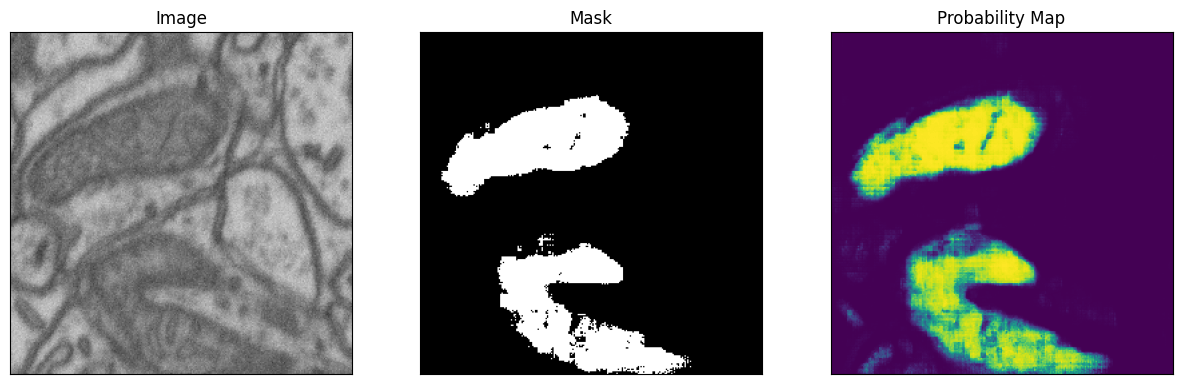

In [138]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, filtered_images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

if test_image.mode == 'L':
      test_image = test_image.convert('RGB')


# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()


Now, let us load a new image and segment it using our trained model. NOte that we need to provide some prompt. Since we do not know where the objects are going to be we cannot supply bounding boxes. So let us provide a grid of points as our prompt.

In [ ]:
#Apply a trained model on large image
large_test_images = tifffile.imread("/content/drive/MyDrive/ColabNotebooks/data/mitochondria/small_dataset_for_training/images/12_training_mito_images.tif")
large_test_image = large_test_images[1]
patches = patchify(large_test_image, (256, 256), step=256)  #Step=256 for 256 patches means no overlap


In [ ]:
"""
input_points (torch.FloatTensor of shape (batch_size, num_points, 2)) —
Input 2D spatial points, this is used by the prompt encoder to encode the prompt.
Generally yields to much better results. The points can be obtained by passing a
list of list of list to the processor that will create corresponding torch tensors
of dimension 4. The first dimension is the image batch size, the second dimension
is the point batch size (i.e. how many segmentation masks do we want the model to
predict per input point), the third dimension is the number of points per segmentation
mask (it is possible to pass multiple points for a single mask), and the last dimension
is the x (vertical) and y (horizontal) coordinates of the point. If a different number
of points is passed either for each image, or for each mask, the processor will create
“PAD” points that will correspond to the (0, 0) coordinate, and the computation of the
embedding will be skipped for these points using the labels.

"""
# Define the size of your array
array_size = 256

# Define the size of your grid
grid_size = 10

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

In [ ]:
print(np.array(input_points).shape)

In [ ]:
patches.shape

In [ ]:
# Select a random patch for segmentation

# Compute the total number of 256x256 arrays
#num_arrays = patches.shape[0] * patches.shape[1]
# Select a random index
#index = np.random.choice(num_arrays)
# Compute the indices in the original array
#i = index // patches.shape[1]
#j = index % patches.shape[1]

#Or pick a specific patch for study.
i, j = 1, 2

# Selectelected patch for segmentation
random_array = patches[i, j]


single_patch = Image.fromarray(random_array)
# prepare image for the model

#First try without providing any prompt (no bounding box or input_points)
#inputs = processor(single_patch, return_tensors="pt")
#Now try with bounding boxes. Remember to uncomment.
inputs = processor(single_patch, input_points=input_points, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}
my_mito_model.eval()


# forward pass
with torch.no_grad():
  outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(single_patch), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(single_patch_prob)  # Assuming the second image is grayscale
axes[1].set_title("Probability Map")

# Plot the second image on the right
axes[2].imshow(single_patch_prediction, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Prediction")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()